In [1]:
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt

epsilon = 1e-3

In [2]:
def get_distance(x1, x2):
      return np.sqrt((x1[0]-x2[0])**2 + (x1[1]-x2[1])**2)

def plotting_code(X, A):
    """
   Inputs:
    X --> (nx x 2) matrix with coordinates of the sensors
    A --> (na x 2) matrix with coordinates of the anchors

    Output:
    Plot of X, A on a 1x1 grid
    """
    plt.scatter(X[:, 0], X[:, 1], color='red', label='Sensors')
    plt.scatter(A[:, 0], A[:, 1], color='blue', label='Anchors')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Visualization of Grid')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.show()
    return

def get_distances_from_anchors(X_est, A, r=2**0.05):
    na = A.shape[0]
    nx = X_est.shape[0]
    D_est = np.zeros((nx,nx))
    D_hat_est = np.zeros((na,nx))
    for i in range(nx):
        for j in range(i+1,nx):
            dist = get_distance(X_est[i], X_est[j])
            if  dist < r:
                D_est[i,j] = dist
    for i in range(na):
        for j in range(nx):
            dist = get_distance(A[i], X_est[j])
            if dist < r:
                D_hat_est[i,j] = dist
    return D_est, D_hat_est

  
def plotter_with_estimation(X, A, X_est):
    x_optimal = X_est 
    plt.scatter(x_optimal[:, 0], x_optimal[:, 1], alpha = 0.9,label = "Estimated", color='green')
    plt.scatter(X[:, 0], X[:, 1], color='red', label='Real Sensors', marker = '+')
    plt.scatter(A[:, 0], A[:, 1], color='blue', label='Anchors', marker="*")
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Visualization of Grid')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.show()

def generate_points_on_perimeter(n):
    points = []
    interval = 1 / (n - 1)
    if n > 4: 
      # Generate points along the bottom side
      for i in range(n//4):
        points.append([4 * i * interval, 0])

      # Generate points along the right side
      for i in range((n - 1)//4):
        points.append([1, 4 * (i + 1) * interval])

      # Generate points along the top side
      for i in range((n - 1)//4):
        points.append([1 - 4 * (i + 1) * interval, 1])

      # Generate points along the left side
      for i in range((n - 1)//4):
        points.append([0, 1 - 4 * (i + 1) * interval])
    else:
        points = [[0,0], [1,1], [0,1], [1, 0]][:n]

    # Add extra points if necessary
    while len(points) < n:
        x = np.random.uniform(0, 1)
        if x < 0.5:
            points.append([x, 0])
        else:
            points.append([1, x - 0.5])

    return np.array(points).reshape(n, 2)

In [3]:
def get_noisy_data(nx, na, r=(2 ** 0.5), noise_std=0.1, seed = 0, plotter=False, on_perimeter=False):
    '''
  
    Outputs:
      X --> (nx x 2) matrix with coordinates of the sensors
      A --> (na x 2) matrix with coordinates of the anchors
      D --> (nx x nx) matrix with D[i,j] as the distance between sensor i and j for all i<j
      D_hat --> (na x nx) matrix with D_hat[k,j] as the distance between anchor k and sensor j
    '''
    # Set seed for reproducibility of code
    np.random.seed(seed)

    # We use a quasirandom space-filling set Halton for anchor pts
    if on_perimeter:
        A = generate_points_on_perimeter(na)
    else:
        sampler = qmc.Halton(d=2, scramble=False, seed=10)
        A = sampler.random(na)

    X = np.random.uniform(low=0.0, high=1.0, size=(nx, 2))
    D = np.zeros((nx, nx))
    D_hat = np.zeros((na, nx))

    for i in range(nx):
        for j in range(i + 1, nx):
            dist = get_distance(X[i], X[j])*(1 + np.random.randn() * noise_std)
            if dist < r:
                D[i, j] = dist

    for i in range(na):
        for j in range(nx):
            dist = get_distance(A[i], X[j])*(1+ + np.random.randn() * noise_std)
            if dist < r:
                D_hat[i, j] = dist

    # Plot the anchors and real sensors if plotter is True
    if plotter:
        plotting_code(X, A)

    return X, A, D, D_hat

def get_rmsd(x1, x2):
    n = x1.shape[0]
    return np.sqrt((np.linalg.norm(x1-x2, axis=1)**2).sum()/n)


In [4]:
import cvxpy as cp
from scipy.optimize import least_squares


def socp(Nx, A, D, D_hat):
    # Define and solve the CVXPY problem.
    x = cp.Variable((Nx, 2))
    # Define the objective function
    objective = cp.Minimize(0)

    # Define the constraints
    constraints = []
    for i in range(Nx):
        for j in range(i+1, Nx):
            if D[i][j]>0:
                constraints.append(cp.SOC(D[i][j], x[i]-x[j]))
    for k in range(Na):
        for j in range(Nx):
            if D_hat[k][j]>0:
                constraints.append(cp.SOC(D_hat[k][j], A[k]-x[j]))

    # Create the problem instance
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS,verbose=False)
    return (np.array(x.value))

def sdp(Nx, A, D, D_hat):
    """
    Note: Make sure you DO NOT USE NOISY DATA. it will not work.
    """
    AT = A.T

    def get_eij_with_zero(i,j, nx):
        eij = get_ei(i, nx) - get_ei(j, nx)
        zero_vector = np.array([[0],[0]])
        return np.concatenate((zero_vector, eij), axis=0)

    def get_ei(i, nx):
        ei = np.zeros((nx, 1))
        ei[i] = 1
        return ei


    def get_ak_ej(k, j, a, nx):
        ak = a[:, k].reshape((2,1))
        ej = get_ei(j, nx)
        return np.concatenate((ak, -ej),axis=0)

    def dot_operator(p,q):
        return np.sqrt(np.trace(p.T@q))

    x = cp.Variable((2+Nx,2+Nx), symmetric=True)

    # must be symmetric positive semi definite
    constraints = [x >> 0]

    # constraints 2 and 3 from image
    for i in range(Nx):
        for j in range(i+1, Nx):
            if D[i][j]>0:
                eij = get_eij_with_zero(i, j, Nx)
                constraints.append( cp.trace((eij@eij.T).T@x) == D[i,j]**2)
    for k in range(Na):
        for j in range(Nx):
            if D_hat[k][j]>0:
                akej = get_ak_ej(k, j, AT, Nx)
                constraints.append( cp.trace((akej@akej.T).T@x) == D_hat[k,j]**2)

    zd = np.zeros(((2+Nx), (2+Nx)))
    zd[0,0] = 1
    constraints.append(cp.trace(zd@x) == 1)

    zd = np.zeros(((2+Nx), (2+Nx)))
    zd[0,1] = 1
    constraints.append(cp.trace(zd@x) == 0)

    zd = np.zeros(((2+Nx), (2+Nx)))
    zd[1,0] = 1
    constraints.append(cp.trace(zd@x) == 0)

    zd = np.zeros(((2+Nx), (2+Nx)))
    zd[1,1] = 1
    constraints.append(cp.trace(zd@x) == 1)

    # solve
    objective = cp.Minimize(0)
    prob = cp.Problem(objective, constraints)

    prob.solve(verbose=False)

    return np.array(x.value)[0:2, 2:].T


def lsq(Nx,Na, A,D,D_hat, x_initial=None):
    if x_initial is None:
        x_initial = np.random.uniform(low=0.0, high=1.0, size=(Nx, 2)).flatten()
    def objective_function(x):
        x = x.reshape((Nx, 2))  # Reshape x back to (Nx, 2) array
        objective = []
        for i in range(Nx):
            for j in range(i + 1, Nx):
                if D[i][j] > 0:
                    objective.append((np.linalg.norm(x[i] - x[j]) ** 2 - D[i][j] ** 2) ** 2)
        for i in range(Na):
            for j in range(Nx):
                if D[i][j] > 0:
                    objective.append((np.linalg.norm(A[i] - x[j]) ** 2 - D_hat[i][j] ** 2) ** 2)
        return objective

    result = least_squares(objective_function, x_initial)
    return result.x.reshape((Nx, 2))


def sdp_noise(Nx, Na, A, D, D_hat):
    AT = A.T

    def get_eij_with_zero(i, j, nx):
        eij = get_ei(i, nx) - get_ei(j, nx)
        zero_vector = np.array([[0], [0]])
        return np.concatenate((zero_vector, eij), axis=0)

    def get_ei(i, nx):
        ei = np.zeros((nx, 1))
        ei[i] = 1
        return ei

    def get_ak_ej(k, j, a, nx):
        ak = a[:, k].reshape((2, 1))
        ej = get_ei(j, nx)
        return np.concatenate((ak, -ej), axis=0)

    def dot_operator(p, q):
        return np.sqrt(np.trace(p.T @ q))

    x = cp.Variable((2 + Nx, 2 + Nx), symmetric=True)
    delta = cp.Variable(D.shape, nonneg=True)
    delta_prime = cp.Variable(D.shape, nonneg=True)
    delta_hat = cp.Variable(D_hat.shape, nonneg=True)
    delta_hat_prime = cp.Variable(D_hat.shape, nonneg=True)

    # must be symmetric positive semi definite
    constraints = [x >> 0]

    # constraints 2 and 3 from image
    for i in range(Nx):
        for j in range(i + 1, Nx):
            if D[i][j] > 0:
                eij = get_eij_with_zero(i, j, Nx)
                constraints.append(cp.trace((eij @ eij.T).T @ x) + delta[i, j] - delta_prime[i,j] == D[i, j] ** 2)

    for k in range(Na):
        for j in range(Nx):
            if D_hat[k][j] > 0:
                akej = get_ak_ej(k, j, AT, Nx)
                constraints.append(cp.trace((akej @ akej.T).T @ x) +  delta_hat[k, j] - delta_hat_prime[k,j]  == D_hat[k, j] ** 2)

    # first constraint: first block of Z is Identity
    zd = np.zeros(((2 + Nx), (2 + Nx)))
    zd[0, 0] = 1
    constraints.append(cp.trace(zd @ x) == 1)

    zd = np.zeros(((2 + Nx), (2 + Nx)))
    zd[0, 1] = 1
    constraints.append(cp.trace(zd @ x) == 0)

    zd = np.zeros(((2 + Nx), (2 + Nx)))
    zd[1, 0] = 1
    constraints.append(cp.trace(zd @ x) == 0)

    zd = np.zeros(((2 + Nx), (2 + Nx)))
    zd[1, 1] = 1
    constraints.append(cp.trace(zd @ x) == 1)

    # minimize element-wise L1 norm
    objective = cp.Minimize(cp.sum(delta + delta_prime) + cp.sum(delta_hat + delta_hat_prime))

    prob = cp.Problem(objective, constraints)
    prob.solve(verbose=False)
    return np.array(x.value)[0:2, 2:].T

def sdp_refined(Nx, Na, A, D, D_hat):
    X_est_initial = sdp_noise(Nx, Na, A, D, D_hat)
    X_est = lsq(Nx, Na, A, D, D_hat, X_est_initial.flatten())
    return X_est

All the preceding code works and has been checked. Note all our functions now output simply the estimated X_values

In [5]:
def sdp_projection(Nx, Na, A, D, D_hat, lr=3e-3):
    def project(Zhat_k):
        from scipy.linalg import eigh
        D, V = eigh(Zhat_k)
        lb = np.zeros_like(D)
        Z_k = V @ np.diag(np.maximum(D, lb)) @ V.T
        return Z_k

    def get_eij_with_zero(i, j, nx):
        eij = get_ei(i, nx) - get_ei(j, nx)
        zero_vector = np.array([[0], [0]])
        return np.concatenate((zero_vector, eij), axis=0)

    def get_ei(i, nx):
        ei = np.zeros((nx, 1))
        ei[i] = 1
        return ei

    def get_ak_ej(k, j, a, nx, lr=3e-3):
        ak = a[:, k].reshape((2, 1))
        ej = get_ei(j, nx)
        return np.concatenate((ak, -ej), axis=0)

    def dot_operator(p, q):
        return np.sqrt(np.trace(p.T @ q))

    AT = A.T
    Z = np.eye(Nx + 2)
    grad = np.zeros((Nx + 2, Nx + 2))

    from tqdm import tqdm
    obj_old = 1e5
    for it in tqdm(range(500)):
        for i in range(Nx):
            for j in range(i + 1, Nx):
                if D[i][j] > 0:
                    eij = get_eij_with_zero(i, j, Nx)
                    Ai = (eij @ eij.T)
                    Ai_Z = np.sum(Ai * Z)
                    b = D[i, j] ** 2
                    grad += Ai * (Ai_Z - b)

        for k in range(Na):
            for j in range(Nx):
                if D_hat[k][j] > 0:
                    akej = get_ak_ej(k, j, AT, Nx)
                    Ai = akej @ akej.T
                    Ai_Z = np.sum(Ai * Z)
                    b = D_hat[k, j] ** 2
                    grad += Ai * (Ai_Z - b)

        zd = np.zeros(((2 + Nx), (2 + Nx)))
        zd[0, 0] = 1
        Ai = zd
        Ai_Z = np.sum(Ai * Z)
        b = 1
        grad += Ai * (Ai_Z - b)

        zd = np.zeros(((2 + Nx), (2 + Nx)))
        zd[0, 1] = 1
        Ai = zd
        Ai_Z = np.sum(Ai * Z)
        b = 0
        grad += Ai * (Ai_Z - b)

        zd = np.zeros(((2 + Nx), (2 + Nx)))
        zd[1, 0] = 1
        Ai = zd
        Ai_Z = np.sum(Ai * Z)
        b = 0
        grad += Ai * (Ai_Z - b)

        zd = np.zeros(((2 + Nx), (2 + Nx)))
        zd[1, 1] = 1
        Ai = zd
        Ai_Z = np.sum(Ai * Z)
        b = 1
        grad += Ai * (Ai_Z - b)

        Zhat = Z - lr * grad

        Z = project(Zhat)

        obj_new = np.linalg.norm((Ai_Z - b))
        if abs(obj_new - obj_old) < 1e-7:
            return Z[0:2, 2:].T
        obj_old = obj_new

    return Z[0:2, 2:].T


In [6]:
from cvxpy.problems.objective import Objective
from tqdm import tqdm


def admm(Nx, Na, A, D, D_hat, seed= 0):
    np.random.seed(seed)
    x = np.random.rand(Nx, 2)
    y = np.random.rand(Nx, 2)
    mu = np.random.rand(Nx, 2)
    def get_obj(x, y, mu):
        obj = 0
        for i in range(Nx):
            for j in range(i + 1, Nx):
                if D[i][j] > 0:
                    obj += (np.sum((x[i] - x[j]) * (y[i] - y[j])) - D[i, j] ** 2) ** 2
        for k in range(Na):
            for j in range(Nx):
                if D_hat[k][j] > 0:
                    obj += (np.sum((A[k] - x[j]) * (A[k] - y[j])) - D_hat[k, j] ** 2) ** 2

        return obj

    beta = 10
    obj_old = get_obj((x + y) / 2, (x + y) / 2, mu)
    for it in tqdm(range(1000)):
        obj = 0
        x = cp.Variable((Nx, 2))
        for i in range(Nx):
            for j in range(i + 1, Nx):
                if D[i][j] > 0:
                    obj += (cp.sum(cp.multiply((x[i] - x[j]), (y[i] - y[j]))) - D[i, j] ** 2) ** 2
        for k in range(Na):
            for j in range(Nx):
                if D_hat[k][j] > 0:
                    obj += (cp.sum(cp.multiply((A[k] - x[j]), (A[k] - y[j]))) - D_hat[k, j] ** 2) ** 2
        for i in range(Nx):
            obj -= cp.sum(cp.multiply(mu[i], (x[i] - y[i])))
            obj += (beta / 2) * cp.norm(x[i] - y[i]) ** 2

        objective = cp.Minimize(obj)
        prob = cp.Problem(objective)
        prob.solve(verbose=False)
        x = np.array(x.value)

        # optimize for y
        obj = 0
        y = cp.Variable((Nx, 2))
        for i in range(Nx):
            for j in range(i + 1, Nx):
                if D[i][j] > 0:
                    obj += (cp.sum(cp.multiply((x[i] - x[j]), (y[i] - y[j]))) - D[i, j] ** 2) ** 2
        for k in range(Na):
            for j in range(Nx):
                if D_hat[k][j] > 0:
                    obj += (cp.sum(cp.multiply((A[k] - x[j]), (A[k] - y[j]))) - D_hat[k, j] ** 2) ** 2
        for i in range(Nx):
            obj -= cp.sum(cp.multiply(mu[i], (x[i] - y[i])))
            obj += (beta / 2) * cp.norm(x[i] - y[i]) ** 2

        objective = cp.Minimize(obj)
        prob = cp.Problem(objective)
        prob.solve(verbose=False)
        y = np.array(y.value)

        mu -= beta * (x - y)

        obj_new = get_obj((x + y) / 2, (x + y) / 2, mu)
        if abs(obj_new - obj_old) < 1e-7:
            print(abs(obj_new - obj_old))
            return (x + y) / 2
        print(abs(obj_new - obj_old))
        obj_old = obj_new

    return (x + y) / 2

All the preceding code works, including ADMM and sdp_projection! We are ready to rock.

In [7]:
noise_levels = [0, 0.1, 0.25]

def simulation_rad_fixed_noise(noise):

    # Define parameters
    Nx = 8
    Na = 4
    radio_range = [0.2, 0.4, 0.6, 0.8]
    rmsd_sdp = []
    rmsd_sdp_refined = []
    rmsd_projection = []
    rmsd_admm = []
    for r in radio_range:
        X, A, D, D_hat = get_noisy_data(Nx, Na, r, noise)
        # SDP
        X_est_sdp = sdp_noise(Nx, Na, A, D , D_hat)
        rmsd_sdp.append(get_rmsd(X, X_est_sdp))
        # SDP refined
        X_est_sdp_refined = sdp_refined(Nx, Na, A, D , D_hat)
        rmsd_sdp_refined.append(get_rmsd(X, X_est_sdp_refined))
        # Projection
        X_est_projection = sdp_projection(Nx, Na, A, D , D_hat)
        rmsd_projection.append(get_rmsd(X, X_est_projection))
        # ADMM
        X_est_admm = admm(Nx, Na, A, D , D_hat)
        rmsd_admm.append(get_rmsd(X, X_est_admm))
        
    return rmsd_sdp, rmsd_sdp_refined, rmsd_admm    

In [8]:
def simulation_rad_fixed_noise_iter(noise, num_seeds=5):

    # Define parameters
    Nx = 8
    Na = 4
    radio_range = [0.2, 0.4, 0.6, 0.8]
    rmsd_sdp = []
    rmsd_sdp_refined = []
    rmsd_admm = []
    
    for r in radio_range:
        rmsd_sdp_avg = 0
        rmsd_sdp_refined_avg = 0
        rmsd_admm_avg = 0
        
        for seed in range(num_seeds):
            print(seed)
            np.random.seed(seed)  # Set seed value for reproducibility
            
            X, A, D, D_hat = get_noisy_data(Nx, Na, r, noise)
            
            # SDP
            X_est_sdp = sdp_noise(Nx, Na, A, D, D_hat)
            rmsd_sdp_avg += get_rmsd(X, X_est_sdp)
            
            # SDP refined
            X_est_sdp_refined = sdp_refined(Nx, Na, A, D, D_hat)
            rmsd_sdp_refined_avg += get_rmsd(X, X_est_sdp_refined)
            
            # ADMM
            X_est_admm = admm(Nx, Na, A, D, D_hat)
            rmsd_admm_avg += get_rmsd(X, X_est_admm)
        
        rmsd_sdp_avg /= num_seeds
        rmsd_sdp_refined_avg /= num_seeds
        rmsd_admm_avg /= num_seeds
        
        rmsd_sdp.append(rmsd_sdp_avg)
        rmsd_sdp_refined.append(rmsd_sdp_refined_avg)
        rmsd_admm.append(rmsd_admm_avg)
        
    return rmsd_sdp, rmsd_sdp_refined, rmsd_admm


In [9]:
%%time 
e0, f0, g0 = simulation_rad_fixed_noise_iter(0);

0


  0%|          | 2/1000 [00:00<01:56,  8.59it/s]

0.3535410632814192
0.31688550969526824


  0%|          | 4/1000 [00:00<02:04,  7.98it/s]

0.041032682124658146
0.03737953727719917


  0%|          | 5/1000 [00:00<02:03,  8.05it/s]

0.02028289179300287
0.01320635147658502


  1%|          | 8/1000 [00:00<01:51,  8.93it/s]

0.0089236132139956
0.006307492741746856


  1%|          | 10/1000 [00:01<01:54,  8.65it/s]

0.004612541539492771
0.003468845825351112


  1%|          | 12/1000 [00:01<02:09,  7.63it/s]

0.002670121642455836
0.002096136451654738


  1%|▏         | 14/1000 [00:01<02:01,  8.15it/s]

0.0016735610095772145
0.0013557669563251488


  2%|▏         | 15/1000 [00:01<01:57,  8.36it/s]

0.0011124084469456633
0.0009230273605491911


  2%|▏         | 18/1000 [00:02<01:53,  8.62it/s]

0.0007735764998131603
0.0006541366857451521


  2%|▏         | 21/1000 [00:02<01:39,  9.88it/s]

0.0005575954630165549
0.0004787645647755367
0.0004137995834370481


  2%|▏         | 23/1000 [00:02<02:04,  7.86it/s]

0.0003598116623640666
0.0003146002400695007


  2%|▎         | 25/1000 [00:02<01:49,  8.94it/s]

0.0002764745217314949
0.0002441133072169444
0.00021648070219563737


  3%|▎         | 29/1000 [00:03<01:39,  9.73it/s]

0.00019275071995402283
0.00017226712576434104
0.0001545005948094234


  3%|▎         | 31/1000 [00:03<01:47,  9.04it/s]

0.00013902112128810415
0.00012547708340972436


  3%|▎         | 33/1000 [00:03<02:03,  7.84it/s]

0.00011357934143638106
0.00010308864814931058


  3%|▎         | 34/1000 [00:04<02:01,  7.92it/s]

9.380591107404756e-05
8.556477819287515e-05


  4%|▎         | 37/1000 [00:04<01:49,  8.81it/s]

7.822522518312618e-05
7.166909321330373e-05


  4%|▍         | 39/1000 [00:04<01:56,  8.22it/s]

6.579624898963915e-05
6.052136431230451e-05


  4%|▍         | 41/1000 [00:04<02:11,  7.29it/s]

5.577146237748789e-05
5.148391577751291e-05


  4%|▍         | 43/1000 [00:05<01:56,  8.21it/s]

4.760477767381838e-05
4.4087344942815576e-05


  4%|▍         | 45/1000 [00:05<01:54,  8.34it/s]

4.089127275092833e-05
3.798138146487561e-05
3.532697562856949e-05


  5%|▍         | 48/1000 [00:05<01:40,  9.45it/s]

3.2901190197119775e-05
3.0680449982059804e-05


  5%|▌         | 50/1000 [00:05<01:55,  8.22it/s]

2.864401096469853e-05
2.6773574244112015e-05


  5%|▌         | 52/1000 [00:06<01:44,  9.03it/s]

2.5052956904306352e-05
2.3467812308155308e-05
2.2005397068574598e-05


  6%|▌         | 55/1000 [00:06<01:36,  9.81it/s]

2.065436235881233e-05
1.9404582855790588e-05


  6%|▌         | 57/1000 [00:06<01:39,  9.50it/s]

1.824700628031003e-05
1.7173520760481388e-05


  6%|▌         | 58/1000 [00:06<01:40,  9.36it/s]

1.61809787870864e-05


  6%|▌         | 60/1000 [00:07<02:04,  7.57it/s]

1.5261921815280387e-05
1.4394885264805456e-05


  6%|▌         | 62/1000 [00:07<01:59,  7.85it/s]

1.3591416677421434e-05
1.284195900139504e-05


  6%|▋         | 64/1000 [00:07<01:47,  8.68it/s]

1.2142510593651594e-05
1.1489048767484298e-05


  7%|▋         | 66/1000 [00:07<01:54,  8.15it/s]

1.087799475643701e-05
1.0306092498937023e-05


  7%|▋         | 69/1000 [00:08<01:46,  8.73it/s]

9.770374154537115e-06
9.268124152714957e-06
8.796894533643544e-06


  7%|▋         | 72/1000 [00:08<01:40,  9.22it/s]

8.354388736229128e-06
7.93855601975303e-06
7.547499390510092e-06


  7%|▋         | 74/1000 [00:08<01:40,  9.17it/s]

7.179477181003458e-06
6.832889345497763e-06


  8%|▊         | 77/1000 [00:08<01:40,  9.17it/s]

6.506265571237888e-06
6.198198785155258e-06
5.907519701070572e-06


  8%|▊         | 79/1000 [00:09<01:44,  8.82it/s]

5.63313822415229e-06
5.37387490592202e-06


  8%|▊         | 81/1000 [00:09<02:00,  7.65it/s]

5.128749504930717e-06
4.8968781644989656e-06


  8%|▊         | 83/1000 [00:09<02:11,  6.96it/s]

4.677420160666807e-06
4.469596034952501e-06


  8%|▊         | 85/1000 [00:10<01:55,  7.93it/s]

4.272681964694272e-06
4.086002730338282e-06


  9%|▊         | 87/1000 [00:10<01:45,  8.67it/s]

3.908942000199352e-06
3.740918974166256e-06
3.5813937756252714e-06


  9%|▉         | 90/1000 [00:10<01:45,  8.65it/s]

3.4298624432639103e-06
3.2858592742251172e-06


  9%|▉         | 93/1000 [00:10<01:48,  8.35it/s]

3.1489481613028263e-06
3.0187127863461858e-06
2.89476867599047e-06


 10%|▉         | 95/1000 [00:11<01:42,  8.80it/s]

2.776776612695934e-06
2.664403739259107e-06


 10%|▉         | 97/1000 [00:11<01:44,  8.66it/s]

2.5573390645552643e-06
2.4552916255648994e-06


 10%|▉         | 99/1000 [00:11<01:51,  8.11it/s]

2.3579899607819064e-06
2.2651746115927827e-06


 10%|█         | 101/1000 [00:11<01:43,  8.67it/s]

2.1766068700610408e-06
2.092061682555554e-06


 10%|█         | 103/1000 [00:12<01:44,  8.56it/s]

2.011324088077289e-06
1.9342000115504047e-06


 10%|█         | 105/1000 [00:12<01:41,  8.83it/s]

1.8605068055516872e-06
1.7900615642704745e-06


 11%|█         | 107/1000 [00:12<01:54,  7.82it/s]

1.7227001293513192e-06
1.6582682061055216e-06


 11%|█         | 109/1000 [00:12<02:01,  7.34it/s]

1.596619056592402e-06
1.5376143177058788e-06


 11%|█         | 111/1000 [00:13<02:01,  7.33it/s]

1.4811231057613991e-06
1.4270242257217552e-06


 11%|█▏        | 113/1000 [00:13<01:57,  7.54it/s]

1.3752018222629216e-06
1.3255432680321552e-06


 11%|█▏        | 114/1000 [00:13<01:59,  7.39it/s]

1.2779446211180493e-06


 12%|█▏        | 116/1000 [00:13<02:10,  6.76it/s]

1.2323077895546916e-06
1.1885398984038596e-06


 12%|█▏        | 118/1000 [00:14<02:03,  7.12it/s]

1.1465531717761725e-06
1.1062647530055966e-06


 12%|█▏        | 120/1000 [00:14<02:07,  6.92it/s]

1.0675956132590936e-06
1.0304728056041522e-06


 12%|█▏        | 122/1000 [00:14<01:59,  7.34it/s]

9.948250727332566e-07
9.60585692478909e-07


 12%|█▏        | 124/1000 [00:15<02:04,  7.06it/s]

9.276912988955078e-07
8.960813050035652e-07


 13%|█▎        | 126/1000 [00:15<02:09,  6.75it/s]

8.656983665669304e-07
8.364890030001308e-07


 13%|█▎        | 128/1000 [00:15<02:01,  7.19it/s]

8.084019829138778e-07
7.813882584763385e-07


 13%|█▎        | 130/1000 [00:15<01:52,  7.74it/s]

7.55401579780963e-07
7.303977794259021e-07


 13%|█▎        | 132/1000 [00:16<02:05,  6.93it/s]

7.063346928109514e-07
6.831724479260799e-07


 13%|█▎        | 134/1000 [00:16<02:00,  7.20it/s]

6.60873035149545e-07
6.394000927862855e-07


 14%|█▎        | 136/1000 [00:16<01:55,  7.47it/s]

6.187190385731926e-07
5.987970050859384e-07


 14%|█▎        | 137/1000 [00:16<01:57,  7.33it/s]

5.796024035661804e-07
5.61105157631145e-07


 14%|█▍        | 140/1000 [00:17<01:55,  7.43it/s]

5.432768534715087e-07
5.260899404499493e-07


 14%|█▍        | 142/1000 [00:17<01:54,  7.48it/s]

5.095183409901197e-07
4.935370864945686e-07


 14%|█▍        | 144/1000 [00:17<01:45,  8.15it/s]

4.781221387545456e-07
4.632510483075989e-07


 15%|█▍        | 146/1000 [00:17<01:41,  8.43it/s]

4.489018774368606e-07
4.350537953643509e-07


 15%|█▍        | 148/1000 [00:18<01:47,  7.96it/s]

4.2168702831300883e-07
4.087827333485771e-07
3.9632264704086215e-07


 15%|█▌        | 151/1000 [00:18<01:35,  8.91it/s]

3.8428944800494383e-07
3.726666600568152e-07


 15%|█▌        | 153/1000 [00:18<01:36,  8.76it/s]

3.6143847517517527e-07
3.5058982097741376e-07


 16%|█▌        | 155/1000 [00:18<01:42,  8.27it/s]

3.401061690863806e-07
3.2997520129214034e-07


 16%|█▌        | 158/1000 [00:19<01:34,  8.91it/s]

3.2018455616884353e-07
3.107189297586533e-07
3.0156615530537904e-07


 16%|█▌        | 160/1000 [00:19<01:34,  8.93it/s]

2.927146153545315e-07
2.8415329053126365e-07
2.758714567433798e-07


 16%|█▋        | 163/1000 [00:19<01:36,  8.71it/s]

2.6785891059014546e-07
2.601059127366727e-07


 17%|█▋        | 166/1000 [00:20<01:28,  9.43it/s]

2.526030759459564e-07
2.453414131474449e-07
2.3831227127413973e-07


 17%|█▋        | 169/1000 [00:20<01:25,  9.67it/s]

2.3150736574765794e-07
2.249187670675663e-07
2.1853887740127593e-07


 17%|█▋        | 171/1000 [00:20<01:29,  9.23it/s]

2.1236013315403547e-07
2.0637575237784908e-07


 17%|█▋        | 174/1000 [00:21<01:26,  9.50it/s]

2.0057890918359256e-07
1.949629248606164e-07
1.8952168287939229e-07


 18%|█▊        | 176/1000 [00:21<01:31,  9.00it/s]

1.8424910743372175e-07
1.7913939910897756e-07


 18%|█▊        | 177/1000 [00:21<01:32,  8.92it/s]

1.7418693007803776e-07
1.6938632057034111e-07


 18%|█▊        | 180/1000 [00:21<01:36,  8.47it/s]

1.6473243599857425e-07
1.602203786588203e-07
1.5584524897750236e-07


 18%|█▊        | 182/1000 [00:21<01:30,  8.99it/s]

1.5160247712677282e-07
1.4748774061537946e-07


 18%|█▊        | 185/1000 [00:22<01:29,  9.08it/s]

1.434967445637915e-07
1.396254391875466e-07


 19%|█▊        | 187/1000 [00:22<01:46,  7.62it/s]

1.358701291621545e-07
1.3222710995143077e-07


 19%|█▉        | 190/1000 [00:22<01:32,  8.74it/s]

1.2869362586395856e-07
1.2526480168915955e-07
1.2216383176167326e-07


 19%|█▉        | 192/1000 [00:23<01:26,  9.36it/s]

1.187015227091932e-07
1.1553513074899328e-07


 19%|█▉        | 194/1000 [00:23<01:33,  8.64it/s]

1.1256642596093268e-07
1.0964659630302754e-07


 20%|█▉        | 196/1000 [00:23<01:45,  7.62it/s]

1.0678851926114528e-07
1.0400051314100794e-07


 20%|█▉        | 197/1000 [00:23<01:37,  8.25it/s]

1.0129637520026683e-07
9.866903529669872e-08
1



  0%|          | 2/1000 [00:00<01:49,  9.14it/s]

0.3535410632814192
0.31688550969526824
0.041032682124658146


  0%|          | 4/1000 [00:00<01:40,  9.93it/s]

0.03737953727719917
0.02028289179300287


  1%|          | 7/1000 [00:00<01:47,  9.24it/s]

0.01320635147658502
0.0089236132139956


  1%|          | 10/1000 [00:01<01:44,  9.44it/s]

0.006307492741746856
0.004612541539492771
0.003468845825351112


  1%|          | 12/1000 [00:01<01:50,  8.97it/s]

0.002670121642455836
0.002096136451654738
0.0016735610095772145


  1%|▏         | 14/1000 [00:01<01:43,  9.49it/s]

0.0013557669563251488
0.0011124084469456633


  2%|▏         | 17/1000 [00:01<01:46,  9.20it/s]

0.0009230273605491911
0.0007735764998131603


  2%|▏         | 19/1000 [00:02<01:41,  9.64it/s]

0.0006541366857451521
0.0005575954630165549
0.0004787645647755367


  2%|▏         | 23/1000 [00:02<01:31, 10.64it/s]

0.0004137995834370481
0.0003598116623640666
0.0003146002400695007


  2%|▎         | 25/1000 [00:02<01:33, 10.38it/s]

0.0002764745217314949
0.0002441133072169444
0.00021648070219563737


  3%|▎         | 28/1000 [00:02<01:40,  9.63it/s]

0.00019275071995402283
0.00017226712576434104


  3%|▎         | 30/1000 [00:03<01:49,  8.89it/s]

0.0001545005948094234
0.00013902112128810415


  3%|▎         | 32/1000 [00:03<01:46,  9.10it/s]

0.00012547708340972436
0.00011357934143638106
0.00010308864814931058


  3%|▎         | 34/1000 [00:03<01:42,  9.41it/s]

9.380591107404756e-05
8.556477819287515e-05


  4%|▎         | 37/1000 [00:03<01:45,  9.16it/s]

7.822522518312618e-05
7.166909321330373e-05


  4%|▍         | 40/1000 [00:04<01:35, 10.07it/s]

6.579624898963915e-05
6.052136431230451e-05
5.577146237748789e-05


  4%|▍         | 42/1000 [00:04<01:33, 10.22it/s]

5.148391577751291e-05
4.760477767381838e-05
4.4087344942815576e-05


  4%|▍         | 44/1000 [00:04<01:38,  9.71it/s]

4.089127275092833e-05
3.798138146487561e-05


  5%|▍         | 47/1000 [00:04<01:43,  9.20it/s]

3.532697562856949e-05
3.2901190197119775e-05


  5%|▍         | 48/1000 [00:05<01:44,  9.12it/s]

3.0680449982059804e-05
2.864401096469853e-05


  5%|▌         | 51/1000 [00:05<01:42,  9.27it/s]

2.6773574244112015e-05
2.5052956904306352e-05


  5%|▌         | 54/1000 [00:05<01:32, 10.24it/s]

2.3467812308155308e-05
2.2005397068574598e-05
2.065436235881233e-05


  6%|▌         | 56/1000 [00:05<01:43,  9.15it/s]

1.9404582855790588e-05
1.824700628031003e-05


  6%|▌         | 58/1000 [00:06<01:43,  9.13it/s]

1.7173520760481388e-05
1.61809787870864e-05
1.5261921815280387e-05


  6%|▌         | 61/1000 [00:06<01:37,  9.58it/s]

1.4394885264805456e-05
1.3591416677421434e-05


  6%|▋         | 63/1000 [00:06<01:42,  9.18it/s]

1.284195900139504e-05
1.2142510593651594e-05


  6%|▋         | 65/1000 [00:06<01:46,  8.76it/s]

1.1489048767484298e-05
1.087799475643701e-05


  7%|▋         | 68/1000 [00:07<01:40,  9.29it/s]

1.0306092498937023e-05
9.770374154537115e-06
9.268124152714957e-06


  7%|▋         | 69/1000 [00:07<01:39,  9.40it/s]

8.796894533643544e-06
8.354388736229128e-06


  7%|▋         | 73/1000 [00:07<01:39,  9.35it/s]

7.93855601975303e-06
7.547499390510092e-06
7.179477181003458e-06


  8%|▊         | 75/1000 [00:07<01:34,  9.81it/s]

6.832889345497763e-06
6.506265571237888e-06


  8%|▊         | 77/1000 [00:08<01:54,  8.07it/s]

6.198198785155258e-06
5.907519701070572e-06


  8%|▊         | 80/1000 [00:08<01:41,  9.10it/s]

5.63313822415229e-06
5.37387490592202e-06
5.128749504930717e-06


  8%|▊         | 82/1000 [00:08<01:31, 10.04it/s]

4.8968781644989656e-06
4.677420160666807e-06
4.469596034952501e-06


  8%|▊         | 85/1000 [00:09<01:37,  9.41it/s]

4.272681964694272e-06
4.086002730338282e-06


  9%|▉         | 88/1000 [00:09<01:34,  9.68it/s]

3.908942000199352e-06
3.740918974166256e-06
3.5813937756252714e-06


  9%|▉         | 90/1000 [00:09<01:27, 10.44it/s]

3.4298624432639103e-06
3.2858592742251172e-06
3.1489481613028263e-06


  9%|▉         | 94/1000 [00:09<01:23, 10.80it/s]

3.0187127863461858e-06
2.89476867599047e-06
2.776776612695934e-06


 10%|▉         | 96/1000 [00:10<01:32,  9.78it/s]

2.664403739259107e-06
2.5573390645552643e-06


 10%|▉         | 98/1000 [00:10<01:35,  9.43it/s]

2.4552916255648994e-06
2.3579899607819064e-06


 10%|█         | 100/1000 [00:10<01:41,  8.83it/s]

2.2651746115927827e-06
2.1766068700610408e-06


 10%|█         | 102/1000 [00:10<01:39,  9.03it/s]

2.092061682555554e-06
2.011324088077289e-06
1.9342000115504047e-06


 10%|█         | 105/1000 [00:11<01:34,  9.43it/s]

1.8605068055516872e-06
1.7900615642704745e-06


 11%|█         | 108/1000 [00:11<01:35,  9.29it/s]

1.7227001293513192e-06
1.6582682061055216e-06
1.596619056592402e-06


 11%|█         | 110/1000 [00:11<01:37,  9.10it/s]

1.5376143177058788e-06
1.4811231057613991e-06
1.4270242257217552e-06


 11%|█▏        | 113/1000 [00:12<01:35,  9.33it/s]

1.3752018222629216e-06
1.3255432680321552e-06


 12%|█▏        | 115/1000 [00:12<01:39,  8.91it/s]

1.2779446211180493e-06
1.2323077895546916e-06


 12%|█▏        | 117/1000 [00:12<01:42,  8.61it/s]

1.1885398984038596e-06
1.1465531717761725e-06


 12%|█▏        | 119/1000 [00:12<01:38,  8.96it/s]

1.1062647530055966e-06
1.0675956132590936e-06


 12%|█▏        | 120/1000 [00:12<01:40,  8.80it/s]

1.0304728056041522e-06
9.948250727332566e-07


 12%|█▏        | 124/1000 [00:13<01:29,  9.75it/s]

9.60585692478909e-07
9.276912988955078e-07
8.960813050035652e-07


 13%|█▎        | 126/1000 [00:13<01:44,  8.32it/s]

8.656983665669304e-07
8.364890030001308e-07


 13%|█▎        | 129/1000 [00:13<01:35,  9.12it/s]

8.084019829138778e-07
7.813882584763385e-07
7.55401579780963e-07


 13%|█▎        | 131/1000 [00:14<01:40,  8.61it/s]

7.303977794259021e-07
7.063346928109514e-07


 13%|█▎        | 133/1000 [00:14<01:37,  8.89it/s]

6.831724479260799e-07
6.60873035149545e-07


 14%|█▎        | 135/1000 [00:14<01:36,  8.96it/s]

6.394000927862855e-07
6.187190385731926e-07


 14%|█▎        | 137/1000 [00:14<01:43,  8.38it/s]

5.987970050859384e-07
5.796024035661804e-07


 14%|█▍        | 139/1000 [00:14<01:39,  8.66it/s]

5.61105157631145e-07
5.432768534715087e-07


 14%|█▍        | 141/1000 [00:15<01:40,  8.58it/s]

5.260899404499493e-07
5.095183409901197e-07


 14%|█▍        | 143/1000 [00:15<01:45,  8.14it/s]

4.935370864945686e-07
4.781221387545456e-07


 14%|█▍        | 145/1000 [00:15<01:41,  8.45it/s]

4.632510483075989e-07
4.489018774368606e-07


 15%|█▍        | 147/1000 [00:15<01:47,  7.97it/s]

4.350537953643509e-07
4.2168702831300883e-07


 15%|█▌        | 150/1000 [00:16<01:30,  9.39it/s]

4.087827333485771e-07
3.9632264704086215e-07
3.8428944800494383e-07


 15%|█▌        | 153/1000 [00:16<01:27,  9.67it/s]

3.726666600568152e-07
3.6143847517517527e-07
3.5058982097741376e-07


 16%|█▌        | 155/1000 [00:16<01:33,  9.01it/s]

3.401061690863806e-07
3.2997520129214034e-07


 16%|█▌        | 158/1000 [00:17<01:33,  8.96it/s]

3.2018455616884353e-07
3.107189297586533e-07
3.0156615530537904e-07


 16%|█▌        | 160/1000 [00:17<01:32,  9.12it/s]

2.927146153545315e-07
2.8415329053126365e-07
2.758714567433798e-07


 16%|█▋        | 163/1000 [00:17<01:28,  9.45it/s]

2.6785891059014546e-07
2.601059127366727e-07
2.526030759459564e-07


 17%|█▋        | 166/1000 [00:18<01:36,  8.62it/s]

2.453414131474449e-07
2.3831227127413973e-07


 17%|█▋        | 169/1000 [00:18<01:26,  9.60it/s]

2.3150736574765794e-07
2.249187670675663e-07
2.1853887740127593e-07


 17%|█▋        | 172/1000 [00:18<01:24,  9.82it/s]

2.1236013315403547e-07
2.0637575237784908e-07
2.0057890918359256e-07


 18%|█▊        | 175/1000 [00:18<01:21, 10.12it/s]

1.949629248606164e-07
1.8952168287939229e-07
1.8424910743372175e-07


 18%|█▊        | 177/1000 [00:19<01:30,  9.13it/s]

1.7913939910897756e-07
1.7418693007803776e-07


 18%|█▊        | 180/1000 [00:19<01:21, 10.05it/s]

1.6938632057034111e-07
1.6473243599857425e-07
1.602203786588203e-07


 18%|█▊        | 182/1000 [00:19<01:32,  8.84it/s]

1.5584524897750236e-07
1.5160247712677282e-07


 18%|█▊        | 184/1000 [00:19<01:27,  9.36it/s]

1.4748774061537946e-07
1.434967445637915e-07
1.396254391875466e-07


 19%|█▉        | 188/1000 [00:20<01:26,  9.41it/s]

1.358701291621545e-07
1.3222710995143077e-07
1.2869362586395856e-07


 19%|█▉        | 190/1000 [00:20<01:28,  9.13it/s]

1.2526480168915955e-07
1.2216383176167326e-07


 19%|█▉        | 193/1000 [00:20<01:18, 10.30it/s]

1.187015227091932e-07
1.1553513074899328e-07
1.1256642596093268e-07


 20%|█▉        | 195/1000 [00:21<01:20, 10.01it/s]

1.0964659630302754e-07
1.0678851926114528e-07


 20%|█▉        | 197/1000 [00:21<01:33,  8.59it/s]

1.0400051314100794e-07
1.0129637520026683e-07


 20%|█▉        | 197/1000 [00:21<01:27,  9.17it/s]


9.866903529669872e-08
2


  0%|          | 2/1000 [00:00<02:10,  7.64it/s]

0.3535410632814192
0.31688550969526824


  0%|          | 4/1000 [00:00<01:57,  8.48it/s]

0.041032682124658146
0.03737953727719917


  1%|          | 6/1000 [00:00<01:51,  8.90it/s]

0.02028289179300287
0.01320635147658502


  1%|          | 8/1000 [00:00<02:06,  7.84it/s]

0.0089236132139956
0.006307492741746856


  1%|          | 11/1000 [00:01<01:51,  8.84it/s]

0.004612541539492771
0.003468845825351112
0.002670121642455836


  1%|▏         | 14/1000 [00:01<01:43,  9.52it/s]

0.002096136451654738
0.0016735610095772145
0.0013557669563251488


  2%|▏         | 16/1000 [00:01<02:05,  7.85it/s]

0.0011124084469456633
0.0009230273605491911


  2%|▏         | 18/1000 [00:02<01:52,  8.69it/s]

0.0007735764998131603
0.0006541366857451521


  2%|▏         | 21/1000 [00:02<01:49,  8.96it/s]

0.0005575954630165549
0.0004787645647755367
0.0004137995834370481


  2%|▏         | 24/1000 [00:02<01:36, 10.13it/s]

0.0003598116623640666
0.0003146002400695007
0.0002764745217314949


  3%|▎         | 26/1000 [00:02<01:45,  9.20it/s]

0.0002441133072169444
0.00021648070219563737


  3%|▎         | 28/1000 [00:03<01:40,  9.64it/s]

0.00019275071995402283
0.00017226712576434104
0.0001545005948094234


  3%|▎         | 32/1000 [00:03<01:35, 10.17it/s]

0.00013902112128810415
0.00012547708340972436
0.00011357934143638106


  3%|▎         | 34/1000 [00:03<01:41,  9.55it/s]

0.00010308864814931058
9.380591107404756e-05
8.556477819287515e-05


  4%|▎         | 37/1000 [00:04<01:49,  8.82it/s]

7.822522518312618e-05
7.166909321330373e-05


  4%|▍         | 39/1000 [00:04<01:50,  8.73it/s]

6.579624898963915e-05
6.052136431230451e-05
5.577146237748789e-05


  4%|▍         | 43/1000 [00:04<01:36,  9.89it/s]

5.148391577751291e-05
4.760477767381838e-05
4.4087344942815576e-05


  5%|▍         | 46/1000 [00:05<01:36,  9.87it/s]

4.089127275092833e-05
3.798138146487561e-05
3.532697562856949e-05


  5%|▍         | 48/1000 [00:05<01:39,  9.57it/s]

3.2901190197119775e-05
3.0680449982059804e-05


  5%|▌         | 51/1000 [00:05<01:37,  9.71it/s]

2.864401096469853e-05
2.6773574244112015e-05
2.5052956904306352e-05


  5%|▌         | 53/1000 [00:05<01:50,  8.56it/s]

2.3467812308155308e-05
2.2005397068574598e-05


  6%|▌         | 56/1000 [00:06<01:39,  9.49it/s]

2.065436235881233e-05
1.9404582855790588e-05
1.824700628031003e-05


  6%|▌         | 59/1000 [00:06<01:39,  9.44it/s]

1.7173520760481388e-05
1.61809787870864e-05
1.5261921815280387e-05


  6%|▌         | 61/1000 [00:06<01:51,  8.46it/s]

1.4394885264805456e-05
1.3591416677421434e-05


  6%|▋         | 63/1000 [00:06<01:49,  8.59it/s]

1.284195900139504e-05
1.2142510593651594e-05


  6%|▋         | 65/1000 [00:07<01:43,  9.07it/s]

1.1489048767484298e-05
1.087799475643701e-05


  7%|▋         | 67/1000 [00:07<01:44,  8.91it/s]

1.0306092498937023e-05
9.770374154537115e-06


  7%|▋         | 69/1000 [00:07<01:54,  8.11it/s]

9.268124152714957e-06
8.796894533643544e-06


  7%|▋         | 71/1000 [00:07<01:50,  8.40it/s]

8.354388736229128e-06
7.93855601975303e-06


  7%|▋         | 73/1000 [00:08<01:52,  8.26it/s]

7.547499390510092e-06
7.179477181003458e-06


  8%|▊         | 76/1000 [00:08<01:40,  9.15it/s]

6.832889345497763e-06
6.506265571237888e-06
6.198198785155258e-06


  8%|▊         | 79/1000 [00:08<01:33,  9.81it/s]

5.907519701070572e-06
5.63313822415229e-06
5.37387490592202e-06


  8%|▊         | 81/1000 [00:08<01:29, 10.25it/s]

5.128749504930717e-06
4.8968781644989656e-06
4.677420160666807e-06


  8%|▊         | 84/1000 [00:09<01:45,  8.71it/s]

4.469596034952501e-06
4.272681964694272e-06


  9%|▊         | 86/1000 [00:09<01:43,  8.82it/s]

4.086002730338282e-06
3.908942000199352e-06


  9%|▉         | 88/1000 [00:09<01:48,  8.37it/s]

3.740918974166256e-06
3.5813937756252714e-06


  9%|▉         | 90/1000 [00:10<01:45,  8.59it/s]

3.4298624432639103e-06
3.2858592742251172e-06
3.1489481613028263e-06


  9%|▉         | 94/1000 [00:10<01:32,  9.84it/s]

3.0187127863461858e-06
2.89476867599047e-06
2.776776612695934e-06


 10%|▉         | 96/1000 [00:10<01:35,  9.46it/s]

2.664403739259107e-06
2.5573390645552643e-06
2.4552916255648994e-06


 10%|▉         | 98/1000 [00:10<01:29, 10.07it/s]

2.3579899607819064e-06
2.2651746115927827e-06


 10%|█         | 101/1000 [00:11<01:39,  9.07it/s]

2.1766068700610408e-06
2.092061682555554e-06


 10%|█         | 103/1000 [00:11<01:44,  8.62it/s]

2.011324088077289e-06
1.9342000115504047e-06


 10%|█         | 105/1000 [00:11<01:45,  8.45it/s]

1.8605068055516872e-06
1.7900615642704745e-06


 11%|█         | 107/1000 [00:11<01:36,  9.28it/s]

1.7227001293513192e-06
1.6582682061055216e-06


 11%|█         | 109/1000 [00:12<01:51,  8.01it/s]

1.596619056592402e-06
1.5376143177058788e-06


 11%|█         | 111/1000 [00:12<01:41,  8.78it/s]

1.4811231057613991e-06
1.4270242257217552e-06


 11%|█▏        | 113/1000 [00:12<01:41,  8.72it/s]

1.3752018222629216e-06
1.3255432680321552e-06
1.2779446211180493e-06


 12%|█▏        | 116/1000 [00:12<01:49,  8.09it/s]

1.2323077895546916e-06
1.1885398984038596e-06


 12%|█▏        | 117/1000 [00:13<01:46,  8.26it/s]

1.1465531717761725e-06
1.1062647530055966e-06


 12%|█▏        | 120/1000 [00:13<01:39,  8.84it/s]

1.0675956132590936e-06
1.0304728056041522e-06


 12%|█▏        | 122/1000 [00:13<01:38,  8.87it/s]

9.948250727332566e-07
9.60585692478909e-07


 12%|█▏        | 124/1000 [00:13<01:53,  7.70it/s]

9.276912988955078e-07
8.960813050035652e-07


 13%|█▎        | 126/1000 [00:14<01:43,  8.44it/s]

8.656983665669304e-07
8.364890030001308e-07


 13%|█▎        | 129/1000 [00:14<01:30,  9.59it/s]

8.084019829138778e-07
7.813882584763385e-07
7.55401579780963e-07


 13%|█▎        | 131/1000 [00:14<01:32,  9.43it/s]

7.303977794259021e-07
7.063346928109514e-07


 13%|█▎        | 133/1000 [00:14<01:46,  8.13it/s]

6.831724479260799e-07
6.60873035149545e-07


 14%|█▎        | 135/1000 [00:15<01:38,  8.82it/s]

6.394000927862855e-07
6.187190385731926e-07


 14%|█▎        | 137/1000 [00:15<01:45,  8.21it/s]

5.987970050859384e-07
5.796024035661804e-07


 14%|█▍        | 139/1000 [00:15<01:39,  8.61it/s]

5.61105157631145e-07
5.432768534715087e-07


 14%|█▍        | 141/1000 [00:15<01:48,  7.88it/s]

5.260899404499493e-07
5.095183409901197e-07


 14%|█▍        | 143/1000 [00:16<01:42,  8.35it/s]

4.935370864945686e-07
4.781221387545456e-07


 14%|█▍        | 145/1000 [00:16<01:45,  8.11it/s]

4.632510483075989e-07
4.489018774368606e-07


 15%|█▍        | 147/1000 [00:16<01:42,  8.35it/s]

4.350537953643509e-07
4.2168702831300883e-07


 15%|█▌        | 150/1000 [00:16<01:36,  8.80it/s]

4.087827333485771e-07
3.9632264704086215e-07
3.8428944800494383e-07


 15%|█▌        | 152/1000 [00:17<01:40,  8.47it/s]

3.726666600568152e-07
3.6143847517517527e-07


 15%|█▌        | 154/1000 [00:17<01:33,  9.05it/s]

3.5058982097741376e-07
3.401061690863806e-07
3.2997520129214034e-07


 16%|█▌        | 158/1000 [00:17<01:23, 10.06it/s]

3.2018455616884353e-07
3.107189297586533e-07
3.0156615530537904e-07


 16%|█▌        | 161/1000 [00:18<01:24,  9.95it/s]

2.927146153545315e-07
2.8415329053126365e-07
2.758714567433798e-07


 16%|█▋        | 163/1000 [00:18<01:29,  9.39it/s]

2.6785891059014546e-07
2.601059127366727e-07


 16%|█▋        | 165/1000 [00:18<01:39,  8.42it/s]

2.526030759459564e-07
2.453414131474449e-07


 17%|█▋        | 167/1000 [00:18<01:39,  8.35it/s]

2.3831227127413973e-07
2.3150736574765794e-07


 17%|█▋        | 170/1000 [00:19<01:25,  9.67it/s]

2.249187670675663e-07
2.1853887740127593e-07
2.1236013315403547e-07


 17%|█▋        | 172/1000 [00:19<01:41,  8.19it/s]

2.0637575237784908e-07
2.0057890918359256e-07


 18%|█▊        | 175/1000 [00:19<01:30,  9.10it/s]

1.949629248606164e-07
1.8952168287939229e-07
1.8424910743372175e-07


 18%|█▊        | 177/1000 [00:19<01:30,  9.14it/s]

1.7913939910897756e-07
1.7418693007803776e-07
1.6938632057034111e-07


 18%|█▊        | 180/1000 [00:20<01:25,  9.58it/s]

1.6473243599857425e-07
1.602203786588203e-07


 18%|█▊        | 183/1000 [00:20<01:26,  9.46it/s]

1.5584524897750236e-07
1.5160247712677282e-07
1.4748774061537946e-07


 18%|█▊        | 185/1000 [00:20<01:30,  9.04it/s]

1.434967445637915e-07
1.396254391875466e-07


 19%|█▊        | 187/1000 [00:20<01:29,  9.10it/s]

1.358701291621545e-07
1.3222710995143077e-07


 19%|█▉        | 189/1000 [00:21<01:37,  8.32it/s]

1.2869362586395856e-07
1.2526480168915955e-07


 19%|█▉        | 191/1000 [00:21<01:31,  8.85it/s]

1.2216383176167326e-07
1.187015227091932e-07
1.1553513074899328e-07


 19%|█▉        | 194/1000 [00:21<01:26,  9.37it/s]

1.1256642596093268e-07
1.0964659630302754e-07


 20%|█▉        | 196/1000 [00:22<01:42,  7.82it/s]

1.0678851926114528e-07
1.0400051314100794e-07


 20%|█▉        | 197/1000 [00:22<01:30,  8.85it/s]

1.0129637520026683e-07
9.866903529669872e-08
3



  0%|          | 2/1000 [00:00<01:59,  8.33it/s]

0.3535410632814192
0.31688550969526824


  0%|          | 4/1000 [00:00<01:49,  9.13it/s]

0.041032682124658146
0.03737953727719917


  1%|          | 6/1000 [00:00<01:49,  9.05it/s]

0.02028289179300287
0.01320635147658502
0.0089236132139956


  1%|          | 10/1000 [00:01<01:38, 10.05it/s]

0.006307492741746856
0.004612541539492771
0.003468845825351112


  1%|          | 12/1000 [00:01<01:41,  9.76it/s]

0.002670121642455836
0.002096136451654738


  2%|▏         | 15/1000 [00:01<01:38, 10.05it/s]

0.0016735610095772145
0.0013557669563251488
0.0011124084469456633


  2%|▏         | 17/1000 [00:01<01:41,  9.72it/s]

0.0009230273605491911
0.0007735764998131603
0.0006541366857451521


  2%|▏         | 19/1000 [00:01<01:38,  9.92it/s]

0.0005575954630165549
0.0004787645647755367


  2%|▏         | 23/1000 [00:02<01:40,  9.71it/s]

0.0004137995834370481
0.0003598116623640666
0.0003146002400695007


  2%|▎         | 25/1000 [00:02<01:43,  9.40it/s]

0.0002764745217314949
0.0002441133072169444


  3%|▎         | 27/1000 [00:02<01:51,  8.75it/s]

0.00021648070219563737
0.00019275071995402283
0.00017226712576434104


  3%|▎         | 31/1000 [00:03<01:40,  9.67it/s]

0.0001545005948094234
0.00013902112128810415
0.00012547708340972436


  3%|▎         | 33/1000 [00:03<01:46,  9.06it/s]

0.00011357934143638106
0.00010308864814931058


  4%|▎         | 35/1000 [00:03<01:57,  8.18it/s]

9.380591107404756e-05
8.556477819287515e-05


  4%|▎         | 37/1000 [00:03<01:51,  8.66it/s]

7.822522518312618e-05
7.166909321330373e-05


  4%|▍         | 39/1000 [00:04<01:46,  9.03it/s]

6.579624898963915e-05
6.052136431230451e-05


  4%|▍         | 41/1000 [00:04<01:48,  8.82it/s]

5.577146237748789e-05
5.148391577751291e-05


  4%|▍         | 43/1000 [00:04<01:52,  8.49it/s]

4.760477767381838e-05
4.4087344942815576e-05


  4%|▍         | 45/1000 [00:04<02:00,  7.95it/s]

4.089127275092833e-05
3.798138146487561e-05


  5%|▍         | 48/1000 [00:05<01:43,  9.24it/s]

3.532697562856949e-05
3.2901190197119775e-05
3.0680449982059804e-05


  5%|▌         | 51/1000 [00:05<01:39,  9.53it/s]

2.864401096469853e-05
2.6773574244112015e-05
2.5052956904306352e-05


  5%|▌         | 53/1000 [00:05<01:43,  9.19it/s]

2.3467812308155308e-05
2.2005397068574598e-05


  6%|▌         | 55/1000 [00:06<01:51,  8.51it/s]

2.065436235881233e-05
1.9404582855790588e-05
1.824700628031003e-05


  6%|▌         | 59/1000 [00:06<01:43,  9.09it/s]

1.7173520760481388e-05
1.61809787870864e-05
1.5261921815280387e-05


  6%|▌         | 61/1000 [00:06<01:45,  8.93it/s]

1.4394885264805456e-05
1.3591416677421434e-05


  6%|▋         | 63/1000 [00:06<02:01,  7.69it/s]

1.284195900139504e-05
1.2142510593651594e-05


  6%|▋         | 65/1000 [00:07<01:54,  8.18it/s]

1.1489048767484298e-05
1.087799475643701e-05
1.0306092498937023e-05


  7%|▋         | 68/1000 [00:07<01:48,  8.56it/s]

9.770374154537115e-06
9.268124152714957e-06
8.796894533643544e-06


  7%|▋         | 71/1000 [00:07<01:43,  8.98it/s]

8.354388736229128e-06
7.93855601975303e-06


  7%|▋         | 74/1000 [00:08<01:39,  9.33it/s]

7.547499390510092e-06
7.179477181003458e-06
6.832889345497763e-06


  8%|▊         | 76/1000 [00:08<01:39,  9.24it/s]

6.506265571237888e-06
6.198198785155258e-06


  8%|▊         | 78/1000 [00:08<01:57,  7.81it/s]

5.907519701070572e-06
5.63313822415229e-06


  8%|▊         | 80/1000 [00:08<02:02,  7.52it/s]

5.37387490592202e-06
5.128749504930717e-06


  8%|▊         | 82/1000 [00:09<01:51,  8.26it/s]

4.8968781644989656e-06
4.677420160666807e-06


  8%|▊         | 85/1000 [00:09<01:42,  8.89it/s]

4.469596034952501e-06
4.272681964694272e-06
4.086002730338282e-06


  9%|▉         | 88/1000 [00:09<01:38,  9.30it/s]

3.908942000199352e-06
3.740918974166256e-06
3.5813937756252714e-06


  9%|▉         | 91/1000 [00:10<01:34,  9.66it/s]

3.4298624432639103e-06
3.2858592742251172e-06
3.1489481613028263e-06


  9%|▉         | 92/1000 [00:10<01:33,  9.70it/s]

3.0187127863461858e-06
2.89476867599047e-06


 10%|▉         | 95/1000 [00:10<01:42,  8.84it/s]

2.776776612695934e-06
2.664403739259107e-06


 10%|▉         | 97/1000 [00:10<01:42,  8.82it/s]

2.5573390645552643e-06
2.4552916255648994e-06


 10%|▉         | 98/1000 [00:10<01:44,  8.63it/s]

2.3579899607819064e-06
2.2651746115927827e-06


 10%|█         | 101/1000 [00:11<01:40,  8.94it/s]

2.1766068700610408e-06
2.092061682555554e-06


 10%|█         | 103/1000 [00:11<01:42,  8.77it/s]

2.011324088077289e-06
1.9342000115504047e-06


 11%|█         | 106/1000 [00:11<01:36,  9.28it/s]

1.8605068055516872e-06
1.7900615642704745e-06
1.7227001293513192e-06


 11%|█         | 108/1000 [00:12<01:35,  9.39it/s]

1.6582682061055216e-06
1.596619056592402e-06


 11%|█         | 110/1000 [00:12<01:49,  8.15it/s]

1.5376143177058788e-06
1.4811231057613991e-06


 11%|█▏        | 113/1000 [00:12<01:38,  9.05it/s]

1.4270242257217552e-06
1.3752018222629216e-06
1.3255432680321552e-06


 11%|█▏        | 114/1000 [00:12<01:38,  8.98it/s]

1.2779446211180493e-06
1.2323077895546916e-06


 12%|█▏        | 116/1000 [00:12<01:35,  9.30it/s]

1.1885398984038596e-06
1.1465531717761725e-06


 12%|█▏        | 120/1000 [00:13<01:30,  9.75it/s]

1.1062647530055966e-06
1.0675956132590936e-06
1.0304728056041522e-06


 12%|█▏        | 122/1000 [00:13<01:32,  9.46it/s]

9.948250727332566e-07
9.60585692478909e-07


 12%|█▏        | 123/1000 [00:13<01:32,  9.47it/s]

9.276912988955078e-07
8.960813050035652e-07


 13%|█▎        | 126/1000 [00:14<01:45,  8.27it/s]

8.656983665669304e-07
8.364890030001308e-07


 13%|█▎        | 128/1000 [00:14<01:47,  8.11it/s]

8.084019829138778e-07
7.813882584763385e-07
7.55401579780963e-07


 13%|█▎        | 131/1000 [00:14<01:33,  9.28it/s]

7.303977794259021e-07
7.063346928109514e-07
6.831724479260799e-07


 13%|█▎        | 134/1000 [00:14<01:40,  8.63it/s]

6.60873035149545e-07
6.394000927862855e-07


 14%|█▎        | 135/1000 [00:15<01:38,  8.75it/s]

6.187190385731926e-07
5.987970050859384e-07


 14%|█▍        | 138/1000 [00:15<01:35,  9.06it/s]

5.796024035661804e-07
5.61105157631145e-07
5.432768534715087e-07


 14%|█▍        | 141/1000 [00:15<01:31,  9.38it/s]

5.260899404499493e-07
5.095183409901197e-07


 14%|█▍        | 143/1000 [00:15<01:41,  8.46it/s]

4.935370864945686e-07
4.781221387545456e-07


 15%|█▍        | 146/1000 [00:16<01:31,  9.34it/s]

4.632510483075989e-07
4.489018774368606e-07
4.350537953643509e-07


 15%|█▍        | 148/1000 [00:16<01:30,  9.41it/s]

4.2168702831300883e-07
4.087827333485771e-07


 15%|█▌        | 150/1000 [00:16<01:43,  8.23it/s]

3.9632264704086215e-07
3.8428944800494383e-07


 15%|█▌        | 152/1000 [00:16<01:38,  8.59it/s]

3.726666600568152e-07
3.6143847517517527e-07
3.5058982097741376e-07


 16%|█▌        | 156/1000 [00:17<01:26,  9.70it/s]

3.401061690863806e-07
3.2997520129214034e-07
3.2018455616884353e-07


 16%|█▌        | 158/1000 [00:17<01:35,  8.85it/s]

3.107189297586533e-07
3.0156615530537904e-07


 16%|█▌        | 160/1000 [00:17<01:40,  8.39it/s]

2.927146153545315e-07
2.8415329053126365e-07


 16%|█▌        | 161/1000 [00:17<01:36,  8.66it/s]

2.758714567433798e-07
2.6785891059014546e-07


 16%|█▋        | 164/1000 [00:18<01:32,  9.04it/s]

2.601059127366727e-07
2.526030759459564e-07


 17%|█▋        | 166/1000 [00:18<01:47,  7.74it/s]

2.453414131474449e-07
2.3831227127413973e-07


 17%|█▋        | 169/1000 [00:18<01:34,  8.75it/s]

2.3150736574765794e-07
2.249187670675663e-07
2.1853887740127593e-07


 17%|█▋        | 170/1000 [00:19<01:32,  8.99it/s]

2.1236013315403547e-07
2.0637575237784908e-07


 17%|█▋        | 173/1000 [00:19<01:29,  9.23it/s]

2.0057890918359256e-07
1.949629248606164e-07


 18%|█▊        | 175/1000 [00:19<01:34,  8.70it/s]

1.8952168287939229e-07
1.8424910743372175e-07
1.7913939910897756e-07


 18%|█▊        | 178/1000 [00:19<01:27,  9.41it/s]

1.7418693007803776e-07
1.6938632057034111e-07


 18%|█▊        | 181/1000 [00:20<01:26,  9.45it/s]

1.6473243599857425e-07
1.602203786588203e-07
1.5584524897750236e-07


 18%|█▊        | 183/1000 [00:20<01:30,  9.05it/s]

1.5160247712677282e-07
1.4748774061537946e-07


 19%|█▊        | 186/1000 [00:20<01:25,  9.49it/s]

1.434967445637915e-07
1.396254391875466e-07
1.358701291621545e-07


 19%|█▉        | 188/1000 [00:20<01:28,  9.18it/s]

1.3222710995143077e-07
1.2869362586395856e-07


 19%|█▉        | 190/1000 [00:21<01:39,  8.16it/s]

1.2526480168915955e-07
1.2216383176167326e-07


 19%|█▉        | 192/1000 [00:21<01:31,  8.79it/s]

1.187015227091932e-07
1.1553513074899328e-07


 20%|█▉        | 195/1000 [00:21<01:27,  9.17it/s]

1.1256642596093268e-07
1.0964659630302754e-07
1.0678851926114528e-07


 20%|█▉        | 197/1000 [00:21<01:20,  9.93it/s]

1.0400051314100794e-07
1.0129637520026683e-07


 20%|█▉        | 197/1000 [00:22<01:30,  8.90it/s]

9.866903529669872e-08
4



  0%|          | 2/1000 [00:00<01:50,  9.04it/s]

0.3535410632814192
0.31688550969526824
0.041032682124658146


  1%|          | 6/1000 [00:00<01:39, 10.03it/s]

0.03737953727719917
0.02028289179300287
0.01320635147658502


  1%|          | 8/1000 [00:00<01:47,  9.24it/s]

0.0089236132139956
0.006307492741746856


  1%|          | 10/1000 [00:01<01:50,  8.96it/s]

0.004612541539492771
0.003468845825351112


  1%|          | 12/1000 [00:01<02:00,  8.18it/s]

0.002670121642455836
0.002096136451654738
0.0016735610095772145


  2%|▏         | 15/1000 [00:01<01:46,  9.22it/s]

0.0013557669563251488
0.0011124084469456633
0.0009230273605491911


  2%|▏         | 18/1000 [00:01<01:49,  8.95it/s]

0.0007735764998131603
0.0006541366857451521


  2%|▏         | 20/1000 [00:02<01:45,  9.32it/s]

0.0005575954630165549
0.0004787645647755367


  2%|▏         | 22/1000 [00:02<01:54,  8.56it/s]

0.0004137995834370481
0.0003598116623640666


  2%|▎         | 25/1000 [00:02<01:41,  9.57it/s]

0.0003146002400695007
0.0002764745217314949
0.0002441133072169444


  3%|▎         | 28/1000 [00:03<01:40,  9.70it/s]

0.00021648070219563737
0.00019275071995402283
0.00017226712576434104


  3%|▎         | 30/1000 [00:03<01:48,  8.94it/s]

0.0001545005948094234
0.00013902112128810415
0.00012547708340972436


  3%|▎         | 34/1000 [00:03<01:37,  9.87it/s]

0.00011357934143638106
0.00010308864814931058
9.380591107404756e-05


  4%|▎         | 37/1000 [00:04<01:38,  9.74it/s]

8.556477819287515e-05
7.822522518312618e-05
7.166909321330373e-05


  4%|▍         | 39/1000 [00:04<01:48,  8.84it/s]

6.579624898963915e-05
6.052136431230451e-05


  4%|▍         | 42/1000 [00:04<01:39,  9.67it/s]

5.577146237748789e-05
5.148391577751291e-05
4.760477767381838e-05


  4%|▍         | 44/1000 [00:04<01:50,  8.68it/s]

4.4087344942815576e-05
4.089127275092833e-05


  5%|▍         | 46/1000 [00:05<01:52,  8.48it/s]

3.798138146487561e-05
3.532697562856949e-05


  5%|▍         | 48/1000 [00:05<02:05,  7.58it/s]

3.2901190197119775e-05
3.0680449982059804e-05


  5%|▌         | 50/1000 [00:05<02:00,  7.90it/s]

2.864401096469853e-05
2.6773574244112015e-05


  5%|▌         | 52/1000 [00:05<01:59,  7.92it/s]

2.5052956904306352e-05
2.3467812308155308e-05


  6%|▌         | 55/1000 [00:06<01:40,  9.36it/s]

2.2005397068574598e-05
2.065436235881233e-05
1.9404582855790588e-05


  6%|▌         | 57/1000 [00:06<01:50,  8.55it/s]

1.824700628031003e-05
1.7173520760481388e-05


  6%|▌         | 59/1000 [00:06<01:50,  8.50it/s]

1.61809787870864e-05
1.5261921815280387e-05
1.4394885264805456e-05


  6%|▌         | 62/1000 [00:06<01:41,  9.24it/s]

1.3591416677421434e-05
1.284195900139504e-05


  6%|▋         | 64/1000 [00:07<01:57,  7.95it/s]

1.2142510593651594e-05
1.1489048767484298e-05


  7%|▋         | 67/1000 [00:07<01:48,  8.56it/s]

1.087799475643701e-05
1.0306092498937023e-05
9.770374154537115e-06


  7%|▋         | 69/1000 [00:07<01:50,  8.45it/s]

9.268124152714957e-06
8.796894533643544e-06


  7%|▋         | 71/1000 [00:08<01:52,  8.25it/s]

8.354388736229128e-06
7.93855601975303e-06


  7%|▋         | 73/1000 [00:08<02:03,  7.51it/s]

7.547499390510092e-06
7.179477181003458e-06


  8%|▊         | 75/1000 [00:08<01:53,  8.18it/s]

6.832889345497763e-06
6.506265571237888e-06


  8%|▊         | 78/1000 [00:08<01:40,  9.22it/s]

6.198198785155258e-06
5.907519701070572e-06
5.63313822415229e-06


  8%|▊         | 80/1000 [00:09<02:02,  7.52it/s]

5.37387490592202e-06
5.128749504930717e-06


  8%|▊         | 82/1000 [00:09<02:00,  7.64it/s]

4.8968781644989656e-06
4.677420160666807e-06


  8%|▊         | 85/1000 [00:09<01:41,  9.02it/s]

4.469596034952501e-06
4.272681964694272e-06
4.086002730338282e-06


  9%|▊         | 87/1000 [00:09<01:47,  8.46it/s]

3.908942000199352e-06
3.740918974166256e-06


  9%|▉         | 89/1000 [00:10<01:53,  8.03it/s]

3.5813937756252714e-06
3.4298624432639103e-06


  9%|▉         | 91/1000 [00:10<01:48,  8.41it/s]

3.2858592742251172e-06
3.1489481613028263e-06


  9%|▉         | 94/1000 [00:10<01:37,  9.27it/s]

3.0187127863461858e-06
2.89476867599047e-06
2.776776612695934e-06


 10%|▉         | 96/1000 [00:11<01:39,  9.06it/s]

2.664403739259107e-06
2.5573390645552643e-06


 10%|▉         | 98/1000 [00:11<01:38,  9.15it/s]

2.4552916255648994e-06
2.3579899607819064e-06


 10%|█         | 101/1000 [00:11<01:31,  9.81it/s]

2.2651746115927827e-06
2.1766068700610408e-06
2.092061682555554e-06


 10%|█         | 103/1000 [00:11<01:36,  9.34it/s]

2.011324088077289e-06
1.9342000115504047e-06


 10%|█         | 104/1000 [00:11<01:53,  7.91it/s]

1.8605068055516872e-06
1.7900615642704745e-06


 11%|█         | 107/1000 [00:12<01:45,  8.49it/s]

1.7227001293513192e-06
1.6582682061055216e-06


 11%|█         | 109/1000 [00:12<01:42,  8.70it/s]

1.596619056592402e-06
1.5376143177058788e-06


 11%|█         | 111/1000 [00:12<01:42,  8.65it/s]

1.4811231057613991e-06
1.4270242257217552e-06


 11%|█▏        | 114/1000 [00:13<01:39,  8.88it/s]

1.3752018222629216e-06
1.3255432680321552e-06
1.2779446211180493e-06


 12%|█▏        | 116/1000 [00:13<01:29,  9.90it/s]

1.2323077895546916e-06
1.1885398984038596e-06
1.1465531717761725e-06


 12%|█▏        | 118/1000 [00:13<01:24, 10.43it/s]

1.1062647530055966e-06
1.0675956132590936e-06


 12%|█▏        | 120/1000 [00:13<01:28,  9.91it/s]

1.0304728056041522e-06
9.948250727332566e-07


 12%|█▏        | 123/1000 [00:13<01:33,  9.37it/s]

9.60585692478909e-07
9.276912988955078e-07


 12%|█▎        | 125/1000 [00:14<01:36,  9.10it/s]

8.960813050035652e-07
8.656983665669304e-07


 13%|█▎        | 126/1000 [00:14<01:37,  9.01it/s]

8.364890030001308e-07
8.084019829138778e-07


 13%|█▎        | 129/1000 [00:14<01:40,  8.68it/s]

7.813882584763385e-07
7.55401579780963e-07


 13%|█▎        | 131/1000 [00:14<01:39,  8.72it/s]

7.303977794259021e-07
7.063346928109514e-07


 13%|█▎        | 134/1000 [00:15<01:26,  9.97it/s]

6.831724479260799e-07
6.60873035149545e-07
6.394000927862855e-07


 14%|█▎        | 136/1000 [00:15<01:43,  8.34it/s]

6.187190385731926e-07
5.987970050859384e-07


 14%|█▍        | 138/1000 [00:15<01:38,  8.73it/s]

5.796024035661804e-07
5.61105157631145e-07
5.432768534715087e-07


 14%|█▍        | 140/1000 [00:15<01:30,  9.55it/s]

5.260899404499493e-07
5.095183409901197e-07


 14%|█▍        | 143/1000 [00:16<01:31,  9.39it/s]

4.935370864945686e-07
4.781221387545456e-07


 14%|█▍        | 145/1000 [00:16<01:45,  8.08it/s]

4.632510483075989e-07
4.489018774368606e-07


 15%|█▍        | 147/1000 [00:16<01:44,  8.13it/s]

4.350537953643509e-07
4.2168702831300883e-07


 15%|█▌        | 150/1000 [00:17<01:33,  9.12it/s]

4.087827333485771e-07
3.9632264704086215e-07
3.8428944800494383e-07


 15%|█▌        | 152/1000 [00:17<01:38,  8.62it/s]

3.726666600568152e-07
3.6143847517517527e-07


 15%|█▌        | 154/1000 [00:17<01:41,  8.37it/s]

3.5058982097741376e-07
3.401061690863806e-07


 16%|█▌        | 156/1000 [00:17<01:42,  8.22it/s]

3.2997520129214034e-07
3.2018455616884353e-07


 16%|█▌        | 158/1000 [00:17<01:37,  8.66it/s]

3.107189297586533e-07
3.0156615530537904e-07


 16%|█▌        | 160/1000 [00:18<01:43,  8.14it/s]

2.927146153545315e-07
2.8415329053126365e-07


 16%|█▌        | 162/1000 [00:18<01:39,  8.45it/s]

2.758714567433798e-07
2.6785891059014546e-07
2.601059127366727e-07


 16%|█▋        | 165/1000 [00:18<01:30,  9.25it/s]

2.526030759459564e-07
2.453414131474449e-07
2.3831227127413973e-07


 17%|█▋        | 168/1000 [00:19<01:39,  8.37it/s]

2.3150736574765794e-07
2.249187670675663e-07


 17%|█▋        | 171/1000 [00:19<01:31,  9.01it/s]

2.1853887740127593e-07
2.1236013315403547e-07
2.0637575237784908e-07


 17%|█▋        | 173/1000 [00:19<01:25,  9.68it/s]

2.0057890918359256e-07
1.949629248606164e-07
1.8952168287939229e-07


 18%|█▊        | 176/1000 [00:19<01:33,  8.82it/s]

1.8424910743372175e-07
1.7913939910897756e-07


 18%|█▊        | 178/1000 [00:20<01:30,  9.11it/s]

1.7418693007803776e-07
1.6938632057034111e-07
1.6473243599857425e-07


 18%|█▊        | 182/1000 [00:20<01:25,  9.55it/s]

1.602203786588203e-07
1.5584524897750236e-07
1.5160247712677282e-07


 18%|█▊        | 184/1000 [00:20<01:42,  7.98it/s]

1.4748774061537946e-07
1.434967445637915e-07


 19%|█▊        | 186/1000 [00:21<01:35,  8.55it/s]

1.396254391875466e-07
1.358701291621545e-07
1.3222710995143077e-07


 19%|█▉        | 190/1000 [00:21<01:20, 10.09it/s]

1.2869362586395856e-07
1.2526480168915955e-07
1.2216383176167326e-07


 19%|█▉        | 192/1000 [00:21<01:37,  8.30it/s]

1.187015227091932e-07
1.1553513074899328e-07


 19%|█▉        | 194/1000 [00:21<01:28,  9.12it/s]

1.1256642596093268e-07
1.0964659630302754e-07
1.0678851926114528e-07


 20%|█▉        | 197/1000 [00:22<01:27,  9.16it/s]

1.0400051314100794e-07
1.0129637520026683e-07


 20%|█▉        | 197/1000 [00:22<01:31,  8.81it/s]


9.866903529669872e-08
0


  0%|          | 1/1000 [00:00<04:00,  4.15it/s]

0.48141601604367223


  0%|          | 2/1000 [00:00<03:51,  4.31it/s]

0.42257417615029014


  0%|          | 3/1000 [00:00<03:54,  4.25it/s]

0.05657423273320222


  0%|          | 4/1000 [00:00<04:13,  3.92it/s]

0.04954653007006815


  1%|          | 6/1000 [00:01<03:43,  4.44it/s]

0.028012944122458694
0.018852435489353683


  1%|          | 7/1000 [00:01<03:26,  4.80it/s]

0.013384117947080151


  1%|          | 9/1000 [00:02<03:36,  4.57it/s]

0.010075804006054331
0.007961291825431413


  1%|          | 10/1000 [00:02<03:29,  4.74it/s]

0.006554000764669082


  1%|          | 11/1000 [00:02<03:50,  4.29it/s]

0.0055805322841677996


  1%|          | 12/1000 [00:02<03:52,  4.25it/s]

0.004879844409635459


  1%|▏         | 13/1000 [00:03<03:54,  4.20it/s]

0.004351276367169699


  1%|▏         | 14/1000 [00:03<03:53,  4.23it/s]

0.00393017090789001


  2%|▏         | 16/1000 [00:03<03:48,  4.31it/s]

0.003573696128793963
0.0032543389661970207


  2%|▏         | 17/1000 [00:03<03:38,  4.50it/s]

0.0029556443090390724


  2%|▏         | 19/1000 [00:04<03:25,  4.78it/s]

0.0026699383611184027
0.0023957619000725336


  2%|▏         | 20/1000 [00:04<03:21,  4.87it/s]

0.002135467271159326


  2%|▏         | 21/1000 [00:04<03:22,  4.83it/s]

0.0018932975765550975


  2%|▏         | 23/1000 [00:05<03:27,  4.70it/s]

0.0016732947808478713
0.0014782570125314726


  2%|▏         | 24/1000 [00:05<03:21,  4.84it/s]

0.0013091713909882674


  2%|▎         | 25/1000 [00:05<03:47,  4.28it/s]

0.0011652523530424064


  3%|▎         | 26/1000 [00:05<03:42,  4.39it/s]

0.0010444338574158232


  3%|▎         | 27/1000 [00:06<03:39,  4.44it/s]

0.0009438801742639447


  3%|▎         | 28/1000 [00:06<03:43,  4.35it/s]

0.0008605220056329133


  3%|▎         | 29/1000 [00:06<04:05,  3.96it/s]

0.000791534454755119


  3%|▎         | 30/1000 [00:06<03:57,  4.08it/s]

0.0007341042334358741


  3%|▎         | 31/1000 [00:07<03:48,  4.25it/s]

0.0006858568744923382


  3%|▎         | 33/1000 [00:07<03:46,  4.27it/s]

0.0006449046462850688
0.0006097622794122362


  4%|▎         | 35/1000 [00:07<03:34,  4.49it/s]

0.0005792174215861756
0.000552332898948224


  4%|▎         | 37/1000 [00:08<03:24,  4.71it/s]

0.0005283907599389348
0.0005068210950992386


  4%|▍         | 38/1000 [00:08<03:36,  4.45it/s]

0.0004871944288617515


  4%|▍         | 40/1000 [00:09<03:37,  4.41it/s]

0.00046917499417700737
0.00045249045157599865


  4%|▍         | 41/1000 [00:09<03:30,  4.55it/s]

0.00043696980450333434


  4%|▍         | 42/1000 [00:09<03:36,  4.43it/s]

0.000422449027717417


  4%|▍         | 43/1000 [00:09<04:00,  3.99it/s]

0.0004088050244136984


  4%|▍         | 44/1000 [00:10<03:51,  4.14it/s]

0.00039594108492201074


  4%|▍         | 45/1000 [00:10<03:44,  4.25it/s]

0.00038373311360931014


  5%|▍         | 47/1000 [00:10<03:43,  4.26it/s]

0.0003722003916866168
0.0003612558496307386


  5%|▍         | 49/1000 [00:11<03:34,  4.43it/s]

0.00035084600988660036
0.00034092953328193967


  5%|▌         | 50/1000 [00:11<03:28,  4.55it/s]

0.00033146889061162754


  5%|▌         | 52/1000 [00:11<03:19,  4.75it/s]

0.0003224301913559609
0.0003138246292292632


  5%|▌         | 54/1000 [00:12<03:16,  4.82it/s]

0.0003055386774501838
0.0002975453382551736


  6%|▌         | 56/1000 [00:12<03:10,  4.95it/s]

0.00028990738762298476
0.0002825562452500596


  6%|▌         | 57/1000 [00:12<03:23,  4.63it/s]

0.00027546965330406403


  6%|▌         | 59/1000 [00:13<03:25,  4.57it/s]

0.00026862790098591827
0.0002620116227899649


  6%|▌         | 61/1000 [00:13<03:28,  4.51it/s]

0.0002556025423442361
0.0002493838998463803


  6%|▋         | 63/1000 [00:14<03:22,  4.62it/s]

0.00024334025468321363
0.0002374574355326238


  6%|▋         | 64/1000 [00:14<03:21,  4.64it/s]

0.00023172247934768672


  7%|▋         | 66/1000 [00:14<03:19,  4.69it/s]

0.0002261236974324017
0.0002206491331000343


  7%|▋         | 67/1000 [00:15<03:42,  4.20it/s]

0.00021528817551456914


  7%|▋         | 68/1000 [00:15<03:37,  4.29it/s]

0.00021003703534495585


  7%|▋         | 69/1000 [00:15<03:28,  4.47it/s]

0.00020488761311588874


  7%|▋         | 70/1000 [00:15<03:28,  4.47it/s]

0.00019986950130868736


  7%|▋         | 72/1000 [00:16<03:32,  4.36it/s]

0.00019490267589101357
0.0001900226571091533


  7%|▋         | 73/1000 [00:16<03:17,  4.69it/s]

0.00018522375425482698


  8%|▊         | 75/1000 [00:16<03:18,  4.66it/s]

0.00018050263585034018
0.00017585760044737386


  8%|▊         | 76/1000 [00:17<03:19,  4.64it/s]

0.00017128712247725317


  8%|▊         | 77/1000 [00:17<03:19,  4.63it/s]

0.00016676187382448984


  8%|▊         | 79/1000 [00:17<03:16,  4.69it/s]

0.00016234015454210868
0.00015799004009491718


  8%|▊         | 80/1000 [00:17<03:04,  4.98it/s]

0.00015371185836723575


  8%|▊         | 81/1000 [00:18<03:19,  4.62it/s]

0.00014950568700442673


  8%|▊         | 82/1000 [00:18<03:18,  4.62it/s]

0.00014537187207707206


  8%|▊         | 84/1000 [00:18<03:16,  4.66it/s]

0.00014131087598249006
0.00013732324069212765


  9%|▊         | 86/1000 [00:19<03:10,  4.79it/s]

0.00013340969431415925
0.00012957084437124206


  9%|▊         | 87/1000 [00:19<03:13,  4.72it/s]

0.00012580735758921033


  9%|▉         | 89/1000 [00:19<03:18,  4.59it/s]

0.00012211978130710274
0.00011850860752253556


  9%|▉         | 91/1000 [00:20<03:07,  4.85it/s]

0.00011497435498354636
0.00011151752795704115


  9%|▉         | 92/1000 [00:20<03:27,  4.38it/s]

0.00010814028872427675


  9%|▉         | 93/1000 [00:20<03:27,  4.37it/s]

0.00010484147436632882


  9%|▉         | 94/1000 [00:21<03:26,  4.38it/s]

0.00010161436461537249


 10%|▉         | 95/1000 [00:21<03:25,  4.40it/s]

9.846964993764223e-05


 10%|▉         | 96/1000 [00:21<03:25,  4.41it/s]

9.540129625666693e-05


 10%|▉         | 98/1000 [00:21<03:11,  4.72it/s]

9.241017913760516e-05
8.949711249141984e-05


 10%|▉         | 99/1000 [00:22<03:20,  4.50it/s]

8.665852848404806e-05


 10%|█         | 100/1000 [00:22<03:15,  4.60it/s]

8.389783413985386e-05


 10%|█         | 101/1000 [00:22<03:13,  4.66it/s]

8.120903638480018e-05


 10%|█         | 102/1000 [00:22<03:39,  4.10it/s]

7.859834597683316e-05


 10%|█         | 104/1000 [00:23<03:24,  4.39it/s]

7.605661719755838e-05
7.359197792782338e-05


 10%|█         | 105/1000 [00:23<03:11,  4.66it/s]

7.119336238822771e-05


 11%|█         | 106/1000 [00:23<03:25,  4.36it/s]

6.887021077280758e-05


 11%|█         | 108/1000 [00:24<03:06,  4.78it/s]

6.66104661162445e-05
6.442616747907859e-05


 11%|█         | 109/1000 [00:24<03:13,  4.60it/s]

6.230024962414205e-05


 11%|█         | 110/1000 [00:24<03:20,  4.44it/s]

6.024746811126441e-05


 11%|█         | 112/1000 [00:25<03:12,  4.62it/s]

5.825428266879179e-05
5.6319346581908125e-05


 11%|█▏        | 114/1000 [00:25<03:18,  4.46it/s]

5.445270344912531e-05
5.2641369701570545e-05


 12%|█▏        | 115/1000 [00:25<03:14,  4.56it/s]

5.0883758991780714e-05


 12%|█▏        | 117/1000 [00:26<03:13,  4.57it/s]

4.9190313809521075e-05
4.7547855245150955e-05


 12%|█▏        | 118/1000 [00:26<03:13,  4.55it/s]

4.595640046700655e-05


 12%|█▏        | 119/1000 [00:26<03:15,  4.51it/s]

4.4422762834721297e-05


 12%|█▏        | 120/1000 [00:26<03:18,  4.44it/s]

4.293144073929875e-05


 12%|█▏        | 122/1000 [00:27<03:06,  4.70it/s]

4.149752546175889e-05
4.0108122477202496e-05


 12%|█▏        | 123/1000 [00:27<03:13,  4.54it/s]

3.8762598573331e-05


 12%|█▎        | 125/1000 [00:27<03:04,  4.75it/s]

3.746805413416994e-05
3.621619346228823e-05


 13%|█▎        | 126/1000 [00:28<03:06,  4.70it/s]

3.500542638931563e-05


 13%|█▎        | 128/1000 [00:28<02:56,  4.94it/s]

3.383393136275996e-05
3.2702676134638634e-05


 13%|█▎        | 129/1000 [00:28<02:58,  4.88it/s]

3.161002981898024e-05


 13%|█▎        | 131/1000 [00:29<03:05,  4.67it/s]

3.055325115702834e-05
2.9535584890081484e-05


 13%|█▎        | 132/1000 [00:29<02:53,  4.99it/s]

2.8551102586279672e-05


 13%|█▎        | 133/1000 [00:29<02:55,  4.95it/s]

2.7600750265656046e-05


 13%|█▎        | 134/1000 [00:29<03:02,  4.74it/s]

2.668313373677643e-05


 14%|█▎        | 135/1000 [00:30<03:06,  4.63it/s]

2.5797134702786398e-05


 14%|█▎        | 136/1000 [00:30<03:07,  4.60it/s]

2.4941659717279616e-05


 14%|█▎        | 137/1000 [00:30<03:18,  4.34it/s]

2.4115651377104932e-05


 14%|█▍        | 138/1000 [00:30<03:15,  4.42it/s]

2.3318110739930717e-05


 14%|█▍        | 140/1000 [00:31<03:06,  4.62it/s]

2.254808249771076e-05
2.180463895226116e-05


 14%|█▍        | 141/1000 [00:31<03:16,  4.37it/s]

2.108688569231118e-05


 14%|█▍        | 143/1000 [00:31<02:59,  4.77it/s]

2.039395241434233e-05
1.9724979932089076e-05


 14%|█▍        | 144/1000 [00:32<03:17,  4.34it/s]

1.90791197892011e-05


 14%|█▍        | 145/1000 [00:32<03:11,  4.47it/s]

1.8455517500761548e-05


 15%|█▍        | 147/1000 [00:32<03:03,  4.66it/s]

1.7853356322915584e-05
1.7271928010702264e-05


 15%|█▍        | 149/1000 [00:33<03:10,  4.48it/s]

1.6710466662892e-05
1.6168270510076577e-05


 15%|█▌        | 150/1000 [00:33<03:06,  4.57it/s]

1.5644662176505023e-05


 15%|█▌        | 152/1000 [00:33<03:03,  4.62it/s]

1.5138987995853143e-05
1.4650608092556944e-05


 15%|█▌        | 154/1000 [00:34<02:48,  5.01it/s]

1.4178906365593796e-05
1.3723295850363512e-05


 16%|█▌        | 156/1000 [00:34<02:57,  4.76it/s]

1.3283209941107252e-05
1.2858100802776856e-05


 16%|█▌        | 158/1000 [00:35<02:48,  5.01it/s]

1.2447433470650499e-05
1.2050699955367533e-05


 16%|█▌        | 160/1000 [00:35<02:40,  5.24it/s]

1.1667404435906567e-05
1.1297072974345707e-05


 16%|█▌        | 161/1000 [00:35<02:43,  5.14it/s]

1.0939244475465654e-05


 16%|█▋        | 163/1000 [00:36<02:49,  4.94it/s]

1.0593476123397366e-05
1.0259342702292201e-05


 16%|█▋        | 164/1000 [00:36<02:46,  5.03it/s]

9.936438462020483e-06


 16%|█▋        | 165/1000 [00:36<03:03,  4.56it/s]

9.62425378100984e-06


 17%|█▋        | 166/1000 [00:36<03:06,  4.47it/s]

9.322437331187733e-06


 17%|█▋        | 167/1000 [00:36<03:08,  4.43it/s]

9.03059190423064e-06
8.74831863167426e-06


 17%|█▋        | 169/1000 [00:37<03:03,  4.54it/s]

8.475490583959716e-06


 17%|█▋        | 170/1000 [00:37<03:10,  4.37it/s]

8.212096546875158e-06


 17%|█▋        | 171/1000 [00:37<03:08,  4.39it/s]

7.957950877835948e-06


 17%|█▋        | 172/1000 [00:38<03:10,  4.34it/s]

7.711174878612115e-06


 17%|█▋        | 173/1000 [00:38<03:08,  4.39it/s]

7.4719460161284945e-06


 18%|█▊        | 175/1000 [00:38<03:00,  4.57it/s]

7.241336234567811e-06
7.018084353570264e-06


 18%|█▊        | 176/1000 [00:39<03:07,  4.39it/s]

6.802137268009656e-06


 18%|█▊        | 177/1000 [00:39<03:06,  4.42it/s]

6.593838848842001e-06


 18%|█▊        | 178/1000 [00:39<03:03,  4.49it/s]

6.393463469906921e-06


 18%|█▊        | 180/1000 [00:39<02:58,  4.60it/s]

6.198708348602658e-06
6.010354905799931e-06


 18%|█▊        | 182/1000 [00:40<02:51,  4.78it/s]

5.828064218730417e-06
5.651630188901677e-06


 18%|█▊        | 184/1000 [00:40<02:57,  4.59it/s]

5.480867971096454e-06
5.315586460415481e-06


 18%|█▊        | 185/1000 [00:40<02:49,  4.81it/s]

5.155597980695953e-06


 19%|█▊        | 186/1000 [00:41<02:54,  4.66it/s]

5.000723874909463e-06


 19%|█▉        | 188/1000 [00:41<02:45,  4.90it/s]

4.85078961216974e-06
4.705628828073627e-06


 19%|█▉        | 189/1000 [00:41<02:47,  4.83it/s]

4.565077081028837e-06


 19%|█▉        | 191/1000 [00:42<02:52,  4.69it/s]

4.428980201684474e-06
4.297186619118057e-06


 19%|█▉        | 192/1000 [00:42<02:51,  4.71it/s]

4.169553722394373e-06


 19%|█▉        | 194/1000 [00:42<02:59,  4.49it/s]

4.0459402325023625e-06
3.926214569271655e-06


 20%|█▉        | 196/1000 [00:43<02:43,  4.93it/s]

3.8102444737033586e-06
3.6979048895924987e-06


 20%|█▉        | 197/1000 [00:43<02:59,  4.46it/s]

3.5890746235747034e-06


 20%|█▉        | 199/1000 [00:43<02:53,  4.61it/s]

3.483639162133248e-06
3.3814836130751508e-06


 20%|██        | 200/1000 [00:44<03:00,  4.42it/s]

3.2824991412962884e-06


 20%|██        | 201/1000 [00:44<02:56,  4.52it/s]

3.1865821222797075e-06


 20%|██        | 203/1000 [00:44<02:51,  4.66it/s]

3.0936305492682004e-06
3.0035481212303816e-06


 20%|██        | 205/1000 [00:45<02:56,  4.50it/s]

2.9162380502274765e-06
2.831611842602638e-06


 21%|██        | 206/1000 [00:45<02:48,  4.72it/s]

2.7495816083654423e-06


 21%|██        | 208/1000 [00:45<02:49,  4.68it/s]

2.670063408727677e-06
2.592973681787153e-06


 21%|██        | 210/1000 [00:46<02:39,  4.94it/s]

2.5182344760791425e-06
2.44576784890968e-06


 21%|██        | 212/1000 [00:46<02:44,  4.78it/s]

2.3755015043092076e-06
2.3073640754642244e-06


 21%|██▏       | 213/1000 [00:46<02:37,  5.01it/s]

2.2412859162039556e-06


 22%|██▏       | 215/1000 [00:47<02:35,  5.04it/s]

2.177201736218784e-06
2.115047374191825e-06


 22%|██▏       | 216/1000 [00:47<02:41,  4.84it/s]

2.0547572176458223e-06


 22%|██▏       | 217/1000 [00:47<02:47,  4.68it/s]

1.9962733162643548e-06


 22%|██▏       | 218/1000 [00:48<03:14,  4.03it/s]

1.9395381734652745e-06


 22%|██▏       | 220/1000 [00:48<02:51,  4.56it/s]

1.88449890768487e-06
1.8311017988027756e-06


 22%|██▏       | 222/1000 [00:48<02:46,  4.67it/s]

1.7792916545047305e-06
1.729019953650504e-06


 22%|██▏       | 223/1000 [00:49<02:49,  4.58it/s]

1.680239335806813e-06


 22%|██▏       | 224/1000 [00:49<02:55,  4.42it/s]

1.6329019762607172e-06


 23%|██▎       | 226/1000 [00:49<03:02,  4.25it/s]

1.5869624317155218e-06
1.5423785360516723e-06


 23%|██▎       | 227/1000 [00:50<02:56,  4.38it/s]

1.4991046072988096e-06


 23%|██▎       | 228/1000 [00:50<03:00,  4.29it/s]

1.4571035180481473e-06


 23%|██▎       | 230/1000 [00:50<02:43,  4.70it/s]

1.4163311024689706e-06
1.3767563913063413e-06


 23%|██▎       | 231/1000 [00:51<02:47,  4.60it/s]

1.3383343195755293e-06


 23%|██▎       | 232/1000 [00:51<03:00,  4.25it/s]

1.3010363221800658e-06


 23%|██▎       | 234/1000 [00:51<02:50,  4.48it/s]

1.2648232165582418e-06
1.22966340715229e-06


 24%|██▎       | 236/1000 [00:52<02:39,  4.79it/s]

1.1955242196735882e-06
1.1623742750630633e-06


 24%|██▍       | 238/1000 [00:52<02:34,  4.93it/s]

1.1301843007068685e-06
1.0989244561502437e-06


 24%|██▍       | 239/1000 [00:52<02:52,  4.41it/s]

1.0685648863494046e-06


 24%|██▍       | 241/1000 [00:53<02:42,  4.67it/s]

1.0390831565853381e-06
1.0104456537301382e-06


 24%|██▍       | 242/1000 [00:53<02:56,  4.31it/s]

9.826313810482046e-07


 24%|██▍       | 244/1000 [00:53<02:40,  4.71it/s]

9.556150227761628e-07
9.293717859997636e-07


 24%|██▍       | 245/1000 [00:54<02:35,  4.84it/s]

9.038784082263801e-07


 25%|██▍       | 247/1000 [00:54<02:42,  4.62it/s]

8.791147346944722e-07
8.55053633680089e-07


 25%|██▍       | 248/1000 [00:54<02:45,  4.56it/s]

8.316794500098923e-07


 25%|██▍       | 249/1000 [00:55<02:52,  4.35it/s]

8.089696803079832e-07


 25%|██▌       | 250/1000 [00:55<02:52,  4.34it/s]

7.869044285884613e-07


 25%|██▌       | 251/1000 [00:55<02:50,  4.38it/s]

7.654668920283048e-07
7.446326545854087e-07


 25%|██▌       | 254/1000 [00:56<02:40,  4.66it/s]

7.24393133902726e-07
7.047237950558172e-07


 26%|██▌       | 255/1000 [00:56<02:40,  4.63it/s]

6.856119357245838e-07


 26%|██▌       | 257/1000 [00:56<02:43,  4.54it/s]

6.670280686526392e-07
6.489422714871934e-07


 26%|██▌       | 259/1000 [00:57<02:35,  4.78it/s]

6.313730161536246e-07
6.143006967308795e-07


 26%|██▌       | 261/1000 [00:57<02:40,  4.61it/s]

5.977047953086706e-07
5.815754855441335e-07


 26%|██▌       | 262/1000 [00:57<02:29,  4.95it/s]

5.658940079988212e-07


 26%|██▋       | 264/1000 [00:58<02:31,  4.86it/s]

5.506544468944496e-07
5.358356565173666e-07


 26%|██▋       | 265/1000 [00:58<02:33,  4.78it/s]

5.214327447409378e-07


 27%|██▋       | 266/1000 [00:58<02:36,  4.68it/s]

5.074279974207757e-07


 27%|██▋       | 267/1000 [00:58<02:45,  4.42it/s]

4.938128036393458e-07


 27%|██▋       | 269/1000 [00:59<02:36,  4.66it/s]

4.805742593681078e-07
4.677034684506809e-07


 27%|██▋       | 271/1000 [00:59<02:44,  4.44it/s]

4.5518809018221806e-07
4.4301850291895983e-07


 27%|██▋       | 273/1000 [01:00<02:29,  4.88it/s]

4.3118445149613327e-07
4.196760715682868e-07


 27%|██▋       | 274/1000 [01:00<02:32,  4.77it/s]

4.0848546732294433e-07
3.976020244676748e-07


 28%|██▊       | 277/1000 [01:01<02:25,  4.97it/s]

3.870166454724572e-07
3.7672301250214757e-07


 28%|██▊       | 279/1000 [01:01<02:23,  5.01it/s]

3.667096594647812e-07
3.569714383880318e-07


 28%|██▊       | 280/1000 [01:01<02:27,  4.88it/s]

3.474988203456403e-07


 28%|██▊       | 281/1000 [01:01<02:41,  4.45it/s]

3.3828553734280287e-07


 28%|██▊       | 282/1000 [01:02<02:38,  4.52it/s]

3.293230266179087e-07


 28%|██▊       | 283/1000 [01:02<02:39,  4.48it/s]

3.206052909456719e-07


 28%|██▊       | 285/1000 [01:02<02:42,  4.40it/s]

3.1212457539571414e-07
3.0387424915755135e-07


 29%|██▊       | 286/1000 [01:03<02:39,  4.47it/s]

2.9584835605118986e-07


 29%|██▊       | 287/1000 [01:03<02:34,  4.61it/s]

2.880411445940062e-07


 29%|██▉       | 289/1000 [01:03<02:36,  4.55it/s]

2.8044330079024515e-07
2.730545663222339e-07


 29%|██▉       | 290/1000 [01:03<02:30,  4.73it/s]

2.6586190224157924e-07


 29%|██▉       | 292/1000 [01:04<02:32,  4.64it/s]

2.5886702712668574e-07
2.520582895650797e-07


 29%|██▉       | 294/1000 [01:04<02:28,  4.77it/s]

2.454363786652536e-07
2.3898957225015893e-07


 30%|██▉       | 296/1000 [01:05<02:29,  4.71it/s]

2.3271915928525788e-07
2.2661492780039205e-07


 30%|██▉       | 297/1000 [01:05<02:25,  4.82it/s]

2.2067729679546566e-07


 30%|██▉       | 298/1000 [01:05<02:35,  4.53it/s]

2.148971707405939e-07


 30%|██▉       | 299/1000 [01:05<02:32,  4.61it/s]

2.0927330135478428e-07


 30%|███       | 300/1000 [01:06<02:36,  4.46it/s]

2.037987334342628e-07


 30%|███       | 301/1000 [01:06<02:34,  4.54it/s]

1.9847263560412998e-07


 30%|███       | 302/1000 [01:06<02:40,  4.35it/s]

1.9328727663033007e-07


 30%|███       | 304/1000 [01:07<02:32,  4.56it/s]

1.8824164947466027e-07
1.833303314175555e-07


 30%|███       | 305/1000 [01:07<02:42,  4.29it/s]

1.7854933788072347e-07


 31%|███       | 307/1000 [01:07<02:30,  4.61it/s]

1.7389754560642734e-07
1.6936758021925125e-07


 31%|███       | 308/1000 [01:07<02:28,  4.67it/s]

1.649598613019665e-07


 31%|███       | 310/1000 [01:08<02:25,  4.75it/s]

1.6066694977917573e-07
1.5649167010162168e-07


 31%|███       | 311/1000 [01:08<02:20,  4.91it/s]

1.5242390746447732e-07


 31%|███▏      | 313/1000 [01:08<02:23,  4.80it/s]

1.4846689702814608e-07
1.446116995578589e-07


 31%|███▏      | 314/1000 [01:09<02:15,  5.05it/s]

1.4086126846023228e-07


 32%|███▏      | 315/1000 [01:09<02:19,  4.92it/s]

1.3720770977720953e-07


 32%|███▏      | 317/1000 [01:09<02:30,  4.54it/s]

1.3365328256631503e-07
1.301906935920888e-07


 32%|███▏      | 318/1000 [01:10<02:27,  4.64it/s]

1.2682074939339427e-07


 32%|███▏      | 319/1000 [01:10<02:29,  4.56it/s]

1.2353860528481475e-07


 32%|███▏      | 321/1000 [01:10<02:19,  4.86it/s]

1.2034495676035983e-07
1.1723257194000414e-07


 32%|███▏      | 322/1000 [01:10<02:15,  5.00it/s]

1.1420492184062436e-07


 32%|███▏      | 323/1000 [01:11<02:33,  4.42it/s]

1.1125444972399923e-07


 32%|███▎      | 325/1000 [01:11<02:27,  4.58it/s]

1.083840143450282e-07
1.055849268641329e-07


 33%|███▎      | 326/1000 [01:11<02:25,  4.62it/s]

1.0285875444090986e-07


 33%|███▎      | 327/1000 [01:12<02:28,  4.53it/s]

1.0020029058560587e-07
9.761241346988025e-08


1


  0%|          | 1/1000 [00:00<04:21,  3.82it/s]

0.48141601604367223


  0%|          | 3/1000 [00:00<03:40,  4.52it/s]

0.42257417615029014
0.05657423273320222


  0%|          | 4/1000 [00:00<03:43,  4.46it/s]

0.04954653007006815


  0%|          | 5/1000 [00:01<03:51,  4.30it/s]

0.028012944122458694


  1%|          | 7/1000 [00:01<03:31,  4.68it/s]

0.018852435489353683
0.013384117947080151


  1%|          | 8/1000 [00:01<03:38,  4.54it/s]

0.010075804006054331


  1%|          | 10/1000 [00:02<03:30,  4.71it/s]

0.007961291825431413
0.006554000764669082


  1%|          | 11/1000 [00:02<03:27,  4.76it/s]

0.0055805322841677996


  1%|▏         | 13/1000 [00:02<03:31,  4.66it/s]

0.004879844409635459
0.004351276367169699


  1%|▏         | 14/1000 [00:03<03:17,  4.98it/s]

0.00393017090789001


  2%|▏         | 16/1000 [00:03<03:25,  4.79it/s]

0.003573696128793963
0.0032543389661970207


  2%|▏         | 17/1000 [00:03<03:36,  4.55it/s]

0.0029556443090390724


  2%|▏         | 18/1000 [00:03<03:37,  4.51it/s]

0.0026699383611184027


  2%|▏         | 20/1000 [00:04<03:36,  4.52it/s]

0.0023957619000725336
0.002135467271159326


  2%|▏         | 21/1000 [00:04<03:25,  4.75it/s]

0.0018932975765550975


  2%|▏         | 23/1000 [00:05<03:26,  4.73it/s]

0.0016732947808478713
0.0014782570125314726


  2%|▎         | 25/1000 [00:05<03:11,  5.08it/s]

0.0013091713909882674
0.0011652523530424064


  3%|▎         | 27/1000 [00:05<03:30,  4.63it/s]

0.0010444338574158232
0.0009438801742639447


  3%|▎         | 28/1000 [00:06<03:20,  4.85it/s]

0.0008605220056329133


  3%|▎         | 30/1000 [00:06<03:26,  4.70it/s]

0.000791534454755119
0.0007341042334358741


  3%|▎         | 32/1000 [00:06<03:25,  4.71it/s]

0.0006858568744923382
0.0006449046462850688


  3%|▎         | 33/1000 [00:07<03:36,  4.46it/s]

0.0006097622794122362
0.0005792174215861756


  4%|▎         | 35/1000 [00:07<03:21,  4.78it/s]

0.000552332898948224


  4%|▎         | 37/1000 [00:08<03:27,  4.65it/s]

0.0005283907599389348
0.0005068210950992386


  4%|▍         | 39/1000 [00:08<03:27,  4.62it/s]

0.0004871944288617515
0.00046917499417700737


  4%|▍         | 41/1000 [00:08<03:28,  4.61it/s]

0.00045249045157599865
0.00043696980450333434


  4%|▍         | 42/1000 [00:09<03:29,  4.57it/s]

0.000422449027717417


  4%|▍         | 43/1000 [00:09<03:32,  4.51it/s]

0.0004088050244136984


  4%|▍         | 45/1000 [00:09<03:25,  4.65it/s]

0.00039594108492201074
0.00038373311360931014


  5%|▍         | 46/1000 [00:09<03:13,  4.92it/s]

0.0003722003916866168


  5%|▍         | 48/1000 [00:10<03:20,  4.76it/s]

0.0003612558496307386
0.00035084600988660036


  5%|▍         | 49/1000 [00:10<03:16,  4.84it/s]

0.00034092953328193967


  5%|▌         | 51/1000 [00:11<03:18,  4.79it/s]

0.00033146889061162754
0.0003224301913559609


  5%|▌         | 52/1000 [00:11<03:16,  4.82it/s]

0.0003138246292292632


  5%|▌         | 53/1000 [00:11<03:22,  4.68it/s]

0.0003055386774501838


  5%|▌         | 54/1000 [00:11<03:42,  4.26it/s]

0.0002975453382551736


  6%|▌         | 55/1000 [00:12<03:40,  4.28it/s]

0.00028990738762298476


  6%|▌         | 56/1000 [00:12<03:36,  4.37it/s]

0.0002825562452500596


  6%|▌         | 58/1000 [00:12<03:36,  4.35it/s]

0.00027546965330406403
0.00026862790098591827


  6%|▌         | 59/1000 [00:12<03:30,  4.48it/s]

0.0002620116227899649


  6%|▌         | 60/1000 [00:13<03:29,  4.49it/s]

0.0002556025423442361


  6%|▌         | 61/1000 [00:13<03:43,  4.21it/s]

0.0002493838998463803


  6%|▌         | 62/1000 [00:13<03:41,  4.24it/s]

0.00024334025468321363
0.0002374574355326238


  6%|▋         | 64/1000 [00:14<03:37,  4.29it/s]

0.00023172247934768672


  6%|▋         | 65/1000 [00:14<03:33,  4.39it/s]

0.0002261236974324017


  7%|▋         | 66/1000 [00:14<03:27,  4.49it/s]

0.0002206491331000343


  7%|▋         | 67/1000 [00:14<03:32,  4.38it/s]

0.00021528817551456914


  7%|▋         | 69/1000 [00:15<03:30,  4.42it/s]

0.00021003703534495585
0.00020488761311588874


  7%|▋         | 70/1000 [00:15<03:17,  4.71it/s]

0.00019986950130868736


  7%|▋         | 71/1000 [00:15<03:26,  4.50it/s]

0.00019490267589101357


  7%|▋         | 73/1000 [00:16<03:24,  4.53it/s]

0.0001900226571091533
0.00018522375425482698


  7%|▋         | 74/1000 [00:16<03:12,  4.82it/s]

0.00018050263585034018


  8%|▊         | 75/1000 [00:16<03:13,  4.78it/s]

0.00017585760044737386


  8%|▊         | 77/1000 [00:16<03:16,  4.69it/s]

0.00017128712247725317
0.00016676187382448984


  8%|▊         | 79/1000 [00:17<03:14,  4.73it/s]

0.00016234015454210868
0.00015799004009491718


  8%|▊         | 80/1000 [00:17<03:10,  4.83it/s]

0.00015371185836723575
0.00014950568700442673


  8%|▊         | 83/1000 [00:18<03:12,  4.77it/s]

0.00014537187207707206
0.00014131087598249006


  8%|▊         | 84/1000 [00:18<03:11,  4.78it/s]

0.00013732324069212765


  9%|▊         | 86/1000 [00:18<03:24,  4.46it/s]

0.00013340969431415925
0.00012957084437124206


  9%|▊         | 87/1000 [00:19<03:18,  4.61it/s]

0.00012580735758921033


  9%|▉         | 88/1000 [00:19<03:19,  4.57it/s]

0.00012211978130710274


  9%|▉         | 90/1000 [00:19<03:14,  4.67it/s]

0.00011850860752253556
0.00011497435498354636


  9%|▉         | 91/1000 [00:19<03:10,  4.78it/s]

0.00011151752795704115


  9%|▉         | 92/1000 [00:20<03:15,  4.65it/s]

0.00010814028872427675


  9%|▉         | 93/1000 [00:20<03:26,  4.39it/s]

0.00010484147436632882
0.00010161436461537249


 10%|▉         | 95/1000 [00:20<03:22,  4.48it/s]

9.846964993764223e-05


 10%|▉         | 97/1000 [00:21<03:24,  4.42it/s]

9.540129625666693e-05
9.241017913760516e-05


 10%|▉         | 98/1000 [00:21<03:19,  4.52it/s]

8.949711249141984e-05


 10%|▉         | 99/1000 [00:21<03:38,  4.12it/s]

8.665852848404806e-05


 10%|█         | 100/1000 [00:22<03:28,  4.31it/s]

8.389783413985386e-05


 10%|█         | 102/1000 [00:22<03:13,  4.64it/s]

8.120903638480018e-05
7.859834597683316e-05


 10%|█         | 103/1000 [00:22<03:27,  4.32it/s]

7.605661719755838e-05


 10%|█         | 105/1000 [00:23<03:09,  4.72it/s]

7.359197792782338e-05
7.119336238822771e-05


 11%|█         | 106/1000 [00:23<03:28,  4.30it/s]

6.887021077280758e-05
6.66104661162445e-05


 11%|█         | 109/1000 [00:23<03:12,  4.63it/s]

6.442616747907859e-05
6.230024962414205e-05


 11%|█         | 111/1000 [00:24<03:16,  4.53it/s]

6.024746811126441e-05
5.825428266879179e-05


 11%|█         | 112/1000 [00:24<03:14,  4.56it/s]

5.6319346581908125e-05


 11%|█▏        | 113/1000 [00:24<03:17,  4.49it/s]

5.445270344912531e-05


 12%|█▏        | 115/1000 [00:25<03:10,  4.65it/s]

5.2641369701570545e-05
5.0883758991780714e-05


 12%|█▏        | 116/1000 [00:25<03:05,  4.75it/s]

4.9190313809521075e-05


 12%|█▏        | 118/1000 [00:26<03:21,  4.37it/s]

4.7547855245150955e-05
4.595640046700655e-05


 12%|█▏        | 119/1000 [00:26<03:10,  4.62it/s]

4.4422762834721297e-05


 12%|█▏        | 120/1000 [00:26<03:13,  4.55it/s]

4.293144073929875e-05


 12%|█▏        | 121/1000 [00:26<03:09,  4.63it/s]

4.149752546175889e-05


 12%|█▏        | 122/1000 [00:26<03:06,  4.70it/s]

4.0108122477202496e-05


 12%|█▏        | 123/1000 [00:27<03:18,  4.43it/s]

3.8762598573331e-05


 12%|█▎        | 125/1000 [00:27<03:17,  4.43it/s]

3.746805413416994e-05
3.621619346228823e-05


 13%|█▎        | 126/1000 [00:27<03:17,  4.42it/s]

3.500542638931563e-05


 13%|█▎        | 127/1000 [00:28<03:39,  3.98it/s]

3.383393136275996e-05


 13%|█▎        | 129/1000 [00:28<03:19,  4.37it/s]

3.2702676134638634e-05
3.161002981898024e-05


 13%|█▎        | 130/1000 [00:28<03:11,  4.54it/s]

3.055325115702834e-05


 13%|█▎        | 132/1000 [00:29<03:24,  4.24it/s]

2.9535584890081484e-05
2.8551102586279672e-05


 13%|█▎        | 133/1000 [00:29<03:07,  4.63it/s]

2.7600750265656046e-05


 13%|█▎        | 134/1000 [00:29<03:17,  4.38it/s]

2.668313373677643e-05


 14%|█▎        | 135/1000 [00:29<03:15,  4.42it/s]

2.5797134702786398e-05
2.4941659717279616e-05


 14%|█▎        | 137/1000 [00:30<03:06,  4.64it/s]

2.4115651377104932e-05


 14%|█▍        | 138/1000 [00:30<03:08,  4.58it/s]

2.3318110739930717e-05


 14%|█▍        | 140/1000 [00:30<03:04,  4.66it/s]

2.254808249771076e-05
2.180463895226116e-05


 14%|█▍        | 142/1000 [00:31<03:08,  4.55it/s]

2.108688569231118e-05
2.039395241434233e-05


 14%|█▍        | 143/1000 [00:31<02:57,  4.83it/s]

1.9724979932089076e-05


 14%|█▍        | 144/1000 [00:31<02:59,  4.78it/s]

1.90791197892011e-05


 14%|█▍        | 145/1000 [00:32<03:05,  4.60it/s]

1.8455517500761548e-05


 15%|█▍        | 147/1000 [00:32<02:59,  4.75it/s]

1.7853356322915584e-05
1.7271928010702264e-05


 15%|█▍        | 149/1000 [00:32<03:01,  4.69it/s]

1.6710466662892e-05
1.6168270510076577e-05


 15%|█▌        | 151/1000 [00:33<02:52,  4.92it/s]

1.5644662176505023e-05
1.5138987995853143e-05


 15%|█▌        | 152/1000 [00:33<03:00,  4.70it/s]

1.4650608092556944e-05


 15%|█▌        | 154/1000 [00:33<02:55,  4.82it/s]

1.4178906365593796e-05
1.3723295850363512e-05


 16%|█▌        | 155/1000 [00:34<03:06,  4.54it/s]

1.3283209941107252e-05


 16%|█▌        | 156/1000 [00:34<03:06,  4.53it/s]

1.2858100802776856e-05
1.2447433470650499e-05


 16%|█▌        | 158/1000 [00:34<02:56,  4.76it/s]

1.2050699955367533e-05


 16%|█▌        | 160/1000 [00:35<02:56,  4.76it/s]

1.1667404435906567e-05
1.1297072974345707e-05


 16%|█▌        | 161/1000 [00:35<02:49,  4.95it/s]

1.0939244475465654e-05


 16%|█▌        | 162/1000 [00:35<03:09,  4.42it/s]

1.0593476123397366e-05


 16%|█▋        | 164/1000 [00:36<02:59,  4.66it/s]

1.0259342702292201e-05
9.936438462020483e-06


 16%|█▋        | 165/1000 [00:36<03:03,  4.55it/s]

9.62425378100984e-06


 17%|█▋        | 167/1000 [00:36<03:01,  4.58it/s]

9.322437331187733e-06
9.03059190423064e-06


 17%|█▋        | 168/1000 [00:36<02:50,  4.88it/s]

8.74831863167426e-06


 17%|█▋        | 170/1000 [00:37<03:05,  4.47it/s]

8.475490583959716e-06
8.212096546875158e-06


 17%|█▋        | 172/1000 [00:37<02:55,  4.72it/s]

7.957950877835948e-06
7.711174878612115e-06


 17%|█▋        | 173/1000 [00:38<03:12,  4.30it/s]

7.4719460161284945e-06


 18%|█▊        | 175/1000 [00:38<03:00,  4.56it/s]

7.241336234567811e-06
7.018084353570264e-06


 18%|█▊        | 177/1000 [00:39<02:57,  4.65it/s]

6.802137268009656e-06
6.593838848842001e-06


 18%|█▊        | 179/1000 [00:39<02:49,  4.84it/s]

6.393463469906921e-06
6.198708348602658e-06


 18%|█▊        | 180/1000 [00:39<02:59,  4.57it/s]

6.010354905799931e-06


 18%|█▊        | 181/1000 [00:39<02:55,  4.66it/s]

5.828064218730417e-06


 18%|█▊        | 182/1000 [00:40<02:56,  4.64it/s]

5.651630188901677e-06


 18%|█▊        | 184/1000 [00:40<02:54,  4.67it/s]

5.480867971096454e-06
5.315586460415481e-06


 19%|█▊        | 186/1000 [00:40<02:45,  4.92it/s]

5.155597980695953e-06
5.000723874909463e-06


 19%|█▊        | 187/1000 [00:41<02:55,  4.63it/s]

4.85078961216974e-06


 19%|█▉        | 189/1000 [00:41<02:58,  4.56it/s]

4.705628828073627e-06
4.565077081028837e-06


 19%|█▉        | 190/1000 [00:41<03:11,  4.24it/s]

4.428980201684474e-06


 19%|█▉        | 192/1000 [00:42<03:01,  4.45it/s]

4.297186619118057e-06
4.169553722394373e-06


 19%|█▉        | 193/1000 [00:42<02:53,  4.65it/s]

4.0459402325023625e-06


 20%|█▉        | 195/1000 [00:42<02:53,  4.65it/s]

3.926214569271655e-06
3.8102444737033586e-06


 20%|█▉        | 196/1000 [00:43<02:47,  4.81it/s]

3.6979048895924987e-06


 20%|█▉        | 198/1000 [00:43<02:44,  4.88it/s]

3.5890746235747034e-06
3.483639162133248e-06


 20%|█▉        | 199/1000 [00:43<02:40,  4.98it/s]

3.3814836130751508e-06


 20%|██        | 200/1000 [00:43<02:45,  4.82it/s]

3.2824991412962884e-06


 20%|██        | 201/1000 [00:44<03:08,  4.24it/s]

3.1865821222797075e-06
3.0936305492682004e-06


 20%|██        | 203/1000 [00:44<02:53,  4.58it/s]

3.0035481212303816e-06


 20%|██        | 204/1000 [00:44<03:08,  4.23it/s]

2.9162380502274765e-06


 20%|██        | 205/1000 [00:45<03:10,  4.18it/s]

2.831611842602638e-06


 21%|██        | 206/1000 [00:45<03:06,  4.25it/s]

2.7495816083654423e-06


 21%|██        | 207/1000 [00:45<03:13,  4.10it/s]

2.670063408727677e-06


 21%|██        | 208/1000 [00:45<03:26,  3.84it/s]

2.592973681787153e-06


 21%|██        | 210/1000 [00:46<03:01,  4.36it/s]

2.5182344760791425e-06
2.44576784890968e-06


 21%|██        | 212/1000 [00:46<02:56,  4.47it/s]

2.3755015043092076e-06
2.3073640754642244e-06


 21%|██▏       | 213/1000 [00:47<02:50,  4.62it/s]

2.2412859162039556e-06


 21%|██▏       | 214/1000 [00:47<02:53,  4.52it/s]

2.177201736218784e-06


 22%|██▏       | 215/1000 [00:47<03:12,  4.09it/s]

2.115047374191825e-06


 22%|██▏       | 217/1000 [00:47<02:51,  4.56it/s]

2.0547572176458223e-06
1.9962733162643548e-06


 22%|██▏       | 219/1000 [00:48<02:52,  4.54it/s]

1.9395381734652745e-06
1.88449890768487e-06


 22%|██▏       | 221/1000 [00:48<02:40,  4.85it/s]

1.8311017988027756e-06
1.7792916545047305e-06


 22%|██▏       | 222/1000 [00:49<02:53,  4.48it/s]

1.729019953650504e-06


 22%|██▏       | 223/1000 [00:49<02:50,  4.55it/s]

1.680239335806813e-06


 22%|██▏       | 224/1000 [00:49<02:52,  4.49it/s]

1.6329019762607172e-06


 23%|██▎       | 226/1000 [00:49<02:47,  4.63it/s]

1.5869624317155218e-06
1.5423785360516723e-06


 23%|██▎       | 228/1000 [00:50<02:32,  5.06it/s]

1.4991046072988096e-06
1.4571035180481473e-06


 23%|██▎       | 229/1000 [00:50<02:38,  4.85it/s]

1.4163311024689706e-06


 23%|██▎       | 230/1000 [00:50<02:47,  4.59it/s]

1.3767563913063413e-06


 23%|██▎       | 231/1000 [00:50<02:49,  4.55it/s]

1.3383343195755293e-06


 23%|██▎       | 232/1000 [00:51<02:55,  4.37it/s]

1.3010363221800658e-06


 23%|██▎       | 233/1000 [00:51<02:56,  4.35it/s]

1.2648232165582418e-06


 24%|██▎       | 235/1000 [00:51<02:50,  4.48it/s]

1.22966340715229e-06
1.1955242196735882e-06


 24%|██▎       | 236/1000 [00:52<02:55,  4.36it/s]

1.1623742750630633e-06


 24%|██▎       | 237/1000 [00:52<02:49,  4.51it/s]

1.1301843007068685e-06


 24%|██▍       | 238/1000 [00:52<02:46,  4.56it/s]

1.0989244561502437e-06


 24%|██▍       | 240/1000 [00:53<02:48,  4.52it/s]

1.0685648863494046e-06
1.0390831565853381e-06


 24%|██▍       | 242/1000 [00:53<02:45,  4.57it/s]

1.0104456537301382e-06
9.826313810482046e-07


 24%|██▍       | 244/1000 [00:53<02:48,  4.48it/s]

9.556150227761628e-07
9.293717859997636e-07


 24%|██▍       | 245/1000 [00:54<02:37,  4.80it/s]

9.038784082263801e-07


 25%|██▍       | 247/1000 [00:54<02:46,  4.53it/s]

8.791147346944722e-07
8.55053633680089e-07


 25%|██▍       | 249/1000 [00:55<02:46,  4.52it/s]

8.316794500098923e-07
8.089696803079832e-07


 25%|██▌       | 250/1000 [00:55<02:46,  4.51it/s]

7.869044285884613e-07


 25%|██▌       | 252/1000 [00:55<02:35,  4.82it/s]

7.654668920283048e-07
7.446326545854087e-07


 25%|██▌       | 253/1000 [00:55<02:52,  4.33it/s]

7.24393133902726e-07


 25%|██▌       | 254/1000 [00:56<02:52,  4.32it/s]

7.047237950558172e-07


 26%|██▌       | 256/1000 [00:56<02:42,  4.58it/s]

6.856119357245838e-07
6.670280686526392e-07


 26%|██▌       | 257/1000 [00:56<02:53,  4.28it/s]

6.489422714871934e-07


 26%|██▌       | 258/1000 [00:57<02:50,  4.36it/s]

6.313730161536246e-07


 26%|██▌       | 259/1000 [00:57<02:50,  4.35it/s]

6.143006967308795e-07


 26%|██▌       | 260/1000 [00:57<03:01,  4.07it/s]

5.977047953086706e-07


 26%|██▌       | 261/1000 [00:57<03:01,  4.07it/s]

5.815754855441335e-07


 26%|██▌       | 262/1000 [00:58<02:55,  4.19it/s]

5.658940079988212e-07


 26%|██▋       | 263/1000 [00:58<02:48,  4.36it/s]

5.506544468944496e-07


 26%|██▋       | 265/1000 [00:58<02:41,  4.55it/s]

5.358356565173666e-07
5.214327447409378e-07


 27%|██▋       | 266/1000 [00:58<02:32,  4.83it/s]

5.074279974207757e-07


 27%|██▋       | 268/1000 [00:59<02:32,  4.80it/s]

4.938128036393458e-07
4.805742593681078e-07


 27%|██▋       | 269/1000 [00:59<02:30,  4.84it/s]

4.677034684506809e-07


 27%|██▋       | 270/1000 [00:59<02:38,  4.61it/s]

4.5518809018221806e-07


 27%|██▋       | 272/1000 [01:00<02:38,  4.60it/s]

4.4301850291895983e-07
4.3118445149613327e-07


 27%|██▋       | 273/1000 [01:00<02:41,  4.50it/s]

4.196760715682868e-07


 27%|██▋       | 274/1000 [01:00<02:40,  4.53it/s]

4.0848546732294433e-07


 28%|██▊       | 275/1000 [01:00<02:42,  4.45it/s]

3.976020244676748e-07


 28%|██▊       | 276/1000 [01:01<02:44,  4.39it/s]

3.870166454724572e-07


 28%|██▊       | 277/1000 [01:01<02:48,  4.30it/s]

3.7672301250214757e-07


 28%|██▊       | 279/1000 [01:01<02:48,  4.29it/s]

3.667096594647812e-07
3.569714383880318e-07


 28%|██▊       | 280/1000 [01:02<02:45,  4.35it/s]

3.474988203456403e-07


 28%|██▊       | 281/1000 [01:02<02:56,  4.08it/s]

3.3828553734280287e-07


 28%|██▊       | 282/1000 [01:02<02:54,  4.11it/s]

3.293230266179087e-07


 28%|██▊       | 284/1000 [01:02<02:43,  4.37it/s]

3.206052909456719e-07
3.1212457539571414e-07


 29%|██▊       | 286/1000 [01:03<02:34,  4.64it/s]

3.0387424915755135e-07
2.9584835605118986e-07


 29%|██▊       | 287/1000 [01:03<02:29,  4.77it/s]

2.880411445940062e-07


 29%|██▉       | 288/1000 [01:03<02:37,  4.51it/s]

2.8044330079024515e-07


 29%|██▉       | 289/1000 [01:04<02:36,  4.53it/s]

2.730545663222339e-07


 29%|██▉       | 290/1000 [01:04<02:39,  4.46it/s]

2.6586190224157924e-07


 29%|██▉       | 291/1000 [01:04<02:37,  4.50it/s]

2.5886702712668574e-07


 29%|██▉       | 292/1000 [01:04<02:49,  4.18it/s]

2.520582895650797e-07


 29%|██▉       | 294/1000 [01:05<02:33,  4.60it/s]

2.454363786652536e-07
2.3898957225015893e-07


 30%|██▉       | 295/1000 [01:05<02:40,  4.39it/s]

2.3271915928525788e-07


 30%|██▉       | 297/1000 [01:05<02:29,  4.69it/s]

2.2661492780039205e-07
2.2067729679546566e-07


 30%|██▉       | 299/1000 [01:06<02:19,  5.02it/s]

2.148971707405939e-07
2.0927330135478428e-07


 30%|███       | 301/1000 [01:06<02:11,  5.33it/s]

2.037987334342628e-07
1.9847263560412998e-07


 30%|███       | 303/1000 [01:06<02:18,  5.03it/s]

1.9328727663033007e-07
1.8824164947466027e-07


 30%|███       | 305/1000 [01:07<02:20,  4.94it/s]

1.833303314175555e-07
1.7854933788072347e-07


 31%|███       | 307/1000 [01:07<02:16,  5.07it/s]

1.7389754560642734e-07
1.6936758021925125e-07


 31%|███       | 308/1000 [01:07<02:14,  5.16it/s]

1.649598613019665e-07


 31%|███       | 310/1000 [01:08<02:20,  4.91it/s]

1.6066694977917573e-07
1.5649167010162168e-07


 31%|███       | 311/1000 [01:08<02:24,  4.78it/s]

1.5242390746447732e-07


 31%|███       | 312/1000 [01:08<02:34,  4.44it/s]

1.4846689702814608e-07


 31%|███▏      | 313/1000 [01:09<02:33,  4.46it/s]

1.446116995578589e-07
1.4086126846023228e-07


 32%|███▏      | 315/1000 [01:09<02:29,  4.57it/s]

1.3720770977720953e-07


 32%|███▏      | 317/1000 [01:10<02:38,  4.32it/s]

1.3365328256631503e-07
1.301906935920888e-07


 32%|███▏      | 319/1000 [01:10<02:17,  4.96it/s]

1.2682074939339427e-07
1.2353860528481475e-07


 32%|███▏      | 321/1000 [01:10<02:13,  5.07it/s]

1.2034495676035983e-07
1.1723257194000414e-07


 32%|███▏      | 322/1000 [01:11<02:13,  5.08it/s]

1.1420492184062436e-07


 32%|███▏      | 323/1000 [01:11<02:35,  4.34it/s]

1.1125444972399923e-07


 32%|███▏      | 324/1000 [01:11<02:30,  4.49it/s]

1.083840143450282e-07


 32%|███▎      | 325/1000 [01:11<02:31,  4.45it/s]

1.055849268641329e-07


 33%|███▎      | 326/1000 [01:11<02:28,  4.54it/s]

1.0285875444090986e-07


 33%|███▎      | 327/1000 [01:12<02:29,  4.51it/s]

1.0020029058560587e-07
9.761241346988025e-08


2


  0%|          | 2/1000 [00:00<03:41,  4.51it/s]

0.48141601604367223
0.42257417615029014


  0%|          | 3/1000 [00:00<03:38,  4.56it/s]

0.05657423273320222


  0%|          | 4/1000 [00:00<03:35,  4.63it/s]

0.04954653007006815


  0%|          | 5/1000 [00:01<04:00,  4.13it/s]

0.028012944122458694
0.018852435489353683


  1%|          | 7/1000 [00:01<03:32,  4.67it/s]

0.013384117947080151


  1%|          | 9/1000 [00:02<03:39,  4.51it/s]

0.010075804006054331
0.007961291825431413


  1%|          | 10/1000 [00:02<03:42,  4.44it/s]

0.006554000764669082


  1%|          | 11/1000 [00:02<03:49,  4.31it/s]

0.0055805322841677996


  1%|          | 12/1000 [00:02<03:51,  4.27it/s]

0.004879844409635459


  1%|▏         | 13/1000 [00:02<03:44,  4.39it/s]

0.004351276367169699


  1%|▏         | 14/1000 [00:03<03:39,  4.49it/s]

0.00393017090789001


  2%|▏         | 15/1000 [00:03<03:49,  4.29it/s]

0.003573696128793963


  2%|▏         | 17/1000 [00:03<03:38,  4.51it/s]

0.0032543389661970207
0.0029556443090390724


  2%|▏         | 18/1000 [00:04<03:33,  4.61it/s]

0.0026699383611184027


  2%|▏         | 19/1000 [00:04<03:52,  4.22it/s]

0.0023957619000725336


  2%|▏         | 21/1000 [00:04<03:29,  4.67it/s]

0.002135467271159326
0.0018932975765550975


  2%|▏         | 23/1000 [00:05<03:34,  4.56it/s]

0.0016732947808478713
0.0014782570125314726


  2%|▎         | 25/1000 [00:05<03:29,  4.66it/s]

0.0013091713909882674
0.0011652523530424064


  3%|▎         | 26/1000 [00:05<03:39,  4.44it/s]

0.0010444338574158232


  3%|▎         | 28/1000 [00:06<03:33,  4.56it/s]

0.0009438801742639447
0.0008605220056329133


  3%|▎         | 30/1000 [00:06<03:41,  4.38it/s]

0.000791534454755119
0.0007341042334358741


  3%|▎         | 31/1000 [00:06<03:25,  4.72it/s]

0.0006858568744923382


  3%|▎         | 32/1000 [00:07<03:34,  4.51it/s]

0.0006449046462850688


  3%|▎         | 34/1000 [00:07<03:37,  4.43it/s]

0.0006097622794122362
0.0005792174215861756


  4%|▎         | 35/1000 [00:07<03:38,  4.42it/s]

0.000552332898948224


  4%|▎         | 37/1000 [00:08<03:31,  4.55it/s]

0.0005283907599389348
0.0005068210950992386


  4%|▍         | 38/1000 [00:08<03:44,  4.29it/s]

0.0004871944288617515


  4%|▍         | 39/1000 [00:08<03:39,  4.37it/s]

0.00046917499417700737


  4%|▍         | 40/1000 [00:09<03:47,  4.22it/s]

0.00045249045157599865


  4%|▍         | 42/1000 [00:09<03:26,  4.65it/s]

0.00043696980450333434
0.000422449027717417


  4%|▍         | 44/1000 [00:09<03:25,  4.65it/s]

0.0004088050244136984
0.00039594108492201074


  5%|▍         | 46/1000 [00:10<03:11,  4.99it/s]

0.00038373311360931014
0.0003722003916866168


  5%|▍         | 48/1000 [00:10<03:10,  4.99it/s]

0.0003612558496307386
0.00035084600988660036


  5%|▍         | 49/1000 [00:10<03:05,  5.14it/s]

0.00034092953328193967


  5%|▌         | 50/1000 [00:11<03:19,  4.76it/s]

0.00033146889061162754


  5%|▌         | 52/1000 [00:11<03:15,  4.85it/s]

0.0003224301913559609
0.0003138246292292632


  5%|▌         | 53/1000 [00:11<03:08,  5.02it/s]

0.0003055386774501838


  6%|▌         | 55/1000 [00:12<03:07,  5.04it/s]

0.0002975453382551736
0.00028990738762298476


  6%|▌         | 56/1000 [00:12<03:15,  4.82it/s]

0.0002825562452500596


  6%|▌         | 58/1000 [00:12<03:18,  4.75it/s]

0.00027546965330406403
0.00026862790098591827


  6%|▌         | 59/1000 [00:12<03:12,  4.89it/s]

0.0002620116227899649


  6%|▌         | 60/1000 [00:13<03:14,  4.84it/s]

0.0002556025423442361


  6%|▌         | 61/1000 [00:13<03:42,  4.22it/s]

0.0002493838998463803


  6%|▌         | 62/1000 [00:13<03:31,  4.44it/s]

0.00024334025468321363


  6%|▋         | 63/1000 [00:13<03:39,  4.28it/s]

0.0002374574355326238


  6%|▋         | 64/1000 [00:14<03:38,  4.29it/s]

0.00023172247934768672


  7%|▋         | 66/1000 [00:14<03:27,  4.49it/s]

0.0002261236974324017
0.0002206491331000343


  7%|▋         | 67/1000 [00:14<03:21,  4.64it/s]

0.00021528817551456914


  7%|▋         | 68/1000 [00:15<03:21,  4.63it/s]

0.00021003703534495585


  7%|▋         | 69/1000 [00:15<03:20,  4.64it/s]

0.00020488761311588874


  7%|▋         | 70/1000 [00:15<03:20,  4.64it/s]

0.00019986950130868736


  7%|▋         | 72/1000 [00:15<03:18,  4.68it/s]

0.00019490267589101357
0.0001900226571091533


  7%|▋         | 73/1000 [00:16<03:16,  4.72it/s]

0.00018522375425482698


  7%|▋         | 74/1000 [00:16<03:20,  4.61it/s]

0.00018050263585034018


  8%|▊         | 76/1000 [00:16<03:19,  4.64it/s]

0.00017585760044737386
0.00017128712247725317


  8%|▊         | 77/1000 [00:17<03:23,  4.54it/s]

0.00016676187382448984


  8%|▊         | 78/1000 [00:17<03:39,  4.20it/s]

0.00016234015454210868


  8%|▊         | 80/1000 [00:17<03:21,  4.57it/s]

0.00015799004009491718
0.00015371185836723575


  8%|▊         | 81/1000 [00:17<03:23,  4.52it/s]

0.00014950568700442673


  8%|▊         | 82/1000 [00:18<03:37,  4.22it/s]

0.00014537187207707206


  8%|▊         | 84/1000 [00:18<03:23,  4.50it/s]

0.00014131087598249006
0.00013732324069212765


  9%|▊         | 86/1000 [00:19<03:11,  4.77it/s]

0.00013340969431415925
0.00012957084437124206


  9%|▉         | 88/1000 [00:19<03:03,  4.96it/s]

0.00012580735758921033
0.00012211978130710274


  9%|▉         | 90/1000 [00:19<03:01,  5.00it/s]

0.00011850860752253556
0.00011497435498354636


  9%|▉         | 91/1000 [00:20<03:01,  5.02it/s]

0.00011151752795704115


  9%|▉         | 92/1000 [00:20<03:22,  4.48it/s]

0.00010814028872427675


  9%|▉         | 93/1000 [00:20<03:29,  4.34it/s]

0.00010484147436632882


  9%|▉         | 94/1000 [00:20<03:28,  4.34it/s]

0.00010161436461537249


 10%|▉         | 95/1000 [00:20<03:23,  4.45it/s]

9.846964993764223e-05


 10%|▉         | 96/1000 [00:21<03:28,  4.33it/s]

9.540129625666693e-05


 10%|▉         | 98/1000 [00:21<03:12,  4.69it/s]

9.241017913760516e-05
8.949711249141984e-05


 10%|█         | 100/1000 [00:22<03:24,  4.41it/s]

8.665852848404806e-05
8.389783413985386e-05


 10%|█         | 101/1000 [00:22<03:08,  4.78it/s]

8.120903638480018e-05


 10%|█         | 103/1000 [00:22<03:12,  4.66it/s]

7.859834597683316e-05
7.605661719755838e-05


 10%|█         | 104/1000 [00:22<02:59,  4.98it/s]

7.359197792782338e-05


 10%|█         | 105/1000 [00:23<03:03,  4.87it/s]

7.119336238822771e-05


 11%|█         | 107/1000 [00:23<03:13,  4.61it/s]

6.887021077280758e-05
6.66104661162445e-05


 11%|█         | 108/1000 [00:23<03:06,  4.78it/s]

6.442616747907859e-05


 11%|█         | 109/1000 [00:23<03:08,  4.73it/s]

6.230024962414205e-05


 11%|█         | 110/1000 [00:24<03:28,  4.27it/s]

6.024746811126441e-05


 11%|█         | 111/1000 [00:24<03:23,  4.36it/s]

5.825428266879179e-05


 11%|█         | 112/1000 [00:24<03:20,  4.44it/s]

5.6319346581908125e-05


 11%|█▏        | 113/1000 [00:24<03:33,  4.15it/s]

5.445270344912531e-05


 11%|█▏        | 114/1000 [00:25<03:25,  4.31it/s]

5.2641369701570545e-05


 12%|█▏        | 116/1000 [00:25<03:14,  4.55it/s]

5.0883758991780714e-05
4.9190313809521075e-05


 12%|█▏        | 117/1000 [00:25<03:24,  4.31it/s]

4.7547855245150955e-05


 12%|█▏        | 118/1000 [00:26<03:25,  4.29it/s]

4.595640046700655e-05


 12%|█▏        | 119/1000 [00:26<03:24,  4.30it/s]

4.4422762834721297e-05


 12%|█▏        | 120/1000 [00:26<03:31,  4.17it/s]

4.293144073929875e-05


 12%|█▏        | 122/1000 [00:27<03:17,  4.44it/s]

4.149752546175889e-05
4.0108122477202496e-05


 12%|█▏        | 123/1000 [00:27<03:24,  4.30it/s]

3.8762598573331e-05


 12%|█▏        | 124/1000 [00:27<03:28,  4.20it/s]

3.746805413416994e-05


 12%|█▎        | 125/1000 [00:27<03:32,  4.12it/s]

3.621619346228823e-05


 13%|█▎        | 126/1000 [00:28<03:31,  4.13it/s]

3.500542638931563e-05


 13%|█▎        | 128/1000 [00:28<03:16,  4.44it/s]

3.383393136275996e-05
3.2702676134638634e-05


 13%|█▎        | 129/1000 [00:28<03:05,  4.69it/s]

3.161002981898024e-05


 13%|█▎        | 130/1000 [00:28<03:07,  4.63it/s]

3.055325115702834e-05


 13%|█▎        | 131/1000 [00:29<03:23,  4.27it/s]

2.9535584890081484e-05


 13%|█▎        | 132/1000 [00:29<03:27,  4.19it/s]

2.8551102586279672e-05


 13%|█▎        | 133/1000 [00:29<03:27,  4.18it/s]

2.7600750265656046e-05


 13%|█▎        | 134/1000 [00:29<03:30,  4.12it/s]

2.668313373677643e-05


 14%|█▎        | 135/1000 [00:30<03:40,  3.92it/s]

2.5797134702786398e-05


 14%|█▎        | 136/1000 [00:30<03:33,  4.04it/s]

2.4941659717279616e-05


 14%|█▎        | 137/1000 [00:30<03:25,  4.21it/s]

2.4115651377104932e-05


 14%|█▍        | 138/1000 [00:30<03:36,  3.98it/s]

2.3318110739930717e-05


 14%|█▍        | 139/1000 [00:31<03:35,  4.00it/s]

2.254808249771076e-05


 14%|█▍        | 140/1000 [00:31<03:36,  3.98it/s]

2.180463895226116e-05


 14%|█▍        | 141/1000 [00:31<03:36,  3.97it/s]

2.108688569231118e-05


 14%|█▍        | 143/1000 [00:32<03:22,  4.23it/s]

2.039395241434233e-05
1.9724979932089076e-05


 14%|█▍        | 144/1000 [00:32<03:06,  4.58it/s]

1.90791197892011e-05


 15%|█▍        | 146/1000 [00:32<03:17,  4.32it/s]

1.8455517500761548e-05
1.7853356322915584e-05


 15%|█▍        | 147/1000 [00:33<03:16,  4.33it/s]

1.7271928010702264e-05


 15%|█▍        | 149/1000 [00:33<03:02,  4.66it/s]

1.6710466662892e-05
1.6168270510076577e-05


 15%|█▌        | 151/1000 [00:33<02:52,  4.93it/s]

1.5644662176505023e-05
1.5138987995853143e-05


 15%|█▌        | 152/1000 [00:34<03:01,  4.66it/s]

1.4650608092556944e-05


 15%|█▌        | 154/1000 [00:34<02:57,  4.78it/s]

1.4178906365593796e-05
1.3723295850363512e-05


 16%|█▌        | 156/1000 [00:34<02:45,  5.09it/s]

1.3283209941107252e-05
1.2858100802776856e-05


 16%|█▌        | 157/1000 [00:35<02:55,  4.80it/s]

1.2447433470650499e-05


 16%|█▌        | 158/1000 [00:35<03:02,  4.62it/s]

1.2050699955367533e-05


 16%|█▌        | 159/1000 [00:35<03:15,  4.31it/s]

1.1667404435906567e-05


 16%|█▌        | 160/1000 [00:35<03:10,  4.41it/s]

1.1297072974345707e-05


 16%|█▌        | 161/1000 [00:35<03:07,  4.46it/s]

1.0939244475465654e-05


 16%|█▋        | 163/1000 [00:36<03:06,  4.48it/s]

1.0593476123397366e-05
1.0259342702292201e-05


 16%|█▋        | 165/1000 [00:36<02:54,  4.78it/s]

9.936438462020483e-06
9.62425378100984e-06


 17%|█▋        | 166/1000 [00:37<03:16,  4.23it/s]

9.322437331187733e-06


 17%|█▋        | 167/1000 [00:37<03:17,  4.21it/s]

9.03059190423064e-06


 17%|█▋        | 168/1000 [00:37<03:19,  4.17it/s]

8.74831863167426e-06


 17%|█▋        | 170/1000 [00:38<03:07,  4.42it/s]

8.475490583959716e-06
8.212096546875158e-06


 17%|█▋        | 171/1000 [00:38<02:59,  4.62it/s]

7.957950877835948e-06


 17%|█▋        | 172/1000 [00:38<03:04,  4.48it/s]

7.711174878612115e-06


 17%|█▋        | 173/1000 [00:38<03:20,  4.12it/s]

7.4719460161284945e-06


 17%|█▋        | 174/1000 [00:39<03:22,  4.07it/s]

7.241336234567811e-06


 18%|█▊        | 175/1000 [00:39<03:20,  4.10it/s]

7.018084353570264e-06


 18%|█▊        | 176/1000 [00:39<03:28,  3.95it/s]

6.802137268009656e-06


 18%|█▊        | 177/1000 [00:39<03:21,  4.09it/s]

6.593838848842001e-06


 18%|█▊        | 178/1000 [00:39<03:12,  4.27it/s]

6.393463469906921e-06


 18%|█▊        | 179/1000 [00:40<03:08,  4.36it/s]

6.198708348602658e-06


 18%|█▊        | 181/1000 [00:40<03:11,  4.27it/s]

6.010354905799931e-06
5.828064218730417e-06


 18%|█▊        | 182/1000 [00:40<03:13,  4.22it/s]

5.651630188901677e-06


 18%|█▊        | 183/1000 [00:41<03:23,  4.01it/s]

5.480867971096454e-06


 18%|█▊        | 185/1000 [00:41<03:08,  4.32it/s]

5.315586460415481e-06
5.155597980695953e-06


 19%|█▊        | 186/1000 [00:41<03:08,  4.32it/s]

5.000723874909463e-06


 19%|█▊        | 187/1000 [00:42<03:20,  4.06it/s]

4.85078961216974e-06
4.705628828073627e-06


 19%|█▉        | 189/1000 [00:42<03:03,  4.41it/s]

4.565077081028837e-06


 19%|█▉        | 191/1000 [00:43<03:01,  4.45it/s]

4.428980201684474e-06
4.297186619118057e-06


 19%|█▉        | 192/1000 [00:43<02:59,  4.50it/s]

4.169553722394373e-06


 19%|█▉        | 193/1000 [00:43<03:04,  4.37it/s]

4.0459402325023625e-06


 19%|█▉        | 194/1000 [00:43<03:09,  4.26it/s]

3.926214569271655e-06


 20%|█▉        | 195/1000 [00:43<03:05,  4.34it/s]

3.8102444737033586e-06


 20%|█▉        | 196/1000 [00:44<03:12,  4.19it/s]

3.6979048895924987e-06


 20%|█▉        | 197/1000 [00:44<03:17,  4.07it/s]

3.5890746235747034e-06


 20%|█▉        | 199/1000 [00:44<03:05,  4.31it/s]

3.483639162133248e-06
3.3814836130751508e-06


 20%|██        | 200/1000 [00:45<02:57,  4.51it/s]

3.2824991412962884e-06


 20%|██        | 202/1000 [00:45<02:53,  4.61it/s]

3.1865821222797075e-06
3.0936305492682004e-06


 20%|██        | 203/1000 [00:45<02:49,  4.69it/s]

3.0035481212303816e-06


 20%|██        | 204/1000 [00:46<03:06,  4.27it/s]

2.9162380502274765e-06


 21%|██        | 206/1000 [00:46<02:46,  4.77it/s]

2.831611842602638e-06
2.7495816083654423e-06


 21%|██        | 207/1000 [00:46<02:45,  4.80it/s]

2.670063408727677e-06


 21%|██        | 208/1000 [00:46<03:02,  4.33it/s]

2.592973681787153e-06


 21%|██        | 209/1000 [00:47<03:03,  4.30it/s]

2.5182344760791425e-06


 21%|██        | 210/1000 [00:47<02:57,  4.44it/s]

2.44576784890968e-06


 21%|██        | 211/1000 [00:47<03:12,  4.10it/s]

2.3755015043092076e-06


 21%|██        | 212/1000 [00:47<03:02,  4.31it/s]

2.3073640754642244e-06


 21%|██▏       | 213/1000 [00:48<03:07,  4.20it/s]

2.2412859162039556e-06


 21%|██▏       | 214/1000 [00:48<03:03,  4.29it/s]

2.177201736218784e-06


 22%|██▏       | 215/1000 [00:48<03:14,  4.03it/s]

2.115047374191825e-06


 22%|██▏       | 216/1000 [00:48<03:08,  4.16it/s]

2.0547572176458223e-06


 22%|██▏       | 217/1000 [00:49<03:03,  4.27it/s]

1.9962733162643548e-06


 22%|██▏       | 218/1000 [00:49<03:14,  4.02it/s]

1.9395381734652745e-06


 22%|██▏       | 220/1000 [00:49<02:50,  4.58it/s]

1.88449890768487e-06
1.8311017988027756e-06


 22%|██▏       | 221/1000 [00:49<02:50,  4.57it/s]

1.7792916545047305e-06


 22%|██▏       | 223/1000 [00:50<02:45,  4.69it/s]

1.729019953650504e-06
1.680239335806813e-06


 22%|██▏       | 224/1000 [00:50<02:54,  4.44it/s]

1.6329019762607172e-06


 22%|██▎       | 225/1000 [00:50<03:06,  4.16it/s]

1.5869624317155218e-06


 23%|██▎       | 226/1000 [00:51<03:05,  4.18it/s]

1.5423785360516723e-06


 23%|██▎       | 227/1000 [00:51<02:59,  4.31it/s]

1.4991046072988096e-06


 23%|██▎       | 228/1000 [00:51<03:07,  4.13it/s]

1.4571035180481473e-06


 23%|██▎       | 230/1000 [00:52<03:00,  4.26it/s]

1.4163311024689706e-06
1.3767563913063413e-06


 23%|██▎       | 231/1000 [00:52<02:49,  4.53it/s]

1.3383343195755293e-06


 23%|██▎       | 232/1000 [00:52<03:00,  4.26it/s]

1.3010363221800658e-06


 23%|██▎       | 233/1000 [00:52<03:00,  4.25it/s]

1.2648232165582418e-06


 23%|██▎       | 234/1000 [00:52<02:55,  4.36it/s]

1.22966340715229e-06


 24%|██▎       | 235/1000 [00:53<02:49,  4.51it/s]

1.1955242196735882e-06


 24%|██▎       | 236/1000 [00:53<03:04,  4.15it/s]

1.1623742750630633e-06


 24%|██▎       | 237/1000 [00:53<02:59,  4.26it/s]

1.1301843007068685e-06


 24%|██▍       | 238/1000 [00:53<02:59,  4.25it/s]

1.0989244561502437e-06


 24%|██▍       | 240/1000 [00:54<02:53,  4.38it/s]

1.0685648863494046e-06
1.0390831565853381e-06


 24%|██▍       | 241/1000 [00:54<02:48,  4.51it/s]

1.0104456537301382e-06


 24%|██▍       | 242/1000 [00:54<02:51,  4.43it/s]

9.826313810482046e-07


 24%|██▍       | 243/1000 [00:55<03:07,  4.03it/s]

9.556150227761628e-07


 24%|██▍       | 244/1000 [00:55<03:04,  4.09it/s]

9.293717859997636e-07


 24%|██▍       | 245/1000 [00:55<03:10,  3.96it/s]

9.038784082263801e-07


 25%|██▍       | 247/1000 [00:56<03:07,  4.02it/s]

8.791147346944722e-07
8.55053633680089e-07


 25%|██▍       | 248/1000 [00:56<03:11,  3.93it/s]

8.316794500098923e-07


 25%|██▍       | 249/1000 [00:56<03:10,  3.94it/s]

8.089696803079832e-07


 25%|██▌       | 250/1000 [00:56<03:24,  3.67it/s]

7.869044285884613e-07


 25%|██▌       | 252/1000 [00:57<02:58,  4.19it/s]

7.654668920283048e-07
7.446326545854087e-07


 25%|██▌       | 253/1000 [00:57<02:54,  4.28it/s]

7.24393133902726e-07


 25%|██▌       | 254/1000 [00:57<02:59,  4.15it/s]

7.047237950558172e-07


 26%|██▌       | 255/1000 [00:58<02:59,  4.14it/s]

6.856119357245838e-07


 26%|██▌       | 256/1000 [00:58<02:53,  4.28it/s]

6.670280686526392e-07


 26%|██▌       | 258/1000 [00:58<02:49,  4.37it/s]

6.489422714871934e-07
6.313730161536246e-07


 26%|██▌       | 259/1000 [00:59<02:50,  4.34it/s]

6.143006967308795e-07


 26%|██▌       | 261/1000 [00:59<02:42,  4.54it/s]

5.977047953086706e-07
5.815754855441335e-07


 26%|██▌       | 262/1000 [00:59<02:37,  4.68it/s]

5.658940079988212e-07


 26%|██▋       | 263/1000 [00:59<02:35,  4.73it/s]

5.506544468944496e-07


 26%|██▋       | 264/1000 [01:00<02:43,  4.49it/s]

5.358356565173666e-07


 27%|██▋       | 266/1000 [01:00<02:32,  4.81it/s]

5.214327447409378e-07
5.074279974207757e-07


 27%|██▋       | 267/1000 [01:00<02:45,  4.42it/s]

4.938128036393458e-07


 27%|██▋       | 269/1000 [01:01<02:32,  4.79it/s]

4.805742593681078e-07
4.677034684506809e-07


 27%|██▋       | 270/1000 [01:01<02:23,  5.10it/s]

4.5518809018221806e-07


 27%|██▋       | 271/1000 [01:01<02:37,  4.64it/s]

4.4301850291895983e-07


 27%|██▋       | 272/1000 [01:01<02:40,  4.53it/s]

4.3118445149613327e-07


 27%|██▋       | 273/1000 [01:02<02:41,  4.51it/s]

4.196760715682868e-07


 28%|██▊       | 275/1000 [01:02<02:42,  4.45it/s]

4.0848546732294433e-07
3.976020244676748e-07


 28%|██▊       | 277/1000 [01:02<02:37,  4.58it/s]

3.870166454724572e-07
3.7672301250214757e-07


 28%|██▊       | 279/1000 [01:03<02:33,  4.68it/s]

3.667096594647812e-07
3.569714383880318e-07


 28%|██▊       | 280/1000 [01:03<02:32,  4.73it/s]

3.474988203456403e-07


 28%|██▊       | 282/1000 [01:04<02:33,  4.68it/s]

3.3828553734280287e-07
3.293230266179087e-07


 28%|██▊       | 283/1000 [01:04<02:30,  4.75it/s]

3.206052909456719e-07


 28%|██▊       | 284/1000 [01:04<02:33,  4.66it/s]

3.1212457539571414e-07


 29%|██▊       | 286/1000 [01:04<02:44,  4.34it/s]

3.0387424915755135e-07
2.9584835605118986e-07


 29%|██▊       | 287/1000 [01:05<02:32,  4.67it/s]

2.880411445940062e-07


 29%|██▉       | 289/1000 [01:05<02:32,  4.67it/s]

2.8044330079024515e-07
2.730545663222339e-07


 29%|██▉       | 291/1000 [01:05<02:17,  5.17it/s]

2.6586190224157924e-07
2.5886702712668574e-07


 29%|██▉       | 293/1000 [01:06<02:19,  5.07it/s]

2.520582895650797e-07
2.454363786652536e-07


 29%|██▉       | 294/1000 [01:06<02:21,  4.97it/s]

2.3898957225015893e-07


 30%|██▉       | 296/1000 [01:06<02:19,  5.03it/s]

2.3271915928525788e-07
2.2661492780039205e-07


 30%|██▉       | 297/1000 [01:07<02:20,  5.00it/s]

2.2067729679546566e-07
2.148971707405939e-07


 30%|███       | 300/1000 [01:07<02:28,  4.71it/s]

2.0927330135478428e-07
2.037987334342628e-07


 30%|███       | 301/1000 [01:08<02:26,  4.78it/s]

1.9847263560412998e-07


 30%|███       | 303/1000 [01:08<02:31,  4.61it/s]

1.9328727663033007e-07
1.8824164947466027e-07


 30%|███       | 305/1000 [01:08<02:22,  4.88it/s]

1.833303314175555e-07
1.7854933788072347e-07


 31%|███       | 307/1000 [01:09<02:25,  4.76it/s]

1.7389754560642734e-07
1.6936758021925125e-07


 31%|███       | 308/1000 [01:09<02:23,  4.81it/s]

1.649598613019665e-07


 31%|███       | 309/1000 [01:09<02:41,  4.28it/s]

1.6066694977917573e-07


 31%|███       | 310/1000 [01:10<02:39,  4.33it/s]

1.5649167010162168e-07


 31%|███       | 311/1000 [01:10<02:40,  4.28it/s]

1.5242390746447732e-07


 31%|███       | 312/1000 [01:10<02:38,  4.34it/s]

1.4846689702814608e-07


 31%|███▏      | 313/1000 [01:10<02:47,  4.10it/s]

1.446116995578589e-07


 32%|███▏      | 315/1000 [01:11<02:30,  4.56it/s]

1.4086126846023228e-07
1.3720770977720953e-07


 32%|███▏      | 317/1000 [01:11<02:30,  4.54it/s]

1.3365328256631503e-07
1.301906935920888e-07


 32%|███▏      | 319/1000 [01:11<02:19,  4.88it/s]

1.2682074939339427e-07
1.2353860528481475e-07


 32%|███▏      | 321/1000 [01:12<02:24,  4.69it/s]

1.2034495676035983e-07
1.1723257194000414e-07


 32%|███▏      | 322/1000 [01:12<02:32,  4.45it/s]

1.1420492184062436e-07


 32%|███▏      | 323/1000 [01:12<02:31,  4.46it/s]

1.1125444972399923e-07


 32%|███▎      | 325/1000 [01:13<02:26,  4.62it/s]

1.083840143450282e-07
1.055849268641329e-07


 33%|███▎      | 326/1000 [01:13<02:26,  4.62it/s]

1.0285875444090986e-07


 33%|███▎      | 327/1000 [01:13<02:39,  4.23it/s]

1.0020029058560587e-07


 33%|███▎      | 327/1000 [01:14<02:32,  4.41it/s]

9.761241346988025e-08
3



  0%|          | 1/1000 [00:00<03:22,  4.93it/s]

0.48141601604367223


  0%|          | 2/1000 [00:00<03:44,  4.45it/s]

0.42257417615029014


  0%|          | 3/1000 [00:00<03:42,  4.49it/s]

0.05657423273320222


  0%|          | 4/1000 [00:00<03:43,  4.45it/s]

0.04954653007006815


  1%|          | 6/1000 [00:01<03:34,  4.62it/s]

0.028012944122458694
0.018852435489353683


  1%|          | 8/1000 [00:01<03:23,  4.86it/s]

0.013384117947080151
0.010075804006054331


  1%|          | 9/1000 [00:02<03:53,  4.25it/s]

0.007961291825431413


  1%|          | 11/1000 [00:02<03:42,  4.45it/s]

0.006554000764669082
0.0055805322841677996


  1%|▏         | 13/1000 [00:02<03:31,  4.67it/s]

0.004879844409635459
0.004351276367169699


  2%|▏         | 15/1000 [00:03<03:16,  5.01it/s]

0.00393017090789001
0.003573696128793963


  2%|▏         | 17/1000 [00:03<03:28,  4.70it/s]

0.0032543389661970207
0.0029556443090390724


  2%|▏         | 18/1000 [00:03<03:27,  4.74it/s]

0.0026699383611184027


  2%|▏         | 19/1000 [00:04<03:47,  4.32it/s]

0.0023957619000725336


  2%|▏         | 21/1000 [00:04<03:31,  4.63it/s]

0.002135467271159326
0.0018932975765550975


  2%|▏         | 22/1000 [00:04<03:33,  4.58it/s]

0.0016732947808478713


  2%|▏         | 24/1000 [00:05<03:30,  4.63it/s]

0.0014782570125314726
0.0013091713909882674


  2%|▎         | 25/1000 [00:05<03:18,  4.91it/s]

0.0011652523530424064


  3%|▎         | 27/1000 [00:05<03:16,  4.94it/s]

0.0010444338574158232
0.0009438801742639447


  3%|▎         | 29/1000 [00:06<03:04,  5.27it/s]

0.0008605220056329133
0.000791534454755119


  3%|▎         | 31/1000 [00:06<03:18,  4.88it/s]

0.0007341042334358741
0.0006858568744923382


  3%|▎         | 32/1000 [00:06<03:12,  5.04it/s]

0.0006449046462850688


  3%|▎         | 34/1000 [00:07<03:16,  4.92it/s]

0.0006097622794122362
0.0005792174215861756


  4%|▎         | 35/1000 [00:07<03:22,  4.77it/s]

0.000552332898948224


  4%|▎         | 36/1000 [00:07<03:35,  4.48it/s]

0.0005283907599389348


  4%|▍         | 38/1000 [00:08<03:24,  4.70it/s]

0.0005068210950992386
0.0004871944288617515


  4%|▍         | 39/1000 [00:08<03:21,  4.78it/s]

0.00046917499417700737


  4%|▍         | 41/1000 [00:08<03:21,  4.75it/s]

0.00045249045157599865
0.00043696980450333434


  4%|▍         | 42/1000 [00:09<03:28,  4.58it/s]

0.000422449027717417


  4%|▍         | 43/1000 [00:09<03:26,  4.64it/s]

0.0004088050244136984


  4%|▍         | 44/1000 [00:09<03:28,  4.58it/s]

0.00039594108492201074


  4%|▍         | 45/1000 [00:09<03:31,  4.51it/s]

0.00038373311360931014


  5%|▍         | 46/1000 [00:09<03:30,  4.53it/s]

0.0003722003916866168


  5%|▍         | 48/1000 [00:10<03:29,  4.55it/s]

0.0003612558496307386
0.00035084600988660036


  5%|▌         | 50/1000 [00:10<03:17,  4.81it/s]

0.00034092953328193967
0.00033146889061162754


  5%|▌         | 51/1000 [00:11<03:33,  4.45it/s]

0.0003224301913559609


  5%|▌         | 52/1000 [00:11<03:35,  4.39it/s]

0.0003138246292292632


  5%|▌         | 54/1000 [00:11<03:32,  4.46it/s]

0.0003055386774501838
0.0002975453382551736


  6%|▌         | 56/1000 [00:12<03:16,  4.81it/s]

0.00028990738762298476
0.0002825562452500596


  6%|▌         | 57/1000 [00:12<03:26,  4.56it/s]

0.00027546965330406403


  6%|▌         | 58/1000 [00:12<03:31,  4.46it/s]

0.00026862790098591827


  6%|▌         | 59/1000 [00:12<03:34,  4.38it/s]

0.0002620116227899649


  6%|▌         | 60/1000 [00:13<03:35,  4.36it/s]

0.0002556025423442361


  6%|▌         | 61/1000 [00:13<03:52,  4.05it/s]

0.0002493838998463803


  6%|▋         | 63/1000 [00:13<03:29,  4.47it/s]

0.00024334025468321363
0.0002374574355326238


  6%|▋         | 64/1000 [00:13<03:32,  4.40it/s]

0.00023172247934768672


  7%|▋         | 66/1000 [00:14<03:42,  4.19it/s]

0.0002261236974324017
0.0002206491331000343


  7%|▋         | 67/1000 [00:14<03:37,  4.28it/s]

0.00021528817551456914


  7%|▋         | 69/1000 [00:15<03:39,  4.25it/s]

0.00021003703534495585
0.00020488761311588874


  7%|▋         | 70/1000 [00:15<03:26,  4.51it/s]

0.00019986950130868736


  7%|▋         | 71/1000 [00:15<03:30,  4.42it/s]

0.00019490267589101357


  7%|▋         | 73/1000 [00:16<03:30,  4.41it/s]

0.0001900226571091533
0.00018522375425482698


  7%|▋         | 74/1000 [00:16<03:22,  4.57it/s]

0.00018050263585034018


  8%|▊         | 75/1000 [00:16<03:33,  4.33it/s]

0.00017585760044737386


  8%|▊         | 77/1000 [00:16<03:25,  4.50it/s]

0.00017128712247725317
0.00016676187382448984


  8%|▊         | 79/1000 [00:17<03:17,  4.66it/s]

0.00016234015454210868
0.00015799004009491718


  8%|▊         | 80/1000 [00:17<03:07,  4.91it/s]

0.00015371185836723575


  8%|▊         | 81/1000 [00:17<03:12,  4.78it/s]

0.00014950568700442673


  8%|▊         | 83/1000 [00:18<03:15,  4.70it/s]

0.00014537187207707206
0.00014131087598249006


  8%|▊         | 84/1000 [00:18<03:11,  4.78it/s]

0.00013732324069212765


  8%|▊         | 85/1000 [00:18<03:18,  4.62it/s]

0.00013340969431415925


  9%|▊         | 87/1000 [00:19<03:20,  4.55it/s]

0.00012957084437124206
0.00012580735758921033


  9%|▉         | 88/1000 [00:19<03:16,  4.64it/s]

0.00012211978130710274


  9%|▉         | 90/1000 [00:19<03:14,  4.69it/s]

0.00011850860752253556
0.00011497435498354636


  9%|▉         | 91/1000 [00:20<03:11,  4.74it/s]

0.00011151752795704115


  9%|▉         | 92/1000 [00:20<03:14,  4.68it/s]

0.00010814028872427675


  9%|▉         | 93/1000 [00:20<03:28,  4.36it/s]

0.00010484147436632882


  9%|▉         | 94/1000 [00:20<03:27,  4.36it/s]

0.00010161436461537249


 10%|▉         | 95/1000 [00:20<03:31,  4.27it/s]

9.846964993764223e-05


 10%|▉         | 96/1000 [00:21<03:47,  3.98it/s]

9.540129625666693e-05


 10%|▉         | 98/1000 [00:21<03:28,  4.32it/s]

9.241017913760516e-05
8.949711249141984e-05


 10%|▉         | 99/1000 [00:21<03:21,  4.47it/s]

8.665852848404806e-05


 10%|█         | 101/1000 [00:22<03:17,  4.54it/s]

8.389783413985386e-05
8.120903638480018e-05


 10%|█         | 102/1000 [00:22<03:06,  4.82it/s]

7.859834597683316e-05


 10%|█         | 104/1000 [00:22<03:04,  4.85it/s]

7.605661719755838e-05
7.359197792782338e-05


 10%|█         | 105/1000 [00:23<03:01,  4.92it/s]

7.119336238822771e-05


 11%|█         | 106/1000 [00:23<03:09,  4.73it/s]

6.887021077280758e-05


 11%|█         | 108/1000 [00:23<03:27,  4.30it/s]

6.66104661162445e-05
6.442616747907859e-05


 11%|█         | 109/1000 [00:24<03:25,  4.35it/s]

6.230024962414205e-05


 11%|█         | 110/1000 [00:24<03:42,  4.00it/s]

6.024746811126441e-05


 11%|█         | 111/1000 [00:24<03:41,  4.01it/s]

5.825428266879179e-05


 11%|█         | 112/1000 [00:24<03:35,  4.12it/s]

5.6319346581908125e-05


 11%|█▏        | 113/1000 [00:25<03:33,  4.15it/s]

5.445270344912531e-05


 11%|█▏        | 114/1000 [00:25<03:52,  3.81it/s]

5.2641369701570545e-05


 12%|█▏        | 115/1000 [00:25<03:42,  3.98it/s]

5.0883758991780714e-05


 12%|█▏        | 116/1000 [00:25<03:36,  4.08it/s]

4.9190313809521075e-05


 12%|█▏        | 118/1000 [00:26<03:25,  4.29it/s]

4.7547855245150955e-05
4.595640046700655e-05


 12%|█▏        | 119/1000 [00:26<03:11,  4.59it/s]

4.4422762834721297e-05


 12%|█▏        | 120/1000 [00:26<03:12,  4.58it/s]

4.293144073929875e-05


 12%|█▏        | 121/1000 [00:27<03:28,  4.22it/s]

4.149752546175889e-05


 12%|█▏        | 123/1000 [00:27<03:23,  4.31it/s]

4.0108122477202496e-05
3.8762598573331e-05


 12%|█▏        | 124/1000 [00:27<03:30,  4.16it/s]

3.746805413416994e-05


 12%|█▎        | 125/1000 [00:27<03:27,  4.22it/s]

3.621619346228823e-05


 13%|█▎        | 126/1000 [00:28<03:23,  4.28it/s]

3.500542638931563e-05


 13%|█▎        | 127/1000 [00:28<03:17,  4.41it/s]

3.383393136275996e-05


 13%|█▎        | 128/1000 [00:28<03:25,  4.24it/s]

3.2702676134638634e-05


 13%|█▎        | 130/1000 [00:29<03:15,  4.46it/s]

3.161002981898024e-05
3.055325115702834e-05


 13%|█▎        | 131/1000 [00:29<03:28,  4.16it/s]

2.9535584890081484e-05


 13%|█▎        | 133/1000 [00:29<03:03,  4.71it/s]

2.8551102586279672e-05
2.7600750265656046e-05


 13%|█▎        | 134/1000 [00:30<03:09,  4.57it/s]

2.668313373677643e-05


 14%|█▎        | 136/1000 [00:30<03:09,  4.56it/s]

2.5797134702786398e-05
2.4941659717279616e-05


 14%|█▎        | 137/1000 [00:30<03:06,  4.63it/s]

2.4115651377104932e-05


 14%|█▍        | 139/1000 [00:31<03:05,  4.64it/s]

2.3318110739930717e-05
2.254808249771076e-05


 14%|█▍        | 140/1000 [00:31<03:06,  4.60it/s]

2.180463895226116e-05


 14%|█▍        | 141/1000 [00:31<03:12,  4.47it/s]

2.108688569231118e-05


 14%|█▍        | 142/1000 [00:31<03:21,  4.26it/s]

2.039395241434233e-05
1.9724979932089076e-05


 14%|█▍        | 144/1000 [00:32<03:00,  4.73it/s]

1.90791197892011e-05


 14%|█▍        | 145/1000 [00:32<03:07,  4.56it/s]

1.8455517500761548e-05


 15%|█▍        | 147/1000 [00:32<02:55,  4.85it/s]

1.7853356322915584e-05
1.7271928010702264e-05


 15%|█▍        | 148/1000 [00:33<02:52,  4.93it/s]

1.6710466662892e-05


 15%|█▍        | 149/1000 [00:33<03:09,  4.49it/s]

1.6168270510076577e-05


 15%|█▌        | 150/1000 [00:33<03:08,  4.52it/s]

1.5644662176505023e-05


 15%|█▌        | 151/1000 [00:33<03:07,  4.52it/s]

1.5138987995853143e-05


 15%|█▌        | 152/1000 [00:34<03:17,  4.30it/s]

1.4650608092556944e-05


 15%|█▌        | 154/1000 [00:34<03:07,  4.52it/s]

1.4178906365593796e-05
1.3723295850363512e-05


 16%|█▌        | 155/1000 [00:34<03:10,  4.44it/s]

1.3283209941107252e-05


 16%|█▌        | 156/1000 [00:34<03:21,  4.18it/s]

1.2858100802776856e-05


 16%|█▌        | 157/1000 [00:35<03:17,  4.27it/s]

1.2447433470650499e-05


 16%|█▌        | 158/1000 [00:35<03:18,  4.24it/s]

1.2050699955367533e-05


 16%|█▌        | 160/1000 [00:35<03:18,  4.23it/s]

1.1667404435906567e-05
1.1297072974345707e-05


 16%|█▌        | 162/1000 [00:36<03:00,  4.65it/s]

1.0939244475465654e-05
1.0593476123397366e-05


 16%|█▋        | 163/1000 [00:36<03:07,  4.45it/s]

1.0259342702292201e-05


 16%|█▋        | 164/1000 [00:36<03:05,  4.51it/s]

9.936438462020483e-06


 16%|█▋        | 165/1000 [00:36<03:08,  4.44it/s]

9.62425378100984e-06


 17%|█▋        | 166/1000 [00:37<03:23,  4.09it/s]

9.322437331187733e-06


 17%|█▋        | 168/1000 [00:37<03:07,  4.43it/s]

9.03059190423064e-06
8.74831863167426e-06


 17%|█▋        | 169/1000 [00:37<02:58,  4.64it/s]

8.475490583959716e-06


 17%|█▋        | 170/1000 [00:38<03:20,  4.14it/s]

8.212096546875158e-06


 17%|█▋        | 172/1000 [00:38<02:57,  4.68it/s]

7.957950877835948e-06
7.711174878612115e-06


 17%|█▋        | 174/1000 [00:38<02:49,  4.88it/s]

7.4719460161284945e-06
7.241336234567811e-06


 18%|█▊        | 176/1000 [00:39<02:34,  5.33it/s]

7.018084353570264e-06
6.802137268009656e-06


 18%|█▊        | 178/1000 [00:39<03:01,  4.54it/s]

6.593838848842001e-06
6.393463469906921e-06


 18%|█▊        | 179/1000 [00:40<02:52,  4.75it/s]

6.198708348602658e-06


 18%|█▊        | 180/1000 [00:40<03:08,  4.34it/s]

6.010354905799931e-06


 18%|█▊        | 182/1000 [00:40<02:55,  4.65it/s]

5.828064218730417e-06
5.651630188901677e-06


 18%|█▊        | 183/1000 [00:40<02:47,  4.89it/s]

5.480867971096454e-06


 18%|█▊        | 185/1000 [00:41<02:57,  4.59it/s]

5.315586460415481e-06
5.155597980695953e-06


 19%|█▊        | 186/1000 [00:41<02:59,  4.55it/s]

5.000723874909463e-06


 19%|█▊        | 187/1000 [00:41<03:09,  4.30it/s]

4.85078961216974e-06


 19%|█▉        | 189/1000 [00:42<03:02,  4.45it/s]

4.705628828073627e-06
4.565077081028837e-06


 19%|█▉        | 190/1000 [00:42<02:55,  4.61it/s]

4.428980201684474e-06


 19%|█▉        | 191/1000 [00:42<03:07,  4.31it/s]

4.297186619118057e-06


 19%|█▉        | 193/1000 [00:43<03:02,  4.42it/s]

4.169553722394373e-06
4.0459402325023625e-06


 19%|█▉        | 194/1000 [00:43<03:15,  4.12it/s]

3.926214569271655e-06


 20%|█▉        | 196/1000 [00:43<02:53,  4.64it/s]

3.8102444737033586e-06
3.6979048895924987e-06


 20%|█▉        | 197/1000 [00:44<02:47,  4.79it/s]

3.5890746235747034e-06


 20%|█▉        | 198/1000 [00:44<03:06,  4.31it/s]

3.483639162133248e-06


 20%|█▉        | 199/1000 [00:44<03:02,  4.38it/s]

3.3814836130751508e-06


 20%|██        | 200/1000 [00:44<03:02,  4.39it/s]

3.2824991412962884e-06


 20%|██        | 201/1000 [00:45<03:20,  3.99it/s]

3.1865821222797075e-06


 20%|██        | 203/1000 [00:45<03:01,  4.40it/s]

3.0936305492682004e-06
3.0035481212303816e-06


 20%|██        | 204/1000 [00:45<02:49,  4.69it/s]

2.9162380502274765e-06


 21%|██        | 206/1000 [00:46<02:55,  4.52it/s]

2.831611842602638e-06
2.7495816083654423e-06


 21%|██        | 207/1000 [00:46<02:52,  4.60it/s]

2.670063408727677e-06


 21%|██        | 208/1000 [00:46<03:17,  4.01it/s]

2.592973681787153e-06


 21%|██        | 209/1000 [00:46<03:13,  4.09it/s]

2.5182344760791425e-06


 21%|██        | 210/1000 [00:47<03:20,  3.94it/s]

2.44576784890968e-06


 21%|██        | 211/1000 [00:47<03:18,  3.97it/s]

2.3755015043092076e-06


 21%|██▏       | 213/1000 [00:47<03:06,  4.21it/s]

2.3073640754642244e-06
2.2412859162039556e-06


 22%|██▏       | 215/1000 [00:48<02:57,  4.42it/s]

2.177201736218784e-06
2.115047374191825e-06


 22%|██▏       | 216/1000 [00:48<02:45,  4.73it/s]

2.0547572176458223e-06


 22%|██▏       | 218/1000 [00:48<02:41,  4.84it/s]

1.9962733162643548e-06
1.9395381734652745e-06


 22%|██▏       | 219/1000 [00:49<02:52,  4.52it/s]

1.88449890768487e-06


 22%|██▏       | 220/1000 [00:49<02:54,  4.48it/s]

1.8311017988027756e-06
1.7792916545047305e-06


 22%|██▏       | 222/1000 [00:49<02:58,  4.35it/s]

1.729019953650504e-06


 22%|██▏       | 223/1000 [00:50<03:07,  4.14it/s]

1.680239335806813e-06


 22%|██▎       | 225/1000 [00:50<02:50,  4.55it/s]

1.6329019762607172e-06
1.5869624317155218e-06


 23%|██▎       | 226/1000 [00:50<02:56,  4.38it/s]

1.5423785360516723e-06


 23%|██▎       | 227/1000 [00:51<02:54,  4.44it/s]

1.4991046072988096e-06


 23%|██▎       | 228/1000 [00:51<02:51,  4.50it/s]

1.4571035180481473e-06


 23%|██▎       | 229/1000 [00:51<02:54,  4.42it/s]

1.4163311024689706e-06


 23%|██▎       | 231/1000 [00:51<02:46,  4.63it/s]

1.3767563913063413e-06
1.3383343195755293e-06


 23%|██▎       | 232/1000 [00:52<02:49,  4.53it/s]

1.3010363221800658e-06


 23%|██▎       | 234/1000 [00:52<02:47,  4.56it/s]

1.2648232165582418e-06
1.22966340715229e-06


 24%|██▎       | 235/1000 [00:52<02:48,  4.54it/s]

1.1955242196735882e-06


 24%|██▎       | 236/1000 [00:53<03:06,  4.09it/s]

1.1623742750630633e-06
1.1301843007068685e-06


 24%|██▍       | 238/1000 [00:53<02:48,  4.53it/s]

1.0989244561502437e-06


 24%|██▍       | 239/1000 [00:53<02:46,  4.57it/s]

1.0685648863494046e-06


 24%|██▍       | 241/1000 [00:54<02:45,  4.59it/s]

1.0390831565853381e-06
1.0104456537301382e-06


 24%|██▍       | 242/1000 [00:54<02:45,  4.57it/s]

9.826313810482046e-07


 24%|██▍       | 243/1000 [00:54<02:52,  4.40it/s]

9.556150227761628e-07


 24%|██▍       | 244/1000 [00:54<02:48,  4.49it/s]

9.293717859997636e-07


 25%|██▍       | 246/1000 [00:55<02:36,  4.80it/s]

9.038784082263801e-07
8.791147346944722e-07


 25%|██▍       | 248/1000 [00:55<02:40,  4.68it/s]

8.55053633680089e-07
8.316794500098923e-07


 25%|██▍       | 249/1000 [00:55<02:31,  4.97it/s]

8.089696803079832e-07


 25%|██▌       | 250/1000 [00:56<02:50,  4.41it/s]

7.869044285884613e-07


 25%|██▌       | 252/1000 [00:56<02:44,  4.56it/s]

7.654668920283048e-07
7.446326545854087e-07


 25%|██▌       | 253/1000 [00:56<02:45,  4.52it/s]

7.24393133902726e-07


 25%|██▌       | 254/1000 [00:57<02:46,  4.49it/s]

7.047237950558172e-07


 26%|██▌       | 255/1000 [00:57<02:48,  4.42it/s]

6.856119357245838e-07


 26%|██▌       | 256/1000 [00:57<02:52,  4.31it/s]

6.670280686526392e-07


 26%|██▌       | 258/1000 [00:57<02:46,  4.45it/s]

6.489422714871934e-07
6.313730161536246e-07


 26%|██▌       | 259/1000 [00:58<02:42,  4.57it/s]

6.143006967308795e-07


 26%|██▌       | 260/1000 [00:58<02:44,  4.48it/s]

5.977047953086706e-07


 26%|██▌       | 261/1000 [00:58<02:52,  4.29it/s]

5.815754855441335e-07


 26%|██▌       | 262/1000 [00:58<02:45,  4.45it/s]

5.658940079988212e-07


 26%|██▋       | 263/1000 [00:59<02:46,  4.42it/s]

5.506544468944496e-07


 26%|██▋       | 265/1000 [00:59<02:48,  4.37it/s]

5.358356565173666e-07
5.214327447409378e-07


 27%|██▋       | 266/1000 [00:59<02:39,  4.60it/s]

5.074279974207757e-07


 27%|██▋       | 267/1000 [00:59<02:39,  4.60it/s]

4.938128036393458e-07


 27%|██▋       | 268/1000 [01:00<02:50,  4.29it/s]

4.805742593681078e-07


 27%|██▋       | 270/1000 [01:00<02:44,  4.43it/s]

4.677034684506809e-07
4.5518809018221806e-07


 27%|██▋       | 272/1000 [01:01<02:39,  4.56it/s]

4.4301850291895983e-07
4.3118445149613327e-07


 27%|██▋       | 274/1000 [01:01<02:36,  4.65it/s]

4.196760715682868e-07
4.0848546732294433e-07


 28%|██▊       | 276/1000 [01:01<02:36,  4.63it/s]

3.976020244676748e-07
3.870166454724572e-07


 28%|██▊       | 277/1000 [01:02<02:36,  4.62it/s]

3.7672301250214757e-07


 28%|██▊       | 279/1000 [01:02<02:44,  4.39it/s]

3.667096594647812e-07
3.569714383880318e-07


 28%|██▊       | 281/1000 [01:03<02:34,  4.65it/s]

3.474988203456403e-07
3.3828553734280287e-07


 28%|██▊       | 282/1000 [01:03<02:45,  4.35it/s]

3.293230266179087e-07


 28%|██▊       | 283/1000 [01:03<02:40,  4.47it/s]

3.206052909456719e-07


 28%|██▊       | 284/1000 [01:03<02:37,  4.56it/s]

3.1212457539571414e-07


 29%|██▊       | 286/1000 [01:04<02:38,  4.52it/s]

3.0387424915755135e-07
2.9584835605118986e-07


 29%|██▉       | 288/1000 [01:04<02:31,  4.71it/s]

2.880411445940062e-07
2.8044330079024515e-07


 29%|██▉       | 289/1000 [01:04<02:44,  4.33it/s]

2.730545663222339e-07


 29%|██▉       | 290/1000 [01:05<02:47,  4.23it/s]

2.6586190224157924e-07


 29%|██▉       | 291/1000 [01:05<02:52,  4.11it/s]

2.5886702712668574e-07


 29%|██▉       | 293/1000 [01:05<02:40,  4.41it/s]

2.520582895650797e-07
2.454363786652536e-07


 29%|██▉       | 294/1000 [01:06<02:32,  4.63it/s]

2.3898957225015893e-07


 30%|██▉       | 295/1000 [01:06<02:33,  4.59it/s]

2.3271915928525788e-07


 30%|██▉       | 296/1000 [01:06<02:36,  4.50it/s]

2.2661492780039205e-07


 30%|██▉       | 298/1000 [01:06<02:30,  4.65it/s]

2.2067729679546566e-07
2.148971707405939e-07


 30%|███       | 300/1000 [01:07<02:33,  4.57it/s]

2.0927330135478428e-07
2.037987334342628e-07


 30%|███       | 301/1000 [01:07<02:28,  4.70it/s]

1.9847263560412998e-07


 30%|███       | 302/1000 [01:07<02:24,  4.85it/s]

1.9328727663033007e-07


 30%|███       | 304/1000 [01:08<02:23,  4.87it/s]

1.8824164947466027e-07
1.833303314175555e-07


 30%|███       | 305/1000 [01:08<02:21,  4.91it/s]

1.7854933788072347e-07


 31%|███       | 306/1000 [01:08<02:25,  4.75it/s]

1.7389754560642734e-07


 31%|███       | 307/1000 [01:08<02:28,  4.67it/s]

1.6936758021925125e-07


 31%|███       | 309/1000 [01:09<02:23,  4.81it/s]

1.649598613019665e-07
1.6066694977917573e-07


 31%|███       | 311/1000 [01:09<02:31,  4.55it/s]

1.5649167010162168e-07
1.5242390746447732e-07


 31%|███       | 312/1000 [01:09<02:22,  4.84it/s]

1.4846689702814608e-07


 31%|███▏      | 314/1000 [01:10<02:30,  4.57it/s]

1.446116995578589e-07
1.4086126846023228e-07


 32%|███▏      | 316/1000 [01:10<02:22,  4.81it/s]

1.3720770977720953e-07
1.3365328256631503e-07


 32%|███▏      | 318/1000 [01:11<02:31,  4.51it/s]

1.301906935920888e-07
1.2682074939339427e-07


 32%|███▏      | 319/1000 [01:11<02:30,  4.51it/s]

1.2353860528481475e-07


 32%|███▏      | 320/1000 [01:11<02:39,  4.25it/s]

1.2034495676035983e-07


 32%|███▏      | 321/1000 [01:11<02:36,  4.35it/s]

1.1723257194000414e-07


 32%|███▏      | 322/1000 [01:12<02:35,  4.36it/s]

1.1420492184062436e-07


 32%|███▏      | 323/1000 [01:12<02:31,  4.47it/s]

1.1125444972399923e-07


 32%|███▎      | 325/1000 [01:12<02:25,  4.62it/s]

1.083840143450282e-07
1.055849268641329e-07


 33%|███▎      | 326/1000 [01:13<02:21,  4.76it/s]

1.0285875444090986e-07


 33%|███▎      | 327/1000 [01:13<02:31,  4.45it/s]

1.0020029058560587e-07
9.761241346988025e-08
4



  0%|          | 1/1000 [00:00<03:40,  4.53it/s]

0.48141601604367223


  0%|          | 3/1000 [00:00<03:49,  4.34it/s]

0.42257417615029014
0.05657423273320222


  0%|          | 5/1000 [00:01<03:22,  4.92it/s]

0.04954653007006815
0.028012944122458694


  1%|          | 6/1000 [00:01<03:47,  4.37it/s]

0.018852435489353683


  1%|          | 7/1000 [00:01<03:52,  4.27it/s]

0.013384117947080151


  1%|          | 8/1000 [00:01<03:50,  4.31it/s]

0.010075804006054331


  1%|          | 9/1000 [00:02<04:00,  4.12it/s]

0.007961291825431413


  1%|          | 11/1000 [00:02<03:45,  4.39it/s]

0.006554000764669082
0.0055805322841677996


  1%|          | 12/1000 [00:02<03:29,  4.72it/s]

0.004879844409635459


  1%|▏         | 14/1000 [00:03<03:19,  4.94it/s]

0.004351276367169699
0.00393017090789001


  2%|▏         | 15/1000 [00:03<03:06,  5.27it/s]

0.003573696128793963
0.0032543389661970207


  2%|▏         | 17/1000 [00:03<03:24,  4.80it/s]

0.0029556443090390724


  2%|▏         | 19/1000 [00:04<03:20,  4.89it/s]

0.0026699383611184027
0.0023957619000725336


  2%|▏         | 21/1000 [00:04<03:28,  4.70it/s]

0.002135467271159326
0.0018932975765550975


  2%|▏         | 22/1000 [00:04<03:14,  5.02it/s]

0.0016732947808478713


  2%|▏         | 24/1000 [00:05<03:27,  4.71it/s]

0.0014782570125314726
0.0013091713909882674


  2%|▎         | 25/1000 [00:05<03:42,  4.37it/s]

0.0011652523530424064


  3%|▎         | 26/1000 [00:05<03:42,  4.38it/s]

0.0010444338574158232


  3%|▎         | 27/1000 [00:05<04:02,  4.01it/s]

0.0009438801742639447


  3%|▎         | 28/1000 [00:06<03:55,  4.12it/s]

0.0008605220056329133


  3%|▎         | 29/1000 [00:06<03:52,  4.18it/s]

0.000791534454755119


  3%|▎         | 31/1000 [00:06<03:32,  4.56it/s]

0.0007341042334358741
0.0006858568744923382


  3%|▎         | 33/1000 [00:07<03:17,  4.90it/s]

0.0006449046462850688
0.0006097622794122362


  4%|▎         | 35/1000 [00:07<03:28,  4.63it/s]

0.0005792174215861756
0.000552332898948224


  4%|▎         | 36/1000 [00:07<03:23,  4.73it/s]

0.0005283907599389348


  4%|▍         | 38/1000 [00:08<03:34,  4.48it/s]

0.0005068210950992386
0.0004871944288617515


  4%|▍         | 40/1000 [00:08<03:20,  4.78it/s]

0.00046917499417700737
0.00045249045157599865


  4%|▍         | 41/1000 [00:09<03:43,  4.30it/s]

0.00043696980450333434


  4%|▍         | 42/1000 [00:09<03:48,  4.19it/s]

0.000422449027717417


  4%|▍         | 43/1000 [00:09<03:43,  4.27it/s]

0.0004088050244136984


  4%|▍         | 45/1000 [00:10<03:42,  4.30it/s]

0.00039594108492201074
0.00038373311360931014


  5%|▍         | 46/1000 [00:10<03:36,  4.41it/s]

0.0003722003916866168


  5%|▍         | 47/1000 [00:10<03:35,  4.42it/s]

0.0003612558496307386


  5%|▍         | 49/1000 [00:10<03:44,  4.24it/s]

0.00035084600988660036
0.00034092953328193967


  5%|▌         | 50/1000 [00:11<03:35,  4.40it/s]

0.00033146889061162754


  5%|▌         | 51/1000 [00:11<03:43,  4.25it/s]

0.0003224301913559609
0.0003138246292292632


  5%|▌         | 54/1000 [00:12<03:17,  4.80it/s]

0.0003055386774501838
0.0002975453382551736


  6%|▌         | 56/1000 [00:12<03:20,  4.70it/s]

0.00028990738762298476
0.0002825562452500596


  6%|▌         | 57/1000 [00:12<03:14,  4.84it/s]

0.00027546965330406403


  6%|▌         | 59/1000 [00:13<03:19,  4.72it/s]

0.00026862790098591827
0.0002620116227899649


  6%|▌         | 61/1000 [00:13<03:18,  4.74it/s]

0.0002556025423442361
0.0002493838998463803


  6%|▋         | 63/1000 [00:13<03:14,  4.81it/s]

0.00024334025468321363
0.0002374574355326238


  6%|▋         | 64/1000 [00:14<03:22,  4.62it/s]

0.00023172247934768672


  6%|▋         | 65/1000 [00:14<03:41,  4.22it/s]

0.0002261236974324017


  7%|▋         | 67/1000 [00:14<03:18,  4.71it/s]

0.0002206491331000343
0.00021528817551456914


  7%|▋         | 68/1000 [00:15<03:12,  4.84it/s]

0.00021003703534495585


  7%|▋         | 69/1000 [00:15<03:26,  4.51it/s]

0.00020488761311588874


  7%|▋         | 71/1000 [00:15<03:11,  4.84it/s]

0.00019986950130868736
0.00019490267589101357


  7%|▋         | 72/1000 [00:15<03:35,  4.30it/s]

0.0001900226571091533


  7%|▋         | 73/1000 [00:16<03:30,  4.41it/s]

0.00018522375425482698


  7%|▋         | 74/1000 [00:16<03:29,  4.43it/s]

0.00018050263585034018


  8%|▊         | 75/1000 [00:16<03:27,  4.45it/s]

0.00017585760044737386


  8%|▊         | 76/1000 [00:16<03:39,  4.21it/s]

0.00017128712247725317


  8%|▊         | 78/1000 [00:17<03:26,  4.46it/s]

0.00016676187382448984
0.00016234015454210868


  8%|▊         | 79/1000 [00:17<03:37,  4.23it/s]

0.00015799004009491718


  8%|▊         | 80/1000 [00:17<03:37,  4.22it/s]

0.00015371185836723575


  8%|▊         | 82/1000 [00:18<03:25,  4.47it/s]

0.00014950568700442673
0.00014537187207707206


  8%|▊         | 84/1000 [00:18<03:20,  4.57it/s]

0.00014131087598249006
0.00013732324069212765


  8%|▊         | 85/1000 [00:18<03:19,  4.59it/s]

0.00013340969431415925


  9%|▊         | 86/1000 [00:19<03:33,  4.28it/s]

0.00012957084437124206


  9%|▉         | 88/1000 [00:19<03:13,  4.70it/s]

0.00012580735758921033
0.00012211978130710274


  9%|▉         | 89/1000 [00:19<03:01,  5.02it/s]

0.00011850860752253556


  9%|▉         | 91/1000 [00:20<03:14,  4.67it/s]

0.00011497435498354636
0.00011151752795704115


  9%|▉         | 92/1000 [00:20<03:07,  4.83it/s]

0.00010814028872427675


  9%|▉         | 93/1000 [00:20<03:31,  4.28it/s]

0.00010484147436632882


 10%|▉         | 95/1000 [00:21<03:16,  4.61it/s]

0.00010161436461537249
9.846964993764223e-05


 10%|▉         | 96/1000 [00:21<03:01,  4.97it/s]

9.540129625666693e-05


 10%|▉         | 98/1000 [00:21<03:06,  4.83it/s]

9.241017913760516e-05
8.949711249141984e-05


 10%|▉         | 99/1000 [00:21<03:08,  4.77it/s]

8.665852848404806e-05


 10%|█         | 101/1000 [00:22<03:03,  4.89it/s]

8.389783413985386e-05
8.120903638480018e-05


 10%|█         | 103/1000 [00:22<02:58,  5.02it/s]

7.859834597683316e-05
7.605661719755838e-05


 10%|█         | 104/1000 [00:22<03:04,  4.84it/s]

7.359197792782338e-05


 11%|█         | 106/1000 [00:23<03:05,  4.81it/s]

7.119336238822771e-05
6.887021077280758e-05


 11%|█         | 108/1000 [00:23<03:11,  4.66it/s]

6.66104661162445e-05
6.442616747907859e-05


 11%|█         | 109/1000 [00:24<03:08,  4.72it/s]

6.230024962414205e-05


 11%|█         | 110/1000 [00:24<03:10,  4.67it/s]

6.024746811126441e-05


 11%|█         | 111/1000 [00:24<03:18,  4.48it/s]

5.825428266879179e-05


 11%|█         | 112/1000 [00:24<03:21,  4.41it/s]

5.6319346581908125e-05


 11%|█▏        | 113/1000 [00:24<03:24,  4.35it/s]

5.445270344912531e-05


 11%|█▏        | 114/1000 [00:25<03:29,  4.22it/s]

5.2641369701570545e-05


 12%|█▏        | 115/1000 [00:25<03:24,  4.34it/s]

5.0883758991780714e-05


 12%|█▏        | 117/1000 [00:25<03:08,  4.67it/s]

4.9190313809521075e-05
4.7547855245150955e-05


 12%|█▏        | 118/1000 [00:26<03:29,  4.21it/s]

4.595640046700655e-05


 12%|█▏        | 120/1000 [00:26<03:09,  4.65it/s]

4.4422762834721297e-05
4.293144073929875e-05


 12%|█▏        | 121/1000 [00:26<03:27,  4.24it/s]

4.149752546175889e-05


 12%|█▏        | 123/1000 [00:27<03:07,  4.69it/s]

4.0108122477202496e-05
3.8762598573331e-05


 12%|█▏        | 124/1000 [00:27<03:01,  4.82it/s]

3.746805413416994e-05


 13%|█▎        | 126/1000 [00:27<03:10,  4.60it/s]

3.621619346228823e-05
3.500542638931563e-05


 13%|█▎        | 127/1000 [00:28<03:15,  4.46it/s]

3.383393136275996e-05


 13%|█▎        | 129/1000 [00:28<03:08,  4.63it/s]

3.2702676134638634e-05
3.161002981898024e-05


 13%|█▎        | 131/1000 [00:28<02:55,  4.95it/s]

3.055325115702834e-05
2.9535584890081484e-05


 13%|█▎        | 132/1000 [00:29<02:59,  4.85it/s]

2.8551102586279672e-05


 13%|█▎        | 134/1000 [00:29<02:56,  4.92it/s]

2.7600750265656046e-05
2.668313373677643e-05


 14%|█▎        | 135/1000 [00:29<03:11,  4.53it/s]

2.5797134702786398e-05


 14%|█▎        | 136/1000 [00:30<03:09,  4.55it/s]

2.4941659717279616e-05


 14%|█▎        | 137/1000 [00:30<03:09,  4.55it/s]

2.4115651377104932e-05


 14%|█▍        | 138/1000 [00:30<03:18,  4.34it/s]

2.3318110739930717e-05


 14%|█▍        | 139/1000 [00:30<03:23,  4.24it/s]

2.254808249771076e-05


 14%|█▍        | 140/1000 [00:30<03:23,  4.22it/s]

2.180463895226116e-05


 14%|█▍        | 141/1000 [00:31<03:23,  4.21it/s]

2.108688569231118e-05


 14%|█▍        | 143/1000 [00:31<03:24,  4.20it/s]

2.039395241434233e-05
1.9724979932089076e-05


 14%|█▍        | 144/1000 [00:31<03:14,  4.40it/s]

1.90791197892011e-05


 14%|█▍        | 145/1000 [00:32<03:19,  4.29it/s]

1.8455517500761548e-05


 15%|█▍        | 147/1000 [00:32<03:07,  4.56it/s]

1.7853356322915584e-05
1.7271928010702264e-05


 15%|█▍        | 148/1000 [00:32<03:06,  4.57it/s]

1.6710466662892e-05


 15%|█▍        | 149/1000 [00:33<03:22,  4.19it/s]

1.6168270510076577e-05


 15%|█▌        | 150/1000 [00:33<03:17,  4.30it/s]

1.5644662176505023e-05


 15%|█▌        | 151/1000 [00:33<03:22,  4.19it/s]

1.5138987995853143e-05


 15%|█▌        | 152/1000 [00:33<03:19,  4.25it/s]

1.4650608092556944e-05


 15%|█▌        | 154/1000 [00:34<03:21,  4.20it/s]

1.4178906365593796e-05
1.3723295850363512e-05


 16%|█▌        | 155/1000 [00:34<03:11,  4.42it/s]

1.3283209941107252e-05


 16%|█▌        | 157/1000 [00:35<03:19,  4.23it/s]

1.2858100802776856e-05
1.2447433470650499e-05


 16%|█▌        | 159/1000 [00:35<02:56,  4.75it/s]

1.2050699955367533e-05
1.1667404435906567e-05


 16%|█▌        | 160/1000 [00:35<03:10,  4.41it/s]

1.1297072974345707e-05


 16%|█▌        | 161/1000 [00:35<03:17,  4.24it/s]

1.0939244475465654e-05


 16%|█▌        | 162/1000 [00:36<03:11,  4.37it/s]

1.0593476123397366e-05


 16%|█▋        | 163/1000 [00:36<03:19,  4.20it/s]

1.0259342702292201e-05


 16%|█▋        | 165/1000 [00:36<03:07,  4.44it/s]

9.936438462020483e-06
9.62425378100984e-06


 17%|█▋        | 166/1000 [00:37<03:04,  4.51it/s]

9.322437331187733e-06


 17%|█▋        | 167/1000 [00:37<03:02,  4.56it/s]

9.03059190423064e-06


 17%|█▋        | 168/1000 [00:37<03:00,  4.60it/s]

8.74831863167426e-06


 17%|█▋        | 169/1000 [00:37<03:05,  4.49it/s]

8.475490583959716e-06


 17%|█▋        | 171/1000 [00:38<02:57,  4.67it/s]

8.212096546875158e-06
7.957950877835948e-06


 17%|█▋        | 173/1000 [00:38<02:55,  4.72it/s]

7.711174878612115e-06
7.4719460161284945e-06


 17%|█▋        | 174/1000 [00:38<03:05,  4.46it/s]

7.241336234567811e-06


 18%|█▊        | 176/1000 [00:39<02:51,  4.82it/s]

7.018084353570264e-06
6.802137268009656e-06


 18%|█▊        | 178/1000 [00:39<03:00,  4.56it/s]

6.593838848842001e-06
6.393463469906921e-06


 18%|█▊        | 179/1000 [00:39<03:00,  4.55it/s]

6.198708348602658e-06


 18%|█▊        | 180/1000 [00:40<02:59,  4.56it/s]

6.010354905799931e-06


 18%|█▊        | 182/1000 [00:40<03:00,  4.52it/s]

5.828064218730417e-06
5.651630188901677e-06


 18%|█▊        | 183/1000 [00:40<02:59,  4.55it/s]

5.480867971096454e-06


 18%|█▊        | 184/1000 [00:41<03:25,  3.98it/s]

5.315586460415481e-06


 18%|█▊        | 185/1000 [00:41<03:26,  3.95it/s]

5.155597980695953e-06


 19%|█▊        | 186/1000 [00:41<03:21,  4.05it/s]

5.000723874909463e-06


 19%|█▊        | 187/1000 [00:41<03:12,  4.23it/s]

4.85078961216974e-06


 19%|█▉        | 188/1000 [00:42<03:13,  4.19it/s]

4.705628828073627e-06


 19%|█▉        | 189/1000 [00:42<03:13,  4.19it/s]

4.565077081028837e-06


 19%|█▉        | 190/1000 [00:42<03:16,  4.12it/s]

4.428980201684474e-06


 19%|█▉        | 192/1000 [00:42<03:07,  4.31it/s]

4.297186619118057e-06
4.169553722394373e-06


 19%|█▉        | 194/1000 [00:43<02:53,  4.65it/s]

4.0459402325023625e-06
3.926214569271655e-06


 20%|█▉        | 196/1000 [00:43<02:56,  4.55it/s]

3.8102444737033586e-06
3.6979048895924987e-06


 20%|█▉        | 197/1000 [00:44<02:52,  4.66it/s]

3.5890746235747034e-06


 20%|█▉        | 199/1000 [00:44<02:46,  4.81it/s]

3.483639162133248e-06
3.3814836130751508e-06


 20%|██        | 200/1000 [00:44<02:49,  4.73it/s]

3.2824991412962884e-06


 20%|██        | 201/1000 [00:44<02:53,  4.60it/s]

3.1865821222797075e-06


 20%|██        | 203/1000 [00:45<02:53,  4.59it/s]

3.0936305492682004e-06
3.0035481212303816e-06


 20%|██        | 204/1000 [00:45<02:57,  4.48it/s]

2.9162380502274765e-06


 20%|██        | 205/1000 [00:45<03:12,  4.12it/s]

2.831611842602638e-06


 21%|██        | 206/1000 [00:46<03:12,  4.12it/s]

2.7495816083654423e-06


 21%|██        | 207/1000 [00:46<03:10,  4.15it/s]

2.670063408727677e-06
2.592973681787153e-06


 21%|██        | 209/1000 [00:46<03:15,  4.05it/s]

2.5182344760791425e-06


 21%|██        | 211/1000 [00:47<02:57,  4.45it/s]

2.44576784890968e-06
2.3755015043092076e-06


 21%|██        | 212/1000 [00:47<03:13,  4.08it/s]

2.3073640754642244e-06


 21%|██▏       | 214/1000 [00:47<02:50,  4.61it/s]

2.2412859162039556e-06
2.177201736218784e-06


 22%|██▏       | 215/1000 [00:48<02:42,  4.83it/s]

2.115047374191825e-06


 22%|██▏       | 216/1000 [00:48<02:58,  4.39it/s]

2.0547572176458223e-06


 22%|██▏       | 217/1000 [00:48<02:57,  4.42it/s]

1.9962733162643548e-06


 22%|██▏       | 218/1000 [00:48<02:58,  4.37it/s]

1.9395381734652745e-06


 22%|██▏       | 220/1000 [00:49<02:50,  4.58it/s]

1.88449890768487e-06
1.8311017988027756e-06


 22%|██▏       | 221/1000 [00:49<02:54,  4.47it/s]

1.7792916545047305e-06


 22%|██▏       | 222/1000 [00:49<02:54,  4.46it/s]

1.729019953650504e-06


 22%|██▏       | 223/1000 [00:50<03:01,  4.27it/s]

1.680239335806813e-06


 22%|██▎       | 225/1000 [00:50<02:46,  4.66it/s]

1.6329019762607172e-06
1.5869624317155218e-06


 23%|██▎       | 226/1000 [00:50<03:08,  4.11it/s]

1.5423785360516723e-06


 23%|██▎       | 227/1000 [00:51<03:15,  3.94it/s]

1.4991046072988096e-06


 23%|██▎       | 228/1000 [00:51<03:05,  4.15it/s]

1.4571035180481473e-06


 23%|██▎       | 229/1000 [00:51<03:00,  4.27it/s]

1.4163311024689706e-06


 23%|██▎       | 230/1000 [00:51<03:15,  3.94it/s]

1.3767563913063413e-06


 23%|██▎       | 231/1000 [00:51<03:13,  3.98it/s]

1.3383343195755293e-06


 23%|██▎       | 232/1000 [00:52<03:06,  4.12it/s]

1.3010363221800658e-06


 23%|██▎       | 234/1000 [00:52<02:57,  4.32it/s]

1.2648232165582418e-06
1.22966340715229e-06


 24%|██▎       | 236/1000 [00:53<02:43,  4.66it/s]

1.1955242196735882e-06
1.1623742750630633e-06


 24%|██▎       | 237/1000 [00:53<02:58,  4.27it/s]

1.1301843007068685e-06


 24%|██▍       | 239/1000 [00:53<02:48,  4.52it/s]

1.0989244561502437e-06
1.0685648863494046e-06


 24%|██▍       | 240/1000 [00:53<02:43,  4.65it/s]

1.0390831565853381e-06


 24%|██▍       | 241/1000 [00:54<02:43,  4.63it/s]

1.0104456537301382e-06


 24%|██▍       | 243/1000 [00:54<02:35,  4.88it/s]

9.826313810482046e-07
9.556150227761628e-07


 24%|██▍       | 245/1000 [00:55<02:52,  4.38it/s]

9.293717859997636e-07
9.038784082263801e-07


 25%|██▍       | 246/1000 [00:55<02:49,  4.44it/s]

8.791147346944722e-07


 25%|██▍       | 247/1000 [00:55<02:49,  4.45it/s]

8.55053633680089e-07


 25%|██▍       | 249/1000 [00:55<02:45,  4.54it/s]

8.316794500098923e-07
8.089696803079832e-07


 25%|██▌       | 250/1000 [00:56<02:37,  4.76it/s]

7.869044285884613e-07


 25%|██▌       | 251/1000 [00:56<02:45,  4.54it/s]

7.654668920283048e-07


 25%|██▌       | 252/1000 [00:56<02:48,  4.45it/s]

7.446326545854087e-07


 25%|██▌       | 253/1000 [00:56<02:45,  4.51it/s]

7.24393133902726e-07


 26%|██▌       | 255/1000 [00:57<02:55,  4.25it/s]

7.047237950558172e-07
6.856119357245838e-07


 26%|██▌       | 256/1000 [00:57<02:49,  4.38it/s]

6.670280686526392e-07


 26%|██▌       | 257/1000 [00:57<02:43,  4.55it/s]

6.489422714871934e-07


 26%|██▌       | 258/1000 [00:58<03:09,  3.91it/s]

6.313730161536246e-07


 26%|██▌       | 259/1000 [00:58<03:11,  3.86it/s]

6.143006967308795e-07


 26%|██▌       | 260/1000 [00:58<02:59,  4.11it/s]

5.977047953086706e-07


 26%|██▌       | 261/1000 [00:58<03:15,  3.78it/s]

5.815754855441335e-07


 26%|██▌       | 262/1000 [00:59<03:05,  3.97it/s]

5.658940079988212e-07


 26%|██▋       | 263/1000 [00:59<02:58,  4.13it/s]

5.506544468944496e-07


 26%|██▋       | 264/1000 [00:59<02:53,  4.24it/s]

5.358356565173666e-07


 26%|██▋       | 265/1000 [00:59<03:03,  4.00it/s]

5.214327447409378e-07


 27%|██▋       | 267/1000 [01:00<02:48,  4.36it/s]

5.074279974207757e-07
4.938128036393458e-07


 27%|██▋       | 268/1000 [01:00<02:50,  4.30it/s]

4.805742593681078e-07


 27%|██▋       | 269/1000 [01:00<02:44,  4.45it/s]

4.677034684506809e-07


 27%|██▋       | 271/1000 [01:01<02:26,  4.98it/s]

4.5518809018221806e-07
4.4301850291895983e-07


 27%|██▋       | 272/1000 [01:01<02:47,  4.34it/s]

4.3118445149613327e-07


 27%|██▋       | 273/1000 [01:01<02:48,  4.32it/s]

4.196760715682868e-07


 27%|██▋       | 274/1000 [01:01<02:49,  4.28it/s]

4.0848546732294433e-07


 28%|██▊       | 275/1000 [01:02<03:03,  3.94it/s]

3.976020244676748e-07


 28%|██▊       | 276/1000 [01:02<02:56,  4.10it/s]

3.870166454724572e-07


 28%|██▊       | 278/1000 [01:02<02:40,  4.49it/s]

3.7672301250214757e-07
3.667096594647812e-07


 28%|██▊       | 279/1000 [01:03<02:59,  4.01it/s]

3.569714383880318e-07


 28%|██▊       | 280/1000 [01:03<02:53,  4.15it/s]

3.474988203456403e-07


 28%|██▊       | 281/1000 [01:03<02:48,  4.26it/s]

3.3828553734280287e-07


 28%|██▊       | 282/1000 [01:03<03:08,  3.81it/s]

3.293230266179087e-07


 28%|██▊       | 283/1000 [01:04<03:02,  3.93it/s]

3.206052909456719e-07


 28%|██▊       | 284/1000 [01:04<02:54,  4.09it/s]

3.1212457539571414e-07


 28%|██▊       | 285/1000 [01:04<02:53,  4.13it/s]

3.0387424915755135e-07


 29%|██▊       | 286/1000 [01:04<02:57,  4.03it/s]

2.9584835605118986e-07


 29%|██▊       | 287/1000 [01:05<02:50,  4.17it/s]

2.880411445940062e-07


 29%|██▉       | 288/1000 [01:05<02:53,  4.11it/s]

2.8044330079024515e-07


 29%|██▉       | 289/1000 [01:05<03:01,  3.92it/s]

2.730545663222339e-07


 29%|██▉       | 290/1000 [01:05<02:49,  4.18it/s]

2.6586190224157924e-07


 29%|██▉       | 291/1000 [01:06<02:52,  4.11it/s]

2.5886702712668574e-07


 29%|██▉       | 292/1000 [01:06<02:46,  4.24it/s]

2.520582895650797e-07


 29%|██▉       | 293/1000 [01:06<02:56,  4.00it/s]

2.454363786652536e-07


 29%|██▉       | 294/1000 [01:06<02:49,  4.16it/s]

2.3898957225015893e-07


 30%|██▉       | 295/1000 [01:07<02:51,  4.10it/s]

2.3271915928525788e-07


 30%|██▉       | 296/1000 [01:07<02:55,  4.01it/s]

2.2661492780039205e-07


 30%|██▉       | 298/1000 [01:07<02:40,  4.36it/s]

2.2067729679546566e-07
2.148971707405939e-07


 30%|██▉       | 299/1000 [01:07<02:41,  4.34it/s]

2.0927330135478428e-07


 30%|███       | 301/1000 [01:08<02:39,  4.39it/s]

2.037987334342628e-07
1.9847263560412998e-07


 30%|███       | 302/1000 [01:08<02:37,  4.44it/s]

1.9328727663033007e-07


 30%|███       | 304/1000 [01:09<02:42,  4.28it/s]

1.8824164947466027e-07
1.833303314175555e-07


 30%|███       | 305/1000 [01:09<02:27,  4.71it/s]

1.7854933788072347e-07


 31%|███       | 306/1000 [01:09<02:32,  4.54it/s]

1.7389754560642734e-07


 31%|███       | 307/1000 [01:09<02:41,  4.29it/s]

1.6936758021925125e-07


 31%|███       | 308/1000 [01:10<02:47,  4.13it/s]

1.649598613019665e-07


 31%|███       | 309/1000 [01:10<02:44,  4.19it/s]

1.6066694977917573e-07


 31%|███       | 310/1000 [01:10<02:47,  4.13it/s]

1.5649167010162168e-07


 31%|███       | 311/1000 [01:10<02:39,  4.31it/s]

1.5242390746447732e-07


 31%|███       | 312/1000 [01:10<02:33,  4.48it/s]

1.4846689702814608e-07


 31%|███▏      | 313/1000 [01:11<02:36,  4.39it/s]

1.446116995578589e-07


 31%|███▏      | 314/1000 [01:11<02:52,  3.97it/s]

1.4086126846023228e-07


 32%|███▏      | 316/1000 [01:11<02:35,  4.39it/s]

1.3720770977720953e-07
1.3365328256631503e-07


 32%|███▏      | 317/1000 [01:12<02:52,  3.97it/s]

1.301906935920888e-07


 32%|███▏      | 318/1000 [01:12<02:43,  4.18it/s]

1.2682074939339427e-07


 32%|███▏      | 319/1000 [01:12<02:37,  4.33it/s]

1.2353860528481475e-07


 32%|███▏      | 320/1000 [01:12<02:36,  4.35it/s]

1.2034495676035983e-07


 32%|███▏      | 322/1000 [01:13<02:20,  4.81it/s]

1.1723257194000414e-07
1.1420492184062436e-07


 32%|███▏      | 323/1000 [01:13<02:28,  4.55it/s]

1.1125444972399923e-07


 32%|███▏      | 324/1000 [01:13<02:37,  4.29it/s]

1.083840143450282e-07


 32%|███▎      | 325/1000 [01:14<02:33,  4.39it/s]

1.055849268641329e-07


 33%|███▎      | 326/1000 [01:14<02:40,  4.20it/s]

1.0285875444090986e-07


 33%|███▎      | 327/1000 [01:14<02:45,  4.06it/s]

1.0020029058560587e-07


 33%|███▎      | 327/1000 [01:14<02:34,  4.37it/s]

9.761241346988025e-08
0



  0%|          | 1/1000 [00:00<03:45,  4.43it/s]

0.5951472296240727


  0%|          | 2/1000 [00:00<04:13,  3.93it/s]

0.5240362915467096


  0%|          | 3/1000 [00:00<04:35,  3.62it/s]

0.10431043966300346


  0%|          | 4/1000 [00:01<04:29,  3.70it/s]

0.09945116125575787


  0%|          | 5/1000 [00:01<04:34,  3.63it/s]

0.07567282914158008


  1%|          | 6/1000 [00:01<04:21,  3.81it/s]

0.06410919457557746


  1%|          | 7/1000 [00:01<04:41,  3.52it/s]

0.05691846069914824


  1%|          | 8/1000 [00:02<04:32,  3.64it/s]

0.052234436254378847


  1%|          | 9/1000 [00:02<04:46,  3.46it/s]

0.04708538543331059


  1%|          | 10/1000 [00:02<05:09,  3.20it/s]

0.03825495443376323


  1%|          | 11/1000 [00:03<05:09,  3.19it/s]

0.026552115648574903


  1%|          | 12/1000 [00:03<05:11,  3.17it/s]

0.016491530555758485


  1%|▏         | 13/1000 [00:03<05:09,  3.18it/s]

0.01029180053036545


  1%|▏         | 14/1000 [00:04<05:07,  3.21it/s]

0.007008586013113369


  2%|▏         | 15/1000 [00:04<05:22,  3.06it/s]

0.005271166189548801


  2%|▏         | 16/1000 [00:04<05:13,  3.14it/s]

0.004283567787076739


  2%|▏         | 17/1000 [00:05<04:48,  3.40it/s]

0.0036678241956399765


  2%|▏         | 18/1000 [00:05<04:57,  3.30it/s]

0.003247909572773225


  2%|▏         | 19/1000 [00:05<04:53,  3.35it/s]

0.0029373294829635327


  2%|▏         | 20/1000 [00:05<04:40,  3.50it/s]

0.0026894496518606315


  2%|▏         | 21/1000 [00:06<04:44,  3.44it/s]

0.002477305149431022


  2%|▏         | 22/1000 [00:06<04:45,  3.42it/s]

0.0022847902738276776


  2%|▏         | 23/1000 [00:06<04:56,  3.29it/s]

0.0021024541072529046


  2%|▏         | 24/1000 [00:07<04:51,  3.35it/s]

0.0019255374943094317


  2%|▎         | 25/1000 [00:07<04:46,  3.41it/s]

0.00175253585621242


  3%|▎         | 26/1000 [00:07<05:01,  3.24it/s]

0.0015840077900412947


  3%|▎         | 27/1000 [00:07<04:49,  3.36it/s]

0.0014218036307148962


  3%|▎         | 28/1000 [00:08<04:45,  3.41it/s]

0.0012682422911918095


  3%|▎         | 29/1000 [00:08<05:11,  3.12it/s]

0.0011254562722542855


  3%|▎         | 30/1000 [00:08<05:08,  3.14it/s]

0.0009950643093897676


  3%|▎         | 31/1000 [00:09<05:14,  3.08it/s]

0.0008779686967220479


  3%|▎         | 32/1000 [00:09<04:52,  3.31it/s]

0.00077435749569571


  3%|▎         | 33/1000 [00:09<04:46,  3.38it/s]

0.0006838074732450419


  3%|▎         | 34/1000 [00:10<04:41,  3.43it/s]

0.0006054419973206618


  4%|▎         | 35/1000 [00:10<04:47,  3.35it/s]

0.0005381051991578054


  4%|▎         | 36/1000 [00:10<04:44,  3.39it/s]

0.00048052216360446737


  4%|▎         | 37/1000 [00:11<04:55,  3.26it/s]

0.00043142310526088357


  4%|▍         | 38/1000 [00:11<04:48,  3.34it/s]

0.000389547311751913


  4%|▍         | 39/1000 [00:11<04:44,  3.38it/s]

0.00035380744733721353


  4%|▍         | 40/1000 [00:11<04:41,  3.41it/s]

0.000323219722625695


  4%|▍         | 41/1000 [00:12<04:32,  3.51it/s]

0.00029694707835179607


  4%|▍         | 42/1000 [00:12<04:31,  3.53it/s]

0.00027428957113377617


  4%|▍         | 43/1000 [00:12<04:30,  3.54it/s]

0.00025467824503260655


  4%|▍         | 44/1000 [00:13<04:41,  3.39it/s]

0.00023764935672308807


  4%|▍         | 45/1000 [00:13<04:33,  3.49it/s]

0.00022278515324892362


  5%|▍         | 46/1000 [00:13<04:21,  3.65it/s]

0.00020977217666943299


  5%|▍         | 47/1000 [00:13<04:33,  3.49it/s]

0.00019835326928789587


  5%|▍         | 48/1000 [00:14<04:35,  3.45it/s]

0.0001883188592679691


  5%|▍         | 49/1000 [00:14<04:18,  3.67it/s]

0.00017949025356894105


  5%|▌         | 50/1000 [00:14<04:39,  3.40it/s]

0.00017172725909937042


  5%|▌         | 51/1000 [00:15<04:43,  3.34it/s]

0.00016491179338040673


  5%|▌         | 52/1000 [00:15<04:52,  3.24it/s]

0.0001589504487006857


  5%|▌         | 53/1000 [00:15<04:57,  3.18it/s]

0.00015378569499584216


  5%|▌         | 54/1000 [00:16<04:45,  3.32it/s]

0.00014932916729845647


  6%|▌         | 55/1000 [00:16<04:54,  3.21it/s]

0.00014545798768757917


  6%|▌         | 56/1000 [00:16<04:39,  3.38it/s]

0.00014226207147461506


  6%|▌         | 57/1000 [00:16<04:30,  3.49it/s]

0.00013957803028095267


  6%|▌         | 58/1000 [00:17<04:28,  3.51it/s]

0.00013743781962374801


  6%|▌         | 59/1000 [00:17<04:26,  3.53it/s]

0.0001358579053216541


  6%|▌         | 60/1000 [00:17<04:39,  3.36it/s]

0.00013485034063079326


  6%|▌         | 61/1000 [00:18<04:43,  3.31it/s]

0.0001343009840624465


  6%|▌         | 62/1000 [00:18<04:39,  3.36it/s]

0.00013425203740264485


  6%|▋         | 63/1000 [00:18<04:54,  3.18it/s]

0.00013470372202847164


  6%|▋         | 64/1000 [00:18<04:48,  3.24it/s]

0.0001356608078376953


  6%|▋         | 65/1000 [00:19<04:41,  3.32it/s]

0.00013713510682976382


  7%|▋         | 66/1000 [00:19<04:51,  3.20it/s]

0.00013914496484259548


  7%|▋         | 67/1000 [00:19<04:34,  3.40it/s]

0.00014171361088795992


  7%|▋         | 68/1000 [00:20<04:35,  3.39it/s]

0.00014487070489305198


  7%|▋         | 69/1000 [00:20<04:24,  3.52it/s]

0.00014865244483906748


  7%|▋         | 70/1000 [00:20<04:25,  3.50it/s]

0.000153102609979347


  7%|▋         | 71/1000 [00:21<04:42,  3.29it/s]

0.00015827351849613536


  7%|▋         | 72/1000 [00:21<04:44,  3.26it/s]

0.00016422459180777393


  7%|▋         | 73/1000 [00:21<04:46,  3.23it/s]

0.00017102581699981328


  7%|▋         | 74/1000 [00:22<05:00,  3.08it/s]

0.0001787654981314432


  8%|▊         | 75/1000 [00:22<04:42,  3.27it/s]

0.00018753679422799097


  8%|▊         | 76/1000 [00:22<04:50,  3.18it/s]

0.0001974521097138568


  8%|▊         | 77/1000 [00:22<04:32,  3.39it/s]

0.0002086377298256628


  8%|▊         | 78/1000 [00:23<04:33,  3.37it/s]

0.00022124421216074275


  8%|▊         | 79/1000 [00:23<04:37,  3.32it/s]

0.00023544205284084518


  8%|▊         | 80/1000 [00:23<04:23,  3.49it/s]

0.00025142785283072816


  8%|▊         | 81/1000 [00:24<04:21,  3.51it/s]

0.00026942405448004275


  8%|▊         | 82/1000 [00:24<04:29,  3.40it/s]

0.0002896863454375509


  8%|▊         | 83/1000 [00:24<04:30,  3.39it/s]

0.00031250826014218164


  8%|▊         | 84/1000 [00:25<04:43,  3.23it/s]

0.00033822281124672865


  8%|▊         | 85/1000 [00:25<04:31,  3.37it/s]

0.00036720818647397596


  9%|▊         | 86/1000 [00:25<04:29,  3.40it/s]

0.0003998884325106672


  9%|▊         | 87/1000 [00:25<04:23,  3.46it/s]

0.00043673882898313116


  9%|▉         | 88/1000 [00:26<04:17,  3.54it/s]

0.00047828939020903155


  9%|▉         | 89/1000 [00:26<04:34,  3.32it/s]

0.0005251124387895684


  9%|▉         | 90/1000 [00:26<04:37,  3.28it/s]

0.0005778462342348398


  9%|▉         | 91/1000 [00:27<04:38,  3.26it/s]

0.0006371461455545388


  9%|▉         | 92/1000 [00:27<04:45,  3.18it/s]

0.0007036902486565189


  9%|▉         | 93/1000 [00:27<04:48,  3.14it/s]

0.000778143486067237


  9%|▉         | 94/1000 [00:28<04:38,  3.25it/s]

0.0008611167221766261


 10%|▉         | 95/1000 [00:28<04:48,  3.14it/s]

0.000953099137108393


 10%|▉         | 96/1000 [00:28<04:25,  3.40it/s]

0.0010543755517255157


 10%|▉         | 97/1000 [00:28<04:22,  3.45it/s]

0.0011649138733494727


 10%|▉         | 98/1000 [00:29<04:40,  3.22it/s]

0.0012841866683694705


 10%|▉         | 99/1000 [00:29<04:41,  3.21it/s]

0.0014111485883639835


 10%|█         | 100/1000 [00:29<04:58,  3.02it/s]

0.0015439434550237816


 10%|█         | 101/1000 [00:30<04:36,  3.25it/s]

0.0016795878331525502


 10%|█         | 102/1000 [00:30<04:45,  3.14it/s]

0.0018143473682527625


 10%|█         | 103/1000 [00:30<04:40,  3.20it/s]

0.0019432123220492273


 10%|█         | 104/1000 [00:31<04:23,  3.39it/s]

0.002060271833659852


 10%|█         | 105/1000 [00:31<04:10,  3.57it/s]

0.0021589728334737365


 11%|█         | 106/1000 [00:31<04:28,  3.33it/s]

0.0022326272327742695


 11%|█         | 107/1000 [00:31<04:31,  3.29it/s]

0.002275152727251647


 11%|█         | 108/1000 [00:32<04:37,  3.22it/s]

0.002281832319366267


 11%|█         | 109/1000 [00:32<04:26,  3.35it/s]

0.002250084707059643


 11%|█         | 110/1000 [00:32<04:30,  3.29it/s]

0.002179988202681629


 11%|█         | 111/1000 [00:33<04:28,  3.31it/s]

0.0020744701159164172


 11%|█         | 112/1000 [00:33<04:34,  3.24it/s]

0.001939037825827706


 11%|█▏        | 113/1000 [00:33<04:27,  3.32it/s]

0.0017810532631952203


 11%|█▏        | 114/1000 [00:34<04:39,  3.17it/s]

0.0016088639187333553


 12%|█▏        | 115/1000 [00:34<04:55,  3.00it/s]

0.001430823022536297


 12%|█▏        | 116/1000 [00:34<05:10,  2.85it/s]

0.0012544408963729471


 12%|█▏        | 117/1000 [00:35<04:56,  2.98it/s]

0.001085812399518638


 12%|█▏        | 118/1000 [00:35<04:43,  3.11it/s]

0.0009293546659968274


 12%|█▏        | 119/1000 [00:35<04:41,  3.13it/s]

0.0007878135802948183


 12%|█▏        | 120/1000 [00:36<04:21,  3.37it/s]

0.0006624618832050256


 12%|█▏        | 121/1000 [00:36<04:29,  3.26it/s]

0.000553397920130632


 12%|█▏        | 122/1000 [00:36<04:35,  3.18it/s]

0.00045988652182698186


 12%|█▏        | 123/1000 [00:37<04:31,  3.23it/s]

0.00038067679881494815


 12%|█▏        | 124/1000 [00:37<04:45,  3.07it/s]

0.00031425217630793754


 12%|█▎        | 125/1000 [00:37<04:33,  3.19it/s]

0.0002589654211120401


 13%|█▎        | 126/1000 [00:37<04:26,  3.28it/s]

0.00021322481824895094


 13%|█▎        | 127/1000 [00:38<04:40,  3.11it/s]

0.00017553857810006037


 13%|█▎        | 128/1000 [00:38<04:30,  3.22it/s]

0.0001445975085224403


 13%|█▎        | 129/1000 [00:38<04:18,  3.37it/s]

0.0001192436615531534


 13%|█▎        | 130/1000 [00:39<04:18,  3.36it/s]

9.849317022552959e-05


 13%|█▎        | 131/1000 [00:39<04:05,  3.54it/s]

8.151582474389291e-05


 13%|█▎        | 132/1000 [00:39<04:04,  3.55it/s]

6.76215822983234e-05
5.62404989738723e-05


 13%|█▎        | 134/1000 [00:40<03:41,  3.91it/s]

4.69055569489592e-05


 14%|█▎        | 135/1000 [00:40<03:58,  3.62it/s]

3.9235671057780456e-05


 14%|█▎        | 136/1000 [00:40<03:55,  3.67it/s]

3.292042570675888e-05


 14%|█▎        | 137/1000 [00:41<04:07,  3.49it/s]

2.7708462024571176e-05


 14%|█▍        | 138/1000 [00:41<03:56,  3.64it/s]

2.339847583975987e-05


 14%|█▍        | 139/1000 [00:41<03:59,  3.60it/s]

1.9823615398828145e-05


 14%|█▍        | 140/1000 [00:41<04:04,  3.52it/s]

1.684978817583879e-05


 14%|█▍        | 141/1000 [00:42<03:59,  3.59it/s]

1.4370281822306499e-05


 14%|█▍        | 142/1000 [00:42<03:42,  3.86it/s]

1.2294760519291424e-05


 14%|█▍        | 143/1000 [00:42<04:00,  3.56it/s]

1.0555588331996466e-05


 14%|█▍        | 144/1000 [00:42<03:55,  3.63it/s]

9.089740003453948e-06


 14%|█▍        | 145/1000 [00:43<04:00,  3.55it/s]

7.857152637492275e-06


 15%|█▍        | 146/1000 [00:43<04:05,  3.48it/s]

6.810019776742538e-06


 15%|█▍        | 147/1000 [00:43<04:01,  3.54it/s]

5.926805919571933e-06


 15%|█▍        | 148/1000 [00:44<04:06,  3.45it/s]

5.1714345797585946e-06


 15%|█▍        | 149/1000 [00:44<04:05,  3.47it/s]

4.5310658669544835e-06


 15%|█▌        | 150/1000 [00:44<04:04,  3.47it/s]

3.979992544776454e-06


 15%|█▌        | 152/1000 [00:45<03:48,  3.71it/s]

3.5095568543311228e-06
3.105123114180009e-06


 15%|█▌        | 153/1000 [00:45<03:56,  3.58it/s]

2.7566317829911627e-06


 15%|█▌        | 154/1000 [00:45<03:51,  3.65it/s]

2.4588227641005454e-06


 16%|█▌        | 155/1000 [00:46<03:58,  3.55it/s]

2.1982683364183607e-06


 16%|█▌        | 156/1000 [00:46<04:06,  3.43it/s]

1.972426552459343e-06


 16%|█▌        | 157/1000 [00:46<03:56,  3.56it/s]

1.7762267973841478e-06


 16%|█▌        | 158/1000 [00:46<03:44,  3.74it/s]

1.605410763542235e-06


 16%|█▌        | 159/1000 [00:47<03:55,  3.58it/s]

1.4563804354435382e-06


 16%|█▌        | 160/1000 [00:47<03:39,  3.83it/s]

1.3260855617506308e-06


 16%|█▌        | 161/1000 [00:47<03:43,  3.76it/s]

1.2119374065371652e-06


 16%|█▌        | 162/1000 [00:47<03:39,  3.81it/s]

1.1117316915244978e-06


 16%|█▋        | 163/1000 [00:48<03:37,  3.84it/s]

1.023581128500566e-06


 16%|█▋        | 164/1000 [00:48<03:54,  3.56it/s]

9.458775621267249e-07


 16%|█▋        | 165/1000 [00:48<04:05,  3.41it/s]

8.772437597087936e-07


 17%|█▋        | 166/1000 [00:49<03:50,  3.63it/s]

8.164903090696922e-07


 17%|█▋        | 167/1000 [00:49<03:56,  3.53it/s]

7.625903079650431e-07


 17%|█▋        | 168/1000 [00:49<03:39,  3.80it/s]

7.146702740555379e-07


 17%|█▋        | 169/1000 [00:49<03:55,  3.53it/s]

6.719721900567307e-07


 17%|█▋        | 170/1000 [00:50<03:51,  3.58it/s]

6.340873657097943e-07


 17%|█▋        | 171/1000 [00:50<03:49,  3.62it/s]

6.001834562660148e-07


 17%|█▋        | 172/1000 [00:50<03:59,  3.46it/s]

5.690677443499797e-07


 17%|█▋        | 173/1000 [00:51<04:02,  3.41it/s]

5.417354725309882e-07


 17%|█▋        | 174/1000 [00:51<03:49,  3.61it/s]

5.164376121329252e-07


 18%|█▊        | 175/1000 [00:51<04:09,  3.31it/s]

4.943619726440978e-07


 18%|█▊        | 176/1000 [00:51<03:55,  3.49it/s]

4.735093287298101e-07


 18%|█▊        | 177/1000 [00:52<03:55,  3.49it/s]

4.5502214776553976e-07


 18%|█▊        | 178/1000 [00:52<03:51,  3.55it/s]

4.378121013731409e-07


 18%|█▊        | 179/1000 [00:52<03:48,  3.59it/s]

4.224855880910624e-07


 18%|█▊        | 180/1000 [00:53<03:49,  3.58it/s]

4.080411014221723e-07


 18%|█▊        | 181/1000 [00:53<03:49,  3.56it/s]

3.9522240843588486e-07


 18%|█▊        | 182/1000 [00:53<03:44,  3.65it/s]

3.8296774823385805e-07


 18%|█▊        | 183/1000 [00:53<04:04,  3.35it/s]

3.715660051425728e-07


 18%|█▊        | 184/1000 [00:54<04:05,  3.32it/s]

3.613831418179909e-07


 18%|█▊        | 185/1000 [00:54<04:01,  3.38it/s]

3.516403158058578e-07


 19%|█▊        | 186/1000 [00:54<03:50,  3.53it/s]

3.425082163927106e-07


 19%|█▊        | 187/1000 [00:55<03:47,  3.57it/s]

3.336287759961628e-07


 19%|█▉        | 188/1000 [00:55<03:54,  3.46it/s]

3.255751764141818e-07


 19%|█▉        | 189/1000 [00:55<03:45,  3.60it/s]

3.179782445629377e-07


 19%|█▉        | 190/1000 [00:55<03:42,  3.64it/s]

3.107967639869906e-07


 19%|█▉        | 191/1000 [00:56<03:57,  3.40it/s]

3.0399067254309806e-07


 19%|█▉        | 192/1000 [00:56<03:44,  3.59it/s]

2.975245400822992e-07


 19%|█▉        | 193/1000 [00:56<04:00,  3.35it/s]

2.9136694799157905e-07


 19%|█▉        | 194/1000 [00:57<03:53,  3.45it/s]

2.854900570881252e-07


 20%|█▉        | 195/1000 [00:57<03:41,  3.63it/s]

2.7986924251108494e-07


 20%|█▉        | 196/1000 [00:57<03:51,  3.48it/s]

2.7448482900884684e-07


 20%|█▉        | 198/1000 [00:58<03:30,  3.81it/s]

2.6931616324080086e-07
2.643456247116674e-07


 20%|█▉        | 199/1000 [00:58<03:31,  3.79it/s]

2.5955778258525866e-07


 20%|██        | 200/1000 [00:58<03:32,  3.76it/s]

2.5493890052320374e-07


 20%|██        | 201/1000 [00:58<03:38,  3.65it/s]

2.504766437943217e-07


 20%|██        | 202/1000 [00:59<03:40,  3.62it/s]

2.4615991158154256e-07


 20%|██        | 203/1000 [00:59<03:32,  3.75it/s]

2.4197870393349204e-07


 20%|██        | 204/1000 [00:59<03:44,  3.54it/s]

2.379239617229933e-07


 20%|██        | 205/1000 [01:00<03:42,  3.57it/s]

2.3398770219729544e-07


 21%|██        | 206/1000 [01:00<03:31,  3.75it/s]

2.301638464227502e-07


 21%|██        | 207/1000 [01:00<03:35,  3.68it/s]

2.2644491581683246e-07


 21%|██        | 208/1000 [01:00<03:33,  3.71it/s]

2.2282648655400227e-07


 21%|██        | 209/1000 [01:01<03:46,  3.49it/s]

2.1930224242378926e-07


 21%|██        | 210/1000 [01:01<03:37,  3.63it/s]

2.158721615181267e-07


 21%|██        | 211/1000 [01:01<03:31,  3.73it/s]

2.1252979318610844e-07


 21%|██        | 212/1000 [01:02<03:47,  3.47it/s]

2.0926311385626833e-07


 21%|██▏       | 213/1000 [01:02<03:40,  3.58it/s]

2.060725366146011e-07


 21%|██▏       | 214/1000 [01:02<03:48,  3.44it/s]

2.0295406420880275e-07


 22%|██▏       | 215/1000 [01:02<03:58,  3.30it/s]

1.9990335730644867e-07


 22%|██▏       | 216/1000 [01:03<04:01,  3.25it/s]

1.9693424793147113e-07


 22%|██▏       | 217/1000 [01:03<04:08,  3.15it/s]

1.9401316430456178e-07


 22%|██▏       | 218/1000 [01:03<03:59,  3.26it/s]

1.9115283720936863e-07


 22%|██▏       | 219/1000 [01:04<03:54,  3.33it/s]

1.883520370092328e-07


 22%|██▏       | 220/1000 [01:04<04:04,  3.19it/s]

1.856086932863696e-07


 22%|██▏       | 221/1000 [01:04<03:56,  3.30it/s]

1.8292085018892012e-07


 22%|██▏       | 222/1000 [01:05<03:54,  3.32it/s]

1.8028670974536333e-07


 22%|██▏       | 223/1000 [01:05<03:42,  3.50it/s]

1.7770458117591308e-07


 22%|██▏       | 224/1000 [01:05<03:31,  3.67it/s]

1.7517288782946383e-07


 22%|██▎       | 225/1000 [01:05<03:34,  3.62it/s]

1.726901446910441e-07


 23%|██▎       | 226/1000 [01:06<03:28,  3.72it/s]

1.7025493935925886e-07


 23%|██▎       | 227/1000 [01:06<03:22,  3.82it/s]

1.6786593889730225e-07


 23%|██▎       | 228/1000 [01:06<03:23,  3.78it/s]

1.655218717332457e-07


 23%|██▎       | 229/1000 [01:06<03:24,  3.78it/s]

1.6322154207090088e-07


 23%|██▎       | 230/1000 [01:07<03:37,  3.54it/s]

1.6096379912977762e-07


 23%|██▎       | 231/1000 [01:07<03:40,  3.49it/s]

1.5875409006085612e-07


 23%|██▎       | 232/1000 [01:07<03:41,  3.46it/s]

1.5657899837705138e-07


 23%|██▎       | 233/1000 [01:08<03:59,  3.21it/s]

1.544438264593952e-07


 23%|██▎       | 234/1000 [01:08<03:40,  3.48it/s]

1.5234704721966814e-07


 24%|██▎       | 235/1000 [01:08<03:27,  3.69it/s]

1.5028767147458316e-07


 24%|██▎       | 236/1000 [01:08<03:40,  3.47it/s]

1.4826478879073457e-07


 24%|██▎       | 237/1000 [01:09<03:40,  3.45it/s]

1.462775172748396e-07


 24%|██▍       | 238/1000 [01:09<03:43,  3.40it/s]

1.4432502872076425e-07


 24%|██▍       | 239/1000 [01:09<03:35,  3.53it/s]

1.4240651677710024e-07


 24%|██▍       | 240/1000 [01:10<03:36,  3.52it/s]

1.4052121509653312e-07


 24%|██▍       | 241/1000 [01:10<03:45,  3.37it/s]

1.386683763291101e-07


 24%|██▍       | 242/1000 [01:10<03:29,  3.62it/s]

1.3684728647040728e-07


 24%|██▍       | 243/1000 [01:10<03:27,  3.65it/s]

1.350572472280232e-07


 24%|██▍       | 244/1000 [01:11<03:39,  3.45it/s]

1.3329758371221948e-07


 24%|██▍       | 245/1000 [01:11<03:38,  3.46it/s]

1.3156764731567202e-07


 25%|██▍       | 246/1000 [01:11<03:47,  3.32it/s]

1.2986680035500344e-07


 25%|██▍       | 247/1000 [01:12<03:39,  3.44it/s]

1.281944248840305e-07


 25%|██▍       | 248/1000 [01:12<03:35,  3.48it/s]

1.2654992948401722e-07


 25%|██▍       | 249/1000 [01:12<03:38,  3.44it/s]

1.249327243152089e-07


 25%|██▌       | 250/1000 [01:13<03:33,  3.51it/s]

1.2334224829041297e-07


 25%|██▌       | 251/1000 [01:13<03:30,  3.55it/s]

1.2177794644727118e-07


 25%|██▌       | 252/1000 [01:13<03:47,  3.28it/s]

1.2023928516056295e-07


 25%|██▌       | 253/1000 [01:13<03:44,  3.33it/s]

1.1872573911164541e-07


 25%|██▌       | 254/1000 [01:14<03:37,  3.42it/s]

1.1723679996240613e-07


 26%|██▌       | 255/1000 [01:14<03:37,  3.43it/s]

1.1577196986108192e-07


 26%|██▌       | 256/1000 [01:14<03:35,  3.46it/s]

1.1433076438308771e-07


 26%|██▌       | 257/1000 [01:15<03:32,  3.50it/s]

1.1291271020232987e-07


 26%|██▌       | 258/1000 [01:15<03:26,  3.59it/s]

1.1151735118900657e-07


 26%|██▌       | 259/1000 [01:15<03:19,  3.72it/s]

1.1014423216257226e-07


 26%|██▌       | 260/1000 [01:15<03:34,  3.46it/s]

1.0879291842315527e-07


 26%|██▌       | 261/1000 [01:16<03:23,  3.64it/s]

1.0746297810445651e-07


 26%|██▌       | 262/1000 [01:16<03:33,  3.46it/s]

1.0615399633272844e-07


 26%|██▋       | 263/1000 [01:16<03:25,  3.59it/s]

1.0486556452012954e-07


 26%|██▋       | 264/1000 [01:16<03:18,  3.70it/s]

1.0359728347961689e-07


 26%|██▋       | 265/1000 [01:17<03:22,  3.62it/s]

1.0234876372510067e-07


 27%|██▋       | 266/1000 [01:17<03:19,  3.67it/s]

1.0111962539190447e-07


 27%|██▋       | 266/1000 [01:17<03:34,  3.42it/s]

9.990950028219224e-08
1



  0%|          | 1/1000 [00:00<04:12,  3.95it/s]

0.5951472296240727


  0%|          | 2/1000 [00:00<04:21,  3.82it/s]

0.5240362915467096


  0%|          | 3/1000 [00:00<04:37,  3.59it/s]

0.10431043966300346


  0%|          | 4/1000 [00:01<04:26,  3.74it/s]

0.09945116125575787


  0%|          | 5/1000 [00:01<04:39,  3.56it/s]

0.07567282914158008


  1%|          | 6/1000 [00:01<04:29,  3.69it/s]

0.06410919457557746


  1%|          | 7/1000 [00:01<04:34,  3.61it/s]

0.05691846069914824


  1%|          | 8/1000 [00:02<04:27,  3.71it/s]

0.052234436254378847


  1%|          | 9/1000 [00:02<04:30,  3.67it/s]

0.04708538543331059


  1%|          | 10/1000 [00:02<04:15,  3.87it/s]

0.03825495443376323


  1%|          | 11/1000 [00:02<04:28,  3.68it/s]

0.026552115648574903


  1%|          | 12/1000 [00:03<04:25,  3.72it/s]

0.016491530555758485


  1%|▏         | 13/1000 [00:03<04:33,  3.61it/s]

0.01029180053036545


  1%|▏         | 14/1000 [00:03<04:25,  3.71it/s]

0.007008586013113369


  2%|▏         | 15/1000 [00:04<04:17,  3.83it/s]

0.005271166189548801


  2%|▏         | 16/1000 [00:04<04:41,  3.50it/s]

0.004283567787076739


  2%|▏         | 17/1000 [00:04<04:23,  3.74it/s]

0.0036678241956399765


  2%|▏         | 18/1000 [00:04<04:48,  3.40it/s]

0.003247909572773225


  2%|▏         | 19/1000 [00:05<04:31,  3.61it/s]

0.0029373294829635327


  2%|▏         | 20/1000 [00:05<04:28,  3.65it/s]

0.0026894496518606315


  2%|▏         | 21/1000 [00:05<04:31,  3.61it/s]

0.002477305149431022


  2%|▏         | 22/1000 [00:05<04:19,  3.77it/s]

0.0022847902738276776


  2%|▏         | 23/1000 [00:06<04:18,  3.77it/s]

0.0021024541072529046


  2%|▏         | 24/1000 [00:06<04:31,  3.59it/s]

0.0019255374943094317


  2%|▎         | 25/1000 [00:06<04:37,  3.51it/s]

0.00175253585621242


  3%|▎         | 26/1000 [00:07<04:49,  3.37it/s]

0.0015840077900412947


  3%|▎         | 27/1000 [00:07<04:28,  3.62it/s]

0.0014218036307148962


  3%|▎         | 28/1000 [00:07<04:28,  3.62it/s]

0.0012682422911918095


  3%|▎         | 29/1000 [00:08<04:54,  3.29it/s]

0.0011254562722542855


  3%|▎         | 30/1000 [00:08<04:44,  3.41it/s]

0.0009950643093897676


  3%|▎         | 31/1000 [00:08<04:38,  3.48it/s]

0.0008779686967220479


  3%|▎         | 32/1000 [00:08<04:39,  3.46it/s]

0.00077435749569571


  3%|▎         | 33/1000 [00:09<04:35,  3.51it/s]

0.0006838074732450419


  3%|▎         | 34/1000 [00:09<04:52,  3.30it/s]

0.0006054419973206618


  4%|▎         | 35/1000 [00:09<04:43,  3.40it/s]

0.0005381051991578054


  4%|▎         | 36/1000 [00:09<04:21,  3.68it/s]

0.00048052216360446737


  4%|▎         | 37/1000 [00:10<04:34,  3.51it/s]

0.00043142310526088357


  4%|▍         | 38/1000 [00:10<04:42,  3.41it/s]

0.000389547311751913


  4%|▍         | 39/1000 [00:10<04:28,  3.58it/s]

0.00035380744733721353


  4%|▍         | 40/1000 [00:11<04:43,  3.39it/s]

0.000323219722625695


  4%|▍         | 41/1000 [00:11<04:24,  3.63it/s]

0.00029694707835179607


  4%|▍         | 42/1000 [00:11<04:37,  3.45it/s]

0.00027428957113377617


  4%|▍         | 43/1000 [00:12<04:31,  3.52it/s]

0.00025467824503260655


  4%|▍         | 44/1000 [00:12<04:25,  3.60it/s]

0.00023764935672308807


  4%|▍         | 45/1000 [00:12<04:40,  3.40it/s]

0.00022278515324892362


  5%|▍         | 46/1000 [00:12<04:27,  3.57it/s]

0.00020977217666943299


  5%|▍         | 47/1000 [00:13<04:16,  3.71it/s]

0.00019835326928789587


  5%|▍         | 48/1000 [00:13<04:31,  3.51it/s]

0.0001883188592679691


  5%|▍         | 49/1000 [00:13<04:16,  3.71it/s]

0.00017949025356894105


  5%|▌         | 50/1000 [00:13<04:30,  3.51it/s]

0.00017172725909937042


  5%|▌         | 51/1000 [00:14<04:23,  3.60it/s]

0.00016491179338040673


  5%|▌         | 52/1000 [00:14<04:08,  3.82it/s]

0.0001589504487006857


  5%|▌         | 53/1000 [00:14<04:46,  3.31it/s]

0.00015378569499584216


  5%|▌         | 54/1000 [00:15<04:41,  3.35it/s]

0.00014932916729845647


  6%|▌         | 55/1000 [00:15<04:22,  3.59it/s]

0.00014545798768757917


  6%|▌         | 56/1000 [00:15<04:37,  3.40it/s]

0.00014226207147461506


  6%|▌         | 57/1000 [00:16<04:38,  3.39it/s]

0.00013957803028095267


  6%|▌         | 58/1000 [00:16<04:39,  3.37it/s]

0.00013743781962374801


  6%|▌         | 59/1000 [00:16<04:35,  3.42it/s]

0.0001358579053216541


  6%|▌         | 60/1000 [00:16<04:19,  3.62it/s]

0.00013485034063079326


  6%|▌         | 61/1000 [00:17<04:37,  3.38it/s]

0.0001343009840624465


  6%|▌         | 62/1000 [00:17<04:23,  3.57it/s]

0.00013425203740264485


  6%|▋         | 63/1000 [00:17<04:22,  3.56it/s]

0.00013470372202847164


  6%|▋         | 64/1000 [00:17<04:23,  3.55it/s]

0.0001356608078376953


  6%|▋         | 65/1000 [00:18<04:09,  3.75it/s]

0.00013713510682976382


  7%|▋         | 66/1000 [00:18<04:34,  3.40it/s]

0.00013914496484259548


  7%|▋         | 67/1000 [00:18<04:23,  3.54it/s]

0.00014171361088795992


  7%|▋         | 68/1000 [00:19<04:10,  3.73it/s]

0.00014487070489305198


  7%|▋         | 69/1000 [00:19<04:10,  3.71it/s]

0.00014865244483906748


  7%|▋         | 70/1000 [00:19<03:56,  3.93it/s]

0.000153102609979347


  7%|▋         | 71/1000 [00:19<03:44,  4.14it/s]

0.00015827351849613536


  7%|▋         | 72/1000 [00:20<04:11,  3.68it/s]

0.00016422459180777393


  7%|▋         | 73/1000 [00:20<04:19,  3.58it/s]

0.00017102581699981328


  7%|▋         | 74/1000 [00:20<04:27,  3.46it/s]

0.0001787654981314432


  8%|▊         | 75/1000 [00:21<04:29,  3.44it/s]

0.00018753679422799097


  8%|▊         | 76/1000 [00:21<04:30,  3.41it/s]

0.0001974521097138568


  8%|▊         | 77/1000 [00:21<04:37,  3.33it/s]

0.0002086377298256628


  8%|▊         | 78/1000 [00:21<04:20,  3.54it/s]

0.00022124421216074275


  8%|▊         | 79/1000 [00:22<04:00,  3.82it/s]

0.00023544205284084518


  8%|▊         | 80/1000 [00:22<04:18,  3.55it/s]

0.00025142785283072816


  8%|▊         | 81/1000 [00:22<04:02,  3.79it/s]

0.00026942405448004275


  8%|▊         | 82/1000 [00:22<04:08,  3.69it/s]

0.0002896863454375509


  8%|▊         | 83/1000 [00:23<04:05,  3.74it/s]

0.00031250826014218164


  8%|▊         | 84/1000 [00:23<04:02,  3.77it/s]

0.00033822281124672865


  8%|▊         | 85/1000 [00:23<04:14,  3.60it/s]

0.00036720818647397596


  9%|▊         | 86/1000 [00:24<04:10,  3.65it/s]

0.0003998884325106672


  9%|▊         | 87/1000 [00:24<04:29,  3.39it/s]

0.00043673882898313116


  9%|▉         | 88/1000 [00:24<04:22,  3.47it/s]

0.00047828939020903155


  9%|▉         | 89/1000 [00:24<04:19,  3.50it/s]

0.0005251124387895684


  9%|▉         | 90/1000 [00:25<04:33,  3.32it/s]

0.0005778462342348398


  9%|▉         | 91/1000 [00:25<04:17,  3.52it/s]

0.0006371461455545388


  9%|▉         | 92/1000 [00:25<04:09,  3.63it/s]

0.0007036902486565189


  9%|▉         | 93/1000 [00:26<04:34,  3.30it/s]

0.000778143486067237


  9%|▉         | 94/1000 [00:26<04:36,  3.28it/s]

0.0008611167221766261


 10%|▉         | 95/1000 [00:26<04:41,  3.22it/s]

0.000953099137108393


 10%|▉         | 96/1000 [00:27<04:35,  3.28it/s]

0.0010543755517255157


 10%|▉         | 97/1000 [00:27<04:12,  3.58it/s]

0.0011649138733494727


 10%|▉         | 98/1000 [00:27<04:07,  3.64it/s]

0.0012841866683694705


 10%|▉         | 99/1000 [00:27<04:00,  3.75it/s]

0.0014111485883639835


 10%|█         | 100/1000 [00:28<03:49,  3.92it/s]

0.0015439434550237816


 10%|█         | 101/1000 [00:28<04:06,  3.65it/s]

0.0016795878331525502


 10%|█         | 102/1000 [00:28<04:21,  3.43it/s]

0.0018143473682527625


 10%|█         | 103/1000 [00:28<04:30,  3.32it/s]

0.0019432123220492273


 10%|█         | 104/1000 [00:29<04:19,  3.45it/s]

0.002060271833659852


 10%|█         | 105/1000 [00:29<04:14,  3.51it/s]

0.0021589728334737365


 11%|█         | 106/1000 [00:29<04:31,  3.29it/s]

0.0022326272327742695


 11%|█         | 107/1000 [00:30<04:17,  3.46it/s]

0.002275152727251647


 11%|█         | 108/1000 [00:30<04:04,  3.65it/s]

0.002281832319366267


 11%|█         | 109/1000 [00:30<03:58,  3.73it/s]

0.002250084707059643


 11%|█         | 110/1000 [00:30<04:00,  3.70it/s]

0.002179988202681629


 11%|█         | 111/1000 [00:31<04:10,  3.55it/s]

0.0020744701159164172


 11%|█         | 112/1000 [00:31<04:09,  3.56it/s]

0.001939037825827706


 11%|█▏        | 113/1000 [00:31<04:15,  3.47it/s]

0.0017810532631952203


 11%|█▏        | 114/1000 [00:32<04:26,  3.32it/s]

0.0016088639187333553


 12%|█▏        | 115/1000 [00:32<04:13,  3.49it/s]

0.001430823022536297


 12%|█▏        | 116/1000 [00:32<04:09,  3.55it/s]

0.0012544408963729471


 12%|█▏        | 117/1000 [00:32<04:16,  3.44it/s]

0.001085812399518638


 12%|█▏        | 118/1000 [00:33<04:06,  3.58it/s]

0.0009293546659968274


 12%|█▏        | 119/1000 [00:33<04:22,  3.36it/s]

0.0007878135802948183


 12%|█▏        | 120/1000 [00:33<04:14,  3.46it/s]

0.0006624618832050256


 12%|█▏        | 121/1000 [00:34<04:14,  3.45it/s]

0.000553397920130632


 12%|█▏        | 122/1000 [00:34<04:29,  3.26it/s]

0.00045988652182698186


 12%|█▏        | 123/1000 [00:34<04:10,  3.51it/s]

0.00038067679881494815


 12%|█▏        | 124/1000 [00:34<03:57,  3.69it/s]

0.00031425217630793754


 12%|█▎        | 125/1000 [00:35<04:20,  3.35it/s]

0.0002589654211120401


 13%|█▎        | 126/1000 [00:35<04:15,  3.42it/s]

0.00021322481824895094


 13%|█▎        | 127/1000 [00:35<04:29,  3.23it/s]

0.00017553857810006037


 13%|█▎        | 128/1000 [00:36<04:24,  3.30it/s]

0.0001445975085224403


 13%|█▎        | 129/1000 [00:36<04:17,  3.38it/s]

0.0001192436615531534


 13%|█▎        | 130/1000 [00:36<04:18,  3.37it/s]

9.849317022552959e-05


 13%|█▎        | 131/1000 [00:37<03:58,  3.64it/s]

8.151582474389291e-05


 13%|█▎        | 132/1000 [00:37<03:59,  3.62it/s]

6.76215822983234e-05


 13%|█▎        | 133/1000 [00:37<04:17,  3.36it/s]

5.62404989738723e-05


 13%|█▎        | 134/1000 [00:37<04:14,  3.41it/s]

4.69055569489592e-05


 14%|█▎        | 135/1000 [00:38<04:35,  3.14it/s]

3.9235671057780456e-05


 14%|█▎        | 136/1000 [00:38<04:26,  3.24it/s]

3.292042570675888e-05


 14%|█▎        | 137/1000 [00:38<04:19,  3.32it/s]

2.7708462024571176e-05


 14%|█▍        | 138/1000 [00:39<04:39,  3.09it/s]

2.339847583975987e-05


 14%|█▍        | 139/1000 [00:39<04:37,  3.11it/s]

1.9823615398828145e-05


 14%|█▍        | 140/1000 [00:39<04:39,  3.08it/s]

1.684978817583879e-05


 14%|█▍        | 141/1000 [00:40<04:52,  2.93it/s]

1.4370281822306499e-05


 14%|█▍        | 142/1000 [00:40<04:47,  2.98it/s]

1.2294760519291424e-05


 14%|█▍        | 143/1000 [00:40<04:46,  2.99it/s]

1.0555588331996466e-05


 14%|█▍        | 144/1000 [00:41<04:28,  3.19it/s]

9.089740003453948e-06


 14%|█▍        | 145/1000 [00:41<04:01,  3.55it/s]

7.857152637492275e-06


 15%|█▍        | 146/1000 [00:41<04:03,  3.51it/s]

6.810019776742538e-06


 15%|█▍        | 147/1000 [00:41<03:54,  3.63it/s]

5.926805919571933e-06


 15%|█▍        | 148/1000 [00:42<03:51,  3.68it/s]

5.1714345797585946e-06


 15%|█▍        | 149/1000 [00:42<04:05,  3.47it/s]

4.5310658669544835e-06


 15%|█▌        | 150/1000 [00:42<04:01,  3.51it/s]

3.979992544776454e-06


 15%|█▌        | 151/1000 [00:43<04:20,  3.26it/s]

3.5095568543311228e-06


 15%|█▌        | 152/1000 [00:43<04:04,  3.47it/s]

3.105123114180009e-06


 15%|█▌        | 153/1000 [00:43<03:58,  3.56it/s]

2.7566317829911627e-06


 15%|█▌        | 154/1000 [00:43<03:59,  3.53it/s]

2.4588227641005454e-06


 16%|█▌        | 155/1000 [00:44<03:51,  3.65it/s]

2.1982683364183607e-06


 16%|█▌        | 156/1000 [00:44<04:01,  3.49it/s]

1.972426552459343e-06


 16%|█▌        | 157/1000 [00:44<04:16,  3.28it/s]

1.7762267973841478e-06


 16%|█▌        | 158/1000 [00:45<03:58,  3.54it/s]

1.605410763542235e-06


 16%|█▌        | 159/1000 [00:45<04:08,  3.38it/s]

1.4563804354435382e-06


 16%|█▌        | 160/1000 [00:45<03:58,  3.53it/s]

1.3260855617506308e-06


 16%|█▌        | 161/1000 [00:45<03:48,  3.68it/s]

1.2119374065371652e-06


 16%|█▌        | 162/1000 [00:46<03:54,  3.57it/s]

1.1117316915244978e-06


 16%|█▋        | 163/1000 [00:46<03:57,  3.53it/s]

1.023581128500566e-06


 16%|█▋        | 164/1000 [00:46<03:50,  3.63it/s]

9.458775621267249e-07


 16%|█▋        | 165/1000 [00:47<04:05,  3.40it/s]

8.772437597087936e-07


 17%|█▋        | 166/1000 [00:47<03:59,  3.48it/s]

8.164903090696922e-07


 17%|█▋        | 167/1000 [00:47<04:03,  3.42it/s]

7.625903079650431e-07


 17%|█▋        | 168/1000 [00:47<03:52,  3.58it/s]

7.146702740555379e-07


 17%|█▋        | 169/1000 [00:48<03:38,  3.80it/s]

6.719721900567307e-07


 17%|█▋        | 170/1000 [00:48<03:36,  3.83it/s]

6.340873657097943e-07


 17%|█▋        | 171/1000 [00:48<03:44,  3.69it/s]

6.001834562660148e-07


 17%|█▋        | 172/1000 [00:49<03:50,  3.60it/s]

5.690677443499797e-07


 17%|█▋        | 173/1000 [00:49<03:44,  3.68it/s]

5.417354725309882e-07


 17%|█▋        | 174/1000 [00:49<03:43,  3.70it/s]

5.164376121329252e-07


 18%|█▊        | 176/1000 [00:50<03:29,  3.93it/s]

4.943619726440978e-07
4.735093287298101e-07


 18%|█▊        | 177/1000 [00:50<03:33,  3.86it/s]

4.5502214776553976e-07


 18%|█▊        | 178/1000 [00:50<03:33,  3.85it/s]

4.378121013731409e-07


 18%|█▊        | 179/1000 [00:50<03:28,  3.94it/s]

4.224855880910624e-07


 18%|█▊        | 180/1000 [00:51<03:42,  3.69it/s]

4.080411014221723e-07


 18%|█▊        | 181/1000 [00:51<03:31,  3.87it/s]

3.9522240843588486e-07


 18%|█▊        | 182/1000 [00:51<03:28,  3.92it/s]

3.8296774823385805e-07


 18%|█▊        | 183/1000 [00:51<03:50,  3.55it/s]

3.715660051425728e-07


 18%|█▊        | 184/1000 [00:52<03:43,  3.65it/s]

3.613831418179909e-07


 18%|█▊        | 185/1000 [00:52<03:32,  3.84it/s]

3.516403158058578e-07


 19%|█▊        | 186/1000 [00:52<03:47,  3.58it/s]

3.425082163927106e-07


 19%|█▊        | 187/1000 [00:52<03:37,  3.74it/s]

3.336287759961628e-07


 19%|█▉        | 188/1000 [00:53<03:45,  3.60it/s]

3.255751764141818e-07


 19%|█▉        | 189/1000 [00:53<03:39,  3.69it/s]

3.179782445629377e-07


 19%|█▉        | 190/1000 [00:53<03:32,  3.80it/s]

3.107967639869906e-07


 19%|█▉        | 191/1000 [00:54<03:41,  3.66it/s]

3.0399067254309806e-07


 19%|█▉        | 192/1000 [00:54<03:38,  3.70it/s]

2.975245400822992e-07


 19%|█▉        | 193/1000 [00:54<03:43,  3.60it/s]

2.9136694799157905e-07


 19%|█▉        | 194/1000 [00:54<03:43,  3.61it/s]

2.854900570881252e-07


 20%|█▉        | 195/1000 [00:55<03:42,  3.62it/s]

2.7986924251108494e-07


 20%|█▉        | 196/1000 [00:55<03:47,  3.53it/s]

2.7448482900884684e-07


 20%|█▉        | 197/1000 [00:55<03:41,  3.62it/s]

2.6931616324080086e-07


 20%|█▉        | 198/1000 [00:55<03:34,  3.73it/s]

2.643456247116674e-07


 20%|█▉        | 199/1000 [00:56<03:44,  3.58it/s]

2.5955778258525866e-07


 20%|██        | 200/1000 [00:56<03:27,  3.86it/s]

2.5493890052320374e-07


 20%|██        | 201/1000 [00:56<03:33,  3.74it/s]

2.504766437943217e-07


 20%|██        | 202/1000 [00:57<03:49,  3.48it/s]

2.4615991158154256e-07


 20%|██        | 203/1000 [00:57<03:44,  3.55it/s]

2.4197870393349204e-07


 20%|██        | 205/1000 [00:57<03:29,  3.79it/s]

2.379239617229933e-07
2.3398770219729544e-07


 21%|██        | 206/1000 [00:58<03:21,  3.95it/s]

2.301638464227502e-07


 21%|██        | 207/1000 [00:58<03:40,  3.59it/s]

2.2644491581683246e-07


 21%|██        | 208/1000 [00:58<03:31,  3.75it/s]

2.2282648655400227e-07


 21%|██        | 209/1000 [00:59<03:50,  3.43it/s]

2.1930224242378926e-07


 21%|██        | 210/1000 [00:59<03:39,  3.60it/s]

2.158721615181267e-07


 21%|██        | 211/1000 [00:59<03:45,  3.50it/s]

2.1252979318610844e-07


 21%|██        | 212/1000 [00:59<03:54,  3.36it/s]

2.0926311385626833e-07


 21%|██▏       | 213/1000 [01:00<03:41,  3.56it/s]

2.060725366146011e-07


 21%|██▏       | 214/1000 [01:00<03:33,  3.67it/s]

2.0295406420880275e-07


 22%|██▏       | 215/1000 [01:00<03:36,  3.63it/s]

1.9990335730644867e-07


 22%|██▏       | 216/1000 [01:00<03:26,  3.80it/s]

1.9693424793147113e-07


 22%|██▏       | 217/1000 [01:01<03:27,  3.76it/s]

1.9401316430456178e-07


 22%|██▏       | 218/1000 [01:01<03:32,  3.68it/s]

1.9115283720936863e-07


 22%|██▏       | 219/1000 [01:01<03:34,  3.65it/s]

1.883520370092328e-07


 22%|██▏       | 220/1000 [01:02<03:42,  3.50it/s]

1.856086932863696e-07


 22%|██▏       | 221/1000 [01:02<03:50,  3.38it/s]

1.8292085018892012e-07


 22%|██▏       | 222/1000 [01:02<03:41,  3.51it/s]

1.8028670974536333e-07


 22%|██▏       | 223/1000 [01:03<03:54,  3.32it/s]

1.7770458117591308e-07


 22%|██▏       | 224/1000 [01:03<03:45,  3.44it/s]

1.7517288782946383e-07


 22%|██▎       | 225/1000 [01:03<03:46,  3.42it/s]

1.726901446910441e-07


 23%|██▎       | 226/1000 [01:03<03:49,  3.37it/s]

1.7025493935925886e-07


 23%|██▎       | 227/1000 [01:04<03:37,  3.55it/s]

1.6786593889730225e-07


 23%|██▎       | 228/1000 [01:04<03:51,  3.33it/s]

1.655218717332457e-07


 23%|██▎       | 229/1000 [01:04<03:50,  3.35it/s]

1.6322154207090088e-07


 23%|██▎       | 230/1000 [01:05<03:43,  3.45it/s]

1.6096379912977762e-07


 23%|██▎       | 231/1000 [01:05<03:54,  3.28it/s]

1.5875409006085612e-07


 23%|██▎       | 232/1000 [01:05<03:43,  3.44it/s]

1.5657899837705138e-07


 23%|██▎       | 234/1000 [01:06<03:26,  3.72it/s]

1.544438264593952e-07
1.5234704721966814e-07


 24%|██▎       | 235/1000 [01:06<03:20,  3.82it/s]

1.5028767147458316e-07


 24%|██▎       | 236/1000 [01:06<03:28,  3.66it/s]

1.4826478879073457e-07


 24%|██▎       | 237/1000 [01:06<03:25,  3.72it/s]

1.462775172748396e-07


 24%|██▍       | 238/1000 [01:07<03:16,  3.88it/s]

1.4432502872076425e-07


 24%|██▍       | 239/1000 [01:07<03:19,  3.82it/s]

1.4240651677710024e-07


 24%|██▍       | 240/1000 [01:07<03:20,  3.79it/s]

1.4052121509653312e-07


 24%|██▍       | 241/1000 [01:08<03:41,  3.43it/s]

1.386683763291101e-07


 24%|██▍       | 242/1000 [01:08<03:42,  3.40it/s]

1.3684728647040728e-07


 24%|██▍       | 243/1000 [01:08<03:28,  3.64it/s]

1.350572472280232e-07


 24%|██▍       | 244/1000 [01:08<03:46,  3.34it/s]

1.3329758371221948e-07


 24%|██▍       | 245/1000 [01:09<03:37,  3.47it/s]

1.3156764731567202e-07


 25%|██▍       | 246/1000 [01:09<03:27,  3.64it/s]

1.2986680035500344e-07


 25%|██▍       | 247/1000 [01:09<03:37,  3.46it/s]

1.281944248840305e-07


 25%|██▍       | 248/1000 [01:10<03:31,  3.55it/s]

1.2654992948401722e-07


 25%|██▍       | 249/1000 [01:10<03:42,  3.38it/s]

1.249327243152089e-07


 25%|██▌       | 250/1000 [01:10<03:27,  3.61it/s]

1.2334224829041297e-07


 25%|██▌       | 251/1000 [01:10<03:16,  3.82it/s]

1.2177794644727118e-07


 25%|██▌       | 252/1000 [01:11<03:24,  3.65it/s]

1.2023928516056295e-07


 25%|██▌       | 253/1000 [01:11<03:20,  3.72it/s]

1.1872573911164541e-07


 25%|██▌       | 254/1000 [01:11<03:25,  3.63it/s]

1.1723679996240613e-07


 26%|██▌       | 255/1000 [01:12<03:41,  3.36it/s]

1.1577196986108192e-07


 26%|██▌       | 256/1000 [01:12<03:36,  3.43it/s]

1.1433076438308771e-07


 26%|██▌       | 257/1000 [01:12<03:32,  3.49it/s]

1.1291271020232987e-07


 26%|██▌       | 258/1000 [01:12<03:19,  3.73it/s]

1.1151735118900657e-07


 26%|██▌       | 259/1000 [01:13<03:14,  3.81it/s]

1.1014423216257226e-07


 26%|██▌       | 260/1000 [01:13<03:31,  3.50it/s]

1.0879291842315527e-07


 26%|██▌       | 261/1000 [01:13<03:32,  3.48it/s]

1.0746297810445651e-07


 26%|██▌       | 262/1000 [01:14<03:45,  3.27it/s]

1.0615399633272844e-07


 26%|██▋       | 263/1000 [01:14<03:38,  3.37it/s]

1.0486556452012954e-07


 26%|██▋       | 264/1000 [01:14<03:37,  3.38it/s]

1.0359728347961689e-07


 26%|██▋       | 265/1000 [01:14<03:49,  3.20it/s]

1.0234876372510067e-07


 27%|██▋       | 266/1000 [01:15<03:44,  3.27it/s]

1.0111962539190447e-07


 27%|██▋       | 266/1000 [01:15<03:28,  3.52it/s]

9.990950028219224e-08
2



  0%|          | 1/1000 [00:00<03:59,  4.17it/s]

0.5951472296240727


  0%|          | 2/1000 [00:00<04:17,  3.88it/s]

0.5240362915467096


  0%|          | 3/1000 [00:00<04:32,  3.66it/s]

0.10431043966300346


  0%|          | 4/1000 [00:01<04:29,  3.69it/s]

0.09945116125575787


  0%|          | 5/1000 [00:01<04:27,  3.72it/s]

0.07567282914158008


  1%|          | 6/1000 [00:01<04:32,  3.65it/s]

0.06410919457557746


  1%|          | 7/1000 [00:01<04:33,  3.63it/s]

0.05691846069914824


  1%|          | 8/1000 [00:02<04:55,  3.35it/s]

0.052234436254378847


  1%|          | 9/1000 [00:02<04:45,  3.47it/s]

0.04708538543331059


  1%|          | 10/1000 [00:02<04:38,  3.55it/s]

0.03825495443376323


  1%|          | 11/1000 [00:03<04:55,  3.35it/s]

0.026552115648574903


  1%|          | 12/1000 [00:03<04:36,  3.57it/s]

0.016491530555758485


  1%|▏         | 13/1000 [00:03<04:48,  3.43it/s]

0.01029180053036545


  1%|▏         | 14/1000 [00:03<04:40,  3.51it/s]

0.007008586013113369


  2%|▏         | 15/1000 [00:04<04:45,  3.45it/s]

0.005271166189548801


  2%|▏         | 16/1000 [00:04<04:52,  3.36it/s]

0.004283567787076739


  2%|▏         | 17/1000 [00:04<04:41,  3.49it/s]

0.0036678241956399765


  2%|▏         | 18/1000 [00:05<04:41,  3.49it/s]

0.003247909572773225


  2%|▏         | 19/1000 [00:05<04:55,  3.32it/s]

0.0029373294829635327


  2%|▏         | 20/1000 [00:05<04:35,  3.56it/s]

0.0026894496518606315


  2%|▏         | 21/1000 [00:05<04:45,  3.43it/s]

0.002477305149431022


  2%|▏         | 22/1000 [00:06<04:29,  3.63it/s]

0.0022847902738276776


  2%|▏         | 23/1000 [00:06<04:33,  3.58it/s]

0.0021024541072529046


  2%|▏         | 24/1000 [00:06<04:40,  3.48it/s]

0.0019255374943094317


  2%|▎         | 25/1000 [00:07<04:23,  3.71it/s]

0.00175253585621242


  3%|▎         | 26/1000 [00:07<04:19,  3.76it/s]

0.0015840077900412947


  3%|▎         | 27/1000 [00:07<04:22,  3.71it/s]

0.0014218036307148962


  3%|▎         | 28/1000 [00:07<04:20,  3.74it/s]

0.0012682422911918095


  3%|▎         | 29/1000 [00:08<04:39,  3.48it/s]

0.0011254562722542855


  3%|▎         | 30/1000 [00:08<04:20,  3.72it/s]

0.0009950643093897676


  3%|▎         | 31/1000 [00:08<04:30,  3.59it/s]

0.0008779686967220479


  3%|▎         | 32/1000 [00:09<04:41,  3.44it/s]

0.00077435749569571


  3%|▎         | 33/1000 [00:09<04:23,  3.67it/s]

0.0006838074732450419


  3%|▎         | 34/1000 [00:09<04:37,  3.49it/s]

0.0006054419973206618


  4%|▎         | 35/1000 [00:09<04:47,  3.35it/s]

0.0005381051991578054


  4%|▎         | 36/1000 [00:10<04:45,  3.38it/s]

0.00048052216360446737


  4%|▎         | 37/1000 [00:10<04:50,  3.31it/s]

0.00043142310526088357


  4%|▍         | 38/1000 [00:10<04:38,  3.45it/s]

0.000389547311751913


  4%|▍         | 39/1000 [00:11<04:39,  3.44it/s]

0.00035380744733721353


  4%|▍         | 40/1000 [00:11<04:46,  3.35it/s]

0.000323219722625695


  4%|▍         | 41/1000 [00:11<04:23,  3.63it/s]

0.00029694707835179607


  4%|▍         | 42/1000 [00:11<04:20,  3.68it/s]

0.00027428957113377617


  4%|▍         | 43/1000 [00:12<04:47,  3.32it/s]

0.00025467824503260655


  4%|▍         | 44/1000 [00:12<04:43,  3.38it/s]

0.00023764935672308807


  4%|▍         | 45/1000 [00:12<04:56,  3.22it/s]

0.00022278515324892362


  5%|▍         | 46/1000 [00:13<04:46,  3.33it/s]

0.00020977217666943299


  5%|▍         | 47/1000 [00:13<04:36,  3.44it/s]

0.00019835326928789587


  5%|▍         | 48/1000 [00:13<04:45,  3.33it/s]

0.0001883188592679691


  5%|▍         | 49/1000 [00:13<04:25,  3.58it/s]

0.00017949025356894105


  5%|▌         | 50/1000 [00:14<04:22,  3.61it/s]

0.00017172725909937042


  5%|▌         | 51/1000 [00:14<04:42,  3.36it/s]

0.00016491179338040673


  5%|▌         | 52/1000 [00:14<04:44,  3.34it/s]

0.0001589504487006857


  5%|▌         | 53/1000 [00:15<04:56,  3.20it/s]

0.00015378569499584216


  5%|▌         | 54/1000 [00:15<04:41,  3.36it/s]

0.00014932916729845647


  6%|▌         | 55/1000 [00:15<04:28,  3.52it/s]

0.00014545798768757917


  6%|▌         | 56/1000 [00:16<04:41,  3.35it/s]

0.00014226207147461506


  6%|▌         | 57/1000 [00:16<04:28,  3.51it/s]

0.00013957803028095267


  6%|▌         | 58/1000 [00:16<04:32,  3.46it/s]

0.00013743781962374801


  6%|▌         | 59/1000 [00:16<04:42,  3.33it/s]

0.0001358579053216541


  6%|▌         | 60/1000 [00:17<04:34,  3.42it/s]

0.00013485034063079326


  6%|▌         | 61/1000 [00:17<04:54,  3.18it/s]

0.0001343009840624465


  6%|▌         | 62/1000 [00:17<04:37,  3.38it/s]

0.00013425203740264485


  6%|▋         | 63/1000 [00:18<04:26,  3.52it/s]

0.00013470372202847164


  6%|▋         | 64/1000 [00:18<04:34,  3.41it/s]

0.0001356608078376953


  6%|▋         | 65/1000 [00:18<04:25,  3.52it/s]

0.00013713510682976382


  7%|▋         | 66/1000 [00:18<04:25,  3.52it/s]

0.00013914496484259548


  7%|▋         | 67/1000 [00:19<04:42,  3.30it/s]

0.00014171361088795992


  7%|▋         | 68/1000 [00:19<04:24,  3.53it/s]

0.00014487070489305198


  7%|▋         | 69/1000 [00:19<04:29,  3.45it/s]

0.00014865244483906748


  7%|▋         | 70/1000 [00:20<04:13,  3.67it/s]

0.000153102609979347


  7%|▋         | 71/1000 [00:20<04:13,  3.67it/s]

0.00015827351849613536


  7%|▋         | 72/1000 [00:20<04:27,  3.47it/s]

0.00016422459180777393


  7%|▋         | 73/1000 [00:20<04:23,  3.52it/s]

0.00017102581699981328


  7%|▋         | 74/1000 [00:21<04:22,  3.53it/s]

0.0001787654981314432


  8%|▊         | 75/1000 [00:21<04:21,  3.54it/s]

0.00018753679422799097


  8%|▊         | 76/1000 [00:21<04:12,  3.66it/s]

0.0001974521097138568


  8%|▊         | 77/1000 [00:22<04:23,  3.51it/s]

0.0002086377298256628


  8%|▊         | 78/1000 [00:22<04:34,  3.36it/s]

0.00022124421216074275


  8%|▊         | 79/1000 [00:22<04:11,  3.66it/s]

0.00023544205284084518


  8%|▊         | 80/1000 [00:22<04:17,  3.58it/s]

0.00025142785283072816


  8%|▊         | 81/1000 [00:23<04:04,  3.76it/s]

0.00026942405448004275


  8%|▊         | 82/1000 [00:23<04:06,  3.73it/s]

0.0002896863454375509


  8%|▊         | 83/1000 [00:23<04:07,  3.71it/s]

0.00031250826014218164


  8%|▊         | 84/1000 [00:24<04:16,  3.57it/s]

0.00033822281124672865


  8%|▊         | 85/1000 [00:24<04:25,  3.45it/s]

0.00036720818647397596


  9%|▊         | 86/1000 [00:24<04:22,  3.48it/s]

0.0003998884325106672


  9%|▊         | 87/1000 [00:24<04:17,  3.55it/s]

0.00043673882898313116


  9%|▉         | 88/1000 [00:25<04:33,  3.34it/s]

0.00047828939020903155


  9%|▉         | 89/1000 [00:25<04:24,  3.45it/s]

0.0005251124387895684


  9%|▉         | 90/1000 [00:25<04:24,  3.44it/s]

0.0005778462342348398


  9%|▉         | 91/1000 [00:26<04:16,  3.54it/s]

0.0006371461455545388


  9%|▉         | 92/1000 [00:26<04:17,  3.53it/s]

0.0007036902486565189


  9%|▉         | 93/1000 [00:26<04:32,  3.33it/s]

0.000778143486067237


  9%|▉         | 94/1000 [00:26<04:16,  3.53it/s]

0.0008611167221766261


 10%|▉         | 95/1000 [00:27<04:16,  3.53it/s]

0.000953099137108393


 10%|▉         | 96/1000 [00:27<04:33,  3.30it/s]

0.0010543755517255157


 10%|▉         | 97/1000 [00:27<04:20,  3.47it/s]

0.0011649138733494727


 10%|▉         | 98/1000 [00:28<04:24,  3.41it/s]

0.0012841866683694705


 10%|▉         | 99/1000 [00:28<04:06,  3.66it/s]

0.0014111485883639835


 10%|█         | 100/1000 [00:28<04:09,  3.61it/s]

0.0015439434550237816


 10%|█         | 101/1000 [00:28<04:19,  3.47it/s]

0.0016795878331525502


 10%|█         | 102/1000 [00:29<04:12,  3.55it/s]

0.0018143473682527625


 10%|█         | 103/1000 [00:29<04:03,  3.68it/s]

0.0019432123220492273


 10%|█         | 104/1000 [00:29<04:20,  3.43it/s]

0.002060271833659852


 10%|█         | 105/1000 [00:30<04:16,  3.49it/s]

0.0021589728334737365


 11%|█         | 106/1000 [00:30<04:29,  3.32it/s]

0.0022326272327742695


 11%|█         | 107/1000 [00:30<04:20,  3.43it/s]

0.002275152727251647


 11%|█         | 108/1000 [00:30<04:04,  3.65it/s]

0.002281832319366267


 11%|█         | 109/1000 [00:31<04:24,  3.37it/s]

0.002250084707059643


 11%|█         | 110/1000 [00:31<04:11,  3.54it/s]

0.002179988202681629


 11%|█         | 111/1000 [00:31<04:06,  3.60it/s]

0.0020744701159164172


 11%|█         | 112/1000 [00:32<04:21,  3.40it/s]

0.001939037825827706


 11%|█▏        | 113/1000 [00:32<04:22,  3.37it/s]

0.0017810532631952203


 11%|█▏        | 114/1000 [00:32<04:36,  3.20it/s]

0.0016088639187333553


 12%|█▏        | 115/1000 [00:33<04:28,  3.29it/s]

0.001430823022536297


 12%|█▏        | 116/1000 [00:33<04:22,  3.36it/s]

0.0012544408963729471


 12%|█▏        | 117/1000 [00:33<04:26,  3.31it/s]

0.001085812399518638


 12%|█▏        | 118/1000 [00:33<04:22,  3.36it/s]

0.0009293546659968274


 12%|█▏        | 119/1000 [00:34<04:14,  3.46it/s]

0.0007878135802948183


 12%|█▏        | 120/1000 [00:34<04:13,  3.47it/s]

0.0006624618832050256


 12%|█▏        | 121/1000 [00:34<04:13,  3.46it/s]

0.000553397920130632


 12%|█▏        | 122/1000 [00:35<04:13,  3.47it/s]

0.00045988652182698186


 12%|█▏        | 123/1000 [00:35<04:12,  3.48it/s]

0.00038067679881494815


 12%|█▏        | 124/1000 [00:35<04:07,  3.54it/s]

0.00031425217630793754


 12%|█▎        | 125/1000 [00:35<04:22,  3.33it/s]

0.0002589654211120401


 13%|█▎        | 126/1000 [00:36<04:09,  3.50it/s]

0.00021322481824895094


 13%|█▎        | 127/1000 [00:36<04:11,  3.46it/s]

0.00017553857810006037


 13%|█▎        | 128/1000 [00:36<04:23,  3.31it/s]

0.0001445975085224403


 13%|█▎        | 129/1000 [00:37<04:11,  3.46it/s]

0.0001192436615531534


 13%|█▎        | 130/1000 [00:37<04:21,  3.33it/s]

9.849317022552959e-05


 13%|█▎        | 131/1000 [00:37<04:13,  3.42it/s]

8.151582474389291e-05


 13%|█▎        | 132/1000 [00:37<04:11,  3.45it/s]

6.76215822983234e-05


 13%|█▎        | 133/1000 [00:38<04:23,  3.30it/s]

5.62404989738723e-05


 13%|█▎        | 134/1000 [00:38<04:06,  3.52it/s]

4.69055569489592e-05


 14%|█▎        | 135/1000 [00:38<04:03,  3.56it/s]

3.9235671057780456e-05


 14%|█▎        | 136/1000 [00:39<04:15,  3.38it/s]

3.292042570675888e-05


 14%|█▎        | 137/1000 [00:39<04:14,  3.40it/s]

2.7708462024571176e-05


 14%|█▍        | 138/1000 [00:39<04:24,  3.26it/s]

2.339847583975987e-05


 14%|█▍        | 139/1000 [00:40<04:30,  3.18it/s]

1.9823615398828145e-05


 14%|█▍        | 140/1000 [00:40<04:11,  3.43it/s]

1.684978817583879e-05


 14%|█▍        | 141/1000 [00:40<04:14,  3.37it/s]

1.4370281822306499e-05


 14%|█▍        | 142/1000 [00:40<04:00,  3.56it/s]

1.2294760519291424e-05


 14%|█▍        | 143/1000 [00:41<04:14,  3.37it/s]

1.0555588331996466e-05


 14%|█▍        | 144/1000 [00:41<03:55,  3.64it/s]

9.089740003453948e-06


 14%|█▍        | 145/1000 [00:41<03:48,  3.75it/s]

7.857152637492275e-06


 15%|█▍        | 146/1000 [00:42<04:00,  3.55it/s]

6.810019776742538e-06


 15%|█▍        | 147/1000 [00:42<04:09,  3.42it/s]

5.926805919571933e-06


 15%|█▍        | 148/1000 [00:42<04:06,  3.46it/s]

5.1714345797585946e-06


 15%|█▍        | 149/1000 [00:42<04:09,  3.41it/s]

4.5310658669544835e-06


 15%|█▌        | 150/1000 [00:43<04:04,  3.47it/s]

3.979992544776454e-06


 15%|█▌        | 151/1000 [00:43<04:24,  3.22it/s]

3.5095568543311228e-06


 15%|█▌        | 152/1000 [00:43<04:07,  3.43it/s]

3.105123114180009e-06


 15%|█▌        | 153/1000 [00:44<03:57,  3.56it/s]

2.7566317829911627e-06


 15%|█▌        | 154/1000 [00:44<04:06,  3.43it/s]

2.4588227641005454e-06


 16%|█▌        | 155/1000 [00:44<04:04,  3.46it/s]

2.1982683364183607e-06


 16%|█▌        | 156/1000 [00:44<03:58,  3.54it/s]

1.972426552459343e-06


 16%|█▌        | 157/1000 [00:45<04:02,  3.47it/s]

1.7762267973841478e-06


 16%|█▌        | 158/1000 [00:45<03:50,  3.66it/s]

1.605410763542235e-06


 16%|█▌        | 159/1000 [00:45<04:06,  3.41it/s]

1.4563804354435382e-06


 16%|█▌        | 160/1000 [00:46<04:05,  3.42it/s]

1.3260855617506308e-06


 16%|█▌        | 161/1000 [00:46<03:53,  3.60it/s]

1.2119374065371652e-06


 16%|█▌        | 162/1000 [00:46<04:02,  3.45it/s]

1.1117316915244978e-06


 16%|█▋        | 163/1000 [00:46<03:57,  3.53it/s]

1.023581128500566e-06


 16%|█▋        | 164/1000 [00:47<03:52,  3.60it/s]

9.458775621267249e-07


 16%|█▋        | 165/1000 [00:47<03:53,  3.58it/s]

8.772437597087936e-07


 17%|█▋        | 166/1000 [00:47<03:49,  3.63it/s]

8.164903090696922e-07


 17%|█▋        | 167/1000 [00:48<04:12,  3.30it/s]

7.625903079650431e-07


 17%|█▋        | 168/1000 [00:48<03:56,  3.52it/s]

7.146702740555379e-07


 17%|█▋        | 169/1000 [00:48<03:53,  3.55it/s]

6.719721900567307e-07


 17%|█▋        | 170/1000 [00:48<04:16,  3.24it/s]

6.340873657097943e-07


 17%|█▋        | 171/1000 [00:49<04:00,  3.45it/s]

6.001834562660148e-07


 17%|█▋        | 172/1000 [00:49<03:55,  3.51it/s]

5.690677443499797e-07


 17%|█▋        | 173/1000 [00:49<04:15,  3.24it/s]

5.417354725309882e-07


 17%|█▋        | 174/1000 [00:50<04:00,  3.44it/s]

5.164376121329252e-07


 18%|█▊        | 175/1000 [00:50<04:07,  3.33it/s]

4.943619726440978e-07


 18%|█▊        | 176/1000 [00:50<04:01,  3.41it/s]

4.735093287298101e-07


 18%|█▊        | 177/1000 [00:50<03:48,  3.60it/s]

4.5502214776553976e-07


 18%|█▊        | 178/1000 [00:51<03:53,  3.51it/s]

4.378121013731409e-07


 18%|█▊        | 179/1000 [00:51<03:46,  3.63it/s]

4.224855880910624e-07


 18%|█▊        | 180/1000 [00:51<04:00,  3.41it/s]

4.080411014221723e-07


 18%|█▊        | 181/1000 [00:52<03:54,  3.49it/s]

3.9522240843588486e-07


 18%|█▊        | 182/1000 [00:52<03:48,  3.58it/s]

3.8296774823385805e-07


 18%|█▊        | 183/1000 [00:52<04:03,  3.36it/s]

3.715660051425728e-07


 18%|█▊        | 184/1000 [00:53<04:04,  3.33it/s]

3.613831418179909e-07


 18%|█▊        | 185/1000 [00:53<03:59,  3.41it/s]

3.516403158058578e-07


 19%|█▊        | 186/1000 [00:53<04:10,  3.25it/s]

3.425082163927106e-07


 19%|█▊        | 187/1000 [00:53<03:56,  3.44it/s]

3.336287759961628e-07


 19%|█▉        | 188/1000 [00:54<04:14,  3.19it/s]

3.255751764141818e-07


 19%|█▉        | 189/1000 [00:54<04:00,  3.37it/s]

3.179782445629377e-07


 19%|█▉        | 190/1000 [00:54<03:46,  3.57it/s]

3.107967639869906e-07


 19%|█▉        | 191/1000 [00:55<03:58,  3.39it/s]

3.0399067254309806e-07


 19%|█▉        | 192/1000 [00:55<03:48,  3.53it/s]

2.975245400822992e-07


 19%|█▉        | 193/1000 [00:55<03:43,  3.60it/s]

2.9136694799157905e-07


 19%|█▉        | 194/1000 [00:55<03:52,  3.46it/s]

2.854900570881252e-07


 20%|█▉        | 195/1000 [00:56<03:41,  3.64it/s]

2.7986924251108494e-07


 20%|█▉        | 196/1000 [00:56<03:35,  3.73it/s]

2.7448482900884684e-07


 20%|█▉        | 197/1000 [00:56<03:38,  3.68it/s]

2.6931616324080086e-07


 20%|█▉        | 198/1000 [00:56<03:33,  3.75it/s]

2.643456247116674e-07


 20%|█▉        | 199/1000 [00:57<03:44,  3.57it/s]

2.5955778258525866e-07


 20%|██        | 200/1000 [00:57<03:47,  3.52it/s]

2.5493890052320374e-07


 20%|██        | 201/1000 [00:57<03:43,  3.58it/s]

2.504766437943217e-07


 20%|██        | 202/1000 [00:58<03:55,  3.39it/s]

2.4615991158154256e-07


 20%|██        | 203/1000 [00:58<03:38,  3.65it/s]

2.4197870393349204e-07


 20%|██        | 204/1000 [00:58<03:52,  3.43it/s]

2.379239617229933e-07


 20%|██        | 205/1000 [00:58<03:40,  3.60it/s]

2.3398770219729544e-07


 21%|██        | 206/1000 [00:59<03:45,  3.53it/s]

2.301638464227502e-07


 21%|██        | 207/1000 [00:59<03:55,  3.36it/s]

2.2644491581683246e-07


 21%|██        | 208/1000 [00:59<03:45,  3.52it/s]

2.2282648655400227e-07


 21%|██        | 209/1000 [01:00<03:40,  3.59it/s]

2.1930224242378926e-07


 21%|██        | 210/1000 [01:00<03:56,  3.34it/s]

2.158721615181267e-07


 21%|██        | 211/1000 [01:00<03:56,  3.34it/s]

2.1252979318610844e-07


 21%|██        | 212/1000 [01:01<04:00,  3.27it/s]

2.0926311385626833e-07


 21%|██▏       | 213/1000 [01:01<03:51,  3.40it/s]

2.060725366146011e-07


 21%|██▏       | 214/1000 [01:01<03:30,  3.73it/s]

2.0295406420880275e-07


 22%|██▏       | 215/1000 [01:01<03:28,  3.76it/s]

1.9990335730644867e-07


 22%|██▏       | 216/1000 [01:02<03:24,  3.83it/s]

1.9693424793147113e-07


 22%|██▏       | 217/1000 [01:02<03:28,  3.75it/s]

1.9401316430456178e-07


 22%|██▏       | 218/1000 [01:02<03:37,  3.60it/s]

1.9115283720936863e-07


 22%|██▏       | 219/1000 [01:02<03:36,  3.60it/s]

1.883520370092328e-07


 22%|██▏       | 220/1000 [01:03<03:51,  3.37it/s]

1.856086932863696e-07


 22%|██▏       | 221/1000 [01:03<03:44,  3.47it/s]

1.8292085018892012e-07


 22%|██▏       | 222/1000 [01:03<03:38,  3.56it/s]

1.8028670974536333e-07


 22%|██▏       | 223/1000 [01:04<03:41,  3.50it/s]

1.7770458117591308e-07


 22%|██▏       | 224/1000 [01:04<03:34,  3.61it/s]

1.7517288782946383e-07


 22%|██▎       | 225/1000 [01:04<03:24,  3.79it/s]

1.726901446910441e-07


 23%|██▎       | 226/1000 [01:04<03:27,  3.73it/s]

1.7025493935925886e-07


 23%|██▎       | 227/1000 [01:05<03:33,  3.61it/s]

1.6786593889730225e-07


 23%|██▎       | 228/1000 [01:05<03:36,  3.56it/s]

1.655218717332457e-07


 23%|██▎       | 229/1000 [01:05<03:38,  3.53it/s]

1.6322154207090088e-07


 23%|██▎       | 230/1000 [01:06<03:38,  3.53it/s]

1.6096379912977762e-07


 23%|██▎       | 231/1000 [01:06<03:53,  3.29it/s]

1.5875409006085612e-07


 23%|██▎       | 232/1000 [01:06<03:45,  3.40it/s]

1.5657899837705138e-07


 23%|██▎       | 233/1000 [01:06<03:40,  3.48it/s]

1.544438264593952e-07


 23%|██▎       | 234/1000 [01:07<03:41,  3.46it/s]

1.5234704721966814e-07


 24%|██▎       | 235/1000 [01:07<03:48,  3.35it/s]

1.5028767147458316e-07


 24%|██▎       | 236/1000 [01:07<03:49,  3.33it/s]

1.4826478879073457e-07


 24%|██▎       | 237/1000 [01:08<03:47,  3.35it/s]

1.462775172748396e-07


 24%|██▍       | 238/1000 [01:08<03:30,  3.61it/s]

1.4432502872076425e-07


 24%|██▍       | 239/1000 [01:08<03:31,  3.60it/s]

1.4240651677710024e-07


 24%|██▍       | 240/1000 [01:08<03:19,  3.81it/s]

1.4052121509653312e-07


 24%|██▍       | 241/1000 [01:09<03:16,  3.85it/s]

1.386683763291101e-07


 24%|██▍       | 242/1000 [01:09<03:27,  3.65it/s]

1.3684728647040728e-07


 24%|██▍       | 243/1000 [01:09<03:19,  3.79it/s]

1.350572472280232e-07


 24%|██▍       | 244/1000 [01:09<03:34,  3.52it/s]

1.3329758371221948e-07


 24%|██▍       | 245/1000 [01:10<03:28,  3.61it/s]

1.3156764731567202e-07


 25%|██▍       | 246/1000 [01:10<03:25,  3.66it/s]

1.2986680035500344e-07


 25%|██▍       | 247/1000 [01:10<03:23,  3.71it/s]

1.281944248840305e-07


 25%|██▍       | 248/1000 [01:11<03:21,  3.73it/s]

1.2654992948401722e-07


 25%|██▍       | 249/1000 [01:11<03:35,  3.48it/s]

1.249327243152089e-07


 25%|██▌       | 250/1000 [01:11<03:23,  3.68it/s]

1.2334224829041297e-07


 25%|██▌       | 251/1000 [01:11<03:29,  3.58it/s]

1.2177794644727118e-07


 25%|██▌       | 252/1000 [01:12<03:36,  3.45it/s]

1.2023928516056295e-07


 25%|██▌       | 253/1000 [01:12<03:34,  3.48it/s]

1.1872573911164541e-07


 25%|██▌       | 254/1000 [01:12<03:22,  3.69it/s]

1.1723679996240613e-07


 26%|██▌       | 255/1000 [01:13<03:26,  3.61it/s]

1.1577196986108192e-07


 26%|██▌       | 256/1000 [01:13<03:16,  3.78it/s]

1.1433076438308771e-07


 26%|██▌       | 257/1000 [01:13<03:26,  3.59it/s]

1.1291271020232987e-07


 26%|██▌       | 258/1000 [01:13<03:14,  3.81it/s]

1.1151735118900657e-07


 26%|██▌       | 259/1000 [01:14<03:14,  3.80it/s]

1.1014423216257226e-07


 26%|██▌       | 260/1000 [01:14<03:25,  3.60it/s]

1.0879291842315527e-07


 26%|██▌       | 261/1000 [01:14<03:28,  3.55it/s]

1.0746297810445651e-07


 26%|██▌       | 262/1000 [01:14<03:24,  3.61it/s]

1.0615399633272844e-07


 26%|██▋       | 263/1000 [01:15<03:42,  3.32it/s]

1.0486556452012954e-07


 26%|██▋       | 264/1000 [01:15<03:35,  3.42it/s]

1.0359728347961689e-07


 26%|██▋       | 265/1000 [01:15<03:47,  3.23it/s]

1.0234876372510067e-07


 27%|██▋       | 266/1000 [01:16<03:41,  3.31it/s]

1.0111962539190447e-07


 27%|██▋       | 266/1000 [01:16<03:30,  3.48it/s]

9.990950028219224e-08
3



  0%|          | 1/1000 [00:00<03:35,  4.63it/s]

0.5951472296240727


  0%|          | 2/1000 [00:00<03:46,  4.41it/s]

0.5240362915467096


  0%|          | 3/1000 [00:00<04:41,  3.54it/s]

0.10431043966300346


  0%|          | 4/1000 [00:01<04:42,  3.53it/s]

0.09945116125575787


  0%|          | 5/1000 [00:01<04:47,  3.46it/s]

0.07567282914158008


  1%|          | 6/1000 [00:01<04:57,  3.34it/s]

0.06410919457557746


  1%|          | 7/1000 [00:01<04:40,  3.55it/s]

0.05691846069914824


  1%|          | 8/1000 [00:02<04:34,  3.61it/s]

0.052234436254378847


  1%|          | 9/1000 [00:02<04:26,  3.72it/s]

0.04708538543331059


  1%|          | 10/1000 [00:02<04:24,  3.74it/s]

0.03825495443376323


  1%|          | 11/1000 [00:03<04:34,  3.61it/s]

0.026552115648574903


  1%|          | 12/1000 [00:03<04:22,  3.76it/s]

0.016491530555758485


  1%|▏         | 13/1000 [00:03<04:20,  3.78it/s]

0.01029180053036545


  1%|▏         | 14/1000 [00:03<04:31,  3.63it/s]

0.007008586013113369


  2%|▏         | 15/1000 [00:04<04:38,  3.53it/s]

0.005271166189548801


  2%|▏         | 16/1000 [00:04<04:48,  3.41it/s]

0.004283567787076739


  2%|▏         | 17/1000 [00:04<04:37,  3.55it/s]

0.0036678241956399765


  2%|▏         | 18/1000 [00:04<04:32,  3.61it/s]

0.003247909572773225


  2%|▏         | 19/1000 [00:05<04:49,  3.39it/s]

0.0029373294829635327


  2%|▏         | 20/1000 [00:05<04:34,  3.58it/s]

0.0026894496518606315


  2%|▏         | 21/1000 [00:05<04:34,  3.57it/s]

0.002477305149431022


  2%|▏         | 22/1000 [00:06<04:39,  3.50it/s]

0.0022847902738276776


  2%|▏         | 23/1000 [00:06<04:16,  3.81it/s]

0.0021024541072529046


  2%|▏         | 24/1000 [00:06<04:19,  3.76it/s]

0.0019255374943094317


  2%|▎         | 25/1000 [00:06<04:16,  3.81it/s]

0.00175253585621242


  3%|▎         | 26/1000 [00:07<04:04,  3.98it/s]

0.0015840077900412947


  3%|▎         | 27/1000 [00:07<04:25,  3.67it/s]

0.0014218036307148962


  3%|▎         | 28/1000 [00:07<04:24,  3.68it/s]

0.0012682422911918095


  3%|▎         | 29/1000 [00:07<04:32,  3.56it/s]

0.0011254562722542855


  3%|▎         | 30/1000 [00:08<04:50,  3.34it/s]

0.0009950643093897676


  3%|▎         | 31/1000 [00:08<04:37,  3.49it/s]

0.0008779686967220479


  3%|▎         | 32/1000 [00:08<04:49,  3.34it/s]

0.00077435749569571


  3%|▎         | 33/1000 [00:09<04:39,  3.46it/s]

0.0006838074732450419


  3%|▎         | 34/1000 [00:09<04:27,  3.61it/s]

0.0006054419973206618


  4%|▎         | 35/1000 [00:09<04:48,  3.34it/s]

0.0005381051991578054


  4%|▎         | 36/1000 [00:10<04:32,  3.53it/s]

0.00048052216360446737


  4%|▎         | 37/1000 [00:10<04:26,  3.61it/s]

0.00043142310526088357


  4%|▍         | 38/1000 [00:10<04:31,  3.54it/s]

0.000389547311751913


  4%|▍         | 39/1000 [00:10<04:36,  3.48it/s]

0.00035380744733721353


  4%|▍         | 40/1000 [00:11<04:34,  3.50it/s]

0.000323219722625695


  4%|▍         | 41/1000 [00:11<04:28,  3.57it/s]

0.00029694707835179607


  4%|▍         | 42/1000 [00:11<04:34,  3.50it/s]

0.00027428957113377617


  4%|▍         | 43/1000 [00:12<04:47,  3.33it/s]

0.00025467824503260655


  4%|▍         | 44/1000 [00:12<04:42,  3.39it/s]

0.00023764935672308807


  4%|▍         | 45/1000 [00:12<04:48,  3.32it/s]

0.00022278515324892362


  5%|▍         | 46/1000 [00:12<04:42,  3.38it/s]

0.00020977217666943299


  5%|▍         | 47/1000 [00:13<04:33,  3.49it/s]

0.00019835326928789587


  5%|▍         | 48/1000 [00:13<04:37,  3.44it/s]

0.0001883188592679691


  5%|▍         | 49/1000 [00:13<04:44,  3.35it/s]

0.00017949025356894105


  5%|▌         | 50/1000 [00:14<04:30,  3.51it/s]

0.00017172725909937042


  5%|▌         | 51/1000 [00:14<04:48,  3.29it/s]

0.00016491179338040673


  5%|▌         | 52/1000 [00:14<04:42,  3.36it/s]

0.0001589504487006857


  5%|▌         | 53/1000 [00:15<05:01,  3.14it/s]

0.00015378569499584216


  5%|▌         | 54/1000 [00:15<04:46,  3.30it/s]

0.00014932916729845647


  6%|▌         | 55/1000 [00:15<04:35,  3.43it/s]

0.00014545798768757917


  6%|▌         | 56/1000 [00:15<04:51,  3.23it/s]

0.00014226207147461506


  6%|▌         | 57/1000 [00:16<04:44,  3.31it/s]

0.00013957803028095267


  6%|▌         | 58/1000 [00:16<04:38,  3.38it/s]

0.00013743781962374801


  6%|▌         | 59/1000 [00:16<05:03,  3.10it/s]

0.0001358579053216541


  6%|▌         | 60/1000 [00:17<04:52,  3.22it/s]

0.00013485034063079326


  6%|▌         | 61/1000 [00:17<04:57,  3.15it/s]

0.0001343009840624465


  6%|▌         | 62/1000 [00:17<04:33,  3.42it/s]

0.00013425203740264485


  6%|▋         | 63/1000 [00:18<04:40,  3.34it/s]

0.00013470372202847164


  6%|▋         | 64/1000 [00:18<04:54,  3.18it/s]

0.0001356608078376953


  6%|▋         | 65/1000 [00:18<04:45,  3.28it/s]

0.00013713510682976382


  7%|▋         | 66/1000 [00:19<04:40,  3.34it/s]

0.00013914496484259548


  7%|▋         | 67/1000 [00:19<04:47,  3.24it/s]

0.00014171361088795992


  7%|▋         | 68/1000 [00:19<04:37,  3.36it/s]

0.00014487070489305198


  7%|▋         | 69/1000 [00:19<04:45,  3.26it/s]

0.00014865244483906748


  7%|▋         | 70/1000 [00:20<04:29,  3.45it/s]

0.000153102609979347


  7%|▋         | 71/1000 [00:20<04:27,  3.48it/s]

0.00015827351849613536


  7%|▋         | 72/1000 [00:20<04:44,  3.27it/s]

0.00016422459180777393


  7%|▋         | 73/1000 [00:21<04:37,  3.34it/s]

0.00017102581699981328


  7%|▋         | 74/1000 [00:21<04:32,  3.40it/s]

0.0001787654981314432


  8%|▊         | 75/1000 [00:21<04:43,  3.26it/s]

0.00018753679422799097


  8%|▊         | 76/1000 [00:21<04:31,  3.40it/s]

0.0001974521097138568


  8%|▊         | 77/1000 [00:22<04:33,  3.37it/s]

0.0002086377298256628


  8%|▊         | 78/1000 [00:22<04:40,  3.29it/s]

0.00022124421216074275


  8%|▊         | 79/1000 [00:22<04:41,  3.27it/s]

0.00023544205284084518


  8%|▊         | 80/1000 [00:23<04:49,  3.18it/s]

0.00025142785283072816


  8%|▊         | 81/1000 [00:23<04:40,  3.27it/s]

0.00026942405448004275


  8%|▊         | 82/1000 [00:23<04:34,  3.35it/s]

0.0002896863454375509


  8%|▊         | 83/1000 [00:24<04:15,  3.59it/s]

0.00031250826014218164


  8%|▊         | 84/1000 [00:24<04:11,  3.64it/s]

0.00033822281124672865


  8%|▊         | 85/1000 [00:24<04:31,  3.37it/s]

0.00036720818647397596


  9%|▊         | 86/1000 [00:24<04:28,  3.41it/s]

0.0003998884325106672


  9%|▊         | 87/1000 [00:25<04:11,  3.63it/s]

0.00043673882898313116


  9%|▉         | 88/1000 [00:25<04:28,  3.39it/s]

0.00047828939020903155


  9%|▉         | 89/1000 [00:25<04:23,  3.46it/s]

0.0005251124387895684


  9%|▉         | 90/1000 [00:26<04:32,  3.33it/s]

0.0005778462342348398


  9%|▉         | 91/1000 [00:26<04:26,  3.41it/s]

0.0006371461455545388


  9%|▉         | 92/1000 [00:26<04:27,  3.40it/s]

0.0007036902486565189


  9%|▉         | 93/1000 [00:27<04:35,  3.30it/s]

0.000778143486067237


 10%|▉         | 95/1000 [00:27<03:58,  3.79it/s]

0.0008611167221766261
0.000953099137108393


 10%|▉         | 96/1000 [00:27<04:03,  3.72it/s]

0.0010543755517255157


 10%|▉         | 97/1000 [00:28<04:07,  3.65it/s]

0.0011649138733494727


 10%|▉         | 98/1000 [00:28<04:23,  3.43it/s]

0.0012841866683694705


 10%|▉         | 99/1000 [00:28<04:14,  3.54it/s]

0.0014111485883639835


 10%|█         | 100/1000 [00:28<04:12,  3.56it/s]

0.0015439434550237816


 10%|█         | 101/1000 [00:29<04:17,  3.49it/s]

0.0016795878331525502


 10%|█         | 102/1000 [00:29<04:08,  3.61it/s]

0.0018143473682527625


 10%|█         | 103/1000 [00:29<04:10,  3.59it/s]

0.0019432123220492273


 10%|█         | 104/1000 [00:30<04:08,  3.60it/s]

0.002060271833659852


 10%|█         | 105/1000 [00:30<04:01,  3.70it/s]

0.0021589728334737365


 11%|█         | 106/1000 [00:30<04:22,  3.41it/s]

0.0022326272327742695


 11%|█         | 107/1000 [00:30<04:05,  3.63it/s]

0.002275152727251647


 11%|█         | 108/1000 [00:31<03:53,  3.81it/s]

0.002281832319366267


 11%|█         | 109/1000 [00:31<03:55,  3.78it/s]

0.002250084707059643


 11%|█         | 110/1000 [00:31<04:00,  3.71it/s]

0.002179988202681629


 11%|█         | 111/1000 [00:31<04:08,  3.58it/s]

0.0020744701159164172


 11%|█         | 112/1000 [00:32<04:22,  3.38it/s]

0.001939037825827706


 11%|█▏        | 113/1000 [00:32<04:18,  3.43it/s]

0.0017810532631952203


 11%|█▏        | 114/1000 [00:32<04:29,  3.29it/s]

0.0016088639187333553


 12%|█▏        | 115/1000 [00:33<04:13,  3.49it/s]

0.001430823022536297


 12%|█▏        | 116/1000 [00:33<04:05,  3.61it/s]

0.0012544408963729471


 12%|█▏        | 117/1000 [00:33<04:19,  3.40it/s]

0.001085812399518638


 12%|█▏        | 118/1000 [00:33<04:03,  3.63it/s]

0.0009293546659968274


 12%|█▏        | 119/1000 [00:34<03:57,  3.71it/s]

0.0007878135802948183


 12%|█▏        | 120/1000 [00:34<04:04,  3.60it/s]

0.0006624618832050256


 12%|█▏        | 121/1000 [00:34<04:04,  3.59it/s]

0.000553397920130632


 12%|█▏        | 122/1000 [00:35<04:25,  3.30it/s]

0.00045988652182698186


 12%|█▏        | 123/1000 [00:35<04:09,  3.51it/s]

0.00038067679881494815


 12%|█▏        | 124/1000 [00:35<04:04,  3.58it/s]

0.00031425217630793754


 12%|█▎        | 125/1000 [00:35<04:17,  3.40it/s]

0.0002589654211120401


 13%|█▎        | 126/1000 [00:36<04:12,  3.46it/s]

0.00021322481824895094


 13%|█▎        | 127/1000 [00:36<03:59,  3.64it/s]

0.00017553857810006037


 13%|█▎        | 128/1000 [00:36<04:16,  3.40it/s]

0.0001445975085224403


 13%|█▎        | 129/1000 [00:37<04:01,  3.60it/s]

0.0001192436615531534


 13%|█▎        | 130/1000 [00:37<04:09,  3.49it/s]

9.849317022552959e-05


 13%|█▎        | 131/1000 [00:37<03:58,  3.64it/s]

8.151582474389291e-05


 13%|█▎        | 132/1000 [00:37<03:50,  3.76it/s]

6.76215822983234e-05


 13%|█▎        | 133/1000 [00:38<04:00,  3.61it/s]

5.62404989738723e-05


 13%|█▎        | 134/1000 [00:38<04:00,  3.61it/s]

4.69055569489592e-05


 14%|█▎        | 135/1000 [00:38<04:07,  3.49it/s]

3.9235671057780456e-05


 14%|█▎        | 136/1000 [00:39<04:17,  3.36it/s]

3.292042570675888e-05


 14%|█▎        | 137/1000 [00:39<04:24,  3.26it/s]

2.7708462024571176e-05


 14%|█▍        | 138/1000 [00:39<04:33,  3.15it/s]

2.339847583975987e-05


 14%|█▍        | 139/1000 [00:40<04:17,  3.34it/s]

1.9823615398828145e-05


 14%|█▍        | 140/1000 [00:40<04:14,  3.37it/s]

1.684978817583879e-05


 14%|█▍        | 141/1000 [00:40<04:29,  3.18it/s]

1.4370281822306499e-05


 14%|█▍        | 142/1000 [00:40<04:29,  3.19it/s]

1.2294760519291424e-05


 14%|█▍        | 143/1000 [00:41<04:18,  3.32it/s]

1.0555588331996466e-05


 14%|█▍        | 144/1000 [00:41<04:24,  3.23it/s]

9.089740003453948e-06


 14%|█▍        | 145/1000 [00:41<04:13,  3.38it/s]

7.857152637492275e-06


 15%|█▍        | 146/1000 [00:42<04:15,  3.35it/s]

6.810019776742538e-06


 15%|█▍        | 147/1000 [00:42<04:12,  3.38it/s]

5.926805919571933e-06


 15%|█▍        | 148/1000 [00:42<04:12,  3.38it/s]

5.1714345797585946e-06


 15%|█▍        | 149/1000 [00:43<04:24,  3.22it/s]

4.5310658669544835e-06


 15%|█▌        | 150/1000 [00:43<04:26,  3.19it/s]

3.979992544776454e-06


 15%|█▌        | 151/1000 [00:43<04:32,  3.12it/s]

3.5095568543311228e-06


 15%|█▌        | 152/1000 [00:43<04:12,  3.36it/s]

3.105123114180009e-06


 15%|█▌        | 153/1000 [00:44<03:57,  3.57it/s]

2.7566317829911627e-06


 15%|█▌        | 154/1000 [00:44<04:11,  3.37it/s]

2.4588227641005454e-06


 16%|█▌        | 155/1000 [00:44<04:06,  3.42it/s]

2.1982683364183607e-06


 16%|█▌        | 156/1000 [00:45<04:08,  3.40it/s]

1.972426552459343e-06


 16%|█▌        | 157/1000 [00:45<04:16,  3.29it/s]

1.7762267973841478e-06


 16%|█▌        | 158/1000 [00:45<04:07,  3.40it/s]

1.605410763542235e-06


 16%|█▌        | 159/1000 [00:46<04:18,  3.26it/s]

1.4563804354435382e-06


 16%|█▌        | 160/1000 [00:46<04:11,  3.35it/s]

1.3260855617506308e-06


 16%|█▌        | 161/1000 [00:46<04:05,  3.41it/s]

1.2119374065371652e-06


 16%|█▌        | 162/1000 [00:46<04:17,  3.26it/s]

1.1117316915244978e-06


 16%|█▋        | 163/1000 [00:47<04:20,  3.22it/s]

1.023581128500566e-06


 16%|█▋        | 164/1000 [00:47<04:06,  3.39it/s]

9.458775621267249e-07


 16%|█▋        | 165/1000 [00:47<04:20,  3.21it/s]

8.772437597087936e-07


 17%|█▋        | 166/1000 [00:48<04:05,  3.39it/s]

8.164903090696922e-07


 17%|█▋        | 167/1000 [00:48<04:08,  3.35it/s]

7.625903079650431e-07


 17%|█▋        | 168/1000 [00:48<04:02,  3.43it/s]

7.146702740555379e-07


 17%|█▋        | 169/1000 [00:49<04:03,  3.42it/s]

6.719721900567307e-07


 17%|█▋        | 170/1000 [00:49<04:13,  3.27it/s]

6.340873657097943e-07


 17%|█▋        | 171/1000 [00:49<04:04,  3.40it/s]

6.001834562660148e-07


 17%|█▋        | 172/1000 [00:49<03:48,  3.63it/s]

5.690677443499797e-07


 17%|█▋        | 173/1000 [00:50<04:00,  3.44it/s]

5.417354725309882e-07


 17%|█▋        | 174/1000 [00:50<03:47,  3.63it/s]

5.164376121329252e-07


 18%|█▊        | 175/1000 [00:50<04:06,  3.35it/s]

4.943619726440978e-07


 18%|█▊        | 176/1000 [00:51<04:12,  3.26it/s]

4.735093287298101e-07


 18%|█▊        | 177/1000 [00:51<04:08,  3.32it/s]

4.5502214776553976e-07


 18%|█▊        | 178/1000 [00:51<04:17,  3.19it/s]

4.378121013731409e-07


 18%|█▊        | 179/1000 [00:52<04:10,  3.28it/s]

4.224855880910624e-07


 18%|█▊        | 180/1000 [00:52<03:58,  3.44it/s]

4.080411014221723e-07


 18%|█▊        | 181/1000 [00:52<04:02,  3.38it/s]

3.9522240843588486e-07


 18%|█▊        | 182/1000 [00:52<03:55,  3.47it/s]

3.8296774823385805e-07


 18%|█▊        | 183/1000 [00:53<04:06,  3.31it/s]

3.715660051425728e-07


 18%|█▊        | 184/1000 [00:53<03:56,  3.45it/s]

3.613831418179909e-07


 18%|█▊        | 185/1000 [00:53<03:42,  3.66it/s]

3.516403158058578e-07


 19%|█▊        | 186/1000 [00:54<03:50,  3.54it/s]

3.425082163927106e-07


 19%|█▊        | 187/1000 [00:54<03:45,  3.60it/s]

3.336287759961628e-07


 19%|█▉        | 188/1000 [00:54<03:44,  3.62it/s]

3.255751764141818e-07


 19%|█▉        | 189/1000 [00:54<04:07,  3.28it/s]

3.179782445629377e-07


 19%|█▉        | 190/1000 [00:55<04:13,  3.20it/s]

3.107967639869906e-07


 19%|█▉        | 191/1000 [00:55<04:05,  3.30it/s]

3.0399067254309806e-07


 19%|█▉        | 192/1000 [00:55<03:55,  3.43it/s]

2.975245400822992e-07


 19%|█▉        | 193/1000 [00:56<03:49,  3.51it/s]

2.9136694799157905e-07


 19%|█▉        | 194/1000 [00:56<04:03,  3.32it/s]

2.854900570881252e-07


 20%|█▉        | 195/1000 [00:56<03:53,  3.45it/s]

2.7986924251108494e-07


 20%|█▉        | 196/1000 [00:56<03:46,  3.55it/s]

2.7448482900884684e-07


 20%|█▉        | 197/1000 [00:57<04:03,  3.29it/s]

2.6931616324080086e-07


 20%|█▉        | 198/1000 [00:57<03:56,  3.39it/s]

2.643456247116674e-07


 20%|█▉        | 199/1000 [00:57<04:08,  3.23it/s]

2.5955778258525866e-07


 20%|██        | 200/1000 [00:58<03:57,  3.37it/s]

2.5493890052320374e-07


 20%|██        | 201/1000 [00:58<03:45,  3.55it/s]

2.504766437943217e-07


 20%|██        | 202/1000 [00:58<04:00,  3.32it/s]

2.4615991158154256e-07


 20%|██        | 203/1000 [00:59<04:02,  3.29it/s]

2.4197870393349204e-07


 20%|██        | 204/1000 [00:59<04:00,  3.31it/s]

2.379239617229933e-07


 20%|██        | 205/1000 [00:59<04:12,  3.15it/s]

2.3398770219729544e-07


 21%|██        | 206/1000 [00:59<04:00,  3.30it/s]

2.301638464227502e-07


 21%|██        | 207/1000 [01:00<04:08,  3.19it/s]

2.2644491581683246e-07


 21%|██        | 208/1000 [01:00<03:54,  3.38it/s]

2.2282648655400227e-07


 21%|██        | 209/1000 [01:00<04:00,  3.29it/s]

2.1930224242378926e-07


 21%|██        | 210/1000 [01:01<04:08,  3.18it/s]

2.158721615181267e-07


 21%|██        | 211/1000 [01:01<03:58,  3.31it/s]

2.1252979318610844e-07


 21%|██        | 212/1000 [01:01<03:41,  3.56it/s]

2.0926311385626833e-07


 21%|██▏       | 213/1000 [01:02<03:57,  3.31it/s]

2.060725366146011e-07


 21%|██▏       | 214/1000 [01:02<03:53,  3.36it/s]

2.0295406420880275e-07


 22%|██▏       | 215/1000 [01:02<04:02,  3.23it/s]

1.9990335730644867e-07


 22%|██▏       | 216/1000 [01:02<03:44,  3.50it/s]

1.9693424793147113e-07


 22%|██▏       | 217/1000 [01:03<03:32,  3.69it/s]

1.9401316430456178e-07


 22%|██▏       | 218/1000 [01:03<03:46,  3.45it/s]

1.9115283720936863e-07


 22%|██▏       | 219/1000 [01:03<03:31,  3.70it/s]

1.883520370092328e-07


 22%|██▏       | 220/1000 [01:03<03:20,  3.89it/s]

1.856086932863696e-07


 22%|██▏       | 221/1000 [01:04<03:40,  3.54it/s]

1.8292085018892012e-07


 22%|██▏       | 222/1000 [01:04<03:44,  3.47it/s]

1.8028670974536333e-07


 22%|██▏       | 223/1000 [01:04<03:54,  3.32it/s]

1.7770458117591308e-07


 22%|██▏       | 224/1000 [01:05<03:49,  3.37it/s]

1.7517288782946383e-07


 22%|██▎       | 225/1000 [01:05<03:39,  3.53it/s]

1.726901446910441e-07


 23%|██▎       | 226/1000 [01:05<03:42,  3.48it/s]

1.7025493935925886e-07


 23%|██▎       | 227/1000 [01:06<03:35,  3.59it/s]

1.6786593889730225e-07


 23%|██▎       | 228/1000 [01:06<03:33,  3.61it/s]

1.655218717332457e-07


 23%|██▎       | 229/1000 [01:06<03:52,  3.32it/s]

1.6322154207090088e-07


 23%|██▎       | 230/1000 [01:06<03:39,  3.50it/s]

1.6096379912977762e-07


 23%|██▎       | 231/1000 [01:07<03:40,  3.49it/s]

1.5875409006085612e-07


 23%|██▎       | 232/1000 [01:07<03:37,  3.53it/s]

1.5657899837705138e-07


 23%|██▎       | 233/1000 [01:07<03:39,  3.49it/s]

1.544438264593952e-07


 23%|██▎       | 234/1000 [01:08<03:31,  3.61it/s]

1.5234704721966814e-07


 24%|██▎       | 235/1000 [01:08<03:26,  3.71it/s]

1.5028767147458316e-07


 24%|██▎       | 236/1000 [01:08<03:32,  3.60it/s]

1.4826478879073457e-07


 24%|██▎       | 237/1000 [01:08<03:37,  3.50it/s]

1.462775172748396e-07


 24%|██▍       | 238/1000 [01:09<03:40,  3.46it/s]

1.4432502872076425e-07


 24%|██▍       | 239/1000 [01:09<03:44,  3.40it/s]

1.4240651677710024e-07


 24%|██▍       | 240/1000 [01:09<03:36,  3.51it/s]

1.4052121509653312e-07


 24%|██▍       | 241/1000 [01:10<03:37,  3.48it/s]

1.386683763291101e-07


 24%|██▍       | 243/1000 [01:10<03:19,  3.80it/s]

1.3684728647040728e-07
1.350572472280232e-07


 24%|██▍       | 244/1000 [01:10<03:19,  3.79it/s]

1.3329758371221948e-07


 24%|██▍       | 245/1000 [01:11<03:28,  3.63it/s]

1.3156764731567202e-07


 25%|██▍       | 246/1000 [01:11<03:17,  3.81it/s]

1.2986680035500344e-07


 25%|██▍       | 247/1000 [01:11<03:23,  3.69it/s]

1.281944248840305e-07


 25%|██▍       | 248/1000 [01:11<03:30,  3.57it/s]

1.2654992948401722e-07


 25%|██▍       | 249/1000 [01:12<03:34,  3.51it/s]

1.249327243152089e-07


 25%|██▌       | 250/1000 [01:12<04:01,  3.11it/s]

1.2334224829041297e-07


 25%|██▌       | 251/1000 [01:12<03:51,  3.24it/s]

1.2177794644727118e-07


 25%|██▌       | 252/1000 [01:13<03:55,  3.18it/s]

1.2023928516056295e-07


 25%|██▌       | 253/1000 [01:13<03:52,  3.22it/s]

1.1872573911164541e-07


 25%|██▌       | 254/1000 [01:13<03:43,  3.34it/s]

1.1723679996240613e-07


 26%|██▌       | 255/1000 [01:14<03:46,  3.29it/s]

1.1577196986108192e-07


 26%|██▌       | 256/1000 [01:14<03:30,  3.53it/s]

1.1433076438308771e-07


 26%|██▌       | 257/1000 [01:14<03:32,  3.49it/s]

1.1291271020232987e-07


 26%|██▌       | 258/1000 [01:14<03:37,  3.42it/s]

1.1151735118900657e-07


 26%|██▌       | 259/1000 [01:15<03:38,  3.40it/s]

1.1014423216257226e-07


 26%|██▌       | 260/1000 [01:15<03:48,  3.24it/s]

1.0879291842315527e-07


 26%|██▌       | 261/1000 [01:15<03:41,  3.33it/s]

1.0746297810445651e-07


 26%|██▌       | 262/1000 [01:16<03:35,  3.43it/s]

1.0615399633272844e-07


 26%|██▋       | 263/1000 [01:16<03:38,  3.37it/s]

1.0486556452012954e-07


 26%|██▋       | 264/1000 [01:16<03:23,  3.61it/s]

1.0359728347961689e-07


 26%|██▋       | 265/1000 [01:17<03:25,  3.58it/s]

1.0234876372510067e-07


 27%|██▋       | 266/1000 [01:17<03:34,  3.42it/s]

1.0111962539190447e-07


 27%|██▋       | 266/1000 [01:17<03:34,  3.43it/s]

9.990950028219224e-08
4



  0%|          | 1/1000 [00:00<05:07,  3.25it/s]

0.5951472296240727


  0%|          | 2/1000 [00:00<04:30,  3.69it/s]

0.5240362915467096


  0%|          | 3/1000 [00:00<04:42,  3.53it/s]

0.10431043966300346


  0%|          | 4/1000 [00:01<04:46,  3.48it/s]

0.09945116125575787


  0%|          | 5/1000 [00:01<04:24,  3.76it/s]

0.07567282914158008


  1%|          | 6/1000 [00:01<04:49,  3.43it/s]

0.06410919457557746


  1%|          | 7/1000 [00:02<04:48,  3.45it/s]

0.05691846069914824


  1%|          | 8/1000 [00:02<04:43,  3.51it/s]

0.052234436254378847


  1%|          | 9/1000 [00:02<05:05,  3.25it/s]

0.04708538543331059


  1%|          | 10/1000 [00:02<04:45,  3.47it/s]

0.03825495443376323


  1%|          | 11/1000 [00:03<04:56,  3.34it/s]

0.026552115648574903


  1%|          | 12/1000 [00:03<04:51,  3.39it/s]

0.016491530555758485


  1%|▏         | 13/1000 [00:03<04:30,  3.65it/s]

0.01029180053036545


  1%|▏         | 14/1000 [00:03<04:24,  3.72it/s]

0.007008586013113369


  2%|▏         | 15/1000 [00:04<04:30,  3.64it/s]

0.005271166189548801


  2%|▏         | 16/1000 [00:04<04:26,  3.69it/s]

0.004283567787076739


  2%|▏         | 17/1000 [00:04<04:37,  3.54it/s]

0.0036678241956399765


  2%|▏         | 18/1000 [00:05<04:39,  3.51it/s]

0.003247909572773225


  2%|▏         | 19/1000 [00:05<04:57,  3.29it/s]

0.0029373294829635327


  2%|▏         | 20/1000 [00:05<04:55,  3.32it/s]

0.0026894496518606315


  2%|▏         | 21/1000 [00:06<04:48,  3.39it/s]

0.002477305149431022


  2%|▏         | 22/1000 [00:06<05:04,  3.21it/s]

0.0022847902738276776


  2%|▏         | 23/1000 [00:06<04:40,  3.48it/s]

0.0021024541072529046


  2%|▏         | 24/1000 [00:06<04:38,  3.51it/s]

0.0019255374943094317


  2%|▎         | 25/1000 [00:07<04:46,  3.41it/s]

0.00175253585621242


  3%|▎         | 26/1000 [00:07<04:46,  3.40it/s]

0.0015840077900412947


  3%|▎         | 27/1000 [00:07<04:39,  3.48it/s]

0.0014218036307148962


  3%|▎         | 28/1000 [00:08<04:23,  3.69it/s]

0.0012682422911918095


  3%|▎         | 29/1000 [00:08<04:12,  3.85it/s]

0.0011254562722542855


  3%|▎         | 30/1000 [00:08<04:42,  3.43it/s]

0.0009950643093897676


  3%|▎         | 31/1000 [00:08<04:33,  3.54it/s]

0.0008779686967220479


  3%|▎         | 32/1000 [00:09<04:42,  3.43it/s]

0.00077435749569571


  3%|▎         | 33/1000 [00:09<04:51,  3.32it/s]

0.0006838074732450419


  3%|▎         | 34/1000 [00:09<04:41,  3.43it/s]

0.0006054419973206618


  4%|▎         | 35/1000 [00:10<05:00,  3.21it/s]

0.0005381051991578054


  4%|▎         | 36/1000 [00:10<04:46,  3.36it/s]

0.00048052216360446737


  4%|▎         | 37/1000 [00:10<04:35,  3.49it/s]

0.00043142310526088357


  4%|▍         | 38/1000 [00:10<04:48,  3.34it/s]

0.000389547311751913


  4%|▍         | 39/1000 [00:11<04:33,  3.51it/s]

0.00035380744733721353


  4%|▍         | 40/1000 [00:11<04:24,  3.63it/s]

0.000323219722625695


  4%|▍         | 41/1000 [00:11<04:28,  3.58it/s]

0.00029694707835179607


  4%|▍         | 42/1000 [00:12<04:23,  3.63it/s]

0.00027428957113377617


  4%|▍         | 43/1000 [00:12<04:27,  3.58it/s]

0.00025467824503260655


  4%|▍         | 44/1000 [00:12<04:20,  3.67it/s]

0.00023764935672308807


  4%|▍         | 45/1000 [00:12<04:05,  3.89it/s]

0.00022278515324892362


  5%|▍         | 46/1000 [00:13<04:43,  3.37it/s]

0.00020977217666943299


  5%|▍         | 47/1000 [00:13<04:34,  3.47it/s]

0.00019835326928789587


  5%|▍         | 48/1000 [00:13<04:33,  3.47it/s]

0.0001883188592679691


  5%|▍         | 49/1000 [00:14<04:37,  3.43it/s]

0.00017949025356894105


  5%|▌         | 50/1000 [00:14<04:39,  3.40it/s]

0.00017172725909937042


  5%|▌         | 51/1000 [00:14<04:45,  3.33it/s]

0.00016491179338040673


  5%|▌         | 52/1000 [00:14<04:45,  3.31it/s]

0.0001589504487006857


  5%|▌         | 53/1000 [00:15<04:35,  3.43it/s]

0.00015378569499584216


  5%|▌         | 54/1000 [00:15<04:28,  3.52it/s]

0.00014932916729845647


  6%|▌         | 55/1000 [00:15<04:26,  3.54it/s]

0.00014545798768757917


  6%|▌         | 56/1000 [00:16<04:14,  3.71it/s]

0.00014226207147461506


  6%|▌         | 57/1000 [00:16<04:27,  3.52it/s]

0.00013957803028095267


  6%|▌         | 58/1000 [00:16<04:16,  3.67it/s]

0.00013743781962374801


  6%|▌         | 59/1000 [00:16<04:27,  3.52it/s]

0.0001358579053216541


  6%|▌         | 60/1000 [00:17<04:19,  3.62it/s]

0.00013485034063079326


  6%|▌         | 61/1000 [00:17<04:15,  3.68it/s]

0.0001343009840624465


  6%|▌         | 62/1000 [00:17<04:32,  3.45it/s]

0.00013425203740264485


  6%|▋         | 63/1000 [00:18<04:45,  3.28it/s]

0.00013470372202847164


  6%|▋         | 64/1000 [00:18<04:42,  3.32it/s]

0.0001356608078376953


  6%|▋         | 65/1000 [00:18<04:33,  3.42it/s]

0.00013713510682976382


  7%|▋         | 66/1000 [00:18<04:28,  3.48it/s]

0.00013914496484259548


  7%|▋         | 67/1000 [00:19<04:46,  3.26it/s]

0.00014171361088795992


  7%|▋         | 68/1000 [00:19<04:37,  3.36it/s]

0.00014487070489305198


  7%|▋         | 69/1000 [00:19<04:34,  3.39it/s]

0.00014865244483906748


  7%|▋         | 70/1000 [00:20<04:48,  3.23it/s]

0.000153102609979347


  7%|▋         | 71/1000 [00:20<04:30,  3.44it/s]

0.00015827351849613536


  7%|▋         | 72/1000 [00:20<04:40,  3.30it/s]

0.00016422459180777393


  7%|▋         | 73/1000 [00:21<04:29,  3.44it/s]

0.00017102581699981328


  7%|▋         | 74/1000 [00:21<04:11,  3.68it/s]

0.0001787654981314432


  8%|▊         | 75/1000 [00:21<04:39,  3.31it/s]

0.00018753679422799097


  8%|▊         | 76/1000 [00:21<04:34,  3.37it/s]

0.0001974521097138568


  8%|▊         | 77/1000 [00:22<04:34,  3.36it/s]

0.0002086377298256628


  8%|▊         | 78/1000 [00:22<04:45,  3.23it/s]

0.00022124421216074275


  8%|▊         | 79/1000 [00:22<04:28,  3.43it/s]

0.00023544205284084518


  8%|▊         | 80/1000 [00:23<04:46,  3.21it/s]

0.00025142785283072816


  8%|▊         | 81/1000 [00:23<04:44,  3.23it/s]

0.00026942405448004275


  8%|▊         | 82/1000 [00:23<04:26,  3.45it/s]

0.0002896863454375509


  8%|▊         | 83/1000 [00:24<04:48,  3.18it/s]

0.00031250826014218164


  8%|▊         | 84/1000 [00:24<04:32,  3.36it/s]

0.00033822281124672865


  8%|▊         | 85/1000 [00:24<04:20,  3.51it/s]

0.00036720818647397596


  9%|▊         | 86/1000 [00:24<04:32,  3.35it/s]

0.0003998884325106672


  9%|▊         | 87/1000 [00:25<04:25,  3.43it/s]

0.00043673882898313116


  9%|▉         | 88/1000 [00:25<04:30,  3.37it/s]

0.00047828939020903155


  9%|▉         | 89/1000 [00:25<04:27,  3.40it/s]

0.0005251124387895684


  9%|▉         | 90/1000 [00:26<04:23,  3.46it/s]

0.0005778462342348398


  9%|▉         | 91/1000 [00:26<04:17,  3.53it/s]

0.0006371461455545388


  9%|▉         | 92/1000 [00:26<04:08,  3.65it/s]

0.0007036902486565189


  9%|▉         | 93/1000 [00:26<04:07,  3.66it/s]

0.000778143486067237


  9%|▉         | 94/1000 [00:27<04:23,  3.44it/s]

0.0008611167221766261


 10%|▉         | 95/1000 [00:27<04:30,  3.35it/s]

0.000953099137108393


 10%|▉         | 96/1000 [00:27<04:47,  3.14it/s]

0.0010543755517255157


 10%|▉         | 97/1000 [00:28<04:20,  3.47it/s]

0.0011649138733494727


 10%|▉         | 98/1000 [00:28<04:07,  3.64it/s]

0.0012841866683694705


 10%|▉         | 99/1000 [00:28<04:25,  3.40it/s]

0.0014111485883639835


 10%|█         | 100/1000 [00:29<04:28,  3.36it/s]

0.0015439434550237816


 10%|█         | 101/1000 [00:29<04:13,  3.54it/s]

0.0016795878331525502


 10%|█         | 102/1000 [00:29<04:28,  3.34it/s]

0.0018143473682527625


 10%|█         | 103/1000 [00:29<04:21,  3.43it/s]

0.0019432123220492273


 10%|█         | 104/1000 [00:30<04:39,  3.21it/s]

0.002060271833659852


 10%|█         | 105/1000 [00:30<04:26,  3.35it/s]

0.0021589728334737365


 11%|█         | 106/1000 [00:30<04:34,  3.26it/s]

0.0022326272327742695


 11%|█         | 107/1000 [00:31<04:45,  3.13it/s]

0.002275152727251647


 11%|█         | 108/1000 [00:31<04:31,  3.28it/s]

0.002281832319366267


 11%|█         | 109/1000 [00:31<04:23,  3.38it/s]

0.002250084707059643


 11%|█         | 110/1000 [00:32<04:35,  3.23it/s]

0.002179988202681629


 11%|█         | 111/1000 [00:32<04:37,  3.21it/s]

0.0020744701159164172


 11%|█         | 112/1000 [00:32<04:52,  3.04it/s]

0.001939037825827706


 11%|█▏        | 113/1000 [00:33<04:44,  3.12it/s]

0.0017810532631952203


 11%|█▏        | 114/1000 [00:33<04:33,  3.24it/s]

0.0016088639187333553


 12%|█▏        | 115/1000 [00:33<04:43,  3.12it/s]

0.001430823022536297


 12%|█▏        | 116/1000 [00:33<04:33,  3.23it/s]

0.0012544408963729471


 12%|█▏        | 117/1000 [00:34<04:24,  3.34it/s]

0.001085812399518638


 12%|█▏        | 118/1000 [00:34<04:30,  3.26it/s]

0.0009293546659968274


 12%|█▏        | 119/1000 [00:34<04:22,  3.36it/s]

0.0007878135802948183


 12%|█▏        | 120/1000 [00:35<04:24,  3.32it/s]

0.0006624618832050256


 12%|█▏        | 121/1000 [00:35<04:17,  3.42it/s]

0.000553397920130632


 12%|█▏        | 122/1000 [00:35<04:29,  3.26it/s]

0.00045988652182698186


 12%|█▏        | 123/1000 [00:36<04:31,  3.23it/s]

0.00038067679881494815


 12%|█▏        | 124/1000 [00:36<04:31,  3.23it/s]

0.00031425217630793754


 12%|█▎        | 125/1000 [00:36<04:12,  3.47it/s]

0.0002589654211120401


 13%|█▎        | 126/1000 [00:36<04:24,  3.30it/s]

0.00021322481824895094


 13%|█▎        | 127/1000 [00:37<04:34,  3.18it/s]

0.00017553857810006037


 13%|█▎        | 128/1000 [00:37<04:36,  3.15it/s]

0.0001445975085224403


 13%|█▎        | 129/1000 [00:37<04:34,  3.17it/s]

0.0001192436615531534


 13%|█▎        | 130/1000 [00:38<04:30,  3.22it/s]

9.849317022552959e-05


 13%|█▎        | 131/1000 [00:38<04:26,  3.26it/s]

8.151582474389291e-05


 13%|█▎        | 132/1000 [00:38<04:16,  3.38it/s]

6.76215822983234e-05


 13%|█▎        | 133/1000 [00:39<03:59,  3.62it/s]

5.62404989738723e-05


 13%|█▎        | 134/1000 [00:39<04:14,  3.40it/s]

4.69055569489592e-05


 14%|█▎        | 135/1000 [00:39<04:10,  3.46it/s]

3.9235671057780456e-05


 14%|█▎        | 136/1000 [00:39<04:16,  3.37it/s]

3.292042570675888e-05


 14%|█▎        | 137/1000 [00:40<04:12,  3.42it/s]

2.7708462024571176e-05


 14%|█▍        | 138/1000 [00:40<03:54,  3.68it/s]

2.339847583975987e-05


 14%|█▍        | 139/1000 [00:40<04:11,  3.42it/s]

1.9823615398828145e-05


 14%|█▍        | 140/1000 [00:41<04:00,  3.57it/s]

1.684978817583879e-05


 14%|█▍        | 141/1000 [00:41<03:53,  3.68it/s]

1.4370281822306499e-05


 14%|█▍        | 142/1000 [00:41<04:07,  3.47it/s]

1.2294760519291424e-05


 14%|█▍        | 143/1000 [00:41<04:09,  3.43it/s]

1.0555588331996466e-05


 14%|█▍        | 144/1000 [00:42<04:14,  3.36it/s]

9.089740003453948e-06


 14%|█▍        | 145/1000 [00:42<04:17,  3.31it/s]

7.857152637492275e-06


 15%|█▍        | 146/1000 [00:42<04:13,  3.38it/s]

6.810019776742538e-06


 15%|█▍        | 147/1000 [00:43<04:16,  3.32it/s]

5.926805919571933e-06


 15%|█▍        | 148/1000 [00:43<04:12,  3.38it/s]

5.1714345797585946e-06


 15%|█▍        | 149/1000 [00:43<03:56,  3.60it/s]

4.5310658669544835e-06


 15%|█▌        | 150/1000 [00:43<04:00,  3.54it/s]

3.979992544776454e-06


 15%|█▌        | 151/1000 [00:44<03:43,  3.80it/s]

3.5095568543311228e-06


 15%|█▌        | 152/1000 [00:44<03:52,  3.65it/s]

3.105123114180009e-06


 15%|█▌        | 153/1000 [00:44<03:44,  3.76it/s]

2.7566317829911627e-06


 15%|█▌        | 154/1000 [00:45<03:54,  3.60it/s]

2.4588227641005454e-06


 16%|█▌        | 155/1000 [00:45<03:56,  3.58it/s]

2.1982683364183607e-06


 16%|█▌        | 156/1000 [00:45<03:46,  3.73it/s]

1.972426552459343e-06


 16%|█▌        | 157/1000 [00:45<04:11,  3.35it/s]

1.7762267973841478e-06


 16%|█▌        | 158/1000 [00:46<04:08,  3.39it/s]

1.605410763542235e-06


 16%|█▌        | 159/1000 [00:46<04:06,  3.41it/s]

1.4563804354435382e-06


 16%|█▌        | 160/1000 [00:46<04:08,  3.38it/s]

1.3260855617506308e-06


 16%|█▌        | 161/1000 [00:47<03:59,  3.50it/s]

1.2119374065371652e-06


 16%|█▌        | 162/1000 [00:47<04:05,  3.42it/s]

1.1117316915244978e-06


 16%|█▋        | 163/1000 [00:47<04:29,  3.11it/s]

1.023581128500566e-06


 16%|█▋        | 164/1000 [00:47<04:05,  3.40it/s]

9.458775621267249e-07


 16%|█▋        | 165/1000 [00:48<04:09,  3.34it/s]

8.772437597087936e-07


 17%|█▋        | 166/1000 [00:48<04:05,  3.40it/s]

8.164903090696922e-07


 17%|█▋        | 167/1000 [00:48<03:50,  3.61it/s]

7.625903079650431e-07


 17%|█▋        | 168/1000 [00:49<04:17,  3.23it/s]

7.146702740555379e-07


 17%|█▋        | 169/1000 [00:49<04:06,  3.37it/s]

6.719721900567307e-07


 17%|█▋        | 170/1000 [00:49<03:50,  3.60it/s]

6.340873657097943e-07


 17%|█▋        | 171/1000 [00:50<04:13,  3.28it/s]

6.001834562660148e-07


 17%|█▋        | 172/1000 [00:50<04:17,  3.21it/s]

5.690677443499797e-07


 17%|█▋        | 173/1000 [00:50<04:21,  3.16it/s]

5.417354725309882e-07


 17%|█▋        | 174/1000 [00:51<04:17,  3.21it/s]

5.164376121329252e-07


 18%|█▊        | 175/1000 [00:51<04:02,  3.40it/s]

4.943619726440978e-07


 18%|█▊        | 176/1000 [00:51<04:10,  3.29it/s]

4.735093287298101e-07


 18%|█▊        | 177/1000 [00:51<03:57,  3.46it/s]

4.5502214776553976e-07


 18%|█▊        | 178/1000 [00:52<03:56,  3.48it/s]

4.378121013731409e-07


 18%|█▊        | 179/1000 [00:52<03:57,  3.45it/s]

4.224855880910624e-07


 18%|█▊        | 180/1000 [00:52<03:40,  3.73it/s]

4.080411014221723e-07


 18%|█▊        | 181/1000 [00:52<03:49,  3.56it/s]

3.9522240843588486e-07


 18%|█▊        | 182/1000 [00:53<03:51,  3.53it/s]

3.8296774823385805e-07


 18%|█▊        | 183/1000 [00:53<03:50,  3.54it/s]

3.715660051425728e-07


 18%|█▊        | 184/1000 [00:53<03:59,  3.40it/s]

3.613831418179909e-07


 18%|█▊        | 185/1000 [00:54<04:00,  3.39it/s]

3.516403158058578e-07


 19%|█▊        | 186/1000 [00:54<03:54,  3.48it/s]

3.425082163927106e-07


 19%|█▊        | 187/1000 [00:54<03:57,  3.42it/s]

3.336287759961628e-07


 19%|█▉        | 188/1000 [00:55<04:09,  3.25it/s]

3.255751764141818e-07


 19%|█▉        | 189/1000 [00:55<04:12,  3.21it/s]

3.179782445629377e-07


 19%|█▉        | 190/1000 [00:55<04:05,  3.30it/s]

3.107967639869906e-07


 19%|█▉        | 191/1000 [00:55<04:07,  3.26it/s]

3.0399067254309806e-07


 19%|█▉        | 192/1000 [00:56<04:17,  3.14it/s]

2.975245400822992e-07


 19%|█▉        | 193/1000 [00:56<04:11,  3.21it/s]

2.9136694799157905e-07


 19%|█▉        | 194/1000 [00:56<03:55,  3.42it/s]

2.854900570881252e-07


 20%|█▉        | 195/1000 [00:57<04:08,  3.24it/s]

2.7986924251108494e-07


 20%|█▉        | 196/1000 [00:57<04:05,  3.27it/s]

2.7448482900884684e-07


 20%|█▉        | 197/1000 [00:57<04:19,  3.09it/s]

2.6931616324080086e-07


 20%|█▉        | 198/1000 [00:58<04:12,  3.17it/s]

2.643456247116674e-07


 20%|█▉        | 199/1000 [00:58<04:07,  3.24it/s]

2.5955778258525866e-07


 20%|██        | 200/1000 [00:58<04:11,  3.18it/s]

2.5493890052320374e-07


 20%|██        | 201/1000 [00:59<04:11,  3.18it/s]

2.504766437943217e-07


 20%|██        | 202/1000 [00:59<03:56,  3.37it/s]

2.4615991158154256e-07


 20%|██        | 203/1000 [00:59<03:56,  3.37it/s]

2.4197870393349204e-07


 20%|██        | 204/1000 [00:59<03:50,  3.45it/s]

2.379239617229933e-07


 20%|██        | 205/1000 [01:00<03:58,  3.33it/s]

2.3398770219729544e-07


 21%|██        | 206/1000 [01:00<03:56,  3.35it/s]

2.301638464227502e-07


 21%|██        | 207/1000 [01:00<03:44,  3.54it/s]

2.2644491581683246e-07


 21%|██        | 208/1000 [01:01<03:58,  3.32it/s]

2.2282648655400227e-07


 21%|██        | 209/1000 [01:01<03:56,  3.35it/s]

2.1930224242378926e-07


 21%|██        | 210/1000 [01:01<03:55,  3.35it/s]

2.158721615181267e-07


 21%|██        | 211/1000 [01:02<04:09,  3.17it/s]

2.1252979318610844e-07


 21%|██        | 212/1000 [01:02<03:53,  3.37it/s]

2.0926311385626833e-07


 21%|██▏       | 213/1000 [01:02<03:59,  3.28it/s]

2.060725366146011e-07


 21%|██▏       | 214/1000 [01:02<03:59,  3.28it/s]

2.0295406420880275e-07


 22%|██▏       | 215/1000 [01:03<03:57,  3.30it/s]

1.9990335730644867e-07


 22%|██▏       | 216/1000 [01:03<04:07,  3.17it/s]

1.9693424793147113e-07


 22%|██▏       | 217/1000 [01:03<04:01,  3.24it/s]

1.9401316430456178e-07


 22%|██▏       | 218/1000 [01:04<03:56,  3.31it/s]

1.9115283720936863e-07


 22%|██▏       | 219/1000 [01:04<04:03,  3.21it/s]

1.883520370092328e-07


 22%|██▏       | 220/1000 [01:04<03:56,  3.30it/s]

1.856086932863696e-07


 22%|██▏       | 221/1000 [01:05<04:03,  3.20it/s]

1.8292085018892012e-07


 22%|██▏       | 222/1000 [01:05<03:59,  3.24it/s]

1.8028670974536333e-07


 22%|██▏       | 223/1000 [01:05<03:53,  3.33it/s]

1.7770458117591308e-07


 22%|██▏       | 224/1000 [01:06<04:08,  3.12it/s]

1.7517288782946383e-07


 22%|██▎       | 225/1000 [01:06<04:01,  3.21it/s]

1.726901446910441e-07


 23%|██▎       | 226/1000 [01:06<04:00,  3.22it/s]

1.7025493935925886e-07


 23%|██▎       | 227/1000 [01:07<03:55,  3.28it/s]

1.6786593889730225e-07


 23%|██▎       | 228/1000 [01:07<03:52,  3.32it/s]

1.655218717332457e-07


 23%|██▎       | 229/1000 [01:07<03:53,  3.31it/s]

1.6322154207090088e-07


 23%|██▎       | 230/1000 [01:07<03:52,  3.31it/s]

1.6096379912977762e-07


 23%|██▎       | 231/1000 [01:08<03:41,  3.47it/s]

1.5875409006085612e-07


 23%|██▎       | 232/1000 [01:08<03:34,  3.58it/s]

1.5657899837705138e-07


 23%|██▎       | 233/1000 [01:08<03:22,  3.79it/s]

1.544438264593952e-07


 23%|██▎       | 234/1000 [01:08<03:24,  3.74it/s]

1.5234704721966814e-07


 24%|██▎       | 235/1000 [01:09<03:40,  3.47it/s]

1.5028767147458316e-07


 24%|██▎       | 236/1000 [01:09<03:38,  3.49it/s]

1.4826478879073457e-07


 24%|██▎       | 237/1000 [01:09<03:53,  3.27it/s]

1.462775172748396e-07


 24%|██▍       | 238/1000 [01:10<03:39,  3.46it/s]

1.4432502872076425e-07


 24%|██▍       | 239/1000 [01:10<03:49,  3.31it/s]

1.4240651677710024e-07


 24%|██▍       | 240/1000 [01:10<04:01,  3.15it/s]

1.4052121509653312e-07


 24%|██▍       | 241/1000 [01:11<04:01,  3.15it/s]

1.386683763291101e-07


 24%|██▍       | 242/1000 [01:11<03:49,  3.30it/s]

1.3684728647040728e-07


 24%|██▍       | 243/1000 [01:11<03:50,  3.28it/s]

1.350572472280232e-07


 24%|██▍       | 244/1000 [01:12<03:46,  3.34it/s]

1.3329758371221948e-07


 24%|██▍       | 245/1000 [01:12<03:45,  3.35it/s]

1.3156764731567202e-07


 25%|██▍       | 246/1000 [01:12<03:38,  3.45it/s]

1.2986680035500344e-07


 25%|██▍       | 247/1000 [01:12<03:43,  3.37it/s]

1.281944248840305e-07


 25%|██▍       | 248/1000 [01:13<03:48,  3.29it/s]

1.2654992948401722e-07


 25%|██▍       | 249/1000 [01:13<03:48,  3.28it/s]

1.249327243152089e-07


 25%|██▌       | 250/1000 [01:13<03:46,  3.31it/s]

1.2334224829041297e-07


 25%|██▌       | 251/1000 [01:14<03:50,  3.25it/s]

1.2177794644727118e-07


 25%|██▌       | 252/1000 [01:14<03:48,  3.27it/s]

1.2023928516056295e-07


 25%|██▌       | 253/1000 [01:14<03:48,  3.26it/s]

1.1872573911164541e-07


 25%|██▌       | 254/1000 [01:15<03:49,  3.25it/s]

1.1723679996240613e-07


 26%|██▌       | 255/1000 [01:15<03:42,  3.35it/s]

1.1577196986108192e-07


 26%|██▌       | 256/1000 [01:15<03:45,  3.29it/s]

1.1433076438308771e-07


 26%|██▌       | 257/1000 [01:15<03:39,  3.38it/s]

1.1291271020232987e-07


 26%|██▌       | 258/1000 [01:16<03:38,  3.40it/s]

1.1151735118900657e-07


 26%|██▌       | 259/1000 [01:16<03:36,  3.42it/s]

1.1014423216257226e-07


 26%|██▌       | 260/1000 [01:16<03:30,  3.51it/s]

1.0879291842315527e-07


 26%|██▌       | 261/1000 [01:17<03:37,  3.40it/s]

1.0746297810445651e-07


 26%|██▌       | 262/1000 [01:17<03:45,  3.28it/s]

1.0615399633272844e-07


 26%|██▋       | 263/1000 [01:17<03:38,  3.38it/s]

1.0486556452012954e-07


 26%|██▋       | 264/1000 [01:18<03:50,  3.19it/s]

1.0359728347961689e-07


 26%|██▋       | 265/1000 [01:18<03:42,  3.31it/s]

1.0234876372510067e-07


 27%|██▋       | 266/1000 [01:18<03:32,  3.45it/s]

1.0111962539190447e-07


 27%|██▋       | 266/1000 [01:18<03:37,  3.37it/s]

9.990950028219224e-08
0



  0%|          | 1/1000 [00:00<06:06,  2.72it/s]

0.5794050789127196


  0%|          | 2/1000 [00:00<06:15,  2.66it/s]

1.109129568583644


  0%|          | 3/1000 [00:01<06:18,  2.64it/s]

0.4746453150759671


  0%|          | 4/1000 [00:01<05:58,  2.78it/s]

0.2599413366058514


  0%|          | 5/1000 [00:01<06:17,  2.64it/s]

0.15844069650764842


  1%|          | 6/1000 [00:02<06:03,  2.74it/s]

0.10505121458948707


  1%|          | 7/1000 [00:02<06:24,  2.58it/s]

0.0697196110184406


  1%|          | 8/1000 [00:02<06:12,  2.66it/s]

0.04721841852720726


  1%|          | 9/1000 [00:03<06:27,  2.56it/s]

0.032504384982247336


  1%|          | 10/1000 [00:03<06:35,  2.51it/s]

0.022717652362413576


  1%|          | 11/1000 [00:04<06:32,  2.52it/s]

0.016171445927274014


  1%|          | 12/1000 [00:04<06:25,  2.56it/s]

0.011805709054686253


  1%|▏         | 13/1000 [00:04<06:10,  2.66it/s]

0.008908076015561733


  1%|▏         | 14/1000 [00:05<06:16,  2.62it/s]

0.006994292565229515


  2%|▏         | 15/1000 [00:05<06:11,  2.65it/s]

0.005736352182958732


  2%|▏         | 16/1000 [00:06<06:12,  2.64it/s]

0.004914802542557828


  2%|▏         | 17/1000 [00:06<05:48,  2.82it/s]

0.004384574847035805


  2%|▏         | 18/1000 [00:06<06:11,  2.64it/s]

0.004051947399902889


  2%|▏         | 19/1000 [00:07<05:55,  2.76it/s]

0.0038550242361142517


  2%|▏         | 20/1000 [00:07<05:55,  2.76it/s]

0.0037538034568165846


  2%|▏         | 21/1000 [00:07<06:00,  2.72it/s]

0.0037230316033160515


  2%|▏         | 22/1000 [00:08<06:21,  2.56it/s]

0.003746073147561882


  2%|▏         | 23/1000 [00:08<06:11,  2.63it/s]

0.0038123661367159695


  2%|▏         | 24/1000 [00:09<06:08,  2.65it/s]

0.00391450106100652


  2%|▎         | 25/1000 [00:09<06:04,  2.68it/s]

0.004047691075596799


  3%|▎         | 26/1000 [00:09<06:20,  2.56it/s]

0.004207723187289181


  3%|▎         | 27/1000 [00:10<06:10,  2.63it/s]

0.004390544600959792


  3%|▎         | 28/1000 [00:10<06:15,  2.59it/s]

0.004591761605513139


  3%|▎         | 29/1000 [00:10<05:49,  2.77it/s]

0.004805677788696214


  3%|▎         | 30/1000 [00:11<06:01,  2.68it/s]

0.0050246175506899055


  3%|▎         | 31/1000 [00:11<05:54,  2.74it/s]

0.0052400212706590205


  3%|▎         | 32/1000 [00:12<06:07,  2.64it/s]

0.00543993426956331


  3%|▎         | 33/1000 [00:12<06:04,  2.65it/s]

0.005610701595660739


  3%|▎         | 34/1000 [00:12<05:55,  2.72it/s]

0.005737670968041009


  4%|▎         | 35/1000 [00:13<05:36,  2.87it/s]

0.005804842781983177


  4%|▎         | 36/1000 [00:13<05:36,  2.87it/s]

0.005799014219421271


  4%|▎         | 37/1000 [00:13<05:41,  2.82it/s]

0.005710355394006571


  4%|▍         | 38/1000 [00:14<05:57,  2.69it/s]

0.005534926302124224


  4%|▍         | 39/1000 [00:14<05:47,  2.76it/s]

0.005275876512388193


  4%|▍         | 40/1000 [00:14<06:06,  2.62it/s]

0.004943776623816218


  4%|▍         | 41/1000 [00:15<06:12,  2.57it/s]

0.004555122558166359


  4%|▍         | 42/1000 [00:15<06:23,  2.50it/s]

0.004130051403727283


  4%|▍         | 43/1000 [00:16<06:15,  2.55it/s]

0.0036894217164633


  4%|▍         | 44/1000 [00:16<06:16,  2.54it/s]

0.0032522023786014376


  4%|▍         | 45/1000 [00:16<06:06,  2.60it/s]

0.0028336780038968144


  5%|▍         | 46/1000 [00:17<06:08,  2.59it/s]

0.0024447282888189568


  5%|▍         | 47/1000 [00:17<05:49,  2.73it/s]

0.0020918940147865335


  5%|▍         | 48/1000 [00:18<06:01,  2.64it/s]

0.0017780135611531692


  5%|▍         | 49/1000 [00:18<05:59,  2.64it/s]

0.0015031393424473983


  5%|▌         | 50/1000 [00:18<05:58,  2.65it/s]

0.0012654051516944988


  5%|▌         | 51/1000 [00:19<06:03,  2.61it/s]

0.001061793168267917


  5%|▌         | 52/1000 [00:19<05:55,  2.67it/s]

0.0008887398805981443


  5%|▌         | 53/1000 [00:19<05:51,  2.69it/s]

0.0007425225176233134


  5%|▌         | 54/1000 [00:20<05:45,  2.74it/s]

0.0006195365305316234


  6%|▌         | 55/1000 [00:20<06:07,  2.57it/s]

0.0005164239061079983


  6%|▌         | 56/1000 [00:21<05:49,  2.70it/s]

0.000430220661386736


  6%|▌         | 57/1000 [00:21<06:09,  2.55it/s]

0.0003582665446660001


  6%|▌         | 58/1000 [00:21<05:58,  2.63it/s]

0.0002982809544196188


  6%|▌         | 59/1000 [00:22<06:07,  2.56it/s]

0.0002483174780686004


  6%|▌         | 60/1000 [00:22<05:48,  2.70it/s]

0.00020672583681599936


  6%|▌         | 61/1000 [00:22<05:50,  2.68it/s]

0.0001721134413174019


  6%|▌         | 62/1000 [00:23<05:47,  2.70it/s]

0.0001433136869727356


  6%|▋         | 63/1000 [00:23<06:03,  2.58it/s]

0.00011934834725365522


  6%|▋         | 64/1000 [00:24<05:54,  2.64it/s]

9.940866303089781e-05


  6%|▋         | 65/1000 [00:24<05:59,  2.60it/s]

8.28122071028702e-05


  7%|▋         | 66/1000 [00:24<05:45,  2.70it/s]

6.899793206058301e-05


  7%|▋         | 67/1000 [00:25<05:48,  2.68it/s]

5.7495169920308636e-05


  7%|▋         | 68/1000 [00:25<05:32,  2.80it/s]

4.791689991503242e-05


  7%|▋         | 69/1000 [00:25<05:36,  2.77it/s]

3.993874470759344e-05


  7%|▋         | 70/1000 [00:26<05:29,  2.82it/s]

3.329168064691122e-05


  7%|▋         | 71/1000 [00:26<05:42,  2.71it/s]

2.775476348967459e-05


  7%|▋         | 72/1000 [00:27<05:34,  2.77it/s]

2.3141423316594276e-05


  7%|▋         | 73/1000 [00:27<05:55,  2.61it/s]

1.9295830196701218e-05


  7%|▋         | 74/1000 [00:27<05:52,  2.63it/s]

1.609012575432193e-05


  8%|▊         | 75/1000 [00:28<05:52,  2.62it/s]

1.3417851420196658e-05


  8%|▊         | 76/1000 [00:28<05:47,  2.66it/s]

1.1190122638890477e-05


  8%|▊         | 77/1000 [00:28<05:43,  2.69it/s]

9.332809430492431e-06


  8%|▊         | 78/1000 [00:29<05:17,  2.91it/s]

7.784178891582136e-06


  8%|▊         | 79/1000 [00:29<05:32,  2.77it/s]

6.49304974538251e-06


  8%|▊         | 80/1000 [00:29<05:21,  2.86it/s]

5.416199921118926e-06


  8%|▊         | 81/1000 [00:30<05:16,  2.90it/s]

4.518073164882566e-06


  8%|▊         | 82/1000 [00:30<05:06,  2.99it/s]

3.7689774721807164e-06


  8%|▊         | 83/1000 [00:30<05:15,  2.91it/s]

3.144163768975129e-06


  8%|▊         | 84/1000 [00:31<05:18,  2.87it/s]

2.622987826507841e-06


  8%|▊         | 85/1000 [00:31<05:15,  2.90it/s]

2.1882342879723524e-06


  9%|▊         | 86/1000 [00:32<05:51,  2.60it/s]

1.8255524288466727e-06


  9%|▊         | 87/1000 [00:32<05:32,  2.75it/s]

1.5229798182837848e-06


  9%|▉         | 88/1000 [00:32<05:38,  2.70it/s]

1.27055014589446e-06


  9%|▉         | 89/1000 [00:33<05:29,  2.76it/s]

1.0599512657527147e-06


  9%|▉         | 90/1000 [00:33<05:29,  2.76it/s]

8.842406982235862e-07


  9%|▉         | 91/1000 [00:33<05:25,  2.79it/s]

7.378163269700629e-07


  9%|▉         | 92/1000 [00:34<05:40,  2.67it/s]

6.154925124102916e-07


  9%|▉         | 93/1000 [00:34<05:53,  2.57it/s]

5.134379939857326e-07


  9%|▉         | 94/1000 [00:35<06:12,  2.44it/s]

4.283196403377068e-07


 10%|▉         | 95/1000 [00:35<05:47,  2.60it/s]

3.573190533464235e-07


 10%|▉         | 96/1000 [00:35<05:26,  2.77it/s]

2.980965342494121e-07


 10%|▉         | 97/1000 [00:36<05:20,  2.82it/s]

2.4869154553043276e-07


 10%|▉         | 98/1000 [00:36<05:27,  2.75it/s]

2.0748464662157408e-07


 10%|▉         | 99/1000 [00:36<05:27,  2.75it/s]

1.7311210525564508e-07


 10%|█         | 100/1000 [00:37<05:46,  2.60it/s]

1.4442813966366858e-07


 10%|█         | 101/1000 [00:37<05:37,  2.66it/s]

1.205066704306449e-07


 10%|█         | 102/1000 [00:38<05:46,  2.60it/s]

1.0055261386369926e-07


 10%|█         | 102/1000 [00:38<05:37,  2.66it/s]

8.40204535478259e-08
1



  0%|          | 1/1000 [00:00<06:04,  2.74it/s]

0.5794050789127196


  0%|          | 2/1000 [00:00<05:43,  2.91it/s]

1.109129568583644


  0%|          | 3/1000 [00:01<06:13,  2.67it/s]

0.4746453150759671


  0%|          | 4/1000 [00:01<05:46,  2.87it/s]

0.2599413366058514


  0%|          | 5/1000 [00:01<05:51,  2.83it/s]

0.15844069650764842


  1%|          | 6/1000 [00:02<06:00,  2.76it/s]

0.10505121458948707


  1%|          | 7/1000 [00:02<06:06,  2.71it/s]

0.0697196110184406


  1%|          | 8/1000 [00:02<06:02,  2.73it/s]

0.04721841852720726


  1%|          | 9/1000 [00:03<05:51,  2.82it/s]

0.032504384982247336


  1%|          | 10/1000 [00:03<06:00,  2.75it/s]

0.022717652362413576


  1%|          | 11/1000 [00:04<06:14,  2.64it/s]

0.016171445927274014


  1%|          | 12/1000 [00:04<06:10,  2.67it/s]

0.011805709054686253


  1%|▏         | 13/1000 [00:04<06:08,  2.68it/s]

0.008908076015561733


  1%|▏         | 14/1000 [00:05<05:59,  2.74it/s]

0.006994292565229515


  2%|▏         | 15/1000 [00:05<06:01,  2.73it/s]

0.005736352182958732


  2%|▏         | 16/1000 [00:05<05:47,  2.83it/s]

0.004914802542557828


  2%|▏         | 17/1000 [00:06<05:40,  2.89it/s]

0.004384574847035805


  2%|▏         | 18/1000 [00:06<05:35,  2.93it/s]

0.004051947399902889


  2%|▏         | 19/1000 [00:06<05:45,  2.84it/s]

0.0038550242361142517


  2%|▏         | 20/1000 [00:07<05:37,  2.91it/s]

0.0037538034568165846


  2%|▏         | 21/1000 [00:07<06:02,  2.70it/s]

0.0037230316033160515


  2%|▏         | 22/1000 [00:07<05:58,  2.73it/s]

0.003746073147561882


  2%|▏         | 23/1000 [00:08<06:00,  2.71it/s]

0.0038123661367159695


  2%|▏         | 24/1000 [00:08<05:50,  2.78it/s]

0.00391450106100652


  2%|▎         | 25/1000 [00:09<06:03,  2.68it/s]

0.004047691075596799


  3%|▎         | 26/1000 [00:09<05:57,  2.73it/s]

0.004207723187289181


  3%|▎         | 27/1000 [00:09<05:52,  2.76it/s]

0.004390544600959792


  3%|▎         | 28/1000 [00:10<05:41,  2.85it/s]

0.004591761605513139


  3%|▎         | 29/1000 [00:10<05:55,  2.73it/s]

0.004805677788696214


  3%|▎         | 30/1000 [00:10<05:58,  2.70it/s]

0.0050246175506899055


  3%|▎         | 31/1000 [00:11<06:35,  2.45it/s]

0.0052400212706590205


  3%|▎         | 32/1000 [00:11<06:27,  2.50it/s]

0.00543993426956331


  3%|▎         | 33/1000 [00:12<06:31,  2.47it/s]

0.005610701595660739


  3%|▎         | 34/1000 [00:12<06:08,  2.62it/s]

0.005737670968041009


  4%|▎         | 35/1000 [00:12<06:23,  2.51it/s]

0.005804842781983177


  4%|▎         | 36/1000 [00:13<06:04,  2.65it/s]

0.005799014219421271


  4%|▎         | 37/1000 [00:13<06:00,  2.67it/s]

0.005710355394006571


  4%|▍         | 38/1000 [00:13<05:51,  2.74it/s]

0.005534926302124224


  4%|▍         | 39/1000 [00:14<05:47,  2.76it/s]

0.005275876512388193


  4%|▍         | 40/1000 [00:14<05:39,  2.82it/s]

0.004943776623816218


  4%|▍         | 41/1000 [00:15<05:44,  2.78it/s]

0.004555122558166359


  4%|▍         | 42/1000 [00:15<05:49,  2.74it/s]

0.004130051403727283


  4%|▍         | 43/1000 [00:15<05:54,  2.70it/s]

0.0036894217164633


  4%|▍         | 44/1000 [00:16<06:05,  2.62it/s]

0.0032522023786014376


  4%|▍         | 45/1000 [00:16<05:47,  2.75it/s]

0.0028336780038968144


  5%|▍         | 46/1000 [00:16<05:51,  2.71it/s]

0.0024447282888189568


  5%|▍         | 47/1000 [00:17<05:44,  2.76it/s]

0.0020918940147865335


  5%|▍         | 48/1000 [00:17<05:39,  2.80it/s]

0.0017780135611531692


  5%|▍         | 49/1000 [00:17<05:49,  2.72it/s]

0.0015031393424473983


  5%|▌         | 50/1000 [00:18<06:03,  2.62it/s]

0.0012654051516944988


  5%|▌         | 51/1000 [00:18<05:54,  2.68it/s]

0.001061793168267917


  5%|▌         | 52/1000 [00:19<06:09,  2.57it/s]

0.0008887398805981443


  5%|▌         | 53/1000 [00:19<05:46,  2.74it/s]

0.0007425225176233134


  5%|▌         | 54/1000 [00:19<05:39,  2.78it/s]

0.0006195365305316234


  6%|▌         | 55/1000 [00:20<05:37,  2.80it/s]

0.0005164239061079983


  6%|▌         | 56/1000 [00:20<05:40,  2.78it/s]

0.000430220661386736


  6%|▌         | 57/1000 [00:20<05:37,  2.80it/s]

0.0003582665446660001


  6%|▌         | 58/1000 [00:21<05:47,  2.71it/s]

0.0002982809544196188


  6%|▌         | 59/1000 [00:21<05:50,  2.69it/s]

0.0002483174780686004


  6%|▌         | 60/1000 [00:22<06:00,  2.61it/s]

0.00020672583681599936


  6%|▌         | 61/1000 [00:22<05:40,  2.76it/s]

0.0001721134413174019


  6%|▌         | 62/1000 [00:22<05:32,  2.82it/s]

0.0001433136869727356


  6%|▋         | 63/1000 [00:23<05:20,  2.92it/s]

0.00011934834725365522


  6%|▋         | 64/1000 [00:23<05:26,  2.87it/s]

9.940866303089781e-05


  6%|▋         | 65/1000 [00:23<05:14,  2.97it/s]

8.28122071028702e-05


  7%|▋         | 66/1000 [00:24<05:36,  2.78it/s]

6.899793206058301e-05


  7%|▋         | 67/1000 [00:24<05:19,  2.92it/s]

5.7495169920308636e-05


  7%|▋         | 68/1000 [00:24<05:41,  2.73it/s]

4.791689991503242e-05


  7%|▋         | 69/1000 [00:25<05:41,  2.72it/s]

3.993874470759344e-05


  7%|▋         | 70/1000 [00:25<06:05,  2.55it/s]

3.329168064691122e-05


  7%|▋         | 71/1000 [00:26<05:55,  2.61it/s]

2.775476348967459e-05


  7%|▋         | 72/1000 [00:26<05:43,  2.71it/s]

2.3141423316594276e-05


  7%|▋         | 73/1000 [00:26<05:55,  2.61it/s]

1.9295830196701218e-05


  7%|▋         | 74/1000 [00:27<05:43,  2.70it/s]

1.609012575432193e-05


  8%|▊         | 75/1000 [00:27<05:48,  2.65it/s]

1.3417851420196658e-05


  8%|▊         | 76/1000 [00:27<05:44,  2.68it/s]

1.1190122638890477e-05


  8%|▊         | 77/1000 [00:28<05:57,  2.58it/s]

9.332809430492431e-06


  8%|▊         | 78/1000 [00:28<05:53,  2.61it/s]

7.784178891582136e-06


  8%|▊         | 79/1000 [00:29<05:37,  2.73it/s]

6.49304974538251e-06


  8%|▊         | 80/1000 [00:29<05:41,  2.69it/s]

5.416199921118926e-06


  8%|▊         | 81/1000 [00:29<05:56,  2.58it/s]

4.518073164882566e-06


  8%|▊         | 82/1000 [00:30<05:37,  2.72it/s]

3.7689774721807164e-06


  8%|▊         | 83/1000 [00:30<05:50,  2.61it/s]

3.144163768975129e-06


  8%|▊         | 84/1000 [00:30<05:52,  2.59it/s]

2.622987826507841e-06


  8%|▊         | 85/1000 [00:31<05:45,  2.65it/s]

2.1882342879723524e-06


  9%|▊         | 86/1000 [00:31<05:50,  2.61it/s]

1.8255524288466727e-06


  9%|▊         | 87/1000 [00:32<06:08,  2.48it/s]

1.5229798182837848e-06


  9%|▉         | 88/1000 [00:32<06:02,  2.51it/s]

1.27055014589446e-06


  9%|▉         | 89/1000 [00:32<05:54,  2.57it/s]

1.0599512657527147e-06


  9%|▉         | 90/1000 [00:33<05:40,  2.67it/s]

8.842406982235862e-07


  9%|▉         | 91/1000 [00:33<05:49,  2.60it/s]

7.378163269700629e-07


  9%|▉         | 92/1000 [00:34<05:38,  2.68it/s]

6.154925124102916e-07


  9%|▉         | 93/1000 [00:34<05:30,  2.75it/s]

5.134379939857326e-07


  9%|▉         | 94/1000 [00:34<05:29,  2.75it/s]

4.283196403377068e-07


 10%|▉         | 95/1000 [00:35<05:39,  2.67it/s]

3.573190533464235e-07


 10%|▉         | 96/1000 [00:35<05:36,  2.69it/s]

2.980965342494121e-07


 10%|▉         | 97/1000 [00:35<05:51,  2.57it/s]

2.4869154553043276e-07


 10%|▉         | 98/1000 [00:36<05:35,  2.69it/s]

2.0748464662157408e-07


 10%|▉         | 99/1000 [00:36<05:37,  2.67it/s]

1.7311210525564508e-07


 10%|█         | 100/1000 [00:36<05:32,  2.71it/s]

1.4442813966366858e-07


 10%|█         | 101/1000 [00:37<05:41,  2.63it/s]

1.205066704306449e-07


 10%|█         | 102/1000 [00:37<05:26,  2.75it/s]

1.0055261386369926e-07


 10%|█         | 102/1000 [00:38<05:35,  2.68it/s]

8.40204535478259e-08
2



  0%|          | 1/1000 [00:00<05:28,  3.04it/s]

0.5794050789127196


  0%|          | 2/1000 [00:00<06:05,  2.73it/s]

1.109129568583644


  0%|          | 3/1000 [00:01<06:12,  2.68it/s]

0.4746453150759671


  0%|          | 4/1000 [00:01<06:16,  2.65it/s]

0.2599413366058514


  0%|          | 5/1000 [00:01<06:25,  2.58it/s]

0.15844069650764842


  1%|          | 6/1000 [00:02<06:17,  2.63it/s]

0.10505121458948707


  1%|          | 7/1000 [00:02<05:53,  2.81it/s]

0.0697196110184406


  1%|          | 8/1000 [00:02<06:03,  2.73it/s]

0.04721841852720726


  1%|          | 9/1000 [00:03<05:55,  2.79it/s]

0.032504384982247336


  1%|          | 10/1000 [00:03<06:10,  2.67it/s]

0.022717652362413576


  1%|          | 11/1000 [00:04<06:04,  2.71it/s]

0.016171445927274014


  1%|          | 12/1000 [00:04<06:16,  2.62it/s]

0.011805709054686253


  1%|▏         | 13/1000 [00:04<06:07,  2.68it/s]

0.008908076015561733


  1%|▏         | 14/1000 [00:05<06:09,  2.67it/s]

0.006994292565229515


  2%|▏         | 15/1000 [00:05<06:03,  2.71it/s]

0.005736352182958732


  2%|▏         | 16/1000 [00:05<06:22,  2.57it/s]

0.004914802542557828


  2%|▏         | 17/1000 [00:06<06:11,  2.65it/s]

0.004384574847035805


  2%|▏         | 18/1000 [00:06<06:07,  2.67it/s]

0.004051947399902889


  2%|▏         | 19/1000 [00:07<05:50,  2.80it/s]

0.0038550242361142517


  2%|▏         | 20/1000 [00:07<06:13,  2.62it/s]

0.0037538034568165846


  2%|▏         | 21/1000 [00:07<06:06,  2.67it/s]

0.0037230316033160515


  2%|▏         | 22/1000 [00:08<06:08,  2.66it/s]

0.003746073147561882


  2%|▏         | 23/1000 [00:08<06:04,  2.68it/s]

0.0038123661367159695


  2%|▏         | 24/1000 [00:08<06:07,  2.66it/s]

0.00391450106100652


  2%|▎         | 25/1000 [00:09<05:50,  2.78it/s]

0.004047691075596799


  3%|▎         | 26/1000 [00:09<06:13,  2.61it/s]

0.004207723187289181


  3%|▎         | 27/1000 [00:10<05:48,  2.80it/s]

0.004390544600959792


  3%|▎         | 28/1000 [00:10<05:49,  2.78it/s]

0.004591761605513139


  3%|▎         | 29/1000 [00:10<05:52,  2.76it/s]

0.004805677788696214


  3%|▎         | 30/1000 [00:11<06:05,  2.66it/s]

0.0050246175506899055


  3%|▎         | 31/1000 [00:11<06:02,  2.67it/s]

0.0052400212706590205


  3%|▎         | 32/1000 [00:11<06:14,  2.58it/s]

0.00543993426956331


  3%|▎         | 33/1000 [00:12<05:50,  2.76it/s]

0.005610701595660739


  3%|▎         | 34/1000 [00:12<05:47,  2.78it/s]

0.005737670968041009


  4%|▎         | 35/1000 [00:12<05:55,  2.72it/s]

0.005804842781983177


  4%|▎         | 36/1000 [00:13<06:00,  2.67it/s]

0.005799014219421271


  4%|▎         | 37/1000 [00:13<06:06,  2.63it/s]

0.005710355394006571


  4%|▍         | 38/1000 [00:14<05:57,  2.69it/s]

0.005534926302124224


  4%|▍         | 39/1000 [00:14<06:13,  2.57it/s]

0.005275876512388193


  4%|▍         | 40/1000 [00:14<06:07,  2.61it/s]

0.004943776623816218


  4%|▍         | 41/1000 [00:15<06:07,  2.61it/s]

0.004555122558166359


  4%|▍         | 42/1000 [00:15<05:55,  2.70it/s]

0.004130051403727283


  4%|▍         | 43/1000 [00:15<05:47,  2.75it/s]

0.0036894217164633


  4%|▍         | 44/1000 [00:16<05:33,  2.87it/s]

0.0032522023786014376


  4%|▍         | 45/1000 [00:16<05:51,  2.72it/s]

0.0028336780038968144


  5%|▍         | 46/1000 [00:17<05:26,  2.92it/s]

0.0024447282888189568


  5%|▍         | 47/1000 [00:17<05:25,  2.93it/s]

0.0020918940147865335


  5%|▍         | 48/1000 [00:17<05:32,  2.86it/s]

0.0017780135611531692


  5%|▍         | 49/1000 [00:18<05:41,  2.78it/s]

0.0015031393424473983


  5%|▌         | 50/1000 [00:18<05:38,  2.80it/s]

0.0012654051516944988


  5%|▌         | 51/1000 [00:18<05:54,  2.68it/s]

0.001061793168267917


  5%|▌         | 52/1000 [00:19<06:00,  2.63it/s]

0.0008887398805981443


  5%|▌         | 53/1000 [00:19<05:57,  2.65it/s]

0.0007425225176233134


  5%|▌         | 54/1000 [00:20<06:02,  2.61it/s]

0.0006195365305316234


  6%|▌         | 55/1000 [00:20<06:02,  2.60it/s]

0.0005164239061079983


  6%|▌         | 56/1000 [00:20<06:07,  2.57it/s]

0.000430220661386736


  6%|▌         | 57/1000 [00:21<06:24,  2.45it/s]

0.0003582665446660001


  6%|▌         | 58/1000 [00:21<05:59,  2.62it/s]

0.0002982809544196188


  6%|▌         | 59/1000 [00:21<06:01,  2.60it/s]

0.0002483174780686004


  6%|▌         | 60/1000 [00:22<05:53,  2.66it/s]

0.00020672583681599936


  6%|▌         | 61/1000 [00:22<06:00,  2.60it/s]

0.0001721134413174019


  6%|▌         | 62/1000 [00:23<05:52,  2.66it/s]

0.0001433136869727356


  6%|▋         | 63/1000 [00:23<05:59,  2.60it/s]

0.00011934834725365522


  6%|▋         | 64/1000 [00:23<05:55,  2.63it/s]

9.940866303089781e-05


  6%|▋         | 65/1000 [00:24<06:18,  2.47it/s]

8.28122071028702e-05


  7%|▋         | 66/1000 [00:24<05:59,  2.60it/s]

6.899793206058301e-05


  7%|▋         | 67/1000 [00:25<06:06,  2.54it/s]

5.7495169920308636e-05


  7%|▋         | 68/1000 [00:25<05:41,  2.73it/s]

4.791689991503242e-05


  7%|▋         | 69/1000 [00:25<05:55,  2.62it/s]

3.993874470759344e-05


  7%|▋         | 70/1000 [00:26<05:54,  2.62it/s]

3.329168064691122e-05


  7%|▋         | 71/1000 [00:26<05:54,  2.62it/s]

2.775476348967459e-05


  7%|▋         | 72/1000 [00:26<05:33,  2.78it/s]

2.3141423316594276e-05


  7%|▋         | 73/1000 [00:27<05:41,  2.71it/s]

1.9295830196701218e-05


  7%|▋         | 74/1000 [00:27<05:45,  2.68it/s]

1.609012575432193e-05


  8%|▊         | 75/1000 [00:27<05:30,  2.80it/s]

1.3417851420196658e-05


  8%|▊         | 76/1000 [00:28<05:35,  2.75it/s]

1.1190122638890477e-05


  8%|▊         | 77/1000 [00:28<05:33,  2.77it/s]

9.332809430492431e-06


  8%|▊         | 78/1000 [00:29<05:46,  2.66it/s]

7.784178891582136e-06


  8%|▊         | 79/1000 [00:29<05:36,  2.74it/s]

6.49304974538251e-06


  8%|▊         | 80/1000 [00:29<05:44,  2.67it/s]

5.416199921118926e-06


  8%|▊         | 81/1000 [00:30<05:35,  2.74it/s]

4.518073164882566e-06


  8%|▊         | 82/1000 [00:30<05:46,  2.65it/s]

3.7689774721807164e-06


  8%|▊         | 83/1000 [00:30<05:38,  2.71it/s]

3.144163768975129e-06


  8%|▊         | 84/1000 [00:31<05:55,  2.58it/s]

2.622987826507841e-06


  8%|▊         | 85/1000 [00:31<05:44,  2.66it/s]

2.1882342879723524e-06


  9%|▊         | 86/1000 [00:32<05:51,  2.60it/s]

1.8255524288466727e-06


  9%|▊         | 87/1000 [00:32<05:34,  2.73it/s]

1.5229798182837848e-06


  9%|▉         | 88/1000 [00:32<05:28,  2.77it/s]

1.27055014589446e-06


  9%|▉         | 89/1000 [00:33<05:25,  2.80it/s]

1.0599512657527147e-06


  9%|▉         | 90/1000 [00:33<05:53,  2.58it/s]

8.842406982235862e-07


  9%|▉         | 91/1000 [00:33<05:45,  2.63it/s]

7.378163269700629e-07


  9%|▉         | 92/1000 [00:34<05:50,  2.59it/s]

6.154925124102916e-07


  9%|▉         | 93/1000 [00:34<05:37,  2.69it/s]

5.134379939857326e-07


  9%|▉         | 94/1000 [00:35<05:37,  2.68it/s]

4.283196403377068e-07


 10%|▉         | 95/1000 [00:35<05:42,  2.64it/s]

3.573190533464235e-07


 10%|▉         | 96/1000 [00:35<05:51,  2.57it/s]

2.980965342494121e-07


 10%|▉         | 97/1000 [00:36<05:34,  2.70it/s]

2.4869154553043276e-07


 10%|▉         | 98/1000 [00:36<05:41,  2.64it/s]

2.0748464662157408e-07


 10%|▉         | 99/1000 [00:36<05:34,  2.69it/s]

1.7311210525564508e-07


 10%|█         | 100/1000 [00:37<05:32,  2.71it/s]

1.4442813966366858e-07


 10%|█         | 101/1000 [00:37<05:30,  2.72it/s]

1.205066704306449e-07


 10%|█         | 102/1000 [00:38<05:29,  2.72it/s]

1.0055261386369926e-07


 10%|█         | 102/1000 [00:38<05:37,  2.66it/s]

8.40204535478259e-08
3



  0%|          | 1/1000 [00:00<06:53,  2.42it/s]

0.5794050789127196


  0%|          | 2/1000 [00:00<05:38,  2.95it/s]

1.109129568583644


  0%|          | 3/1000 [00:01<05:34,  2.98it/s]

0.4746453150759671


  0%|          | 4/1000 [00:01<05:30,  3.01it/s]

0.2599413366058514


  0%|          | 5/1000 [00:01<05:55,  2.80it/s]

0.15844069650764842


  1%|          | 6/1000 [00:02<06:15,  2.65it/s]

0.10505121458948707


  1%|          | 7/1000 [00:02<06:20,  2.61it/s]

0.0697196110184406


  1%|          | 8/1000 [00:02<06:23,  2.59it/s]

0.04721841852720726


  1%|          | 9/1000 [00:03<06:40,  2.47it/s]

0.032504384982247336


  1%|          | 10/1000 [00:03<06:28,  2.55it/s]

0.022717652362413576


  1%|          | 11/1000 [00:04<06:22,  2.59it/s]

0.016171445927274014


  1%|          | 12/1000 [00:04<06:04,  2.71it/s]

0.011805709054686253


  1%|▏         | 13/1000 [00:04<06:11,  2.66it/s]

0.008908076015561733


  1%|▏         | 14/1000 [00:05<05:59,  2.74it/s]

0.006994292565229515


  2%|▏         | 15/1000 [00:05<06:10,  2.66it/s]

0.005736352182958732


  2%|▏         | 16/1000 [00:05<06:11,  2.65it/s]

0.004914802542557828


  2%|▏         | 17/1000 [00:06<06:00,  2.72it/s]

0.004384574847035805


  2%|▏         | 18/1000 [00:06<05:59,  2.73it/s]

0.004051947399902889


  2%|▏         | 19/1000 [00:07<05:50,  2.80it/s]

0.0038550242361142517


  2%|▏         | 20/1000 [00:07<05:57,  2.74it/s]

0.0037538034568165846


  2%|▏         | 21/1000 [00:07<06:15,  2.61it/s]

0.0037230316033160515


  2%|▏         | 22/1000 [00:08<07:02,  2.31it/s]

0.003746073147561882


  2%|▏         | 23/1000 [00:09<08:25,  1.93it/s]

0.0038123661367159695


  2%|▏         | 24/1000 [00:09<07:41,  2.12it/s]

0.00391450106100652


  2%|▎         | 25/1000 [00:09<07:52,  2.06it/s]

0.004047691075596799


  3%|▎         | 26/1000 [00:10<07:41,  2.11it/s]

0.004207723187289181


  3%|▎         | 27/1000 [00:10<07:40,  2.11it/s]

0.004390544600959792


  3%|▎         | 28/1000 [00:11<07:25,  2.18it/s]

0.004591761605513139


  3%|▎         | 29/1000 [00:11<07:26,  2.18it/s]

0.004805677788696214


  3%|▎         | 30/1000 [00:12<07:07,  2.27it/s]

0.0050246175506899055


  3%|▎         | 31/1000 [00:12<07:10,  2.25it/s]

0.0052400212706590205


  3%|▎         | 32/1000 [00:13<06:49,  2.36it/s]

0.00543993426956331


  3%|▎         | 33/1000 [00:13<06:28,  2.49it/s]

0.005610701595660739


  3%|▎         | 34/1000 [00:13<06:25,  2.51it/s]

0.005737670968041009


  4%|▎         | 35/1000 [00:14<06:07,  2.63it/s]

0.005804842781983177


  4%|▎         | 36/1000 [00:14<06:43,  2.39it/s]

0.005799014219421271


  4%|▎         | 37/1000 [00:15<06:40,  2.40it/s]

0.005710355394006571


  4%|▍         | 38/1000 [00:15<06:34,  2.44it/s]

0.005534926302124224


  4%|▍         | 39/1000 [00:15<06:34,  2.43it/s]

0.005275876512388193


  4%|▍         | 40/1000 [00:16<06:54,  2.31it/s]

0.004943776623816218


  4%|▍         | 41/1000 [00:16<06:55,  2.31it/s]

0.004555122558166359


  4%|▍         | 42/1000 [00:17<07:13,  2.21it/s]

0.004130051403727283


  4%|▍         | 43/1000 [00:17<06:37,  2.41it/s]

0.0036894217164633


  4%|▍         | 44/1000 [00:17<06:17,  2.54it/s]

0.0032522023786014376


  4%|▍         | 45/1000 [00:18<06:04,  2.62it/s]

0.0028336780038968144


  5%|▍         | 46/1000 [00:18<06:21,  2.50it/s]

0.0024447282888189568


  5%|▍         | 47/1000 [00:19<06:04,  2.62it/s]

0.0020918940147865335


  5%|▍         | 48/1000 [00:19<06:17,  2.52it/s]

0.0017780135611531692


  5%|▍         | 49/1000 [00:19<05:56,  2.67it/s]

0.0015031393424473983


  5%|▌         | 50/1000 [00:20<06:10,  2.56it/s]

0.0012654051516944988


  5%|▌         | 51/1000 [00:20<05:52,  2.70it/s]

0.001061793168267917


  5%|▌         | 52/1000 [00:20<06:02,  2.61it/s]

0.0008887398805981443


  5%|▌         | 53/1000 [00:21<05:49,  2.71it/s]

0.0007425225176233134


  5%|▌         | 54/1000 [00:21<05:58,  2.64it/s]

0.0006195365305316234


  6%|▌         | 55/1000 [00:22<05:51,  2.69it/s]

0.0005164239061079983


  6%|▌         | 56/1000 [00:22<06:00,  2.62it/s]

0.000430220661386736


  6%|▌         | 57/1000 [00:22<05:41,  2.76it/s]

0.0003582665446660001


  6%|▌         | 58/1000 [00:23<05:42,  2.75it/s]

0.0002982809544196188


  6%|▌         | 59/1000 [00:23<05:33,  2.82it/s]

0.0002483174780686004


  6%|▌         | 60/1000 [00:23<05:43,  2.74it/s]

0.00020672583681599936


  6%|▌         | 61/1000 [00:24<05:31,  2.83it/s]

0.0001721134413174019


  6%|▌         | 62/1000 [00:24<05:51,  2.66it/s]

0.0001433136869727356


  6%|▋         | 63/1000 [00:24<05:38,  2.77it/s]

0.00011934834725365522


  6%|▋         | 64/1000 [00:25<05:47,  2.70it/s]

9.940866303089781e-05


  6%|▋         | 65/1000 [00:25<05:34,  2.79it/s]

8.28122071028702e-05


  7%|▋         | 66/1000 [00:26<05:29,  2.83it/s]

6.899793206058301e-05


  7%|▋         | 67/1000 [00:26<05:36,  2.77it/s]

5.7495169920308636e-05


  7%|▋         | 68/1000 [00:26<05:38,  2.75it/s]

4.791689991503242e-05


  7%|▋         | 69/1000 [00:27<05:51,  2.65it/s]

3.993874470759344e-05


  7%|▋         | 70/1000 [00:27<05:55,  2.62it/s]

3.329168064691122e-05


  7%|▋         | 71/1000 [00:27<06:06,  2.53it/s]

2.775476348967459e-05


  7%|▋         | 72/1000 [00:28<05:52,  2.63it/s]

2.3141423316594276e-05


  7%|▋         | 73/1000 [00:28<05:57,  2.59it/s]

1.9295830196701218e-05


  7%|▋         | 74/1000 [00:29<05:50,  2.64it/s]

1.609012575432193e-05


  8%|▊         | 75/1000 [00:29<06:03,  2.55it/s]

1.3417851420196658e-05


  8%|▊         | 76/1000 [00:29<05:47,  2.66it/s]

1.1190122638890477e-05


  8%|▊         | 77/1000 [00:30<05:48,  2.65it/s]

9.332809430492431e-06


  8%|▊         | 78/1000 [00:30<05:45,  2.67it/s]

7.784178891582136e-06


  8%|▊         | 79/1000 [00:31<05:51,  2.62it/s]

6.49304974538251e-06


  8%|▊         | 80/1000 [00:31<05:34,  2.75it/s]

5.416199921118926e-06


  8%|▊         | 81/1000 [00:31<05:56,  2.58it/s]

4.518073164882566e-06


  8%|▊         | 82/1000 [00:32<05:46,  2.65it/s]

3.7689774721807164e-06


  8%|▊         | 83/1000 [00:32<06:00,  2.54it/s]

3.144163768975129e-06


  8%|▊         | 84/1000 [00:32<05:31,  2.77it/s]

2.622987826507841e-06


  8%|▊         | 85/1000 [00:33<05:34,  2.74it/s]

2.1882342879723524e-06


  9%|▊         | 86/1000 [00:33<05:22,  2.84it/s]

1.8255524288466727e-06


  9%|▊         | 87/1000 [00:33<05:17,  2.87it/s]

1.5229798182837848e-06


  9%|▉         | 88/1000 [00:34<05:29,  2.77it/s]

1.27055014589446e-06


  9%|▉         | 89/1000 [00:34<05:32,  2.74it/s]

1.0599512657527147e-06


  9%|▉         | 90/1000 [00:34<05:19,  2.84it/s]

8.842406982235862e-07


  9%|▉         | 91/1000 [00:35<05:36,  2.70it/s]

7.378163269700629e-07


  9%|▉         | 92/1000 [00:35<05:35,  2.71it/s]

6.154925124102916e-07


  9%|▉         | 93/1000 [00:36<05:30,  2.75it/s]

5.134379939857326e-07


  9%|▉         | 94/1000 [00:36<05:38,  2.68it/s]

4.283196403377068e-07


 10%|▉         | 95/1000 [00:36<05:32,  2.72it/s]

3.573190533464235e-07


 10%|▉         | 96/1000 [00:37<05:24,  2.79it/s]

2.980965342494121e-07


 10%|▉         | 97/1000 [00:37<05:38,  2.67it/s]

2.4869154553043276e-07


 10%|▉         | 98/1000 [00:37<05:14,  2.87it/s]

2.0748464662157408e-07


 10%|▉         | 99/1000 [00:38<05:21,  2.80it/s]

1.7311210525564508e-07


 10%|█         | 100/1000 [00:38<05:23,  2.78it/s]

1.4442813966366858e-07


 10%|█         | 101/1000 [00:39<05:38,  2.65it/s]

1.205066704306449e-07


 10%|█         | 102/1000 [00:39<05:31,  2.71it/s]

1.0055261386369926e-07


 10%|█         | 102/1000 [00:39<05:50,  2.57it/s]

8.40204535478259e-08
4



  0%|          | 1/1000 [00:00<04:52,  3.42it/s]

0.5794050789127196


  0%|          | 2/1000 [00:00<05:48,  2.86it/s]

1.109129568583644


  0%|          | 3/1000 [00:00<05:21,  3.10it/s]

0.4746453150759671


  0%|          | 4/1000 [00:01<05:43,  2.90it/s]

0.2599413366058514


  0%|          | 5/1000 [00:01<05:39,  2.93it/s]

0.15844069650764842


  1%|          | 6/1000 [00:02<05:46,  2.87it/s]

0.10505121458948707


  1%|          | 7/1000 [00:02<05:38,  2.93it/s]

0.0697196110184406


  1%|          | 8/1000 [00:02<05:47,  2.86it/s]

0.04721841852720726


  1%|          | 9/1000 [00:03<05:43,  2.89it/s]

0.032504384982247336


  1%|          | 10/1000 [00:03<05:45,  2.87it/s]

0.022717652362413576


  1%|          | 11/1000 [00:03<05:49,  2.83it/s]

0.016171445927274014


  1%|          | 12/1000 [00:04<05:52,  2.80it/s]

0.011805709054686253


  1%|▏         | 13/1000 [00:04<05:46,  2.85it/s]

0.008908076015561733


  1%|▏         | 14/1000 [00:04<05:59,  2.74it/s]

0.006994292565229515


  2%|▏         | 15/1000 [00:05<05:51,  2.80it/s]

0.005736352182958732


  2%|▏         | 16/1000 [00:05<05:35,  2.93it/s]

0.004914802542557828


  2%|▏         | 17/1000 [00:05<05:26,  3.01it/s]

0.004384574847035805


  2%|▏         | 18/1000 [00:06<05:59,  2.74it/s]

0.004051947399902889


  2%|▏         | 19/1000 [00:06<06:08,  2.66it/s]

0.0038550242361142517


  2%|▏         | 20/1000 [00:07<06:02,  2.71it/s]

0.0037538034568165846


  2%|▏         | 21/1000 [00:07<05:55,  2.75it/s]

0.0037230316033160515


  2%|▏         | 22/1000 [00:07<05:42,  2.86it/s]

0.003746073147561882


  2%|▏         | 23/1000 [00:08<05:55,  2.75it/s]

0.0038123661367159695


  2%|▏         | 24/1000 [00:08<05:49,  2.79it/s]

0.00391450106100652


  2%|▎         | 25/1000 [00:08<06:01,  2.69it/s]

0.004047691075596799


  3%|▎         | 26/1000 [00:09<05:53,  2.76it/s]

0.004207723187289181


  3%|▎         | 27/1000 [00:09<06:01,  2.69it/s]

0.004390544600959792


  3%|▎         | 28/1000 [00:09<05:49,  2.78it/s]

0.004591761605513139


  3%|▎         | 29/1000 [00:10<06:10,  2.62it/s]

0.004805677788696214


  3%|▎         | 30/1000 [00:10<06:11,  2.61it/s]

0.0050246175506899055


  3%|▎         | 31/1000 [00:11<06:20,  2.55it/s]

0.0052400212706590205


  3%|▎         | 32/1000 [00:11<06:09,  2.62it/s]

0.00543993426956331


  3%|▎         | 33/1000 [00:11<06:08,  2.62it/s]

0.005610701595660739


  3%|▎         | 34/1000 [00:12<05:47,  2.78it/s]

0.005737670968041009


  4%|▎         | 35/1000 [00:12<05:52,  2.74it/s]

0.005804842781983177


  4%|▎         | 36/1000 [00:12<05:42,  2.81it/s]

0.005799014219421271


  4%|▎         | 37/1000 [00:13<06:08,  2.62it/s]

0.005710355394006571


  4%|▍         | 38/1000 [00:13<05:54,  2.72it/s]

0.005534926302124224


  4%|▍         | 39/1000 [00:14<06:02,  2.65it/s]

0.005275876512388193


  4%|▍         | 40/1000 [00:14<05:43,  2.80it/s]

0.004943776623816218


  4%|▍         | 41/1000 [00:14<05:39,  2.83it/s]

0.004555122558166359


  4%|▍         | 42/1000 [00:15<05:33,  2.87it/s]

0.004130051403727283


  4%|▍         | 43/1000 [00:15<05:34,  2.86it/s]

0.0036894217164633


  4%|▍         | 44/1000 [00:15<05:27,  2.92it/s]

0.0032522023786014376


  4%|▍         | 45/1000 [00:16<05:38,  2.82it/s]

0.0028336780038968144


  5%|▍         | 46/1000 [00:16<05:49,  2.73it/s]

0.0024447282888189568


  5%|▍         | 47/1000 [00:16<05:49,  2.72it/s]

0.0020918940147865335


  5%|▍         | 48/1000 [00:17<05:30,  2.88it/s]

0.0017780135611531692


  5%|▍         | 49/1000 [00:17<05:34,  2.84it/s]

0.0015031393424473983


  5%|▌         | 50/1000 [00:17<05:37,  2.81it/s]

0.0012654051516944988


  5%|▌         | 51/1000 [00:18<05:38,  2.80it/s]

0.001061793168267917


  5%|▌         | 52/1000 [00:18<05:13,  3.03it/s]

0.0008887398805981443


  5%|▌         | 53/1000 [00:18<05:12,  3.03it/s]

0.0007425225176233134


  5%|▌         | 54/1000 [00:19<05:11,  3.04it/s]

0.0006195365305316234


  6%|▌         | 55/1000 [00:19<05:29,  2.87it/s]

0.0005164239061079983


  6%|▌         | 56/1000 [00:19<05:33,  2.83it/s]

0.000430220661386736


  6%|▌         | 57/1000 [00:20<05:35,  2.81it/s]

0.0003582665446660001


  6%|▌         | 58/1000 [00:20<05:34,  2.81it/s]

0.0002982809544196188


  6%|▌         | 59/1000 [00:21<05:23,  2.91it/s]

0.0002483174780686004


  6%|▌         | 60/1000 [00:21<05:38,  2.78it/s]

0.00020672583681599936


  6%|▌         | 61/1000 [00:21<05:39,  2.77it/s]

0.0001721134413174019


  6%|▌         | 62/1000 [00:22<05:47,  2.70it/s]

0.0001433136869727356


  6%|▋         | 63/1000 [00:22<05:30,  2.83it/s]

0.00011934834725365522


  6%|▋         | 64/1000 [00:22<05:46,  2.71it/s]

9.940866303089781e-05


  6%|▋         | 65/1000 [00:23<05:36,  2.78it/s]

8.28122071028702e-05


  7%|▋         | 66/1000 [00:23<05:46,  2.70it/s]

6.899793206058301e-05


  7%|▋         | 67/1000 [00:23<05:30,  2.83it/s]

5.7495169920308636e-05


  7%|▋         | 68/1000 [00:24<05:31,  2.81it/s]

4.791689991503242e-05


  7%|▋         | 69/1000 [00:24<05:36,  2.77it/s]

3.993874470759344e-05


  7%|▋         | 70/1000 [00:25<05:35,  2.77it/s]

3.329168064691122e-05


  7%|▋         | 71/1000 [00:25<05:23,  2.87it/s]

2.775476348967459e-05


  7%|▋         | 72/1000 [00:25<05:37,  2.75it/s]

2.3141423316594276e-05


  7%|▋         | 73/1000 [00:26<05:25,  2.85it/s]

1.9295830196701218e-05


  7%|▋         | 74/1000 [00:26<05:47,  2.67it/s]

1.609012575432193e-05


  8%|▊         | 75/1000 [00:26<05:53,  2.62it/s]

1.3417851420196658e-05


  8%|▊         | 76/1000 [00:27<05:58,  2.58it/s]

1.1190122638890477e-05


  8%|▊         | 77/1000 [00:27<05:50,  2.63it/s]

9.332809430492431e-06


  8%|▊         | 78/1000 [00:28<05:43,  2.69it/s]

7.784178891582136e-06


  8%|▊         | 79/1000 [00:28<05:31,  2.77it/s]

6.49304974538251e-06


  8%|▊         | 80/1000 [00:28<05:50,  2.63it/s]

5.416199921118926e-06


  8%|▊         | 81/1000 [00:29<05:44,  2.67it/s]

4.518073164882566e-06


  8%|▊         | 82/1000 [00:29<05:44,  2.66it/s]

3.7689774721807164e-06


  8%|▊         | 83/1000 [00:29<05:40,  2.69it/s]

3.144163768975129e-06


  8%|▊         | 84/1000 [00:30<05:44,  2.66it/s]

2.622987826507841e-06


  8%|▊         | 85/1000 [00:30<05:46,  2.64it/s]

2.1882342879723524e-06


  9%|▊         | 86/1000 [00:31<06:03,  2.52it/s]

1.8255524288466727e-06


  9%|▊         | 87/1000 [00:31<05:57,  2.55it/s]

1.5229798182837848e-06


  9%|▉         | 88/1000 [00:31<06:02,  2.52it/s]

1.27055014589446e-06


  9%|▉         | 89/1000 [00:32<05:43,  2.65it/s]

1.0599512657527147e-06


  9%|▉         | 90/1000 [00:32<05:39,  2.68it/s]

8.842406982235862e-07


  9%|▉         | 91/1000 [00:32<05:27,  2.78it/s]

7.378163269700629e-07


  9%|▉         | 92/1000 [00:33<05:10,  2.92it/s]

6.154925124102916e-07


  9%|▉         | 93/1000 [00:33<05:11,  2.91it/s]

5.134379939857326e-07


  9%|▉         | 94/1000 [00:33<05:12,  2.90it/s]

4.283196403377068e-07


 10%|▉         | 95/1000 [00:34<05:21,  2.82it/s]

3.573190533464235e-07


 10%|▉         | 96/1000 [00:34<05:31,  2.72it/s]

2.980965342494121e-07


 10%|▉         | 97/1000 [00:35<05:46,  2.61it/s]

2.4869154553043276e-07


 10%|▉         | 98/1000 [00:35<05:35,  2.69it/s]

2.0748464662157408e-07


 10%|▉         | 99/1000 [00:35<05:41,  2.64it/s]

1.7311210525564508e-07


 10%|█         | 100/1000 [00:36<05:32,  2.71it/s]

1.4442813966366858e-07


 10%|█         | 101/1000 [00:36<05:56,  2.53it/s]

1.205066704306449e-07


 10%|█         | 102/1000 [00:37<05:46,  2.59it/s]

1.0055261386369926e-07


 10%|█         | 102/1000 [00:37<05:29,  2.73it/s]

8.40204535478259e-08
CPU times: total: 10min 54s
Wall time: 17min 48s


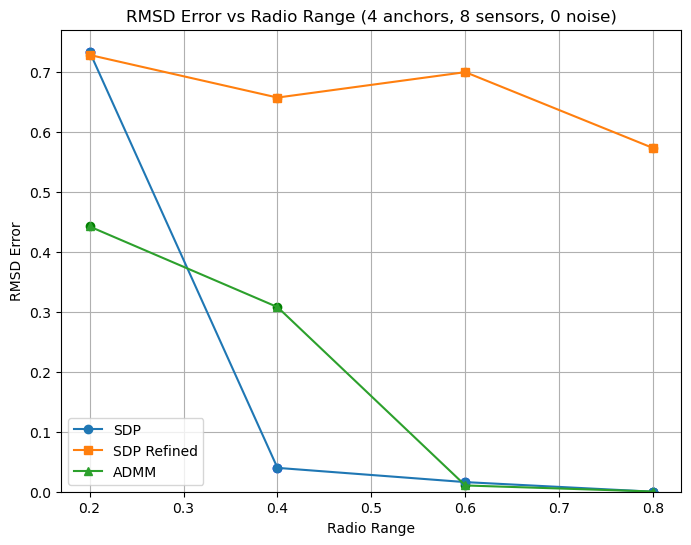

In [14]:
rr = [0.2, 0.4, 0.6, 0.8]

plt.figure(figsize=(8, 6))
plt.plot(rr, e0, label='SDP', marker='o')
plt.scatter(rr, e0, color='blue')

plt.plot(rr, f0, label="SDP Refined", marker='s')
plt.scatter(rr, f0, color='orange')

plt.plot(rr, g0, label='ADMM', marker='^')
plt.scatter(rr, g0, color='green')

plt.title("RMSD Error vs Radio Range (4 anchors, 8 sensors, 0 noise)")
plt.xlabel("Radio Range")
plt.ylabel("RMSD Error")
plt.grid(True)
plt.legend()
plt.ylim(bottom=0)

plt.show()

In [15]:
%%time 
e1, f1, g1 = simulation_rad_fixed_noise_iter(0.1);

0


  0%|          | 2/1000 [00:00<01:18, 12.77it/s]

0.33358194886844883
0.3092299272541741
0.03577758104949082


  1%|          | 6/1000 [00:00<01:28, 11.28it/s]

0.03506899307584156
0.018993545172227358
0.012447435649657439


  1%|          | 8/1000 [00:00<01:24, 11.81it/s]

0.008453125941830866
0.0060047622732695635
0.004412804868886771


  1%|          | 12/1000 [00:01<01:22, 11.93it/s]

0.0033349763781225124
0.0025797461320217693
0.002035259730776508


  2%|▏         | 16/1000 [00:01<01:20, 12.21it/s]

0.0016330801819165464
0.001329644655770396
0.0010965192990731072
0.0009145047254295003


  2%|▏         | 18/1000 [00:01<01:17, 12.74it/s]

0.0007703946766527614
0.0006548418810246688
0.0005611327606717511
0.00048436088002892785


  2%|▏         | 22/1000 [00:01<01:19, 12.34it/s]

0.00042088370628997306
0.00036795861822649586
0.00032349373618570983
0.0002858742483600168


  3%|▎         | 28/1000 [00:02<01:10, 13.70it/s]

0.0002538400226342937
0.0002263981818691114
0.0002027591493137435
0.00018229011680545235


  3%|▎         | 30/1000 [00:02<01:10, 13.81it/s]

0.00016448138085457375
0.00014891781833036325
0.00013525913315184978


  3%|▎         | 34/1000 [00:02<01:12, 13.28it/s]

0.00012322491083844277
0.00011258258790840443
0.00010313826398128346


  4%|▎         | 36/1000 [00:02<01:10, 13.60it/s]

9.472937309754482e-05
8.721907108101426e-05
8.049148994807172e-05


  4%|▍         | 40/1000 [00:03<01:10, 13.60it/s]

7.444812325710739e-05
6.900488244056171e-05
6.408969933822061e-05


  4%|▍         | 44/1000 [00:03<01:12, 13.11it/s]

5.9640575312060054e-05
5.5603958343694105e-05
5.1933445561298244e-05
4.858878799650075e-05


  5%|▍         | 48/1000 [00:03<01:09, 13.60it/s]

4.553494105007886e-05
4.2741026866512056e-05
4.018005868121929e-05
3.7828357173780086e-05


  5%|▌         | 50/1000 [00:03<01:15, 12.54it/s]

3.566503571565856e-05
3.3671616112197485e-05
3.1831726630942875e-05
3.0130828585479374e-05


  5%|▌         | 54/1000 [00:04<01:12, 12.99it/s]

2.855595931605594e-05
2.7095625927332843e-05
2.573946066605358e-05


  6%|▌         | 58/1000 [00:04<01:11, 13.24it/s]

2.4478241920382793e-05
2.3303680025255308e-05
2.2211390348007994e-05


  6%|▌         | 60/1000 [00:04<01:14, 12.69it/s]

2.1193966203118136e-05
2.0233825088426436e-05
1.9337747921542863e-05


  6%|▋         | 64/1000 [00:04<01:07, 13.82it/s]

1.849766456985891e-05
1.7709212118264552e-05
1.6968273612546266e-05


  7%|▋         | 68/1000 [00:05<01:04, 14.45it/s]

1.627116283643823e-05
1.5614515775303167e-05
1.499526975547405e-05
1.4410629530155238e-05


  7%|▋         | 70/1000 [00:05<01:04, 14.36it/s]

1.3858042478011887e-05
1.3335174037740064e-05
1.2839887549594153e-05


  7%|▋         | 74/1000 [00:05<01:05, 14.06it/s]

1.2370220011592757e-05
1.1924366578110765e-05
1.1500668402161644e-05
1.1097625167378266e-05


  8%|▊         | 78/1000 [00:05<01:03, 14.58it/s]

1.0713921033003585e-05
1.034812141844911e-05
9.99913509620729e-06
9.665927910190318e-06


  8%|▊         | 82/1000 [00:06<01:06, 13.73it/s]

9.347409878234588e-06
9.04263922197891e-06
8.750773460542761e-06


  9%|▊         | 86/1000 [00:06<01:03, 14.42it/s]

8.471082163400941e-06
8.202856178154917e-06
7.945258148268691e-06
7.697849986165251e-06


  9%|▉         | 88/1000 [00:06<01:03, 14.34it/s]

7.460026046859263e-06
7.231193820962439e-06
7.010858015405391e-06


  9%|▉         | 92/1000 [00:06<01:06, 13.59it/s]

6.798569067075551e-06
6.593860304268602e-06
6.396379595967057e-06


 10%|▉         | 96/1000 [00:07<01:01, 14.67it/s]

6.205773535140712e-06
6.0217014558413445e-06
5.843845794154039e-06
5.67190982499744e-06


 10%|▉         | 98/1000 [00:07<01:02, 14.51it/s]

5.5056183740273535e-06
5.34471508112781e-06
5.188959828635698e-06


 10%|█         | 102/1000 [00:07<01:03, 14.12it/s]

5.038129025702437e-06
4.892013658366044e-06
4.750418235774742e-06


 11%|█         | 106/1000 [00:07<01:00, 14.67it/s]

4.613152044058297e-06
4.480050699606742e-06
4.350957679857966e-06
4.225722248741345e-06


 11%|█         | 108/1000 [00:08<01:01, 14.52it/s]

4.1041903508776925e-06
3.986228646622535e-06
3.87172071506989e-06


 11%|█         | 112/1000 [00:08<01:03, 13.96it/s]

3.760547591775558e-06
3.6525968823384073e-06
3.547762254713598e-06
3.4459425557310477e-06


 12%|█▏        | 116/1000 [00:08<01:00, 14.51it/s]

3.347041896378355e-06
3.2509738186108306e-06
3.157652423487438e-06


 12%|█▏        | 120/1000 [00:08<01:02, 14.12it/s]

3.066986506819648e-06
2.9788971155634745e-06
2.8933051194522067e-06
2.810125885515318e-06


 12%|█▏        | 124/1000 [00:09<01:01, 14.14it/s]

2.729308152005141e-06
2.6507856653841338e-06
2.5744937672819777e-06
2.5003699716921642e-06


 13%|█▎        | 128/1000 [00:09<01:01, 14.12it/s]

2.42835459085925e-06
2.3583897401626487e-06
2.2904194693440863e-06
2.2243898324666387e-06


 13%|█▎        | 132/1000 [00:09<01:02, 13.90it/s]

2.160247614737477e-06
2.097942573730361e-06
2.037425834701547e-06
1.9786491506414443e-06


 14%|█▎        | 136/1000 [00:10<01:01, 14.05it/s]

1.921565805490836e-06
1.8661307491777595e-06
1.8122993838376558e-06
1.760028747940372e-06


 14%|█▍        | 138/1000 [00:10<01:01, 14.05it/s]

1.7092767689461336e-06
1.660004615933579e-06
1.6121722142916324e-06


 14%|█▍        | 142/1000 [00:10<01:02, 13.69it/s]

1.565738525324001e-06
1.5206651831939393e-06
1.476915215280871e-06


 15%|█▍        | 146/1000 [00:10<00:59, 14.31it/s]

1.434452017610462e-06
1.393240135214744e-06
1.3532447848202132e-06
1.314431927504276e-06


 15%|█▌        | 150/1000 [00:11<01:02, 13.62it/s]

1.2767687758485696e-06
1.240214825774982e-06
1.2047422901443534e-06
1.1703242183430882e-06


 15%|█▌        | 154/1000 [00:11<00:59, 14.21it/s]

1.1369312358881225e-06
1.1045337828699843e-06
1.0731031689573738e-06
1.0426119293572848e-06


 16%|█▌        | 156/1000 [00:11<00:59, 14.18it/s]

1.0130324952191538e-06
9.843434168969935e-07
9.565162671782207e-07


 16%|█▌        | 160/1000 [00:11<01:01, 13.61it/s]

9.295235126467367e-07
9.033402257987343e-07
8.779426494850252e-07


 16%|█▋        | 164/1000 [00:12<01:00, 13.86it/s]

8.533073219871336e-07
8.29411163074699e-07
8.062322563187293e-07
7.837489324088864e-07


 17%|█▋        | 166/1000 [00:12<01:01, 13.51it/s]

7.619399744846263e-07
7.407849540003922e-07
7.202639942300069e-07


 17%|█▋        | 170/1000 [00:12<01:04, 12.94it/s]

7.003577247903178e-07
6.810472771469926e-07
6.623141695210985e-07


 17%|█▋        | 174/1000 [00:12<00:59, 13.95it/s]

6.441407989962982e-07
6.265098182375162e-07
6.094042373114952e-07
5.928078490636796e-07


 18%|█▊        | 178/1000 [00:13<00:59, 13.84it/s]

5.767048813583866e-07
5.610853306895191e-07
5.459293880477011e-07
5.312212484457342e-07


 18%|█▊        | 182/1000 [00:13<00:57, 14.21it/s]

5.169468279080928e-07
5.030925396389987e-07
4.896450994894332e-07
4.7659175934880487e-07


 19%|█▊        | 186/1000 [00:13<00:56, 14.49it/s]

4.6392013000634585e-07
4.516182103491468e-07
4.3967407259816807e-07
4.2807694948207133e-07


 19%|█▉        | 188/1000 [00:13<01:02, 13.00it/s]

4.1681569990967385e-07
4.0587978647991526e-07
3.9525925478885624e-07


 19%|█▉        | 192/1000 [00:14<01:01, 13.08it/s]

3.849440332227979e-07
3.749246831419393e-07
3.6519203050101026e-07


 20%|█▉        | 196/1000 [00:14<00:58, 13.68it/s]

3.55737124656394e-07
3.4655132217029303e-07
3.376263422065939e-07
3.289539982103826e-07


 20%|██        | 200/1000 [00:14<00:58, 13.73it/s]

3.2052670273584063e-07
3.1233690572667793e-07
3.0437723787790085e-07
2.9664084305168667e-07


 20%|██        | 204/1000 [00:15<00:55, 14.40it/s]

2.891213210331826e-07
2.818113088059522e-07
2.7469850925830914e-07
2.6776400653122294e-07


 21%|██        | 208/1000 [00:15<00:58, 13.64it/s]

2.611740354992718e-07
2.5469765345337707e-07
2.4849608277017763e-07
2.423744353199304e-07


 21%|██        | 212/1000 [00:15<00:55, 14.21it/s]

2.3635821734054824e-07
2.304982649603323e-07
2.2480137885534792e-07
2.1925614216884003e-07


 21%|██▏       | 214/1000 [00:15<00:55, 14.22it/s]

2.1385833370349487e-07
2.0860344945467894e-07
2.0348741119168018e-07


 22%|██▏       | 218/1000 [00:16<01:02, 12.58it/s]

1.985061785309347e-07
1.9365587500053667e-07
1.889326890823226e-07


 22%|██▏       | 220/1000 [00:16<01:01, 12.63it/s]

1.8433299321946858e-07
1.7985316605540052e-07
1.754898647810219e-07


 22%|██▏       | 224/1000 [00:16<01:02, 12.40it/s]

1.7123965173147997e-07
1.670993922556938e-07
1.630659972348225e-07


 23%|██▎       | 226/1000 [00:16<01:09, 11.19it/s]

1.5913635185511632e-07
1.5529091118198818e-07
1.5151244946299742e-07


 23%|██▎       | 230/1000 [00:17<01:06, 11.59it/s]

1.478475065288008e-07
1.4432314249679237e-07
1.4091368239919908e-07


 23%|██▎       | 232/1000 [00:17<01:02, 12.37it/s]

1.3758007309144927e-07
1.3430576171888e-07
1.3110799655854888e-07


 24%|██▎       | 236/1000 [00:17<01:03, 12.06it/s]

1.2799079776430647e-07
1.2495191062002717e-07
1.2198917211596808e-07


 24%|██▍       | 238/1000 [00:17<01:05, 11.61it/s]

1.1910048383369091e-07
1.1628382323114293e-07
1.1353720691028802e-07


 24%|██▍       | 242/1000 [00:18<01:01, 12.35it/s]

1.1085876292324239e-07
1.0824657346253371e-07
1.0569887555903406e-07


 24%|██▍       | 244/1000 [00:18<00:57, 13.25it/s]

1.0321399858613609e-07
1.0079012950197209e-07
9.842574528476007e-08
1



  0%|          | 2/1000 [00:00<01:11, 14.02it/s]

0.33358194886844883
0.3092299272541741
0.03577758104949082


  1%|          | 6/1000 [00:00<01:07, 14.79it/s]

0.03506899307584156
0.018993545172227358
0.012447435649657439


  1%|          | 8/1000 [00:00<01:08, 14.50it/s]

0.008453125941830866
0.0060047622732695635
0.004412804868886771


  1%|          | 12/1000 [00:00<01:14, 13.22it/s]

0.0033349763781225124
0.0025797461320217693
0.002035259730776508


  2%|▏         | 16/1000 [00:01<01:12, 13.62it/s]

0.0016330801819165464
0.001329644655770396
0.0010965192990731072
0.0009145047254295003


  2%|▏         | 18/1000 [00:01<01:08, 14.34it/s]

0.0007703946766527614
0.0006548418810246688
0.0005611327606717511


  2%|▏         | 22/1000 [00:01<01:11, 13.62it/s]

0.00048436088002892785
0.00042088370628997306
0.00036795861822649586


  2%|▏         | 24/1000 [00:01<01:14, 13.15it/s]

0.00032349373618570983
0.0002858742483600168
0.0002538400226342937


  3%|▎         | 28/1000 [00:02<01:14, 13.03it/s]

0.0002263981818691114
0.0002027591493137435
0.00018229011680545235


  3%|▎         | 30/1000 [00:02<01:17, 12.53it/s]

0.00016448138085457375
0.00014891781833036325
0.00013525913315184978


  3%|▎         | 34/1000 [00:02<01:10, 13.69it/s]

0.00012322491083844277
0.00011258258790840443
0.00010313826398128346


  4%|▎         | 36/1000 [00:02<01:14, 12.97it/s]

9.472937309754482e-05
8.721907108101426e-05
8.049148994807172e-05


  4%|▍         | 40/1000 [00:03<01:13, 13.09it/s]

7.444812325710739e-05
6.900488244056171e-05
6.408969933822061e-05
5.9640575312060054e-05


  4%|▍         | 44/1000 [00:03<01:09, 13.68it/s]

5.5603958343694105e-05
5.1933445561298244e-05
4.858878799650075e-05


  5%|▍         | 48/1000 [00:03<01:08, 13.84it/s]

4.553494105007886e-05
4.2741026866512056e-05
4.018005868121929e-05
3.7828357173780086e-05


  5%|▌         | 52/1000 [00:03<01:12, 13.08it/s]

3.566503571565856e-05
3.3671616112197485e-05
3.1831726630942875e-05
3.0130828585479374e-05


  6%|▌         | 56/1000 [00:04<01:08, 13.84it/s]

2.855595931605594e-05
2.7095625927332843e-05
2.573946066605358e-05
2.4478241920382793e-05


  6%|▌         | 58/1000 [00:04<01:06, 14.08it/s]

2.3303680025255308e-05
2.2211390348007994e-05
2.1193966203118136e-05


  6%|▌         | 62/1000 [00:04<01:08, 13.69it/s]

2.0233825088426436e-05
1.9337747921542863e-05
1.849766456985891e-05


  7%|▋         | 66/1000 [00:04<01:07, 13.81it/s]

1.7709212118264552e-05
1.6968273612546266e-05
1.627116283643823e-05
1.5614515775303167e-05


  7%|▋         | 68/1000 [00:05<01:10, 13.16it/s]

1.499526975547405e-05
1.4410629530155238e-05
1.3858042478011887e-05


  7%|▋         | 72/1000 [00:05<01:09, 13.27it/s]

1.3335174037740064e-05
1.2839887549594153e-05
1.2370220011592757e-05


  7%|▋         | 74/1000 [00:05<01:09, 13.33it/s]

1.1924366578110765e-05
1.1500668402161644e-05
1.1097625167378266e-05


  8%|▊         | 78/1000 [00:05<01:15, 12.24it/s]

1.0713921033003585e-05
1.034812141844911e-05
9.99913509620729e-06


  8%|▊         | 82/1000 [00:06<01:09, 13.30it/s]

9.665927910190318e-06
9.347409878234588e-06
9.04263922197891e-06
8.750773460542761e-06


  8%|▊         | 84/1000 [00:06<01:10, 13.01it/s]

8.471082163400941e-06
8.202856178154917e-06
7.945258148268691e-06


  9%|▉         | 88/1000 [00:06<01:13, 12.47it/s]

7.697849986165251e-06
7.460026046859263e-06
7.231193820962439e-06


  9%|▉         | 92/1000 [00:06<01:09, 13.04it/s]

7.010858015405391e-06
6.798569067075551e-06
6.593860304268602e-06
6.396379595967057e-06


  9%|▉         | 94/1000 [00:07<01:13, 12.25it/s]

6.205773535140712e-06
6.0217014558413445e-06
5.843845794154039e-06


 10%|▉         | 98/1000 [00:07<01:18, 11.56it/s]

5.67190982499744e-06
5.5056183740273535e-06
5.34471508112781e-06


 10%|█         | 102/1000 [00:07<01:10, 12.78it/s]

5.188959828635698e-06
5.038129025702437e-06
4.892013658366044e-06
4.750418235774742e-06


 11%|█         | 106/1000 [00:08<01:07, 13.25it/s]

4.613152044058297e-06
4.480050699606742e-06
4.350957679857966e-06
4.225722248741345e-06


 11%|█         | 108/1000 [00:08<01:13, 12.21it/s]

4.1041903508776925e-06
3.986228646622535e-06
3.87172071506989e-06


 11%|█         | 112/1000 [00:08<01:09, 12.83it/s]

3.760547591775558e-06
3.6525968823384073e-06
3.547762254713598e-06


 12%|█▏        | 116/1000 [00:08<01:07, 13.13it/s]

3.4459425557310477e-06
3.347041896378355e-06
3.2509738186108306e-06
3.157652423487438e-06


 12%|█▏        | 120/1000 [00:09<01:07, 13.05it/s]

3.066986506819648e-06
2.9788971155634745e-06
2.8933051194522067e-06
2.810125885515318e-06


 12%|█▏        | 124/1000 [00:09<01:05, 13.44it/s]

2.729308152005141e-06
2.6507856653841338e-06
2.5744937672819777e-06
2.5003699716921642e-06


 13%|█▎        | 128/1000 [00:09<01:10, 12.41it/s]

2.42835459085925e-06
2.3583897401626487e-06
2.2904194693440863e-06
2.2243898324666387e-06


 13%|█▎        | 132/1000 [00:10<01:07, 12.89it/s]

2.160247614737477e-06
2.097942573730361e-06
2.037425834701547e-06
1.9786491506414443e-06


 13%|█▎        | 134/1000 [00:10<01:05, 13.17it/s]

1.921565805490836e-06
1.8661307491777595e-06
1.8122993838376558e-06


 14%|█▍        | 138/1000 [00:10<01:09, 12.45it/s]

1.760028747940372e-06
1.7092767689461336e-06
1.660004615933579e-06


 14%|█▍        | 142/1000 [00:10<01:04, 13.34it/s]

1.6121722142916324e-06
1.565738525324001e-06
1.5206651831939393e-06
1.476915215280871e-06


 14%|█▍        | 144/1000 [00:11<01:04, 13.27it/s]

1.434452017610462e-06
1.393240135214744e-06
1.3532447848202132e-06


 15%|█▍        | 148/1000 [00:11<01:07, 12.56it/s]

1.314431927504276e-06
1.2767687758485696e-06
1.240214825774982e-06


 15%|█▌        | 150/1000 [00:11<01:04, 13.10it/s]

1.2047422901443534e-06
1.1703242183430882e-06
1.1369312358881225e-06


 15%|█▌        | 152/1000 [00:11<01:04, 13.12it/s]

1.1045337828699843e-06
1.0731031689573738e-06


 16%|█▌        | 156/1000 [00:12<01:12, 11.70it/s]

1.0426119293572848e-06
1.0130324952191538e-06
9.843434168969935e-07


 16%|█▌        | 158/1000 [00:12<01:12, 11.54it/s]

9.565162671782207e-07
9.295235126467367e-07
9.033402257987343e-07


 16%|█▌        | 162/1000 [00:12<01:08, 12.16it/s]

8.779426494850252e-07
8.533073219871336e-07
8.29411163074699e-07


 16%|█▋        | 164/1000 [00:12<01:12, 11.49it/s]

8.062322563187293e-07
7.837489324088864e-07


 17%|█▋        | 166/1000 [00:12<01:17, 10.81it/s]

7.619399744846263e-07
7.407849540003922e-07
7.202639942300069e-07


 17%|█▋        | 170/1000 [00:13<01:08, 12.16it/s]

7.003577247903178e-07
6.810472771469926e-07
6.623141695210985e-07


 17%|█▋        | 174/1000 [00:13<01:04, 12.86it/s]

6.441407989962982e-07
6.265098182375162e-07
6.094042373114952e-07
5.928078490636796e-07


 18%|█▊        | 176/1000 [00:13<01:05, 12.54it/s]

5.767048813583866e-07
5.610853306895191e-07
5.459293880477011e-07


 18%|█▊        | 180/1000 [00:14<01:07, 12.22it/s]

5.312212484457342e-07
5.169468279080928e-07
5.030925396389987e-07


 18%|█▊        | 182/1000 [00:14<01:08, 11.91it/s]

4.896450994894332e-07
4.7659175934880487e-07


 18%|█▊        | 184/1000 [00:14<01:17, 10.50it/s]

4.6392013000634585e-07
4.516182103491468e-07
4.3967407259816807e-07


 19%|█▉        | 188/1000 [00:14<01:06, 12.13it/s]

4.2807694948207133e-07
4.1681569990967385e-07
4.0587978647991526e-07


 19%|█▉        | 192/1000 [00:15<01:01, 13.11it/s]

3.9525925478885624e-07
3.849440332227979e-07
3.749246831419393e-07
3.6519203050101026e-07


 19%|█▉        | 194/1000 [00:15<01:04, 12.50it/s]

3.55737124656394e-07
3.4655132217029303e-07
3.376263422065939e-07


 20%|█▉        | 198/1000 [00:15<01:00, 13.35it/s]

3.289539982103826e-07
3.2052670273584063e-07
3.1233690572667793e-07


 20%|██        | 202/1000 [00:15<00:57, 13.80it/s]

3.0437723787790085e-07
2.9664084305168667e-07
2.891213210331826e-07
2.818113088059522e-07


 20%|██        | 204/1000 [00:15<01:03, 12.53it/s]

2.7469850925830914e-07
2.6776400653122294e-07
2.611740354992718e-07


 21%|██        | 208/1000 [00:16<01:04, 12.21it/s]

2.5469765345337707e-07
2.4849608277017763e-07
2.423744353199304e-07


 21%|██        | 210/1000 [00:16<01:02, 12.66it/s]

2.3635821734054824e-07
2.304982649603323e-07
2.2480137885534792e-07


 21%|██▏       | 214/1000 [00:16<01:01, 12.81it/s]

2.1925614216884003e-07
2.1385833370349487e-07
2.0860344945467894e-07


 22%|██▏       | 218/1000 [00:17<01:00, 13.03it/s]

2.0348741119168018e-07
1.985061785309347e-07
1.9365587500053667e-07
1.889326890823226e-07


 22%|██▏       | 222/1000 [00:17<00:58, 13.27it/s]

1.8433299321946858e-07
1.7985316605540052e-07
1.754898647810219e-07
1.7123965173147997e-07


 23%|██▎       | 226/1000 [00:17<00:58, 13.32it/s]

1.670993922556938e-07
1.630659972348225e-07
1.5913635185511632e-07
1.5529091118198818e-07


 23%|██▎       | 230/1000 [00:17<00:55, 13.82it/s]

1.5151244946299742e-07
1.478475065288008e-07
1.4432314249679237e-07
1.4091368239919908e-07


 23%|██▎       | 232/1000 [00:18<00:54, 14.07it/s]

1.3758007309144927e-07
1.3430576171888e-07
1.3110799655854888e-07


 24%|██▎       | 236/1000 [00:18<00:56, 13.55it/s]

1.2799079776430647e-07
1.2495191062002717e-07
1.2198917211596808e-07


 24%|██▍       | 240/1000 [00:18<00:53, 14.16it/s]

1.1910048383369091e-07
1.1628382323114293e-07
1.1353720691028802e-07
1.1085876292324239e-07


 24%|██▍       | 244/1000 [00:18<00:55, 13.74it/s]

1.0824657346253371e-07
1.0569887555903406e-07
1.0321399858613609e-07
1.0079012950197209e-07


 24%|██▍       | 244/1000 [00:19<00:58, 12.81it/s]


9.842574528476007e-08
2


  0%|          | 4/1000 [00:00<01:06, 15.02it/s]

0.33358194886844883
0.3092299272541741
0.03577758104949082
0.03506899307584156


  1%|          | 6/1000 [00:00<01:14, 13.40it/s]

0.018993545172227358
0.012447435649657439
0.008453125941830866


  1%|          | 10/1000 [00:00<01:11, 13.94it/s]

0.0060047622732695635
0.004412804868886771
0.0033349763781225124
0.0025797461320217693


  1%|▏         | 14/1000 [00:00<01:07, 14.60it/s]

0.002035259730776508
0.0016330801819165464
0.001329644655770396


  2%|▏         | 18/1000 [00:01<01:10, 13.99it/s]

0.0010965192990731072
0.0009145047254295003
0.0007703946766527614
0.0006548418810246688


  2%|▏         | 22/1000 [00:01<01:08, 14.33it/s]

0.0005611327606717511
0.00048436088002892785
0.00042088370628997306
0.00036795861822649586


  2%|▏         | 24/1000 [00:01<01:06, 14.69it/s]

0.00032349373618570983
0.0002858742483600168
0.0002538400226342937


  3%|▎         | 28/1000 [00:01<01:09, 14.01it/s]

0.0002263981818691114
0.0002027591493137435
0.00018229011680545235
0.00016448138085457375


  3%|▎         | 32/1000 [00:02<01:07, 14.42it/s]

0.00014891781833036325
0.00013525913315184978
0.00012322491083844277
0.00011258258790840443


  4%|▎         | 36/1000 [00:02<01:12, 13.37it/s]

0.00010313826398128346
9.472937309754482e-05
8.721907108101426e-05


  4%|▍         | 40/1000 [00:02<01:07, 14.24it/s]

8.049148994807172e-05
7.444812325710739e-05
6.900488244056171e-05
6.408969933822061e-05


  4%|▍         | 42/1000 [00:02<01:06, 14.36it/s]

5.9640575312060054e-05
5.5603958343694105e-05
5.1933445561298244e-05


  5%|▍         | 46/1000 [00:03<01:08, 13.83it/s]

4.858878799650075e-05
4.553494105007886e-05
4.2741026866512056e-05


  5%|▌         | 50/1000 [00:03<01:07, 14.06it/s]

4.018005868121929e-05
3.7828357173780086e-05
3.566503571565856e-05
3.3671616112197485e-05


  5%|▌         | 52/1000 [00:03<01:06, 14.24it/s]

3.1831726630942875e-05
3.0130828585479374e-05
2.855595931605594e-05


  6%|▌         | 56/1000 [00:03<01:07, 14.01it/s]

2.7095625927332843e-05
2.573946066605358e-05
2.4478241920382793e-05
2.3303680025255308e-05


  6%|▌         | 60/1000 [00:04<01:06, 14.07it/s]

2.2211390348007994e-05
2.1193966203118136e-05
2.0233825088426436e-05


  6%|▌         | 62/1000 [00:04<01:06, 14.20it/s]

1.9337747921542863e-05
1.849766456985891e-05
1.7709212118264552e-05


  7%|▋         | 66/1000 [00:04<01:09, 13.36it/s]

1.6968273612546266e-05
1.627116283643823e-05
1.5614515775303167e-05


  7%|▋         | 68/1000 [00:04<01:10, 13.29it/s]

1.499526975547405e-05
1.4410629530155238e-05
1.3858042478011887e-05


  7%|▋         | 72/1000 [00:05<01:14, 12.42it/s]

1.3335174037740064e-05
1.2839887549594153e-05
1.2370220011592757e-05


  8%|▊         | 76/1000 [00:05<01:10, 13.18it/s]

1.1924366578110765e-05
1.1500668402161644e-05
1.1097625167378266e-05
1.0713921033003585e-05


  8%|▊         | 80/1000 [00:05<01:06, 13.91it/s]

1.034812141844911e-05
9.99913509620729e-06
9.665927910190318e-06
9.347409878234588e-06


  8%|▊         | 82/1000 [00:05<01:07, 13.67it/s]

9.04263922197891e-06
8.750773460542761e-06
8.471082163400941e-06


  9%|▊         | 86/1000 [00:06<01:09, 13.21it/s]

8.202856178154917e-06
7.945258148268691e-06
7.697849986165251e-06
7.460026046859263e-06


  9%|▉         | 90/1000 [00:06<01:05, 13.90it/s]

7.231193820962439e-06
7.010858015405391e-06
6.798569067075551e-06
6.593860304268602e-06


  9%|▉         | 94/1000 [00:06<01:08, 13.28it/s]

6.396379595967057e-06
6.205773535140712e-06
6.0217014558413445e-06


 10%|▉         | 96/1000 [00:06<01:07, 13.38it/s]

5.843845794154039e-06
5.67190982499744e-06
5.5056183740273535e-06


 10%|█         | 100/1000 [00:07<01:10, 12.78it/s]

5.34471508112781e-06
5.188959828635698e-06
5.038129025702437e-06


 10%|█         | 102/1000 [00:07<01:20, 11.13it/s]

4.892013658366044e-06
4.750418235774742e-06
4.613152044058297e-06


 11%|█         | 106/1000 [00:07<01:19, 11.31it/s]

4.480050699606742e-06
4.350957679857966e-06
4.225722248741345e-06


 11%|█         | 108/1000 [00:08<01:16, 11.66it/s]

4.1041903508776925e-06
3.986228646622535e-06
3.87172071506989e-06


 11%|█         | 112/1000 [00:08<01:14, 11.86it/s]

3.760547591775558e-06
3.6525968823384073e-06
3.547762254713598e-06


 12%|█▏        | 116/1000 [00:08<01:12, 12.25it/s]

3.4459425557310477e-06
3.347041896378355e-06
3.2509738186108306e-06
3.157652423487438e-06


 12%|█▏        | 120/1000 [00:09<01:08, 12.83it/s]

3.066986506819648e-06
2.9788971155634745e-06
2.8933051194522067e-06
2.810125885515318e-06


 12%|█▏        | 122/1000 [00:09<01:13, 11.94it/s]

2.729308152005141e-06
2.6507856653841338e-06
2.5744937672819777e-06


 13%|█▎        | 126/1000 [00:09<01:07, 12.91it/s]

2.5003699716921642e-06
2.42835459085925e-06
2.3583897401626487e-06


 13%|█▎        | 130/1000 [00:09<01:05, 13.21it/s]

2.2904194693440863e-06
2.2243898324666387e-06
2.160247614737477e-06
2.097942573730361e-06


 13%|█▎        | 134/1000 [00:10<01:05, 13.26it/s]

2.037425834701547e-06
1.9786491506414443e-06
1.921565805490836e-06
1.8661307491777595e-06


 14%|█▍        | 138/1000 [00:10<01:02, 13.88it/s]

1.8122993838376558e-06
1.760028747940372e-06
1.7092767689461336e-06
1.660004615933579e-06


 14%|█▍        | 140/1000 [00:10<01:01, 14.02it/s]

1.6121722142916324e-06
1.565738525324001e-06
1.5206651831939393e-06


 14%|█▍        | 144/1000 [00:10<01:15, 11.38it/s]

1.476915215280871e-06
1.434452017610462e-06
1.393240135214744e-06


 15%|█▍        | 148/1000 [00:11<01:07, 12.61it/s]

1.3532447848202132e-06
1.314431927504276e-06
1.2767687758485696e-06
1.240214825774982e-06


 15%|█▌        | 150/1000 [00:11<01:04, 13.17it/s]

1.2047422901443534e-06
1.1703242183430882e-06
1.1369312358881225e-06


 15%|█▌        | 154/1000 [00:11<01:03, 13.28it/s]

1.1045337828699843e-06
1.0731031689573738e-06
1.0426119293572848e-06


 16%|█▌        | 156/1000 [00:11<01:02, 13.44it/s]

1.0130324952191538e-06
9.843434168969935e-07
9.565162671782207e-07


 16%|█▌        | 160/1000 [00:12<01:04, 13.00it/s]

9.295235126467367e-07
9.033402257987343e-07
8.779426494850252e-07


 16%|█▋        | 164/1000 [00:12<01:00, 13.80it/s]

8.533073219871336e-07
8.29411163074699e-07
8.062322563187293e-07
7.837489324088864e-07


 17%|█▋        | 168/1000 [00:12<00:59, 13.88it/s]

7.619399744846263e-07
7.407849540003922e-07
7.202639942300069e-07
7.003577247903178e-07


 17%|█▋        | 170/1000 [00:12<01:03, 13.05it/s]

6.810472771469926e-07
6.623141695210985e-07
6.441407989962982e-07


 17%|█▋        | 174/1000 [00:13<01:01, 13.44it/s]

6.265098182375162e-07
6.094042373114952e-07
5.928078490636796e-07


 18%|█▊        | 178/1000 [00:13<00:59, 13.86it/s]

5.767048813583866e-07
5.610853306895191e-07
5.459293880477011e-07
5.312212484457342e-07


 18%|█▊        | 180/1000 [00:13<01:05, 12.60it/s]

5.169468279080928e-07
5.030925396389987e-07
4.896450994894332e-07


 18%|█▊        | 184/1000 [00:13<01:00, 13.42it/s]

4.7659175934880487e-07
4.6392013000634585e-07
4.516182103491468e-07
4.3967407259816807e-07


 19%|█▉        | 188/1000 [00:14<01:05, 12.38it/s]

4.2807694948207133e-07
4.1681569990967385e-07
4.0587978647991526e-07


 19%|█▉        | 192/1000 [00:14<01:00, 13.39it/s]

3.9525925478885624e-07
3.849440332227979e-07
3.749246831419393e-07
3.6519203050101026e-07


 20%|█▉        | 196/1000 [00:14<00:59, 13.54it/s]

3.55737124656394e-07
3.4655132217029303e-07
3.376263422065939e-07
3.289539982103826e-07


 20%|█▉        | 198/1000 [00:14<01:01, 13.14it/s]

3.2052670273584063e-07
3.1233690572667793e-07
3.0437723787790085e-07


 20%|██        | 202/1000 [00:15<01:04, 12.28it/s]

2.9664084305168667e-07
2.891213210331826e-07
2.818113088059522e-07


 20%|██        | 204/1000 [00:15<01:01, 12.91it/s]

2.7469850925830914e-07
2.6776400653122294e-07
2.611740354992718e-07


 21%|██        | 208/1000 [00:15<01:02, 12.58it/s]

2.5469765345337707e-07
2.4849608277017763e-07
2.423744353199304e-07


 21%|██        | 210/1000 [00:15<01:05, 12.14it/s]

2.3635821734054824e-07
2.304982649603323e-07
2.2480137885534792e-07


 21%|██▏       | 214/1000 [00:16<01:02, 12.65it/s]

2.1925614216884003e-07
2.1385833370349487e-07
2.0860344945467894e-07


 22%|██▏       | 216/1000 [00:16<01:00, 12.98it/s]

2.0348741119168018e-07
1.985061785309347e-07
1.9365587500053667e-07


 22%|██▏       | 220/1000 [00:16<01:01, 12.69it/s]

1.889326890823226e-07
1.8433299321946858e-07
1.7985316605540052e-07


 22%|██▏       | 222/1000 [00:16<01:01, 12.60it/s]

1.754898647810219e-07
1.7123965173147997e-07
1.670993922556938e-07


 23%|██▎       | 226/1000 [00:17<01:00, 12.85it/s]

1.630659972348225e-07
1.5913635185511632e-07
1.5529091118198818e-07


 23%|██▎       | 228/1000 [00:17<00:59, 12.90it/s]

1.5151244946299742e-07
1.478475065288008e-07
1.4432314249679237e-07


 23%|██▎       | 232/1000 [00:17<01:01, 12.58it/s]

1.4091368239919908e-07
1.3758007309144927e-07
1.3430576171888e-07
1.3110799655854888e-07


 24%|██▎       | 236/1000 [00:17<00:57, 13.36it/s]

1.2799079776430647e-07
1.2495191062002717e-07
1.2198917211596808e-07


 24%|██▍       | 238/1000 [00:18<00:55, 13.72it/s]

1.1910048383369091e-07
1.1628382323114293e-07
1.1353720691028802e-07


 24%|██▍       | 242/1000 [00:18<00:56, 13.38it/s]

1.1085876292324239e-07
1.0824657346253371e-07
1.0569887555903406e-07


 24%|██▍       | 244/1000 [00:18<00:57, 13.09it/s]

1.0321399858613609e-07
1.0079012950197209e-07
9.842574528476007e-08
3



  0%|          | 2/1000 [00:00<01:04, 15.58it/s]

0.33358194886844883
0.3092299272541741
0.03577758104949082


  1%|          | 6/1000 [00:00<01:11, 13.91it/s]

0.03506899307584156
0.018993545172227358
0.012447435649657439
0.008453125941830866


  1%|          | 10/1000 [00:00<01:10, 13.95it/s]

0.0060047622732695635
0.004412804868886771
0.0033349763781225124


  1%|          | 12/1000 [00:00<01:09, 14.19it/s]

0.0025797461320217693
0.002035259730776508
0.0016330801819165464


  2%|▏         | 16/1000 [00:01<01:12, 13.55it/s]

0.001329644655770396
0.0010965192990731072
0.0009145047254295003
0.0007703946766527614


  2%|▏         | 20/1000 [00:01<01:09, 14.11it/s]

0.0006548418810246688
0.0005611327606717511
0.00048436088002892785


  2%|▏         | 22/1000 [00:01<01:15, 12.90it/s]

0.00042088370628997306
0.00036795861822649586
0.00032349373618570983


  3%|▎         | 26/1000 [00:01<01:14, 13.16it/s]

0.0002858742483600168
0.0002538400226342937
0.0002263981818691114


  3%|▎         | 28/1000 [00:02<01:17, 12.55it/s]

0.0002027591493137435
0.00018229011680545235
0.00016448138085457375


  3%|▎         | 32/1000 [00:02<01:21, 11.88it/s]

0.00014891781833036325
0.00013525913315184978
0.00012322491083844277


  3%|▎         | 34/1000 [00:02<01:23, 11.53it/s]

0.00011258258790840443
0.00010313826398128346
9.472937309754482e-05


  4%|▍         | 38/1000 [00:02<01:23, 11.49it/s]

8.721907108101426e-05
8.049148994807172e-05
7.444812325710739e-05


  4%|▍         | 40/1000 [00:03<01:23, 11.54it/s]

6.900488244056171e-05
6.408969933822061e-05
5.9640575312060054e-05


  4%|▍         | 44/1000 [00:03<01:31, 10.47it/s]

5.5603958343694105e-05
5.1933445561298244e-05
4.858878799650075e-05


  5%|▍         | 46/1000 [00:03<01:28, 10.73it/s]

4.553494105007886e-05
4.2741026866512056e-05
4.018005868121929e-05


  5%|▌         | 50/1000 [00:04<01:26, 10.93it/s]

3.7828357173780086e-05
3.566503571565856e-05
3.3671616112197485e-05


  5%|▌         | 52/1000 [00:04<01:22, 11.48it/s]

3.1831726630942875e-05
3.0130828585479374e-05
2.855595931605594e-05


  6%|▌         | 56/1000 [00:04<01:17, 12.14it/s]

2.7095625927332843e-05
2.573946066605358e-05
2.4478241920382793e-05


  6%|▌         | 58/1000 [00:04<01:14, 12.61it/s]

2.3303680025255308e-05
2.2211390348007994e-05
2.1193966203118136e-05


  6%|▌         | 60/1000 [00:04<01:14, 12.54it/s]

2.0233825088426436e-05
1.9337747921542863e-05


  6%|▋         | 64/1000 [00:05<01:18, 11.99it/s]

1.849766456985891e-05
1.7709212118264552e-05
1.6968273612546266e-05


  7%|▋         | 66/1000 [00:05<01:13, 12.68it/s]

1.627116283643823e-05
1.5614515775303167e-05
1.499526975547405e-05


  7%|▋         | 70/1000 [00:05<01:12, 12.85it/s]

1.4410629530155238e-05
1.3858042478011887e-05
1.3335174037740064e-05


  7%|▋         | 72/1000 [00:05<01:17, 12.01it/s]

1.2839887549594153e-05
1.2370220011592757e-05
1.1924366578110765e-05


  8%|▊         | 76/1000 [00:06<01:12, 12.74it/s]

1.1500668402161644e-05
1.1097625167378266e-05
1.0713921033003585e-05


  8%|▊         | 78/1000 [00:06<01:12, 12.67it/s]

1.034812141844911e-05
9.99913509620729e-06
9.665927910190318e-06


  8%|▊         | 82/1000 [00:06<01:12, 12.67it/s]

9.347409878234588e-06
9.04263922197891e-06
8.750773460542761e-06


  8%|▊         | 84/1000 [00:06<01:12, 12.62it/s]

8.471082163400941e-06
8.202856178154917e-06
7.945258148268691e-06


  9%|▉         | 88/1000 [00:07<01:12, 12.52it/s]

7.697849986165251e-06
7.460026046859263e-06
7.231193820962439e-06


  9%|▉         | 90/1000 [00:07<01:13, 12.45it/s]

7.010858015405391e-06
6.798569067075551e-06
6.593860304268602e-06


  9%|▉         | 94/1000 [00:07<01:14, 12.13it/s]

6.396379595967057e-06
6.205773535140712e-06
6.0217014558413445e-06


 10%|▉         | 96/1000 [00:07<01:11, 12.59it/s]

5.843845794154039e-06
5.67190982499744e-06
5.5056183740273535e-06


 10%|█         | 100/1000 [00:08<01:10, 12.80it/s]

5.34471508112781e-06
5.188959828635698e-06
5.038129025702437e-06


 10%|█         | 102/1000 [00:08<01:15, 11.95it/s]

4.892013658366044e-06
4.750418235774742e-06
4.613152044058297e-06


 11%|█         | 106/1000 [00:08<01:08, 13.06it/s]

4.480050699606742e-06
4.350957679857966e-06
4.225722248741345e-06


 11%|█         | 108/1000 [00:08<01:08, 13.03it/s]

4.1041903508776925e-06
3.986228646622535e-06
3.87172071506989e-06


 11%|█         | 112/1000 [00:09<01:08, 12.91it/s]

3.760547591775558e-06
3.6525968823384073e-06
3.547762254713598e-06
3.4459425557310477e-06


 12%|█▏        | 116/1000 [00:09<01:04, 13.74it/s]

3.347041896378355e-06
3.2509738186108306e-06
3.157652423487438e-06


 12%|█▏        | 118/1000 [00:09<01:03, 13.99it/s]

3.066986506819648e-06
2.9788971155634745e-06
2.8933051194522067e-06


 12%|█▏        | 122/1000 [00:09<01:04, 13.52it/s]

2.810125885515318e-06
2.729308152005141e-06
2.6507856653841338e-06
2.5744937672819777e-06


 13%|█▎        | 126/1000 [00:10<01:02, 14.08it/s]

2.5003699716921642e-06
2.42835459085925e-06
2.3583897401626487e-06


 13%|█▎        | 130/1000 [00:10<01:03, 13.80it/s]

2.2904194693440863e-06
2.2243898324666387e-06
2.160247614737477e-06
2.097942573730361e-06


 13%|█▎        | 134/1000 [00:10<01:05, 13.14it/s]

2.037425834701547e-06
1.9786491506414443e-06
1.921565805490836e-06
1.8661307491777595e-06


 14%|█▎        | 136/1000 [00:10<01:05, 13.12it/s]

1.8122993838376558e-06
1.760028747940372e-06
1.7092767689461336e-06


 14%|█▍        | 140/1000 [00:11<01:06, 12.91it/s]

1.660004615933579e-06
1.6121722142916324e-06
1.565738525324001e-06


 14%|█▍        | 142/1000 [00:11<01:11, 12.04it/s]

1.5206651831939393e-06
1.476915215280871e-06
1.434452017610462e-06


 15%|█▍        | 146/1000 [00:11<01:10, 12.15it/s]

1.393240135214744e-06
1.3532447848202132e-06
1.314431927504276e-06


 15%|█▍        | 148/1000 [00:11<01:07, 12.61it/s]

1.2767687758485696e-06
1.240214825774982e-06
1.2047422901443534e-06


 15%|█▌        | 152/1000 [00:12<01:10, 11.94it/s]

1.1703242183430882e-06
1.1369312358881225e-06
1.1045337828699843e-06


 15%|█▌        | 154/1000 [00:12<01:07, 12.45it/s]

1.0731031689573738e-06
1.0426119293572848e-06
1.0130324952191538e-06


 16%|█▌        | 158/1000 [00:12<01:05, 12.86it/s]

9.843434168969935e-07
9.565162671782207e-07
9.295235126467367e-07


 16%|█▌        | 160/1000 [00:12<01:09, 12.01it/s]

9.033402257987343e-07
8.779426494850252e-07
8.533073219871336e-07


 16%|█▋        | 164/1000 [00:13<01:06, 12.62it/s]

8.29411163074699e-07
8.062322563187293e-07
7.837489324088864e-07


 17%|█▋        | 166/1000 [00:13<01:05, 12.77it/s]

7.619399744846263e-07
7.407849540003922e-07
7.202639942300069e-07


 17%|█▋        | 170/1000 [00:13<01:06, 12.45it/s]

7.003577247903178e-07
6.810472771469926e-07
6.623141695210985e-07


 17%|█▋        | 172/1000 [00:13<01:04, 12.85it/s]

6.441407989962982e-07
6.265098182375162e-07
6.094042373114952e-07


 18%|█▊        | 176/1000 [00:14<01:04, 12.83it/s]

5.928078490636796e-07
5.767048813583866e-07
5.610853306895191e-07


 18%|█▊        | 178/1000 [00:14<01:06, 12.34it/s]

5.459293880477011e-07
5.312212484457342e-07
5.169468279080928e-07


 18%|█▊        | 182/1000 [00:14<01:00, 13.46it/s]

5.030925396389987e-07
4.896450994894332e-07
4.7659175934880487e-07


 18%|█▊        | 184/1000 [00:14<01:00, 13.58it/s]

4.6392013000634585e-07
4.516182103491468e-07
4.3967407259816807e-07


 19%|█▉        | 188/1000 [00:14<00:59, 13.59it/s]

4.2807694948207133e-07
4.1681569990967385e-07
4.0587978647991526e-07


 19%|█▉        | 192/1000 [00:15<01:00, 13.32it/s]

3.9525925478885624e-07
3.849440332227979e-07
3.749246831419393e-07
3.6519203050101026e-07


 19%|█▉        | 194/1000 [00:15<01:00, 13.41it/s]

3.55737124656394e-07
3.4655132217029303e-07
3.376263422065939e-07


 20%|█▉        | 198/1000 [00:15<00:59, 13.52it/s]

3.289539982103826e-07
3.2052670273584063e-07
3.1233690572667793e-07


 20%|██        | 202/1000 [00:15<00:59, 13.38it/s]

3.0437723787790085e-07
2.9664084305168667e-07
2.891213210331826e-07
2.818113088059522e-07


 21%|██        | 206/1000 [00:16<00:55, 14.28it/s]

2.7469850925830914e-07
2.6776400653122294e-07
2.611740354992718e-07
2.5469765345337707e-07


 21%|██        | 208/1000 [00:16<01:00, 13.02it/s]

2.4849608277017763e-07
2.423744353199304e-07
2.3635821734054824e-07


 21%|██        | 212/1000 [00:16<00:58, 13.38it/s]

2.304982649603323e-07
2.2480137885534792e-07
2.1925614216884003e-07


 21%|██▏       | 214/1000 [00:16<00:57, 13.69it/s]

2.1385833370349487e-07
2.0860344945467894e-07
2.0348741119168018e-07


 22%|██▏       | 218/1000 [00:17<01:03, 12.40it/s]

1.985061785309347e-07
1.9365587500053667e-07
1.889326890823226e-07


 22%|██▏       | 220/1000 [00:17<01:02, 12.44it/s]

1.8433299321946858e-07
1.7985316605540052e-07
1.754898647810219e-07


 22%|██▏       | 224/1000 [00:17<01:01, 12.71it/s]

1.7123965173147997e-07
1.670993922556938e-07
1.630659972348225e-07


 23%|██▎       | 226/1000 [00:17<01:01, 12.63it/s]

1.5913635185511632e-07
1.5529091118198818e-07
1.5151244946299742e-07


 23%|██▎       | 230/1000 [00:18<01:02, 12.25it/s]

1.478475065288008e-07
1.4432314249679237e-07
1.4091368239919908e-07


 23%|██▎       | 234/1000 [00:18<00:57, 13.23it/s]

1.3758007309144927e-07
1.3430576171888e-07
1.3110799655854888e-07
1.2799079776430647e-07


 24%|██▎       | 236/1000 [00:18<01:07, 11.39it/s]

1.2495191062002717e-07
1.2198917211596808e-07
1.1910048383369091e-07


 24%|██▍       | 240/1000 [00:19<01:04, 11.83it/s]

1.1628382323114293e-07
1.1353720691028802e-07
1.1085876292324239e-07


 24%|██▍       | 242/1000 [00:19<01:05, 11.60it/s]

1.0824657346253371e-07
1.0569887555903406e-07
1.0321399858613609e-07


 24%|██▍       | 244/1000 [00:19<01:00, 12.54it/s]

1.0079012950197209e-07
9.842574528476007e-08
4



  0%|          | 3/1000 [00:00<01:36, 10.38it/s]

0.33358194886844883
0.3092299272541741
0.03577758104949082


  1%|          | 7/1000 [00:00<01:19, 12.55it/s]

0.03506899307584156
0.018993545172227358
0.012447435649657439
0.008453125941830866


  1%|          | 9/1000 [00:00<01:16, 12.94it/s]

0.0060047622732695635
0.004412804868886771
0.0033349763781225124


  1%|▏         | 13/1000 [00:01<01:16, 12.97it/s]

0.0025797461320217693
0.002035259730776508
0.0016330801819165464


  2%|▏         | 15/1000 [00:01<01:15, 13.01it/s]

0.001329644655770396
0.0010965192990731072
0.0009145047254295003


  2%|▏         | 19/1000 [00:01<01:16, 12.81it/s]

0.0007703946766527614
0.0006548418810246688
0.0005611327606717511


  2%|▏         | 21/1000 [00:01<01:13, 13.25it/s]

0.00048436088002892785
0.00042088370628997306
0.00036795861822649586
0.00032349373618570983


  2%|▎         | 25/1000 [00:01<01:10, 13.93it/s]

0.0002858742483600168
0.0002538400226342937
0.0002263981818691114


  3%|▎         | 29/1000 [00:02<01:11, 13.63it/s]

0.0002027591493137435
0.00018229011680545235
0.00016448138085457375


  3%|▎         | 33/1000 [00:02<01:13, 13.14it/s]

0.00014891781833036325
0.00013525913315184978
0.00012322491083844277
0.00011258258790840443


  4%|▎         | 37/1000 [00:02<01:11, 13.54it/s]

0.00010313826398128346
9.472937309754482e-05
8.721907108101426e-05
8.049148994807172e-05


  4%|▍         | 39/1000 [00:03<01:22, 11.67it/s]

7.444812325710739e-05
6.900488244056171e-05


  4%|▍         | 41/1000 [00:03<01:21, 11.71it/s]

6.408969933822061e-05
5.9640575312060054e-05
5.5603958343694105e-05


  4%|▍         | 45/1000 [00:03<01:18, 12.24it/s]

5.1933445561298244e-05
4.858878799650075e-05
4.553494105007886e-05


  5%|▍         | 47/1000 [00:03<01:15, 12.59it/s]

4.2741026866512056e-05
4.018005868121929e-05
3.7828357173780086e-05


  5%|▌         | 51/1000 [00:04<01:22, 11.51it/s]

3.566503571565856e-05
3.3671616112197485e-05
3.1831726630942875e-05


  6%|▌         | 55/1000 [00:04<01:18, 12.11it/s]

3.0130828585479374e-05
2.855595931605594e-05
2.7095625927332843e-05
2.573946066605358e-05


  6%|▌         | 57/1000 [00:04<01:15, 12.49it/s]

2.4478241920382793e-05
2.3303680025255308e-05
2.2211390348007994e-05


  6%|▌         | 61/1000 [00:04<01:14, 12.63it/s]

2.1193966203118136e-05
2.0233825088426436e-05
1.9337747921542863e-05


  6%|▋         | 63/1000 [00:05<01:12, 12.88it/s]

1.849766456985891e-05
1.7709212118264552e-05
1.6968273612546266e-05


  7%|▋         | 67/1000 [00:05<01:11, 13.04it/s]

1.627116283643823e-05
1.5614515775303167e-05
1.499526975547405e-05


  7%|▋         | 69/1000 [00:05<01:18, 11.86it/s]

1.4410629530155238e-05
1.3858042478011887e-05
1.3335174037740064e-05


  7%|▋         | 73/1000 [00:05<01:12, 12.72it/s]

1.2839887549594153e-05
1.2370220011592757e-05
1.1924366578110765e-05


  8%|▊         | 75/1000 [00:05<01:10, 13.12it/s]

1.1500668402161644e-05
1.1097625167378266e-05
1.0713921033003585e-05


  8%|▊         | 79/1000 [00:06<01:13, 12.51it/s]

1.034812141844911e-05
9.99913509620729e-06
9.665927910190318e-06


  8%|▊         | 81/1000 [00:06<01:13, 12.57it/s]

9.347409878234588e-06
9.04263922197891e-06
8.750773460542761e-06


  8%|▊         | 85/1000 [00:06<01:11, 12.80it/s]

8.471082163400941e-06
8.202856178154917e-06
7.945258148268691e-06


  9%|▊         | 87/1000 [00:06<01:15, 12.03it/s]

7.697849986165251e-06
7.460026046859263e-06
7.231193820962439e-06


  9%|▉         | 91/1000 [00:07<01:12, 12.49it/s]

7.010858015405391e-06
6.798569067075551e-06
6.593860304268602e-06


 10%|▉         | 95/1000 [00:07<01:09, 13.07it/s]

6.396379595967057e-06
6.205773535140712e-06
6.0217014558413445e-06
5.843845794154039e-06


 10%|▉         | 97/1000 [00:07<01:14, 12.19it/s]

5.67190982499744e-06
5.5056183740273535e-06
5.34471508112781e-06


 10%|█         | 101/1000 [00:08<01:07, 13.40it/s]

5.188959828635698e-06
5.038129025702437e-06
4.892013658366044e-06


 10%|█         | 103/1000 [00:08<01:06, 13.42it/s]

4.750418235774742e-06
4.613152044058297e-06
4.480050699606742e-06


 11%|█         | 107/1000 [00:08<01:08, 13.10it/s]

4.350957679857966e-06
4.225722248741345e-06
4.1041903508776925e-06


 11%|█         | 111/1000 [00:08<01:04, 13.89it/s]

3.986228646622535e-06
3.87172071506989e-06
3.760547591775558e-06
3.6525968823384073e-06


 11%|█▏        | 113/1000 [00:08<01:05, 13.62it/s]

3.547762254713598e-06
3.4459425557310477e-06
3.347041896378355e-06


 12%|█▏        | 117/1000 [00:09<01:07, 13.02it/s]

3.2509738186108306e-06
3.157652423487438e-06
3.066986506819648e-06


 12%|█▏        | 119/1000 [00:09<01:06, 13.34it/s]

2.9788971155634745e-06
2.8933051194522067e-06
2.810125885515318e-06


 12%|█▏        | 123/1000 [00:09<01:08, 12.73it/s]

2.729308152005141e-06
2.6507856653841338e-06
2.5744937672819777e-06


 12%|█▎        | 125/1000 [00:09<01:06, 13.12it/s]

2.5003699716921642e-06
2.42835459085925e-06
2.3583897401626487e-06


 13%|█▎        | 129/1000 [00:10<01:08, 12.64it/s]

2.2904194693440863e-06
2.2243898324666387e-06
2.160247614737477e-06


 13%|█▎        | 133/1000 [00:10<01:05, 13.30it/s]

2.097942573730361e-06
2.037425834701547e-06
1.9786491506414443e-06
1.921565805490836e-06


 14%|█▎        | 135/1000 [00:10<01:07, 12.79it/s]

1.8661307491777595e-06
1.8122993838376558e-06
1.760028747940372e-06


 14%|█▍        | 139/1000 [00:10<01:08, 12.49it/s]

1.7092767689461336e-06
1.660004615933579e-06
1.6121722142916324e-06


 14%|█▍        | 141/1000 [00:11<01:10, 12.21it/s]

1.565738525324001e-06
1.5206651831939393e-06
1.476915215280871e-06


 14%|█▍        | 145/1000 [00:11<01:05, 13.12it/s]

1.434452017610462e-06
1.393240135214744e-06
1.3532447848202132e-06


 15%|█▍        | 149/1000 [00:11<01:03, 13.45it/s]

1.314431927504276e-06
1.2767687758485696e-06
1.240214825774982e-06
1.2047422901443534e-06


 15%|█▌        | 153/1000 [00:12<01:02, 13.60it/s]

1.1703242183430882e-06
1.1369312358881225e-06
1.1045337828699843e-06
1.0731031689573738e-06


 16%|█▌        | 155/1000 [00:12<01:05, 12.93it/s]

1.0426119293572848e-06
1.0130324952191538e-06
9.843434168969935e-07


 16%|█▌        | 159/1000 [00:12<01:00, 13.97it/s]

9.565162671782207e-07
9.295235126467367e-07
9.033402257987343e-07


 16%|█▋        | 163/1000 [00:12<00:59, 14.05it/s]

8.779426494850252e-07
8.533073219871336e-07
8.29411163074699e-07
8.062322563187293e-07


 17%|█▋        | 167/1000 [00:13<00:59, 13.93it/s]

7.837489324088864e-07
7.619399744846263e-07
7.407849540003922e-07
7.202639942300069e-07


 17%|█▋        | 169/1000 [00:13<01:01, 13.54it/s]

7.003577247903178e-07
6.810472771469926e-07
6.623141695210985e-07


 17%|█▋        | 173/1000 [00:13<01:01, 13.36it/s]

6.441407989962982e-07
6.265098182375162e-07
6.094042373114952e-07


 18%|█▊        | 175/1000 [00:13<01:06, 12.35it/s]

5.928078490636796e-07
5.767048813583866e-07
5.610853306895191e-07


 18%|█▊        | 179/1000 [00:14<01:07, 12.14it/s]

5.459293880477011e-07
5.312212484457342e-07
5.169468279080928e-07


 18%|█▊        | 181/1000 [00:14<01:06, 12.26it/s]

5.030925396389987e-07
4.896450994894332e-07
4.7659175934880487e-07


 18%|█▊        | 185/1000 [00:14<01:05, 12.37it/s]

4.6392013000634585e-07
4.516182103491468e-07
4.3967407259816807e-07


 19%|█▉        | 189/1000 [00:14<01:01, 13.23it/s]

4.2807694948207133e-07
4.1681569990967385e-07
4.0587978647991526e-07
3.9525925478885624e-07


 19%|█▉        | 191/1000 [00:14<00:58, 13.91it/s]

3.849440332227979e-07
3.749246831419393e-07
3.6519203050101026e-07


 20%|█▉        | 195/1000 [00:15<00:59, 13.44it/s]

3.55737124656394e-07
3.4655132217029303e-07
3.376263422065939e-07


 20%|█▉        | 197/1000 [00:15<00:58, 13.67it/s]

3.289539982103826e-07
3.2052670273584063e-07
3.1233690572667793e-07


 20%|██        | 201/1000 [00:15<00:58, 13.73it/s]

3.0437723787790085e-07
2.9664084305168667e-07
2.891213210331826e-07


 20%|██        | 203/1000 [00:15<01:01, 12.99it/s]

2.818113088059522e-07
2.7469850925830914e-07
2.6776400653122294e-07


 21%|██        | 207/1000 [00:16<00:58, 13.54it/s]

2.611740354992718e-07
2.5469765345337707e-07
2.4849608277017763e-07


 21%|██        | 209/1000 [00:16<00:57, 13.73it/s]

2.423744353199304e-07
2.3635821734054824e-07
2.304982649603323e-07


 21%|██▏       | 213/1000 [00:16<00:59, 13.25it/s]

2.2480137885534792e-07
2.1925614216884003e-07
2.1385833370349487e-07


 22%|██▏       | 217/1000 [00:16<00:57, 13.68it/s]

2.0860344945467894e-07
2.0348741119168018e-07
1.985061785309347e-07
1.9365587500053667e-07


 22%|██▏       | 219/1000 [00:16<00:57, 13.70it/s]

1.889326890823226e-07
1.8433299321946858e-07
1.7985316605540052e-07


 22%|██▏       | 223/1000 [00:17<00:59, 13.09it/s]

1.754898647810219e-07
1.7123965173147997e-07
1.670993922556938e-07


 22%|██▎       | 225/1000 [00:17<00:59, 12.99it/s]

1.630659972348225e-07
1.5913635185511632e-07
1.5529091118198818e-07


 23%|██▎       | 229/1000 [00:17<01:01, 12.61it/s]

1.5151244946299742e-07
1.478475065288008e-07
1.4432314249679237e-07


 23%|██▎       | 231/1000 [00:17<00:58, 13.15it/s]

1.4091368239919908e-07
1.3758007309144927e-07
1.3430576171888e-07


 24%|██▎       | 235/1000 [00:18<00:58, 13.04it/s]

1.3110799655854888e-07
1.2799079776430647e-07
1.2495191062002717e-07


 24%|██▍       | 239/1000 [00:18<00:55, 13.65it/s]

1.2198917211596808e-07
1.1910048383369091e-07
1.1628382323114293e-07
1.1353720691028802e-07


 24%|██▍       | 241/1000 [00:18<00:56, 13.37it/s]

1.1085876292324239e-07
1.0824657346253371e-07
1.0569887555903406e-07


 24%|██▍       | 244/1000 [00:19<00:58, 12.84it/s]

1.0321399858613609e-07
1.0079012950197209e-07
9.842574528476007e-08
0



  0%|          | 2/1000 [00:00<02:33,  6.49it/s]

0.5082959522686861
0.44932315719049654


  0%|          | 4/1000 [00:00<02:14,  7.40it/s]

0.060616272072068905
0.052853182049797


  1%|          | 6/1000 [00:00<02:19,  7.13it/s]

0.029283493278696865
0.019118536322201923


  1%|          | 8/1000 [00:01<02:16,  7.28it/s]

0.01300818877406569
0.00927347359213726


  1%|          | 10/1000 [00:01<02:19,  7.09it/s]

0.006861587767426736
0.005241441674529897


  1%|          | 12/1000 [00:01<02:11,  7.51it/s]

0.004116371167958516
0.0033127505911417637


  1%|▏         | 14/1000 [00:01<02:14,  7.35it/s]

0.0027250338848038014
0.002286567195323143


  2%|▏         | 16/1000 [00:02<02:08,  7.66it/s]

0.0019539922050886976
0.0016983056689654497


  2%|▏         | 18/1000 [00:02<02:15,  7.25it/s]

0.0014996197843282141
0.0013440183813258275


  2%|▏         | 20/1000 [00:02<02:09,  7.58it/s]

0.0012214782825280823
0.0011245107950874772


  2%|▏         | 22/1000 [00:03<02:12,  7.38it/s]

0.001047525862986405
0.0009861167397645434


  2%|▏         | 24/1000 [00:03<02:16,  7.14it/s]

0.0009368631884777989
0.0008971752167280939


  3%|▎         | 26/1000 [00:03<02:09,  7.54it/s]

0.0008642767609783365
0.000836320836029289


  3%|▎         | 28/1000 [00:03<02:19,  6.97it/s]

0.0008116546484815794
0.0007887747063548521


  3%|▎         | 30/1000 [00:04<02:10,  7.43it/s]

0.0007664522749053736
0.0007438065472737468


  3%|▎         | 32/1000 [00:04<02:19,  6.93it/s]

0.0007202250612319445
0.0006952614903555816


  3%|▎         | 34/1000 [00:04<02:13,  7.22it/s]

0.000668826419748119
0.0006410565045468011


  4%|▎         | 36/1000 [00:04<02:13,  7.22it/s]

0.0006123378224337644
0.0005831898133973924


  4%|▍         | 38/1000 [00:05<02:11,  7.32it/s]

0.00055412107172121
0.0005256022367877075


  4%|▍         | 40/1000 [00:05<02:12,  7.26it/s]

0.0004982592692637199
0.00047240462784424453


  4%|▍         | 42/1000 [00:05<02:05,  7.60it/s]

0.00044830517505789133
0.000426125620462639


  4%|▍         | 44/1000 [00:06<02:12,  7.22it/s]

0.0004058950231383765
0.00038754382689071623


  5%|▍         | 46/1000 [00:06<02:23,  6.63it/s]

0.0003709317898597242
0.00035586554968231737


  5%|▍         | 48/1000 [00:06<02:10,  7.31it/s]

0.00034212410371883134
0.0003294746678826274


  5%|▌         | 50/1000 [00:06<02:16,  6.94it/s]

0.0003176909414778599
0.00030656787552341136


  5%|▌         | 52/1000 [00:07<02:11,  7.22it/s]

0.0002959152912728018
0.0002855708639684443


  5%|▌         | 54/1000 [00:07<02:14,  7.03it/s]

0.0002753934110987233
0.00026528570033107143


  6%|▌         | 56/1000 [00:07<02:08,  7.35it/s]

0.0002552183249023947
0.0002451285122825886


  6%|▌         | 58/1000 [00:08<02:12,  7.09it/s]

0.00023502368268100114
0.00022491563849083573


  6%|▌         | 60/1000 [00:08<02:08,  7.34it/s]

0.00021482593338700146
0.0002047801792184941


  6%|▌         | 62/1000 [00:08<02:16,  6.88it/s]

0.0001948228174007676
0.0001850182746550126


  6%|▋         | 64/1000 [00:08<02:07,  7.35it/s]

0.0001754081170337006
0.00016605330486080087


  7%|▋         | 66/1000 [00:09<02:11,  7.12it/s]

0.0001570217177937587
0.0001482778125236183


  7%|▋         | 68/1000 [00:09<02:15,  6.86it/s]

0.00013993257513991372
0.00013196111691668629


  7%|▋         | 70/1000 [00:09<02:06,  7.37it/s]

0.0001243886615783646
0.0001172208255672165


  7%|▋         | 72/1000 [00:10<02:17,  6.75it/s]

0.000110458438459516
0.00010409673517914816


  7%|▋         | 74/1000 [00:10<02:21,  6.55it/s]

9.812622391499465e-05
9.253382597569637e-05


  8%|▊         | 76/1000 [00:10<02:29,  6.19it/s]

8.730374293495526e-05
8.241818219901012e-05


  8%|▊         | 78/1000 [00:10<02:27,  6.26it/s]

7.785797663675646e-05
7.359945042968372e-05


  8%|▊         | 80/1000 [00:11<02:17,  6.70it/s]

6.96233855482526e-05
6.592919156036062e-05


  8%|▊         | 82/1000 [00:11<02:09,  7.11it/s]

6.248405495396132e-05
5.92608916657935e-05


  8%|▊         | 84/1000 [00:11<02:07,  7.16it/s]

5.6252785513919226e-05
5.344129027039235e-05


  9%|▊         | 86/1000 [00:12<02:01,  7.54it/s]

5.081135395601684e-05
4.834896339094702e-05


  9%|▉         | 88/1000 [00:12<02:07,  7.18it/s]

4.603368334275999e-05
4.385635457346444e-05


  9%|▉         | 90/1000 [00:12<02:09,  7.05it/s]

4.183259885604494e-05
3.992161175637478e-05


  9%|▉         | 92/1000 [00:12<02:05,  7.25it/s]

3.812757690598023e-05
3.6441647102784455e-05


  9%|▉         | 94/1000 [00:13<02:12,  6.85it/s]

3.4848359960253095e-05
3.334368428975845e-05


 10%|▉         | 96/1000 [00:13<02:02,  7.37it/s]

3.1923907519423866e-05
3.0582888459487756e-05


 10%|▉         | 98/1000 [00:13<02:10,  6.90it/s]

2.931823823180274e-05
2.8124104879114972e-05


 10%|█         | 100/1000 [00:14<02:01,  7.40it/s]

2.6992164706318017e-05
2.592240934096851e-05


 10%|█         | 102/1000 [00:14<02:04,  7.21it/s]

2.490752900476123e-05
2.3945825584044747e-05


 10%|█         | 104/1000 [00:14<01:58,  7.58it/s]

2.303367538720319e-05
2.216917898256905e-05


 11%|█         | 106/1000 [00:14<02:01,  7.38it/s]

2.1347200589934973e-05
2.056819100526748e-05


 11%|█         | 108/1000 [00:15<01:59,  7.47it/s]

1.9826956097753617e-05
1.9123526364961396e-05


 11%|█         | 110/1000 [00:15<02:04,  7.17it/s]

1.845471291946066e-05
1.7819360395682562e-05


 11%|█         | 112/1000 [00:15<02:06,  7.05it/s]

1.7215087046787425e-05
1.6640666143446017e-05


 11%|█▏        | 114/1000 [00:15<02:01,  7.30it/s]

1.6094352360532596e-05
1.5574821093300092e-05


 12%|█▏        | 116/1000 [00:16<02:04,  7.10it/s]

1.5080586574763369e-05
1.461041867602264e-05


 12%|█▏        | 118/1000 [00:16<02:01,  7.26it/s]

1.416309526652143e-05
1.3737461944860613e-05


 12%|█▏        | 120/1000 [00:16<02:03,  7.12it/s]

1.3332463986508516e-05
1.2947061646954167e-05


 12%|█▏        | 122/1000 [00:17<01:56,  7.52it/s]

1.2580324889717442e-05
1.2231336317326119e-05


 12%|█▏        | 124/1000 [00:17<01:59,  7.36it/s]

1.189930776570626e-05
1.1583411833477816e-05


 13%|█▎        | 126/1000 [00:17<01:56,  7.48it/s]

1.1282874552350289e-05
1.0996939817035922e-05


 13%|█▎        | 128/1000 [00:17<02:01,  7.17it/s]

1.0724980526717262e-05
1.0466400439553686e-05


 13%|█▎        | 130/1000 [00:18<01:53,  7.64it/s]

1.0220671356682073e-05
9.987023344808221e-06


 13%|█▎        | 132/1000 [00:18<01:59,  7.24it/s]

9.764908424836002e-06
9.556680982994795e-06


 13%|█▎        | 134/1000 [00:18<02:05,  6.92it/s]

9.356187412134717e-06
9.165680812670343e-06


 14%|█▎        | 136/1000 [00:18<01:56,  7.41it/s]

8.985079724918923e-06
8.813602587955105e-06


 14%|█▍        | 138/1000 [00:19<02:03,  6.99it/s]

8.651130059956005e-06
8.497039769786094e-06


 14%|█▍        | 140/1000 [00:19<01:58,  7.24it/s]

8.35112026386503e-06
8.21286223380742e-06


 14%|█▍        | 142/1000 [00:19<02:05,  6.85it/s]

8.082002997254756e-06
7.960198272236735e-06


 14%|█▍        | 144/1000 [00:20<01:56,  7.37it/s]

7.842308647419347e-06
7.730924831127542e-06


 15%|█▍        | 146/1000 [00:20<02:01,  7.03it/s]

7.626092819363467e-06
7.526693672621834e-06


 15%|█▍        | 148/1000 [00:20<01:53,  7.48it/s]

7.433058897252792e-06
7.344421814868898e-06


 15%|█▌        | 150/1000 [00:20<01:58,  7.17it/s]

7.260927739907719e-06
7.1820233261653266e-06


 15%|█▌        | 152/1000 [00:21<01:53,  7.48it/s]

7.10774031397951e-06
7.037655015721886e-06


 15%|█▌        | 154/1000 [00:21<01:56,  7.23it/s]

6.971747028640049e-06
6.9096907813117475e-06


 16%|█▌        | 156/1000 [00:21<02:05,  6.71it/s]

6.851427707378621e-06
6.796672781281959e-06


 16%|█▌        | 158/1000 [00:22<01:56,  7.23it/s]

6.745297706667319e-06
6.697042341529541e-06


 16%|█▌        | 160/1000 [00:22<02:03,  6.80it/s]

6.651774243663852e-06
6.609289314358363e-06


 16%|█▌        | 162/1000 [00:22<01:54,  7.34it/s]

6.569461248193825e-06
6.5321198624412186e-06


 16%|█▋        | 164/1000 [00:22<01:57,  7.10it/s]

6.4971312762462236e-06
6.464337479918439e-06


 17%|█▋        | 166/1000 [00:23<01:54,  7.27it/s]

6.433634116620457e-06
6.4048632916566955e-06


 17%|█▋        | 168/1000 [00:23<01:54,  7.24it/s]

6.377919606384216e-06
6.352697277037592e-06


 17%|█▋        | 170/1000 [00:23<01:56,  7.14it/s]

6.329122837761894e-06
6.307169683411953e-06


 17%|█▋        | 172/1000 [00:24<01:58,  7.01it/s]

6.28651151107773e-06
6.266970415884365e-06


 17%|█▋        | 174/1000 [00:24<01:54,  7.22it/s]

6.24560129647983e-06
6.228228278993414e-06


 18%|█▊        | 176/1000 [00:24<01:53,  7.27it/s]

6.2117622410418766e-06
6.196070899047029e-06


 18%|█▊        | 178/1000 [00:24<01:58,  6.93it/s]

6.1811443615999995e-06
6.166839567776569e-06


 18%|█▊        | 180/1000 [00:25<01:50,  7.41it/s]

6.153085614716766e-06
6.139785800831146e-06


 18%|█▊        | 182/1000 [00:25<01:54,  7.16it/s]

6.126845521311347e-06
6.114200507011808e-06


 18%|█▊        | 184/1000 [00:25<01:48,  7.55it/s]

6.101757099391536e-06
6.089450961293402e-06


 19%|█▊        | 186/1000 [00:25<01:59,  6.82it/s]

6.077200065979574e-06
6.064939238513423e-06


 19%|█▉        | 188/1000 [00:26<01:57,  6.92it/s]

6.052595834719551e-06
6.040106201900264e-06


 19%|█▉        | 190/1000 [00:26<02:05,  6.45it/s]

6.0274054262555304e-06
6.014423681029862e-06


 19%|█▉        | 192/1000 [00:26<02:00,  6.73it/s]

6.001089290875311e-06
5.98736269847612e-06


 19%|█▉        | 194/1000 [00:27<01:58,  6.81it/s]

5.973193465286589e-06
5.958532164295621e-06


 20%|█▉        | 196/1000 [00:27<01:52,  7.17it/s]

5.943327988656641e-06
5.927535010667034e-06


 20%|█▉        | 198/1000 [00:27<02:00,  6.66it/s]

5.91110914054116e-06
5.894009132310571e-06


 20%|██        | 200/1000 [00:28<02:00,  6.65it/s]

5.876196196973743e-06
5.857633798426673e-06


 20%|██        | 202/1000 [00:28<01:52,  7.08it/s]

5.8382882902677236e-06
5.81812840084843e-06


 20%|██        | 204/1000 [00:28<01:56,  6.85it/s]

5.79712551973359e-06
5.775253130750266e-06


 21%|██        | 206/1000 [00:28<01:47,  7.38it/s]

5.752487783734772e-06
5.728808259108931e-06


 21%|██        | 208/1000 [00:29<01:53,  6.97it/s]

5.704195963456005e-06
5.678634596315013e-06


 21%|██        | 210/1000 [00:29<01:48,  7.26it/s]

5.652110488108333e-06
5.624612476841026e-06


 21%|██        | 212/1000 [00:29<01:47,  7.32it/s]

5.596131521545464e-06
5.5666610369875524e-06


 21%|██▏       | 214/1000 [00:29<01:42,  7.64it/s]

5.536197409816354e-06
5.504738580675711e-06


 22%|██▏       | 216/1000 [00:30<01:48,  7.23it/s]

5.472284809524344e-06
5.438839243311969e-06


 22%|██▏       | 218/1000 [00:30<01:46,  7.32it/s]

5.4044065982365025e-06
5.368993901255087e-06


 22%|██▏       | 220/1000 [00:30<01:47,  7.27it/s]

5.332610421094133e-06
5.295267201624321e-06


 22%|██▏       | 222/1000 [00:31<01:49,  7.10it/s]

5.256977691728282e-06
5.217756740059573e-06


 22%|██▏       | 224/1000 [00:31<01:43,  7.51it/s]

5.177621269508367e-06
5.136589970221317e-06


 23%|██▎       | 226/1000 [00:31<01:49,  7.08it/s]

5.094683204797182e-06
5.0497467000542445e-06


 23%|██▎       | 228/1000 [00:31<01:43,  7.43it/s]

5.006157422288854e-06
4.961732825280868e-06


 23%|██▎       | 230/1000 [00:32<01:55,  6.64it/s]

4.9165354479262235e-06
4.870561499651163e-06


 23%|██▎       | 232/1000 [00:32<01:46,  7.24it/s]

4.823852561947409e-06
4.776423533976726e-06


 23%|██▎       | 234/1000 [00:32<01:48,  7.05it/s]

4.7282993539451285e-06
4.679487931206344e-06


 24%|██▎       | 236/1000 [00:33<01:41,  7.51it/s]

4.6299784885774076e-06
4.580050339108438e-06


 24%|██▍       | 238/1000 [00:33<01:46,  7.18it/s]

4.5331395656395684e-06
4.482342767878414e-06


 24%|██▍       | 240/1000 [00:33<01:39,  7.64it/s]

4.4310885785586035e-06
4.379388039306084e-06


 24%|██▍       | 242/1000 [00:33<01:44,  7.24it/s]

4.327302381404788e-06
4.274857052557687e-06


 24%|██▍       | 244/1000 [00:34<01:46,  7.09it/s]

4.222095718686356e-06
4.1690508744869625e-06


 25%|██▍       | 246/1000 [00:34<01:41,  7.46it/s]

4.1157612118026404e-06
4.062261850248938e-06


 25%|██▍       | 248/1000 [00:34<01:47,  6.97it/s]

4.008588170990868e-06
3.9547753510598554e-06


 25%|██▌       | 250/1000 [00:34<01:40,  7.44it/s]

3.900858684780656e-06
3.846872288786399e-06


 25%|██▌       | 252/1000 [00:35<01:44,  7.17it/s]

3.7928494380432e-06
3.738823868148708e-06


 25%|██▌       | 254/1000 [00:35<01:42,  7.30it/s]

3.6848278204427293e-06
3.6308931838022196e-06


 26%|██▌       | 256/1000 [00:35<01:41,  7.30it/s]

3.5770513484960353e-06
3.5233321826200203e-06


 26%|██▌       | 258/1000 [00:36<01:39,  7.44it/s]

3.469766038283889e-06
3.4163805344208237e-06


 26%|██▌       | 260/1000 [00:36<01:42,  7.22it/s]

3.363204267768649e-06
3.3102638058672e-06


 26%|██▌       | 262/1000 [00:36<01:40,  7.36it/s]

3.2575884883929984e-06
3.2052048688363532e-06


 26%|██▋       | 264/1000 [00:36<01:41,  7.25it/s]

3.1531287375576034e-06
3.1013864070367214e-06


 27%|██▋       | 266/1000 [00:37<01:43,  7.08it/s]

3.0499997581267396e-06
2.998989412137873e-06


 27%|██▋       | 268/1000 [00:37<01:37,  7.53it/s]

2.9483758742909066e-06
2.898178425365938e-06


 27%|██▋       | 270/1000 [00:37<01:47,  6.76it/s]

2.8484139646556966e-06
2.799100132847704e-06


 27%|██▋       | 272/1000 [00:38<01:42,  7.08it/s]

2.7502529391619512e-06
2.7018871858359994e-06


 27%|██▋       | 274/1000 [00:38<01:45,  6.86it/s]

2.6540170521907602e-06
2.606655054995105e-06


 28%|██▊       | 276/1000 [00:38<01:41,  7.14it/s]

2.5598133622708324e-06
2.5135035520811033e-06


 28%|██▊       | 278/1000 [00:38<01:49,  6.58it/s]

2.4701274671679735e-06
2.424847873773797e-06


 28%|██▊       | 280/1000 [00:39<01:43,  6.95it/s]

2.380130414529613e-06
2.335983605010819e-06


 28%|██▊       | 282/1000 [00:39<01:41,  7.08it/s]

2.29241183437659e-06
2.24942122043284e-06


 28%|██▊       | 284/1000 [00:39<01:37,  7.32it/s]

2.2070164884292753e-06
2.165203032119048e-06


 29%|██▊       | 286/1000 [00:40<01:38,  7.26it/s]

2.1239836042429017e-06
2.0833618052142067e-06


 29%|██▉       | 288/1000 [00:40<01:40,  7.09it/s]

2.043339369893482e-06
2.0039184142998934e-06


 29%|██▉       | 290/1000 [00:40<01:37,  7.32it/s]

1.9650994080352285e-06
1.9268830941943094e-06


 29%|██▉       | 292/1000 [00:40<01:42,  6.89it/s]

1.8892657713577565e-06
1.8501557344906966e-06


 29%|██▉       | 294/1000 [00:41<01:35,  7.40it/s]

1.8138194751854408e-06
1.7780815658834104e-06


 30%|██▉       | 296/1000 [00:41<01:42,  6.84it/s]

1.7429389184055871e-06
1.7083906069369909e-06


 30%|██▉       | 298/1000 [00:41<01:35,  7.36it/s]

1.6744336298769175e-06
1.6410643326695423e-06


 30%|███       | 300/1000 [00:41<01:41,  6.88it/s]

1.6082766828764278e-06
1.5760686166779725e-06


 30%|███       | 302/1000 [00:42<01:40,  6.95it/s]

1.5444355887864192e-06
1.5133724628659667e-06


 30%|███       | 304/1000 [00:42<01:46,  6.53it/s]

1.4828738272298914e-06
1.4529336689866196e-06


 31%|███       | 306/1000 [00:42<01:42,  6.77it/s]

1.4235464529336467e-06
1.3947056541497443e-06


 31%|███       | 308/1000 [00:43<01:41,  6.82it/s]

1.3664050937996913e-06
1.3386382032853916e-06


 31%|███       | 309/1000 [00:43<01:40,  6.90it/s]

1.3113978859901482e-06


 31%|███       | 311/1000 [00:43<01:48,  6.35it/s]

1.2846773519165772e-06
1.2584695876505236e-06


 31%|███▏      | 313/1000 [00:43<01:39,  6.91it/s]

1.232765467774552e-06
1.2075603589775663e-06


 32%|███▏      | 315/1000 [00:44<01:39,  6.89it/s]

1.1828465974281915e-06
1.1586150236043286e-06


 32%|███▏      | 317/1000 [00:44<01:34,  7.20it/s]

1.1348594860256106e-06
1.1115721640728854e-06


 32%|███▏      | 319/1000 [00:44<01:34,  7.20it/s]

1.0887454365213212e-06
1.0663718522929688e-06


 32%|███▏      | 321/1000 [00:45<01:38,  6.89it/s]

1.0444440425652624e-06
1.0229543814296166e-06


 32%|███▏      | 323/1000 [00:45<01:31,  7.42it/s]

1.0018948150680024e-06
9.812567368476521e-07


 32%|███▎      | 325/1000 [00:45<01:36,  6.98it/s]

9.61002456239049e-07
9.411587525397225e-07


 33%|███▎      | 327/1000 [00:45<01:30,  7.43it/s]

9.217177265128523e-07
9.02672636037688e-07


 33%|███▎      | 329/1000 [00:46<01:36,  6.96it/s]

8.840158929636355e-07
8.657403059077889e-07


 33%|███▎      | 331/1000 [00:46<01:29,  7.46it/s]

8.478389750352783e-07
8.303049283901048e-07


 33%|███▎      | 333/1000 [00:46<01:32,  7.23it/s]

8.131312094830645e-07
7.963106320573593e-07


 34%|███▎      | 335/1000 [00:47<01:27,  7.58it/s]

7.798367679858614e-07
7.63702694120752e-07


 34%|███▎      | 337/1000 [00:47<01:28,  7.45it/s]

7.479019385886465e-07
7.324279417200708e-07


 34%|███▍      | 339/1000 [00:47<01:28,  7.49it/s]

7.172742220902528e-07
7.024344204475258e-07


 34%|███▍      | 341/1000 [00:47<01:31,  7.21it/s]

6.879023638113602e-07
6.73671889417013e-07


 34%|███▍      | 343/1000 [00:48<01:37,  6.73it/s]

6.599248214278486e-07
6.462759326933409e-07


 34%|███▍      | 345/1000 [00:48<01:31,  7.18it/s]

6.329116187669959e-07
6.198270003487244e-07


 35%|███▍      | 347/1000 [00:48<01:41,  6.43it/s]

6.070157602313525e-07
5.944722855158457e-07


 35%|███▍      | 349/1000 [00:49<01:33,  6.96it/s]

5.821910818801929e-07
5.701663286089564e-07


 35%|███▌      | 351/1000 [00:49<01:34,  6.86it/s]

5.583931552179122e-07
5.468660217375354e-07


 35%|███▌      | 353/1000 [00:49<01:27,  7.37it/s]

5.355800972300928e-07
5.245299933391567e-07


 36%|███▌      | 355/1000 [00:49<01:30,  7.10it/s]

5.137109544122581e-07
5.031180853130174e-07


 36%|███▌      | 357/1000 [00:50<01:24,  7.57it/s]

4.927467497570226e-07
4.825920980160159e-07


 36%|███▌      | 359/1000 [00:50<01:28,  7.21it/s]

4.726495732038788e-07
4.629147499803088e-07


 36%|███▌      | 361/1000 [00:50<01:24,  7.55it/s]

4.533832921854025e-07
4.4405083628358544e-07


 36%|███▋      | 363/1000 [00:50<01:28,  7.20it/s]

4.349131691103181e-07
4.2596590315614746e-07


 36%|███▋      | 365/1000 [00:51<01:30,  7.05it/s]

4.1720523055559233e-07
4.086272351513237e-07


 37%|███▋      | 367/1000 [00:51<01:27,  7.23it/s]

4.0022801695710486e-07
3.920038571785661e-07


 37%|███▋      | 369/1000 [00:51<01:29,  7.06it/s]

3.839510418959108e-07
3.7606603471226907e-07


 37%|███▋      | 371/1000 [00:52<01:23,  7.50it/s]

3.6834512992349466e-07
3.607849400517893e-07


 37%|███▋      | 373/1000 [00:52<01:32,  6.79it/s]

3.533819450170922e-07
3.461328610954162e-07


 38%|███▊      | 375/1000 [00:52<01:25,  7.31it/s]

3.3903451188144196e-07
3.320837104262009e-07


 38%|███▊      | 377/1000 [00:52<01:25,  7.26it/s]

3.2527708738322447e-07
3.1861194665222525e-07


 38%|███▊      | 379/1000 [00:53<01:23,  7.40it/s]

3.1208504574012363e-07
3.056935458344012e-07


 38%|███▊      | 381/1000 [00:53<01:25,  7.23it/s]

2.994344783634889e-07
2.9330518063613864e-07


 38%|███▊      | 383/1000 [00:53<01:21,  7.57it/s]

2.8730293801133844e-07
2.8142495013365465e-07


 38%|███▊      | 385/1000 [00:53<01:23,  7.36it/s]

2.756686035363526e-07
2.700306078531889e-07


 39%|███▊      | 387/1000 [00:54<01:28,  6.95it/s]

2.645090061703659e-07
2.591014955626719e-07


 39%|███▉      | 389/1000 [00:54<01:22,  7.40it/s]

2.538056771347885e-07
2.4861919075379324e-07


 39%|███▉      | 391/1000 [00:54<01:27,  6.99it/s]

2.4353983381179833e-07
2.385652178912151e-07


 39%|███▉      | 393/1000 [00:55<01:26,  7.03it/s]

2.3369317932869782e-07
2.289216700229746e-07


 40%|███▉      | 395/1000 [00:55<01:28,  6.82it/s]

2.2424849747265663e-07
2.196715022245721e-07


 40%|███▉      | 397/1000 [00:55<01:21,  7.36it/s]

2.1518884643113856e-07
2.1079843027550782e-07


 40%|███▉      | 399/1000 [00:55<01:24,  7.10it/s]

2.0649836302705227e-07
2.0228679619045675e-07


 40%|████      | 401/1000 [00:56<01:21,  7.33it/s]

1.9816183291151979e-07
1.941216899933873e-07


 40%|████      | 403/1000 [00:56<01:24,  7.07it/s]

1.9016459653665996e-07
1.8628875273277168e-07


 40%|████      | 405/1000 [00:56<01:21,  7.28it/s]

1.8249254069013787e-07
1.787742532274872e-07


 41%|████      | 407/1000 [00:57<01:20,  7.32it/s]

1.7513232756539987e-07
1.7156516563844593e-07


 41%|████      | 409/1000 [00:57<01:24,  6.95it/s]

1.6807118376899188e-07
1.646488223278758e-07


 41%|████      | 411/1000 [00:57<01:21,  7.19it/s]

1.6129667788737645e-07
1.580132766333675e-07


 41%|████▏     | 413/1000 [00:57<01:26,  6.82it/s]

1.5479711912465277e-07
1.516469230015971e-07


 42%|████▏     | 415/1000 [00:58<01:27,  6.69it/s]

1.485612447314072e-07
1.4553876444972635e-07


 42%|████▏     | 417/1000 [00:58<01:34,  6.19it/s]

1.4257797545554063e-07
1.3967748783462464e-07


 42%|████▏     | 419/1000 [00:58<01:28,  6.58it/s]

1.3683630288412185e-07
1.3405326679087615e-07


 42%|████▏     | 421/1000 [00:59<01:28,  6.52it/s]

1.3132714384890554e-07
1.2865672417011753e-07


 42%|████▏     | 423/1000 [00:59<01:23,  6.93it/s]

1.2604087138920472e-07
1.2347852565951223e-07


 42%|████▎     | 425/1000 [00:59<01:25,  6.76it/s]

1.209684915796233e-07
1.1850968811670526e-07


 43%|████▎     | 427/1000 [01:00<01:18,  7.31it/s]

1.1610118087583554e-07
1.1374186858516266e-07


 43%|████▎     | 429/1000 [01:00<01:20,  7.08it/s]

1.1143061435722745e-07
1.0916657475039393e-07


 43%|████▎     | 431/1000 [01:00<01:25,  6.63it/s]

1.069487781685946e-07
1.0477620686864808e-07


 43%|████▎     | 433/1000 [01:00<01:20,  7.05it/s]

1.0264796902921536e-07
1.0056312462619621e-07


 43%|████▎     | 433/1000 [01:01<01:19,  7.09it/s]


9.852077720307051e-08
1


  0%|          | 2/1000 [00:00<02:25,  6.85it/s]

0.5082959522686861
0.44932315719049654


  0%|          | 4/1000 [00:00<02:15,  7.34it/s]

0.060616272072068905
0.052853182049797


  1%|          | 6/1000 [00:00<02:16,  7.26it/s]

0.029283493278696865
0.019118536322201923


  1%|          | 8/1000 [00:01<02:23,  6.93it/s]

0.01300818877406569
0.00927347359213726


  1%|          | 10/1000 [00:01<02:14,  7.37it/s]

0.006861587767426736
0.005241441674529897


  1%|          | 12/1000 [00:01<02:21,  6.98it/s]

0.004116371167958516
0.0033127505911417637


  1%|▏         | 14/1000 [00:01<02:12,  7.44it/s]

0.0027250338848038014
0.002286567195323143


  2%|▏         | 16/1000 [00:02<02:19,  7.06it/s]

0.0019539922050886976
0.0016983056689654497


  2%|▏         | 18/1000 [00:02<02:14,  7.28it/s]

0.0014996197843282141
0.0013440183813258275


  2%|▏         | 20/1000 [00:02<02:15,  7.25it/s]

0.0012214782825280823
0.0011245107950874772


  2%|▏         | 22/1000 [00:03<02:10,  7.52it/s]

0.001047525862986405
0.0009861167397645434


  2%|▏         | 24/1000 [00:03<02:15,  7.21it/s]

0.0009368631884777989
0.0008971752167280939


  3%|▎         | 26/1000 [00:03<02:07,  7.65it/s]

0.0008642767609783365
0.000836320836029289


  3%|▎         | 28/1000 [00:03<02:16,  7.13it/s]

0.0008116546484815794
0.0007887747063548521


  3%|▎         | 30/1000 [00:04<02:18,  7.03it/s]

0.0007664522749053736
0.0007438065472737468


  3%|▎         | 32/1000 [00:04<02:13,  7.23it/s]

0.0007202250612319445
0.0006952614903555816


  3%|▎         | 34/1000 [00:04<02:20,  6.89it/s]

0.000668826419748119
0.0006410565045468011


  4%|▎         | 36/1000 [00:04<02:10,  7.39it/s]

0.0006123378224337644
0.0005831898133973924


  4%|▍         | 38/1000 [00:05<02:17,  6.98it/s]

0.00055412107172121
0.0005256022367877075


  4%|▍         | 40/1000 [00:05<02:21,  6.80it/s]

0.0004982592692637199
0.00047240462784424453


  4%|▍         | 42/1000 [00:05<02:20,  6.82it/s]

0.00044830517505789133
0.000426125620462639


  4%|▍         | 44/1000 [00:06<02:13,  7.17it/s]

0.0004058950231383765
0.00038754382689071623


  5%|▍         | 46/1000 [00:06<02:20,  6.79it/s]

0.0003709317898597242
0.00035586554968231737


  5%|▍         | 48/1000 [00:06<02:13,  7.15it/s]

0.00034212410371883134
0.0003294746678826274


  5%|▌         | 50/1000 [00:07<02:12,  7.17it/s]

0.0003176909414778599
0.00030656787552341136


  5%|▌         | 52/1000 [00:07<02:19,  6.80it/s]

0.0002959152912728018
0.0002855708639684443


  5%|▌         | 54/1000 [00:07<02:08,  7.35it/s]

0.0002753934110987233
0.00026528570033107143


  6%|▌         | 56/1000 [00:07<02:12,  7.13it/s]

0.0002552183249023947
0.0002451285122825886


  6%|▌         | 58/1000 [00:08<02:15,  6.93it/s]

0.00023502368268100114
0.00022491563849083573


  6%|▌         | 60/1000 [00:08<02:21,  6.66it/s]

0.00021482593338700146
0.0002047801792184941


  6%|▌         | 62/1000 [00:08<02:13,  7.02it/s]

0.0001948228174007676
0.0001850182746550126


  6%|▋         | 64/1000 [00:09<02:14,  6.95it/s]

0.0001754081170337006
0.00016605330486080087


  7%|▋         | 66/1000 [00:09<02:09,  7.22it/s]

0.0001570217177937587
0.0001482778125236183


  7%|▋         | 68/1000 [00:09<02:19,  6.66it/s]

0.00013993257513991372
0.00013196111691668629


  7%|▋         | 70/1000 [00:09<02:11,  7.06it/s]

0.0001243886615783646
0.0001172208255672165


  7%|▋         | 72/1000 [00:10<02:13,  6.97it/s]

0.000110458438459516
0.00010409673517914816


  7%|▋         | 74/1000 [00:10<02:14,  6.89it/s]

9.812622391499465e-05
9.253382597569637e-05


  8%|▊         | 76/1000 [00:10<02:09,  7.13it/s]

8.730374293495526e-05
8.241818219901012e-05


  8%|▊         | 78/1000 [00:11<02:17,  6.69it/s]

7.785797663675646e-05
7.359945042968372e-05


  8%|▊         | 80/1000 [00:11<02:05,  7.32it/s]

6.96233855482526e-05
6.592919156036062e-05


  8%|▊         | 82/1000 [00:11<02:11,  6.97it/s]

6.248405495396132e-05
5.92608916657935e-05


  8%|▊         | 84/1000 [00:11<02:03,  7.42it/s]

5.6252785513919226e-05
5.344129027039235e-05


  9%|▊         | 86/1000 [00:12<02:12,  6.90it/s]

5.081135395601684e-05
4.834896339094702e-05


  9%|▉         | 88/1000 [00:12<02:06,  7.23it/s]

4.603368334275999e-05
4.385635457346444e-05


  9%|▉         | 90/1000 [00:12<02:14,  6.76it/s]

4.183259885604494e-05
3.992161175637478e-05


  9%|▉         | 92/1000 [00:13<02:08,  7.08it/s]

3.812757690598023e-05
3.6441647102784455e-05


  9%|▉         | 94/1000 [00:13<02:17,  6.59it/s]

3.4848359960253095e-05
3.334368428975845e-05


 10%|▉         | 96/1000 [00:13<02:28,  6.07it/s]

3.1923907519423866e-05
3.0582888459487756e-05


 10%|▉         | 98/1000 [00:13<02:10,  6.89it/s]

2.931823823180274e-05
2.8124104879114972e-05


 10%|█         | 100/1000 [00:14<02:13,  6.74it/s]

2.6992164706318017e-05
2.592240934096851e-05


 10%|█         | 102/1000 [00:14<02:03,  7.27it/s]

2.490752900476123e-05
2.3945825584044747e-05


 10%|█         | 104/1000 [00:14<02:06,  7.09it/s]

2.303367538720319e-05
2.216917898256905e-05


 11%|█         | 106/1000 [00:15<02:02,  7.32it/s]

2.1347200589934973e-05
2.056819100526748e-05


 11%|█         | 108/1000 [00:15<02:07,  7.02it/s]

1.9826956097753617e-05
1.9123526364961396e-05


 11%|█         | 110/1000 [00:15<02:04,  7.17it/s]

1.845471291946066e-05
1.7819360395682562e-05


 11%|█         | 112/1000 [00:15<02:10,  6.79it/s]

1.7215087046787425e-05
1.6640666143446017e-05


 11%|█▏        | 114/1000 [00:16<02:03,  7.16it/s]

1.6094352360532596e-05
1.5574821093300092e-05


 12%|█▏        | 116/1000 [00:16<02:05,  7.02it/s]

1.5080586574763369e-05
1.461041867602264e-05


 12%|█▏        | 118/1000 [00:16<02:08,  6.89it/s]

1.416309526652143e-05
1.3737461944860613e-05


 12%|█▏        | 120/1000 [00:17<01:57,  7.46it/s]

1.3332463986508516e-05
1.2947061646954167e-05


 12%|█▏        | 122/1000 [00:17<02:06,  6.94it/s]

1.2580324889717442e-05
1.2231336317326119e-05


 12%|█▏        | 124/1000 [00:17<01:57,  7.43it/s]

1.189930776570626e-05
1.1583411833477816e-05


 13%|█▎        | 126/1000 [00:17<02:06,  6.93it/s]

1.1282874552350289e-05
1.0996939817035922e-05


 13%|█▎        | 128/1000 [00:18<01:59,  7.32it/s]

1.0724980526717262e-05
1.0466400439553686e-05


 13%|█▎        | 130/1000 [00:18<02:01,  7.16it/s]

1.0220671356682073e-05
9.987023344808221e-06


 13%|█▎        | 132/1000 [00:18<01:59,  7.28it/s]

9.764908424836002e-06
9.556680982994795e-06


 13%|█▎        | 134/1000 [00:19<01:59,  7.25it/s]

9.356187412134717e-06
9.165680812670343e-06


 14%|█▎        | 136/1000 [00:19<01:57,  7.37it/s]

8.985079724918923e-06
8.813602587955105e-06


 14%|█▍        | 138/1000 [00:19<02:00,  7.14it/s]

8.651130059956005e-06
8.497039769786094e-06


 14%|█▍        | 140/1000 [00:19<02:02,  7.03it/s]

8.35112026386503e-06
8.21286223380742e-06


 14%|█▍        | 142/1000 [00:20<01:54,  7.47it/s]

8.082002997254756e-06
7.960198272236735e-06


 14%|█▍        | 144/1000 [00:20<02:03,  6.94it/s]

7.842308647419347e-06
7.730924831127542e-06


 15%|█▍        | 146/1000 [00:20<01:54,  7.43it/s]

7.626092819363467e-06
7.526693672621834e-06


 15%|█▍        | 148/1000 [00:20<02:02,  6.93it/s]

7.433058897252792e-06
7.344421814868898e-06


 15%|█▌        | 150/1000 [00:21<01:54,  7.42it/s]

7.260927739907719e-06
7.1820233261653266e-06


 15%|█▌        | 152/1000 [00:21<01:58,  7.15it/s]

7.10774031397951e-06
7.037655015721886e-06


 15%|█▌        | 154/1000 [00:21<01:52,  7.52it/s]

6.971747028640049e-06
6.9096907813117475e-06


 16%|█▌        | 156/1000 [00:22<01:57,  7.19it/s]

6.851427707378621e-06
6.796672781281959e-06


 16%|█▌        | 158/1000 [00:22<01:51,  7.57it/s]

6.745297706667319e-06
6.697042341529541e-06


 16%|█▌        | 160/1000 [00:22<01:56,  7.20it/s]

6.651774243663852e-06
6.609289314358363e-06


 16%|█▌        | 162/1000 [00:22<01:58,  7.06it/s]

6.569461248193825e-06
6.5321198624412186e-06


 16%|█▋        | 164/1000 [00:23<01:51,  7.49it/s]

6.4971312762462236e-06
6.464337479918439e-06


 17%|█▋        | 166/1000 [00:23<01:59,  6.96it/s]

6.433634116620457e-06
6.4048632916566955e-06


 17%|█▋        | 168/1000 [00:23<01:52,  7.42it/s]

6.377919606384216e-06
6.352697277037592e-06


 17%|█▋        | 170/1000 [00:23<01:55,  7.16it/s]

6.329122837761894e-06
6.307169683411953e-06


 17%|█▋        | 172/1000 [00:24<01:53,  7.29it/s]

6.28651151107773e-06
6.266970415884365e-06


 17%|█▋        | 174/1000 [00:24<01:54,  7.24it/s]

6.24560129647983e-06
6.228228278993414e-06


 18%|█▊        | 176/1000 [00:24<01:51,  7.40it/s]

6.2117622410418766e-06
6.196070899047029e-06


 18%|█▊        | 178/1000 [00:25<01:55,  7.12it/s]

6.1811443615999995e-06
6.166839567776569e-06


 18%|█▊        | 180/1000 [00:25<01:51,  7.38it/s]

6.153085614716766e-06
6.139785800831146e-06


 18%|█▊        | 182/1000 [00:25<01:56,  7.02it/s]

6.126845521311347e-06
6.114200507011808e-06


 18%|█▊        | 184/1000 [00:25<02:00,  6.79it/s]

6.101757099391536e-06
6.089450961293402e-06


 19%|█▊        | 186/1000 [00:26<01:51,  7.31it/s]

6.077200065979574e-06
6.064939238513423e-06


 19%|█▉        | 188/1000 [00:26<01:55,  7.03it/s]

6.052595834719551e-06
6.040106201900264e-06


 19%|█▉        | 190/1000 [00:26<01:47,  7.53it/s]

6.0274054262555304e-06
6.014423681029862e-06


 19%|█▉        | 192/1000 [00:27<01:58,  6.79it/s]

6.001089290875311e-06
5.98736269847612e-06


 19%|█▉        | 194/1000 [00:27<01:49,  7.33it/s]

5.973193465286589e-06
5.958532164295621e-06


 20%|█▉        | 196/1000 [00:27<01:53,  7.08it/s]

5.943327988656641e-06
5.927535010667034e-06


 20%|█▉        | 198/1000 [00:27<01:47,  7.48it/s]

5.91110914054116e-06
5.894009132310571e-06


 20%|██        | 200/1000 [00:28<01:48,  7.34it/s]

5.876196196973743e-06
5.857633798426673e-06


 20%|██        | 202/1000 [00:28<01:47,  7.45it/s]

5.8382882902677236e-06
5.81812840084843e-06


 20%|██        | 204/1000 [00:28<01:55,  6.90it/s]

5.79712551973359e-06
5.775253130750266e-06


 21%|██        | 206/1000 [00:29<02:01,  6.53it/s]

5.752487783734772e-06
5.728808259108931e-06


 21%|██        | 208/1000 [00:29<01:56,  6.82it/s]

5.704195963456005e-06
5.678634596315013e-06


 21%|██        | 210/1000 [00:29<02:04,  6.36it/s]

5.652110488108333e-06
5.624612476841026e-06


 21%|██        | 212/1000 [00:29<01:51,  7.07it/s]

5.596131521545464e-06
5.5666610369875524e-06


 21%|██▏       | 214/1000 [00:30<01:55,  6.78it/s]

5.536197409816354e-06
5.504738580675711e-06


 22%|██▏       | 216/1000 [00:30<01:46,  7.35it/s]

5.472284809524344e-06
5.438839243311969e-06


 22%|██▏       | 218/1000 [00:30<01:50,  7.10it/s]

5.4044065982365025e-06
5.368993901255087e-06


 22%|██▏       | 220/1000 [00:31<01:43,  7.50it/s]

5.332610421094133e-06
5.295267201624321e-06


 22%|██▏       | 222/1000 [00:31<01:49,  7.11it/s]

5.256977691728282e-06
5.217756740059573e-06


 22%|██▏       | 224/1000 [00:31<01:46,  7.26it/s]

5.177621269508367e-06
5.136589970221317e-06


 23%|██▎       | 226/1000 [00:31<01:55,  6.68it/s]

5.094683204797182e-06
5.0497467000542445e-06


 23%|██▎       | 228/1000 [00:32<01:53,  6.82it/s]

5.006157422288854e-06
4.961732825280868e-06


 23%|██▎       | 230/1000 [00:32<01:56,  6.61it/s]

4.9165354479262235e-06
4.870561499651163e-06


 23%|██▎       | 232/1000 [00:32<02:01,  6.34it/s]

4.823852561947409e-06
4.776423533976726e-06


 23%|██▎       | 234/1000 [00:33<01:52,  6.82it/s]

4.7282993539451285e-06
4.679487931206344e-06


 24%|██▎       | 236/1000 [00:33<01:54,  6.66it/s]

4.6299784885774076e-06
4.580050339108438e-06


 24%|██▍       | 238/1000 [00:33<01:47,  7.09it/s]

4.5331395656395684e-06
4.482342767878414e-06


 24%|██▍       | 240/1000 [00:33<01:51,  6.81it/s]

4.4310885785586035e-06
4.379388039306084e-06


 24%|██▍       | 242/1000 [00:34<01:51,  6.78it/s]

4.327302381404788e-06
4.274857052557687e-06


 24%|██▍       | 244/1000 [00:34<01:59,  6.34it/s]

4.222095718686356e-06
4.1690508744869625e-06


 25%|██▍       | 246/1000 [00:34<01:53,  6.65it/s]

4.1157612118026404e-06
4.062261850248938e-06


 25%|██▍       | 248/1000 [00:35<01:53,  6.62it/s]

4.008588170990868e-06
3.9547753510598554e-06


 25%|██▌       | 250/1000 [00:35<01:53,  6.62it/s]

3.900858684780656e-06
3.846872288786399e-06


 25%|██▌       | 252/1000 [00:35<01:46,  7.01it/s]

3.7928494380432e-06
3.738823868148708e-06


 25%|██▌       | 253/1000 [00:35<01:43,  7.23it/s]

3.6848278204427293e-06


 26%|██▌       | 255/1000 [00:36<01:58,  6.29it/s]

3.6308931838022196e-06
3.5770513484960353e-06


 26%|██▌       | 257/1000 [00:36<01:55,  6.46it/s]

3.5233321826200203e-06
3.469766038283889e-06


 26%|██▌       | 259/1000 [00:36<01:51,  6.67it/s]

3.4163805344208237e-06
3.363204267768649e-06


 26%|██▌       | 261/1000 [00:37<01:48,  6.80it/s]

3.3102638058672e-06
3.2575884883929984e-06


 26%|██▋       | 263/1000 [00:37<01:46,  6.95it/s]

3.2052048688363532e-06
3.1531287375576034e-06


 26%|██▋       | 265/1000 [00:37<01:55,  6.37it/s]

3.1013864070367214e-06
3.0499997581267396e-06


 27%|██▋       | 267/1000 [00:38<01:45,  6.94it/s]

2.998989412137873e-06
2.9483758742909066e-06


 27%|██▋       | 269/1000 [00:38<01:51,  6.57it/s]

2.898178425365938e-06
2.8484139646556966e-06


 27%|██▋       | 271/1000 [00:38<01:43,  7.05it/s]

2.799100132847704e-06
2.7502529391619512e-06


 27%|██▋       | 273/1000 [00:38<01:48,  6.67it/s]

2.7018871858359994e-06
2.6540170521907602e-06


 28%|██▊       | 275/1000 [00:39<01:45,  6.87it/s]

2.606655054995105e-06
2.5598133622708324e-06


 28%|██▊       | 277/1000 [00:39<01:45,  6.87it/s]

2.5135035520811033e-06
2.4701274671679735e-06


 28%|██▊       | 279/1000 [00:39<01:39,  7.21it/s]

2.424847873773797e-06
2.380130414529613e-06


 28%|██▊       | 281/1000 [00:40<01:44,  6.88it/s]

2.335983605010819e-06
2.29241183437659e-06


 28%|██▊       | 283/1000 [00:40<01:49,  6.55it/s]

2.24942122043284e-06
2.2070164884292753e-06


 28%|██▊       | 285/1000 [00:40<01:45,  6.81it/s]

2.165203032119048e-06
2.1239836042429017e-06


 29%|██▊       | 287/1000 [00:41<01:46,  6.72it/s]

2.0833618052142067e-06
2.043339369893482e-06


 29%|██▉       | 289/1000 [00:41<01:46,  6.68it/s]

2.0039184142998934e-06
1.9650994080352285e-06


 29%|██▉       | 290/1000 [00:41<01:44,  6.79it/s]

1.9268830941943094e-06


 29%|██▉       | 292/1000 [00:41<01:51,  6.35it/s]

1.8892657713577565e-06
1.8501557344906966e-06


 29%|██▉       | 294/1000 [00:42<01:54,  6.14it/s]

1.8138194751854408e-06
1.7780815658834104e-06


 30%|██▉       | 296/1000 [00:42<01:54,  6.15it/s]

1.7429389184055871e-06
1.7083906069369909e-06


 30%|██▉       | 297/1000 [00:42<01:49,  6.40it/s]

1.6744336298769175e-06


 30%|██▉       | 299/1000 [00:42<01:53,  6.17it/s]

1.6410643326695423e-06
1.6082766828764278e-06


 30%|███       | 301/1000 [00:43<01:40,  6.97it/s]

1.5760686166779725e-06
1.5444355887864192e-06


 30%|███       | 303/1000 [00:43<01:46,  6.54it/s]

1.5133724628659667e-06
1.4828738272298914e-06


 30%|███       | 304/1000 [00:43<01:43,  6.75it/s]

1.4529336689866196e-06


 31%|███       | 306/1000 [00:44<01:49,  6.34it/s]

1.4235464529336467e-06
1.3947056541497443e-06


 31%|███       | 308/1000 [00:44<01:45,  6.54it/s]

1.3664050937996913e-06
1.3386382032853916e-06


 31%|███       | 310/1000 [00:44<01:55,  6.00it/s]

1.3113978859901482e-06
1.2846773519165772e-06


 31%|███       | 312/1000 [00:44<01:51,  6.14it/s]

1.2584695876505236e-06
1.232765467774552e-06


 31%|███▏      | 314/1000 [00:45<01:57,  5.82it/s]

1.2075603589775663e-06
1.1828465974281915e-06


 32%|███▏      | 315/1000 [00:45<01:51,  6.13it/s]

1.1586150236043286e-06


 32%|███▏      | 317/1000 [00:45<01:53,  6.02it/s]

1.1348594860256106e-06
1.1115721640728854e-06


 32%|███▏      | 319/1000 [00:46<01:41,  6.72it/s]

1.0887454365213212e-06
1.0663718522929688e-06


 32%|███▏      | 321/1000 [00:46<01:40,  6.75it/s]

1.0444440425652624e-06
1.0229543814296166e-06


 32%|███▏      | 323/1000 [00:46<01:32,  7.31it/s]

1.0018948150680024e-06
9.812567368476521e-07


 32%|███▎      | 325/1000 [00:46<01:41,  6.65it/s]

9.61002456239049e-07
9.411587525397225e-07


 33%|███▎      | 327/1000 [00:47<01:41,  6.64it/s]

9.217177265128523e-07
9.02672636037688e-07


 33%|███▎      | 329/1000 [00:47<01:34,  7.09it/s]

8.840158929636355e-07
8.657403059077889e-07


 33%|███▎      | 331/1000 [00:47<01:43,  6.48it/s]

8.478389750352783e-07
8.303049283901048e-07


 33%|███▎      | 333/1000 [00:48<01:36,  6.92it/s]

8.131312094830645e-07
7.963106320573593e-07


 34%|███▎      | 335/1000 [00:48<01:44,  6.37it/s]

7.798367679858614e-07
7.63702694120752e-07


 34%|███▎      | 337/1000 [00:48<01:38,  6.71it/s]

7.479019385886465e-07
7.324279417200708e-07


 34%|███▍      | 339/1000 [00:49<01:40,  6.58it/s]

7.172742220902528e-07
7.024344204475258e-07


 34%|███▍      | 341/1000 [00:49<01:37,  6.79it/s]

6.879023638113602e-07
6.73671889417013e-07


 34%|███▍      | 343/1000 [00:49<01:41,  6.46it/s]

6.599248214278486e-07
6.462759326933409e-07


 34%|███▍      | 345/1000 [00:49<01:37,  6.73it/s]

6.329116187669959e-07
6.198270003487244e-07


 35%|███▍      | 347/1000 [00:50<01:38,  6.66it/s]

6.070157602313525e-07
5.944722855158457e-07


 35%|███▍      | 349/1000 [00:50<01:45,  6.19it/s]

5.821910818801929e-07
5.701663286089564e-07


 35%|███▌      | 351/1000 [00:50<01:36,  6.71it/s]

5.583931552179122e-07
5.468660217375354e-07


 35%|███▌      | 353/1000 [00:51<01:43,  6.27it/s]

5.355800972300928e-07
5.245299933391567e-07


 36%|███▌      | 355/1000 [00:51<01:34,  6.80it/s]

5.137109544122581e-07
5.031180853130174e-07


 36%|███▌      | 357/1000 [00:51<01:39,  6.45it/s]

4.927467497570226e-07
4.825920980160159e-07


 36%|███▌      | 359/1000 [00:52<01:32,  6.91it/s]

4.726495732038788e-07
4.629147499803088e-07


 36%|███▌      | 361/1000 [00:52<01:35,  6.68it/s]

4.533832921854025e-07
4.4405083628358544e-07


 36%|███▋      | 363/1000 [00:52<01:32,  6.88it/s]

4.349131691103181e-07
4.2596590315614746e-07


 36%|███▋      | 365/1000 [00:52<01:32,  6.87it/s]

4.1720523055559233e-07
4.086272351513237e-07


 37%|███▋      | 367/1000 [00:53<01:28,  7.13it/s]

4.0022801695710486e-07
3.920038571785661e-07


 37%|███▋      | 369/1000 [00:53<01:32,  6.85it/s]

3.839510418959108e-07
3.7606603471226907e-07


 37%|███▋      | 371/1000 [00:53<01:34,  6.68it/s]

3.6834512992349466e-07
3.607849400517893e-07


 37%|███▋      | 373/1000 [00:54<01:31,  6.86it/s]

3.533819450170922e-07
3.461328610954162e-07


 38%|███▊      | 375/1000 [00:54<01:36,  6.46it/s]

3.3903451188144196e-07
3.320837104262009e-07


 38%|███▊      | 377/1000 [00:54<01:29,  6.96it/s]

3.2527708738322447e-07
3.1861194665222525e-07


 38%|███▊      | 379/1000 [00:55<01:34,  6.58it/s]

3.1208504574012363e-07
3.056935458344012e-07


 38%|███▊      | 381/1000 [00:55<01:25,  7.22it/s]

2.994344783634889e-07
2.9330518063613864e-07


 38%|███▊      | 383/1000 [00:55<01:29,  6.89it/s]

2.8730293801133844e-07
2.8142495013365465e-07


 38%|███▊      | 385/1000 [00:55<01:28,  6.98it/s]

2.756686035363526e-07
2.700306078531889e-07


 39%|███▊      | 387/1000 [00:56<01:30,  6.79it/s]

2.645090061703659e-07
2.591014955626719e-07


 39%|███▉      | 389/1000 [00:56<01:28,  6.93it/s]

2.538056771347885e-07
2.4861919075379324e-07


 39%|███▉      | 391/1000 [00:56<01:30,  6.75it/s]

2.4353983381179833e-07
2.385652178912151e-07


 39%|███▉      | 392/1000 [00:56<01:26,  7.06it/s]

2.3369317932869782e-07


 39%|███▉      | 394/1000 [00:57<01:33,  6.50it/s]

2.289216700229746e-07
2.2424849747265663e-07


 40%|███▉      | 396/1000 [00:57<01:26,  6.98it/s]

2.196715022245721e-07
2.1518884643113856e-07


 40%|███▉      | 398/1000 [00:57<01:32,  6.51it/s]

2.1079843027550782e-07
2.0649836302705227e-07


 40%|████      | 400/1000 [00:58<01:26,  6.94it/s]

2.0228679619045675e-07
1.9816183291151979e-07


 40%|████      | 402/1000 [00:58<01:25,  6.97it/s]

1.941216899933873e-07
1.9016459653665996e-07


 40%|████      | 404/1000 [00:58<01:28,  6.73it/s]

1.8628875273277168e-07
1.8249254069013787e-07


 41%|████      | 406/1000 [00:59<01:24,  7.06it/s]

1.787742532274872e-07
1.7513232756539987e-07


 41%|████      | 408/1000 [00:59<01:28,  6.69it/s]

1.7156516563844593e-07
1.6807118376899188e-07


 41%|████      | 410/1000 [00:59<01:28,  6.65it/s]

1.646488223278758e-07
1.6129667788737645e-07


 41%|████      | 412/1000 [00:59<01:28,  6.63it/s]

1.580132766333675e-07
1.5479711912465277e-07


 41%|████▏     | 414/1000 [01:00<01:25,  6.84it/s]

1.516469230015971e-07
1.485612447314072e-07


 42%|████▏     | 416/1000 [01:00<01:27,  6.65it/s]

1.4553876444972635e-07
1.4257797545554063e-07


 42%|████▏     | 418/1000 [01:00<01:25,  6.83it/s]

1.3967748783462464e-07
1.3683630288412185e-07


 42%|████▏     | 420/1000 [01:01<01:36,  6.03it/s]

1.3405326679087615e-07
1.3132714384890554e-07


 42%|████▏     | 422/1000 [01:01<01:35,  6.04it/s]

1.2865672417011753e-07
1.2604087138920472e-07


 42%|████▏     | 424/1000 [01:01<01:35,  6.05it/s]

1.2347852565951223e-07
1.209684915796233e-07


 43%|████▎     | 426/1000 [01:02<01:31,  6.24it/s]

1.1850968811670526e-07
1.1610118087583554e-07


 43%|████▎     | 428/1000 [01:02<01:26,  6.63it/s]

1.1374186858516266e-07
1.1143061435722745e-07


 43%|████▎     | 430/1000 [01:02<01:28,  6.43it/s]

1.0916657475039393e-07
1.069487781685946e-07


 43%|████▎     | 432/1000 [01:03<01:24,  6.74it/s]

1.0477620686864808e-07
1.0264796902921536e-07


 43%|████▎     | 433/1000 [01:03<01:22,  6.83it/s]

1.0056312462619621e-07
9.852077720307051e-08
2



  0%|          | 2/1000 [00:00<02:18,  7.20it/s]

0.5082959522686861
0.44932315719049654


  0%|          | 4/1000 [00:00<02:28,  6.72it/s]

0.060616272072068905
0.052853182049797


  1%|          | 6/1000 [00:00<02:18,  7.18it/s]

0.029283493278696865
0.019118536322201923


  1%|          | 8/1000 [00:01<02:21,  7.01it/s]

0.01300818877406569
0.00927347359213726


  1%|          | 10/1000 [00:01<02:22,  6.96it/s]

0.006861587767426736
0.005241441674529897


  1%|          | 12/1000 [00:01<02:20,  7.02it/s]

0.004116371167958516
0.0033127505911417637


  1%|▏         | 14/1000 [00:02<02:32,  6.46it/s]

0.0027250338848038014
0.002286567195323143


  2%|▏         | 16/1000 [00:02<02:25,  6.76it/s]

0.0019539922050886976
0.0016983056689654497


  2%|▏         | 18/1000 [00:02<02:36,  6.29it/s]

0.0014996197843282141
0.0013440183813258275


  2%|▏         | 20/1000 [00:02<02:23,  6.82it/s]

0.0012214782825280823
0.0011245107950874772


  2%|▏         | 22/1000 [00:03<02:31,  6.48it/s]

0.001047525862986405
0.0009861167397645434


  2%|▏         | 24/1000 [00:03<02:24,  6.76it/s]

0.0009368631884777989
0.0008971752167280939


  3%|▎         | 26/1000 [00:03<02:27,  6.60it/s]

0.0008642767609783365
0.000836320836029289


  3%|▎         | 28/1000 [00:04<02:17,  7.06it/s]

0.0008116546484815794
0.0007887747063548521


  3%|▎         | 30/1000 [00:04<02:19,  6.98it/s]

0.0007664522749053736
0.0007438065472737468


  3%|▎         | 32/1000 [00:04<02:23,  6.76it/s]

0.0007202250612319445
0.0006952614903555816


  3%|▎         | 34/1000 [00:05<02:16,  7.09it/s]

0.000668826419748119
0.0006410565045468011


  4%|▎         | 36/1000 [00:05<02:17,  7.00it/s]

0.0006123378224337644
0.0005831898133973924


  4%|▍         | 38/1000 [00:05<02:12,  7.27it/s]

0.00055412107172121
0.0005256022367877075


  4%|▍         | 40/1000 [00:05<02:15,  7.09it/s]

0.0004982592692637199
0.00047240462784424453


  4%|▍         | 42/1000 [00:06<02:10,  7.33it/s]

0.00044830517505789133
0.000426125620462639


  4%|▍         | 44/1000 [00:06<02:13,  7.18it/s]

0.0004058950231383765
0.00038754382689071623


  5%|▍         | 46/1000 [00:06<02:09,  7.35it/s]

0.0003709317898597242
0.00035586554968231737


  5%|▍         | 48/1000 [00:06<02:14,  7.10it/s]

0.00034212410371883134
0.0003294746678826274


  5%|▌         | 50/1000 [00:07<02:06,  7.50it/s]

0.0003176909414778599
0.00030656787552341136


  5%|▌         | 52/1000 [00:07<02:12,  7.17it/s]

0.0002959152912728018
0.0002855708639684443


  5%|▌         | 54/1000 [00:07<02:20,  6.74it/s]

0.0002753934110987233
0.00026528570033107143


  6%|▌         | 56/1000 [00:08<02:09,  7.27it/s]

0.0002552183249023947
0.0002451285122825886


  6%|▌         | 58/1000 [00:08<02:20,  6.73it/s]

0.00023502368268100114
0.00022491563849083573


  6%|▌         | 60/1000 [00:08<02:08,  7.29it/s]

0.00021482593338700146
0.0002047801792184941


  6%|▌         | 62/1000 [00:08<02:15,  6.94it/s]

0.0001948228174007676
0.0001850182746550126


  6%|▋         | 64/1000 [00:09<02:08,  7.27it/s]

0.0001754081170337006
0.00016605330486080087


  7%|▋         | 66/1000 [00:09<02:07,  7.31it/s]

0.0001570217177937587
0.0001482778125236183


  7%|▋         | 68/1000 [00:09<02:14,  6.93it/s]

0.00013993257513991372
0.00013196111691668629


  7%|▋         | 70/1000 [00:10<02:19,  6.67it/s]

0.0001243886615783646
0.0001172208255672165


  7%|▋         | 72/1000 [00:10<02:15,  6.87it/s]

0.000110458438459516
0.00010409673517914816


  7%|▋         | 74/1000 [00:10<02:18,  6.67it/s]

9.812622391499465e-05
9.253382597569637e-05


  8%|▊         | 76/1000 [00:11<02:23,  6.43it/s]

8.730374293495526e-05
8.241818219901012e-05


  8%|▊         | 78/1000 [00:11<02:13,  6.88it/s]

7.785797663675646e-05
7.359945042968372e-05


  8%|▊         | 80/1000 [00:11<02:17,  6.70it/s]

6.96233855482526e-05
6.592919156036062e-05


  8%|▊         | 82/1000 [00:11<02:06,  7.26it/s]

6.248405495396132e-05
5.92608916657935e-05


  8%|▊         | 84/1000 [00:12<02:12,  6.94it/s]

5.6252785513919226e-05
5.344129027039235e-05


  9%|▊         | 86/1000 [00:12<02:06,  7.24it/s]

5.081135395601684e-05
4.834896339094702e-05


  9%|▉         | 88/1000 [00:12<02:10,  6.97it/s]

4.603368334275999e-05
4.385635457346444e-05


  9%|▉         | 90/1000 [00:12<02:09,  7.04it/s]

4.183259885604494e-05
3.992161175637478e-05


  9%|▉         | 92/1000 [00:13<02:24,  6.29it/s]

3.812757690598023e-05
3.6441647102784455e-05


  9%|▉         | 94/1000 [00:13<02:19,  6.49it/s]

3.4848359960253095e-05
3.334368428975845e-05


 10%|▉         | 96/1000 [00:13<02:27,  6.14it/s]

3.1923907519423866e-05
3.0582888459487756e-05


 10%|▉         | 98/1000 [00:14<02:25,  6.18it/s]

2.931823823180274e-05
2.8124104879114972e-05


 10%|█         | 100/1000 [00:14<02:11,  6.82it/s]

2.6992164706318017e-05
2.592240934096851e-05


 10%|█         | 102/1000 [00:14<02:10,  6.88it/s]

2.490752900476123e-05
2.3945825584044747e-05


 10%|█         | 104/1000 [00:15<02:04,  7.21it/s]

2.303367538720319e-05
2.216917898256905e-05


 11%|█         | 106/1000 [00:15<02:06,  7.07it/s]

2.1347200589934973e-05
2.056819100526748e-05


 11%|█         | 108/1000 [00:15<02:01,  7.32it/s]

1.9826956097753617e-05
1.9123526364961396e-05


 11%|█         | 110/1000 [00:15<02:02,  7.26it/s]

1.845471291946066e-05
1.7819360395682562e-05


 11%|█         | 112/1000 [00:16<01:59,  7.41it/s]

1.7215087046787425e-05
1.6640666143446017e-05


 11%|█▏        | 114/1000 [00:16<02:04,  7.13it/s]

1.6094352360532596e-05
1.5574821093300092e-05


 12%|█▏        | 116/1000 [00:16<01:57,  7.54it/s]

1.5080586574763369e-05
1.461041867602264e-05


 12%|█▏        | 118/1000 [00:17<02:02,  7.17it/s]

1.416309526652143e-05
1.3737461944860613e-05


 12%|█▏        | 120/1000 [00:17<02:12,  6.66it/s]

1.3332463986508516e-05
1.2947061646954167e-05


 12%|█▏        | 122/1000 [00:17<02:01,  7.24it/s]

1.2580324889717442e-05
1.2231336317326119e-05


 12%|█▏        | 124/1000 [00:17<02:03,  7.06it/s]

1.189930776570626e-05
1.1583411833477816e-05


 13%|█▎        | 126/1000 [00:18<02:00,  7.24it/s]

1.1282874552350289e-05
1.0996939817035922e-05


 13%|█▎        | 128/1000 [00:18<02:03,  7.08it/s]

1.0724980526717262e-05
1.0466400439553686e-05


 13%|█▎        | 130/1000 [00:18<01:58,  7.32it/s]

1.0220671356682073e-05
9.987023344808221e-06


 13%|█▎        | 132/1000 [00:19<02:03,  7.04it/s]

9.764908424836002e-06
9.556680982994795e-06


 13%|█▎        | 134/1000 [00:19<01:58,  7.29it/s]

9.356187412134717e-06
9.165680812670343e-06


 14%|█▎        | 136/1000 [00:19<01:56,  7.45it/s]

8.985079724918923e-06
8.813602587955105e-06


 14%|█▍        | 138/1000 [00:19<01:54,  7.50it/s]

8.651130059956005e-06
8.497039769786094e-06


 14%|█▍        | 140/1000 [00:20<01:56,  7.38it/s]

8.35112026386503e-06
8.21286223380742e-06


 14%|█▍        | 142/1000 [00:20<02:02,  6.98it/s]

8.082002997254756e-06
7.960198272236735e-06


 14%|█▍        | 144/1000 [00:20<01:54,  7.45it/s]

7.842308647419347e-06
7.730924831127542e-06


 15%|█▍        | 146/1000 [00:20<01:59,  7.12it/s]

7.626092819363467e-06
7.526693672621834e-06


 15%|█▍        | 148/1000 [00:21<01:56,  7.34it/s]

7.433058897252792e-06
7.344421814868898e-06


 15%|█▌        | 150/1000 [00:21<01:59,  7.12it/s]

7.260927739907719e-06
7.1820233261653266e-06


 15%|█▌        | 152/1000 [00:21<01:55,  7.35it/s]

7.10774031397951e-06
7.037655015721886e-06


 15%|█▌        | 154/1000 [00:22<02:00,  7.04it/s]

6.971747028640049e-06
6.9096907813117475e-06


 16%|█▌        | 156/1000 [00:22<01:52,  7.48it/s]

6.851427707378621e-06
6.796672781281959e-06


 16%|█▌        | 158/1000 [00:22<01:57,  7.16it/s]

6.745297706667319e-06
6.697042341529541e-06


 16%|█▌        | 160/1000 [00:22<01:51,  7.53it/s]

6.651774243663852e-06
6.609289314358363e-06


 16%|█▌        | 162/1000 [00:23<01:57,  7.13it/s]

6.569461248193825e-06
6.5321198624412186e-06


 16%|█▋        | 164/1000 [00:23<01:59,  7.02it/s]

6.4971312762462236e-06
6.464337479918439e-06


 17%|█▋        | 166/1000 [00:23<01:51,  7.45it/s]

6.433634116620457e-06
6.4048632916566955e-06


 17%|█▋        | 168/1000 [00:24<01:59,  6.95it/s]

6.377919606384216e-06
6.352697277037592e-06


 17%|█▋        | 170/1000 [00:24<01:51,  7.42it/s]

6.329122837761894e-06
6.307169683411953e-06


 17%|█▋        | 172/1000 [00:24<01:59,  6.93it/s]

6.28651151107773e-06
6.266970415884365e-06


 17%|█▋        | 174/1000 [00:24<01:51,  7.41it/s]

6.24560129647983e-06
6.228228278993414e-06


 18%|█▊        | 176/1000 [00:25<01:52,  7.31it/s]

6.2117622410418766e-06
6.196070899047029e-06


 18%|█▊        | 178/1000 [00:25<01:51,  7.36it/s]

6.1811443615999995e-06
6.166839567776569e-06


 18%|█▊        | 180/1000 [00:25<01:52,  7.28it/s]

6.153085614716766e-06
6.139785800831146e-06


 18%|█▊        | 182/1000 [00:25<01:50,  7.44it/s]

6.126845521311347e-06
6.114200507011808e-06


 18%|█▊        | 184/1000 [00:26<01:55,  7.05it/s]

6.101757099391536e-06
6.089450961293402e-06


 19%|█▊        | 186/1000 [00:26<01:56,  7.01it/s]

6.077200065979574e-06
6.064939238513423e-06


 19%|█▉        | 188/1000 [00:26<01:48,  7.46it/s]

6.052595834719551e-06
6.040106201900264e-06


 19%|█▉        | 190/1000 [00:27<01:56,  6.94it/s]

6.0274054262555304e-06
6.014423681029862e-06


 19%|█▉        | 192/1000 [00:27<01:48,  7.43it/s]

6.001089290875311e-06
5.98736269847612e-06


 19%|█▉        | 194/1000 [00:27<01:52,  7.16it/s]

5.973193465286589e-06
5.958532164295621e-06


 20%|█▉        | 196/1000 [00:27<01:49,  7.36it/s]

5.943327988656641e-06
5.927535010667034e-06


 20%|█▉        | 198/1000 [00:28<01:52,  7.11it/s]

5.91110914054116e-06
5.894009132310571e-06


 20%|██        | 200/1000 [00:28<01:50,  7.26it/s]

5.876196196973743e-06
5.857633798426673e-06


 20%|██        | 202/1000 [00:28<01:54,  6.99it/s]

5.8382882902677236e-06
5.81812840084843e-06


 20%|██        | 204/1000 [00:28<01:50,  7.19it/s]

5.79712551973359e-06
5.775253130750266e-06


 21%|██        | 206/1000 [00:29<01:59,  6.64it/s]

5.752487783734772e-06
5.728808259108931e-06


 21%|██        | 208/1000 [00:29<02:05,  6.34it/s]

5.704195963456005e-06
5.678634596315013e-06


 21%|██        | 210/1000 [00:29<02:00,  6.57it/s]

5.652110488108333e-06
5.624612476841026e-06


 21%|██        | 212/1000 [00:30<02:01,  6.49it/s]

5.596131521545464e-06
5.5666610369875524e-06


 21%|██▏       | 214/1000 [00:30<01:49,  7.17it/s]

5.536197409816354e-06
5.504738580675711e-06


 22%|██▏       | 216/1000 [00:30<01:57,  6.66it/s]

5.472284809524344e-06
5.438839243311969e-06


 22%|██▏       | 218/1000 [00:31<01:48,  7.23it/s]

5.4044065982365025e-06
5.368993901255087e-06


 22%|██▏       | 220/1000 [00:31<01:48,  7.21it/s]

5.332610421094133e-06
5.295267201624321e-06


 22%|██▏       | 222/1000 [00:31<01:42,  7.58it/s]

5.256977691728282e-06
5.217756740059573e-06


 22%|██▏       | 224/1000 [00:31<01:47,  7.19it/s]

5.177621269508367e-06
5.136589970221317e-06


 23%|██▎       | 226/1000 [00:32<01:41,  7.61it/s]

5.094683204797182e-06
5.0497467000542445e-06


 23%|██▎       | 228/1000 [00:32<01:46,  7.22it/s]

5.006157422288854e-06
4.961732825280868e-06


 23%|██▎       | 230/1000 [00:32<01:52,  6.83it/s]

4.9165354479262235e-06
4.870561499651163e-06


 23%|██▎       | 232/1000 [00:32<01:44,  7.37it/s]

4.823852561947409e-06
4.776423533976726e-06


 23%|██▎       | 234/1000 [00:33<01:50,  6.90it/s]

4.7282993539451285e-06
4.679487931206344e-06


 24%|██▎       | 236/1000 [00:33<01:44,  7.30it/s]

4.6299784885774076e-06
4.580050339108438e-06


 24%|██▍       | 238/1000 [00:33<01:47,  7.06it/s]

4.5331395656395684e-06
4.482342767878414e-06


 24%|██▍       | 240/1000 [00:34<01:40,  7.57it/s]

4.4310885785586035e-06
4.379388039306084e-06


 24%|██▍       | 242/1000 [00:34<01:43,  7.33it/s]

4.327302381404788e-06
4.274857052557687e-06


 24%|██▍       | 244/1000 [00:34<01:39,  7.62it/s]

4.222095718686356e-06
4.1690508744869625e-06


 25%|██▍       | 246/1000 [00:34<01:47,  7.04it/s]

4.1157612118026404e-06
4.062261850248938e-06


 25%|██▍       | 248/1000 [00:35<01:40,  7.48it/s]

4.008588170990868e-06
3.9547753510598554e-06


 25%|██▌       | 250/1000 [00:35<01:42,  7.34it/s]

3.900858684780656e-06
3.846872288786399e-06


 25%|██▌       | 252/1000 [00:35<01:47,  6.96it/s]

3.7928494380432e-06
3.738823868148708e-06


 25%|██▌       | 254/1000 [00:36<01:40,  7.44it/s]

3.6848278204427293e-06
3.6308931838022196e-06


 26%|██▌       | 256/1000 [00:36<01:47,  6.94it/s]

3.5770513484960353e-06
3.5233321826200203e-06


 26%|██▌       | 258/1000 [00:36<01:40,  7.42it/s]

3.469766038283889e-06
3.4163805344208237e-06


 26%|██▌       | 260/1000 [00:36<01:43,  7.15it/s]

3.363204267768649e-06
3.3102638058672e-06


 26%|██▌       | 262/1000 [00:37<01:41,  7.30it/s]

3.2575884883929984e-06
3.2052048688363532e-06


 26%|██▋       | 264/1000 [00:37<01:41,  7.25it/s]

3.1531287375576034e-06
3.1013864070367214e-06


 27%|██▋       | 266/1000 [00:37<01:39,  7.40it/s]

3.0499997581267396e-06
2.998989412137873e-06


 27%|██▋       | 268/1000 [00:37<01:46,  6.84it/s]

2.9483758742909066e-06
2.898178425365938e-06


 27%|██▋       | 270/1000 [00:38<01:43,  7.08it/s]

2.8484139646556966e-06
2.799100132847704e-06


 27%|██▋       | 272/1000 [00:38<01:41,  7.14it/s]

2.7502529391619512e-06
2.7018871858359994e-06


 27%|██▋       | 274/1000 [00:38<01:45,  6.87it/s]

2.6540170521907602e-06
2.606655054995105e-06


 28%|██▊       | 276/1000 [00:39<01:38,  7.38it/s]

2.5598133622708324e-06
2.5135035520811033e-06


 28%|██▊       | 278/1000 [00:39<01:43,  6.98it/s]

2.4701274671679735e-06
2.424847873773797e-06


 28%|██▊       | 280/1000 [00:39<01:36,  7.44it/s]

2.380130414529613e-06
2.335983605010819e-06


 28%|██▊       | 282/1000 [00:39<01:43,  6.94it/s]

2.29241183437659e-06
2.24942122043284e-06


 28%|██▊       | 284/1000 [00:40<01:33,  7.68it/s]

2.2070164884292753e-06
2.165203032119048e-06


 29%|██▊       | 286/1000 [00:40<01:41,  7.02it/s]

2.1239836042429017e-06
2.0833618052142067e-06


 29%|██▉       | 288/1000 [00:40<01:37,  7.29it/s]

2.043339369893482e-06
2.0039184142998934e-06


 29%|██▉       | 290/1000 [00:41<01:42,  6.91it/s]

1.9650994080352285e-06
1.9268830941943094e-06


 29%|██▉       | 292/1000 [00:41<01:37,  7.23it/s]

1.8892657713577565e-06
1.8501557344906966e-06


 29%|██▉       | 294/1000 [00:41<01:43,  6.79it/s]

1.8138194751854408e-06
1.7780815658834104e-06


 30%|██▉       | 296/1000 [00:41<01:46,  6.59it/s]

1.7429389184055871e-06
1.7083906069369909e-06


 30%|██▉       | 298/1000 [00:42<01:46,  6.61it/s]

1.6744336298769175e-06
1.6410643326695423e-06


 30%|███       | 300/1000 [00:42<01:50,  6.34it/s]

1.6082766828764278e-06
1.5760686166779725e-06


 30%|███       | 302/1000 [00:42<01:38,  7.07it/s]

1.5444355887864192e-06
1.5133724628659667e-06


 30%|███       | 304/1000 [00:43<01:46,  6.54it/s]

1.4828738272298914e-06
1.4529336689866196e-06


 31%|███       | 306/1000 [00:43<01:36,  7.18it/s]

1.4235464529336467e-06
1.3947056541497443e-06


 31%|███       | 308/1000 [00:43<01:40,  6.92it/s]

1.3664050937996913e-06
1.3386382032853916e-06


 31%|███       | 310/1000 [00:43<01:33,  7.36it/s]

1.3113978859901482e-06
1.2846773519165772e-06


 31%|███       | 312/1000 [00:44<01:35,  7.21it/s]

1.2584695876505236e-06
1.232765467774552e-06


 31%|███▏      | 314/1000 [00:44<01:30,  7.55it/s]

1.2075603589775663e-06
1.1828465974281915e-06


 32%|███▏      | 316/1000 [00:44<01:36,  7.11it/s]

1.1586150236043286e-06
1.1348594860256106e-06


 32%|███▏      | 317/1000 [00:44<01:36,  7.09it/s]

1.1115721640728854e-06


 32%|███▏      | 319/1000 [00:45<01:49,  6.24it/s]

1.0887454365213212e-06
1.0663718522929688e-06


 32%|███▏      | 321/1000 [00:45<01:47,  6.33it/s]

1.0444440425652624e-06
1.0229543814296166e-06


 32%|███▏      | 323/1000 [00:45<01:48,  6.24it/s]

1.0018948150680024e-06
9.812567368476521e-07


 32%|███▎      | 325/1000 [00:46<01:43,  6.49it/s]

9.61002456239049e-07
9.411587525397225e-07


 33%|███▎      | 327/1000 [00:46<01:39,  6.78it/s]

9.217177265128523e-07
9.02672636037688e-07


 33%|███▎      | 329/1000 [00:46<01:43,  6.51it/s]

8.840158929636355e-07
8.657403059077889e-07


 33%|███▎      | 331/1000 [00:47<01:40,  6.69it/s]

8.478389750352783e-07
8.303049283901048e-07


 33%|███▎      | 333/1000 [00:47<01:43,  6.46it/s]

8.131312094830645e-07
7.963106320573593e-07


 34%|███▎      | 335/1000 [00:47<01:35,  6.99it/s]

7.798367679858614e-07
7.63702694120752e-07


 34%|███▎      | 337/1000 [00:48<01:38,  6.74it/s]

7.479019385886465e-07
7.324279417200708e-07


 34%|███▍      | 339/1000 [00:48<01:36,  6.88it/s]

7.172742220902528e-07
7.024344204475258e-07


 34%|███▍      | 341/1000 [00:48<01:41,  6.51it/s]

6.879023638113602e-07
6.73671889417013e-07


 34%|███▍      | 343/1000 [00:48<01:42,  6.41it/s]

6.599248214278486e-07
6.462759326933409e-07


 34%|███▍      | 345/1000 [00:49<01:49,  6.00it/s]

6.329116187669959e-07
6.198270003487244e-07


 35%|███▍      | 347/1000 [00:49<01:43,  6.30it/s]

6.070157602313525e-07
5.944722855158457e-07


 35%|███▍      | 349/1000 [00:49<01:42,  6.38it/s]

5.821910818801929e-07
5.701663286089564e-07


 35%|███▌      | 351/1000 [00:50<01:41,  6.37it/s]

5.583931552179122e-07
5.468660217375354e-07


 35%|███▌      | 353/1000 [00:50<01:34,  6.86it/s]

5.355800972300928e-07
5.245299933391567e-07


 35%|███▌      | 354/1000 [00:50<01:33,  6.88it/s]

5.137109544122581e-07
5.031180853130174e-07


 36%|███▌      | 357/1000 [00:51<01:33,  6.85it/s]

4.927467497570226e-07
4.825920980160159e-07


 36%|███▌      | 359/1000 [00:51<01:32,  6.91it/s]

4.726495732038788e-07
4.629147499803088e-07


 36%|███▌      | 361/1000 [00:51<01:27,  7.33it/s]

4.533832921854025e-07
4.4405083628358544e-07


 36%|███▋      | 363/1000 [00:52<01:32,  6.91it/s]

4.349131691103181e-07
4.2596590315614746e-07


 36%|███▋      | 365/1000 [00:52<01:29,  7.11it/s]

4.1720523055559233e-07
4.086272351513237e-07


 37%|███▋      | 367/1000 [00:52<01:36,  6.59it/s]

4.0022801695710486e-07
3.920038571785661e-07


 37%|███▋      | 369/1000 [00:52<01:37,  6.50it/s]

3.839510418959108e-07
3.7606603471226907e-07


 37%|███▋      | 371/1000 [00:53<01:33,  6.70it/s]

3.6834512992349466e-07
3.607849400517893e-07


 37%|███▋      | 372/1000 [00:53<01:37,  6.45it/s]

3.533819450170922e-07


 37%|███▋      | 374/1000 [00:53<01:44,  5.97it/s]

3.461328610954162e-07
3.3903451188144196e-07


 38%|███▊      | 376/1000 [00:54<01:33,  6.70it/s]

3.320837104262009e-07
3.2527708738322447e-07


 38%|███▊      | 378/1000 [00:54<01:33,  6.65it/s]

3.1861194665222525e-07
3.1208504574012363e-07


 38%|███▊      | 380/1000 [00:54<01:33,  6.60it/s]

3.056935458344012e-07
2.994344783634889e-07


 38%|███▊      | 382/1000 [00:54<01:31,  6.75it/s]

2.9330518063613864e-07
2.8730293801133844e-07


 38%|███▊      | 384/1000 [00:55<01:34,  6.52it/s]

2.8142495013365465e-07
2.756686035363526e-07


 39%|███▊      | 386/1000 [00:55<01:29,  6.87it/s]

2.700306078531889e-07
2.645090061703659e-07


 39%|███▉      | 388/1000 [00:55<01:32,  6.61it/s]

2.591014955626719e-07
2.538056771347885e-07


 39%|███▉      | 390/1000 [00:56<01:25,  7.13it/s]

2.4861919075379324e-07
2.4353983381179833e-07


 39%|███▉      | 392/1000 [00:56<01:29,  6.80it/s]

2.385652178912151e-07
2.3369317932869782e-07


 39%|███▉      | 394/1000 [00:56<01:22,  7.31it/s]

2.289216700229746e-07
2.2424849747265663e-07


 40%|███▉      | 396/1000 [00:56<01:28,  6.79it/s]

2.196715022245721e-07
2.1518884643113856e-07


 40%|███▉      | 398/1000 [00:57<01:22,  7.27it/s]

2.1079843027550782e-07
2.0649836302705227e-07


 40%|████      | 400/1000 [00:57<01:22,  7.29it/s]

2.0228679619045675e-07
1.9816183291151979e-07


 40%|████      | 402/1000 [00:57<01:18,  7.59it/s]

1.941216899933873e-07
1.9016459653665996e-07


 40%|████      | 404/1000 [00:58<01:21,  7.35it/s]

1.8628875273277168e-07
1.8249254069013787e-07


 41%|████      | 406/1000 [00:58<01:23,  7.15it/s]

1.787742532274872e-07
1.7513232756539987e-07


 41%|████      | 408/1000 [00:58<01:19,  7.48it/s]

1.7156516563844593e-07
1.6807118376899188e-07


 41%|████      | 410/1000 [00:58<01:23,  7.09it/s]

1.646488223278758e-07
1.6129667788737645e-07


 41%|████      | 412/1000 [00:59<01:17,  7.59it/s]

1.580132766333675e-07
1.5479711912465277e-07


 41%|████▏     | 414/1000 [00:59<01:20,  7.28it/s]

1.516469230015971e-07
1.485612447314072e-07


 42%|████▏     | 416/1000 [00:59<01:18,  7.48it/s]

1.4553876444972635e-07
1.4257797545554063e-07


 42%|████▏     | 418/1000 [00:59<01:17,  7.47it/s]

1.3967748783462464e-07
1.3683630288412185e-07


 42%|████▏     | 420/1000 [01:00<01:16,  7.63it/s]

1.3405326679087615e-07
1.3132714384890554e-07


 42%|████▏     | 422/1000 [01:00<01:17,  7.46it/s]

1.2865672417011753e-07
1.2604087138920472e-07


 42%|████▏     | 424/1000 [01:00<01:15,  7.63it/s]

1.2347852565951223e-07
1.209684915796233e-07


 43%|████▎     | 426/1000 [01:01<01:26,  6.60it/s]

1.1850968811670526e-07
1.1610118087583554e-07


 43%|████▎     | 428/1000 [01:01<01:33,  6.14it/s]

1.1374186858516266e-07
1.1143061435722745e-07


 43%|████▎     | 430/1000 [01:01<01:32,  6.19it/s]

1.0916657475039393e-07
1.069487781685946e-07


 43%|████▎     | 432/1000 [01:02<01:34,  6.01it/s]

1.0477620686864808e-07
1.0264796902921536e-07


 43%|████▎     | 433/1000 [01:02<01:21,  6.95it/s]

1.0056312462619621e-07
9.852077720307051e-08
3



  0%|          | 2/1000 [00:00<02:24,  6.92it/s]

0.5082959522686861
0.44932315719049654


  0%|          | 4/1000 [00:00<02:13,  7.48it/s]

0.060616272072068905
0.052853182049797


  1%|          | 6/1000 [00:00<02:26,  6.78it/s]

0.029283493278696865
0.019118536322201923


  1%|          | 8/1000 [00:01<02:21,  7.02it/s]

0.01300818877406569
0.00927347359213726


  1%|          | 10/1000 [00:01<02:19,  7.07it/s]

0.006861587767426736
0.005241441674529897


  1%|          | 12/1000 [00:01<02:26,  6.77it/s]

0.004116371167958516
0.0033127505911417637


  1%|▏         | 14/1000 [00:02<02:15,  7.26it/s]

0.0027250338848038014
0.002286567195323143


  2%|▏         | 16/1000 [00:02<02:20,  7.00it/s]

0.0019539922050886976
0.0016983056689654497


  2%|▏         | 18/1000 [00:02<02:12,  7.41it/s]

0.0014996197843282141
0.0013440183813258275


  2%|▏         | 20/1000 [00:02<02:23,  6.85it/s]

0.0012214782825280823
0.0011245107950874772


  2%|▏         | 22/1000 [00:03<02:18,  7.05it/s]

0.001047525862986405
0.0009861167397645434


  2%|▏         | 24/1000 [00:03<02:15,  7.18it/s]

0.0009368631884777989
0.0008971752167280939


  3%|▎         | 26/1000 [00:03<02:10,  7.48it/s]

0.0008642767609783365
0.000836320836029289


  3%|▎         | 28/1000 [00:03<02:15,  7.17it/s]

0.0008116546484815794
0.0007887747063548521


  3%|▎         | 30/1000 [00:04<02:07,  7.61it/s]

0.0007664522749053736
0.0007438065472737468


  3%|▎         | 32/1000 [00:04<02:12,  7.32it/s]

0.0007202250612319445
0.0006952614903555816


  3%|▎         | 34/1000 [00:04<02:18,  6.96it/s]

0.000668826419748119
0.0006410565045468011


  4%|▎         | 36/1000 [00:05<02:09,  7.44it/s]

0.0006123378224337644
0.0005831898133973924


  4%|▍         | 38/1000 [00:05<02:17,  7.00it/s]

0.00055412107172121
0.0005256022367877075


  4%|▍         | 40/1000 [00:05<02:11,  7.30it/s]

0.0004982592692637199
0.00047240462784424453


  4%|▍         | 42/1000 [00:05<02:14,  7.11it/s]

0.00044830517505789133
0.000426125620462639


  4%|▍         | 44/1000 [00:06<02:08,  7.44it/s]

0.0004058950231383765
0.00038754382689071623


  5%|▍         | 46/1000 [00:06<02:13,  7.16it/s]

0.0003709317898597242
0.00035586554968231737


  5%|▍         | 48/1000 [00:06<02:07,  7.47it/s]

0.00034212410371883134
0.0003294746678826274


  5%|▌         | 50/1000 [00:06<02:08,  7.39it/s]

0.0003176909414778599
0.00030656787552341136


  5%|▌         | 52/1000 [00:07<02:04,  7.63it/s]

0.0002959152912728018
0.0002855708639684443


  5%|▌         | 54/1000 [00:07<02:09,  7.33it/s]

0.0002753934110987233
0.00026528570033107143


  6%|▌         | 56/1000 [00:07<02:14,  7.01it/s]

0.0002552183249023947
0.0002451285122825886


  6%|▌         | 58/1000 [00:08<02:07,  7.39it/s]

0.00023502368268100114
0.00022491563849083573


  6%|▌         | 60/1000 [00:08<02:15,  6.96it/s]

0.00021482593338700146
0.0002047801792184941


  6%|▌         | 62/1000 [00:08<02:09,  7.27it/s]

0.0001948228174007676
0.0001850182746550126


  6%|▋         | 64/1000 [00:08<02:16,  6.86it/s]

0.0001754081170337006
0.00016605330486080087


  7%|▋         | 66/1000 [00:09<02:08,  7.25it/s]

0.0001570217177937587
0.0001482778125236183


  7%|▋         | 68/1000 [00:09<02:12,  7.01it/s]

0.00013993257513991372
0.00013196111691668629


  7%|▋         | 70/1000 [00:09<02:05,  7.39it/s]

0.0001243886615783646
0.0001172208255672165


  7%|▋         | 72/1000 [00:10<02:10,  7.13it/s]

0.000110458438459516
0.00010409673517914816


  7%|▋         | 74/1000 [00:10<02:02,  7.55it/s]

9.812622391499465e-05
9.253382597569637e-05


  8%|▊         | 76/1000 [00:10<02:11,  7.01it/s]

8.730374293495526e-05
8.241818219901012e-05


  8%|▊         | 78/1000 [00:10<02:13,  6.90it/s]

7.785797663675646e-05
7.359945042968372e-05


  8%|▊         | 80/1000 [00:11<02:08,  7.16it/s]

6.96233855482526e-05
6.592919156036062e-05


  8%|▊         | 82/1000 [00:11<02:11,  6.97it/s]

6.248405495396132e-05
5.92608916657935e-05


  8%|▊         | 84/1000 [00:11<02:05,  7.28it/s]

5.6252785513919226e-05
5.344129027039235e-05


  9%|▊         | 86/1000 [00:12<02:10,  7.01it/s]

5.081135395601684e-05
4.834896339094702e-05


  9%|▉         | 88/1000 [00:12<02:05,  7.24it/s]

4.603368334275999e-05
4.385635457346444e-05


  9%|▉         | 90/1000 [00:12<02:06,  7.22it/s]

4.183259885604494e-05
3.992161175637478e-05


  9%|▉         | 92/1000 [00:12<01:57,  7.73it/s]

3.812757690598023e-05
3.6441647102784455e-05


  9%|▉         | 94/1000 [00:13<02:04,  7.28it/s]

3.4848359960253095e-05
3.334368428975845e-05


 10%|▉         | 96/1000 [00:13<02:00,  7.53it/s]

3.1923907519423866e-05
3.0582888459487756e-05


 10%|▉         | 98/1000 [00:13<02:01,  7.42it/s]

2.931823823180274e-05
2.8124104879114972e-05


 10%|█         | 100/1000 [00:13<02:07,  7.05it/s]

2.6992164706318017e-05
2.592240934096851e-05


 10%|█         | 102/1000 [00:14<01:59,  7.50it/s]

2.490752900476123e-05
2.3945825584044747e-05


 10%|█         | 104/1000 [00:14<02:11,  6.81it/s]

2.303367538720319e-05
2.216917898256905e-05


 11%|█         | 106/1000 [00:14<02:11,  6.78it/s]

2.1347200589934973e-05
2.056819100526748e-05


 11%|█         | 108/1000 [00:15<02:22,  6.25it/s]

1.9826956097753617e-05
1.9123526364961396e-05


 11%|█         | 110/1000 [00:15<02:13,  6.68it/s]

1.845471291946066e-05
1.7819360395682562e-05


 11%|█         | 112/1000 [00:15<02:10,  6.79it/s]

1.7215087046787425e-05
1.6640666143446017e-05


 11%|█▏        | 114/1000 [00:15<01:59,  7.39it/s]

1.6094352360532596e-05
1.5574821093300092e-05


 12%|█▏        | 116/1000 [00:16<02:03,  7.13it/s]

1.5080586574763369e-05
1.461041867602264e-05


 12%|█▏        | 118/1000 [00:16<01:56,  7.59it/s]

1.416309526652143e-05
1.3737461944860613e-05


 12%|█▏        | 120/1000 [00:16<02:01,  7.22it/s]

1.3332463986508516e-05
1.2947061646954167e-05


 12%|█▏        | 122/1000 [00:17<02:03,  7.12it/s]

1.2580324889717442e-05
1.2231336317326119e-05


 12%|█▏        | 124/1000 [00:17<01:56,  7.49it/s]

1.189930776570626e-05
1.1583411833477816e-05


 13%|█▎        | 126/1000 [00:17<02:02,  7.14it/s]

1.1282874552350289e-05
1.0996939817035922e-05


 13%|█▎        | 128/1000 [00:17<01:56,  7.45it/s]

1.0724980526717262e-05
1.0466400439553686e-05


 13%|█▎        | 130/1000 [00:18<02:04,  7.02it/s]

1.0220671356682073e-05
9.987023344808221e-06


 13%|█▎        | 132/1000 [00:18<01:53,  7.62it/s]

9.764908424836002e-06
9.556680982994795e-06


 13%|█▎        | 134/1000 [00:18<01:59,  7.23it/s]

9.356187412134717e-06
9.165680812670343e-06


 14%|█▎        | 136/1000 [00:18<01:55,  7.51it/s]

8.985079724918923e-06
8.813602587955105e-06


 14%|█▍        | 138/1000 [00:19<02:00,  7.18it/s]

8.651130059956005e-06
8.497039769786094e-06


 14%|█▍        | 140/1000 [00:19<01:54,  7.52it/s]

8.35112026386503e-06
8.21286223380742e-06


 14%|█▍        | 142/1000 [00:19<01:56,  7.38it/s]

8.082002997254756e-06
7.960198272236735e-06


 14%|█▍        | 144/1000 [00:20<02:03,  6.94it/s]

7.842308647419347e-06
7.730924831127542e-06


 15%|█▍        | 146/1000 [00:20<01:54,  7.44it/s]

7.626092819363467e-06
7.526693672621834e-06


 15%|█▍        | 148/1000 [00:20<02:02,  6.95it/s]

7.433058897252792e-06
7.344421814868898e-06


 15%|█▌        | 150/1000 [00:20<01:56,  7.29it/s]

7.260927739907719e-06
7.1820233261653266e-06


 15%|█▌        | 152/1000 [00:21<02:02,  6.95it/s]

7.10774031397951e-06
7.037655015721886e-06


 15%|█▌        | 154/1000 [00:21<01:53,  7.47it/s]

6.971747028640049e-06
6.9096907813117475e-06


 16%|█▌        | 156/1000 [00:21<01:57,  7.16it/s]

6.851427707378621e-06
6.796672781281959e-06


 16%|█▌        | 158/1000 [00:22<01:54,  7.38it/s]

6.745297706667319e-06
6.697042341529541e-06


 16%|█▌        | 160/1000 [00:22<01:56,  7.22it/s]

6.651774243663852e-06
6.609289314358363e-06


 16%|█▌        | 162/1000 [00:22<01:49,  7.64it/s]

6.569461248193825e-06
6.5321198624412186e-06


 16%|█▋        | 164/1000 [00:22<01:52,  7.43it/s]

6.4971312762462236e-06
6.464337479918439e-06


 17%|█▋        | 166/1000 [00:23<01:59,  6.97it/s]

6.433634116620457e-06
6.4048632916566955e-06


 17%|█▋        | 168/1000 [00:23<01:54,  7.27it/s]

6.377919606384216e-06
6.352697277037592e-06


 17%|█▋        | 170/1000 [00:23<02:00,  6.90it/s]

6.329122837761894e-06
6.307169683411953e-06


 17%|█▋        | 172/1000 [00:23<01:54,  7.24it/s]

6.28651151107773e-06
6.266970415884365e-06


 17%|█▋        | 174/1000 [00:24<01:56,  7.07it/s]

6.24560129647983e-06
6.228228278993414e-06


 18%|█▊        | 176/1000 [00:24<01:49,  7.51it/s]

6.2117622410418766e-06
6.196070899047029e-06


 18%|█▊        | 178/1000 [00:24<01:49,  7.48it/s]

6.1811443615999995e-06
6.166839567776569e-06


 18%|█▊        | 180/1000 [00:25<01:45,  7.74it/s]

6.153085614716766e-06
6.139785800831146e-06


 18%|█▊        | 182/1000 [00:25<01:50,  7.38it/s]

6.126845521311347e-06
6.114200507011808e-06


 18%|█▊        | 184/1000 [00:25<01:47,  7.58it/s]

6.101757099391536e-06
6.089450961293402e-06


 19%|█▊        | 186/1000 [00:25<01:49,  7.42it/s]

6.077200065979574e-06
6.064939238513423e-06


 19%|█▉        | 188/1000 [00:26<01:54,  7.09it/s]

6.052595834719551e-06
6.040106201900264e-06


 19%|█▉        | 190/1000 [00:26<01:45,  7.66it/s]

6.0274054262555304e-06
6.014423681029862e-06


 19%|█▉        | 192/1000 [00:26<01:54,  7.07it/s]

6.001089290875311e-06
5.98736269847612e-06


 19%|█▉        | 194/1000 [00:26<01:49,  7.33it/s]

5.973193465286589e-06
5.958532164295621e-06


 20%|█▉        | 196/1000 [00:27<01:57,  6.82it/s]

5.943327988656641e-06
5.927535010667034e-06


 20%|█▉        | 198/1000 [00:27<01:50,  7.28it/s]

5.91110914054116e-06
5.894009132310571e-06


 20%|██        | 200/1000 [00:27<01:51,  7.16it/s]

5.876196196973743e-06
5.857633798426673e-06


 20%|██        | 202/1000 [00:28<01:48,  7.38it/s]

5.8382882902677236e-06
5.81812840084843e-06


 20%|██        | 204/1000 [00:28<01:52,  7.09it/s]

5.79712551973359e-06
5.775253130750266e-06


 21%|██        | 206/1000 [00:28<01:48,  7.30it/s]

5.752487783734772e-06
5.728808259108931e-06


 21%|██        | 208/1000 [00:28<01:54,  6.89it/s]

5.704195963456005e-06
5.678634596315013e-06


 21%|██        | 210/1000 [00:29<02:05,  6.32it/s]

5.652110488108333e-06
5.624612476841026e-06


 21%|██        | 212/1000 [00:29<01:56,  6.76it/s]

5.596131521545464e-06
5.5666610369875524e-06


 21%|██▏       | 214/1000 [00:29<01:56,  6.74it/s]

5.536197409816354e-06
5.504738580675711e-06


 22%|██▏       | 216/1000 [00:30<01:46,  7.35it/s]

5.472284809524344e-06
5.438839243311969e-06


 22%|██▏       | 218/1000 [00:30<01:51,  7.02it/s]

5.4044065982365025e-06
5.368993901255087e-06


 22%|██▏       | 220/1000 [00:30<01:52,  6.92it/s]

5.332610421094133e-06
5.295267201624321e-06


 22%|██▏       | 222/1000 [00:30<02:00,  6.47it/s]

5.256977691728282e-06
5.217756740059573e-06


 22%|██▏       | 224/1000 [00:31<01:57,  6.58it/s]

5.177621269508367e-06
5.136589970221317e-06


 23%|██▎       | 226/1000 [00:31<01:56,  6.66it/s]

5.094683204797182e-06
5.0497467000542445e-06


 23%|██▎       | 228/1000 [00:31<01:51,  6.92it/s]

5.006157422288854e-06
4.961732825280868e-06


 23%|██▎       | 230/1000 [00:32<01:52,  6.82it/s]

4.9165354479262235e-06
4.870561499651163e-06


 23%|██▎       | 232/1000 [00:32<01:54,  6.69it/s]

4.823852561947409e-06
4.776423533976726e-06


 23%|██▎       | 234/1000 [00:32<01:46,  7.21it/s]

4.7282993539451285e-06
4.679487931206344e-06


 24%|██▎       | 236/1000 [00:33<01:47,  7.08it/s]

4.6299784885774076e-06
4.580050339108438e-06


 24%|██▍       | 238/1000 [00:33<01:42,  7.47it/s]

4.5331395656395684e-06
4.482342767878414e-06


 24%|██▍       | 240/1000 [00:33<01:46,  7.11it/s]

4.4310885785586035e-06
4.379388039306084e-06


 24%|██▍       | 242/1000 [00:33<01:41,  7.44it/s]

4.327302381404788e-06
4.274857052557687e-06


 24%|██▍       | 244/1000 [00:34<01:44,  7.24it/s]

4.222095718686356e-06
4.1690508744869625e-06


 25%|██▍       | 246/1000 [00:34<01:43,  7.32it/s]

4.1157612118026404e-06
4.062261850248938e-06


 25%|██▍       | 248/1000 [00:34<01:44,  7.23it/s]

4.008588170990868e-06
3.9547753510598554e-06


 25%|██▌       | 250/1000 [00:34<01:39,  7.51it/s]

3.900858684780656e-06
3.846872288786399e-06


 25%|██▌       | 252/1000 [00:35<01:41,  7.39it/s]

3.7928494380432e-06
3.738823868148708e-06


 25%|██▌       | 254/1000 [00:35<01:45,  7.08it/s]

3.6848278204427293e-06
3.6308931838022196e-06


 26%|██▌       | 256/1000 [00:35<01:38,  7.52it/s]

3.5770513484960353e-06
3.5233321826200203e-06


 26%|██▌       | 258/1000 [00:36<01:43,  7.16it/s]

3.469766038283889e-06
3.4163805344208237e-06


 26%|██▌       | 260/1000 [00:36<01:55,  6.40it/s]

3.363204267768649e-06
3.3102638058672e-06


 26%|██▌       | 261/1000 [00:36<01:56,  6.35it/s]

3.2575884883929984e-06


 26%|██▋       | 263/1000 [00:36<01:57,  6.27it/s]

3.2052048688363532e-06
3.1531287375576034e-06


 26%|██▋       | 265/1000 [00:37<01:54,  6.43it/s]

3.1013864070367214e-06
3.0499997581267396e-06


 27%|██▋       | 267/1000 [00:37<01:46,  6.87it/s]

2.998989412137873e-06
2.9483758742909066e-06


 27%|██▋       | 269/1000 [00:37<01:47,  6.82it/s]

2.898178425365938e-06
2.8484139646556966e-06


 27%|██▋       | 271/1000 [00:37<01:39,  7.32it/s]

2.799100132847704e-06
2.7502529391619512e-06


 27%|██▋       | 273/1000 [00:38<01:43,  7.03it/s]

2.7018871858359994e-06
2.6540170521907602e-06


 28%|██▊       | 275/1000 [00:38<01:37,  7.40it/s]

2.606655054995105e-06
2.5598133622708324e-06


 28%|██▊       | 277/1000 [00:38<01:41,  7.14it/s]

2.5135035520811033e-06
2.4701274671679735e-06


 28%|██▊       | 279/1000 [00:39<01:37,  7.38it/s]

2.424847873773797e-06
2.380130414529613e-06


 28%|██▊       | 281/1000 [00:39<01:41,  7.07it/s]

2.335983605010819e-06
2.29241183437659e-06


 28%|██▊       | 283/1000 [00:39<01:37,  7.34it/s]

2.24942122043284e-06
2.2070164884292753e-06


 28%|██▊       | 285/1000 [00:39<01:40,  7.11it/s]

2.165203032119048e-06
2.1239836042429017e-06


 29%|██▊       | 287/1000 [00:40<01:43,  6.91it/s]

2.0833618052142067e-06
2.043339369893482e-06


 29%|██▉       | 289/1000 [00:40<01:41,  6.99it/s]

2.0039184142998934e-06
1.9650994080352285e-06


 29%|██▉       | 291/1000 [00:40<01:49,  6.49it/s]

1.9268830941943094e-06
1.8892657713577565e-06


 29%|██▉       | 293/1000 [00:41<01:41,  6.97it/s]

1.8501557344906966e-06
1.8138194751854408e-06


 30%|██▉       | 295/1000 [00:41<01:43,  6.80it/s]

1.7780815658834104e-06
1.7429389184055871e-06


 30%|██▉       | 297/1000 [00:41<01:36,  7.28it/s]

1.7083906069369909e-06
1.6744336298769175e-06


 30%|██▉       | 299/1000 [00:42<01:58,  5.91it/s]

1.6410643326695423e-06
1.6082766828764278e-06


 30%|███       | 301/1000 [00:42<02:00,  5.79it/s]

1.5760686166779725e-06
1.5444355887864192e-06


 30%|███       | 303/1000 [00:42<01:59,  5.85it/s]

1.5133724628659667e-06
1.4828738272298914e-06


 30%|███       | 305/1000 [00:43<01:51,  6.26it/s]

1.4529336689866196e-06
1.4235464529336467e-06


 31%|███       | 307/1000 [00:43<01:47,  6.47it/s]

1.3947056541497443e-06
1.3664050937996913e-06


 31%|███       | 309/1000 [00:43<01:52,  6.15it/s]

1.3386382032853916e-06
1.3113978859901482e-06


 31%|███       | 311/1000 [00:43<01:45,  6.50it/s]

1.2846773519165772e-06
1.2584695876505236e-06


 31%|███▏      | 313/1000 [00:44<01:49,  6.29it/s]

1.232765467774552e-06
1.2075603589775663e-06


 32%|███▏      | 315/1000 [00:44<01:39,  6.88it/s]

1.1828465974281915e-06
1.1586150236043286e-06


 32%|███▏      | 317/1000 [00:44<01:42,  6.68it/s]

1.1348594860256106e-06
1.1115721640728854e-06


 32%|███▏      | 319/1000 [00:45<01:34,  7.20it/s]

1.0887454365213212e-06
1.0663718522929688e-06


 32%|███▏      | 321/1000 [00:45<01:36,  7.02it/s]

1.0444440425652624e-06
1.0229543814296166e-06


 32%|███▏      | 323/1000 [00:45<01:33,  7.26it/s]

1.0018948150680024e-06
9.812567368476521e-07


 32%|███▎      | 325/1000 [00:46<01:37,  6.95it/s]

9.61002456239049e-07
9.411587525397225e-07


 33%|███▎      | 327/1000 [00:46<01:46,  6.33it/s]

9.217177265128523e-07
9.02672636037688e-07


 33%|███▎      | 329/1000 [00:46<01:57,  5.70it/s]

8.840158929636355e-07
8.657403059077889e-07


 33%|███▎      | 331/1000 [00:47<01:58,  5.66it/s]

8.478389750352783e-07
8.303049283901048e-07


 33%|███▎      | 333/1000 [00:47<01:49,  6.07it/s]

8.131312094830645e-07
7.963106320573593e-07


 34%|███▎      | 335/1000 [00:47<01:45,  6.33it/s]

7.798367679858614e-07
7.63702694120752e-07


 34%|███▎      | 337/1000 [00:47<01:38,  6.73it/s]

7.479019385886465e-07
7.324279417200708e-07


 34%|███▍      | 338/1000 [00:48<01:42,  6.45it/s]

7.172742220902528e-07


 34%|███▍      | 340/1000 [00:48<01:55,  5.73it/s]

7.024344204475258e-07
6.879023638113602e-07


 34%|███▍      | 342/1000 [00:48<01:46,  6.15it/s]

6.73671889417013e-07
6.599248214278486e-07


 34%|███▍      | 344/1000 [00:49<01:37,  6.70it/s]

6.462759326933409e-07
6.329116187669959e-07


 35%|███▍      | 346/1000 [00:49<01:46,  6.14it/s]

6.198270003487244e-07
6.070157602313525e-07


 35%|███▍      | 348/1000 [00:49<01:40,  6.50it/s]

5.944722855158457e-07
5.821910818801929e-07


 35%|███▌      | 350/1000 [00:50<01:41,  6.42it/s]

5.701663286089564e-07
5.583931552179122e-07


 35%|███▌      | 352/1000 [00:50<01:34,  6.89it/s]

5.468660217375354e-07
5.355800972300928e-07


 35%|███▌      | 354/1000 [00:50<01:36,  6.66it/s]

5.245299933391567e-07
5.137109544122581e-07


 36%|███▌      | 356/1000 [00:50<01:34,  6.83it/s]

5.031180853130174e-07
4.927467497570226e-07


 36%|███▌      | 358/1000 [00:51<01:35,  6.74it/s]

4.825920980160159e-07
4.726495732038788e-07


 36%|███▌      | 360/1000 [00:51<01:32,  6.90it/s]

4.629147499803088e-07
4.533832921854025e-07


 36%|███▌      | 362/1000 [00:51<01:34,  6.76it/s]

4.4405083628358544e-07
4.349131691103181e-07


 36%|███▋      | 364/1000 [00:52<01:41,  6.29it/s]

4.2596590315614746e-07
4.1720523055559233e-07


 37%|███▋      | 366/1000 [00:52<01:34,  6.71it/s]

4.086272351513237e-07
4.0022801695710486e-07


 37%|███▋      | 368/1000 [00:52<01:41,  6.24it/s]

3.920038571785661e-07
3.839510418959108e-07


 37%|███▋      | 370/1000 [00:53<01:37,  6.47it/s]

3.7606603471226907e-07
3.6834512992349466e-07


 37%|███▋      | 372/1000 [00:53<01:39,  6.34it/s]

3.607849400517893e-07
3.533819450170922e-07


 37%|███▋      | 374/1000 [00:53<01:28,  7.05it/s]

3.461328610954162e-07
3.3903451188144196e-07


 38%|███▊      | 376/1000 [00:53<01:30,  6.89it/s]

3.320837104262009e-07
3.2527708738322447e-07


 38%|███▊      | 378/1000 [00:54<01:26,  7.22it/s]

3.1861194665222525e-07
3.1208504574012363e-07


 38%|███▊      | 380/1000 [00:54<01:26,  7.18it/s]

3.056935458344012e-07
2.994344783634889e-07


 38%|███▊      | 382/1000 [00:54<01:22,  7.52it/s]

2.9330518063613864e-07
2.8730293801133844e-07


 38%|███▊      | 384/1000 [00:55<01:28,  6.94it/s]

2.8142495013365465e-07
2.756686035363526e-07


 39%|███▊      | 386/1000 [00:55<01:28,  6.95it/s]

2.700306078531889e-07
2.645090061703659e-07


 39%|███▉      | 388/1000 [00:55<01:21,  7.50it/s]

2.591014955626719e-07
2.538056771347885e-07


 39%|███▉      | 390/1000 [00:55<01:25,  7.15it/s]

2.4861919075379324e-07
2.4353983381179833e-07


 39%|███▉      | 392/1000 [00:56<01:23,  7.26it/s]

2.385652178912151e-07
2.3369317932869782e-07


 39%|███▉      | 394/1000 [00:56<01:28,  6.82it/s]

2.289216700229746e-07
2.2424849747265663e-07


 40%|███▉      | 396/1000 [00:56<01:22,  7.31it/s]

2.196715022245721e-07
2.1518884643113856e-07


 40%|███▉      | 398/1000 [00:57<01:26,  6.98it/s]

2.1079843027550782e-07
2.0649836302705227e-07


 40%|████      | 400/1000 [00:57<01:21,  7.37it/s]

2.0228679619045675e-07
1.9816183291151979e-07


 40%|████      | 402/1000 [00:57<01:22,  7.25it/s]

1.941216899933873e-07
1.9016459653665996e-07


 40%|████      | 404/1000 [00:57<01:20,  7.42it/s]

1.8628875273277168e-07
1.8249254069013787e-07


 41%|████      | 406/1000 [00:58<01:24,  7.03it/s]

1.787742532274872e-07
1.7513232756539987e-07


 41%|████      | 408/1000 [00:58<01:26,  6.86it/s]

1.7156516563844593e-07
1.6807118376899188e-07


 41%|████      | 410/1000 [00:58<01:24,  6.96it/s]

1.646488223278758e-07
1.6129667788737645e-07


 41%|████      | 412/1000 [00:59<01:31,  6.43it/s]

1.580132766333675e-07
1.5479711912465277e-07


 41%|████▏     | 414/1000 [00:59<01:27,  6.66it/s]

1.516469230015971e-07
1.485612447314072e-07


 42%|████▏     | 416/1000 [00:59<01:27,  6.69it/s]

1.4553876444972635e-07
1.4257797545554063e-07


 42%|████▏     | 418/1000 [00:59<01:24,  6.92it/s]

1.3967748783462464e-07
1.3683630288412185e-07


 42%|████▏     | 420/1000 [01:00<01:23,  6.97it/s]

1.3405326679087615e-07
1.3132714384890554e-07


 42%|████▏     | 422/1000 [01:00<01:21,  7.05it/s]

1.2865672417011753e-07
1.2604087138920472e-07


 42%|████▏     | 424/1000 [01:00<01:28,  6.54it/s]

1.2347852565951223e-07
1.209684915796233e-07


 43%|████▎     | 426/1000 [01:01<01:22,  6.92it/s]

1.1850968811670526e-07
1.1610118087583554e-07


 43%|████▎     | 428/1000 [01:01<01:25,  6.73it/s]

1.1374186858516266e-07
1.1143061435722745e-07


 43%|████▎     | 430/1000 [01:01<01:28,  6.45it/s]

1.0916657475039393e-07
1.069487781685946e-07


 43%|████▎     | 432/1000 [01:01<01:21,  6.95it/s]

1.0477620686864808e-07
1.0264796902921536e-07


 43%|████▎     | 433/1000 [01:02<01:21,  6.96it/s]

1.0056312462619621e-07
9.852077720307051e-08
4



  0%|          | 2/1000 [00:00<02:33,  6.51it/s]

0.5082959522686861
0.44932315719049654


  0%|          | 4/1000 [00:00<02:42,  6.15it/s]

0.060616272072068905
0.052853182049797


  1%|          | 6/1000 [00:00<02:38,  6.27it/s]

0.029283493278696865
0.019118536322201923


  1%|          | 8/1000 [00:01<02:33,  6.45it/s]

0.01300818877406569
0.00927347359213726


  1%|          | 10/1000 [00:01<02:20,  7.05it/s]

0.006861587767426736
0.005241441674529897


  1%|          | 12/1000 [00:01<02:27,  6.69it/s]

0.004116371167958516
0.0033127505911417637


  1%|▏         | 14/1000 [00:02<02:30,  6.56it/s]

0.0027250338848038014
0.002286567195323143


  2%|▏         | 16/1000 [00:02<02:20,  6.98it/s]

0.0019539922050886976
0.0016983056689654497


  2%|▏         | 18/1000 [00:02<02:22,  6.88it/s]

0.0014996197843282141
0.0013440183813258275


  2%|▏         | 20/1000 [00:02<02:15,  7.25it/s]

0.0012214782825280823
0.0011245107950874772


  2%|▏         | 22/1000 [00:03<02:23,  6.80it/s]

0.001047525862986405
0.0009861167397645434


  2%|▏         | 24/1000 [00:03<02:28,  6.57it/s]

0.0009368631884777989
0.0008971752167280939


  3%|▎         | 26/1000 [00:03<02:23,  6.80it/s]

0.0008642767609783365
0.000836320836029289


  3%|▎         | 28/1000 [00:04<02:13,  7.26it/s]

0.0008116546484815794
0.0007887747063548521


  3%|▎         | 30/1000 [00:04<02:18,  6.98it/s]

0.0007664522749053736
0.0007438065472737468


  3%|▎         | 32/1000 [00:04<02:11,  7.37it/s]

0.0007202250612319445
0.0006952614903555816


  3%|▎         | 34/1000 [00:05<02:16,  7.08it/s]

0.000668826419748119
0.0006410565045468011


  4%|▎         | 36/1000 [00:05<02:34,  6.25it/s]

0.0006123378224337644
0.0005831898133973924


  4%|▍         | 38/1000 [00:05<02:22,  6.76it/s]

0.00055412107172121
0.0005256022367877075


  4%|▍         | 40/1000 [00:05<02:23,  6.67it/s]

0.0004982592692637199
0.00047240462784424453


  4%|▍         | 42/1000 [00:06<02:13,  7.19it/s]

0.00044830517505789133
0.000426125620462639


  4%|▍         | 44/1000 [00:06<02:20,  6.80it/s]

0.0004058950231383765
0.00038754382689071623


  5%|▍         | 46/1000 [00:06<02:14,  7.10it/s]

0.0003709317898597242
0.00035586554968231737


  5%|▍         | 48/1000 [00:07<02:26,  6.51it/s]

0.00034212410371883134
0.0003294746678826274


  5%|▌         | 50/1000 [00:07<02:21,  6.73it/s]

0.0003176909414778599
0.00030656787552341136


  5%|▌         | 52/1000 [00:07<02:24,  6.55it/s]

0.0002959152912728018
0.0002855708639684443


  5%|▌         | 54/1000 [00:07<02:15,  6.99it/s]

0.0002753934110987233
0.00026528570033107143


  6%|▌         | 56/1000 [00:08<02:19,  6.78it/s]

0.0002552183249023947
0.0002451285122825886


  6%|▌         | 58/1000 [00:08<02:27,  6.38it/s]

0.00023502368268100114
0.00022491563849083573


  6%|▌         | 60/1000 [00:08<02:23,  6.57it/s]

0.00021482593338700146
0.0002047801792184941


  6%|▌         | 62/1000 [00:09<02:26,  6.42it/s]

0.0001948228174007676
0.0001850182746550126


  6%|▋         | 64/1000 [00:09<02:10,  7.18it/s]

0.0001754081170337006
0.00016605330486080087


  7%|▋         | 66/1000 [00:09<02:16,  6.84it/s]

0.0001570217177937587
0.0001482778125236183


  7%|▋         | 68/1000 [00:10<02:15,  6.86it/s]

0.00013993257513991372
0.00013196111691668629


  7%|▋         | 70/1000 [00:10<02:16,  6.80it/s]

0.0001243886615783646
0.0001172208255672165


  7%|▋         | 72/1000 [00:10<02:05,  7.40it/s]

0.000110458438459516
0.00010409673517914816


  7%|▋         | 74/1000 [00:10<02:11,  7.05it/s]

9.812622391499465e-05
9.253382597569637e-05


  8%|▊         | 76/1000 [00:11<02:12,  6.99it/s]

8.730374293495526e-05
8.241818219901012e-05


  8%|▊         | 78/1000 [00:11<02:17,  6.72it/s]

7.785797663675646e-05
7.359945042968372e-05


  8%|▊         | 80/1000 [00:11<02:21,  6.50it/s]

6.96233855482526e-05
6.592919156036062e-05


  8%|▊         | 82/1000 [00:12<02:13,  6.89it/s]

6.248405495396132e-05
5.92608916657935e-05


  8%|▊         | 84/1000 [00:12<02:16,  6.73it/s]

5.6252785513919226e-05
5.344129027039235e-05


  9%|▊         | 86/1000 [00:12<02:06,  7.23it/s]

5.081135395601684e-05
4.834896339094702e-05


  9%|▉         | 88/1000 [00:12<02:13,  6.85it/s]

4.603368334275999e-05
4.385635457346444e-05


  9%|▉         | 90/1000 [00:13<02:02,  7.43it/s]

4.183259885604494e-05
3.992161175637478e-05


  9%|▉         | 92/1000 [00:13<02:09,  7.03it/s]

3.812757690598023e-05
3.6441647102784455e-05


  9%|▉         | 94/1000 [00:13<02:04,  7.29it/s]

3.4848359960253095e-05
3.334368428975845e-05


 10%|▉         | 96/1000 [00:14<02:07,  7.09it/s]

3.1923907519423866e-05
3.0582888459487756e-05


 10%|▉         | 98/1000 [00:14<02:03,  7.30it/s]

2.931823823180274e-05
2.8124104879114972e-05


 10%|█         | 100/1000 [00:14<02:03,  7.31it/s]

2.6992164706318017e-05
2.592240934096851e-05


 10%|█         | 102/1000 [00:14<02:09,  6.92it/s]

2.490752900476123e-05
2.3945825584044747e-05


 10%|█         | 104/1000 [00:15<01:59,  7.47it/s]

2.303367538720319e-05
2.216917898256905e-05


 11%|█         | 106/1000 [00:15<02:09,  6.91it/s]

2.1347200589934973e-05
2.056819100526748e-05


 11%|█         | 108/1000 [00:15<02:03,  7.25it/s]

1.9826956097753617e-05
1.9123526364961396e-05


 11%|█         | 110/1000 [00:16<02:18,  6.45it/s]

1.845471291946066e-05
1.7819360395682562e-05


 11%|█         | 112/1000 [00:16<02:13,  6.63it/s]

1.7215087046787425e-05
1.6640666143446017e-05


 11%|█▏        | 114/1000 [00:16<02:17,  6.45it/s]

1.6094352360532596e-05
1.5574821093300092e-05


 12%|█▏        | 116/1000 [00:16<02:10,  6.78it/s]

1.5080586574763369e-05
1.461041867602264e-05


 12%|█▏        | 118/1000 [00:17<02:08,  6.85it/s]

1.416309526652143e-05
1.3737461944860613e-05


 12%|█▏        | 120/1000 [00:17<02:03,  7.13it/s]

1.3332463986508516e-05
1.2947061646954167e-05


 12%|█▏        | 122/1000 [00:17<02:05,  7.01it/s]

1.2580324889717442e-05
1.2231336317326119e-05


 12%|█▏        | 124/1000 [00:18<02:13,  6.57it/s]

1.189930776570626e-05
1.1583411833477816e-05


 13%|█▎        | 126/1000 [00:18<02:04,  7.01it/s]

1.1282874552350289e-05
1.0996939817035922e-05


 13%|█▎        | 128/1000 [00:18<02:06,  6.87it/s]

1.0724980526717262e-05
1.0466400439553686e-05


 13%|█▎        | 130/1000 [00:18<02:02,  7.13it/s]

1.0220671356682073e-05
9.987023344808221e-06


 13%|█▎        | 132/1000 [00:19<02:04,  6.96it/s]

9.764908424836002e-06
9.556680982994795e-06


 13%|█▎        | 134/1000 [00:19<01:55,  7.50it/s]

9.356187412134717e-06
9.165680812670343e-06


 14%|█▎        | 136/1000 [00:19<02:00,  7.20it/s]

8.985079724918923e-06
8.813602587955105e-06


 14%|█▍        | 138/1000 [00:20<01:55,  7.48it/s]

8.651130059956005e-06
8.497039769786094e-06


 14%|█▍        | 139/1000 [00:20<02:06,  6.82it/s]

8.35112026386503e-06
8.21286223380742e-06


 14%|█▍        | 142/1000 [00:20<02:12,  6.45it/s]

8.082002997254756e-06
7.960198272236735e-06


 14%|█▍        | 144/1000 [00:21<02:07,  6.73it/s]

7.842308647419347e-06
7.730924831127542e-06


 15%|█▍        | 146/1000 [00:21<02:08,  6.66it/s]

7.626092819363467e-06
7.526693672621834e-06


 15%|█▍        | 148/1000 [00:21<01:56,  7.31it/s]

7.433058897252792e-06
7.344421814868898e-06


 15%|█▌        | 150/1000 [00:21<02:02,  6.93it/s]

7.260927739907719e-06
7.1820233261653266e-06


 15%|█▌        | 152/1000 [00:22<01:55,  7.32it/s]

7.10774031397951e-06
7.037655015721886e-06


 15%|█▌        | 154/1000 [00:22<01:59,  7.05it/s]

6.971747028640049e-06
6.9096907813117475e-06


 16%|█▌        | 156/1000 [00:22<01:53,  7.44it/s]

6.851427707378621e-06
6.796672781281959e-06


 16%|█▌        | 158/1000 [00:22<02:01,  6.93it/s]

6.745297706667319e-06
6.697042341529541e-06


 16%|█▌        | 160/1000 [00:23<01:53,  7.42it/s]

6.651774243663852e-06
6.609289314358363e-06


 16%|█▌        | 162/1000 [00:23<01:55,  7.25it/s]

6.569461248193825e-06
6.5321198624412186e-06


 16%|█▋        | 164/1000 [00:23<01:49,  7.65it/s]

6.4971312762462236e-06
6.464337479918439e-06


 17%|█▋        | 166/1000 [00:24<01:59,  6.98it/s]

6.433634116620457e-06
6.4048632916566955e-06


 17%|█▋        | 168/1000 [00:24<02:06,  6.59it/s]

6.377919606384216e-06
6.352697277037592e-06


 17%|█▋        | 170/1000 [00:24<01:59,  6.96it/s]

6.329122837761894e-06
6.307169683411953e-06


 17%|█▋        | 172/1000 [00:24<02:03,  6.69it/s]

6.28651151107773e-06
6.266970415884365e-06


 17%|█▋        | 174/1000 [00:25<01:56,  7.07it/s]

6.24560129647983e-06
6.228228278993414e-06


 18%|█▊        | 176/1000 [00:25<02:03,  6.69it/s]

6.2117622410418766e-06
6.196070899047029e-06


 18%|█▊        | 178/1000 [00:25<01:54,  7.20it/s]

6.1811443615999995e-06
6.166839567776569e-06


 18%|█▊        | 180/1000 [00:26<02:02,  6.67it/s]

6.153085614716766e-06
6.139785800831146e-06


 18%|█▊        | 182/1000 [00:26<01:51,  7.31it/s]

6.126845521311347e-06
6.114200507011808e-06


 18%|█▊        | 184/1000 [00:26<02:02,  6.67it/s]

6.101757099391536e-06
6.089450961293402e-06


 19%|█▊        | 186/1000 [00:27<01:59,  6.81it/s]

6.077200065979574e-06
6.064939238513423e-06


 19%|█▉        | 188/1000 [00:27<01:58,  6.85it/s]

6.052595834719551e-06
6.040106201900264e-06


 19%|█▉        | 190/1000 [00:27<02:00,  6.73it/s]

6.0274054262555304e-06
6.014423681029862e-06


 19%|█▉        | 192/1000 [00:27<01:55,  7.02it/s]

6.001089290875311e-06
5.98736269847612e-06


 19%|█▉        | 194/1000 [00:28<02:05,  6.44it/s]

5.973193465286589e-06
5.958532164295621e-06


 20%|█▉        | 196/1000 [00:28<01:52,  7.15it/s]

5.943327988656641e-06
5.927535010667034e-06


 20%|█▉        | 198/1000 [00:28<01:57,  6.83it/s]

5.91110914054116e-06
5.894009132310571e-06


 20%|██        | 200/1000 [00:29<01:51,  7.17it/s]

5.876196196973743e-06
5.857633798426673e-06


 20%|██        | 202/1000 [00:29<01:56,  6.83it/s]

5.8382882902677236e-06
5.81812840084843e-06


 20%|██        | 204/1000 [00:29<01:51,  7.15it/s]

5.79712551973359e-06
5.775253130750266e-06


 21%|██        | 206/1000 [00:29<01:55,  6.87it/s]

5.752487783734772e-06
5.728808259108931e-06


 21%|██        | 208/1000 [00:30<01:54,  6.89it/s]

5.704195963456005e-06
5.678634596315013e-06


 21%|██        | 210/1000 [00:30<01:56,  6.79it/s]

5.652110488108333e-06
5.624612476841026e-06


 21%|██        | 212/1000 [00:30<02:08,  6.12it/s]

5.596131521545464e-06
5.5666610369875524e-06


 21%|██▏       | 214/1000 [00:31<02:00,  6.51it/s]

5.536197409816354e-06
5.504738580675711e-06


 22%|██▏       | 216/1000 [00:31<02:02,  6.41it/s]

5.472284809524344e-06
5.438839243311969e-06


 22%|██▏       | 218/1000 [00:31<01:55,  6.76it/s]

5.4044065982365025e-06
5.368993901255087e-06


 22%|██▏       | 220/1000 [00:32<02:06,  6.18it/s]

5.332610421094133e-06
5.295267201624321e-06


 22%|██▏       | 222/1000 [00:32<02:04,  6.23it/s]

5.256977691728282e-06
5.217756740059573e-06


 22%|██▏       | 224/1000 [00:32<02:12,  5.86it/s]

5.177621269508367e-06
5.136589970221317e-06


 23%|██▎       | 226/1000 [00:33<01:59,  6.50it/s]

5.094683204797182e-06
5.0497467000542445e-06


 23%|██▎       | 228/1000 [00:33<01:56,  6.63it/s]

5.006157422288854e-06
4.961732825280868e-06


 23%|██▎       | 230/1000 [00:33<01:51,  6.89it/s]

4.9165354479262235e-06
4.870561499651163e-06


 23%|██▎       | 232/1000 [00:33<01:54,  6.68it/s]

4.823852561947409e-06
4.776423533976726e-06


 23%|██▎       | 234/1000 [00:34<02:04,  6.17it/s]

4.7282993539451285e-06
4.679487931206344e-06


 24%|██▎       | 236/1000 [00:34<01:57,  6.51it/s]

4.6299784885774076e-06
4.580050339108438e-06


 24%|██▍       | 238/1000 [00:34<01:59,  6.37it/s]

4.5331395656395684e-06
4.482342767878414e-06


 24%|██▍       | 240/1000 [00:35<01:48,  7.03it/s]

4.4310885785586035e-06
4.379388039306084e-06


 24%|██▍       | 242/1000 [00:35<01:49,  6.90it/s]

4.327302381404788e-06
4.274857052557687e-06


 24%|██▍       | 244/1000 [00:35<01:48,  6.99it/s]

4.222095718686356e-06
4.1690508744869625e-06


 25%|██▍       | 246/1000 [00:36<01:51,  6.79it/s]

4.1157612118026404e-06
4.062261850248938e-06


 25%|██▍       | 248/1000 [00:36<01:43,  7.29it/s]

4.008588170990868e-06
3.9547753510598554e-06


 25%|██▌       | 250/1000 [00:36<01:47,  7.01it/s]

3.900858684780656e-06
3.846872288786399e-06


 25%|██▌       | 252/1000 [00:36<01:45,  7.09it/s]

3.7928494380432e-06
3.738823868148708e-06


 25%|██▌       | 254/1000 [00:37<01:47,  6.91it/s]

3.6848278204427293e-06
3.6308931838022196e-06


 26%|██▌       | 256/1000 [00:37<01:54,  6.51it/s]

3.5770513484960353e-06
3.5233321826200203e-06


 26%|██▌       | 258/1000 [00:37<01:47,  6.93it/s]

3.469766038283889e-06
3.4163805344208237e-06


 26%|██▌       | 260/1000 [00:38<01:51,  6.66it/s]

3.363204267768649e-06
3.3102638058672e-06


 26%|██▌       | 262/1000 [00:38<01:43,  7.11it/s]

3.2575884883929984e-06
3.2052048688363532e-06


 26%|██▋       | 264/1000 [00:38<01:44,  7.06it/s]

3.1531287375576034e-06
3.1013864070367214e-06


 27%|██▋       | 266/1000 [00:38<01:43,  7.11it/s]

3.0499997581267396e-06
2.998989412137873e-06


 27%|██▋       | 268/1000 [00:39<01:44,  7.00it/s]

2.9483758742909066e-06
2.898178425365938e-06


 27%|██▋       | 270/1000 [00:39<01:39,  7.33it/s]

2.8484139646556966e-06
2.799100132847704e-06


 27%|██▋       | 272/1000 [00:39<01:45,  6.88it/s]

2.7502529391619512e-06
2.7018871858359994e-06


 27%|██▋       | 274/1000 [00:40<01:42,  7.10it/s]

2.6540170521907602e-06
2.606655054995105e-06


 28%|██▊       | 276/1000 [00:40<01:41,  7.15it/s]

2.5598133622708324e-06
2.5135035520811033e-06


 28%|██▊       | 278/1000 [00:40<01:44,  6.93it/s]

2.4701274671679735e-06
2.424847873773797e-06


 28%|██▊       | 280/1000 [00:40<01:40,  7.16it/s]

2.380130414529613e-06
2.335983605010819e-06


 28%|██▊       | 282/1000 [00:41<01:46,  6.71it/s]

2.29241183437659e-06
2.24942122043284e-06


 28%|██▊       | 284/1000 [00:41<01:47,  6.68it/s]

2.2070164884292753e-06
2.165203032119048e-06


 29%|██▊       | 286/1000 [00:41<01:53,  6.31it/s]

2.1239836042429017e-06
2.0833618052142067e-06


 29%|██▉       | 288/1000 [00:42<01:46,  6.71it/s]

2.043339369893482e-06
2.0039184142998934e-06


 29%|██▉       | 290/1000 [00:42<01:51,  6.38it/s]

1.9650994080352285e-06
1.9268830941943094e-06


 29%|██▉       | 292/1000 [00:42<01:47,  6.59it/s]

1.8892657713577565e-06
1.8501557344906966e-06


 29%|██▉       | 294/1000 [00:43<01:52,  6.29it/s]

1.8138194751854408e-06
1.7780815658834104e-06


 30%|██▉       | 296/1000 [00:43<01:45,  6.68it/s]

1.7429389184055871e-06
1.7083906069369909e-06


 30%|██▉       | 298/1000 [00:43<01:48,  6.50it/s]

1.6744336298769175e-06
1.6410643326695423e-06


 30%|███       | 300/1000 [00:43<01:48,  6.46it/s]

1.6082766828764278e-06
1.5760686166779725e-06


 30%|███       | 302/1000 [00:44<01:40,  6.97it/s]

1.5444355887864192e-06
1.5133724628659667e-06


 30%|███       | 304/1000 [00:44<01:49,  6.38it/s]

1.4828738272298914e-06
1.4529336689866196e-06


 31%|███       | 306/1000 [00:44<01:46,  6.54it/s]

1.4235464529336467e-06
1.3947056541497443e-06


 31%|███       | 308/1000 [00:45<01:57,  5.90it/s]

1.3664050937996913e-06
1.3386382032853916e-06


 31%|███       | 310/1000 [00:45<01:44,  6.58it/s]

1.3113978859901482e-06
1.2846773519165772e-06


 31%|███       | 312/1000 [00:45<01:49,  6.29it/s]

1.2584695876505236e-06
1.232765467774552e-06


 31%|███▏      | 314/1000 [00:46<01:43,  6.64it/s]

1.2075603589775663e-06
1.1828465974281915e-06


 32%|███▏      | 316/1000 [00:46<01:41,  6.76it/s]

1.1586150236043286e-06
1.1348594860256106e-06


 32%|███▏      | 318/1000 [00:46<01:34,  7.22it/s]

1.1115721640728854e-06
1.0887454365213212e-06


 32%|███▏      | 320/1000 [00:47<01:51,  6.09it/s]

1.0663718522929688e-06
1.0444440425652624e-06


 32%|███▏      | 322/1000 [00:47<01:49,  6.17it/s]

1.0229543814296166e-06
1.0018948150680024e-06


 32%|███▏      | 324/1000 [00:47<01:39,  6.81it/s]

9.812567368476521e-07
9.61002456239049e-07


 32%|███▎      | 325/1000 [00:47<01:38,  6.82it/s]

9.411587525397225e-07


 33%|███▎      | 327/1000 [00:48<01:45,  6.38it/s]

9.217177265128523e-07
9.02672636037688e-07


 33%|███▎      | 329/1000 [00:48<01:43,  6.47it/s]

8.840158929636355e-07
8.657403059077889e-07


 33%|███▎      | 331/1000 [00:48<01:46,  6.28it/s]

8.478389750352783e-07
8.303049283901048e-07


 33%|███▎      | 333/1000 [00:49<01:47,  6.23it/s]

8.131312094830645e-07
7.963106320573593e-07


 34%|███▎      | 335/1000 [00:49<01:38,  6.72it/s]

7.798367679858614e-07
7.63702694120752e-07


 34%|███▎      | 337/1000 [00:49<01:42,  6.46it/s]

7.479019385886465e-07
7.324279417200708e-07


 34%|███▍      | 339/1000 [00:49<01:38,  6.69it/s]

7.172742220902528e-07
7.024344204475258e-07


 34%|███▍      | 341/1000 [00:50<01:40,  6.54it/s]

6.879023638113602e-07
6.73671889417013e-07


 34%|███▍      | 343/1000 [00:50<01:33,  7.05it/s]

6.599248214278486e-07
6.462759326933409e-07


 34%|███▍      | 345/1000 [00:50<01:38,  6.67it/s]

6.329116187669959e-07
6.198270003487244e-07


 35%|███▍      | 347/1000 [00:51<01:46,  6.10it/s]

6.070157602313525e-07
5.944722855158457e-07


 35%|███▍      | 349/1000 [00:51<01:39,  6.52it/s]

5.821910818801929e-07
5.701663286089564e-07


 35%|███▌      | 351/1000 [00:51<01:34,  6.90it/s]

5.583931552179122e-07
5.468660217375354e-07


 35%|███▌      | 353/1000 [00:52<01:34,  6.85it/s]

5.355800972300928e-07
5.245299933391567e-07


 36%|███▌      | 355/1000 [00:52<01:38,  6.56it/s]

5.137109544122581e-07
5.031180853130174e-07


 36%|███▌      | 357/1000 [00:52<01:35,  6.72it/s]

4.927467497570226e-07
4.825920980160159e-07


 36%|███▌      | 359/1000 [00:53<01:36,  6.67it/s]

4.726495732038788e-07
4.629147499803088e-07


 36%|███▌      | 361/1000 [00:53<01:28,  7.24it/s]

4.533832921854025e-07
4.4405083628358544e-07


 36%|███▋      | 363/1000 [00:53<01:39,  6.42it/s]

4.349131691103181e-07
4.2596590315614746e-07


 36%|███▋      | 365/1000 [00:53<01:33,  6.78it/s]

4.1720523055559233e-07
4.086272351513237e-07


 37%|███▋      | 367/1000 [00:54<01:34,  6.69it/s]

4.0022801695710486e-07
3.920038571785661e-07


 37%|███▋      | 369/1000 [00:54<01:28,  7.12it/s]

3.839510418959108e-07
3.7606603471226907e-07


 37%|███▋      | 371/1000 [00:54<01:29,  7.01it/s]

3.6834512992349466e-07
3.607849400517893e-07


 37%|███▋      | 373/1000 [00:55<01:28,  7.12it/s]

3.533819450170922e-07
3.461328610954162e-07


 38%|███▊      | 375/1000 [00:55<01:30,  6.93it/s]

3.3903451188144196e-07
3.320837104262009e-07


 38%|███▊      | 377/1000 [00:55<01:33,  6.64it/s]

3.2527708738322447e-07
3.1861194665222525e-07


 38%|███▊      | 379/1000 [00:55<01:29,  6.98it/s]

3.1208504574012363e-07
3.056935458344012e-07


 38%|███▊      | 381/1000 [00:56<01:38,  6.29it/s]

2.994344783634889e-07
2.9330518063613864e-07


 38%|███▊      | 383/1000 [00:56<01:33,  6.63it/s]

2.8730293801133844e-07
2.8142495013365465e-07


 38%|███▊      | 385/1000 [00:56<01:35,  6.46it/s]

2.756686035363526e-07
2.700306078531889e-07


 39%|███▊      | 387/1000 [00:57<01:26,  7.07it/s]

2.645090061703659e-07
2.591014955626719e-07


 39%|███▉      | 389/1000 [00:57<01:25,  7.18it/s]

2.538056771347885e-07
2.4861919075379324e-07


 39%|███▉      | 391/1000 [00:57<01:20,  7.60it/s]

2.4353983381179833e-07
2.385652178912151e-07


 39%|███▉      | 393/1000 [00:57<01:24,  7.20it/s]

2.3369317932869782e-07
2.289216700229746e-07


 40%|███▉      | 395/1000 [00:58<01:21,  7.46it/s]

2.2424849747265663e-07
2.196715022245721e-07


 40%|███▉      | 397/1000 [00:58<01:22,  7.35it/s]

2.1518884643113856e-07
2.1079843027550782e-07


 40%|███▉      | 399/1000 [00:58<01:25,  7.02it/s]

2.0649836302705227e-07
2.0228679619045675e-07


 40%|████      | 401/1000 [00:59<01:19,  7.52it/s]

1.9816183291151979e-07
1.941216899933873e-07


 40%|████      | 403/1000 [00:59<01:23,  7.13it/s]

1.9016459653665996e-07
1.8628875273277168e-07


 40%|████      | 405/1000 [00:59<01:18,  7.58it/s]

1.8249254069013787e-07
1.787742532274872e-07


 41%|████      | 407/1000 [00:59<01:23,  7.14it/s]

1.7513232756539987e-07
1.7156516563844593e-07


 41%|████      | 409/1000 [01:00<01:18,  7.54it/s]

1.6807118376899188e-07
1.646488223278758e-07


 41%|████      | 411/1000 [01:00<01:19,  7.40it/s]

1.6129667788737645e-07
1.580132766333675e-07


 41%|████▏     | 413/1000 [01:00<01:18,  7.48it/s]

1.5479711912465277e-07
1.516469230015971e-07


 42%|████▏     | 415/1000 [01:00<01:20,  7.27it/s]

1.485612447314072e-07
1.4553876444972635e-07


 42%|████▏     | 417/1000 [01:01<01:15,  7.70it/s]

1.4257797545554063e-07
1.3967748783462464e-07


 42%|████▏     | 419/1000 [01:01<01:18,  7.37it/s]

1.3683630288412185e-07
1.3405326679087615e-07


 42%|████▏     | 421/1000 [01:01<01:20,  7.18it/s]

1.3132714384890554e-07
1.2865672417011753e-07


 42%|████▏     | 423/1000 [01:01<01:16,  7.59it/s]

1.2604087138920472e-07
1.2347852565951223e-07


 42%|████▎     | 425/1000 [01:02<01:19,  7.26it/s]

1.209684915796233e-07
1.1850968811670526e-07


 43%|████▎     | 427/1000 [01:02<01:15,  7.58it/s]

1.1610118087583554e-07
1.1374186858516266e-07


 43%|████▎     | 429/1000 [01:02<01:20,  7.13it/s]

1.1143061435722745e-07
1.0916657475039393e-07


 43%|████▎     | 431/1000 [01:03<01:15,  7.58it/s]

1.069487781685946e-07
1.0477620686864808e-07


 43%|████▎     | 433/1000 [01:03<01:17,  7.32it/s]

1.0264796902921536e-07
1.0056312462619621e-07


 43%|████▎     | 433/1000 [01:03<01:23,  6.82it/s]


9.852077720307051e-08
0


  0%|          | 1/1000 [00:00<04:12,  3.96it/s]

0.5486980251091695


  0%|          | 2/1000 [00:00<03:52,  4.30it/s]

0.6271571588710592


  0%|          | 3/1000 [00:00<04:06,  4.04it/s]

0.15931463410515068


  0%|          | 4/1000 [00:00<03:52,  4.29it/s]

0.13223705414803594


  0%|          | 5/1000 [00:01<03:41,  4.50it/s]

0.07324053543317477


  1%|          | 7/1000 [00:01<03:29,  4.75it/s]

0.042311954962889864
0.028667572487357823


  1%|          | 9/1000 [00:01<03:17,  5.01it/s]

0.022146315434858843
0.01831544031125798


  1%|          | 10/1000 [00:02<03:11,  5.16it/s]

0.01557004298722861


  1%|          | 12/1000 [00:02<03:09,  5.20it/s]

0.013373298594966526
0.011593229847734421


  1%|▏         | 14/1000 [00:02<03:15,  5.05it/s]

0.010196119517739133
0.009131959632422942


  2%|▏         | 15/1000 [00:03<03:39,  4.48it/s]

0.008321406602860293


  2%|▏         | 16/1000 [00:03<03:37,  4.52it/s]

0.007676518653030512


  2%|▏         | 17/1000 [00:03<03:39,  4.47it/s]

0.007119619317994291


  2%|▏         | 18/1000 [00:03<03:48,  4.31it/s]

0.006592748420345601


  2%|▏         | 19/1000 [00:04<03:44,  4.37it/s]

0.006059819567010127


  2%|▏         | 21/1000 [00:04<03:36,  4.53it/s]

0.005506706301460551
0.004936956027749087


  2%|▏         | 22/1000 [00:04<03:34,  4.55it/s]

0.004365702014122619


  2%|▏         | 23/1000 [00:05<03:40,  4.42it/s]

0.003811983097386784


  2%|▏         | 24/1000 [00:05<03:35,  4.52it/s]

0.003293579246863798


  3%|▎         | 26/1000 [00:05<03:28,  4.67it/s]

0.0028235978585919586
0.002409131597029865


  3%|▎         | 27/1000 [00:05<03:36,  4.50it/s]

0.0020517335692322863


  3%|▎         | 28/1000 [00:06<03:34,  4.54it/s]

0.0017487659981586107


  3%|▎         | 29/1000 [00:06<03:29,  4.64it/s]

0.0014950482174656


  3%|▎         | 30/1000 [00:06<03:35,  4.51it/s]

0.0012842428949130513


  3%|▎         | 31/1000 [00:06<03:28,  4.64it/s]

0.001109766586138053


  3%|▎         | 33/1000 [00:07<03:22,  4.77it/s]

0.0009654263322721734
0.0008457081740615296


  3%|▎         | 34/1000 [00:07<03:17,  4.89it/s]

0.0007460035943798043


  4%|▎         | 36/1000 [00:07<03:15,  4.92it/s]

0.0006624644388437684
0.0005919665120305284


  4%|▍         | 38/1000 [00:08<03:14,  4.95it/s]

0.0005320288206180079
0.00048067481802087364


  4%|▍         | 40/1000 [00:08<03:12,  5.00it/s]

0.0004363317400190164
0.00039776120133989956


  4%|▍         | 41/1000 [00:08<03:08,  5.09it/s]

0.0003639826103922772


  4%|▍         | 43/1000 [00:09<03:07,  5.11it/s]

0.0003342059977261558
0.00030779884291533277


  4%|▍         | 45/1000 [00:09<03:09,  5.05it/s]

0.0002842509573646318
0.0002631840448531625


  5%|▍         | 46/1000 [00:09<03:03,  5.21it/s]

0.0002441813434384127


  5%|▍         | 48/1000 [00:10<03:05,  5.14it/s]

0.00022699067063522427
0.00021136965061668844


  5%|▌         | 50/1000 [00:10<03:05,  5.13it/s]

0.00019711714502257394
0.00018406249390487406


  5%|▌         | 52/1000 [00:10<03:08,  5.04it/s]

0.00017206132841142419
0.00016099105915905187


  5%|▌         | 53/1000 [00:11<03:06,  5.08it/s]

0.00015074758967412172


  6%|▌         | 55/1000 [00:11<03:08,  5.01it/s]

0.00014124232373240175
0.00013239963855235515


  6%|▌         | 57/1000 [00:11<03:05,  5.09it/s]

0.0001241532911302745
0.00011644750999907638


  6%|▌         | 58/1000 [00:12<03:01,  5.19it/s]

0.00010924047967736383


  6%|▌         | 60/1000 [00:12<03:07,  5.02it/s]

0.00010248657857721277
9.615052926048584e-05


  6%|▌         | 62/1000 [00:12<03:12,  4.88it/s]

9.020113608325386e-05
8.461078993869664e-05


  6%|▋         | 64/1000 [00:13<03:07,  4.98it/s]

7.935505641097629e-05
7.441208909685082e-05


  6%|▋         | 65/1000 [00:13<03:03,  5.11it/s]

6.976219742567402e-05


  7%|▋         | 67/1000 [00:13<03:06,  4.99it/s]

6.538761695713824e-05
6.127200792170606e-05


  7%|▋         | 69/1000 [00:14<03:08,  4.94it/s]

5.740033006329526e-05
5.3758645867804655e-05


  7%|▋         | 70/1000 [00:14<03:03,  5.08it/s]

5.033390430524143e-05


  7%|▋         | 72/1000 [00:15<03:04,  5.03it/s]

4.711394797843327e-05
4.4087590558072876e-05


  7%|▋         | 74/1000 [00:15<03:05,  4.99it/s]

4.124370027822066e-05
3.857262976172948e-05


  8%|▊         | 76/1000 [00:15<03:04,  5.02it/s]

3.606503106869108e-05
3.3711694871443876e-05


  8%|▊         | 77/1000 [00:16<03:10,  4.83it/s]

3.1503063461918446e-05


  8%|▊         | 79/1000 [00:16<03:14,  4.72it/s]

2.943102422443833e-05
2.748896813824231e-05


  8%|▊         | 80/1000 [00:16<03:31,  4.36it/s]

2.5668734019795858e-05


  8%|▊         | 81/1000 [00:17<03:35,  4.27it/s]

2.396318936216668e-05


  8%|▊         | 82/1000 [00:17<03:32,  4.31it/s]

2.236547603341743e-05


  8%|▊         | 83/1000 [00:17<03:38,  4.21it/s]

2.0870242077392076e-05


  8%|▊         | 84/1000 [00:17<03:32,  4.31it/s]

1.9470566043164328e-05


  8%|▊         | 85/1000 [00:17<03:29,  4.36it/s]

1.8166783984113755e-05


  9%|▊         | 86/1000 [00:18<03:24,  4.47it/s]

1.6940754262367852e-05


  9%|▊         | 87/1000 [00:18<03:28,  4.37it/s]

1.5794229239404767e-05


  9%|▉         | 89/1000 [00:18<03:11,  4.75it/s]

1.4722417047377534e-05
1.3720671365471948e-05


  9%|▉         | 91/1000 [00:19<03:05,  4.91it/s]

1.2784688461733862e-05
1.1910380193810854e-05


  9%|▉         | 93/1000 [00:19<03:03,  4.94it/s]

1.1093894271882454e-05
1.0331589616996428e-05


  9%|▉         | 94/1000 [00:19<02:59,  5.04it/s]

9.620075239649695e-06


 10%|▉         | 96/1000 [00:20<02:59,  5.03it/s]

8.956127599865638e-06
8.336731596683689e-06


 10%|▉         | 98/1000 [00:20<02:59,  5.02it/s]

7.758954087583314e-06
7.219871718908144e-06


 10%|█         | 100/1000 [00:20<02:58,  5.05it/s]

6.717348817686375e-06
6.2489593151277e-06


 10%|█         | 101/1000 [00:21<02:58,  5.03it/s]

5.812684608239027e-06


 10%|█         | 102/1000 [00:21<03:07,  4.78it/s]

5.406079456010682e-06


 10%|█         | 103/1000 [00:21<03:08,  4.75it/s]

5.027272181171161e-06


 10%|█         | 105/1000 [00:22<03:06,  4.81it/s]

4.6743613365957115e-06
4.345896740198807e-06


 11%|█         | 106/1000 [00:22<02:59,  4.99it/s]

4.040018275544566e-06


 11%|█         | 108/1000 [00:22<03:03,  4.86it/s]

3.755248392356414e-06
3.4901493917577353e-06


 11%|█         | 110/1000 [00:23<02:57,  5.02it/s]

3.243421812779146e-06
3.0138169823112904e-06


 11%|█         | 112/1000 [00:23<02:56,  5.03it/s]

2.8001827864082562e-06
2.6014541525537505e-06


 11%|█▏        | 113/1000 [00:23<02:51,  5.17it/s]

2.4165956554328405e-06


 11%|█▏        | 114/1000 [00:23<02:58,  4.96it/s]

2.243150294567453e-06
2.0824607739194922e-06


 12%|█▏        | 117/1000 [00:24<02:56,  4.99it/s]

1.9323815946964418e-06
1.7955022000581966e-06


 12%|█▏        | 118/1000 [00:24<02:51,  5.14it/s]

1.6670972027010844e-06


 12%|█▏        | 119/1000 [00:24<02:58,  4.93it/s]

1.5479038992238792e-06


 12%|█▏        | 120/1000 [00:25<03:01,  4.85it/s]

1.4371099850141178e-06


 12%|█▏        | 121/1000 [00:25<03:09,  4.65it/s]

1.3341693759494344e-06


 12%|█▏        | 122/1000 [00:25<03:10,  4.61it/s]

1.2384997754161242e-06


 12%|█▏        | 124/1000 [00:25<03:06,  4.69it/s]

1.1496176028497063e-06
1.0670449504812662e-06


 12%|█▎        | 125/1000 [00:26<03:06,  4.69it/s]

9.903342766820478e-07


 13%|█▎        | 127/1000 [00:26<03:02,  4.79it/s]

9.190541398335084e-07
8.528562882720303e-07


 13%|█▎        | 128/1000 [00:26<03:09,  4.60it/s]

7.913838438594611e-07


 13%|█▎        | 130/1000 [00:27<03:00,  4.81it/s]

7.343043877533484e-07
6.813082063239495e-07


 13%|█▎        | 132/1000 [00:27<03:03,  4.74it/s]

6.321089258409796e-07
5.866388270020506e-07


 13%|█▎        | 134/1000 [00:28<03:04,  4.68it/s]

5.442438792691018e-07
5.048957290032519e-07


 14%|█▎        | 135/1000 [00:28<03:12,  4.48it/s]

4.683773458108442e-07
4.3448336904672313e-07


 14%|█▎        | 137/1000 [00:28<02:57,  4.85it/s]

4.030273830363251e-07


 14%|█▍        | 139/1000 [00:29<02:53,  4.96it/s]

3.7383545686831e-07
3.4674514227950315e-07


 14%|█▍        | 141/1000 [00:29<02:57,  4.84it/s]

3.216053038046507e-07
2.9827822717320984e-07


 14%|█▍        | 142/1000 [00:29<02:59,  4.79it/s]

2.7663411714118347e-07


 14%|█▍        | 143/1000 [00:30<03:17,  4.35it/s]

2.5655257245016383e-07


 14%|█▍        | 144/1000 [00:30<03:22,  4.23it/s]

2.3792171023606645e-07


 15%|█▍        | 146/1000 [00:30<03:11,  4.46it/s]

2.2063756090207054e-07
2.0460359494156588e-07


 15%|█▍        | 147/1000 [00:30<03:13,  4.40it/s]

1.897302043946114e-07


 15%|█▍        | 149/1000 [00:31<03:05,  4.59it/s]

1.75934118037957e-07
1.6312927458850268e-07


 15%|█▌        | 151/1000 [00:31<02:56,  4.81it/s]

1.5125085003897532e-07
1.4023696251475037e-07


 15%|█▌        | 152/1000 [00:32<03:02,  4.65it/s]

1.3002471868639454e-07


 15%|█▌        | 153/1000 [00:32<03:05,  4.58it/s]

1.2055596552984493e-07


 15%|█▌        | 154/1000 [00:32<03:07,  4.50it/s]

1.1177681763507863e-07


 16%|█▌        | 155/1000 [00:32<03:17,  4.28it/s]

1.0363766672627506e-07


 16%|█▌        | 155/1000 [00:32<02:59,  4.70it/s]

9.609199350113506e-08
1



  0%|          | 2/1000 [00:00<03:16,  5.07it/s]

0.5486980251091695
0.6271571588710592


  0%|          | 4/1000 [00:00<03:28,  4.77it/s]

0.15931463410515068
0.13223705414803594


  1%|          | 6/1000 [00:01<03:26,  4.82it/s]

0.07324053543317477
0.042311954962889864


  1%|          | 7/1000 [00:01<03:21,  4.92it/s]

0.028667572487357823


  1%|          | 9/1000 [00:01<03:21,  4.91it/s]

0.022146315434858843
0.01831544031125798


  1%|          | 11/1000 [00:02<03:23,  4.86it/s]

0.01557004298722861
0.013373298594966526


  1%|▏         | 13/1000 [00:02<03:19,  4.94it/s]

0.011593229847734421
0.010196119517739133


  1%|▏         | 14/1000 [00:02<03:14,  5.08it/s]

0.009131959632422942


  2%|▏         | 16/1000 [00:03<03:19,  4.94it/s]

0.008321406602860293
0.007676518653030512


  2%|▏         | 18/1000 [00:03<03:20,  4.89it/s]

0.007119619317994291
0.006592748420345601


  2%|▏         | 19/1000 [00:03<03:15,  5.02it/s]

0.006059819567010127


  2%|▏         | 21/1000 [00:04<03:28,  4.69it/s]

0.005506706301460551
0.004936956027749087


  2%|▏         | 22/1000 [00:04<03:45,  4.34it/s]

0.004365702014122619


  2%|▏         | 23/1000 [00:04<03:42,  4.38it/s]

0.003811983097386784


  2%|▏         | 24/1000 [00:05<03:55,  4.15it/s]

0.003293579246863798


  2%|▎         | 25/1000 [00:05<03:51,  4.21it/s]

0.0028235978585919586


  3%|▎         | 26/1000 [00:05<03:42,  4.38it/s]

0.002409131597029865


  3%|▎         | 28/1000 [00:06<03:33,  4.55it/s]

0.0020517335692322863
0.0017487659981586107


  3%|▎         | 29/1000 [00:06<03:39,  4.42it/s]

0.0014950482174656


  3%|▎         | 31/1000 [00:06<03:33,  4.55it/s]

0.0012842428949130513
0.001109766586138053


  3%|▎         | 33/1000 [00:07<03:23,  4.75it/s]

0.0009654263322721734
0.0008457081740615296


  3%|▎         | 34/1000 [00:07<03:30,  4.60it/s]

0.0007460035943798043


  4%|▎         | 35/1000 [00:07<03:30,  4.59it/s]

0.0006624644388437684


  4%|▎         | 36/1000 [00:07<03:34,  4.49it/s]

0.0005919665120305284


  4%|▍         | 38/1000 [00:08<03:24,  4.71it/s]

0.0005320288206180079
0.00048067481802087364


  4%|▍         | 39/1000 [00:08<03:29,  4.59it/s]

0.0004363317400190164


  4%|▍         | 40/1000 [00:08<03:26,  4.65it/s]

0.00039776120133989956


  4%|▍         | 42/1000 [00:09<03:20,  4.78it/s]

0.0003639826103922772
0.0003342059977261558


  4%|▍         | 43/1000 [00:09<03:25,  4.67it/s]

0.00030779884291533277


  4%|▍         | 44/1000 [00:09<03:39,  4.36it/s]

0.0002842509573646318


  4%|▍         | 45/1000 [00:09<03:35,  4.43it/s]

0.0002631840448531625


  5%|▍         | 46/1000 [00:09<03:44,  4.25it/s]

0.0002441813434384127


  5%|▍         | 47/1000 [00:10<03:36,  4.40it/s]

0.00022699067063522427


  5%|▍         | 49/1000 [00:10<03:23,  4.66it/s]

0.00021136965061668844
0.00019711714502257394


  5%|▌         | 50/1000 [00:10<03:18,  4.79it/s]

0.00018406249390487406


  5%|▌         | 51/1000 [00:11<03:27,  4.58it/s]

0.00017206132841142419


  5%|▌         | 52/1000 [00:11<03:24,  4.64it/s]

0.00016099105915905187


  5%|▌         | 53/1000 [00:11<03:40,  4.29it/s]

0.00015074758967412172


  5%|▌         | 54/1000 [00:11<03:39,  4.32it/s]

0.00014124232373240175


  6%|▌         | 55/1000 [00:11<03:32,  4.45it/s]

0.00013239963855235515


  6%|▌         | 57/1000 [00:12<03:23,  4.63it/s]

0.0001241532911302745
0.00011644750999907638


  6%|▌         | 58/1000 [00:12<03:26,  4.57it/s]

0.00010924047967736383


  6%|▌         | 59/1000 [00:12<03:20,  4.69it/s]

0.00010248657857721277


  6%|▌         | 61/1000 [00:13<03:21,  4.67it/s]

9.615052926048584e-05
9.020113608325386e-05


  6%|▌         | 62/1000 [00:13<03:15,  4.79it/s]

8.461078993869664e-05


  6%|▋         | 64/1000 [00:13<03:13,  4.83it/s]

7.935505641097629e-05
7.441208909685082e-05


  7%|▋         | 66/1000 [00:14<03:08,  4.94it/s]

6.976219742567402e-05
6.538761695713824e-05


  7%|▋         | 67/1000 [00:14<03:05,  5.03it/s]

6.127200792170606e-05


  7%|▋         | 68/1000 [00:14<03:23,  4.59it/s]

5.740033006329526e-05


  7%|▋         | 69/1000 [00:14<03:32,  4.37it/s]

5.3758645867804655e-05


  7%|▋         | 70/1000 [00:15<03:37,  4.27it/s]

5.033390430524143e-05


  7%|▋         | 71/1000 [00:15<03:33,  4.36it/s]

4.711394797843327e-05


  7%|▋         | 73/1000 [00:15<03:26,  4.50it/s]

4.4087590558072876e-05
4.124370027822066e-05


  7%|▋         | 74/1000 [00:16<03:19,  4.65it/s]

3.857262976172948e-05


  8%|▊         | 76/1000 [00:16<03:14,  4.74it/s]

3.606503106869108e-05
3.3711694871443876e-05


  8%|▊         | 78/1000 [00:16<03:17,  4.66it/s]

3.1503063461918446e-05
2.943102422443833e-05


  8%|▊         | 79/1000 [00:17<03:11,  4.80it/s]

2.748896813824231e-05


  8%|▊         | 81/1000 [00:17<03:11,  4.80it/s]

2.5668734019795858e-05
2.396318936216668e-05


  8%|▊         | 83/1000 [00:17<03:09,  4.85it/s]

2.236547603341743e-05
2.0870242077392076e-05


  8%|▊         | 85/1000 [00:18<03:08,  4.85it/s]

1.9470566043164328e-05
1.8166783984113755e-05


  9%|▊         | 86/1000 [00:18<03:07,  4.88it/s]

1.6940754262367852e-05


  9%|▉         | 88/1000 [00:19<03:07,  4.86it/s]

1.5794229239404767e-05
1.4722417047377534e-05


  9%|▉         | 89/1000 [00:19<03:24,  4.45it/s]

1.3720671365471948e-05


  9%|▉         | 91/1000 [00:19<03:17,  4.61it/s]

1.2784688461733862e-05
1.1910380193810854e-05


  9%|▉         | 93/1000 [00:20<03:11,  4.73it/s]

1.1093894271882454e-05
1.0331589616996428e-05


 10%|▉         | 95/1000 [00:20<03:07,  4.82it/s]

9.620075239649695e-06
8.956127599865638e-06


 10%|▉         | 96/1000 [00:20<03:17,  4.58it/s]

8.336731596683689e-06


 10%|▉         | 97/1000 [00:21<03:20,  4.51it/s]

7.758954087583314e-06


 10%|▉         | 98/1000 [00:21<03:15,  4.62it/s]

7.219871718908144e-06


 10%|█         | 100/1000 [00:21<03:12,  4.68it/s]

6.717348817686375e-06
6.2489593151277e-06


 10%|█         | 101/1000 [00:21<03:17,  4.56it/s]

5.812684608239027e-06


 10%|█         | 103/1000 [00:22<03:04,  4.85it/s]

5.406079456010682e-06
5.027272181171161e-06


 10%|█         | 105/1000 [00:22<03:06,  4.80it/s]

4.6743613365957115e-06
4.345896740198807e-06


 11%|█         | 107/1000 [00:23<03:09,  4.70it/s]

4.040018275544566e-06
3.755248392356414e-06


 11%|█         | 109/1000 [00:23<03:07,  4.75it/s]

3.4901493917577353e-06
3.243421812779146e-06


 11%|█         | 110/1000 [00:23<03:12,  4.62it/s]

3.0138169823112904e-06


 11%|█         | 112/1000 [00:24<03:04,  4.81it/s]

2.8001827864082562e-06
2.6014541525537505e-06


 11%|█▏        | 114/1000 [00:24<03:03,  4.84it/s]

2.4165956554328405e-06
2.243150294567453e-06


 12%|█▏        | 115/1000 [00:24<03:02,  4.85it/s]

2.0824607739194922e-06


 12%|█▏        | 117/1000 [00:25<02:57,  4.97it/s]

1.9323815946964418e-06
1.7955022000581966e-06


 12%|█▏        | 119/1000 [00:25<02:58,  4.93it/s]

1.6670972027010844e-06
1.5479038992238792e-06


 12%|█▏        | 121/1000 [00:26<02:54,  5.03it/s]

1.4371099850141178e-06
1.3341693759494344e-06


 12%|█▏        | 122/1000 [00:26<02:51,  5.11it/s]

1.2384997754161242e-06


 12%|█▏        | 124/1000 [00:26<02:59,  4.88it/s]

1.1496176028497063e-06
1.0670449504812662e-06


 13%|█▎        | 126/1000 [00:27<03:02,  4.79it/s]

9.903342766820478e-07
9.190541398335084e-07


 13%|█▎        | 127/1000 [00:27<02:57,  4.91it/s]

8.528562882720303e-07


 13%|█▎        | 129/1000 [00:27<02:58,  4.87it/s]

7.913838438594611e-07
7.343043877533484e-07


 13%|█▎        | 131/1000 [00:28<02:55,  4.96it/s]

6.813082063239495e-07
6.321089258409796e-07


 13%|█▎        | 133/1000 [00:28<02:52,  5.01it/s]

5.866388270020506e-07
5.442438792691018e-07


 13%|█▎        | 134/1000 [00:28<02:48,  5.13it/s]

5.048957290032519e-07


 14%|█▎        | 135/1000 [00:28<02:54,  4.97it/s]

4.683773458108442e-07
4.3448336904672313e-07


 14%|█▍        | 138/1000 [00:29<02:54,  4.93it/s]

4.030273830363251e-07
3.7383545686831e-07


 14%|█▍        | 139/1000 [00:29<02:50,  5.06it/s]

3.4674514227950315e-07


 14%|█▍        | 141/1000 [00:30<02:52,  4.97it/s]

3.216053038046507e-07
2.9827822717320984e-07


 14%|█▍        | 143/1000 [00:30<02:50,  5.04it/s]

2.7663411714118347e-07
2.5655257245016383e-07


 14%|█▍        | 144/1000 [00:30<03:04,  4.63it/s]

2.3792171023606645e-07


 15%|█▍        | 146/1000 [00:31<02:59,  4.77it/s]

2.2063756090207054e-07
2.0460359494156588e-07


 15%|█▍        | 147/1000 [00:31<03:08,  4.52it/s]

1.897302043946114e-07


 15%|█▍        | 148/1000 [00:31<03:07,  4.54it/s]

1.75934118037957e-07


 15%|█▌        | 150/1000 [00:32<02:58,  4.77it/s]

1.6312927458850268e-07
1.5125085003897532e-07


 15%|█▌        | 151/1000 [00:32<02:49,  5.01it/s]

1.4023696251475037e-07


 15%|█▌        | 153/1000 [00:32<02:48,  5.03it/s]

1.3002471868639454e-07
1.2055596552984493e-07


 16%|█▌        | 155/1000 [00:33<02:49,  4.99it/s]

1.1177681763507863e-07
1.0363766672627506e-07


 16%|█▌        | 155/1000 [00:33<03:01,  4.65it/s]

9.609199350113506e-08
2



  0%|          | 1/1000 [00:00<02:56,  5.66it/s]

0.5486980251091695
0.6271571588710592


  0%|          | 4/1000 [00:00<03:08,  5.28it/s]

0.15931463410515068
0.13223705414803594


  1%|          | 6/1000 [00:01<03:14,  5.10it/s]

0.07324053543317477
0.042311954962889864


  1%|          | 8/1000 [00:01<03:21,  4.92it/s]

0.028667572487357823
0.022146315434858843


  1%|          | 10/1000 [00:02<03:20,  4.93it/s]

0.01831544031125798
0.01557004298722861


  1%|          | 11/1000 [00:02<03:14,  5.07it/s]

0.013373298594966526


  1%|▏         | 13/1000 [00:02<03:17,  5.01it/s]

0.011593229847734421
0.010196119517739133


  2%|▏         | 15/1000 [00:03<03:15,  5.05it/s]

0.009131959632422942
0.008321406602860293


  2%|▏         | 16/1000 [00:03<03:08,  5.22it/s]

0.007676518653030512


  2%|▏         | 18/1000 [00:03<03:12,  5.09it/s]

0.007119619317994291
0.006592748420345601


  2%|▏         | 20/1000 [00:03<03:11,  5.12it/s]

0.006059819567010127
0.005506706301460551


  2%|▏         | 22/1000 [00:04<03:14,  5.04it/s]

0.004936956027749087
0.004365702014122619


  2%|▏         | 23/1000 [00:04<03:10,  5.13it/s]

0.003811983097386784


  2%|▎         | 25/1000 [00:04<03:11,  5.10it/s]

0.003293579246863798
0.0028235978585919586


  3%|▎         | 27/1000 [00:05<03:11,  5.07it/s]

0.002409131597029865
0.0020517335692322863


  3%|▎         | 28/1000 [00:05<03:05,  5.24it/s]

0.0017487659981586107


  3%|▎         | 30/1000 [00:05<03:08,  5.14it/s]

0.0014950482174656
0.0012842428949130513


  3%|▎         | 32/1000 [00:06<03:07,  5.16it/s]

0.001109766586138053
0.0009654263322721734


  3%|▎         | 34/1000 [00:06<03:06,  5.17it/s]

0.0008457081740615296
0.0007460035943798043


  4%|▎         | 35/1000 [00:06<03:01,  5.31it/s]

0.0006624644388437684


  4%|▎         | 37/1000 [00:07<03:05,  5.18it/s]

0.0005919665120305284
0.0005320288206180079


  4%|▍         | 39/1000 [00:07<03:08,  5.11it/s]

0.00048067481802087364
0.0004363317400190164


  4%|▍         | 40/1000 [00:07<03:03,  5.24it/s]

0.00039776120133989956


  4%|▍         | 42/1000 [00:08<03:07,  5.12it/s]

0.0003639826103922772
0.0003342059977261558


  4%|▍         | 44/1000 [00:08<03:11,  5.00it/s]

0.00030779884291533277
0.0002842509573646318


  5%|▍         | 46/1000 [00:09<03:09,  5.05it/s]

0.0002631840448531625
0.0002441813434384127


  5%|▍         | 47/1000 [00:09<03:11,  4.97it/s]

0.00022699067063522427


  5%|▍         | 49/1000 [00:09<03:09,  5.01it/s]

0.00021136965061668844
0.00019711714502257394


  5%|▌         | 51/1000 [00:10<03:06,  5.10it/s]

0.00018406249390487406
0.00017206132841142419


  5%|▌         | 52/1000 [00:10<03:04,  5.13it/s]

0.00016099105915905187


  5%|▌         | 54/1000 [00:10<03:08,  5.03it/s]

0.00015074758967412172
0.00014124232373240175


  6%|▌         | 56/1000 [00:11<03:06,  5.06it/s]

0.00013239963855235515
0.0001241532911302745


  6%|▌         | 58/1000 [00:11<03:07,  5.04it/s]

0.00011644750999907638
0.00010924047967736383


  6%|▌         | 59/1000 [00:11<03:02,  5.15it/s]

0.00010248657857721277


  6%|▌         | 61/1000 [00:12<03:03,  5.12it/s]

9.615052926048584e-05
9.020113608325386e-05


  6%|▋         | 63/1000 [00:12<03:04,  5.09it/s]

8.461078993869664e-05
7.935505641097629e-05


  6%|▋         | 65/1000 [00:12<03:04,  5.06it/s]

7.441208909685082e-05
6.976219742567402e-05


  7%|▋         | 66/1000 [00:13<03:03,  5.09it/s]

6.538761695713824e-05


  7%|▋         | 68/1000 [00:13<03:12,  4.85it/s]

6.127200792170606e-05
5.740033006329526e-05


  7%|▋         | 70/1000 [00:14<03:20,  4.65it/s]

5.3758645867804655e-05
5.033390430524143e-05


  7%|▋         | 71/1000 [00:14<03:11,  4.86it/s]

4.711394797843327e-05


  7%|▋         | 73/1000 [00:14<03:09,  4.89it/s]

4.4087590558072876e-05
4.124370027822066e-05


  8%|▊         | 75/1000 [00:15<03:08,  4.91it/s]

3.857262976172948e-05
3.606503106869108e-05


  8%|▊         | 76/1000 [00:15<03:05,  4.99it/s]

3.3711694871443876e-05


  8%|▊         | 78/1000 [00:15<03:07,  4.92it/s]

3.1503063461918446e-05
2.943102422443833e-05


  8%|▊         | 80/1000 [00:16<03:04,  4.98it/s]

2.748896813824231e-05
2.5668734019795858e-05


  8%|▊         | 82/1000 [00:16<03:06,  4.92it/s]

2.396318936216668e-05
2.236547603341743e-05


  8%|▊         | 83/1000 [00:16<03:03,  5.00it/s]

2.0870242077392076e-05


  8%|▊         | 85/1000 [00:17<03:01,  5.03it/s]

1.9470566043164328e-05
1.8166783984113755e-05


  9%|▊         | 87/1000 [00:17<03:02,  5.01it/s]

1.6940754262367852e-05
1.5794229239404767e-05


  9%|▉         | 89/1000 [00:17<03:03,  4.97it/s]

1.4722417047377534e-05
1.3720671365471948e-05


  9%|▉         | 90/1000 [00:18<02:59,  5.07it/s]

1.2784688461733862e-05


  9%|▉         | 92/1000 [00:18<02:57,  5.10it/s]

1.1910380193810854e-05
1.1093894271882454e-05


  9%|▉         | 94/1000 [00:18<02:59,  5.05it/s]

1.0331589616996428e-05
9.620075239649695e-06


 10%|▉         | 95/1000 [00:19<02:54,  5.18it/s]

8.956127599865638e-06


 10%|▉         | 96/1000 [00:19<03:09,  4.77it/s]

8.336731596683689e-06


 10%|▉         | 97/1000 [00:19<03:06,  4.83it/s]

7.758954087583314e-06


 10%|▉         | 99/1000 [00:19<03:05,  4.85it/s]

7.219871718908144e-06
6.717348817686375e-06


 10%|█         | 100/1000 [00:20<02:59,  5.00it/s]

6.2489593151277e-06


 10%|█         | 102/1000 [00:20<03:00,  4.98it/s]

5.812684608239027e-06
5.406079456010682e-06


 10%|█         | 104/1000 [00:20<03:11,  4.69it/s]

5.027272181171161e-06
4.6743613365957115e-06


 10%|█         | 105/1000 [00:21<03:20,  4.47it/s]

4.345896740198807e-06


 11%|█         | 107/1000 [00:21<03:09,  4.71it/s]

4.040018275544566e-06
3.755248392356414e-06


 11%|█         | 109/1000 [00:22<03:01,  4.91it/s]

3.4901493917577353e-06
3.243421812779146e-06


 11%|█         | 110/1000 [00:22<03:13,  4.60it/s]

3.0138169823112904e-06


 11%|█         | 111/1000 [00:22<03:18,  4.49it/s]

2.8001827864082562e-06


 11%|█         | 112/1000 [00:22<03:16,  4.51it/s]

2.6014541525537505e-06


 11%|█▏        | 113/1000 [00:22<03:31,  4.20it/s]

2.4165956554328405e-06


 11%|█▏        | 114/1000 [00:23<03:23,  4.35it/s]

2.243150294567453e-06


 12%|█▏        | 115/1000 [00:23<03:27,  4.27it/s]

2.0824607739194922e-06


 12%|█▏        | 116/1000 [00:23<03:22,  4.37it/s]

1.9323815946964418e-06


 12%|█▏        | 117/1000 [00:23<03:23,  4.35it/s]

1.7955022000581966e-06


 12%|█▏        | 119/1000 [00:24<03:11,  4.61it/s]

1.6670972027010844e-06
1.5479038992238792e-06


 12%|█▏        | 121/1000 [00:24<03:03,  4.79it/s]

1.4371099850141178e-06
1.3341693759494344e-06


 12%|█▏        | 123/1000 [00:25<03:01,  4.83it/s]

1.2384997754161242e-06
1.1496176028497063e-06


 12%|█▏        | 124/1000 [00:25<02:55,  4.99it/s]

1.0670449504812662e-06


 13%|█▎        | 126/1000 [00:25<02:57,  4.93it/s]

9.903342766820478e-07
9.190541398335084e-07


 13%|█▎        | 127/1000 [00:25<03:11,  4.57it/s]

8.528562882720303e-07


 13%|█▎        | 128/1000 [00:26<03:06,  4.69it/s]

7.913838438594611e-07


 13%|█▎        | 130/1000 [00:26<02:59,  4.85it/s]

7.343043877533484e-07
6.813082063239495e-07


 13%|█▎        | 131/1000 [00:26<03:02,  4.77it/s]

6.321089258409796e-07


 13%|█▎        | 133/1000 [00:27<03:02,  4.76it/s]

5.866388270020506e-07
5.442438792691018e-07


 14%|█▎        | 135/1000 [00:27<03:04,  4.68it/s]

5.048957290032519e-07
4.683773458108442e-07


 14%|█▎        | 136/1000 [00:27<02:59,  4.81it/s]

4.3448336904672313e-07


 14%|█▍        | 138/1000 [00:28<03:02,  4.73it/s]

4.030273830363251e-07
3.7383545686831e-07


 14%|█▍        | 140/1000 [00:28<02:55,  4.91it/s]

3.4674514227950315e-07
3.216053038046507e-07


 14%|█▍        | 141/1000 [00:28<03:00,  4.77it/s]

2.9827822717320984e-07


 14%|█▍        | 142/1000 [00:29<03:01,  4.72it/s]

2.7663411714118347e-07


 14%|█▍        | 143/1000 [00:29<03:06,  4.59it/s]

2.5655257245016383e-07


 14%|█▍        | 144/1000 [00:29<03:14,  4.39it/s]

2.3792171023606645e-07


 14%|█▍        | 145/1000 [00:29<03:11,  4.48it/s]

2.2063756090207054e-07


 15%|█▍        | 147/1000 [00:30<03:07,  4.54it/s]

2.0460359494156588e-07
1.897302043946114e-07


 15%|█▍        | 148/1000 [00:30<02:57,  4.79it/s]

1.75934118037957e-07


 15%|█▍        | 149/1000 [00:30<03:01,  4.70it/s]

1.6312927458850268e-07


 15%|█▌        | 150/1000 [00:30<02:58,  4.76it/s]

1.5125085003897532e-07


 15%|█▌        | 152/1000 [00:31<02:56,  4.81it/s]

1.4023696251475037e-07
1.3002471868639454e-07


 15%|█▌        | 154/1000 [00:31<02:56,  4.80it/s]

1.2055596552984493e-07
1.1177681763507863e-07


 16%|█▌        | 155/1000 [00:31<02:47,  5.03it/s]

1.0363766672627506e-07


 16%|█▌        | 155/1000 [00:32<02:55,  4.82it/s]

9.609199350113506e-08
3



  0%|          | 1/1000 [00:00<02:55,  5.68it/s]

0.5486980251091695


  0%|          | 3/1000 [00:00<03:17,  5.05it/s]

0.6271571588710592
0.15931463410515068


  0%|          | 5/1000 [00:01<03:23,  4.90it/s]

0.13223705414803594
0.07324053543317477


  1%|          | 7/1000 [00:01<03:17,  5.04it/s]

0.042311954962889864
0.028667572487357823


  1%|          | 8/1000 [00:01<03:09,  5.22it/s]

0.022146315434858843


  1%|          | 10/1000 [00:01<03:10,  5.20it/s]

0.01831544031125798
0.01557004298722861


  1%|          | 12/1000 [00:02<03:10,  5.19it/s]

0.013373298594966526
0.011593229847734421


  1%|▏         | 13/1000 [00:02<03:05,  5.33it/s]

0.010196119517739133


  2%|▏         | 15/1000 [00:02<03:10,  5.18it/s]

0.009131959632422942
0.008321406602860293


  2%|▏         | 17/1000 [00:03<03:13,  5.07it/s]

0.007676518653030512
0.007119619317994291


  2%|▏         | 19/1000 [00:03<03:11,  5.12it/s]

0.006592748420345601
0.006059819567010127


  2%|▏         | 20/1000 [00:03<03:10,  5.14it/s]

0.005506706301460551


  2%|▏         | 22/1000 [00:04<03:15,  5.02it/s]

0.004936956027749087
0.004365702014122619


  2%|▏         | 24/1000 [00:04<03:18,  4.90it/s]

0.003811983097386784
0.003293579246863798


  2%|▎         | 25/1000 [00:04<03:15,  4.98it/s]

0.0028235978585919586


  3%|▎         | 27/1000 [00:05<03:18,  4.89it/s]

0.002409131597029865
0.0020517335692322863


  3%|▎         | 29/1000 [00:05<03:16,  4.93it/s]

0.0017487659981586107
0.0014950482174656


  3%|▎         | 31/1000 [00:06<03:15,  4.95it/s]

0.0012842428949130513
0.001109766586138053


  3%|▎         | 33/1000 [00:06<03:16,  4.93it/s]

0.0009654263322721734
0.0008457081740615296


  3%|▎         | 34/1000 [00:06<03:10,  5.06it/s]

0.0007460035943798043


  4%|▎         | 36/1000 [00:07<03:11,  5.03it/s]

0.0006624644388437684
0.0005919665120305284


  4%|▎         | 37/1000 [00:07<03:08,  5.11it/s]

0.0005320288206180079


  4%|▍         | 39/1000 [00:07<03:06,  5.14it/s]

0.00048067481802087364
0.0004363317400190164


  4%|▍         | 41/1000 [00:08<03:09,  5.06it/s]

0.00039776120133989956
0.0003639826103922772


  4%|▍         | 43/1000 [00:08<03:11,  5.00it/s]

0.0003342059977261558
0.00030779884291533277


  4%|▍         | 45/1000 [00:09<03:12,  4.95it/s]

0.0002842509573646318
0.0002631840448531625


  5%|▍         | 46/1000 [00:09<03:07,  5.10it/s]

0.0002441813434384127


  5%|▍         | 48/1000 [00:09<03:06,  5.10it/s]

0.00022699067063522427
0.00021136965061668844


  5%|▍         | 49/1000 [00:09<03:01,  5.25it/s]

0.00019711714502257394


  5%|▌         | 51/1000 [00:10<03:02,  5.19it/s]

0.00018406249390487406
0.00017206132841142419


  5%|▌         | 53/1000 [00:10<03:02,  5.18it/s]

0.00016099105915905187
0.00015074758967412172


  6%|▌         | 55/1000 [00:10<03:06,  5.08it/s]

0.00014124232373240175
0.00013239963855235515


  6%|▌         | 56/1000 [00:11<03:00,  5.24it/s]

0.0001241532911302745


  6%|▌         | 58/1000 [00:11<03:03,  5.15it/s]

0.00011644750999907638
0.00010924047967736383


  6%|▌         | 60/1000 [00:11<03:06,  5.04it/s]

0.00010248657857721277
9.615052926048584e-05


  6%|▌         | 61/1000 [00:12<03:02,  5.15it/s]

9.020113608325386e-05


  6%|▋         | 63/1000 [00:12<03:05,  5.06it/s]

8.461078993869664e-05
7.935505641097629e-05


  6%|▋         | 65/1000 [00:13<03:18,  4.72it/s]

7.441208909685082e-05
6.976219742567402e-05


  7%|▋         | 67/1000 [00:13<03:23,  4.59it/s]

6.538761695713824e-05
6.127200792170606e-05


  7%|▋         | 68/1000 [00:13<03:18,  4.69it/s]

5.740033006329526e-05


  7%|▋         | 70/1000 [00:14<03:12,  4.82it/s]

5.3758645867804655e-05
5.033390430524143e-05


  7%|▋         | 72/1000 [00:14<03:09,  4.90it/s]

4.711394797843327e-05
4.4087590558072876e-05


  7%|▋         | 74/1000 [00:14<03:10,  4.87it/s]

4.124370027822066e-05
3.857262976172948e-05


  8%|▊         | 75/1000 [00:15<03:04,  5.02it/s]

3.606503106869108e-05


  8%|▊         | 77/1000 [00:15<03:01,  5.09it/s]

3.3711694871443876e-05
3.1503063461918446e-05


  8%|▊         | 79/1000 [00:15<02:57,  5.18it/s]

2.943102422443833e-05
2.748896813824231e-05


  8%|▊         | 80/1000 [00:16<02:53,  5.31it/s]

2.5668734019795858e-05


  8%|▊         | 82/1000 [00:16<02:59,  5.11it/s]

2.396318936216668e-05
2.236547603341743e-05


  8%|▊         | 84/1000 [00:16<03:00,  5.08it/s]

2.0870242077392076e-05
1.9470566043164328e-05


  8%|▊         | 85/1000 [00:17<02:54,  5.25it/s]

1.8166783984113755e-05


  9%|▊         | 87/1000 [00:17<02:57,  5.15it/s]

1.6940754262367852e-05
1.5794229239404767e-05


  9%|▉         | 89/1000 [00:17<03:02,  4.99it/s]

1.4722417047377534e-05
1.3720671365471948e-05


  9%|▉         | 91/1000 [00:18<03:08,  4.82it/s]

1.2784688461733862e-05
1.1910380193810854e-05


  9%|▉         | 92/1000 [00:18<03:04,  4.92it/s]

1.1093894271882454e-05


  9%|▉         | 94/1000 [00:18<03:01,  5.00it/s]

1.0331589616996428e-05
9.620075239649695e-06


 10%|▉         | 95/1000 [00:19<03:06,  4.86it/s]

8.956127599865638e-06


 10%|▉         | 96/1000 [00:19<03:06,  4.84it/s]

8.336731596683689e-06


 10%|▉         | 97/1000 [00:19<03:06,  4.83it/s]

7.758954087583314e-06


 10%|▉         | 98/1000 [00:19<03:11,  4.71it/s]

7.219871718908144e-06


 10%|▉         | 99/1000 [00:19<03:12,  4.67it/s]

6.717348817686375e-06


 10%|█         | 100/1000 [00:20<03:23,  4.41it/s]

6.2489593151277e-06


 10%|█         | 101/1000 [00:20<03:17,  4.54it/s]

5.812684608239027e-06


 10%|█         | 103/1000 [00:20<03:09,  4.74it/s]

5.406079456010682e-06
5.027272181171161e-06


 10%|█         | 104/1000 [00:21<02:59,  5.00it/s]

4.6743613365957115e-06


 11%|█         | 106/1000 [00:21<02:54,  5.11it/s]

4.345896740198807e-06
4.040018275544566e-06


 11%|█         | 108/1000 [00:21<02:56,  5.05it/s]

3.755248392356414e-06
3.4901493917577353e-06


 11%|█         | 109/1000 [00:21<02:51,  5.19it/s]

3.243421812779146e-06


 11%|█         | 111/1000 [00:22<02:57,  5.01it/s]

3.0138169823112904e-06
2.8001827864082562e-06


 11%|█▏        | 113/1000 [00:22<02:54,  5.07it/s]

2.6014541525537505e-06
2.4165956554328405e-06


 12%|█▏        | 115/1000 [00:23<02:55,  5.04it/s]

2.243150294567453e-06
2.0824607739194922e-06


 12%|█▏        | 116/1000 [00:23<02:48,  5.24it/s]

1.9323815946964418e-06


 12%|█▏        | 118/1000 [00:23<02:51,  5.13it/s]

1.7955022000581966e-06
1.6670972027010844e-06


 12%|█▏        | 120/1000 [00:24<02:49,  5.20it/s]

1.5479038992238792e-06
1.4371099850141178e-06


 12%|█▏        | 122/1000 [00:24<02:51,  5.12it/s]

1.3341693759494344e-06
1.2384997754161242e-06


 12%|█▏        | 123/1000 [00:24<02:45,  5.31it/s]

1.1496176028497063e-06


 12%|█▎        | 125/1000 [00:25<02:46,  5.25it/s]

1.0670449504812662e-06
9.903342766820478e-07


 13%|█▎        | 127/1000 [00:25<02:47,  5.21it/s]

9.190541398335084e-07
8.528562882720303e-07


 13%|█▎        | 128/1000 [00:25<02:42,  5.37it/s]

7.913838438594611e-07


 13%|█▎        | 130/1000 [00:26<02:51,  5.08it/s]

7.343043877533484e-07
6.813082063239495e-07


 13%|█▎        | 132/1000 [00:26<02:55,  4.95it/s]

6.321089258409796e-07
5.866388270020506e-07


 13%|█▎        | 133/1000 [00:26<02:51,  5.05it/s]

5.442438792691018e-07


 14%|█▎        | 135/1000 [00:27<02:55,  4.94it/s]

5.048957290032519e-07
4.683773458108442e-07


 14%|█▎        | 137/1000 [00:27<02:50,  5.07it/s]

4.3448336904672313e-07
4.030273830363251e-07


 14%|█▍        | 139/1000 [00:27<02:58,  4.83it/s]

3.7383545686831e-07
3.4674514227950315e-07


 14%|█▍        | 140/1000 [00:28<03:04,  4.66it/s]

3.216053038046507e-07


 14%|█▍        | 141/1000 [00:28<03:08,  4.55it/s]

2.9827822717320984e-07


 14%|█▍        | 142/1000 [00:28<03:05,  4.62it/s]

2.7663411714118347e-07


 14%|█▍        | 144/1000 [00:29<03:13,  4.42it/s]

2.5655257245016383e-07
2.3792171023606645e-07


 14%|█▍        | 145/1000 [00:29<03:15,  4.38it/s]

2.2063756090207054e-07


 15%|█▍        | 147/1000 [00:29<03:11,  4.44it/s]

2.0460359494156588e-07
1.897302043946114e-07


 15%|█▍        | 149/1000 [00:30<03:06,  4.57it/s]

1.75934118037957e-07
1.6312927458850268e-07


 15%|█▌        | 151/1000 [00:30<02:58,  4.76it/s]

1.5125085003897532e-07
1.4023696251475037e-07


 15%|█▌        | 152/1000 [00:30<03:00,  4.70it/s]

1.3002471868639454e-07


 15%|█▌        | 154/1000 [00:31<02:55,  4.81it/s]

1.2055596552984493e-07
1.1177681763507863e-07


 16%|█▌        | 155/1000 [00:31<02:52,  4.89it/s]

1.0363766672627506e-07
9.609199350113506e-08


4


  0%|          | 2/1000 [00:00<03:26,  4.83it/s]

0.5486980251091695
0.6271571588710592


  0%|          | 4/1000 [00:00<03:20,  4.96it/s]

0.15931463410515068
0.13223705414803594


  0%|          | 5/1000 [00:01<03:11,  5.19it/s]

0.07324053543317477


  1%|          | 7/1000 [00:01<03:12,  5.15it/s]

0.042311954962889864
0.028667572487357823


  1%|          | 9/1000 [00:01<03:13,  5.12it/s]

0.022146315434858843
0.01831544031125798


  1%|          | 11/1000 [00:02<03:24,  4.84it/s]

0.01557004298722861
0.013373298594966526


  1%|          | 12/1000 [00:02<03:17,  5.00it/s]

0.011593229847734421


  1%|▏         | 14/1000 [00:02<03:22,  4.86it/s]

0.010196119517739133
0.009131959632422942


  2%|▏         | 15/1000 [00:03<03:28,  4.73it/s]

0.008321406602860293


  2%|▏         | 17/1000 [00:03<03:17,  4.98it/s]

0.007676518653030512
0.007119619317994291


  2%|▏         | 18/1000 [00:03<03:24,  4.81it/s]

0.006592748420345601


  2%|▏         | 19/1000 [00:03<03:21,  4.86it/s]

0.006059819567010127


  2%|▏         | 21/1000 [00:04<03:23,  4.81it/s]

0.005506706301460551
0.004936956027749087


  2%|▏         | 23/1000 [00:04<03:25,  4.76it/s]

0.004365702014122619
0.003811983097386784


  2%|▏         | 24/1000 [00:04<03:22,  4.83it/s]

0.003293579246863798


  3%|▎         | 26/1000 [00:05<03:16,  4.97it/s]

0.0028235978585919586
0.002409131597029865


  3%|▎         | 28/1000 [00:05<03:11,  5.08it/s]

0.0020517335692322863
0.0017487659981586107


  3%|▎         | 29/1000 [00:05<03:05,  5.23it/s]

0.0014950482174656


  3%|▎         | 31/1000 [00:06<03:09,  5.12it/s]

0.0012842428949130513
0.001109766586138053


  3%|▎         | 33/1000 [00:06<03:05,  5.20it/s]

0.0009654263322721734
0.0008457081740615296


  4%|▎         | 35/1000 [00:07<03:08,  5.12it/s]

0.0007460035943798043
0.0006624644388437684


  4%|▎         | 36/1000 [00:07<03:04,  5.22it/s]

0.0005919665120305284


  4%|▍         | 38/1000 [00:07<03:08,  5.11it/s]

0.0005320288206180079
0.00048067481802087364


  4%|▍         | 40/1000 [00:08<03:09,  5.07it/s]

0.0004363317400190164
0.00039776120133989956


  4%|▍         | 41/1000 [00:08<03:04,  5.20it/s]

0.0003639826103922772


  4%|▍         | 43/1000 [00:08<03:07,  5.10it/s]

0.0003342059977261558
0.00030779884291533277


  4%|▍         | 45/1000 [00:09<03:08,  5.08it/s]

0.0002842509573646318
0.0002631840448531625


  5%|▍         | 47/1000 [00:09<03:08,  5.06it/s]

0.0002441813434384127
0.00022699067063522427


  5%|▍         | 48/1000 [00:09<03:03,  5.19it/s]

0.00021136965061668844


  5%|▌         | 50/1000 [00:10<03:06,  5.08it/s]

0.00019711714502257394
0.00018406249390487406


  5%|▌         | 52/1000 [00:10<03:05,  5.12it/s]

0.00017206132841142419
0.00016099105915905187


  5%|▌         | 53/1000 [00:10<03:14,  4.87it/s]

0.00015074758967412172


  6%|▌         | 55/1000 [00:11<03:21,  4.68it/s]

0.00014124232373240175
0.00013239963855235515


  6%|▌         | 57/1000 [00:11<03:13,  4.87it/s]

0.0001241532911302745
0.00011644750999907638


  6%|▌         | 59/1000 [00:11<03:09,  4.96it/s]

0.00010924047967736383
0.00010248657857721277


  6%|▌         | 60/1000 [00:12<03:03,  5.11it/s]

9.615052926048584e-05


  6%|▌         | 62/1000 [00:12<03:06,  5.03it/s]

9.020113608325386e-05
8.461078993869664e-05


  6%|▋         | 63/1000 [00:12<03:19,  4.70it/s]

7.935505641097629e-05


  6%|▋         | 65/1000 [00:13<03:13,  4.84it/s]

7.441208909685082e-05
6.976219742567402e-05


  7%|▋         | 67/1000 [00:13<03:21,  4.63it/s]

6.538761695713824e-05
6.127200792170606e-05


  7%|▋         | 69/1000 [00:14<03:13,  4.82it/s]

5.740033006329526e-05
5.3758645867804655e-05


  7%|▋         | 71/1000 [00:14<03:06,  4.98it/s]

5.033390430524143e-05
4.711394797843327e-05


  7%|▋         | 73/1000 [00:14<03:05,  4.99it/s]

4.4087590558072876e-05
4.124370027822066e-05


  7%|▋         | 74/1000 [00:15<03:03,  5.05it/s]

3.857262976172948e-05


  8%|▊         | 76/1000 [00:15<03:09,  4.87it/s]

3.606503106869108e-05
3.3711694871443876e-05


  8%|▊         | 77/1000 [00:15<03:03,  5.03it/s]

3.1503063461918446e-05


  8%|▊         | 79/1000 [00:16<03:04,  5.00it/s]

2.943102422443833e-05
2.748896813824231e-05


  8%|▊         | 81/1000 [00:16<03:06,  4.93it/s]

2.5668734019795858e-05
2.396318936216668e-05


  8%|▊         | 83/1000 [00:16<03:05,  4.93it/s]

2.236547603341743e-05
2.0870242077392076e-05


  8%|▊         | 84/1000 [00:17<02:59,  5.10it/s]

1.9470566043164328e-05


  9%|▊         | 86/1000 [00:17<02:57,  5.14it/s]

1.8166783984113755e-05
1.6940754262367852e-05


  9%|▉         | 88/1000 [00:17<02:58,  5.10it/s]

1.5794229239404767e-05
1.4722417047377534e-05


  9%|▉         | 89/1000 [00:18<02:52,  5.28it/s]

1.3720671365471948e-05


  9%|▉         | 90/1000 [00:18<03:12,  4.72it/s]

1.2784688461733862e-05


  9%|▉         | 91/1000 [00:18<03:26,  4.41it/s]

1.1910380193810854e-05


  9%|▉         | 92/1000 [00:18<03:49,  3.96it/s]

1.1093894271882454e-05


  9%|▉         | 93/1000 [00:19<03:41,  4.10it/s]

1.0331589616996428e-05


 10%|▉         | 95/1000 [00:19<03:22,  4.48it/s]

9.620075239649695e-06
8.956127599865638e-06


 10%|▉         | 96/1000 [00:19<03:10,  4.75it/s]

8.336731596683689e-06


 10%|▉         | 98/1000 [00:20<03:03,  4.92it/s]

7.758954087583314e-06
7.219871718908144e-06


 10%|█         | 100/1000 [00:20<03:03,  4.91it/s]

6.717348817686375e-06
6.2489593151277e-06


 10%|█         | 101/1000 [00:20<03:00,  4.99it/s]

5.812684608239027e-06


 10%|█         | 102/1000 [00:21<03:32,  4.22it/s]

5.406079456010682e-06


 10%|█         | 103/1000 [00:21<03:37,  4.13it/s]

5.027272181171161e-06


 10%|█         | 104/1000 [00:21<03:39,  4.09it/s]

4.6743613365957115e-06


 10%|█         | 105/1000 [00:21<03:26,  4.32it/s]

4.345896740198807e-06


 11%|█         | 107/1000 [00:22<03:16,  4.54it/s]

4.040018275544566e-06
3.755248392356414e-06


 11%|█         | 108/1000 [00:22<03:08,  4.74it/s]

3.4901493917577353e-06


 11%|█         | 110/1000 [00:22<03:04,  4.84it/s]

3.243421812779146e-06
3.0138169823112904e-06


 11%|█         | 112/1000 [00:23<03:04,  4.81it/s]

2.8001827864082562e-06
2.6014541525537505e-06


 11%|█▏        | 113/1000 [00:23<02:59,  4.95it/s]

2.4165956554328405e-06


 12%|█▏        | 115/1000 [00:23<03:09,  4.68it/s]

2.243150294567453e-06
2.0824607739194922e-06


 12%|█▏        | 117/1000 [00:24<03:05,  4.77it/s]

1.9323815946964418e-06
1.7955022000581966e-06


 12%|█▏        | 119/1000 [00:24<02:59,  4.90it/s]

1.6670972027010844e-06
1.5479038992238792e-06


 12%|█▏        | 120/1000 [00:24<02:54,  5.05it/s]

1.4371099850141178e-06


 12%|█▏        | 122/1000 [00:25<02:57,  4.93it/s]

1.3341693759494344e-06
1.2384997754161242e-06


 12%|█▏        | 124/1000 [00:25<02:56,  4.95it/s]

1.1496176028497063e-06
1.0670449504812662e-06


 12%|█▎        | 125/1000 [00:25<02:52,  5.08it/s]

9.903342766820478e-07


 13%|█▎        | 127/1000 [00:26<02:52,  5.06it/s]

9.190541398335084e-07
8.528562882720303e-07


 13%|█▎        | 129/1000 [00:26<02:55,  4.97it/s]

7.913838438594611e-07
7.343043877533484e-07


 13%|█▎        | 131/1000 [00:27<02:55,  4.96it/s]

6.813082063239495e-07
6.321089258409796e-07


 13%|█▎        | 132/1000 [00:27<02:51,  5.07it/s]

5.866388270020506e-07


 13%|█▎        | 133/1000 [00:27<03:04,  4.70it/s]

5.442438792691018e-07


 13%|█▎        | 134/1000 [00:27<03:00,  4.79it/s]

5.048957290032519e-07


 14%|█▎        | 136/1000 [00:28<03:01,  4.77it/s]

4.683773458108442e-07
4.3448336904672313e-07


 14%|█▎        | 137/1000 [00:28<02:58,  4.83it/s]

4.030273830363251e-07


 14%|█▍        | 138/1000 [00:28<03:15,  4.41it/s]

3.7383545686831e-07


 14%|█▍        | 139/1000 [00:28<03:13,  4.45it/s]

3.4674514227950315e-07


 14%|█▍        | 140/1000 [00:29<03:24,  4.20it/s]

3.216053038046507e-07


 14%|█▍        | 141/1000 [00:29<03:17,  4.35it/s]

2.9827822717320984e-07


 14%|█▍        | 143/1000 [00:29<03:14,  4.40it/s]

2.7663411714118347e-07
2.5655257245016383e-07


 14%|█▍        | 144/1000 [00:30<03:07,  4.56it/s]

2.3792171023606645e-07


 15%|█▍        | 146/1000 [00:30<03:00,  4.72it/s]

2.2063756090207054e-07
2.0460359494156588e-07


 15%|█▍        | 148/1000 [00:30<02:57,  4.81it/s]

1.897302043946114e-07
1.75934118037957e-07


 15%|█▍        | 149/1000 [00:31<02:55,  4.86it/s]

1.6312927458850268e-07


 15%|█▌        | 151/1000 [00:31<02:52,  4.92it/s]

1.5125085003897532e-07
1.4023696251475037e-07


 15%|█▌        | 152/1000 [00:31<03:00,  4.71it/s]

1.3002471868639454e-07


 15%|█▌        | 153/1000 [00:31<03:01,  4.67it/s]

1.2055596552984493e-07


 16%|█▌        | 155/1000 [00:32<02:56,  4.80it/s]

1.1177681763507863e-07
1.0363766672627506e-07


 16%|█▌        | 155/1000 [00:32<02:57,  4.77it/s]

9.609199350113506e-08
0



  0%|          | 1/1000 [00:00<04:10,  3.99it/s]

0.4480073736264383


  0%|          | 2/1000 [00:00<04:29,  3.70it/s]

1.1366335493943847


  0%|          | 3/1000 [00:00<04:43,  3.51it/s]

0.36250124217219026


  0%|          | 4/1000 [00:01<04:55,  3.37it/s]

0.20143288358357525


  0%|          | 5/1000 [00:01<04:35,  3.62it/s]

0.12315918613099575


  1%|          | 6/1000 [00:01<04:31,  3.66it/s]

0.08352897469110765


  1%|          | 7/1000 [00:01<04:15,  3.88it/s]

0.06066619160881376


  1%|          | 8/1000 [00:02<04:19,  3.82it/s]

0.047920227648689806


  1%|          | 9/1000 [00:02<04:07,  4.01it/s]

0.04118678708539619


  1%|          | 10/1000 [00:02<04:12,  3.92it/s]

0.03810707153436316


  1%|          | 11/1000 [00:02<04:08,  3.97it/s]

0.036553436852953036


  1%|          | 12/1000 [00:03<04:30,  3.65it/s]

0.03404106390469924


  1%|▏         | 13/1000 [00:03<04:13,  3.89it/s]

0.028752002808544008


  1%|▏         | 14/1000 [00:03<04:16,  3.85it/s]

0.02146835304160727


  2%|▏         | 15/1000 [00:03<04:08,  3.96it/s]

0.014790891370649678


  2%|▏         | 16/1000 [00:04<04:20,  3.78it/s]

0.010178404497051291


  2%|▏         | 17/1000 [00:04<04:13,  3.88it/s]

0.007391674163983175


  2%|▏         | 18/1000 [00:04<04:21,  3.75it/s]

0.005733069351962605


  2%|▏         | 19/1000 [00:04<04:12,  3.89it/s]

0.004700841402003886


  2%|▏         | 20/1000 [00:05<04:17,  3.81it/s]

0.004017282029109087


  2%|▏         | 21/1000 [00:05<04:18,  3.79it/s]

0.0035390728653087733


  2%|▏         | 22/1000 [00:05<04:23,  3.72it/s]

0.003190171959130822


  2%|▏         | 23/1000 [00:06<04:19,  3.76it/s]

0.002928022056366497


  2%|▏         | 24/1000 [00:06<04:16,  3.80it/s]

0.002727287470138756


  2%|▎         | 25/1000 [00:06<04:06,  3.96it/s]

0.002571999735806574


  3%|▎         | 26/1000 [00:06<04:11,  3.88it/s]

0.0024514867071049884


  3%|▎         | 27/1000 [00:07<04:03,  3.99it/s]

0.0023583344081093693


  3%|▎         | 28/1000 [00:07<04:17,  3.78it/s]

0.002287122870868019


  3%|▎         | 29/1000 [00:07<04:04,  3.96it/s]

0.0022337441490538207


  3%|▎         | 30/1000 [00:07<04:10,  3.87it/s]

0.0021950296229802796


  3%|▎         | 31/1000 [00:08<04:02,  3.99it/s]

0.0021682970327939477


  3%|▎         | 32/1000 [00:08<04:06,  3.93it/s]

0.0021512557256301995


  3%|▎         | 33/1000 [00:08<04:00,  4.03it/s]

0.0021418548852250585


  3%|▎         | 34/1000 [00:08<04:08,  3.89it/s]

0.0021382046753883055


  4%|▎         | 35/1000 [00:09<04:03,  3.97it/s]

0.0021384293693511996


  4%|▎         | 36/1000 [00:09<04:07,  3.90it/s]

0.0021407009743239502


  4%|▎         | 37/1000 [00:09<04:00,  4.00it/s]

0.002143182095172183


  4%|▍         | 38/1000 [00:09<04:10,  3.84it/s]

0.0021440257512300304


  4%|▍         | 39/1000 [00:10<04:00,  4.00it/s]

0.002141396388257319


  4%|▍         | 40/1000 [00:10<04:04,  3.92it/s]

0.0021335043990379776


  4%|▍         | 41/1000 [00:10<03:58,  4.02it/s]

0.0021186745182894123


  4%|▍         | 42/1000 [00:10<04:07,  3.86it/s]

0.0020954111133996284


  4%|▍         | 43/1000 [00:11<03:57,  4.02it/s]

0.0020624817363281978


  4%|▍         | 44/1000 [00:11<04:09,  3.83it/s]

0.002019001004892329


  4%|▍         | 45/1000 [00:11<04:09,  3.83it/s]

0.001964502554367198


  5%|▍         | 46/1000 [00:11<04:16,  3.73it/s]

0.0018989893722299311


  5%|▍         | 47/1000 [00:12<04:09,  3.82it/s]

0.001822953434897967


  5%|▍         | 48/1000 [00:12<04:20,  3.66it/s]

0.0017373599437000564


  5%|▍         | 49/1000 [00:12<04:16,  3.70it/s]

0.0016435909590012815


  5%|▌         | 50/1000 [00:13<04:14,  3.73it/s]

0.0015433553109602538


  5%|▌         | 51/1000 [00:13<04:04,  3.89it/s]

0.0014385811063292453


  5%|▌         | 53/1000 [00:13<03:51,  4.10it/s]

0.0013312848912053477
0.001223455271810392


  5%|▌         | 54/1000 [00:13<03:53,  4.05it/s]

0.0011169414400617472


  6%|▌         | 55/1000 [00:14<03:52,  4.07it/s]

0.001013368273768439


  6%|▌         | 56/1000 [00:14<03:58,  3.95it/s]

0.0009140931037706079


  6%|▌         | 57/1000 [00:14<03:52,  4.06it/s]

0.0008201645920779405


  6%|▌         | 58/1000 [00:14<03:54,  4.02it/s]

0.0007323284671338637


  6%|▌         | 59/1000 [00:15<03:46,  4.15it/s]

0.0006510441733236227


  6%|▌         | 60/1000 [00:15<03:48,  4.12it/s]

0.0005765123523376048


  6%|▌         | 61/1000 [00:15<03:41,  4.25it/s]

0.0005087360185598439


  6%|▌         | 62/1000 [00:15<03:45,  4.17it/s]

0.0004475467900657698


  6%|▋         | 63/1000 [00:16<03:39,  4.27it/s]

0.000392653204578014


  6%|▋         | 64/1000 [00:16<03:44,  4.17it/s]

0.0003436781739556555


  6%|▋         | 65/1000 [00:16<03:38,  4.27it/s]

0.00030019186780080864


  7%|▋         | 66/1000 [00:16<03:42,  4.20it/s]

0.00026173814364779946


  7%|▋         | 67/1000 [00:17<03:37,  4.29it/s]

0.00022785510775327755


  7%|▋         | 68/1000 [00:17<03:41,  4.21it/s]

0.00019809046332958102


  7%|▋         | 69/1000 [00:17<03:37,  4.29it/s]

0.00017201227821488085


  7%|▋         | 70/1000 [00:17<03:42,  4.19it/s]

0.00014921502814624343


  7%|▋         | 71/1000 [00:18<03:36,  4.28it/s]

0.00012932446971733458


  7%|▋         | 72/1000 [00:18<03:42,  4.18it/s]

0.00011199878251276496


  7%|▋         | 73/1000 [00:18<03:38,  4.23it/s]

9.692871587956009e-05


  7%|▋         | 74/1000 [00:18<03:43,  4.15it/s]

8.383666834875514e-05


  8%|▊         | 75/1000 [00:18<03:39,  4.21it/s]

7.247503863053173e-05


  8%|▊         | 76/1000 [00:19<03:43,  4.14it/s]

6.262247474812799e-05


  8%|▊         | 77/1000 [00:19<03:39,  4.21it/s]

5.409769678056675e-05


  8%|▊         | 78/1000 [00:19<03:49,  4.01it/s]

4.6707870861070755e-05


  8%|▊         | 79/1000 [00:19<03:39,  4.20it/s]

4.031459818620853e-05


  8%|▊         | 80/1000 [00:20<03:47,  4.04it/s]

3.478615835431076e-05


  8%|▊         | 81/1000 [00:20<03:38,  4.21it/s]

3.0007882971305744e-05


  8%|▊         | 82/1000 [00:20<03:44,  4.09it/s]

2.5879642484835652e-05


  8%|▊         | 83/1000 [00:20<03:57,  3.87it/s]

2.231430083804442e-05


  8%|▊         | 84/1000 [00:21<04:05,  3.73it/s]

1.9236347363893458e-05


  8%|▊         | 85/1000 [00:21<04:02,  3.77it/s]

1.657976685980056e-05


  9%|▊         | 87/1000 [00:22<03:48,  4.00it/s]

1.4287479561683747e-05
1.2310064714485258e-05


  9%|▉         | 88/1000 [00:22<03:49,  3.97it/s]

1.060485506435005e-05


  9%|▉         | 89/1000 [00:22<03:41,  4.11it/s]

9.134854866144071e-06


  9%|▉         | 90/1000 [00:22<03:51,  3.92it/s]

7.867629534821785e-06


  9%|▉         | 91/1000 [00:23<03:41,  4.11it/s]

6.775737054515174e-06


  9%|▉         | 93/1000 [00:23<03:33,  4.24it/s]

5.834501707255302e-06
5.023677797921788e-06


  9%|▉         | 94/1000 [00:23<03:39,  4.13it/s]

4.325183362005602e-06


 10%|▉         | 95/1000 [00:23<03:32,  4.26it/s]

3.7235233508181587e-06


 10%|▉         | 96/1000 [00:24<03:42,  4.07it/s]

3.205340367545828e-06


 10%|▉         | 97/1000 [00:24<03:34,  4.22it/s]

2.7590508139135883e-06


 10%|▉         | 99/1000 [00:24<03:29,  4.29it/s]

2.374739684354865e-06
2.0438193585464726e-06


 10%|█         | 100/1000 [00:25<03:40,  4.09it/s]

1.758893492950775e-06


 10%|█         | 101/1000 [00:25<03:34,  4.19it/s]

1.513589234669599e-06


 10%|█         | 102/1000 [00:25<03:48,  3.93it/s]

1.302601030414574e-06


 10%|█         | 103/1000 [00:25<03:48,  3.92it/s]

1.1208169361093256e-06


 10%|█         | 104/1000 [00:26<03:51,  3.86it/s]

9.643599635650313e-07


 10%|█         | 105/1000 [00:26<03:44,  3.99it/s]

8.297049703953618e-07


 11%|█         | 106/1000 [00:26<03:55,  3.80it/s]

7.138304408405016e-07


 11%|█         | 107/1000 [00:26<03:49,  3.89it/s]

6.141563401312888e-07


 11%|█         | 108/1000 [00:27<03:55,  3.79it/s]

5.284487147733108e-07


 11%|█         | 109/1000 [00:27<03:57,  3.75it/s]

4.546600815558133e-07


 11%|█         | 110/1000 [00:27<04:08,  3.58it/s]

3.911693680219708e-07


 11%|█         | 111/1000 [00:28<04:00,  3.69it/s]

3.365594416215867e-07


 11%|█         | 112/1000 [00:28<04:11,  3.53it/s]

2.8955786035567144e-07


 11%|█▏        | 113/1000 [00:28<04:09,  3.55it/s]

2.491173004687264e-07


 11%|█▏        | 114/1000 [00:28<04:17,  3.44it/s]

2.1432071362070815e-07


 12%|█▏        | 115/1000 [00:29<04:00,  3.68it/s]

1.8438738598469673e-07


 12%|█▏        | 116/1000 [00:29<03:58,  3.71it/s]

1.586383032020633e-07


 12%|█▏        | 117/1000 [00:29<03:43,  3.94it/s]

1.3667582490772823e-07


 12%|█▏        | 118/1000 [00:29<03:48,  3.86it/s]

1.1761375862118228e-07


 12%|█▏        | 119/1000 [00:30<03:54,  3.76it/s]

1.0120687160553032e-07


 12%|█▏        | 119/1000 [00:30<03:46,  3.90it/s]

8.708367753296198e-08
1



  0%|          | 1/1000 [00:00<04:24,  3.77it/s]

0.4480073736264383


  0%|          | 2/1000 [00:00<04:44,  3.51it/s]

1.1366335493943847


  0%|          | 3/1000 [00:00<04:33,  3.64it/s]

0.36250124217219026


  0%|          | 4/1000 [00:01<04:08,  4.01it/s]

0.20143288358357525


  0%|          | 5/1000 [00:01<04:13,  3.93it/s]

0.12315918613099575


  1%|          | 6/1000 [00:01<04:02,  4.10it/s]

0.08352897469110765


  1%|          | 7/1000 [00:01<04:10,  3.97it/s]

0.06066619160881376


  1%|          | 8/1000 [00:02<04:02,  4.09it/s]

0.047920227648689806


  1%|          | 9/1000 [00:02<04:07,  4.00it/s]

0.04118678708539619


  1%|          | 10/1000 [00:02<04:03,  4.07it/s]

0.03810707153436316


  1%|          | 11/1000 [00:02<04:13,  3.90it/s]

0.036553436852953036


  1%|          | 12/1000 [00:03<04:09,  3.96it/s]

0.03404106390469924


  1%|▏         | 13/1000 [00:03<04:09,  3.96it/s]

0.028752002808544008


  1%|▏         | 14/1000 [00:03<04:01,  4.09it/s]

0.02146835304160727


  2%|▏         | 15/1000 [00:03<04:11,  3.91it/s]

0.014790891370649678


  2%|▏         | 16/1000 [00:04<04:09,  3.95it/s]

0.010178404497051291


  2%|▏         | 17/1000 [00:04<04:22,  3.75it/s]

0.007391674163983175


  2%|▏         | 18/1000 [00:04<04:10,  3.93it/s]

0.005733069351962605


  2%|▏         | 19/1000 [00:04<04:31,  3.62it/s]

0.004700841402003886


  2%|▏         | 20/1000 [00:05<04:18,  3.79it/s]

0.004017282029109087


  2%|▏         | 21/1000 [00:05<04:17,  3.80it/s]

0.0035390728653087733


  2%|▏         | 22/1000 [00:05<04:11,  3.89it/s]

0.003190171959130822


  2%|▏         | 23/1000 [00:05<04:17,  3.79it/s]

0.002928022056366497


  2%|▏         | 24/1000 [00:06<04:04,  4.00it/s]

0.002727287470138756


  3%|▎         | 26/1000 [00:06<03:57,  4.11it/s]

0.002571999735806574
0.0024514867071049884


  3%|▎         | 27/1000 [00:06<04:05,  3.96it/s]

0.0023583344081093693


  3%|▎         | 28/1000 [00:07<03:54,  4.14it/s]

0.002287122870868019


  3%|▎         | 29/1000 [00:07<04:03,  3.98it/s]

0.0022337441490538207


  3%|▎         | 30/1000 [00:07<03:55,  4.11it/s]

0.0021950296229802796


  3%|▎         | 31/1000 [00:07<03:59,  4.04it/s]

0.0021682970327939477


  3%|▎         | 32/1000 [00:08<03:52,  4.16it/s]

0.0021512557256301995


  3%|▎         | 33/1000 [00:08<03:57,  4.07it/s]

0.0021418548852250585


  3%|▎         | 34/1000 [00:08<03:53,  4.13it/s]

0.0021382046753883055


  4%|▎         | 35/1000 [00:08<04:00,  4.01it/s]

0.0021384293693511996


  4%|▎         | 36/1000 [00:09<03:53,  4.13it/s]

0.0021407009743239502


  4%|▎         | 37/1000 [00:09<04:04,  3.93it/s]

0.002143182095172183


  4%|▍         | 38/1000 [00:09<04:00,  3.99it/s]

0.0021440257512300304


  4%|▍         | 39/1000 [00:09<04:04,  3.93it/s]

0.002141396388257319


  4%|▍         | 40/1000 [00:10<03:55,  4.07it/s]

0.0021335043990379776


  4%|▍         | 41/1000 [00:10<03:58,  4.02it/s]

0.0021186745182894123


  4%|▍         | 42/1000 [00:10<03:49,  4.18it/s]

0.0020954111133996284


  4%|▍         | 44/1000 [00:11<03:49,  4.16it/s]

0.0020624817363281978
0.002019001004892329


  4%|▍         | 45/1000 [00:11<03:55,  4.05it/s]

0.001964502554367198


  5%|▍         | 46/1000 [00:11<03:49,  4.16it/s]

0.0018989893722299311


  5%|▍         | 47/1000 [00:11<04:00,  3.96it/s]

0.001822953434897967


  5%|▍         | 48/1000 [00:12<04:01,  3.94it/s]

0.0017373599437000564


  5%|▍         | 49/1000 [00:12<04:13,  3.75it/s]

0.0016435909590012815


  5%|▌         | 50/1000 [00:12<04:01,  3.94it/s]

0.0015433553109602538


  5%|▌         | 51/1000 [00:12<04:14,  3.73it/s]

0.0014385811063292453


  5%|▌         | 52/1000 [00:13<04:10,  3.78it/s]

0.0013312848912053477


  5%|▌         | 53/1000 [00:13<04:23,  3.59it/s]

0.001223455271810392


  5%|▌         | 54/1000 [00:13<04:26,  3.55it/s]

0.0011169414400617472


  6%|▌         | 55/1000 [00:14<04:20,  3.62it/s]

0.001013368273768439


  6%|▌         | 56/1000 [00:14<04:14,  3.71it/s]

0.0009140931037706079


  6%|▌         | 57/1000 [00:14<04:12,  3.74it/s]

0.0008201645920779405


  6%|▌         | 58/1000 [00:14<04:07,  3.81it/s]

0.0007323284671338637


  6%|▌         | 59/1000 [00:15<04:12,  3.73it/s]

0.0006510441733236227


  6%|▌         | 60/1000 [00:15<03:58,  3.95it/s]

0.0005765123523376048


  6%|▌         | 61/1000 [00:15<04:15,  3.67it/s]

0.0005087360185598439


  6%|▌         | 62/1000 [00:15<04:00,  3.89it/s]

0.0004475467900657698


  6%|▋         | 63/1000 [00:16<04:03,  3.86it/s]

0.000392653204578014


  6%|▋         | 64/1000 [00:16<03:53,  4.02it/s]

0.0003436781739556555


  6%|▋         | 65/1000 [00:16<04:00,  3.90it/s]

0.00030019186780080864


  7%|▋         | 66/1000 [00:16<03:51,  4.04it/s]

0.00026173814364779946


  7%|▋         | 67/1000 [00:17<04:02,  3.85it/s]

0.00022785510775327755


  7%|▋         | 68/1000 [00:17<03:54,  3.97it/s]

0.00019809046332958102


  7%|▋         | 69/1000 [00:17<03:58,  3.91it/s]

0.00017201227821488085


  7%|▋         | 70/1000 [00:17<03:49,  4.06it/s]

0.00014921502814624343


  7%|▋         | 71/1000 [00:18<03:49,  4.05it/s]

0.00012932446971733458


  7%|▋         | 72/1000 [00:18<03:37,  4.26it/s]

0.00011199878251276496


  7%|▋         | 73/1000 [00:18<03:47,  4.07it/s]

9.692871587956009e-05


  7%|▋         | 74/1000 [00:18<03:44,  4.13it/s]

8.383666834875514e-05


  8%|▊         | 75/1000 [00:19<03:51,  4.00it/s]

7.247503863053173e-05


  8%|▊         | 76/1000 [00:19<03:47,  4.06it/s]

6.262247474812799e-05


  8%|▊         | 77/1000 [00:19<04:16,  3.60it/s]

5.409769678056675e-05


  8%|▊         | 78/1000 [00:19<04:23,  3.51it/s]

4.6707870861070755e-05


  8%|▊         | 79/1000 [00:20<04:29,  3.42it/s]

4.031459818620853e-05


  8%|▊         | 80/1000 [00:20<04:09,  3.69it/s]

3.478615835431076e-05


  8%|▊         | 81/1000 [00:20<04:11,  3.66it/s]

3.0007882971305744e-05


  8%|▊         | 82/1000 [00:21<04:03,  3.77it/s]

2.5879642484835652e-05


  8%|▊         | 83/1000 [00:21<04:23,  3.48it/s]

2.231430083804442e-05


  8%|▊         | 84/1000 [00:21<04:11,  3.64it/s]

1.9236347363893458e-05


  8%|▊         | 85/1000 [00:21<04:21,  3.50it/s]

1.657976685980056e-05


  9%|▊         | 86/1000 [00:22<04:19,  3.52it/s]

1.4287479561683747e-05


  9%|▊         | 87/1000 [00:22<04:22,  3.47it/s]

1.2310064714485258e-05


  9%|▉         | 88/1000 [00:22<04:11,  3.63it/s]

1.060485506435005e-05


  9%|▉         | 89/1000 [00:23<04:15,  3.57it/s]

9.134854866144071e-06


  9%|▉         | 90/1000 [00:23<04:10,  3.64it/s]

7.867629534821785e-06


  9%|▉         | 91/1000 [00:23<04:07,  3.67it/s]

6.775737054515174e-06


  9%|▉         | 92/1000 [00:23<03:59,  3.80it/s]

5.834501707255302e-06


  9%|▉         | 93/1000 [00:24<04:04,  3.71it/s]

5.023677797921788e-06


  9%|▉         | 94/1000 [00:24<03:52,  3.90it/s]

4.325183362005602e-06


 10%|▉         | 95/1000 [00:24<03:55,  3.85it/s]

3.7235233508181587e-06


 10%|▉         | 96/1000 [00:24<03:42,  4.07it/s]

3.205340367545828e-06


 10%|▉         | 97/1000 [00:25<03:50,  3.92it/s]

2.7590508139135883e-06


 10%|▉         | 98/1000 [00:25<03:43,  4.03it/s]

2.374739684354865e-06


 10%|▉         | 99/1000 [00:25<03:48,  3.95it/s]

2.0438193585464726e-06


 10%|█         | 100/1000 [00:25<03:44,  4.02it/s]

1.758893492950775e-06


 10%|█         | 101/1000 [00:26<03:47,  3.95it/s]

1.513589234669599e-06


 10%|█         | 102/1000 [00:26<03:37,  4.13it/s]

1.302601030414574e-06


 10%|█         | 103/1000 [00:26<03:46,  3.96it/s]

1.1208169361093256e-06


 10%|█         | 104/1000 [00:26<03:41,  4.05it/s]

9.643599635650313e-07


 10%|█         | 105/1000 [00:27<03:43,  4.01it/s]

8.297049703953618e-07


 11%|█         | 106/1000 [00:27<03:38,  4.09it/s]

7.138304408405016e-07


 11%|█         | 107/1000 [00:27<03:42,  4.02it/s]

6.141563401312888e-07


 11%|█         | 108/1000 [00:27<03:38,  4.09it/s]

5.284487147733108e-07


 11%|█         | 109/1000 [00:28<03:44,  3.97it/s]

4.546600815558133e-07


 11%|█         | 110/1000 [00:28<03:41,  4.02it/s]

3.911693680219708e-07


 11%|█         | 111/1000 [00:28<03:45,  3.93it/s]

3.365594416215867e-07


 11%|█         | 112/1000 [00:28<03:41,  4.01it/s]

2.8955786035567144e-07


 11%|█▏        | 113/1000 [00:29<03:52,  3.81it/s]

2.491173004687264e-07


 11%|█▏        | 114/1000 [00:29<03:55,  3.76it/s]

2.1432071362070815e-07


 12%|█▏        | 115/1000 [00:29<04:23,  3.36it/s]

1.8438738598469673e-07


 12%|█▏        | 116/1000 [00:30<04:19,  3.41it/s]

1.586383032020633e-07


 12%|█▏        | 117/1000 [00:30<04:17,  3.43it/s]

1.3667582490772823e-07


 12%|█▏        | 118/1000 [00:30<03:59,  3.68it/s]

1.1761375862118228e-07


 12%|█▏        | 119/1000 [00:30<03:57,  3.71it/s]

1.0120687160553032e-07


 12%|█▏        | 119/1000 [00:30<03:49,  3.84it/s]

8.708367753296198e-08
2



  0%|          | 1/1000 [00:00<04:09,  4.01it/s]

0.4480073736264383


  0%|          | 2/1000 [00:00<04:04,  4.08it/s]

1.1366335493943847


  0%|          | 3/1000 [00:00<04:16,  3.89it/s]

0.36250124217219026


  0%|          | 4/1000 [00:01<04:09,  4.00it/s]

0.20143288358357525


  0%|          | 5/1000 [00:01<04:26,  3.73it/s]

0.12315918613099575


  1%|          | 6/1000 [00:01<04:16,  3.87it/s]

0.08352897469110765


  1%|          | 7/1000 [00:01<04:26,  3.73it/s]

0.06066619160881376


  1%|          | 8/1000 [00:02<04:10,  3.96it/s]

0.047920227648689806


  1%|          | 9/1000 [00:02<04:19,  3.82it/s]

0.04118678708539619


  1%|          | 10/1000 [00:02<04:06,  4.02it/s]

0.03810707153436316


  1%|          | 11/1000 [00:02<04:11,  3.93it/s]

0.036553436852953036


  1%|          | 12/1000 [00:03<04:05,  4.02it/s]

0.03404106390469924


  1%|▏         | 13/1000 [00:03<04:13,  3.89it/s]

0.028752002808544008


  1%|▏         | 14/1000 [00:03<04:06,  3.99it/s]

0.02146835304160727


  2%|▏         | 15/1000 [00:03<04:06,  3.99it/s]

0.014790891370649678


  2%|▏         | 16/1000 [00:04<04:04,  4.03it/s]

0.010178404497051291


  2%|▏         | 17/1000 [00:04<04:04,  4.01it/s]

0.007391674163983175


  2%|▏         | 18/1000 [00:04<03:56,  4.16it/s]

0.005733069351962605


  2%|▏         | 19/1000 [00:04<04:08,  3.94it/s]

0.004700841402003886


  2%|▏         | 20/1000 [00:05<04:13,  3.86it/s]

0.004017282029109087


  2%|▏         | 21/1000 [00:05<04:27,  3.66it/s]

0.0035390728653087733


  2%|▏         | 22/1000 [00:05<04:16,  3.81it/s]

0.003190171959130822


  2%|▏         | 23/1000 [00:05<04:25,  3.68it/s]

0.002928022056366497


  2%|▏         | 24/1000 [00:06<04:14,  3.84it/s]

0.002727287470138756


  2%|▎         | 25/1000 [00:06<04:17,  3.79it/s]

0.002571999735806574


  3%|▎         | 26/1000 [00:06<04:09,  3.90it/s]

0.0024514867071049884


  3%|▎         | 27/1000 [00:06<04:08,  3.92it/s]

0.0023583344081093693


  3%|▎         | 28/1000 [00:07<03:55,  4.12it/s]

0.002287122870868019


  3%|▎         | 29/1000 [00:07<04:06,  3.94it/s]

0.0022337441490538207


  3%|▎         | 30/1000 [00:07<03:58,  4.07it/s]

0.0021950296229802796


  3%|▎         | 31/1000 [00:07<04:06,  3.94it/s]

0.0021682970327939477


  3%|▎         | 32/1000 [00:08<03:57,  4.08it/s]

0.0021512557256301995


  3%|▎         | 33/1000 [00:08<04:03,  3.97it/s]

0.0021418548852250585


  3%|▎         | 34/1000 [00:08<04:23,  3.66it/s]

0.0021382046753883055


  4%|▎         | 35/1000 [00:09<04:31,  3.56it/s]

0.0021384293693511996


  4%|▎         | 36/1000 [00:09<04:19,  3.72it/s]

0.0021407009743239502


  4%|▎         | 37/1000 [00:09<04:20,  3.70it/s]

0.002143182095172183


  4%|▍         | 38/1000 [00:09<04:05,  3.92it/s]

0.0021440257512300304


  4%|▍         | 39/1000 [00:10<04:08,  3.86it/s]

0.002141396388257319


  4%|▍         | 40/1000 [00:10<03:52,  4.12it/s]

0.0021335043990379776


  4%|▍         | 41/1000 [00:10<03:55,  4.07it/s]

0.0021186745182894123


  4%|▍         | 42/1000 [00:10<03:51,  4.13it/s]

0.0020954111133996284


  4%|▍         | 43/1000 [00:10<04:00,  3.98it/s]

0.0020624817363281978


  4%|▍         | 44/1000 [00:11<04:00,  3.97it/s]

0.002019001004892329


  4%|▍         | 45/1000 [00:11<04:09,  3.83it/s]

0.001964502554367198


  5%|▍         | 46/1000 [00:11<03:58,  4.00it/s]

0.0018989893722299311


  5%|▍         | 47/1000 [00:11<03:54,  4.07it/s]

0.001822953434897967


  5%|▍         | 48/1000 [00:12<03:46,  4.20it/s]

0.0017373599437000564


  5%|▍         | 49/1000 [00:12<03:50,  4.13it/s]

0.0016435909590012815


  5%|▌         | 50/1000 [00:12<03:39,  4.33it/s]

0.0015433553109602538


  5%|▌         | 51/1000 [00:12<03:44,  4.22it/s]

0.0014385811063292453


  5%|▌         | 52/1000 [00:13<03:39,  4.31it/s]

0.0013312848912053477


  5%|▌         | 53/1000 [00:13<03:54,  4.04it/s]

0.001223455271810392


  5%|▌         | 54/1000 [00:13<03:50,  4.11it/s]

0.0011169414400617472


  6%|▌         | 55/1000 [00:13<04:05,  3.85it/s]

0.001013368273768439


  6%|▌         | 56/1000 [00:14<04:09,  3.78it/s]

0.0009140931037706079


  6%|▌         | 57/1000 [00:14<04:21,  3.61it/s]

0.0008201645920779405


  6%|▌         | 58/1000 [00:14<04:08,  3.79it/s]

0.0007323284671338637


  6%|▌         | 59/1000 [00:15<04:25,  3.54it/s]

0.0006510441733236227


  6%|▌         | 60/1000 [00:15<04:25,  3.54it/s]

0.0005765123523376048


  6%|▌         | 61/1000 [00:15<04:21,  3.59it/s]

0.0005087360185598439


  6%|▌         | 62/1000 [00:15<04:00,  3.90it/s]

0.0004475467900657698


  6%|▋         | 63/1000 [00:16<04:01,  3.88it/s]

0.000392653204578014


  6%|▋         | 64/1000 [00:16<03:59,  3.91it/s]

0.0003436781739556555


  6%|▋         | 65/1000 [00:16<04:07,  3.78it/s]

0.00030019186780080864


  7%|▋         | 66/1000 [00:16<03:58,  3.91it/s]

0.00026173814364779946


  7%|▋         | 67/1000 [00:17<04:06,  3.78it/s]

0.00022785510775327755


  7%|▋         | 68/1000 [00:17<03:58,  3.91it/s]

0.00019809046332958102


  7%|▋         | 69/1000 [00:17<04:01,  3.86it/s]

0.00017201227821488085


  7%|▋         | 70/1000 [00:17<03:45,  4.12it/s]

0.00014921502814624343


  7%|▋         | 71/1000 [00:18<03:56,  3.92it/s]

0.00012932446971733458


  7%|▋         | 72/1000 [00:18<03:42,  4.17it/s]

0.00011199878251276496


  7%|▋         | 73/1000 [00:18<03:45,  4.11it/s]

9.692871587956009e-05


  7%|▋         | 74/1000 [00:18<03:39,  4.21it/s]

8.383666834875514e-05


  8%|▊         | 75/1000 [00:19<03:47,  4.07it/s]

7.247503863053173e-05


  8%|▊         | 76/1000 [00:19<03:39,  4.20it/s]

6.262247474812799e-05


  8%|▊         | 77/1000 [00:19<03:39,  4.21it/s]

5.409769678056675e-05


  8%|▊         | 78/1000 [00:19<03:33,  4.31it/s]

4.6707870861070755e-05


  8%|▊         | 79/1000 [00:20<03:45,  4.09it/s]

4.031459818620853e-05


  8%|▊         | 80/1000 [00:20<03:43,  4.12it/s]

3.478615835431076e-05


  8%|▊         | 81/1000 [00:20<03:46,  4.05it/s]

3.0007882971305744e-05


  8%|▊         | 82/1000 [00:20<03:40,  4.16it/s]

2.5879642484835652e-05


  8%|▊         | 83/1000 [00:21<03:51,  3.96it/s]

2.231430083804442e-05


  8%|▊         | 84/1000 [00:21<03:46,  4.05it/s]

1.9236347363893458e-05


  8%|▊         | 85/1000 [00:21<03:48,  4.00it/s]

1.657976685980056e-05


  9%|▊         | 86/1000 [00:21<03:45,  4.05it/s]

1.4287479561683747e-05


  9%|▊         | 87/1000 [00:22<03:59,  3.81it/s]

1.2310064714485258e-05


  9%|▉         | 88/1000 [00:22<03:48,  3.98it/s]

1.060485506435005e-05


  9%|▉         | 89/1000 [00:22<03:50,  3.96it/s]

9.134854866144071e-06


  9%|▉         | 90/1000 [00:22<03:40,  4.13it/s]

7.867629534821785e-06


  9%|▉         | 91/1000 [00:23<03:44,  4.05it/s]

6.775737054515174e-06


  9%|▉         | 92/1000 [00:23<03:35,  4.21it/s]

5.834501707255302e-06


  9%|▉         | 93/1000 [00:23<03:38,  4.15it/s]

5.023677797921788e-06


  9%|▉         | 94/1000 [00:23<03:33,  4.24it/s]

4.325183362005602e-06


 10%|▉         | 95/1000 [00:24<03:45,  4.01it/s]

3.7235233508181587e-06


 10%|▉         | 96/1000 [00:24<03:40,  4.10it/s]

3.205340367545828e-06


 10%|▉         | 97/1000 [00:24<03:45,  4.00it/s]

2.7590508139135883e-06


 10%|▉         | 98/1000 [00:24<03:44,  4.02it/s]

2.374739684354865e-06


 10%|▉         | 99/1000 [00:25<03:49,  3.93it/s]

2.0438193585464726e-06


 10%|█         | 100/1000 [00:25<03:40,  4.07it/s]

1.758893492950775e-06


 10%|█         | 101/1000 [00:25<03:45,  3.98it/s]

1.513589234669599e-06


 10%|█         | 102/1000 [00:25<03:38,  4.11it/s]

1.302601030414574e-06


 10%|█         | 103/1000 [00:25<03:43,  4.01it/s]

1.1208169361093256e-06


 10%|█         | 104/1000 [00:26<03:41,  4.05it/s]

9.643599635650313e-07


 10%|█         | 105/1000 [00:26<03:50,  3.89it/s]

8.297049703953618e-07


 11%|█         | 106/1000 [00:26<03:45,  3.97it/s]

7.138304408405016e-07


 11%|█         | 107/1000 [00:27<04:03,  3.67it/s]

6.141563401312888e-07


 11%|█         | 108/1000 [00:27<04:04,  3.65it/s]

5.284487147733108e-07


 11%|█         | 109/1000 [00:27<04:02,  3.67it/s]

4.546600815558133e-07


 11%|█         | 110/1000 [00:27<03:48,  3.90it/s]

3.911693680219708e-07


 11%|█         | 111/1000 [00:28<03:45,  3.94it/s]

3.365594416215867e-07


 11%|█         | 112/1000 [00:28<03:38,  4.06it/s]

2.8955786035567144e-07


 11%|█▏        | 113/1000 [00:28<03:41,  4.00it/s]

2.491173004687264e-07


 11%|█▏        | 114/1000 [00:28<03:35,  4.11it/s]

2.1432071362070815e-07


 12%|█▏        | 115/1000 [00:29<03:38,  4.06it/s]

1.8438738598469673e-07


 12%|█▏        | 116/1000 [00:29<03:34,  4.12it/s]

1.586383032020633e-07


 12%|█▏        | 117/1000 [00:29<03:49,  3.85it/s]

1.3667582490772823e-07


 12%|█▏        | 118/1000 [00:29<03:50,  3.82it/s]

1.1761375862118228e-07


 12%|█▏        | 119/1000 [00:30<03:58,  3.70it/s]

1.0120687160553032e-07


 12%|█▏        | 119/1000 [00:30<03:45,  3.91it/s]

8.708367753296198e-08
3



  0%|          | 1/1000 [00:00<04:07,  4.03it/s]

0.4480073736264383


  0%|          | 2/1000 [00:00<04:17,  3.88it/s]

1.1366335493943847


  0%|          | 3/1000 [00:00<04:01,  4.13it/s]

0.36250124217219026


  0%|          | 4/1000 [00:01<04:10,  3.98it/s]

0.20143288358357525


  0%|          | 5/1000 [00:01<03:57,  4.19it/s]

0.12315918613099575


  1%|          | 7/1000 [00:01<03:51,  4.30it/s]

0.08352897469110765
0.06066619160881376


  1%|          | 8/1000 [00:01<03:55,  4.21it/s]

0.047920227648689806


  1%|          | 9/1000 [00:02<03:49,  4.33it/s]

0.04118678708539619


  1%|          | 10/1000 [00:02<03:56,  4.19it/s]

0.03810707153436316


  1%|          | 11/1000 [00:02<03:51,  4.26it/s]

0.036553436852953036


  1%|          | 12/1000 [00:02<04:00,  4.10it/s]

0.03404106390469924


  1%|▏         | 13/1000 [00:03<03:52,  4.24it/s]

0.028752002808544008


  1%|▏         | 14/1000 [00:03<04:03,  4.04it/s]

0.02146835304160727


  2%|▏         | 15/1000 [00:03<04:00,  4.10it/s]

0.014790891370649678


  2%|▏         | 16/1000 [00:03<04:06,  3.99it/s]

0.010178404497051291


  2%|▏         | 17/1000 [00:04<03:56,  4.16it/s]

0.007391674163983175


  2%|▏         | 18/1000 [00:04<04:01,  4.07it/s]

0.005733069351962605


  2%|▏         | 19/1000 [00:04<03:54,  4.18it/s]

0.004700841402003886


  2%|▏         | 20/1000 [00:04<03:59,  4.09it/s]

0.004017282029109087


  2%|▏         | 21/1000 [00:05<03:51,  4.23it/s]

0.0035390728653087733


  2%|▏         | 22/1000 [00:05<03:56,  4.13it/s]

0.003190171959130822


  2%|▏         | 23/1000 [00:05<03:53,  4.18it/s]

0.002928022056366497


  2%|▏         | 24/1000 [00:05<04:20,  3.75it/s]

0.002727287470138756


  2%|▎         | 25/1000 [00:06<04:08,  3.93it/s]

0.002571999735806574


  3%|▎         | 26/1000 [00:06<04:07,  3.94it/s]

0.0024514867071049884


  3%|▎         | 27/1000 [00:06<03:55,  4.14it/s]

0.0023583344081093693


  3%|▎         | 28/1000 [00:06<03:59,  4.06it/s]

0.002287122870868019


  3%|▎         | 29/1000 [00:07<03:52,  4.18it/s]

0.0022337441490538207


  3%|▎         | 30/1000 [00:07<03:56,  4.09it/s]

0.0021950296229802796


  3%|▎         | 31/1000 [00:07<03:45,  4.30it/s]

0.0021682970327939477


  3%|▎         | 33/1000 [00:07<03:44,  4.32it/s]

0.0021512557256301995
0.0021418548852250585


  3%|▎         | 34/1000 [00:08<03:49,  4.20it/s]

0.0021382046753883055


  4%|▎         | 35/1000 [00:08<03:42,  4.33it/s]

0.0021384293693511996


  4%|▎         | 37/1000 [00:08<03:42,  4.33it/s]

0.0021407009743239502
0.002143182095172183


  4%|▍         | 38/1000 [00:09<03:46,  4.25it/s]

0.0021440257512300304


  4%|▍         | 39/1000 [00:09<03:39,  4.37it/s]

0.002141396388257319


  4%|▍         | 40/1000 [00:09<03:47,  4.22it/s]

0.0021335043990379776


  4%|▍         | 41/1000 [00:09<03:42,  4.31it/s]

0.0021186745182894123


  4%|▍         | 42/1000 [00:10<03:48,  4.19it/s]

0.0020954111133996284


  4%|▍         | 43/1000 [00:10<03:51,  4.13it/s]

0.0020624817363281978


  4%|▍         | 44/1000 [00:10<04:00,  3.98it/s]

0.002019001004892329


  4%|▍         | 45/1000 [00:10<03:49,  4.17it/s]

0.001964502554367198


  5%|▍         | 46/1000 [00:11<04:08,  3.84it/s]

0.0018989893722299311


  5%|▍         | 47/1000 [00:11<03:56,  4.02it/s]

0.001822953434897967


  5%|▍         | 48/1000 [00:11<04:04,  3.90it/s]

0.0017373599437000564


  5%|▍         | 49/1000 [00:11<03:59,  3.97it/s]

0.0016435909590012815


  5%|▌         | 50/1000 [00:12<04:14,  3.73it/s]

0.0015433553109602538


  5%|▌         | 51/1000 [00:12<04:15,  3.72it/s]

0.0014385811063292453


  5%|▌         | 52/1000 [00:12<04:30,  3.51it/s]

0.0013312848912053477


  5%|▌         | 53/1000 [00:13<04:21,  3.63it/s]

0.001223455271810392


  5%|▌         | 54/1000 [00:13<04:21,  3.61it/s]

0.0011169414400617472


  6%|▌         | 55/1000 [00:13<04:14,  3.71it/s]

0.001013368273768439


  6%|▌         | 56/1000 [00:13<04:21,  3.61it/s]

0.0009140931037706079


  6%|▌         | 57/1000 [00:14<04:09,  3.78it/s]

0.0008201645920779405


  6%|▌         | 58/1000 [00:14<04:08,  3.79it/s]

0.0007323284671338637


  6%|▌         | 59/1000 [00:14<04:07,  3.80it/s]

0.0006510441733236227


  6%|▌         | 60/1000 [00:14<04:31,  3.46it/s]

0.0005765123523376048


  6%|▌         | 61/1000 [00:15<04:28,  3.50it/s]

0.0005087360185598439


  6%|▌         | 62/1000 [00:15<04:35,  3.41it/s]

0.0004475467900657698


  6%|▋         | 63/1000 [00:15<04:14,  3.68it/s]

0.000392653204578014


  6%|▋         | 64/1000 [00:16<04:09,  3.75it/s]

0.0003436781739556555


  6%|▋         | 65/1000 [00:16<03:56,  3.95it/s]

0.00030019186780080864


  7%|▋         | 66/1000 [00:16<03:59,  3.90it/s]

0.00026173814364779946


  7%|▋         | 67/1000 [00:16<03:47,  4.11it/s]

0.00022785510775327755


  7%|▋         | 68/1000 [00:16<03:47,  4.09it/s]

0.00019809046332958102


  7%|▋         | 69/1000 [00:17<03:41,  4.20it/s]

0.00017201227821488085


  7%|▋         | 70/1000 [00:17<03:56,  3.93it/s]

0.00014921502814624343


  7%|▋         | 71/1000 [00:17<03:44,  4.13it/s]

0.00012932446971733458


  7%|▋         | 72/1000 [00:17<03:50,  4.03it/s]

0.00011199878251276496


  7%|▋         | 73/1000 [00:18<03:47,  4.08it/s]

9.692871587956009e-05


  7%|▋         | 74/1000 [00:18<03:47,  4.07it/s]

8.383666834875514e-05


  8%|▊         | 75/1000 [00:18<03:35,  4.29it/s]

7.247503863053173e-05


  8%|▊         | 76/1000 [00:18<03:49,  4.03it/s]

6.262247474812799e-05


  8%|▊         | 77/1000 [00:19<03:39,  4.20it/s]

5.409769678056675e-05


  8%|▊         | 78/1000 [00:19<03:43,  4.13it/s]

4.6707870861070755e-05


  8%|▊         | 79/1000 [00:19<03:37,  4.24it/s]

4.031459818620853e-05


  8%|▊         | 80/1000 [00:19<03:41,  4.16it/s]

3.478615835431076e-05


  8%|▊         | 81/1000 [00:20<03:35,  4.26it/s]

3.0007882971305744e-05


  8%|▊         | 82/1000 [00:20<03:40,  4.17it/s]

2.5879642484835652e-05


  8%|▊         | 83/1000 [00:20<03:36,  4.23it/s]

2.231430083804442e-05


  8%|▊         | 84/1000 [00:20<03:41,  4.14it/s]

1.9236347363893458e-05


  8%|▊         | 85/1000 [00:21<03:35,  4.25it/s]

1.657976685980056e-05


  9%|▊         | 86/1000 [00:21<03:39,  4.17it/s]

1.4287479561683747e-05


  9%|▊         | 87/1000 [00:21<03:29,  4.36it/s]

1.2310064714485258e-05


  9%|▉         | 88/1000 [00:21<03:35,  4.24it/s]

1.060485506435005e-05


  9%|▉         | 89/1000 [00:21<03:30,  4.33it/s]

9.134854866144071e-06


  9%|▉         | 90/1000 [00:22<03:36,  4.21it/s]

7.867629534821785e-06


  9%|▉         | 91/1000 [00:22<03:27,  4.39it/s]

6.775737054515174e-06


  9%|▉         | 92/1000 [00:22<03:37,  4.18it/s]

5.834501707255302e-06


  9%|▉         | 93/1000 [00:22<03:31,  4.28it/s]

5.023677797921788e-06


  9%|▉         | 94/1000 [00:23<03:46,  4.01it/s]

4.325183362005602e-06


 10%|▉         | 95/1000 [00:23<03:44,  4.03it/s]

3.7235233508181587e-06


 10%|▉         | 96/1000 [00:23<03:52,  3.89it/s]

3.205340367545828e-06


 10%|▉         | 97/1000 [00:23<03:46,  3.99it/s]

2.7590508139135883e-06


 10%|▉         | 98/1000 [00:24<03:48,  3.94it/s]

2.374739684354865e-06


 10%|▉         | 99/1000 [00:24<03:46,  3.98it/s]

2.0438193585464726e-06


 10%|█         | 100/1000 [00:24<03:51,  3.88it/s]

1.758893492950775e-06


 10%|█         | 101/1000 [00:25<03:48,  3.94it/s]

1.513589234669599e-06


 10%|█         | 102/1000 [00:25<03:56,  3.80it/s]

1.302601030414574e-06


 10%|█         | 103/1000 [00:25<03:49,  3.90it/s]

1.1208169361093256e-06


 10%|█         | 104/1000 [00:25<03:47,  3.94it/s]

9.643599635650313e-07


 10%|█         | 105/1000 [00:26<03:39,  4.08it/s]

8.297049703953618e-07


 11%|█         | 106/1000 [00:26<03:41,  4.04it/s]

7.138304408405016e-07


 11%|█         | 107/1000 [00:26<03:29,  4.27it/s]

6.141563401312888e-07


 11%|█         | 108/1000 [00:26<03:38,  4.09it/s]

5.284487147733108e-07


 11%|█         | 109/1000 [00:26<03:35,  4.14it/s]

4.546600815558133e-07


 11%|█         | 110/1000 [00:27<03:37,  4.09it/s]

3.911693680219708e-07


 11%|█         | 111/1000 [00:27<03:27,  4.29it/s]

3.365594416215867e-07


 11%|█         | 112/1000 [00:27<03:31,  4.20it/s]

2.8955786035567144e-07


 11%|█▏        | 113/1000 [00:27<03:26,  4.30it/s]

2.491173004687264e-07


 11%|█▏        | 114/1000 [00:28<03:31,  4.19it/s]

2.1432071362070815e-07


 12%|█▏        | 115/1000 [00:28<03:21,  4.38it/s]

1.8438738598469673e-07


 12%|█▏        | 116/1000 [00:28<03:32,  4.17it/s]

1.586383032020633e-07


 12%|█▏        | 117/1000 [00:28<03:24,  4.32it/s]

1.3667582490772823e-07


 12%|█▏        | 118/1000 [00:29<03:30,  4.20it/s]

1.1761375862118228e-07


 12%|█▏        | 119/1000 [00:29<03:20,  4.38it/s]

1.0120687160553032e-07


 12%|█▏        | 119/1000 [00:29<03:38,  4.03it/s]

8.708367753296198e-08
4



  0%|          | 1/1000 [00:00<04:12,  3.96it/s]

0.4480073736264383


  0%|          | 2/1000 [00:00<03:53,  4.28it/s]

1.1366335493943847


  0%|          | 3/1000 [00:00<04:08,  4.02it/s]

0.36250124217219026


  0%|          | 4/1000 [00:00<04:09,  3.99it/s]

0.20143288358357525


  0%|          | 5/1000 [00:01<04:21,  3.80it/s]

0.12315918613099575


  1%|          | 6/1000 [00:01<04:14,  3.90it/s]

0.08352897469110765


  1%|          | 7/1000 [00:01<04:11,  3.96it/s]

0.06066619160881376


  1%|          | 8/1000 [00:01<04:02,  4.10it/s]

0.047920227648689806


  1%|          | 9/1000 [00:02<04:02,  4.08it/s]

0.04118678708539619


  1%|          | 10/1000 [00:02<03:54,  4.21it/s]

0.03810707153436316


  1%|          | 11/1000 [00:02<04:27,  3.70it/s]

0.036553436852953036


  1%|          | 12/1000 [00:03<04:16,  3.84it/s]

0.03404106390469924


  1%|▏         | 13/1000 [00:03<04:14,  3.88it/s]

0.028752002808544008


  1%|▏         | 14/1000 [00:03<04:04,  4.03it/s]

0.02146835304160727


  2%|▏         | 15/1000 [00:03<04:03,  4.05it/s]

0.014790891370649678


  2%|▏         | 16/1000 [00:03<03:50,  4.27it/s]

0.010178404497051291


  2%|▏         | 17/1000 [00:04<03:55,  4.18it/s]

0.007391674163983175


  2%|▏         | 18/1000 [00:04<03:49,  4.28it/s]

0.005733069351962605


  2%|▏         | 19/1000 [00:04<03:54,  4.18it/s]

0.004700841402003886


  2%|▏         | 20/1000 [00:04<03:43,  4.38it/s]

0.004017282029109087


  2%|▏         | 21/1000 [00:05<03:50,  4.24it/s]

0.0035390728653087733


  2%|▏         | 22/1000 [00:05<03:46,  4.33it/s]

0.003190171959130822


  2%|▏         | 23/1000 [00:05<03:51,  4.21it/s]

0.002928022056366497


  2%|▏         | 24/1000 [00:05<03:46,  4.30it/s]

0.002727287470138756


  2%|▎         | 25/1000 [00:06<03:52,  4.20it/s]

0.002571999735806574


  3%|▎         | 26/1000 [00:06<03:46,  4.30it/s]

0.0024514867071049884


  3%|▎         | 27/1000 [00:06<03:51,  4.19it/s]

0.0023583344081093693


  3%|▎         | 28/1000 [00:06<03:43,  4.35it/s]

0.002287122870868019


  3%|▎         | 29/1000 [00:07<03:53,  4.16it/s]

0.0022337441490538207


  3%|▎         | 30/1000 [00:07<03:47,  4.26it/s]

0.0021950296229802796


  3%|▎         | 31/1000 [00:07<03:52,  4.17it/s]

0.0021682970327939477


  3%|▎         | 32/1000 [00:07<03:41,  4.36it/s]

0.0021512557256301995


  3%|▎         | 33/1000 [00:07<03:48,  4.24it/s]

0.0021418548852250585


  3%|▎         | 34/1000 [00:08<03:43,  4.32it/s]

0.0021382046753883055


  4%|▎         | 36/1000 [00:08<03:39,  4.38it/s]

0.0021384293693511996
0.0021407009743239502


  4%|▎         | 37/1000 [00:08<03:45,  4.26it/s]

0.002143182095172183


  4%|▍         | 38/1000 [00:09<03:41,  4.34it/s]

0.0021440257512300304


  4%|▍         | 39/1000 [00:09<03:47,  4.23it/s]

0.002141396388257319


  4%|▍         | 40/1000 [00:09<03:37,  4.41it/s]

0.0021335043990379776


  4%|▍         | 41/1000 [00:09<03:40,  4.36it/s]

0.0021186745182894123


  4%|▍         | 42/1000 [00:10<03:37,  4.41it/s]

0.0020954111133996284


  4%|▍         | 43/1000 [00:10<03:39,  4.36it/s]

0.0020624817363281978


  4%|▍         | 44/1000 [00:10<03:36,  4.41it/s]

0.002019001004892329


  4%|▍         | 45/1000 [00:10<03:38,  4.36it/s]

0.001964502554367198


  5%|▍         | 46/1000 [00:10<03:36,  4.41it/s]

0.0018989893722299311


  5%|▍         | 47/1000 [00:11<03:43,  4.27it/s]

0.001822953434897967


  5%|▍         | 48/1000 [00:11<03:34,  4.44it/s]

0.0017373599437000564


  5%|▌         | 50/1000 [00:11<03:33,  4.45it/s]

0.0016435909590012815
0.0015433553109602538


  5%|▌         | 51/1000 [00:12<03:44,  4.22it/s]

0.0014385811063292453


  5%|▌         | 52/1000 [00:12<03:35,  4.40it/s]

0.0013312848912053477


  5%|▌         | 53/1000 [00:12<03:42,  4.26it/s]

0.001223455271810392


  5%|▌         | 54/1000 [00:12<03:38,  4.34it/s]

0.0011169414400617472


  6%|▌         | 55/1000 [00:13<03:39,  4.31it/s]

0.001013368273768439


  6%|▌         | 56/1000 [00:13<03:36,  4.35it/s]

0.0009140931037706079


  6%|▌         | 57/1000 [00:13<03:41,  4.25it/s]

0.0008201645920779405


  6%|▌         | 58/1000 [00:13<03:32,  4.43it/s]

0.0007323284671338637


  6%|▌         | 59/1000 [00:13<03:39,  4.28it/s]

0.0006510441733236227


  6%|▌         | 60/1000 [00:14<03:35,  4.35it/s]

0.0005765123523376048


  6%|▌         | 61/1000 [00:14<03:41,  4.24it/s]

0.0005087360185598439


  6%|▌         | 62/1000 [00:14<03:32,  4.41it/s]

0.0004475467900657698


  6%|▋         | 63/1000 [00:14<03:39,  4.27it/s]

0.000392653204578014


  6%|▋         | 64/1000 [00:15<03:35,  4.35it/s]

0.0003436781739556555


  6%|▋         | 65/1000 [00:15<03:36,  4.32it/s]

0.00030019186780080864


  7%|▋         | 66/1000 [00:15<03:33,  4.38it/s]

0.00026173814364779946


  7%|▋         | 67/1000 [00:15<03:35,  4.34it/s]

0.00022785510775327755


  7%|▋         | 68/1000 [00:16<03:31,  4.40it/s]

0.00019809046332958102


  7%|▋         | 69/1000 [00:16<03:38,  4.26it/s]

0.00017201227821488085


  7%|▋         | 70/1000 [00:16<03:34,  4.35it/s]

0.00014921502814624343


  7%|▋         | 71/1000 [00:16<03:52,  4.00it/s]

0.00012932446971733458


  7%|▋         | 72/1000 [00:17<03:55,  3.94it/s]

0.00011199878251276496


  7%|▋         | 73/1000 [00:17<04:09,  3.71it/s]

9.692871587956009e-05


  7%|▋         | 74/1000 [00:17<04:04,  3.79it/s]

8.383666834875514e-05


  8%|▊         | 75/1000 [00:17<04:08,  3.72it/s]

7.247503863053173e-05


  8%|▊         | 76/1000 [00:18<03:55,  3.93it/s]

6.262247474812799e-05


  8%|▊         | 77/1000 [00:18<04:02,  3.81it/s]

5.409769678056675e-05


  8%|▊         | 78/1000 [00:18<03:52,  3.97it/s]

4.6707870861070755e-05


  8%|▊         | 79/1000 [00:18<03:52,  3.97it/s]

4.031459818620853e-05


  8%|▊         | 80/1000 [00:19<03:43,  4.11it/s]

3.478615835431076e-05


  8%|▊         | 81/1000 [00:19<03:45,  4.07it/s]

3.0007882971305744e-05


  8%|▊         | 82/1000 [00:19<03:38,  4.20it/s]

2.5879642484835652e-05


  8%|▊         | 83/1000 [00:19<03:40,  4.17it/s]

2.231430083804442e-05


  8%|▊         | 84/1000 [00:20<03:37,  4.21it/s]

1.9236347363893458e-05


  8%|▊         | 85/1000 [00:20<03:58,  3.83it/s]

1.657976685980056e-05


  9%|▊         | 86/1000 [00:20<03:57,  3.85it/s]

1.4287479561683747e-05


  9%|▊         | 87/1000 [00:20<03:56,  3.87it/s]

1.2310064714485258e-05


  9%|▉         | 88/1000 [00:21<03:50,  3.96it/s]

1.060485506435005e-05


  9%|▉         | 89/1000 [00:21<03:48,  3.99it/s]

9.134854866144071e-06
7.867629534821785e-06


  9%|▉         | 91/1000 [00:21<03:50,  3.94it/s]

6.775737054515174e-06


  9%|▉         | 92/1000 [00:22<03:48,  3.97it/s]

5.834501707255302e-06


  9%|▉         | 93/1000 [00:22<03:57,  3.82it/s]

5.023677797921788e-06


  9%|▉         | 94/1000 [00:22<03:56,  3.83it/s]

4.325183362005602e-06


 10%|▉         | 95/1000 [00:22<03:52,  3.90it/s]

3.7235233508181587e-06


 10%|▉         | 96/1000 [00:23<03:48,  3.96it/s]

3.205340367545828e-06


 10%|▉         | 97/1000 [00:23<03:55,  3.84it/s]

2.7590508139135883e-06


 10%|▉         | 98/1000 [00:23<03:45,  3.99it/s]

2.374739684354865e-06


 10%|▉         | 99/1000 [00:23<03:41,  4.06it/s]

2.0438193585464726e-06


 10%|█         | 100/1000 [00:24<03:35,  4.18it/s]

1.758893492950775e-06


 10%|█         | 101/1000 [00:24<03:37,  4.14it/s]

1.513589234669599e-06


 10%|█         | 102/1000 [00:24<03:27,  4.34it/s]

1.302601030414574e-06


 10%|█         | 103/1000 [00:24<03:31,  4.25it/s]

1.1208169361093256e-06


 10%|█         | 104/1000 [00:25<03:27,  4.32it/s]

9.643599635650313e-07


 10%|█         | 105/1000 [00:25<03:33,  4.18it/s]

8.297049703953618e-07


 11%|█         | 106/1000 [00:25<03:29,  4.27it/s]

7.138304408405016e-07


 11%|█         | 107/1000 [00:25<03:32,  4.19it/s]

6.141563401312888e-07


 11%|█         | 108/1000 [00:25<03:26,  4.33it/s]

5.284487147733108e-07


 11%|█         | 109/1000 [00:26<03:27,  4.29it/s]

4.546600815558133e-07


 11%|█         | 110/1000 [00:26<03:22,  4.39it/s]

3.911693680219708e-07


 11%|█         | 111/1000 [00:26<03:32,  4.18it/s]

3.365594416215867e-07


 11%|█         | 112/1000 [00:26<03:27,  4.28it/s]

2.8955786035567144e-07


 11%|█▏        | 113/1000 [00:27<03:36,  4.10it/s]

2.491173004687264e-07


 11%|█▏        | 114/1000 [00:27<03:30,  4.22it/s]

2.1432071362070815e-07


 12%|█▏        | 115/1000 [00:27<03:37,  4.07it/s]

1.8438738598469673e-07


 12%|█▏        | 116/1000 [00:27<03:36,  4.09it/s]

1.586383032020633e-07


 12%|█▏        | 117/1000 [00:28<03:38,  4.04it/s]

1.3667582490772823e-07


 12%|█▏        | 118/1000 [00:28<03:38,  4.04it/s]

1.1761375862118228e-07


 12%|█▏        | 119/1000 [00:28<04:07,  3.56it/s]

1.0120687160553032e-07


 12%|█▏        | 119/1000 [00:28<03:34,  4.11it/s]

8.708367753296198e-08
CPU times: total: 6min 8s
Wall time: 12min 14s


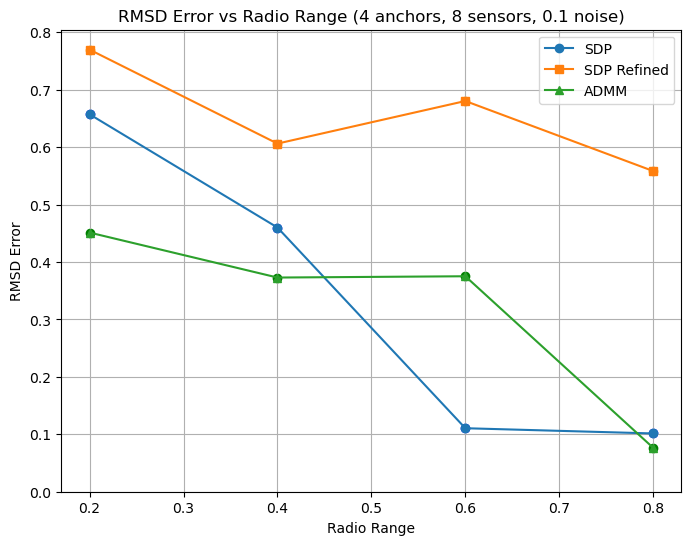

In [17]:
rr = [0.2, 0.4, 0.6, 0.8]

plt.figure(figsize=(8, 6))
plt.plot(rr, e1, label='SDP', marker='o')
plt.scatter(rr, e1, color='blue')

plt.plot(rr, f1, label="SDP Refined", marker='s')
plt.scatter(rr, f1, color='orange')

plt.plot(rr, g1, label='ADMM', marker='^')
plt.scatter(rr, g1, color='green')

plt.title("RMSD Error vs Radio Range (4 anchors, 8 sensors, 0.1 noise)")
plt.xlabel("Radio Range")
plt.ylabel("RMSD Error")

plt.grid()
plt.ylim(0)
plt.legend()

In [18]:
%%time 
e2, f2, g2 = simulation_rad_fixed_noise_iter(0.25);

0


  0%|          | 2/1000 [00:00<01:10, 14.14it/s]

0.3357007345490002
0.3109003639793456
0.03603435597601545


  1%|          | 6/1000 [00:00<01:14, 13.33it/s]

0.03532925411292685
0.01917268993524946
0.012583521245134961


  1%|          | 8/1000 [00:00<01:12, 13.65it/s]

0.008559727534277722
0.006090590254041191
0.004483384079571794


  1%|          | 12/1000 [00:00<01:10, 13.94it/s]

0.0033939843153864696
0.002629823062326918
0.0020782411708592033


  1%|▏         | 14/1000 [00:01<01:18, 12.63it/s]

0.0016703467912964412
0.0013622319988107964
0.0011252306169535417


  2%|▏         | 18/1000 [00:01<01:13, 13.40it/s]

0.0009399638295696936
0.0007931044993677297
0.0006752051520680369
0.0005794814626071216


  2%|▏         | 22/1000 [00:01<01:14, 13.05it/s]

0.0005009654381505592
0.00043597035554105573
0.00038171732847325397


  3%|▎         | 26/1000 [00:01<01:09, 13.92it/s]

0.00033608526614875567
0.000297435656383765
0.0002644888249945048
0.00023623573915499112


  3%|▎         | 28/1000 [00:02<01:09, 13.98it/s]

0.0002118733065065684
0.00019075740532578005
0.00017236891621128653


  3%|▎         | 32/1000 [00:02<01:08, 14.06it/s]

0.00015628459049500405
0.0001421572086951631
0.00012970034939196497


  3%|▎         | 34/1000 [00:02<01:15, 12.82it/s]

0.00011867640720449697
0.00010888701033630929
0.00010016580205705135


  4%|▍         | 38/1000 [00:02<01:11, 13.47it/s]

9.237248699369349e-05
8.538815279982687e-05
7.911175533531489e-05


  4%|▍         | 40/1000 [00:02<01:10, 13.66it/s]

7.345693016069126e-05
6.834950920172407e-05
6.372567553291535e-05


  4%|▍         | 44/1000 [00:03<01:14, 12.79it/s]

5.953026389904229e-05
5.571543427214886e-05
5.2239563506579654e-05


  5%|▍         | 48/1000 [00:03<01:08, 13.89it/s]

4.9066276609284476e-05
4.6163783229915926e-05
4.3504198133518905e-05
4.106294197688551e-05


  5%|▌         | 50/1000 [00:03<01:07, 13.98it/s]

3.8818318642057544e-05
3.6751128321552834e-05
3.4844339882889e-05


  5%|▌         | 54/1000 [00:04<01:11, 13.15it/s]

3.308280862593881e-05
3.1453038997726786e-05
2.9942977558904192e-05


  6%|▌         | 56/1000 [00:04<01:12, 13.02it/s]

2.8541836102134017e-05
2.7239938163420296e-05
2.602859735008139e-05


  6%|▌         | 60/1000 [00:04<01:14, 12.57it/s]

2.4899990613217642e-05
2.3849126448166006e-05
2.286874129541741e-05


  6%|▌         | 62/1000 [00:04<01:14, 12.58it/s]

2.1945504129849188e-05
2.108322251867165e-05
2.0274442511964167e-05


  7%|▋         | 66/1000 [00:05<01:18, 11.89it/s]

1.9515023050883256e-05
1.8801012164392796e-05
1.8128842249528652e-05


  7%|▋         | 68/1000 [00:05<01:19, 11.77it/s]

1.7495238119441016e-05
1.6897208344295142e-05
1.6332054040129338e-05


  7%|▋         | 72/1000 [00:05<01:12, 12.85it/s]

1.579735351511216e-05
1.529063436930215e-05
1.4809946183598987e-05


  7%|▋         | 74/1000 [00:05<01:10, 13.22it/s]

1.4353305133746439e-05
1.391899292783644e-05


  8%|▊         | 76/1000 [00:05<01:19, 11.60it/s]

1.3505259992249437e-05
1.3110734956718953e-05
1.2733956489127012e-05


  8%|▊         | 80/1000 [00:06<01:14, 12.42it/s]

1.2373670761868288e-05
1.202874375988048e-05
1.1698106496645414e-05


  8%|▊         | 82/1000 [00:06<01:11, 12.89it/s]

1.1380765630131739e-05
1.107580672604641e-05
1.0782388697778804e-05


  9%|▊         | 86/1000 [00:06<01:10, 12.92it/s]

1.0499737704445025e-05
1.0227141480332138e-05
9.963944448768364e-06


  9%|▉         | 88/1000 [00:06<01:08, 13.28it/s]

9.709543558800832e-06
9.463384024996889e-06
9.224955896823669e-06


  9%|▉         | 92/1000 [00:07<01:04, 14.16it/s]

8.993790428409954e-06
8.769457419351959e-06
8.55156175250994e-06


  9%|▉         | 94/1000 [00:07<01:10, 12.87it/s]

8.33974109799542e-06
8.133662989905283e-06
7.933023680226298e-06


 10%|▉         | 98/1000 [00:07<01:08, 13.23it/s]

7.737520479837625e-06
7.546916234485782e-06
7.360987314100468e-06


 10%|█         | 102/1000 [00:07<01:05, 13.80it/s]

7.179520933460004e-06
7.002321784983843e-06
6.829212111503734e-06
6.660034418610723e-06


 10%|█         | 104/1000 [00:07<01:04, 13.92it/s]

6.49464207456109e-06
6.332901552891511e-06
6.1746913635379375e-06


 11%|█         | 108/1000 [00:08<01:06, 13.42it/s]

6.019901128529961e-06
5.868429742847067e-06
5.720185484898999e-06


 11%|█         | 110/1000 [00:08<01:05, 13.63it/s]

5.575084689094753e-06
5.433050920036986e-06
5.2940143300416365e-06


 11%|█▏        | 114/1000 [00:08<01:08, 13.02it/s]

5.1579102568741805e-06
5.0246803440744646e-06
4.894269827944247e-06


 12%|█▏        | 116/1000 [00:08<01:06, 13.33it/s]

4.766628268949901e-06
4.641708833327834e-06
4.519467368032379e-06


 12%|█▏        | 120/1000 [00:09<01:05, 13.44it/s]

4.39986292336114e-06
4.2828563243620164e-06
4.168410102833208e-06


 12%|█▏        | 122/1000 [00:09<01:04, 13.64it/s]

4.056489282164646e-06
3.947059238107957e-06
3.840086541725951e-06
3.73553793326723e-06


 13%|█▎        | 128/1000 [00:09<01:05, 13.38it/s]

3.633378355470012e-06
3.5335802400497825e-06
3.436112646977384e-06
3.3409425803889088e-06


 13%|█▎        | 130/1000 [00:09<01:03, 13.60it/s]

3.2480394878340435e-06
3.157361422503183e-06
3.0688927440793233e-06


 13%|█▎        | 134/1000 [00:10<01:03, 13.73it/s]

2.9826019153350993e-06
2.8984574717226384e-06
2.8164274086441704e-06


 14%|█▎        | 136/1000 [00:10<01:05, 13.13it/s]

2.7364790553451523e-06
2.658579596631405e-06
2.5826962249171246e-06


 14%|█▍        | 140/1000 [00:10<01:03, 13.60it/s]

2.5087950538022505e-06
2.4368425693644324e-06
2.3668061667060202e-06


 14%|█▍        | 142/1000 [00:10<01:00, 14.19it/s]

2.2986504795072916e-06
2.2323395527429937e-06
2.1678385517489885e-06


 15%|█▍        | 146/1000 [00:11<01:05, 13.08it/s]

2.1051120228444048e-06
2.044124849694774e-06
1.984841235183523e-06


 15%|█▌        | 150/1000 [00:11<01:01, 13.85it/s]

1.927225832399761e-06
1.8712426025267276e-06
1.8168562147471306e-06
1.7640310184638175e-06


 15%|█▌        | 154/1000 [00:11<00:59, 14.12it/s]

1.712731374720877e-06
1.6629219826595694e-06
1.6145669228736652e-06
1.567631024869314e-06


 16%|█▌        | 158/1000 [00:11<01:00, 13.94it/s]

1.5220805397806383e-06
1.4778810977545846e-06
1.4349955738566245e-06
1.3933903146508714e-06


 16%|█▌        | 162/1000 [00:12<00:57, 14.55it/s]

1.3530402690846422e-06
1.3139071072773464e-06
1.2759578207472804e-06
1.2391603678888017e-06


 16%|█▋        | 164/1000 [00:12<00:57, 14.44it/s]

1.2034829464436142e-06
1.1688947723455514e-06
1.1353653666249503e-06


 17%|█▋        | 168/1000 [00:12<01:02, 13.21it/s]

1.1028646499224587e-06
1.0713626791302146e-06
1.0408311212773541e-06


 17%|█▋        | 170/1000 [00:12<01:01, 13.48it/s]

1.011241134088094e-06
9.82564880258839e-07
9.547753396335385e-07


 17%|█▋        | 172/1000 [00:12<01:02, 13.26it/s]

9.278459162146525e-07
9.017501573208272e-07
8.764626723802561e-07


 18%|█▊        | 178/1000 [00:13<01:02, 13.10it/s]

8.519589535441722e-07
8.282144080282305e-07
8.052053998689103e-07
7.829087301866537e-07


 18%|█▊        | 182/1000 [00:13<01:00, 13.62it/s]

7.613021641676511e-07
7.403635111980948e-07
7.200718467784756e-07
7.004061506467247e-07


 18%|█▊        | 184/1000 [00:13<01:01, 13.29it/s]

6.813463636285157e-07
6.628727485000407e-07
6.44966627779975e-07


 19%|█▉        | 188/1000 [00:14<01:01, 13.11it/s]

6.276093458657702e-07
6.107831800233761e-07
5.944705425482455e-07


 19%|█▉        | 192/1000 [00:14<00:59, 13.60it/s]

5.786549138503375e-07
5.633208718792085e-07
5.484577092974201e-07
5.340435033867402e-07


 20%|█▉        | 196/1000 [00:14<00:58, 13.80it/s]

5.200632679963396e-07
5.065025442155225e-07
4.933476583739556e-07
4.805850162170344e-07


 20%|██        | 200/1000 [00:15<00:59, 13.51it/s]

4.682016634216757e-07
4.5618500393165905e-07
4.445230536598914e-07
4.332039978473323e-07


 20%|██        | 202/1000 [00:15<01:00, 13.27it/s]

4.222165812016733e-07
4.115497455655746e-07
4.011929119163862e-07


 21%|██        | 206/1000 [00:15<01:03, 12.55it/s]

3.9113604830076515e-07
3.813692290977378e-07
3.7188277287412145e-07


 21%|██        | 208/1000 [00:15<01:00, 13.03it/s]

3.626676620748656e-07
3.537150773399364e-07
3.4501633869180045e-07


 21%|██        | 212/1000 [00:16<00:59, 13.31it/s]

3.365633553534097e-07
3.283480274529489e-07
3.203629487573459e-07


 21%|██▏       | 214/1000 [00:16<00:58, 13.54it/s]

3.1260077445926024e-07
3.0505436815555624e-07
2.9771713570000807e-07


 22%|██▏       | 218/1000 [00:16<01:02, 12.56it/s]

2.905814749252799e-07
2.836339924877815e-07
2.768513397261313e-07


 22%|██▏       | 220/1000 [00:16<00:59, 13.00it/s]

2.703786164934809e-07
2.640760027132675e-07
2.580180266641999e-07


 22%|██▏       | 224/1000 [00:16<00:55, 13.99it/s]

2.5202556181462817e-07
2.4612668620425913e-07
2.403824748733579e-07
2.347945499153634e-07


 23%|██▎       | 228/1000 [00:17<00:57, 13.36it/s]

2.2935156622338095e-07
2.2404907327915868e-07
2.1888287423941985e-07


 23%|██▎       | 230/1000 [00:17<00:58, 13.09it/s]

2.138489483918481e-07
2.0894338900703331e-07
2.0416240368023244e-07


 23%|██▎       | 234/1000 [00:17<00:55, 13.69it/s]

1.995022701082808e-07
1.9495951845880275e-07
1.9053063719314657e-07


 24%|██▍       | 238/1000 [00:17<00:57, 13.29it/s]

1.8621236390733584e-07
1.8200159998365734e-07
1.7789515985575097e-07
1.7389001701387592e-07


 24%|██▍       | 240/1000 [00:18<00:54, 13.98it/s]

1.6998336389415674e-07
1.661608478521458e-07
1.6239354243893586e-07


 24%|██▍       | 244/1000 [00:18<00:56, 13.33it/s]

1.5872751978203613e-07
1.5519994265585064e-07
1.517912114553492e-07


 25%|██▍       | 246/1000 [00:18<00:55, 13.54it/s]

1.48458012000294e-07
1.4517738255381916e-07
1.4196492833489853e-07


 25%|██▌       | 250/1000 [00:18<00:57, 12.96it/s]

1.3882895783857803e-07
1.357674027828208e-07
1.3277823433331197e-07


 25%|██▌       | 252/1000 [00:19<00:57, 12.90it/s]

1.2985950932224838e-07
1.2700926137477845e-07
1.2422570169529755e-07


 26%|██▌       | 256/1000 [00:19<00:55, 13.52it/s]

1.2150701844391246e-07
1.1885152580736984e-07
1.1625754322267553e-07


 26%|██▌       | 258/1000 [00:19<00:57, 12.87it/s]

1.1372347385308011e-07
1.1124773933441829e-07
1.0882882866927852e-07


 26%|██▌       | 262/1000 [00:19<00:57, 12.89it/s]

1.0646524879420085e-07
1.0415560536676145e-07
1.0189856988157329e-07


 26%|██▌       | 262/1000 [00:19<00:56, 13.18it/s]


9.969277060239448e-08
1


  0%|          | 2/1000 [00:00<01:11, 14.03it/s]

0.3357007345490002
0.3109003639793456
0.03603435597601545


  1%|          | 6/1000 [00:00<01:18, 12.74it/s]

0.03532925411292685
0.01917268993524946
0.012583521245134961


  1%|          | 8/1000 [00:00<01:19, 12.49it/s]

0.008559727534277722
0.006090590254041191
0.004483384079571794


  1%|          | 12/1000 [00:00<01:15, 13.09it/s]

0.0033939843153864696
0.002629823062326918
0.0020782411708592033


  1%|▏         | 14/1000 [00:01<01:13, 13.42it/s]

0.0016703467912964412
0.0013622319988107964
0.0011252306169535417


  2%|▏         | 18/1000 [00:01<01:16, 12.76it/s]

0.0009399638295696936
0.0007931044993677297
0.0006752051520680369


  2%|▏         | 20/1000 [00:01<01:19, 12.36it/s]

0.0005794814626071216
0.0005009654381505592
0.00043597035554105573


  2%|▏         | 24/1000 [00:01<01:20, 12.19it/s]

0.00038171732847325397
0.00033608526614875567
0.000297435656383765


  3%|▎         | 26/1000 [00:02<01:18, 12.36it/s]

0.0002644888249945048
0.00023623573915499112
0.0002118733065065684


  3%|▎         | 30/1000 [00:02<01:13, 13.22it/s]

0.00019075740532578005
0.00017236891621128653
0.00015628459049500405


  3%|▎         | 32/1000 [00:02<01:14, 13.06it/s]

0.0001421572086951631
0.00012970034939196497
0.00011867640720449697


  3%|▎         | 34/1000 [00:02<01:12, 13.38it/s]

0.00010888701033630929
0.00010016580205705135


  4%|▍         | 38/1000 [00:02<01:16, 12.60it/s]

9.237248699369349e-05
8.538815279982687e-05
7.911175533531489e-05


  4%|▍         | 40/1000 [00:03<01:13, 13.04it/s]

7.345693016069126e-05
6.834950920172407e-05
6.372567553291535e-05


  4%|▍         | 44/1000 [00:03<01:12, 13.16it/s]

5.953026389904229e-05
5.571543427214886e-05
5.2239563506579654e-05


  5%|▍         | 46/1000 [00:03<01:11, 13.36it/s]

4.9066276609284476e-05
4.6163783229915926e-05
4.3504198133518905e-05


  5%|▌         | 50/1000 [00:03<01:13, 12.93it/s]

4.106294197688551e-05
3.8818318642057544e-05
3.6751128321552834e-05


  5%|▌         | 52/1000 [00:04<01:13, 12.85it/s]

3.4844339882889e-05
3.308280862593881e-05
3.1453038997726786e-05


  6%|▌         | 56/1000 [00:04<01:18, 12.03it/s]

2.9942977558904192e-05
2.8541836102134017e-05
2.7239938163420296e-05


  6%|▌         | 58/1000 [00:04<01:14, 12.60it/s]

2.602859735008139e-05
2.4899990613217642e-05
2.3849126448166006e-05


  6%|▌         | 62/1000 [00:04<01:12, 12.94it/s]

2.286874129541741e-05
2.1945504129849188e-05
2.108322251867165e-05


  6%|▋         | 64/1000 [00:04<01:10, 13.28it/s]

2.0274442511964167e-05
1.9515023050883256e-05
1.8801012164392796e-05


  7%|▋         | 68/1000 [00:05<01:14, 12.47it/s]

1.8128842249528652e-05
1.7495238119441016e-05
1.6897208344295142e-05


  7%|▋         | 72/1000 [00:05<01:09, 13.28it/s]

1.6332054040129338e-05
1.579735351511216e-05
1.529063436930215e-05
1.4809946183598987e-05


  7%|▋         | 74/1000 [00:05<01:08, 13.54it/s]

1.4353305133746439e-05
1.391899292783644e-05
1.3505259992249437e-05


  8%|▊         | 78/1000 [00:06<01:13, 12.60it/s]

1.3110734956718953e-05
1.2733956489127012e-05
1.2373670761868288e-05


  8%|▊         | 80/1000 [00:06<01:10, 13.04it/s]

1.202874375988048e-05
1.1698106496645414e-05
1.1380765630131739e-05
1.107580672604641e-05


  8%|▊         | 84/1000 [00:06<01:11, 12.83it/s]

1.0782388697778804e-05
1.0499737704445025e-05
1.0227141480332138e-05


  9%|▉         | 88/1000 [00:06<01:12, 12.62it/s]

9.963944448768364e-06
9.709543558800832e-06
9.463384024996889e-06


  9%|▉         | 92/1000 [00:07<01:05, 13.78it/s]

9.224955896823669e-06
8.993790428409954e-06
8.769457419351959e-06
8.55156175250994e-06


 10%|▉         | 96/1000 [00:07<01:03, 14.15it/s]

8.33974109799542e-06
8.133662989905283e-06
7.933023680226298e-06
7.737520479837625e-06


 10%|█         | 100/1000 [00:07<01:06, 13.53it/s]

7.546916234485782e-06
7.360987314100468e-06
7.179520933460004e-06
7.002321784983843e-06


 10%|█         | 102/1000 [00:07<01:07, 13.26it/s]

6.829212111503734e-06
6.660034418610723e-06
6.49464207456109e-06


 11%|█         | 106/1000 [00:08<01:05, 13.69it/s]

6.332901552891511e-06
6.1746913635379375e-06
6.019901128529961e-06


 11%|█         | 108/1000 [00:08<01:08, 12.97it/s]

5.868429742847067e-06
5.720185484898999e-06
5.575084689094753e-06


 11%|█         | 112/1000 [00:08<01:05, 13.55it/s]

5.433050920036986e-06
5.2940143300416365e-06
5.1579102568741805e-06


 11%|█▏        | 114/1000 [00:08<01:06, 13.35it/s]

5.0246803440744646e-06
4.894269827944247e-06
4.766628268949901e-06


 12%|█▏        | 118/1000 [00:09<01:05, 13.39it/s]

4.641708833327834e-06
4.519467368032379e-06
4.39986292336114e-06


 12%|█▏        | 120/1000 [00:09<01:06, 13.18it/s]

4.2828563243620164e-06
4.168410102833208e-06
4.056489282164646e-06


 12%|█▏        | 124/1000 [00:09<01:04, 13.67it/s]

3.947059238107957e-06
3.840086541725951e-06
3.73553793326723e-06


 13%|█▎        | 126/1000 [00:09<01:03, 13.79it/s]

3.633378355470012e-06
3.5335802400497825e-06
3.436112646977384e-06


 13%|█▎        | 130/1000 [00:09<01:05, 13.35it/s]

3.3409425803889088e-06
3.2480394878340435e-06
3.157361422503183e-06


 13%|█▎        | 134/1000 [00:10<01:02, 13.92it/s]

3.0688927440793233e-06
2.9826019153350993e-06
2.8984574717226384e-06
2.8164274086441704e-06


 14%|█▎        | 136/1000 [00:10<01:01, 13.97it/s]

2.7364790553451523e-06
2.658579596631405e-06
2.5826962249171246e-06


 14%|█▍        | 140/1000 [00:10<01:03, 13.58it/s]

2.5087950538022505e-06
2.4368425693644324e-06
2.3668061667060202e-06


 14%|█▍        | 142/1000 [00:10<01:04, 13.33it/s]

2.2986504795072916e-06
2.2323395527429937e-06
2.1678385517489885e-06


 15%|█▍        | 146/1000 [00:11<01:14, 11.43it/s]

2.1051120228444048e-06
2.044124849694774e-06
1.984841235183523e-06


 15%|█▍        | 148/1000 [00:11<01:14, 11.43it/s]

1.927225832399761e-06
1.8712426025267276e-06
1.8168562147471306e-06


 15%|█▌        | 150/1000 [00:11<01:13, 11.62it/s]

1.7640310184638175e-06
1.712731374720877e-06


 15%|█▌        | 152/1000 [00:11<01:20, 10.55it/s]

1.6629219826595694e-06
1.6145669228736652e-06


 16%|█▌        | 155/1000 [00:12<01:35,  8.82it/s]

1.567631024869314e-06
1.5220805397806383e-06


 16%|█▌        | 157/1000 [00:12<01:28,  9.54it/s]

1.4778810977545846e-06
1.4349955738566245e-06


 16%|█▌        | 160/1000 [00:12<01:31,  9.19it/s]

1.3933903146508714e-06
1.3530402690846422e-06
1.3139071072773464e-06


 16%|█▌        | 162/1000 [00:13<01:31,  9.18it/s]

1.2759578207472804e-06
1.2391603678888017e-06
1.2034829464436142e-06


 17%|█▋        | 166/1000 [00:13<01:17, 10.70it/s]

1.1688947723455514e-06
1.1353653666249503e-06
1.1028646499224587e-06


 17%|█▋        | 168/1000 [00:13<01:23,  9.98it/s]

1.0713626791302146e-06
1.0408311212773541e-06


 17%|█▋        | 171/1000 [00:13<01:29,  9.24it/s]

1.011241134088094e-06
9.82564880258839e-07
9.547753396335385e-07


 17%|█▋        | 173/1000 [00:14<01:27,  9.40it/s]

9.278459162146525e-07
9.017501573208272e-07
8.764626723802561e-07


 18%|█▊        | 175/1000 [00:14<01:19, 10.35it/s]

8.519589535441722e-07
8.282144080282305e-07


 18%|█▊        | 179/1000 [00:14<01:20, 10.22it/s]

8.052053998689103e-07
7.829087301866537e-07
7.613021641676511e-07


 18%|█▊        | 181/1000 [00:14<01:20, 10.17it/s]

7.403635111980948e-07
7.200718467784756e-07
7.004061506467247e-07


 18%|█▊        | 185/1000 [00:15<01:16, 10.63it/s]

6.813463636285157e-07
6.628727485000407e-07
6.44966627779975e-07


 19%|█▊        | 187/1000 [00:15<01:14, 10.89it/s]

6.276093458657702e-07
6.107831800233761e-07
5.944705425482455e-07


 19%|█▉        | 191/1000 [00:15<01:08, 11.77it/s]

5.786549138503375e-07
5.633208718792085e-07
5.484577092974201e-07


 19%|█▉        | 193/1000 [00:15<01:06, 12.09it/s]

5.340435033867402e-07
5.200632679963396e-07
5.065025442155225e-07


 20%|█▉        | 197/1000 [00:16<01:04, 12.52it/s]

4.933476583739556e-07
4.805850162170344e-07
4.682016634216757e-07


 20%|██        | 201/1000 [00:16<01:02, 12.74it/s]

4.5618500393165905e-07
4.445230536598914e-07
4.332039978473323e-07
4.222165812016733e-07


 20%|██        | 203/1000 [00:16<01:00, 13.08it/s]

4.115497455655746e-07
4.011929119163862e-07
3.9113604830076515e-07


 21%|██        | 207/1000 [00:17<01:04, 12.39it/s]

3.813692290977378e-07
3.7188277287412145e-07
3.626676620748656e-07


 21%|██        | 209/1000 [00:17<01:01, 12.88it/s]

3.537150773399364e-07
3.4501633869180045e-07
3.365633553534097e-07


 21%|██▏       | 213/1000 [00:17<00:58, 13.56it/s]

3.283480274529489e-07
3.203629487573459e-07
3.1260077445926024e-07


 22%|██▏       | 215/1000 [00:17<00:59, 13.28it/s]

3.0505436815555624e-07
2.9771713570000807e-07
2.905814749252799e-07


 22%|██▏       | 219/1000 [00:17<01:00, 12.88it/s]

2.836339924877815e-07
2.768513397261313e-07
2.703786164934809e-07


 22%|██▏       | 221/1000 [00:18<00:58, 13.22it/s]

2.640760027132675e-07
2.580180266641999e-07
2.5202556181462817e-07


 22%|██▎       | 225/1000 [00:18<00:58, 13.34it/s]

2.4612668620425913e-07
2.403824748733579e-07
2.347945499153634e-07


 23%|██▎       | 227/1000 [00:18<00:58, 13.14it/s]

2.2935156622338095e-07
2.2404907327915868e-07
2.1888287423941985e-07


 23%|██▎       | 231/1000 [00:18<01:01, 12.42it/s]

2.138489483918481e-07
2.0894338900703331e-07
2.0416240368023244e-07


 24%|██▎       | 235/1000 [00:19<00:57, 13.26it/s]

1.995022701082808e-07
1.9495951845880275e-07
1.9053063719314657e-07
1.8621236390733584e-07


 24%|██▎       | 237/1000 [00:19<00:56, 13.52it/s]

1.8200159998365734e-07
1.7789515985575097e-07
1.7389001701387592e-07


 24%|██▍       | 241/1000 [00:19<00:57, 13.24it/s]

1.6998336389415674e-07
1.661608478521458e-07
1.6239354243893586e-07


 24%|██▍       | 243/1000 [00:19<00:56, 13.49it/s]

1.5872751978203613e-07
1.5519994265585064e-07
1.517912114553492e-07


 25%|██▍       | 247/1000 [00:20<00:55, 13.46it/s]

1.48458012000294e-07
1.4517738255381916e-07
1.4196492833489853e-07


 25%|██▍       | 249/1000 [00:20<01:00, 12.44it/s]

1.3882895783857803e-07
1.357674027828208e-07
1.3277823433331197e-07


 25%|██▌       | 253/1000 [00:20<00:56, 13.27it/s]

1.2985950932224838e-07
1.2700926137477845e-07
1.2422570169529755e-07


 26%|██▌       | 255/1000 [00:20<00:56, 13.11it/s]

1.2150701844391246e-07
1.1885152580736984e-07
1.1625754322267553e-07


 26%|██▌       | 259/1000 [00:20<00:55, 13.33it/s]

1.1372347385308011e-07
1.1124773933441829e-07
1.0882882866927852e-07


 26%|██▌       | 262/1000 [00:21<00:59, 12.31it/s]

1.0646524879420085e-07
1.0415560536676145e-07
1.0189856988157329e-07
9.969277060239448e-08


2


  0%|          | 2/1000 [00:00<01:18, 12.73it/s]

0.3357007345490002
0.3109003639793456
0.03603435597601545


  1%|          | 6/1000 [00:00<01:15, 13.14it/s]

0.03532925411292685
0.01917268993524946
0.012583521245134961


  1%|          | 8/1000 [00:00<01:22, 12.01it/s]

0.008559727534277722
0.006090590254041191
0.004483384079571794


  1%|          | 12/1000 [00:00<01:15, 13.16it/s]

0.0033939843153864696
0.002629823062326918
0.0020782411708592033


  1%|▏         | 14/1000 [00:01<01:15, 13.00it/s]

0.0016703467912964412
0.0013622319988107964
0.0011252306169535417


  2%|▏         | 18/1000 [00:01<01:17, 12.73it/s]

0.0009399638295696936
0.0007931044993677297
0.0006752051520680369


  2%|▏         | 20/1000 [00:01<01:14, 13.11it/s]

0.0005794814626071216
0.0005009654381505592
0.00043597035554105573


  2%|▏         | 24/1000 [00:01<01:12, 13.53it/s]

0.00038171732847325397
0.00033608526614875567
0.000297435656383765


  3%|▎         | 26/1000 [00:01<01:11, 13.69it/s]

0.0002644888249945048
0.00023623573915499112
0.0002118733065065684


  3%|▎         | 30/1000 [00:02<01:14, 12.98it/s]

0.00019075740532578005
0.00017236891621128653
0.00015628459049500405


  3%|▎         | 32/1000 [00:02<01:12, 13.31it/s]

0.0001421572086951631
0.00012970034939196497
0.00011867640720449697


  4%|▎         | 36/1000 [00:02<01:09, 13.81it/s]

0.00010888701033630929
0.00010016580205705135
9.237248699369349e-05


  4%|▍         | 38/1000 [00:02<01:16, 12.65it/s]

8.538815279982687e-05
7.911175533531489e-05
7.345693016069126e-05


  4%|▍         | 42/1000 [00:03<01:11, 13.36it/s]

6.834950920172407e-05
6.372567553291535e-05
5.953026389904229e-05


  5%|▍         | 46/1000 [00:03<01:07, 14.20it/s]

5.571543427214886e-05
5.2239563506579654e-05
4.9066276609284476e-05
4.6163783229915926e-05


  5%|▍         | 48/1000 [00:03<01:11, 13.28it/s]

4.3504198133518905e-05
4.106294197688551e-05
3.8818318642057544e-05


  5%|▌         | 52/1000 [00:03<01:11, 13.30it/s]

3.6751128321552834e-05
3.4844339882889e-05
3.308280862593881e-05


  6%|▌         | 56/1000 [00:04<01:06, 14.16it/s]

3.1453038997726786e-05
2.9942977558904192e-05
2.8541836102134017e-05
2.7239938163420296e-05


  6%|▌         | 58/1000 [00:04<01:13, 12.88it/s]

2.602859735008139e-05
2.4899990613217642e-05
2.3849126448166006e-05


  6%|▌         | 62/1000 [00:04<01:07, 13.82it/s]

2.286874129541741e-05
2.1945504129849188e-05
2.108322251867165e-05


  7%|▋         | 66/1000 [00:04<01:06, 13.97it/s]

2.0274442511964167e-05
1.9515023050883256e-05
1.8801012164392796e-05
1.8128842249528652e-05


  7%|▋         | 70/1000 [00:05<01:09, 13.43it/s]

1.7495238119441016e-05
1.6897208344295142e-05
1.6332054040129338e-05
1.579735351511216e-05


  7%|▋         | 72/1000 [00:05<01:08, 13.62it/s]

1.529063436930215e-05
1.4809946183598987e-05
1.4353305133746439e-05


  8%|▊         | 76/1000 [00:05<01:06, 13.89it/s]

1.391899292783644e-05
1.3505259992249437e-05
1.3110734956718953e-05


  8%|▊         | 78/1000 [00:05<01:08, 13.51it/s]

1.2733956489127012e-05
1.2373670761868288e-05
1.202874375988048e-05


  8%|▊         | 82/1000 [00:06<01:09, 13.22it/s]

1.1698106496645414e-05
1.1380765630131739e-05
1.107580672604641e-05


  9%|▊         | 86/1000 [00:06<01:06, 13.70it/s]

1.0782388697778804e-05
1.0499737704445025e-05
1.0227141480332138e-05
9.963944448768364e-06


  9%|▉         | 88/1000 [00:06<01:05, 13.84it/s]

9.709543558800832e-06
9.463384024996889e-06
9.224955896823669e-06


  9%|▉         | 92/1000 [00:06<01:08, 13.22it/s]

8.993790428409954e-06
8.769457419351959e-06
8.55156175250994e-06


 10%|▉         | 96/1000 [00:07<01:03, 14.14it/s]

8.33974109799542e-06
8.133662989905283e-06
7.933023680226298e-06
7.737520479837625e-06


 10%|▉         | 98/1000 [00:07<01:12, 12.47it/s]

7.546916234485782e-06
7.360987314100468e-06
7.179520933460004e-06


 10%|█         | 102/1000 [00:07<01:11, 12.59it/s]

7.002321784983843e-06
6.829212111503734e-06
6.660034418610723e-06


 10%|█         | 104/1000 [00:07<01:13, 12.13it/s]

6.49464207456109e-06
6.332901552891511e-06
6.1746913635379375e-06


 11%|█         | 108/1000 [00:08<01:13, 12.15it/s]

6.019901128529961e-06
5.868429742847067e-06
5.720185484898999e-06


 11%|█         | 110/1000 [00:08<01:16, 11.63it/s]

5.575084689094753e-06
5.433050920036986e-06
5.2940143300416365e-06


 11%|█▏        | 114/1000 [00:08<01:10, 12.49it/s]

5.1579102568741805e-06
5.0246803440744646e-06
4.894269827944247e-06


 12%|█▏        | 118/1000 [00:08<01:06, 13.28it/s]

4.766628268949901e-06
4.641708833327834e-06
4.519467368032379e-06
4.39986292336114e-06


 12%|█▏        | 122/1000 [00:09<01:06, 13.13it/s]

4.2828563243620164e-06
4.168410102833208e-06
4.056489282164646e-06
3.947059238107957e-06


 12%|█▏        | 124/1000 [00:09<01:05, 13.43it/s]

3.840086541725951e-06
3.73553793326723e-06
3.633378355470012e-06


 13%|█▎        | 128/1000 [00:09<01:10, 12.31it/s]

3.5335802400497825e-06
3.436112646977384e-06
3.3409425803889088e-06


 13%|█▎        | 132/1000 [00:10<01:04, 13.56it/s]

3.2480394878340435e-06
3.157361422503183e-06
3.0688927440793233e-06
2.9826019153350993e-06


 14%|█▎        | 136/1000 [00:10<01:02, 13.85it/s]

2.8984574717226384e-06
2.8164274086441704e-06
2.7364790553451523e-06
2.658579596631405e-06


 14%|█▍        | 138/1000 [00:10<01:01, 13.94it/s]

2.5826962249171246e-06
2.5087950538022505e-06
2.4368425693644324e-06


 14%|█▍        | 142/1000 [00:10<01:08, 12.60it/s]

2.3668061667060202e-06
2.2986504795072916e-06
2.2323395527429937e-06


 14%|█▍        | 144/1000 [00:10<01:07, 12.61it/s]

2.1678385517489885e-06
2.1051120228444048e-06
2.044124849694774e-06


 15%|█▍        | 148/1000 [00:11<01:01, 13.78it/s]

1.984841235183523e-06
1.927225832399761e-06
1.8712426025267276e-06


 15%|█▌        | 150/1000 [00:11<01:01, 13.88it/s]

1.8168562147471306e-06
1.7640310184638175e-06
1.712731374720877e-06


 15%|█▌        | 154/1000 [00:11<01:03, 13.25it/s]

1.6629219826595694e-06
1.6145669228736652e-06
1.567631024869314e-06
1.5220805397806383e-06


 16%|█▌        | 158/1000 [00:11<01:00, 13.83it/s]

1.4778810977545846e-06
1.4349955738566245e-06
1.3933903146508714e-06


 16%|█▌        | 162/1000 [00:12<01:02, 13.33it/s]

1.3530402690846422e-06
1.3139071072773464e-06
1.2759578207472804e-06
1.2391603678888017e-06


 17%|█▋        | 166/1000 [00:12<00:58, 14.19it/s]

1.2034829464436142e-06
1.1688947723455514e-06
1.1353653666249503e-06
1.1028646499224587e-06


 17%|█▋        | 168/1000 [00:12<00:58, 14.19it/s]

1.0713626791302146e-06
1.0408311212773541e-06
1.011241134088094e-06


 17%|█▋        | 172/1000 [00:13<01:01, 13.46it/s]

9.82564880258839e-07
9.547753396335385e-07
9.278459162146525e-07


 18%|█▊        | 176/1000 [00:13<00:59, 13.87it/s]

9.017501573208272e-07
8.764626723802561e-07
8.519589535441722e-07
8.282144080282305e-07


 18%|█▊        | 180/1000 [00:13<00:58, 14.00it/s]

8.052053998689103e-07
7.829087301866537e-07
7.613021641676511e-07
7.403635111980948e-07


 18%|█▊        | 184/1000 [00:13<01:00, 13.46it/s]

7.200718467784756e-07
7.004061506467247e-07
6.813463636285157e-07
6.628727485000407e-07


 19%|█▉        | 188/1000 [00:14<00:58, 13.79it/s]

6.44966627779975e-07
6.276093458657702e-07
6.107831800233761e-07
5.944705425482455e-07


 19%|█▉        | 192/1000 [00:14<01:00, 13.36it/s]

5.786549138503375e-07
5.633208718792085e-07
5.484577092974201e-07
5.340435033867402e-07


 20%|█▉        | 196/1000 [00:14<00:56, 14.23it/s]

5.200632679963396e-07
5.065025442155225e-07
4.933476583739556e-07
4.805850162170344e-07


 20%|██        | 200/1000 [00:15<00:56, 14.15it/s]

4.682016634216757e-07
4.5618500393165905e-07
4.445230536598914e-07
4.332039978473323e-07


 20%|██        | 204/1000 [00:15<00:58, 13.56it/s]

4.222165812016733e-07
4.115497455655746e-07
4.011929119163862e-07
3.9113604830076515e-07


 21%|██        | 208/1000 [00:15<00:57, 13.85it/s]

3.813692290977378e-07
3.7188277287412145e-07
3.626676620748656e-07
3.537150773399364e-07


 21%|██        | 210/1000 [00:15<00:56, 13.93it/s]

3.4501633869180045e-07
3.365633553534097e-07
3.283480274529489e-07


 21%|██▏       | 214/1000 [00:16<00:58, 13.43it/s]

3.203629487573459e-07
3.1260077445926024e-07
3.0505436815555624e-07


 22%|██▏       | 216/1000 [00:16<00:57, 13.61it/s]

2.9771713570000807e-07
2.905814749252799e-07
2.836339924877815e-07


 22%|██▏       | 220/1000 [00:16<01:00, 12.99it/s]

2.768513397261313e-07
2.703786164934809e-07
2.640760027132675e-07


 22%|██▏       | 224/1000 [00:16<00:57, 13.56it/s]

2.580180266641999e-07
2.5202556181462817e-07
2.4612668620425913e-07
2.403824748733579e-07


 23%|██▎       | 228/1000 [00:17<00:53, 14.31it/s]

2.347945499153634e-07
2.2935156622338095e-07
2.2404907327915868e-07
2.1888287423941985e-07


 23%|██▎       | 230/1000 [00:17<00:54, 14.26it/s]

2.138489483918481e-07
2.0894338900703331e-07
2.0416240368023244e-07


 23%|██▎       | 234/1000 [00:17<00:56, 13.63it/s]

1.995022701082808e-07
1.9495951845880275e-07
1.9053063719314657e-07


 24%|██▎       | 236/1000 [00:17<00:58, 12.95it/s]

1.8621236390733584e-07
1.8200159998365734e-07
1.7789515985575097e-07


 24%|██▍       | 240/1000 [00:18<01:02, 12.14it/s]

1.7389001701387592e-07
1.6998336389415674e-07
1.661608478521458e-07


 24%|██▍       | 242/1000 [00:18<01:05, 11.64it/s]

1.6239354243893586e-07
1.5872751978203613e-07
1.5519994265585064e-07


 25%|██▍       | 246/1000 [00:18<00:57, 13.16it/s]

1.517912114553492e-07
1.48458012000294e-07
1.4517738255381916e-07


 25%|██▍       | 248/1000 [00:18<00:57, 13.04it/s]

1.4196492833489853e-07
1.3882895783857803e-07
1.357674027828208e-07


 25%|██▌       | 252/1000 [00:19<00:57, 13.04it/s]

1.3277823433331197e-07
1.2985950932224838e-07
1.2700926137477845e-07
1.2422570169529755e-07


 26%|██▌       | 256/1000 [00:19<00:53, 13.88it/s]

1.2150701844391246e-07
1.1885152580736984e-07
1.1625754322267553e-07


 26%|██▌       | 258/1000 [00:19<00:54, 13.50it/s]

1.1372347385308011e-07
1.1124773933441829e-07
1.0882882866927852e-07


 26%|██▌       | 262/1000 [00:19<00:59, 12.40it/s]

1.0646524879420085e-07
1.0415560536676145e-07
1.0189856988157329e-07


 26%|██▌       | 262/1000 [00:19<00:56, 13.18it/s]


9.969277060239448e-08
3


  0%|          | 4/1000 [00:00<01:09, 14.25it/s]

0.3357007345490002
0.3109003639793456
0.03603435597601545
0.03532925411292685


  1%|          | 6/1000 [00:00<01:06, 14.93it/s]

0.01917268993524946
0.012583521245134961
0.008559727534277722


  1%|          | 10/1000 [00:00<01:12, 13.65it/s]

0.006090590254041191
0.004483384079571794
0.0033939843153864696


  1%|▏         | 14/1000 [00:01<01:10, 13.97it/s]

0.002629823062326918
0.0020782411708592033
0.0016703467912964412
0.0013622319988107964


  2%|▏         | 16/1000 [00:01<01:09, 14.21it/s]

0.0011252306169535417
0.0009399638295696936
0.0007931044993677297


  2%|▏         | 20/1000 [00:01<01:15, 12.96it/s]

0.0006752051520680369
0.0005794814626071216
0.0005009654381505592


  2%|▏         | 22/1000 [00:01<01:13, 13.28it/s]

0.00043597035554105573
0.00038171732847325397
0.00033608526614875567


  3%|▎         | 26/1000 [00:01<01:16, 12.70it/s]

0.000297435656383765
0.0002644888249945048
0.00023623573915499112


  3%|▎         | 28/1000 [00:02<01:17, 12.58it/s]

0.0002118733065065684
0.00019075740532578005
0.00017236891621128653


  3%|▎         | 32/1000 [00:02<01:22, 11.77it/s]

0.00015628459049500405
0.0001421572086951631
0.00012970034939196497


  3%|▎         | 34/1000 [00:02<01:22, 11.71it/s]

0.00011867640720449697
0.00010888701033630929
0.00010016580205705135


  4%|▍         | 38/1000 [00:02<01:15, 12.83it/s]

9.237248699369349e-05
8.538815279982687e-05
7.911175533531489e-05


  4%|▍         | 42/1000 [00:03<01:14, 12.91it/s]

7.345693016069126e-05
6.834950920172407e-05
6.372567553291535e-05
5.953026389904229e-05


  5%|▍         | 46/1000 [00:03<01:08, 13.95it/s]

5.571543427214886e-05
5.2239563506579654e-05
4.9066276609284476e-05
4.6163783229915926e-05


  5%|▍         | 48/1000 [00:03<01:07, 14.02it/s]

4.3504198133518905e-05
4.106294197688551e-05
3.8818318642057544e-05


  5%|▌         | 52/1000 [00:03<01:10, 13.44it/s]

3.6751128321552834e-05
3.4844339882889e-05
3.308280862593881e-05


  6%|▌         | 56/1000 [00:04<01:06, 14.23it/s]

3.1453038997726786e-05
2.9942977558904192e-05
2.8541836102134017e-05
2.7239938163420296e-05


  6%|▌         | 58/1000 [00:04<01:06, 14.17it/s]

2.602859735008139e-05
2.4899990613217642e-05
2.3849126448166006e-05


  6%|▌         | 62/1000 [00:04<01:08, 13.67it/s]

2.286874129541741e-05
2.1945504129849188e-05
2.108322251867165e-05


  7%|▋         | 66/1000 [00:04<01:07, 13.91it/s]

2.0274442511964167e-05
1.9515023050883256e-05
1.8801012164392796e-05
1.8128842249528652e-05


  7%|▋         | 70/1000 [00:05<01:04, 14.51it/s]

1.7495238119441016e-05
1.6897208344295142e-05
1.6332054040129338e-05
1.579735351511216e-05


  7%|▋         | 74/1000 [00:05<01:09, 13.37it/s]

1.529063436930215e-05
1.4809946183598987e-05
1.4353305133746439e-05
1.391899292783644e-05


  8%|▊         | 76/1000 [00:05<01:07, 13.59it/s]

1.3505259992249437e-05
1.3110734956718953e-05
1.2733956489127012e-05
1.2373670761868288e-05


  8%|▊         | 80/1000 [00:06<01:10, 13.03it/s]

1.202874375988048e-05
1.1698106496645414e-05
1.1380765630131739e-05


  8%|▊         | 84/1000 [00:06<01:07, 13.54it/s]

1.107580672604641e-05
1.0782388697778804e-05
1.0499737704445025e-05


  9%|▉         | 88/1000 [00:06<01:05, 13.88it/s]

1.0227141480332138e-05
9.963944448768364e-06
9.709543558800832e-06
9.463384024996889e-06


  9%|▉         | 90/1000 [00:06<01:11, 12.69it/s]

9.224955896823669e-06
8.993790428409954e-06
8.769457419351959e-06


  9%|▉         | 94/1000 [00:07<01:07, 13.40it/s]

8.55156175250994e-06
8.33974109799542e-06
8.133662989905283e-06


 10%|▉         | 96/1000 [00:07<01:04, 14.04it/s]

7.933023680226298e-06
7.737520479837625e-06
7.546916234485782e-06


 10%|█         | 100/1000 [00:07<01:04, 13.93it/s]

7.360987314100468e-06
7.179520933460004e-06
7.002321784983843e-06


 10%|█         | 104/1000 [00:07<01:06, 13.39it/s]

6.829212111503734e-06
6.660034418610723e-06
6.49464207456109e-06
6.332901552891511e-06


 11%|█         | 108/1000 [00:08<01:04, 13.74it/s]

6.1746913635379375e-06
6.019901128529961e-06
5.868429742847067e-06
5.720185484898999e-06


 11%|█         | 110/1000 [00:08<01:10, 12.63it/s]

5.575084689094753e-06
5.433050920036986e-06
5.2940143300416365e-06


 11%|█▏        | 114/1000 [00:08<01:06, 13.40it/s]

5.1579102568741805e-06
5.0246803440744646e-06
4.894269827944247e-06


 12%|█▏        | 118/1000 [00:08<01:04, 13.75it/s]

4.766628268949901e-06
4.641708833327834e-06
4.519467368032379e-06
4.39986292336114e-06


 12%|█▏        | 120/1000 [00:08<01:05, 13.44it/s]

4.2828563243620164e-06
4.168410102833208e-06
4.056489282164646e-06


 12%|█▏        | 124/1000 [00:09<01:06, 13.20it/s]

3.947059238107957e-06
3.840086541725951e-06
3.73553793326723e-06


 13%|█▎        | 126/1000 [00:09<01:07, 13.04it/s]

3.633378355470012e-06
3.5335802400497825e-06
3.436112646977384e-06


 13%|█▎        | 130/1000 [00:09<01:06, 13.13it/s]

3.3409425803889088e-06
3.2480394878340435e-06
3.157361422503183e-06


 13%|█▎        | 132/1000 [00:09<01:06, 13.01it/s]

3.0688927440793233e-06
2.9826019153350993e-06
2.8984574717226384e-06


 14%|█▎        | 136/1000 [00:10<01:10, 12.33it/s]

2.8164274086441704e-06
2.7364790553451523e-06
2.658579596631405e-06


 14%|█▍        | 138/1000 [00:10<01:09, 12.45it/s]

2.5826962249171246e-06
2.5087950538022505e-06
2.4368425693644324e-06


 14%|█▍        | 140/1000 [00:10<01:06, 12.91it/s]

2.3668061667060202e-06
2.2986504795072916e-06


 14%|█▍        | 144/1000 [00:10<01:10, 12.08it/s]

2.2323395527429937e-06
2.1678385517489885e-06
2.1051120228444048e-06


 15%|█▍        | 146/1000 [00:11<01:09, 12.26it/s]

2.044124849694774e-06
1.984841235183523e-06
1.927225832399761e-06


 15%|█▌        | 150/1000 [00:11<01:04, 13.13it/s]

1.8712426025267276e-06
1.8168562147471306e-06
1.7640310184638175e-06


 15%|█▌        | 152/1000 [00:11<01:07, 12.59it/s]

1.712731374720877e-06
1.6629219826595694e-06
1.6145669228736652e-06


 16%|█▌        | 156/1000 [00:11<01:04, 13.06it/s]

1.567631024869314e-06
1.5220805397806383e-06
1.4778810977545846e-06


 16%|█▌        | 160/1000 [00:12<01:04, 13.02it/s]

1.4349955738566245e-06
1.3933903146508714e-06
1.3530402690846422e-06
1.3139071072773464e-06


 16%|█▌        | 162/1000 [00:12<01:02, 13.49it/s]

1.2759578207472804e-06
1.2391603678888017e-06
1.2034829464436142e-06


 17%|█▋        | 166/1000 [00:12<01:05, 12.67it/s]

1.1688947723455514e-06
1.1353653666249503e-06
1.1028646499224587e-06


 17%|█▋        | 168/1000 [00:12<01:04, 12.93it/s]

1.0713626791302146e-06
1.0408311212773541e-06
1.011241134088094e-06


 17%|█▋        | 170/1000 [00:12<01:02, 13.28it/s]

9.82564880258839e-07
9.547753396335385e-07


 17%|█▋        | 174/1000 [00:13<01:14, 11.15it/s]

9.278459162146525e-07
9.017501573208272e-07
8.764626723802561e-07


 18%|█▊        | 176/1000 [00:13<01:16, 10.77it/s]

8.519589535441722e-07
8.282144080282305e-07
8.052053998689103e-07


 18%|█▊        | 180/1000 [00:13<01:10, 11.67it/s]

7.829087301866537e-07
7.613021641676511e-07
7.403635111980948e-07


 18%|█▊        | 182/1000 [00:13<01:06, 12.32it/s]

7.200718467784756e-07
7.004061506467247e-07
6.813463636285157e-07


 19%|█▊        | 186/1000 [00:14<01:04, 12.63it/s]

6.628727485000407e-07
6.44966627779975e-07
6.276093458657702e-07


 19%|█▉        | 190/1000 [00:14<01:01, 13.25it/s]

6.107831800233761e-07
5.944705425482455e-07
5.786549138503375e-07
5.633208718792085e-07


 19%|█▉        | 192/1000 [00:14<01:01, 13.10it/s]

5.484577092974201e-07
5.340435033867402e-07
5.200632679963396e-07


 20%|█▉        | 196/1000 [00:15<01:04, 12.37it/s]

5.065025442155225e-07
4.933476583739556e-07
4.805850162170344e-07


 20%|█▉        | 198/1000 [00:15<01:06, 12.12it/s]

4.682016634216757e-07
4.5618500393165905e-07
4.445230536598914e-07


 20%|██        | 200/1000 [00:15<01:08, 11.63it/s]

4.332039978473323e-07
4.222165812016733e-07


 20%|██        | 202/1000 [00:15<01:16, 10.47it/s]

4.115497455655746e-07
4.011929119163862e-07


 20%|██        | 204/1000 [00:15<01:19, 10.01it/s]

3.9113604830076515e-07
3.813692290977378e-07


 21%|██        | 208/1000 [00:16<01:18, 10.10it/s]

3.7188277287412145e-07
3.626676620748656e-07
3.537150773399364e-07


 21%|██        | 212/1000 [00:16<01:09, 11.36it/s]

3.4501633869180045e-07
3.365633553534097e-07
3.283480274529489e-07
3.203629487573459e-07


 21%|██▏       | 214/1000 [00:16<01:10, 11.13it/s]

3.1260077445926024e-07
3.0505436815555624e-07
2.9771713570000807e-07


 22%|██▏       | 218/1000 [00:17<01:02, 12.49it/s]

2.905814749252799e-07
2.836339924877815e-07
2.768513397261313e-07


 22%|██▏       | 220/1000 [00:17<01:02, 12.54it/s]

2.703786164934809e-07
2.640760027132675e-07
2.580180266641999e-07


 22%|██▏       | 224/1000 [00:17<01:03, 12.18it/s]

2.5202556181462817e-07
2.4612668620425913e-07
2.403824748733579e-07


 23%|██▎       | 226/1000 [00:17<01:02, 12.34it/s]

2.347945499153634e-07
2.2935156622338095e-07
2.2404907327915868e-07


 23%|██▎       | 230/1000 [00:18<01:04, 11.96it/s]

2.1888287423941985e-07
2.138489483918481e-07
2.0894338900703331e-07


 23%|██▎       | 232/1000 [00:18<01:08, 11.20it/s]

2.0416240368023244e-07
1.995022701082808e-07
1.9495951845880275e-07


 24%|██▎       | 236/1000 [00:18<01:04, 11.91it/s]

1.9053063719314657e-07
1.8621236390733584e-07
1.8200159998365734e-07


 24%|██▍       | 238/1000 [00:18<01:02, 12.13it/s]

1.7789515985575097e-07
1.7389001701387592e-07
1.6998336389415674e-07


 24%|██▍       | 242/1000 [00:19<00:59, 12.68it/s]

1.661608478521458e-07
1.6239354243893586e-07
1.5872751978203613e-07


 24%|██▍       | 244/1000 [00:19<01:03, 11.95it/s]

1.5519994265585064e-07
1.517912114553492e-07
1.48458012000294e-07


 25%|██▍       | 248/1000 [00:19<01:00, 12.34it/s]

1.4517738255381916e-07
1.4196492833489853e-07
1.3882895783857803e-07


 25%|██▌       | 250/1000 [00:19<01:00, 12.44it/s]

1.357674027828208e-07
1.3277823433331197e-07
1.2985950932224838e-07
1.2700926137477845e-07


 25%|██▌       | 254/1000 [00:19<00:54, 13.68it/s]

1.2422570169529755e-07
1.2150701844391246e-07
1.1885152580736984e-07


 26%|██▌       | 258/1000 [00:20<00:55, 13.27it/s]

1.1625754322267553e-07
1.1372347385308011e-07
1.1124773933441829e-07


 26%|██▌       | 260/1000 [00:20<00:54, 13.49it/s]

1.0882882866927852e-07
1.0646524879420085e-07
1.0415560536676145e-07


 26%|██▌       | 262/1000 [00:20<00:58, 12.65it/s]

1.0189856988157329e-07
9.969277060239448e-08
4



  0%|          | 4/1000 [00:00<01:10, 14.09it/s]

0.3357007345490002
0.3109003639793456
0.03603435597601545
0.03532925411292685


  1%|          | 6/1000 [00:00<01:13, 13.48it/s]

0.01917268993524946
0.012583521245134961
0.008559727534277722


  1%|          | 10/1000 [00:00<01:13, 13.52it/s]

0.006090590254041191
0.004483384079571794
0.0033939843153864696


  1%|          | 12/1000 [00:00<01:17, 12.80it/s]

0.002629823062326918
0.0020782411708592033
0.0016703467912964412


  2%|▏         | 16/1000 [00:01<01:14, 13.12it/s]

0.0013622319988107964
0.0011252306169535417
0.0009399638295696936


  2%|▏         | 18/1000 [00:01<01:13, 13.43it/s]

0.0007931044993677297
0.0006752051520680369
0.0005794814626071216


  2%|▏         | 22/1000 [00:01<01:18, 12.49it/s]

0.0005009654381505592
0.00043597035554105573
0.00038171732847325397


  2%|▏         | 24/1000 [00:01<01:17, 12.57it/s]

0.00033608526614875567
0.000297435656383765
0.0002644888249945048


  3%|▎         | 28/1000 [00:02<01:16, 12.77it/s]

0.00023623573915499112
0.0002118733065065684
0.00019075740532578005


  3%|▎         | 30/1000 [00:02<01:13, 13.15it/s]

0.00017236891621128653
0.00015628459049500405
0.0001421572086951631


  3%|▎         | 34/1000 [00:02<01:17, 12.42it/s]

0.00012970034939196497
0.00011867640720449697
0.00010888701033630929


  4%|▎         | 36/1000 [00:02<01:14, 12.87it/s]

0.00010016580205705135
9.237248699369349e-05
8.538815279982687e-05


  4%|▍         | 40/1000 [00:03<01:12, 13.17it/s]

7.911175533531489e-05
7.345693016069126e-05
6.834950920172407e-05


  4%|▍         | 42/1000 [00:03<01:20, 11.92it/s]

6.372567553291535e-05
5.953026389904229e-05
5.571543427214886e-05


  5%|▍         | 46/1000 [00:03<01:16, 12.51it/s]

5.2239563506579654e-05
4.9066276609284476e-05
4.6163783229915926e-05


  5%|▍         | 48/1000 [00:03<01:15, 12.55it/s]

4.3504198133518905e-05
4.106294197688551e-05
3.8818318642057544e-05


  5%|▌         | 52/1000 [00:04<01:16, 12.44it/s]

3.6751128321552834e-05
3.4844339882889e-05
3.308280862593881e-05


  5%|▌         | 54/1000 [00:04<01:13, 12.86it/s]

3.1453038997726786e-05
2.9942977558904192e-05
2.8541836102134017e-05


  6%|▌         | 58/1000 [00:04<01:12, 13.08it/s]

2.7239938163420296e-05
2.602859735008139e-05
2.4899990613217642e-05


  6%|▌         | 60/1000 [00:04<01:12, 12.92it/s]

2.3849126448166006e-05
2.286874129541741e-05
2.1945504129849188e-05


  6%|▋         | 64/1000 [00:05<01:17, 12.08it/s]

2.108322251867165e-05
2.0274442511964167e-05
1.9515023050883256e-05


  7%|▋         | 66/1000 [00:05<01:16, 12.25it/s]

1.8801012164392796e-05
1.8128842249528652e-05
1.7495238119441016e-05


  7%|▋         | 70/1000 [00:05<01:14, 12.48it/s]

1.6897208344295142e-05
1.6332054040129338e-05
1.579735351511216e-05


  7%|▋         | 72/1000 [00:05<01:18, 11.86it/s]

1.529063436930215e-05
1.4809946183598987e-05
1.4353305133746439e-05


  8%|▊         | 76/1000 [00:06<01:13, 12.65it/s]

1.391899292783644e-05
1.3505259992249437e-05
1.3110734956718953e-05


  8%|▊         | 78/1000 [00:06<01:10, 13.08it/s]

1.2733956489127012e-05
1.2373670761868288e-05
1.202874375988048e-05


  8%|▊         | 82/1000 [00:06<01:12, 12.63it/s]

1.1698106496645414e-05
1.1380765630131739e-05
1.107580672604641e-05


  8%|▊         | 84/1000 [00:06<01:12, 12.66it/s]

1.0782388697778804e-05
1.0499737704445025e-05
1.0227141480332138e-05


  9%|▉         | 88/1000 [00:06<01:08, 13.38it/s]

9.963944448768364e-06
9.709543558800832e-06
9.463384024996889e-06


  9%|▉         | 90/1000 [00:07<01:06, 13.61it/s]

9.224955896823669e-06
8.993790428409954e-06
8.769457419351959e-06


  9%|▉         | 94/1000 [00:07<01:10, 12.85it/s]

8.55156175250994e-06
8.33974109799542e-06
8.133662989905283e-06


 10%|▉         | 96/1000 [00:07<01:08, 13.19it/s]

7.933023680226298e-06
7.737520479837625e-06
7.546916234485782e-06


 10%|█         | 100/1000 [00:07<01:10, 12.79it/s]

7.360987314100468e-06
7.179520933460004e-06
7.002321784983843e-06


 10%|█         | 102/1000 [00:08<01:10, 12.75it/s]

6.829212111503734e-06
6.660034418610723e-06
6.49464207456109e-06


 11%|█         | 106/1000 [00:08<01:13, 12.23it/s]

6.332901552891511e-06
6.1746913635379375e-06
6.019901128529961e-06


 11%|█         | 108/1000 [00:08<01:12, 12.36it/s]

5.868429742847067e-06
5.720185484898999e-06
5.575084689094753e-06


 11%|█         | 112/1000 [00:08<01:13, 12.07it/s]

5.433050920036986e-06
5.2940143300416365e-06
5.1579102568741805e-06


 12%|█▏        | 116/1000 [00:09<01:07, 13.02it/s]

5.0246803440744646e-06
4.894269827944247e-06
4.766628268949901e-06
4.641708833327834e-06


 12%|█▏        | 118/1000 [00:09<01:06, 13.34it/s]

4.519467368032379e-06
4.39986292336114e-06
4.2828563243620164e-06


 12%|█▏        | 122/1000 [00:09<01:10, 12.47it/s]

4.168410102833208e-06
4.056489282164646e-06
3.947059238107957e-06


 12%|█▏        | 124/1000 [00:09<01:09, 12.56it/s]

3.840086541725951e-06
3.73553793326723e-06
3.633378355470012e-06


 13%|█▎        | 128/1000 [00:10<01:06, 13.03it/s]

3.5335802400497825e-06
3.436112646977384e-06
3.3409425803889088e-06


 13%|█▎        | 130/1000 [00:10<01:07, 12.94it/s]

3.2480394878340435e-06
3.157361422503183e-06
3.0688927440793233e-06


 13%|█▎        | 132/1000 [00:10<01:05, 13.27it/s]

2.9826019153350993e-06
2.8984574717226384e-06


 14%|█▎        | 136/1000 [00:10<01:20, 10.78it/s]

2.8164274086441704e-06
2.7364790553451523e-06
2.658579596631405e-06


 14%|█▍        | 140/1000 [00:11<01:10, 12.22it/s]

2.5826962249171246e-06
2.5087950538022505e-06
2.4368425693644324e-06
2.3668061667060202e-06


 14%|█▍        | 142/1000 [00:11<01:17, 11.08it/s]

2.2986504795072916e-06
2.2323395527429937e-06
2.1678385517489885e-06


 15%|█▍        | 146/1000 [00:11<01:15, 11.36it/s]

2.1051120228444048e-06
2.044124849694774e-06
1.984841235183523e-06


 15%|█▍        | 148/1000 [00:11<01:12, 11.72it/s]

1.927225832399761e-06
1.8712426025267276e-06
1.8168562147471306e-06


 15%|█▌        | 152/1000 [00:12<01:09, 12.12it/s]

1.7640310184638175e-06
1.712731374720877e-06
1.6629219826595694e-06


 16%|█▌        | 156/1000 [00:12<01:10, 12.01it/s]

1.6145669228736652e-06
1.567631024869314e-06
1.5220805397806383e-06
1.4778810977545846e-06


 16%|█▌        | 158/1000 [00:12<01:08, 12.23it/s]

1.4349955738566245e-06
1.3933903146508714e-06
1.3530402690846422e-06


 16%|█▌        | 162/1000 [00:12<01:05, 12.88it/s]

1.3139071072773464e-06
1.2759578207472804e-06
1.2391603678888017e-06


 16%|█▋        | 164/1000 [00:13<01:08, 12.26it/s]

1.2034829464436142e-06
1.1688947723455514e-06
1.1353653666249503e-06


 17%|█▋        | 168/1000 [00:13<01:03, 13.15it/s]

1.1028646499224587e-06
1.0713626791302146e-06
1.0408311212773541e-06


 17%|█▋        | 170/1000 [00:13<01:02, 13.18it/s]

1.011241134088094e-06
9.82564880258839e-07
9.547753396335385e-07


 17%|█▋        | 174/1000 [00:13<01:06, 12.48it/s]

9.278459162146525e-07
9.017501573208272e-07
8.764626723802561e-07


 18%|█▊        | 176/1000 [00:14<01:03, 12.89it/s]

8.519589535441722e-07
8.282144080282305e-07
8.052053998689103e-07


 18%|█▊        | 180/1000 [00:14<01:04, 12.75it/s]

7.829087301866537e-07
7.613021641676511e-07
7.403635111980948e-07


 18%|█▊        | 182/1000 [00:14<01:02, 13.12it/s]

7.200718467784756e-07
7.004061506467247e-07
6.813463636285157e-07


 19%|█▊        | 186/1000 [00:14<01:02, 12.93it/s]

6.628727485000407e-07
6.44966627779975e-07
6.276093458657702e-07


 19%|█▉        | 190/1000 [00:15<01:00, 13.45it/s]

6.107831800233761e-07
5.944705425482455e-07
5.786549138503375e-07
5.633208718792085e-07


 19%|█▉        | 192/1000 [00:15<01:01, 13.11it/s]

5.484577092974201e-07
5.340435033867402e-07
5.200632679963396e-07


 20%|█▉        | 196/1000 [00:15<01:03, 12.62it/s]

5.065025442155225e-07
4.933476583739556e-07
4.805850162170344e-07


 20%|█▉        | 198/1000 [00:15<01:02, 12.83it/s]

4.682016634216757e-07
4.5618500393165905e-07
4.445230536598914e-07


 20%|██        | 202/1000 [00:16<01:04, 12.31it/s]

4.332039978473323e-07
4.222165812016733e-07
4.115497455655746e-07


 21%|██        | 206/1000 [00:16<00:59, 13.32it/s]

4.011929119163862e-07
3.9113604830076515e-07
3.813692290977378e-07
3.7188277287412145e-07


 21%|██        | 208/1000 [00:16<00:58, 13.52it/s]

3.626676620748656e-07
3.537150773399364e-07
3.4501633869180045e-07


 21%|██        | 212/1000 [00:16<00:57, 13.77it/s]

3.365633553534097e-07
3.283480274529489e-07
3.203629487573459e-07


 21%|██▏       | 214/1000 [00:16<01:00, 13.02it/s]

3.1260077445926024e-07
3.0505436815555624e-07
2.9771713570000807e-07


 22%|██▏       | 218/1000 [00:17<00:56, 13.75it/s]

2.905814749252799e-07
2.836339924877815e-07
2.768513397261313e-07


 22%|██▏       | 220/1000 [00:17<00:59, 13.18it/s]

2.703786164934809e-07
2.640760027132675e-07
2.580180266641999e-07


 22%|██▏       | 224/1000 [00:17<00:58, 13.17it/s]

2.5202556181462817e-07
2.4612668620425913e-07
2.403824748733579e-07


 23%|██▎       | 226/1000 [00:17<01:06, 11.70it/s]

2.347945499153634e-07
2.2935156622338095e-07
2.2404907327915868e-07


 23%|██▎       | 230/1000 [00:18<01:04, 11.95it/s]

2.1888287423941985e-07
2.138489483918481e-07
2.0894338900703331e-07


 23%|██▎       | 232/1000 [00:18<01:01, 12.47it/s]

2.0416240368023244e-07
1.995022701082808e-07
1.9495951845880275e-07


 24%|██▎       | 236/1000 [00:18<01:05, 11.67it/s]

1.9053063719314657e-07
1.8621236390733584e-07
1.8200159998365734e-07


 24%|██▍       | 240/1000 [00:19<01:01, 12.41it/s]

1.7789515985575097e-07
1.7389001701387592e-07
1.6998336389415674e-07
1.661608478521458e-07


 24%|██▍       | 242/1000 [00:19<00:59, 12.65it/s]

1.6239354243893586e-07
1.5872751978203613e-07
1.5519994265585064e-07


 25%|██▍       | 246/1000 [00:19<01:00, 12.38it/s]

1.517912114553492e-07
1.48458012000294e-07
1.4517738255381916e-07


 25%|██▍       | 248/1000 [00:19<01:00, 12.39it/s]

1.4196492833489853e-07
1.3882895783857803e-07
1.357674027828208e-07


 25%|██▌       | 252/1000 [00:20<00:58, 12.82it/s]

1.3277823433331197e-07
1.2985950932224838e-07
1.2700926137477845e-07


 25%|██▌       | 254/1000 [00:20<00:58, 12.79it/s]

1.2422570169529755e-07
1.2150701844391246e-07
1.1885152580736984e-07


 26%|██▌       | 258/1000 [00:20<00:59, 12.57it/s]

1.1625754322267553e-07
1.1372347385308011e-07
1.1124773933441829e-07


 26%|██▌       | 260/1000 [00:20<00:58, 12.61it/s]

1.0882882866927852e-07
1.0646524879420085e-07
1.0415560536676145e-07


 26%|██▌       | 262/1000 [00:20<00:58, 12.51it/s]

1.0189856988157329e-07
9.969277060239448e-08
0



  0%|          | 2/1000 [00:00<02:32,  6.56it/s]

0.20502706385477343
0.45597924294876524


  0%|          | 4/1000 [00:00<02:49,  5.86it/s]

0.050741200257671204
0.04683704493680213


  1%|          | 6/1000 [00:00<02:39,  6.23it/s]

0.02417484705870844
0.015101580244148524


  1%|          | 8/1000 [00:01<02:40,  6.17it/s]

0.009942963164789584
0.0069872380681538365


  1%|          | 10/1000 [00:01<02:48,  5.87it/s]

0.005179561653604628
0.00401448349532596


  1%|          | 12/1000 [00:01<02:38,  6.24it/s]

0.0032273385478330946
0.0026737316681897313


  1%|▏         | 14/1000 [00:02<02:36,  6.29it/s]

0.0022711487393143673
0.0019704540333463083


  2%|▏         | 16/1000 [00:02<02:31,  6.51it/s]

0.0017406424421280778
0.001561840338546984


  2%|▏         | 18/1000 [00:02<02:38,  6.18it/s]

0.0014204896813157092
0.0013071163745207448


  2%|▏         | 20/1000 [00:03<02:46,  5.87it/s]

0.0012148823196453662
0.0011387743190635208


  2%|▏         | 22/1000 [00:03<02:34,  6.33it/s]

0.0010750200262609547
0.0010207528686362183


  2%|▏         | 24/1000 [00:03<02:49,  5.76it/s]

0.0009737076744610051
0.0009321290614118655


  3%|▎         | 26/1000 [00:04<02:39,  6.12it/s]

0.0008946387039520526
0.0008601493324514112


  3%|▎         | 28/1000 [00:04<02:37,  6.16it/s]

0.0008277845084860638
0.0007968452789870462


  3%|▎         | 30/1000 [00:04<02:46,  5.81it/s]

0.0007668209054472325
0.0007373537347709208


  3%|▎         | 32/1000 [00:05<02:44,  5.89it/s]

0.0007080704810715419
0.0006788901960071772


  3%|▎         | 34/1000 [00:05<02:39,  6.05it/s]

0.000649811646871272
0.0006207842552022613


  4%|▎         | 36/1000 [00:05<02:49,  5.69it/s]

0.0005918532706061519
0.0005631675565093211


  4%|▍         | 38/1000 [00:06<03:09,  5.09it/s]

0.0005348535590342929
0.000507057493396551


  4%|▍         | 39/1000 [00:06<03:02,  5.27it/s]

0.00047992488247895065


  4%|▍         | 41/1000 [00:06<03:01,  5.27it/s]

0.0004535937266813908
0.0004281874572194602


  4%|▍         | 43/1000 [00:07<02:58,  5.36it/s]

0.0004037733339641719
0.00038043878587829677


  4%|▍         | 45/1000 [00:07<02:43,  5.83it/s]

0.0003582056866862221
0.00033709166200619756


  5%|▍         | 47/1000 [00:08<02:38,  6.01it/s]

0.0003170819302116823
0.00029814965724538067


  5%|▍         | 49/1000 [00:08<02:34,  6.16it/s]

0.0002802555967445705
0.0002633191239979696


  5%|▌         | 51/1000 [00:08<02:45,  5.74it/s]

0.00024736486275884
0.00023232147565767705


  5%|▌         | 52/1000 [00:08<02:39,  5.95it/s]

0.00021808373605811116


  5%|▌         | 54/1000 [00:09<02:42,  5.83it/s]

0.00020463656988657652
0.00019193237771032365


  6%|▌         | 56/1000 [00:09<02:48,  5.62it/s]

0.00017992866676358812
0.0001685846975959214


  6%|▌         | 58/1000 [00:09<02:37,  5.96it/s]

0.00015787182048197096
0.00014776066816297312


  6%|▌         | 60/1000 [00:10<02:37,  5.95it/s]

0.0001382173050391601
0.00012921651926865035


  6%|▌         | 62/1000 [00:10<02:31,  6.19it/s]

0.00012073702720485219
0.00011275838401482094


  6%|▋         | 64/1000 [00:10<02:39,  5.86it/s]

0.00010525264932579118
9.82051726492704e-05


  7%|▋         | 66/1000 [00:11<02:37,  5.93it/s]

9.158951535932075e-05
8.538775149892486e-05


  7%|▋         | 68/1000 [00:11<02:34,  6.03it/s]

7.958296971199291e-05
7.415583687824662e-05


  7%|▋         | 70/1000 [00:11<02:36,  5.95it/s]

6.908313610794539e-05
6.435415451264137e-05


  7%|▋         | 72/1000 [00:12<02:27,  6.28it/s]

5.994187510384094e-05
5.5839217699905214e-05


  7%|▋         | 74/1000 [00:12<02:31,  6.12it/s]

5.201724232813815e-05
4.847075517835919e-05


  8%|▊         | 76/1000 [00:12<02:37,  5.88it/s]

4.517160368496323e-05
4.211595661650705e-05


  8%|▊         | 78/1000 [00:13<02:27,  6.23it/s]

3.9276417969795474e-05
3.665062049734019e-05


  8%|▊         | 80/1000 [00:13<02:39,  5.78it/s]

3.421222145566158e-05
3.196044025374767e-05


  8%|▊         | 82/1000 [00:13<02:32,  6.01it/s]

2.9869960518548455e-05
2.7941404153776495e-05


  8%|▊         | 84/1000 [00:14<02:31,  6.03it/s]

2.6151443674859304e-05
2.4501511285517086e-05


  9%|▊         | 86/1000 [00:14<02:34,  5.92it/s]

2.2969853625730285e-05
2.1558564368376332e-05


  9%|▉         | 88/1000 [00:14<02:25,  6.27it/s]

2.0247937885436995e-05
1.904061702810711e-05


  9%|▉         | 90/1000 [00:15<02:27,  6.16it/s]

1.7918915707876293e-05
1.688537390691358e-05


  9%|▉         | 92/1000 [00:15<02:21,  6.42it/s]

1.5924619112487465e-05
1.5038866325031014e-05


  9%|▉         | 94/1000 [00:15<02:30,  6.04it/s]

1.421505247216695e-05
1.3454734822407333e-05


 10%|▉         | 96/1000 [00:16<02:36,  5.79it/s]

1.274728682074816e-05
1.2093124698728253e-05


 10%|▉         | 98/1000 [00:16<02:26,  6.15it/s]

1.1484373468352571e-05
1.0919969704363541e-05


 10%|█         | 100/1000 [00:16<02:25,  6.17it/s]

1.0394794549742348e-05
9.906655344258525e-06


 10%|█         | 102/1000 [00:17<02:18,  6.50it/s]

9.452616183163592e-06
9.029602995955927e-06


 10%|█         | 104/1000 [00:17<02:26,  6.11it/s]

8.636132803146318e-06
8.267916214471649e-06


 11%|█         | 106/1000 [00:17<02:29,  5.97it/s]

7.925497610423993e-06
7.604461908037458e-06


 11%|█         | 108/1000 [00:18<02:23,  6.21it/s]

7.305375022473998e-06
7.024559632539534e-06


 11%|█         | 110/1000 [00:18<02:27,  6.03it/s]

6.762483322559493e-06
6.515766546401347e-06


 11%|█         | 112/1000 [00:18<02:20,  6.31it/s]

6.285916906604433e-06
6.06961408460005e-06


 11%|█▏        | 114/1000 [00:19<02:21,  6.26it/s]

5.865596915659993e-06
5.674014790037901e-06


 12%|█▏        | 115/1000 [00:19<02:20,  6.31it/s]

5.493617826930752e-06


 12%|█▏        | 116/1000 [00:19<02:36,  5.65it/s]

5.32370208925978e-06


 12%|█▏        | 118/1000 [00:19<02:37,  5.59it/s]

5.163488538021538e-06
5.012311535310121e-06


 12%|█▏        | 120/1000 [00:20<02:29,  5.87it/s]

4.869532924615255e-06
4.7345670115238325e-06


 12%|█▏        | 122/1000 [00:20<02:22,  6.18it/s]

4.606898183264624e-06
4.486041884861625e-06


 12%|█▏        | 124/1000 [00:20<02:23,  6.11it/s]

4.371549418773907e-06
4.263001721516169e-06


 13%|█▎        | 126/1000 [00:21<02:24,  6.05it/s]

4.160009847792301e-06
4.062228420073644e-06


 13%|█▎        | 128/1000 [00:21<02:14,  6.47it/s]

3.969331085536959e-06
3.881017639397605e-06


 13%|█▎        | 130/1000 [00:21<02:22,  6.09it/s]

3.7970170993426033e-06
3.71706669349825e-06


 13%|█▎        | 131/1000 [00:21<02:24,  6.00it/s]

3.640929449842678e-06


 13%|█▎        | 133/1000 [00:22<02:42,  5.33it/s]

3.568385127286633e-06
3.499230834494438e-06


 14%|█▎        | 135/1000 [00:22<02:33,  5.65it/s]

3.433277915916577e-06
3.370351525068538e-06


 14%|█▎        | 137/1000 [00:23<02:25,  5.92it/s]

3.31028871611988e-06
3.2529383369797604e-06


 14%|█▍        | 139/1000 [00:23<02:29,  5.77it/s]

3.1981589566389135e-06
3.1458195090781904e-06


 14%|█▍        | 141/1000 [00:23<02:15,  6.33it/s]

3.095796961748165e-06
3.0479764762947337e-06


 14%|█▍        | 143/1000 [00:24<02:19,  6.13it/s]

3.0022512253792544e-06
2.9585205924380353e-06


 14%|█▍        | 145/1000 [00:24<02:14,  6.36it/s]

2.9166901593935535e-06
2.8800514140607525e-06


 15%|█▍        | 147/1000 [00:24<02:15,  6.30it/s]

2.8418226962340087e-06
2.8052112855114775e-06


 15%|█▍        | 149/1000 [00:25<02:18,  6.14it/s]

2.7701810852397146e-06
2.7366506585163597e-06


 15%|█▌        | 151/1000 [00:25<02:18,  6.15it/s]

2.704552227218021e-06
2.673828509214271e-06


 15%|█▌        | 153/1000 [00:25<02:22,  5.93it/s]

2.6444241877122965e-06
2.616284540894742e-06


 16%|█▌        | 155/1000 [00:25<02:15,  6.26it/s]

2.589358944801723e-06
2.5635983625683922e-06


 16%|█▌        | 157/1000 [00:26<02:17,  6.11it/s]

2.538957263736874e-06
2.5153923798870714e-06


 16%|█▌        | 158/1000 [00:26<02:13,  6.29it/s]

2.492862329121076e-06


 16%|█▌        | 160/1000 [00:26<02:18,  6.07it/s]

2.4713288615009488e-06
2.450754210712308e-06


 16%|█▌        | 161/1000 [00:26<02:18,  6.08it/s]

2.431101078378961e-06
2.412339706461125e-06


 16%|█▋        | 164/1000 [00:27<02:12,  6.29it/s]

2.394439023160888e-06
2.3773693789488903e-06


 17%|█▋        | 166/1000 [00:27<02:13,  6.24it/s]

2.36110289338759e-06
2.3456128505280893e-06


 17%|█▋        | 168/1000 [00:28<02:08,  6.49it/s]

2.3308742533832694e-06
2.3168630170107563e-06


 17%|█▋        | 170/1000 [00:28<02:14,  6.18it/s]

2.3035566315762757e-06
2.2909335790008423e-06


 17%|█▋        | 172/1000 [00:28<02:17,  6.01it/s]

2.2789733961289804e-06
2.2676567873747278e-06


 17%|█▋        | 174/1000 [00:29<02:08,  6.42it/s]

2.2569657668232435e-06
2.2468825471369525e-06


 18%|█▊        | 176/1000 [00:29<02:15,  6.08it/s]

2.2373905069691946e-06
2.2284740612589504e-06


 18%|█▊        | 178/1000 [00:29<02:11,  6.25it/s]

2.220118316072911e-06
2.2123091159426123e-06


 18%|█▊        | 180/1000 [00:30<02:12,  6.20it/s]

2.2050332760675806e-06
2.1982781489432446e-06


 18%|█▊        | 182/1000 [00:30<02:14,  6.06it/s]

2.1920320522547665e-06
2.1862835609953724e-06


 18%|█▊        | 184/1000 [00:30<02:08,  6.33it/s]

2.181022016024825e-06
2.1762373682635006e-06


 19%|█▊        | 186/1000 [00:31<02:09,  6.26it/s]

2.1719201958106393e-06
2.168061593661036e-06


 19%|█▉        | 188/1000 [00:31<02:08,  6.33it/s]

2.1646532412447628e-06
2.1616873500489298e-06


 19%|█▉        | 190/1000 [00:31<02:10,  6.19it/s]

2.1591566884623936e-06
2.15705453509088e-06


 19%|█▉        | 192/1000 [00:32<02:11,  6.13it/s]

2.155374673185051e-06
2.1541114902830227e-06


 19%|█▉        | 194/1000 [00:32<02:03,  6.53it/s]

2.1532388017053705e-06
2.152763077453712e-06


 20%|█▉        | 196/1000 [00:32<02:10,  6.18it/s]

2.152701301633142e-06
2.153033632105311e-06


 20%|█▉        | 198/1000 [00:33<02:15,  5.90it/s]

2.1537567258082813e-06
2.15486646099744e-06


 20%|██        | 200/1000 [00:33<02:09,  6.20it/s]

2.1563593956587523e-06
2.1582323541761983e-06


 20%|██        | 201/1000 [00:33<02:07,  6.27it/s]

2.160482414630127e-06


 20%|██        | 202/1000 [00:33<02:23,  5.55it/s]

2.163107047623708e-06


 20%|██        | 204/1000 [00:34<02:43,  4.87it/s]

2.1661039548356853e-06
2.1694711715355974e-06


 21%|██        | 206/1000 [00:34<02:42,  4.88it/s]

2.173206975899372e-06
2.1773100078656404e-06


 21%|██        | 208/1000 [00:34<02:30,  5.25it/s]

2.183127311542604e-06
2.1879605099014987e-06


 21%|██        | 210/1000 [00:35<02:13,  5.91it/s]

2.193180532236022e-06
2.1987607051049407e-06


 21%|██        | 212/1000 [00:35<02:13,  5.88it/s]

2.204708537994343e-06
2.2110217416937417e-06


 21%|██▏       | 214/1000 [00:35<02:06,  6.21it/s]

2.2177010533287744e-06
2.2247469676182907e-06


 22%|██▏       | 216/1000 [00:36<02:11,  5.94it/s]

2.2321604078272272e-06
2.239939961561077e-06


 22%|██▏       | 218/1000 [00:36<02:12,  5.91it/s]

2.24808874835572e-06
2.2566094376487433e-06


 22%|██▏       | 220/1000 [00:36<02:03,  6.31it/s]

2.265504068496571e-06
2.274775013192537e-06


 22%|██▏       | 222/1000 [00:37<02:09,  6.01it/s]

2.2844246781762723e-06
2.294456008699458e-06


 22%|██▏       | 224/1000 [00:37<02:00,  6.45it/s]

2.3048719520364636e-06
2.315675933398792e-06


 23%|██▎       | 226/1000 [00:37<02:09,  5.96it/s]

2.32687152019323e-06
2.3384625271183346e-06


 23%|██▎       | 227/1000 [00:38<02:14,  5.75it/s]

2.3504530531938406e-06


 23%|██▎       | 229/1000 [00:38<02:27,  5.24it/s]

2.3628474079412376e-06
2.3756502719775308e-06


 23%|██▎       | 231/1000 [00:38<02:24,  5.33it/s]

2.388869641281599e-06
2.4025236835742425e-06


 23%|██▎       | 233/1000 [00:39<02:17,  5.56it/s]

2.4166202933217917e-06
2.431143686743714e-06


 23%|██▎       | 234/1000 [00:39<02:12,  5.79it/s]

2.4461029653373434e-06


 24%|██▎       | 236/1000 [00:39<02:15,  5.64it/s]

2.4615033641754713e-06
2.4773516513129645e-06


 24%|██▎       | 237/1000 [00:39<02:10,  5.85it/s]

2.49365478206115e-06


 24%|██▍       | 239/1000 [00:40<02:10,  5.84it/s]

2.510419785606288e-06
2.5276541107815964e-06


 24%|██▍       | 241/1000 [00:40<02:02,  6.18it/s]

2.5453653830255496e-06
2.5635613522222156e-06


 24%|██▍       | 243/1000 [00:40<02:02,  6.16it/s]

2.582250582094242e-06
2.601441482383282e-06


 24%|██▍       | 244/1000 [00:41<02:01,  6.24it/s]

2.621142899176393e-06
2.641363723559359e-06


 25%|██▍       | 247/1000 [00:41<02:05,  5.98it/s]

2.662113876134714e-06
2.683402807734936e-06


 25%|██▍       | 249/1000 [00:41<02:05,  5.96it/s]

2.70524061855848e-06
2.7276380014130963e-06


 25%|██▌       | 251/1000 [00:42<02:06,  5.92it/s]

2.7506055531208162e-06
2.7741542499015726e-06


 25%|██▌       | 253/1000 [00:42<02:08,  5.81it/s]

2.798295788711269e-06
2.8230419157233844e-06


 26%|██▌       | 255/1000 [00:42<02:11,  5.69it/s]

2.8484049574804826e-06
2.8743973920636323e-06


 26%|██▌       | 257/1000 [00:43<02:04,  5.98it/s]

2.901032131793352e-06
2.9283225888160347e-06


 26%|██▌       | 259/1000 [00:43<02:05,  5.91it/s]

2.956282452254433e-06
2.9849259226867597e-06


 26%|██▌       | 261/1000 [00:43<02:07,  5.81it/s]

3.014267591892189e-06
3.0443223546401665e-06


 26%|██▋       | 263/1000 [00:44<02:04,  5.94it/s]

3.075105718401e-06
3.106633535421288e-06


 26%|██▋       | 265/1000 [00:44<02:15,  5.41it/s]

3.138922100798247e-06
3.1719881120016724e-06


 27%|██▋       | 267/1000 [00:44<02:03,  5.96it/s]

3.2058488973370214e-06
3.240522131374435e-06


 27%|██▋       | 269/1000 [00:45<02:01,  6.01it/s]

3.2760257744832155e-06
3.312378935600019e-06


 27%|██▋       | 271/1000 [00:45<02:05,  5.83it/s]

3.3496004360374088e-06
3.3877100939494476e-06


 27%|██▋       | 273/1000 [00:45<01:59,  6.10it/s]

3.426728115391714e-06
3.4666752234992215e-06


 27%|██▋       | 274/1000 [00:46<02:06,  5.76it/s]

3.507572773186335e-06


 28%|██▊       | 276/1000 [00:46<02:07,  5.67it/s]

3.549442681327619e-06
3.59230711253003e-06


 28%|██▊       | 278/1000 [00:46<02:05,  5.74it/s]

3.6361887337799104e-06
3.681111742044607e-06


 28%|██▊       | 280/1000 [00:47<01:58,  6.09it/s]

3.7270997500261915e-06
3.7741777057370696e-06


 28%|██▊       | 282/1000 [00:47<01:59,  6.02it/s]

3.8223704625986454e-06
3.871704412215099e-06


 28%|██▊       | 284/1000 [00:47<01:54,  6.26it/s]

3.922205363375564e-06
3.973901012418318e-06


 29%|██▊       | 286/1000 [00:48<01:55,  6.19it/s]

4.026818475486027e-06
4.080985945922183e-06


 29%|██▉       | 288/1000 [00:48<02:01,  5.87it/s]

4.136432786617378e-06
4.193188818391036e-06


 29%|██▉       | 290/1000 [00:48<01:53,  6.25it/s]

4.251284181307213e-06
4.3107494148014736e-06


 29%|██▉       | 292/1000 [00:49<01:53,  6.26it/s]

4.371616374898579e-06
4.433916841285052e-06


 29%|██▉       | 294/1000 [00:49<01:48,  6.49it/s]

4.49768364657252e-06
4.562950500480029e-06


 30%|██▉       | 296/1000 [00:49<01:52,  6.26it/s]

4.629750934913995e-06
4.6981194946650595e-06


 30%|██▉       | 298/1000 [00:50<02:01,  5.79it/s]

4.768092017319592e-06
4.839703382001487e-06


 30%|███       | 300/1000 [00:50<01:54,  6.13it/s]

4.912990741800377e-06
4.987990420646238e-06


 30%|███       | 302/1000 [00:50<01:57,  5.93it/s]

5.064739831913551e-06
5.143277725185719e-06


 30%|███       | 304/1000 [00:51<01:58,  5.86it/s]

5.2236420678489215e-06
5.30587135166502e-06


 31%|███       | 306/1000 [00:51<01:53,  6.14it/s]

5.390005607269072e-06
5.476084827173849e-06


 31%|███       | 308/1000 [00:51<01:57,  5.87it/s]

5.56414822190307e-06
5.654236926121853e-06


 31%|███       | 310/1000 [00:52<01:55,  5.99it/s]

5.7463909076960196e-06
5.8406522111080494e-06


 31%|███       | 312/1000 [00:52<01:55,  5.97it/s]

5.93706194756613e-06
6.035660079312111e-06


 31%|███▏      | 314/1000 [00:52<02:01,  5.66it/s]

6.136493970999857e-06
6.239600391956535e-06


 32%|███▏      | 316/1000 [00:53<01:56,  5.89it/s]

6.345020327227363e-06
6.452794558381436e-06


 32%|███▏      | 318/1000 [00:53<01:58,  5.77it/s]

6.562963518325776e-06
6.6755673356379275e-06


 32%|███▏      | 320/1000 [00:53<01:55,  5.88it/s]

6.790646497435021e-06
6.90823933248777e-06


 32%|███▏      | 322/1000 [00:54<02:01,  5.57it/s]

7.0283848447108555e-06
7.1511200785620566e-06


 32%|███▏      | 323/1000 [00:54<02:03,  5.49it/s]

7.276482508575266e-06


 32%|███▎      | 325/1000 [00:54<02:03,  5.47it/s]

7.404506358069107e-06
7.535224060519624e-06


 33%|███▎      | 327/1000 [00:55<01:52,  5.96it/s]

7.668671693470547e-06
7.804880310800094e-06


 33%|███▎      | 329/1000 [00:55<02:09,  5.19it/s]

7.943880765446526e-06
8.085698733627938e-06


 33%|███▎      | 331/1000 [00:55<02:00,  5.57it/s]

8.230360297813849e-06
8.377886295738574e-06


 33%|███▎      | 333/1000 [00:56<01:50,  6.04it/s]

8.528297688926295e-06
8.681612595710236e-06


 33%|███▎      | 334/1000 [00:56<01:58,  5.63it/s]

8.837842378778965e-06


 34%|███▎      | 336/1000 [00:56<02:09,  5.11it/s]

8.996314924805682e-06
9.158451452353361e-06


 34%|███▎      | 337/1000 [00:56<02:01,  5.44it/s]

9.323489950547464e-06


 34%|███▍      | 339/1000 [00:57<02:03,  5.35it/s]

9.49147641506401e-06
9.66239117619963e-06


 34%|███▍      | 341/1000 [00:57<01:56,  5.67it/s]

9.83622624543476e-06
1.001296685554029e-05


 34%|███▍      | 343/1000 [00:58<01:48,  6.04it/s]

1.0192575375024548e-05
1.037503450436808e-05


 34%|███▍      | 345/1000 [00:58<01:49,  5.97it/s]

1.056031804923599e-05
1.0748388031285583e-05


 35%|███▍      | 347/1000 [00:58<01:45,  6.17it/s]

1.0939196879715396e-05
1.1132693029079072e-05


 35%|███▍      | 349/1000 [00:59<01:50,  5.89it/s]

1.1328815262973135e-05
1.1527496007874422e-05


 35%|███▌      | 351/1000 [00:59<01:54,  5.65it/s]

1.1728660386522288e-05
1.1932221559752404e-05


 35%|███▌      | 353/1000 [00:59<01:46,  6.10it/s]

1.2138088216658016e-05
1.2346158312061262e-05


 36%|███▌      | 355/1000 [01:00<01:53,  5.71it/s]

1.2556322107871998e-05
1.2768456851212917e-05


 36%|███▌      | 357/1000 [01:00<01:51,  5.77it/s]

1.2982431242120063e-05
1.3198105961401835e-05


 36%|███▌      | 359/1000 [01:00<01:45,  6.07it/s]

1.3415329616940641e-05
1.3633941359249974e-05


 36%|███▌      | 361/1000 [01:01<01:48,  5.87it/s]

1.3853769920624953e-05
1.4074633864356173e-05


 36%|███▋      | 363/1000 [01:01<01:41,  6.29it/s]

1.4296339980773148e-05
1.451868565865988e-05


 36%|███▋      | 365/1000 [01:01<01:41,  6.27it/s]

1.4741456685993248e-05
1.4964429463023426e-05


 37%|███▋      | 367/1000 [01:02<01:44,  6.05it/s]

1.5187369308521104e-05
1.5410031392069923e-05


 37%|███▋      | 369/1000 [01:02<01:40,  6.28it/s]

1.563216247498292e-05
1.585350326874929e-05


 37%|███▋      | 371/1000 [01:02<01:42,  6.13it/s]

1.6073774054586182e-05
1.6292692784351803e-05


 37%|███▋      | 373/1000 [01:03<01:39,  6.28it/s]

1.650996823622866e-05
1.672530315641879e-05


 38%|███▊      | 375/1000 [01:03<01:39,  6.26it/s]

1.6938391967910582e-05
1.7148922849964665e-05


 38%|███▊      | 377/1000 [01:03<01:41,  6.11it/s]

1.7356578576800674e-05
1.756103487873112e-05


 38%|███▊      | 379/1000 [01:03<01:36,  6.44it/s]

1.7761960356337675e-05
1.795903769146248e-05


 38%|███▊      | 381/1000 [01:04<01:43,  6.01it/s]

1.815193150976266e-05
1.8340316051770195e-05


 38%|███▊      | 383/1000 [01:04<01:36,  6.38it/s]

1.852385888946942e-05
1.8702229932086173e-05


 38%|███▊      | 385/1000 [01:04<01:39,  6.16it/s]

1.8875103191852427e-05
1.904215660478853e-05


 39%|███▊      | 387/1000 [01:05<01:45,  5.82it/s]

1.9203071176854963e-05
1.9357535149151783e-05


 39%|███▉      | 389/1000 [01:05<01:39,  6.13it/s]

1.950524715674598e-05
1.9645913038164597e-05


 39%|███▉      | 391/1000 [01:05<01:43,  5.88it/s]

1.9779248626092955e-05
1.99049803662997e-05


 39%|███▉      | 393/1000 [01:06<01:40,  6.06it/s]

2.0022847626924994e-05
2.0132604010278388e-05


 40%|███▉      | 395/1000 [01:06<01:44,  5.77it/s]

2.0234016913703995e-05
2.0326871196282847e-05


 40%|███▉      | 397/1000 [01:07<01:45,  5.70it/s]

2.04109649383534e-05
2.048611551837276e-05


 40%|███▉      | 399/1000 [01:07<01:37,  6.19it/s]

2.0552164364900233e-05
2.0608966717329535e-05


 40%|████      | 401/1000 [01:07<01:40,  5.96it/s]

2.06563977410458e-05
2.0694353824624034e-05


 40%|████      | 403/1000 [01:07<01:38,  6.08it/s]

2.0722752524370003e-05
2.074153146991442e-05


 40%|████      | 405/1000 [01:08<01:36,  6.15it/s]

2.0750650601732146e-05
2.07500905030078e-05


 41%|████      | 407/1000 [01:08<01:40,  5.92it/s]

2.0739854002256586e-05
2.0719964389272205e-05


 41%|████      | 409/1000 [01:08<01:36,  6.13it/s]

2.0690466991695605e-05
2.0651427983266885e-05


 41%|████      | 411/1000 [01:09<01:42,  5.73it/s]

2.0602932230207732e-05
2.0545085261204632e-05


 41%|████▏     | 413/1000 [01:09<01:39,  5.90it/s]

2.0478011308354416e-05
2.0401870577932413e-05


 42%|████▏     | 415/1000 [01:10<01:46,  5.52it/s]

2.031683092711123e-05
2.0223054648039335e-05


 42%|████▏     | 416/1000 [01:10<01:49,  5.34it/s]

2.012073712406859e-05
2.0010088523991082e-05


 42%|████▏     | 419/1000 [01:10<01:47,  5.42it/s]

1.9891332120706984e-05
1.976470502249375e-05


 42%|████▏     | 421/1000 [01:11<01:44,  5.54it/s]

1.9630455611572423e-05
1.9488862372834398e-05


 42%|████▏     | 423/1000 [01:11<01:42,  5.61it/s]

1.9340185819779337e-05
1.9184699927798227e-05


 42%|████▏     | 424/1000 [01:11<01:40,  5.74it/s]

1.9022691805942876e-05


 43%|████▎     | 426/1000 [01:12<01:45,  5.45it/s]

1.885445532814889e-05
1.8680288247110294e-05


 43%|████▎     | 428/1000 [01:12<01:41,  5.64it/s]

1.8500492202814384e-05
1.8315383016141024e-05


 43%|████▎     | 430/1000 [01:12<01:40,  5.67it/s]

1.8125263278299247e-05
1.793043879800768e-05


 43%|████▎     | 432/1000 [01:13<01:34,  5.99it/s]

1.7731218376629276e-05
1.752759232749937e-05


 43%|████▎     | 434/1000 [01:13<01:38,  5.73it/s]

1.7320522142087735e-05
1.7109969996799423e-05


 44%|████▎     | 436/1000 [01:13<01:32,  6.11it/s]

1.6896237530185376e-05
1.6679619541753316e-05


 44%|████▍     | 438/1000 [01:14<01:40,  5.61it/s]

1.6460407937939764e-05
1.623888956771638e-05


 44%|████▍     | 440/1000 [01:14<01:39,  5.64it/s]

1.6015343825646206e-05
1.579004503192427e-05


 44%|████▍     | 442/1000 [01:14<01:31,  6.12it/s]

1.5563261420194208e-05
1.5335251161742447e-05


 44%|████▍     | 444/1000 [01:15<01:33,  5.93it/s]

1.510626491983691e-05
1.4876551110376557e-05


 45%|████▍     | 446/1000 [01:15<01:26,  6.39it/s]

1.4646344907269515e-05
1.4415873515218752e-05


 45%|████▍     | 448/1000 [01:15<01:29,  6.14it/s]

1.4185356499593627e-05
1.3955004647493718e-05


 45%|████▌     | 450/1000 [01:16<01:34,  5.82it/s]

1.3725018242229797e-05
1.3495590760283227e-05


 45%|████▌     | 452/1000 [01:16<01:26,  6.35it/s]

1.3266904241183292e-05
1.303913404667248e-05


 45%|████▌     | 454/1000 [01:16<01:32,  5.89it/s]

1.2812124750419263e-05
1.2586656829051412e-05


 46%|████▌     | 456/1000 [01:17<01:35,  5.70it/s]

1.2362563023927964e-05
1.2139996497264466e-05


 46%|████▌     | 458/1000 [01:17<01:30,  6.00it/s]

1.191908418106749e-05
1.1699948521102371e-05


 46%|████▌     | 460/1000 [01:17<01:32,  5.82it/s]

1.1482702956186475e-05
1.1267451890825675e-05


 46%|████▌     | 462/1000 [01:18<01:24,  6.34it/s]

1.1054294587465457e-05
1.0843320569935144e-05


 46%|████▋     | 464/1000 [01:18<01:25,  6.29it/s]

1.0634614025343408e-05
1.0428249425851327e-05


 47%|████▋     | 466/1000 [01:18<01:27,  6.13it/s]

1.022429712685749e-05
1.0022822484006405e-05


 47%|████▋     | 468/1000 [01:19<01:24,  6.32it/s]

9.823876342952148e-06
9.627510341971707e-06


 47%|████▋     | 470/1000 [01:19<01:25,  6.19it/s]

9.433769397590441e-06
9.242691882124093e-06


 47%|████▋     | 472/1000 [01:19<01:21,  6.46it/s]

9.054312262685854e-06
8.868658048596934e-06


 47%|████▋     | 474/1000 [01:20<01:24,  6.20it/s]

8.685754040910904e-06
8.505619550170512e-06


 48%|████▊     | 476/1000 [01:20<01:27,  6.00it/s]

8.328269404632438e-06
8.15371601894932e-06


 48%|████▊     | 478/1000 [01:20<01:23,  6.26it/s]

7.981964488382176e-06
7.81301783803201e-06


 48%|████▊     | 479/1000 [01:20<01:22,  6.29it/s]

7.646872875410882e-06


 48%|████▊     | 480/1000 [01:21<01:32,  5.65it/s]

7.4835247832368e-06


 48%|████▊     | 482/1000 [01:21<01:32,  5.58it/s]

7.322972929220406e-06
7.165208800233996e-06


 48%|████▊     | 484/1000 [01:21<01:29,  5.76it/s]

7.010220447301041e-06
6.857994077250074e-06


 49%|████▊     | 486/1000 [01:22<01:29,  5.72it/s]

6.708512907686176e-06
6.561757904671728e-06


 49%|████▉     | 488/1000 [01:22<01:24,  6.07it/s]

6.417709405258376e-06
6.276344981129972e-06


 49%|████▉     | 490/1000 [01:22<01:26,  5.93it/s]

6.137641081354478e-06
6.001571465651112e-06


 49%|████▉     | 492/1000 [01:23<01:19,  6.42it/s]

5.868110820178574e-06
5.737230318068887e-06


 49%|████▉     | 494/1000 [01:23<01:23,  6.03it/s]

5.608901696627783e-06
5.483094991654003e-06


 50%|████▉     | 496/1000 [01:23<01:24,  6.00it/s]

5.359778526017878e-06
5.238921588782142e-06


 50%|████▉     | 498/1000 [01:24<01:18,  6.37it/s]

5.120491498474683e-06
5.004455609969316e-06


 50%|█████     | 500/1000 [01:24<01:20,  6.19it/s]

4.890780827226243e-06
4.77943264212341e-06


 50%|█████     | 502/1000 [01:24<01:16,  6.50it/s]

4.6703773936562776e-06
4.563580551460167e-06


 50%|█████     | 504/1000 [01:25<01:19,  6.26it/s]

4.459007327779069e-06
4.356623350659783e-06


 51%|█████     | 506/1000 [01:25<01:23,  5.95it/s]

4.256393265594793e-06
4.15828270985269e-06


 51%|█████     | 508/1000 [01:25<01:17,  6.31it/s]

4.062256100251238e-06
3.968278994997271e-06


 51%|█████     | 509/1000 [01:25<01:30,  5.43it/s]

3.876316344911951e-06


 51%|█████     | 511/1000 [01:26<01:33,  5.25it/s]

3.7863340157720526e-06
3.6982974869342877e-06


 51%|█████     | 512/1000 [01:26<01:30,  5.37it/s]

3.6121651199351457e-06


 51%|█████▏    | 514/1000 [01:26<01:36,  5.04it/s]

3.5279088054160357e-06
3.4454949912506028e-06


 52%|█████▏    | 516/1000 [01:27<01:29,  5.39it/s]

3.364890044536828e-06
3.2860605939238896e-06


 52%|█████▏    | 518/1000 [01:27<01:21,  5.95it/s]

3.2089731560290546e-06
3.1335947791102936e-06


 52%|█████▏    | 520/1000 [01:27<01:19,  6.01it/s]

3.059893430436972e-06
2.9878372661829022e-06


 52%|█████▏    | 522/1000 [01:28<01:14,  6.44it/s]

2.917394319790212e-06
2.8485328846770963e-06


 52%|█████▏    | 524/1000 [01:28<01:17,  6.13it/s]

2.781221978678805e-06
2.715422010496349e-06


 53%|█████▎    | 526/1000 [01:28<01:19,  5.98it/s]

2.651102306450853e-06
2.5882386709419336e-06


 53%|█████▎    | 528/1000 [01:29<01:17,  6.13it/s]

2.5268039615666815e-06
2.4667709061440557e-06


 53%|█████▎    | 530/1000 [01:29<01:18,  6.00it/s]

2.4081103506684576e-06
2.3507942522281444e-06


 53%|█████▎    | 532/1000 [01:29<01:16,  6.12it/s]

2.2947935277642384e-06
2.2400784059108114e-06


 53%|█████▎    | 534/1000 [01:30<01:19,  5.89it/s]

2.186625917752899e-06
2.1344097487045743e-06


 54%|█████▎    | 536/1000 [01:30<01:18,  5.94it/s]

2.0834044083539727e-06
2.03358456600522e-06


 54%|█████▍    | 538/1000 [01:30<01:15,  6.09it/s]

1.984926271247217e-06
1.9374052702414435e-06


 54%|█████▍    | 540/1000 [01:31<01:16,  6.03it/s]

1.8909819362832037e-06
1.8456440375250183e-06


 54%|█████▍    | 541/1000 [01:31<01:16,  5.98it/s]

1.801371811872149e-06


 54%|█████▍    | 542/1000 [01:31<01:28,  5.18it/s]

1.7581371724827155e-06


 54%|█████▍    | 543/1000 [01:31<01:31,  4.98it/s]

1.7159180461037704e-06


 55%|█████▍    | 545/1000 [01:32<01:31,  4.97it/s]

1.6746925361396658e-06
1.6344385843289344e-06


 55%|█████▍    | 547/1000 [01:32<01:24,  5.37it/s]

1.5951347117418302e-06
1.5567597326134053e-06


 55%|█████▍    | 549/1000 [01:32<01:21,  5.52it/s]

1.5192930642483893e-06
1.4827141452816717e-06


 55%|█████▌    | 551/1000 [01:33<01:15,  5.92it/s]

1.4470029793718642e-06
1.412140018246244e-06


 55%|█████▌    | 553/1000 [01:33<01:15,  5.92it/s]

1.3781310175160766e-06
1.3449292548609049e-06


 56%|█████▌    | 555/1000 [01:33<01:08,  6.50it/s]

1.3125164789809518e-06
1.2818811067592806e-06


 56%|█████▌    | 557/1000 [01:34<01:09,  6.33it/s]

1.2509032572584344e-06
1.220715985916082e-06


 56%|█████▌    | 559/1000 [01:34<01:10,  6.21it/s]

1.1912462469891583e-06
1.1624839015983435e-06


 56%|█████▌    | 561/1000 [01:34<01:07,  6.53it/s]

1.1344103447025189e-06
1.1070095788170975e-06


 56%|█████▋    | 563/1000 [01:35<01:11,  6.09it/s]

1.0802658093160555e-06
1.0541639981452577e-06


 56%|█████▋    | 565/1000 [01:35<01:06,  6.55it/s]

1.0286890599967013e-06
1.003826387888096e-06


 57%|█████▋    | 567/1000 [01:35<01:08,  6.34it/s]

9.795618128305428e-07
9.558811916859922e-07


 57%|█████▋    | 569/1000 [01:36<01:12,  5.94it/s]

9.327708347661723e-07
9.102171017599803e-07


 57%|█████▋    | 571/1000 [01:36<01:06,  6.48it/s]

8.882069012401683e-07
8.667269033556246e-07


 57%|█████▋    | 573/1000 [01:36<01:09,  6.18it/s]

8.457640833202384e-07
8.253049503942345e-07


 57%|█████▊    | 575/1000 [01:37<01:07,  6.27it/s]

8.053352289379145e-07
7.858359978123175e-07


 58%|█████▊    | 577/1000 [01:37<01:08,  6.15it/s]

7.668032467010588e-07
7.483211453968019e-07


 58%|█████▊    | 578/1000 [01:37<01:07,  6.27it/s]

7.302586237170616e-07
7.126302125834427e-07


 58%|█████▊    | 581/1000 [01:38<01:05,  6.36it/s]

6.954269446551864e-07
6.786398136435223e-07


 58%|█████▊    | 583/1000 [01:38<01:06,  6.24it/s]

6.622594325954301e-07
6.462763471638822e-07


 58%|█████▊    | 585/1000 [01:38<01:05,  6.36it/s]

6.306810590613054e-07
6.154639068216283e-07


 59%|█████▊    | 587/1000 [01:39<01:04,  6.38it/s]

6.006152739879145e-07
5.861272767207493e-07


 59%|█████▉    | 588/1000 [01:39<01:04,  6.43it/s]

5.719911162459235e-07


 59%|█████▉    | 590/1000 [01:39<01:07,  6.03it/s]

5.581982485715342e-07
5.447404293965064e-07


 59%|█████▉    | 591/1000 [01:39<01:06,  6.16it/s]

5.316094058190057e-07


 59%|█████▉    | 593/1000 [01:40<01:06,  6.12it/s]

5.187972638744098e-07
5.062962749741162e-07


 60%|█████▉    | 595/1000 [01:40<01:08,  5.92it/s]

4.94098814318028e-07
4.821974387871075e-07


 60%|█████▉    | 597/1000 [01:40<01:03,  6.33it/s]

4.7058496991866927e-07
4.592543399808968e-07


 60%|█████▉    | 598/1000 [01:40<01:06,  6.09it/s]

4.481986594154219e-07
4.374112419734677e-07


 60%|██████    | 601/1000 [01:41<01:13,  5.44it/s]

4.2688556681214074e-07
4.166152354559416e-07


 60%|██████    | 603/1000 [01:41<01:15,  5.24it/s]

4.065940791934952e-07
3.96815956361235e-07


 60%|██████    | 604/1000 [01:42<01:12,  5.44it/s]

3.8727503366003946e-07


 61%|██████    | 606/1000 [01:42<01:14,  5.29it/s]

3.779655677604854e-07
3.68881932936993e-07


 61%|██████    | 608/1000 [01:42<01:08,  5.73it/s]

3.600186899016533e-07
3.513704703236864e-07


 61%|██████    | 610/1000 [01:43<01:05,  5.95it/s]

3.4293207470947884e-07
3.347005210242726e-07


 61%|██████    | 612/1000 [01:43<01:04,  5.97it/s]

3.2666122342858706e-07
3.188215065563771e-07


 61%|██████▏   | 614/1000 [01:43<01:00,  6.40it/s]

3.1117154333445973e-07
3.037075437702097e-07


 62%|██████▏   | 616/1000 [01:44<01:09,  5.52it/s]

2.964248327456953e-07
2.893190358399522e-07


 62%|██████▏   | 617/1000 [01:44<01:07,  5.64it/s]

2.823858889847153e-07


 62%|██████▏   | 619/1000 [01:44<01:13,  5.20it/s]

2.7562119043339495e-07
2.6902083515023545e-07


 62%|██████▏   | 620/1000 [01:44<01:12,  5.26it/s]

2.6258079913188404e-07
2.562971307129569e-07


 62%|██████▏   | 623/1000 [01:45<01:09,  5.42it/s]

2.5016596380544875e-07
2.4418364188635855e-07


 62%|██████▎   | 625/1000 [01:45<01:07,  5.57it/s]

2.3834676247946884e-07
2.3265149249121486e-07


 63%|██████▎   | 627/1000 [01:46<01:06,  5.59it/s]

2.2709406154522438e-07
2.2170445027752672e-07


 63%|██████▎   | 629/1000 [01:46<01:05,  5.66it/s]

2.1641386240695004e-07
2.112560669835506e-07


 63%|██████▎   | 630/1000 [01:46<01:04,  5.75it/s]

2.0622194091962642e-07


 63%|██████▎   | 631/1000 [01:46<01:08,  5.40it/s]

2.0130883916086306e-07


 63%|██████▎   | 633/1000 [01:47<01:12,  5.09it/s]

1.9651473929724328e-07
1.9177616596838254e-07


 63%|██████▎   | 634/1000 [01:47<01:08,  5.32it/s]

1.872734190187797e-07
1.8280635795744904e-07


 64%|██████▎   | 636/1000 [01:47<01:07,  5.42it/s]

1.784607683609496e-07


 64%|██████▎   | 637/1000 [01:48<01:10,  5.14it/s]

1.7421778448351022e-07


 64%|██████▍   | 639/1000 [01:48<01:14,  4.84it/s]

1.700778026088312e-07
1.660376873109659e-07


 64%|██████▍   | 641/1000 [01:48<01:04,  5.59it/s]

1.6204737045971696e-07
1.5825367677413382e-07


 64%|██████▍   | 643/1000 [01:49<01:01,  5.76it/s]

1.5448574300705453e-07
1.5082707195690492e-07


 64%|██████▍   | 645/1000 [01:49<01:01,  5.78it/s]

1.472532784457803e-07
1.437661219724773e-07


 65%|██████▍   | 647/1000 [01:49<00:55,  6.32it/s]

1.4036267842812422e-07
1.370411306968189e-07


 65%|██████▍   | 649/1000 [01:50<00:57,  6.11it/s]

1.3379958934550684e-07
1.306361696699898e-07


 65%|██████▌   | 651/1000 [01:50<00:55,  6.26it/s]

1.275490537772095e-07
1.2453638791043442e-07


 65%|██████▌   | 653/1000 [01:50<00:56,  6.15it/s]

1.2159638253239624e-07
1.1872730073039794e-07


 66%|██████▌   | 655/1000 [01:51<00:58,  5.88it/s]

1.1592737880067316e-07
1.131949580318592e-07


 66%|██████▌   | 657/1000 [01:51<00:56,  6.05it/s]

1.105283668756396e-07
1.0792601314382755e-07


 66%|██████▌   | 659/1000 [01:51<00:55,  6.11it/s]

1.0538632092341182e-07
1.0290776786964217e-07


 66%|██████▌   | 660/1000 [01:51<00:55,  6.15it/s]

1.0048883087795946e-07


 66%|██████▌   | 660/1000 [01:52<00:57,  5.88it/s]

9.812810124534832e-08
1



  0%|          | 2/1000 [00:00<02:27,  6.75it/s]

0.20502706385477343
0.45597924294876524


  0%|          | 4/1000 [00:00<02:37,  6.33it/s]

0.050741200257671204
0.04683704493680213


  1%|          | 6/1000 [00:00<02:33,  6.47it/s]

0.02417484705870844
0.015101580244148524


  1%|          | 8/1000 [00:01<02:45,  5.99it/s]

0.009942963164789584
0.0069872380681538365


  1%|          | 10/1000 [00:01<02:58,  5.54it/s]

0.005179561653604628
0.00401448349532596


  1%|          | 12/1000 [00:01<02:42,  6.08it/s]

0.0032273385478330946
0.0026737316681897313


  1%|▏         | 14/1000 [00:02<02:40,  6.16it/s]

0.0022711487393143673
0.0019704540333463083


  2%|▏         | 15/1000 [00:02<02:41,  6.09it/s]

0.0017406424421280778


  2%|▏         | 17/1000 [00:02<03:05,  5.31it/s]

0.001561840338546984
0.0014204896813157092


  2%|▏         | 19/1000 [00:03<02:48,  5.81it/s]

0.0013071163745207448
0.0012148823196453662


  2%|▏         | 21/1000 [00:03<02:50,  5.75it/s]

0.0011387743190635208
0.0010750200262609547


  2%|▏         | 23/1000 [00:03<02:54,  5.60it/s]

0.0010207528686362183
0.0009737076744610051


  2%|▎         | 25/1000 [00:04<02:38,  6.15it/s]

0.0009321290614118655
0.0008946387039520526


  3%|▎         | 27/1000 [00:04<02:35,  6.24it/s]

0.0008601493324514112
0.0008277845084860638


  3%|▎         | 29/1000 [00:04<02:33,  6.33it/s]

0.0007968452789870462
0.0007668209054472325


  3%|▎         | 31/1000 [00:05<02:48,  5.76it/s]

0.0007373537347709208
0.0007080704810715419


  3%|▎         | 32/1000 [00:05<02:44,  5.89it/s]

0.0006788901960071772


  3%|▎         | 33/1000 [00:05<03:12,  5.03it/s]

0.000649811646871272


  3%|▎         | 34/1000 [00:05<03:18,  4.87it/s]

0.0006207842552022613


  4%|▎         | 35/1000 [00:06<03:29,  4.61it/s]

0.0005918532706061519


  4%|▎         | 37/1000 [00:06<03:23,  4.72it/s]

0.0005631675565093211
0.0005348535590342929


  4%|▍         | 39/1000 [00:06<03:02,  5.28it/s]

0.000507057493396551
0.00047992488247895065


  4%|▍         | 41/1000 [00:07<02:50,  5.64it/s]

0.0004535937266813908
0.0004281874572194602


  4%|▍         | 42/1000 [00:07<02:40,  5.97it/s]

0.0004037733339641719
0.00038043878587829677


  4%|▍         | 44/1000 [00:07<02:59,  5.32it/s]

0.0003582056866862221


  4%|▍         | 45/1000 [00:08<03:15,  4.89it/s]

0.00033709166200619756


  5%|▍         | 47/1000 [00:08<03:12,  4.94it/s]

0.0003170819302116823
0.00029814965724538067


  5%|▍         | 49/1000 [00:08<02:58,  5.34it/s]

0.0002802555967445705
0.0002633191239979696


  5%|▌         | 51/1000 [00:09<02:40,  5.92it/s]

0.00024736486275884
0.00023232147565767705


  5%|▌         | 53/1000 [00:09<02:39,  5.95it/s]

0.00021808373605811116
0.00020463656988657652


  6%|▌         | 55/1000 [00:09<02:27,  6.41it/s]

0.00019193237771032365
0.00017992866676358812


  6%|▌         | 57/1000 [00:10<02:31,  6.21it/s]

0.0001685846975959214
0.00015787182048197096


  6%|▌         | 59/1000 [00:10<02:35,  6.05it/s]

0.00014776066816297312
0.0001382173050391601


  6%|▌         | 61/1000 [00:10<02:27,  6.35it/s]

0.00012921651926865035
0.00012073702720485219


  6%|▋         | 63/1000 [00:11<02:32,  6.14it/s]

0.00011275838401482094
0.00010525264932579118


  6%|▋         | 65/1000 [00:11<02:23,  6.51it/s]

9.82051726492704e-05
9.158951535932075e-05


  7%|▋         | 67/1000 [00:11<02:25,  6.42it/s]

8.538775149892486e-05
7.958296971199291e-05


  7%|▋         | 69/1000 [00:11<02:34,  6.04it/s]

7.415583687824662e-05
6.908313610794539e-05


  7%|▋         | 71/1000 [00:12<02:24,  6.45it/s]

6.435415451264137e-05
5.994187510384094e-05


  7%|▋         | 73/1000 [00:12<02:33,  6.05it/s]

5.5839217699905214e-05
5.201724232813815e-05


  8%|▊         | 75/1000 [00:12<02:25,  6.34it/s]

4.847075517835919e-05
4.517160368496323e-05


  8%|▊         | 77/1000 [00:13<02:26,  6.32it/s]

4.211595661650705e-05
3.9276417969795474e-05


  8%|▊         | 79/1000 [00:13<02:34,  5.98it/s]

3.665062049734019e-05
3.421222145566158e-05


  8%|▊         | 81/1000 [00:13<02:30,  6.11it/s]

3.196044025374767e-05
2.9869960518548455e-05


  8%|▊         | 83/1000 [00:14<02:34,  5.92it/s]

2.7941404153776495e-05
2.6151443674859304e-05


  8%|▊         | 85/1000 [00:14<02:28,  6.17it/s]

2.4501511285517086e-05
2.2969853625730285e-05


  9%|▊         | 87/1000 [00:14<02:34,  5.89it/s]

2.1558564368376332e-05
2.0247937885436995e-05


  9%|▉         | 89/1000 [00:15<02:35,  5.86it/s]

1.904061702810711e-05
1.7918915707876293e-05


  9%|▉         | 91/1000 [00:15<02:26,  6.20it/s]

1.688537390691358e-05
1.5924619112487465e-05


  9%|▉         | 93/1000 [00:15<02:26,  6.20it/s]

1.5038866325031014e-05
1.421505247216695e-05


 10%|▉         | 95/1000 [00:16<02:23,  6.29it/s]

1.3454734822407333e-05
1.274728682074816e-05


 10%|▉         | 97/1000 [00:16<02:26,  6.18it/s]

1.2093124698728253e-05
1.1484373468352571e-05


 10%|▉         | 99/1000 [00:16<02:33,  5.89it/s]

1.0919969704363541e-05
1.0394794549742348e-05


 10%|█         | 101/1000 [00:17<02:27,  6.12it/s]

9.906655344258525e-06
9.452616183163592e-06


 10%|█         | 103/1000 [00:17<02:25,  6.17it/s]

9.029602995955927e-06
8.636132803146318e-06


 10%|█         | 105/1000 [00:17<02:17,  6.53it/s]

8.267916214471649e-06
7.925497610423993e-06


 11%|█         | 107/1000 [00:18<02:26,  6.09it/s]

7.604461908037458e-06
7.305375022473998e-06


 11%|█         | 109/1000 [00:18<02:29,  5.96it/s]

7.024559632539534e-06
6.762483322559493e-06


 11%|█         | 111/1000 [00:18<02:22,  6.25it/s]

6.515766546401347e-06
6.285916906604433e-06


 11%|█▏        | 113/1000 [00:19<02:21,  6.29it/s]

6.06961408460005e-06
5.865596915659993e-06


 12%|█▏        | 115/1000 [00:19<02:21,  6.26it/s]

5.674014790037901e-06
5.493617826930752e-06


 12%|█▏        | 117/1000 [00:19<02:23,  6.17it/s]

5.32370208925978e-06
5.163488538021538e-06


 12%|█▏        | 119/1000 [00:20<02:27,  5.99it/s]

5.012311535310121e-06
4.869532924615255e-06


 12%|█▏        | 121/1000 [00:20<02:16,  6.43it/s]

4.7345670115238325e-06
4.606898183264624e-06


 12%|█▏        | 123/1000 [00:20<02:22,  6.13it/s]

4.486041884861625e-06
4.371549418773907e-06


 12%|█▎        | 125/1000 [00:21<02:25,  6.00it/s]

4.263001721516169e-06
4.160009847792301e-06


 13%|█▎        | 127/1000 [00:21<02:30,  5.81it/s]

4.062228420073644e-06
3.969331085536959e-06


 13%|█▎        | 128/1000 [00:21<02:33,  5.69it/s]

3.881017639397605e-06


 13%|█▎        | 130/1000 [00:22<02:41,  5.40it/s]

3.7970170993426033e-06
3.71706669349825e-06


 13%|█▎        | 132/1000 [00:22<02:38,  5.48it/s]

3.640929449842678e-06
3.568385127286633e-06


 13%|█▎        | 134/1000 [00:22<02:24,  5.99it/s]

3.499230834494438e-06
3.433277915916577e-06


 14%|█▎        | 136/1000 [00:23<02:30,  5.73it/s]

3.370351525068538e-06
3.31028871611988e-06


 14%|█▍        | 138/1000 [00:23<02:24,  5.96it/s]

3.2529383369797604e-06
3.1981589566389135e-06


 14%|█▍        | 140/1000 [00:23<02:22,  6.02it/s]

3.1458195090781904e-06
3.095796961748165e-06


 14%|█▍        | 142/1000 [00:24<02:27,  5.81it/s]

3.0479764762947337e-06
3.0022512253792544e-06


 14%|█▍        | 144/1000 [00:24<02:17,  6.23it/s]

2.9585205924380353e-06
2.9166901593935535e-06


 15%|█▍        | 146/1000 [00:24<02:19,  6.10it/s]

2.8800514140607525e-06
2.8418226962340087e-06


 15%|█▍        | 148/1000 [00:25<02:14,  6.34it/s]

2.8052112855114775e-06
2.7701810852397146e-06


 15%|█▌        | 150/1000 [00:25<02:14,  6.31it/s]

2.7366506585163597e-06
2.704552227218021e-06


 15%|█▌        | 152/1000 [00:25<02:17,  6.15it/s]

2.673828509214271e-06
2.6444241877122965e-06


 15%|█▌        | 154/1000 [00:25<02:09,  6.54it/s]

2.616284540894742e-06
2.589358944801723e-06


 16%|█▌        | 156/1000 [00:26<02:11,  6.44it/s]

2.5635983625683922e-06
2.538957263736874e-06


 16%|█▌        | 158/1000 [00:26<02:08,  6.58it/s]

2.5153923798870714e-06
2.492862329121076e-06


 16%|█▌        | 160/1000 [00:26<02:13,  6.28it/s]

2.4713288615009488e-06
2.450754210712308e-06


 16%|█▌        | 162/1000 [00:27<02:20,  5.95it/s]

2.431101078378961e-06
2.412339706461125e-06


 16%|█▋        | 164/1000 [00:27<02:10,  6.40it/s]

2.394439023160888e-06
2.3773693789488903e-06


 17%|█▋        | 166/1000 [00:27<02:13,  6.27it/s]

2.36110289338759e-06
2.3456128505280893e-06


 17%|█▋        | 168/1000 [00:28<02:16,  6.11it/s]

2.3308742533832694e-06
2.3168630170107563e-06


 17%|█▋        | 170/1000 [00:28<02:11,  6.32it/s]

2.3035566315762757e-06
2.2909335790008423e-06


 17%|█▋        | 172/1000 [00:28<02:13,  6.19it/s]

2.2789733961289804e-06
2.2676567873747278e-06


 17%|█▋        | 174/1000 [00:29<02:06,  6.51it/s]

2.2569657668232435e-06
2.2468825471369525e-06


 18%|█▊        | 176/1000 [00:29<02:09,  6.35it/s]

2.2373905069691946e-06
2.2284740612589504e-06


 18%|█▊        | 178/1000 [00:29<02:15,  6.05it/s]

2.220118316072911e-06
2.2123091159426123e-06


 18%|█▊        | 180/1000 [00:30<02:06,  6.46it/s]

2.2050332760675806e-06
2.1982781489432446e-06


 18%|█▊        | 182/1000 [00:30<02:15,  6.04it/s]

2.1920320522547665e-06
2.1862835609953724e-06


 18%|█▊        | 184/1000 [00:30<02:09,  6.30it/s]

2.181022016024825e-06
2.1762373682635006e-06


 19%|█▊        | 186/1000 [00:31<02:10,  6.26it/s]

2.1719201958106393e-06
2.168061593661036e-06


 19%|█▉        | 188/1000 [00:31<02:14,  6.04it/s]

2.1646532412447628e-06
2.1616873500489298e-06


 19%|█▉        | 190/1000 [00:31<02:05,  6.46it/s]

2.1591566884623936e-06
2.15705453509088e-06


 19%|█▉        | 192/1000 [00:32<02:11,  6.13it/s]

2.155374673185051e-06
2.1541114902830227e-06


 19%|█▉        | 194/1000 [00:32<02:05,  6.41it/s]

2.1532388017053705e-06
2.152763077453712e-06


 20%|█▉        | 196/1000 [00:32<02:06,  6.36it/s]

2.152701301633142e-06
2.153033632105311e-06


 20%|█▉        | 198/1000 [00:32<02:08,  6.24it/s]

2.1537567258082813e-06
2.15486646099744e-06


 20%|██        | 200/1000 [00:33<02:00,  6.66it/s]

2.1563593956587523e-06
2.1582323541761983e-06


 20%|██        | 202/1000 [00:33<02:03,  6.45it/s]

2.160482414630127e-06
2.163107047623708e-06


 20%|██        | 204/1000 [00:33<02:00,  6.60it/s]

2.1661039548356853e-06
2.1694711715355974e-06


 21%|██        | 206/1000 [00:34<02:03,  6.45it/s]

2.173206975899372e-06
2.1773100078656404e-06


 21%|██        | 208/1000 [00:34<02:09,  6.12it/s]

2.183127311542604e-06
2.1879605099014987e-06


 21%|██        | 210/1000 [00:34<02:03,  6.41it/s]

2.193180532236022e-06
2.1987607051049407e-06


 21%|██        | 212/1000 [00:35<02:03,  6.38it/s]

2.204708537994343e-06
2.2110217416937417e-06


 21%|██▏       | 214/1000 [00:35<02:00,  6.52it/s]

2.2177010533287744e-06
2.2247469676182907e-06


 22%|██▏       | 216/1000 [00:35<02:05,  6.25it/s]

2.2321604078272272e-06
2.239939961561077e-06


 22%|██▏       | 218/1000 [00:36<02:06,  6.18it/s]

2.24808874835572e-06
2.2566094376487433e-06


 22%|██▏       | 220/1000 [00:36<02:04,  6.28it/s]

2.265504068496571e-06
2.274775013192537e-06


 22%|██▏       | 222/1000 [00:36<02:14,  5.77it/s]

2.2844246781762723e-06
2.294456008699458e-06


 22%|██▏       | 224/1000 [00:37<02:09,  6.00it/s]

2.3048719520364636e-06
2.315675933398792e-06


 23%|██▎       | 226/1000 [00:37<02:16,  5.68it/s]

2.32687152019323e-06
2.3384625271183346e-06


 23%|██▎       | 227/1000 [00:37<02:16,  5.68it/s]

2.3504530531938406e-06
2.3628474079412376e-06


 23%|██▎       | 230/1000 [00:38<02:06,  6.07it/s]

2.3756502719775308e-06
2.388869641281599e-06


 23%|██▎       | 232/1000 [00:38<02:04,  6.15it/s]

2.4025236835742425e-06
2.4166202933217917e-06


 23%|██▎       | 234/1000 [00:38<02:01,  6.30it/s]

2.431143686743714e-06
2.4461029653373434e-06


 24%|██▎       | 236/1000 [00:39<02:01,  6.29it/s]

2.4615033641754713e-06
2.4773516513129645e-06


 24%|██▎       | 237/1000 [00:39<01:57,  6.47it/s]

2.49365478206115e-06


 24%|██▍       | 238/1000 [00:39<02:11,  5.78it/s]

2.510419785606288e-06
2.5276541107815964e-06


 24%|██▍       | 240/1000 [00:39<02:09,  5.85it/s]

2.5453653830255496e-06
2.5635613522222156e-06


 24%|██▍       | 243/1000 [00:40<02:00,  6.28it/s]

2.582250582094242e-06
2.601441482383282e-06


 24%|██▍       | 245/1000 [00:40<02:02,  6.17it/s]

2.621142899176393e-06
2.641363723559359e-06


 25%|██▍       | 247/1000 [00:40<01:57,  6.43it/s]

2.662113876134714e-06
2.683402807734936e-06


 25%|██▍       | 249/1000 [00:41<01:58,  6.31it/s]

2.70524061855848e-06
2.7276380014130963e-06


 25%|██▌       | 251/1000 [00:41<02:02,  6.13it/s]

2.7506055531208162e-06
2.7741542499015726e-06


 25%|██▌       | 253/1000 [00:41<01:54,  6.51it/s]

2.798295788711269e-06
2.8230419157233844e-06


 26%|██▌       | 255/1000 [00:42<01:57,  6.35it/s]

2.8484049574804826e-06
2.8743973920636323e-06


 26%|██▌       | 257/1000 [00:42<01:51,  6.66it/s]

2.901032131793352e-06
2.9283225888160347e-06


 26%|██▌       | 259/1000 [00:42<01:55,  6.42it/s]

2.956282452254433e-06
2.9849259226867597e-06


 26%|██▌       | 261/1000 [00:43<01:59,  6.18it/s]

3.014267591892189e-06
3.0443223546401665e-06


 26%|██▋       | 263/1000 [00:43<01:54,  6.43it/s]

3.075105718401e-06
3.106633535421288e-06


 26%|██▋       | 265/1000 [00:43<01:56,  6.31it/s]

3.138922100798247e-06
3.1719881120016724e-06


 27%|██▋       | 267/1000 [00:44<01:49,  6.70it/s]

3.2058488973370214e-06
3.240522131374435e-06


 27%|██▋       | 269/1000 [00:44<01:53,  6.44it/s]

3.2760257744832155e-06
3.312378935600019e-06


 27%|██▋       | 271/1000 [00:44<01:58,  6.17it/s]

3.3496004360374088e-06
3.3877100939494476e-06


 27%|██▋       | 273/1000 [00:45<01:52,  6.44it/s]

3.426728115391714e-06
3.4666752234992215e-06


 28%|██▊       | 275/1000 [00:45<01:55,  6.26it/s]

3.507572773186335e-06
3.549442681327619e-06


 28%|██▊       | 277/1000 [00:45<01:51,  6.51it/s]

3.59230711253003e-06
3.6361887337799104e-06


 28%|██▊       | 279/1000 [00:46<01:54,  6.29it/s]

3.681111742044607e-06
3.7270997500261915e-06


 28%|██▊       | 280/1000 [00:46<01:51,  6.47it/s]

3.7741777057370696e-06


 28%|██▊       | 282/1000 [00:46<01:58,  6.06it/s]

3.8223704625986454e-06
3.871704412215099e-06


 28%|██▊       | 284/1000 [00:46<02:01,  5.87it/s]

3.922205363375564e-06
3.973901012418318e-06


 29%|██▊       | 286/1000 [00:47<01:54,  6.24it/s]

4.026818475486027e-06
4.080985945922183e-06


 29%|██▉       | 288/1000 [00:47<01:54,  6.20it/s]

4.136432786617378e-06
4.193188818391036e-06


 29%|██▉       | 290/1000 [00:47<01:51,  6.39it/s]

4.251284181307213e-06
4.3107494148014736e-06


 29%|██▉       | 292/1000 [00:48<01:55,  6.12it/s]

4.371616374898579e-06
4.433916841285052e-06


 29%|██▉       | 294/1000 [00:48<02:01,  5.81it/s]

4.49768364657252e-06
4.562950500480029e-06


 30%|██▉       | 296/1000 [00:48<01:55,  6.11it/s]

4.629750934913995e-06
4.6981194946650595e-06


 30%|██▉       | 298/1000 [00:49<01:57,  5.96it/s]

4.768092017319592e-06
4.839703382001487e-06


 30%|███       | 300/1000 [00:49<01:57,  5.95it/s]

4.912990741800377e-06
4.987990420646238e-06


 30%|███       | 302/1000 [00:49<01:58,  5.88it/s]

5.064739831913551e-06
5.143277725185719e-06


 30%|███       | 304/1000 [00:50<02:00,  5.78it/s]

5.2236420678489215e-06
5.30587135166502e-06


 31%|███       | 306/1000 [00:50<01:51,  6.21it/s]

5.390005607269072e-06
5.476084827173849e-06


 31%|███       | 308/1000 [00:50<01:52,  6.15it/s]

5.56414822190307e-06
5.654236926121853e-06


 31%|███       | 310/1000 [00:51<01:51,  6.18it/s]

5.7463909076960196e-06
5.8406522111080494e-06


 31%|███       | 312/1000 [00:51<01:54,  6.00it/s]

5.93706194756613e-06
6.035660079312111e-06


 31%|███▏      | 314/1000 [00:51<01:55,  5.91it/s]

6.136493970999857e-06
6.239600391956535e-06


 32%|███▏      | 316/1000 [00:52<01:47,  6.39it/s]

6.345020327227363e-06
6.452794558381436e-06


 32%|███▏      | 318/1000 [00:52<01:49,  6.24it/s]

6.562963518325776e-06
6.6755673356379275e-06


 32%|███▏      | 320/1000 [00:52<01:51,  6.09it/s]

6.790646497435021e-06
6.90823933248777e-06


 32%|███▏      | 322/1000 [00:53<01:53,  5.99it/s]

7.0283848447108555e-06
7.1511200785620566e-06


 32%|███▏      | 323/1000 [00:53<01:58,  5.73it/s]

7.276482508575266e-06


 32%|███▎      | 325/1000 [00:53<02:04,  5.43it/s]

7.404506358069107e-06
7.535224060519624e-06


 33%|███▎      | 326/1000 [00:53<02:02,  5.51it/s]

7.668671693470547e-06


 33%|███▎      | 328/1000 [00:54<02:00,  5.60it/s]

7.804880310800094e-06
7.943880765446526e-06


 33%|███▎      | 330/1000 [00:54<01:57,  5.70it/s]

8.085698733627938e-06
8.230360297813849e-06


 33%|███▎      | 332/1000 [00:54<01:47,  6.23it/s]

8.377886295738574e-06
8.528297688926295e-06


 33%|███▎      | 334/1000 [00:55<01:48,  6.15it/s]

8.681612595710236e-06
8.837842378778965e-06


 34%|███▎      | 336/1000 [00:55<01:41,  6.55it/s]

8.996314924805682e-06
9.158451452353361e-06


 34%|███▍      | 338/1000 [00:55<01:45,  6.29it/s]

9.323489950547464e-06
9.49147641506401e-06


 34%|███▍      | 340/1000 [00:56<01:47,  6.14it/s]

9.66239117619963e-06
9.83622624543476e-06


 34%|███▍      | 342/1000 [00:56<01:44,  6.32it/s]

1.001296685554029e-05
1.0192575375024548e-05


 34%|███▍      | 344/1000 [00:56<01:50,  5.92it/s]

1.037503450436808e-05
1.056031804923599e-05


 35%|███▍      | 346/1000 [00:57<01:46,  6.14it/s]

1.0748388031285583e-05
1.0939196879715396e-05


 35%|███▍      | 348/1000 [00:57<01:48,  6.00it/s]

1.1132693029079072e-05
1.1328815262973135e-05


 35%|███▌      | 350/1000 [00:57<01:50,  5.91it/s]

1.1527496007874422e-05
1.1728660386522288e-05


 35%|███▌      | 352/1000 [00:58<01:41,  6.38it/s]

1.1932221559752404e-05
1.2138088216658016e-05


 35%|███▌      | 354/1000 [00:58<01:46,  6.07it/s]

1.2346158312061262e-05
1.2556322107871998e-05


 36%|███▌      | 356/1000 [00:58<01:40,  6.38it/s]

1.2768456851212917e-05
1.2982431242120063e-05


 36%|███▌      | 358/1000 [00:59<01:42,  6.26it/s]

1.3198105961401835e-05
1.3415329616940641e-05


 36%|███▌      | 359/1000 [00:59<01:44,  6.16it/s]

1.3633941359249974e-05


 36%|███▌      | 361/1000 [00:59<01:49,  5.82it/s]

1.3853769920624953e-05
1.4074633864356173e-05


 36%|███▋      | 363/1000 [00:59<01:42,  6.20it/s]

1.4296339980773148e-05
1.451868565865988e-05


 36%|███▋      | 365/1000 [01:00<01:43,  6.14it/s]

1.4741456685993248e-05
1.4964429463023426e-05


 37%|███▋      | 367/1000 [01:00<01:44,  6.06it/s]

1.5187369308521104e-05
1.5410031392069923e-05


 37%|███▋      | 369/1000 [01:00<01:37,  6.47it/s]

1.563216247498292e-05
1.585350326874929e-05


 37%|███▋      | 371/1000 [01:01<01:40,  6.26it/s]

1.6073774054586182e-05
1.6292692784351803e-05


 37%|███▋      | 373/1000 [01:01<01:41,  6.16it/s]

1.650996823622866e-05
1.672530315641879e-05


 38%|███▊      | 375/1000 [01:01<01:38,  6.37it/s]

1.6938391967910582e-05
1.7148922849964665e-05


 38%|███▊      | 377/1000 [01:02<01:43,  6.02it/s]

1.7356578576800674e-05
1.756103487873112e-05


 38%|███▊      | 379/1000 [01:02<01:36,  6.41it/s]

1.7761960356337675e-05
1.795903769146248e-05


 38%|███▊      | 381/1000 [01:02<01:40,  6.14it/s]

1.815193150976266e-05
1.8340316051770195e-05


 38%|███▊      | 383/1000 [01:03<01:43,  5.95it/s]

1.852385888946942e-05
1.8702229932086173e-05


 38%|███▊      | 385/1000 [01:03<01:38,  6.27it/s]

1.8875103191852427e-05
1.904215660478853e-05


 39%|███▊      | 387/1000 [01:03<01:42,  5.98it/s]

1.9203071176854963e-05
1.9357535149151783e-05


 39%|███▉      | 389/1000 [01:04<01:34,  6.43it/s]

1.950524715674598e-05
1.9645913038164597e-05


 39%|███▉      | 391/1000 [01:04<01:42,  5.94it/s]

1.9779248626092955e-05
1.99049803662997e-05


 39%|███▉      | 392/1000 [01:04<01:48,  5.61it/s]

2.0022847626924994e-05


 39%|███▉      | 394/1000 [01:05<01:56,  5.20it/s]

2.0132604010278388e-05
2.0234016913703995e-05


 40%|███▉      | 396/1000 [01:05<01:43,  5.82it/s]

2.0326871196282847e-05
2.04109649383534e-05


 40%|███▉      | 398/1000 [01:05<01:39,  6.02it/s]

2.048611551837276e-05
2.0552164364900233e-05


 40%|████      | 400/1000 [01:06<01:41,  5.91it/s]

2.0608966717329535e-05
2.06563977410458e-05


 40%|████      | 402/1000 [01:06<01:36,  6.22it/s]

2.0694353824624034e-05
2.0722752524370003e-05


 40%|████      | 404/1000 [01:06<01:40,  5.92it/s]

2.074153146991442e-05
2.0750650601732146e-05


 41%|████      | 406/1000 [01:07<01:41,  5.86it/s]

2.07500905030078e-05
2.0739854002256586e-05


 41%|████      | 408/1000 [01:07<01:35,  6.18it/s]

2.0719964389272205e-05
2.0690466991695605e-05


 41%|████      | 410/1000 [01:07<01:36,  6.11it/s]

2.0651427983266885e-05
2.0602932230207732e-05


 41%|████      | 412/1000 [01:08<01:31,  6.40it/s]

2.0545085261204632e-05
2.0478011308354416e-05


 41%|████▏     | 414/1000 [01:08<01:33,  6.27it/s]

2.0401870577932413e-05
2.031683092711123e-05


 42%|████▏     | 416/1000 [01:08<01:37,  5.98it/s]

2.0223054648039335e-05
2.012073712406859e-05


 42%|████▏     | 418/1000 [01:09<01:34,  6.15it/s]

2.0010088523991082e-05
1.9891332120706984e-05


 42%|████▏     | 420/1000 [01:09<01:44,  5.53it/s]

1.976470502249375e-05
1.9630455611572423e-05


 42%|████▏     | 422/1000 [01:09<01:43,  5.60it/s]

1.9488862372834398e-05
1.9340185819779337e-05


 42%|████▏     | 424/1000 [01:10<01:45,  5.46it/s]

1.9184699927798227e-05
1.9022691805942876e-05


 43%|████▎     | 426/1000 [01:10<01:41,  5.64it/s]

1.885445532814889e-05
1.8680288247110294e-05


 43%|████▎     | 428/1000 [01:10<01:31,  6.23it/s]

1.8500492202814384e-05
1.8315383016141024e-05


 43%|████▎     | 430/1000 [01:11<01:34,  6.02it/s]

1.8125263278299247e-05
1.793043879800768e-05


 43%|████▎     | 432/1000 [01:11<01:31,  6.21it/s]

1.7731218376629276e-05
1.752759232749937e-05


 43%|████▎     | 434/1000 [01:11<01:35,  5.94it/s]

1.7320522142087735e-05
1.7109969996799423e-05


 44%|████▎     | 436/1000 [01:12<01:36,  5.84it/s]

1.6896237530185376e-05
1.6679619541753316e-05


 44%|████▍     | 438/1000 [01:12<01:30,  6.18it/s]

1.6460407937939764e-05
1.623888956771638e-05


 44%|████▍     | 440/1000 [01:12<01:32,  6.03it/s]

1.6015343825646206e-05
1.579004503192427e-05


 44%|████▍     | 442/1000 [01:13<01:25,  6.51it/s]

1.5563261420194208e-05
1.5335251161742447e-05


 44%|████▍     | 444/1000 [01:13<01:29,  6.20it/s]

1.510626491983691e-05
1.4876551110376557e-05


 44%|████▍     | 445/1000 [01:13<01:36,  5.76it/s]

1.4646344907269515e-05


 45%|████▍     | 447/1000 [01:13<01:38,  5.62it/s]

1.4415873515218752e-05
1.4185356499593627e-05


 45%|████▍     | 449/1000 [01:14<01:36,  5.70it/s]

1.3955004647493718e-05
1.3725018242229797e-05


 45%|████▌     | 451/1000 [01:14<01:29,  6.14it/s]

1.3495590760283227e-05
1.3266904241183292e-05


 45%|████▌     | 453/1000 [01:14<01:32,  5.89it/s]

1.303913404667248e-05
1.2812124750419263e-05


 46%|████▌     | 455/1000 [01:15<01:27,  6.25it/s]

1.2586656829051412e-05
1.2362563023927964e-05


 46%|████▌     | 457/1000 [01:15<01:29,  6.07it/s]

1.2139996497264466e-05
1.191908418106749e-05


 46%|████▌     | 459/1000 [01:15<01:32,  5.88it/s]

1.1699948521102371e-05
1.1482702956186475e-05


 46%|████▌     | 461/1000 [01:16<01:29,  6.06it/s]

1.1267451890825675e-05
1.1054294587465457e-05


 46%|████▋     | 463/1000 [01:16<01:34,  5.66it/s]

1.0843320569935144e-05
1.0634614025343408e-05


 46%|████▋     | 465/1000 [01:16<01:28,  6.07it/s]

1.0428249425851327e-05
1.022429712685749e-05


 47%|████▋     | 467/1000 [01:17<01:28,  6.04it/s]

1.0022822484006405e-05
9.823876342952148e-06


 47%|████▋     | 469/1000 [01:17<01:32,  5.72it/s]

9.627510341971707e-06
9.433769397590441e-06


 47%|████▋     | 471/1000 [01:17<01:26,  6.12it/s]

9.242691882124093e-06
9.054312262685854e-06


 47%|████▋     | 473/1000 [01:18<01:28,  5.96it/s]

8.868658048596934e-06
8.685754040910904e-06


 48%|████▊     | 475/1000 [01:18<01:24,  6.22it/s]

8.505619550170512e-06
8.328269404632438e-06


 48%|████▊     | 477/1000 [01:18<01:28,  5.94it/s]

8.15371601894932e-06
7.981964488382176e-06


 48%|████▊     | 479/1000 [01:19<01:29,  5.81it/s]

7.81301783803201e-06
7.646872875410882e-06


 48%|████▊     | 481/1000 [01:19<01:24,  6.16it/s]

7.4835247832368e-06
7.322972929220406e-06


 48%|████▊     | 483/1000 [01:19<01:25,  6.06it/s]

7.165208800233996e-06
7.010220447301041e-06


 48%|████▊     | 485/1000 [01:20<01:19,  6.49it/s]

6.857994077250074e-06
6.708512907686176e-06


 49%|████▊     | 487/1000 [01:20<01:20,  6.37it/s]

6.561757904671728e-06
6.417709405258376e-06


 49%|████▉     | 488/1000 [01:20<01:18,  6.50it/s]

6.276344981129972e-06
6.137641081354478e-06


 49%|████▉     | 491/1000 [01:21<01:21,  6.27it/s]

6.001571465651112e-06
5.868110820178574e-06


 49%|████▉     | 493/1000 [01:21<01:23,  6.09it/s]

5.737230318068887e-06
5.608901696627783e-06


 50%|████▉     | 495/1000 [01:21<01:21,  6.16it/s]

5.483094991654003e-06
5.359778526017878e-06


 50%|████▉     | 497/1000 [01:22<01:26,  5.84it/s]

5.238921588782142e-06
5.120491498474683e-06


 50%|████▉     | 498/1000 [01:22<01:25,  5.86it/s]

5.004455609969316e-06


 50%|█████     | 500/1000 [01:22<01:27,  5.70it/s]

4.890780827226243e-06
4.77943264212341e-06


 50%|█████     | 502/1000 [01:23<01:29,  5.58it/s]

4.6703773936562776e-06
4.563580551460167e-06


 50%|█████     | 504/1000 [01:23<01:22,  6.05it/s]

4.459007327779069e-06
4.356623350659783e-06


 51%|█████     | 506/1000 [01:23<01:22,  6.01it/s]

4.256393265594793e-06
4.15828270985269e-06


 51%|█████     | 508/1000 [01:24<01:17,  6.37it/s]

4.062256100251238e-06
3.968278994997271e-06


 51%|█████     | 510/1000 [01:24<01:17,  6.34it/s]

3.876316344911951e-06
3.7863340157720526e-06


 51%|█████     | 512/1000 [01:24<01:18,  6.25it/s]

3.6982974869342877e-06
3.6121651199351457e-06


 51%|█████▏    | 514/1000 [01:25<01:15,  6.41it/s]

3.5279088054160357e-06
3.4454949912506028e-06


 52%|█████▏    | 515/1000 [01:25<01:16,  6.32it/s]

3.364890044536828e-06


 52%|█████▏    | 517/1000 [01:25<01:22,  5.88it/s]

3.2860605939238896e-06
3.2089731560290546e-06


 52%|█████▏    | 518/1000 [01:25<01:20,  5.96it/s]

3.1335947791102936e-06


 52%|█████▏    | 520/1000 [01:26<01:21,  5.89it/s]

3.059893430436972e-06
2.9878372661829022e-06


 52%|█████▏    | 522/1000 [01:26<01:21,  5.85it/s]

2.917394319790212e-06
2.8485328846770963e-06


 52%|█████▏    | 524/1000 [01:26<01:15,  6.29it/s]

2.781221978678805e-06
2.715422010496349e-06


 53%|█████▎    | 526/1000 [01:27<01:18,  6.04it/s]

2.651102306450853e-06
2.5882386709419336e-06


 53%|█████▎    | 528/1000 [01:27<01:14,  6.32it/s]

2.5268039615666815e-06
2.4667709061440557e-06


 53%|█████▎    | 530/1000 [01:27<01:16,  6.16it/s]

2.4081103506684576e-06
2.3507942522281444e-06


 53%|█████▎    | 532/1000 [01:28<01:17,  6.07it/s]

2.2947935277642384e-06
2.2400784059108114e-06


 53%|█████▎    | 534/1000 [01:28<01:12,  6.41it/s]

2.186625917752899e-06
2.1344097487045743e-06


 54%|█████▎    | 536/1000 [01:28<01:11,  6.50it/s]

2.0834044083539727e-06
2.03358456600522e-06


 54%|█████▍    | 538/1000 [01:28<01:09,  6.63it/s]

1.984926271247217e-06
1.9374052702414435e-06


 54%|█████▍    | 540/1000 [01:29<01:12,  6.33it/s]

1.8909819362832037e-06
1.8456440375250183e-06


 54%|█████▍    | 542/1000 [01:29<01:14,  6.12it/s]

1.801371811872149e-06
1.7581371724827155e-06


 54%|█████▍    | 544/1000 [01:29<01:11,  6.40it/s]

1.7159180461037704e-06
1.6746925361396658e-06


 55%|█████▍    | 546/1000 [01:30<01:11,  6.36it/s]

1.6344385843289344e-06
1.5951347117418302e-06


 55%|█████▍    | 548/1000 [01:30<01:08,  6.60it/s]

1.5567597326134053e-06
1.5192930642483893e-06


 55%|█████▌    | 550/1000 [01:30<01:10,  6.40it/s]

1.4827141452816717e-06
1.4470029793718642e-06


 55%|█████▌    | 552/1000 [01:31<01:12,  6.17it/s]

1.412140018246244e-06
1.3781310175160766e-06


 55%|█████▌    | 554/1000 [01:31<01:08,  6.55it/s]

1.3449292548609049e-06
1.3125164789809518e-06


 56%|█████▌    | 556/1000 [01:31<01:11,  6.20it/s]

1.2818811067592806e-06
1.2509032572584344e-06


 56%|█████▌    | 558/1000 [01:32<01:09,  6.37it/s]

1.220715985916082e-06
1.1912462469891583e-06


 56%|█████▌    | 560/1000 [01:32<01:11,  6.13it/s]

1.1624839015983435e-06
1.1344103447025189e-06


 56%|█████▌    | 562/1000 [01:32<01:13,  5.95it/s]

1.1070095788170975e-06
1.0802658093160555e-06


 56%|█████▋    | 564/1000 [01:33<01:07,  6.44it/s]

1.0541639981452577e-06
1.0286890599967013e-06


 57%|█████▋    | 566/1000 [01:33<01:09,  6.25it/s]

1.003826387888096e-06
9.795618128305428e-07


 57%|█████▋    | 568/1000 [01:33<01:10,  6.15it/s]

9.558811916859922e-07
9.327708347661723e-07


 57%|█████▋    | 570/1000 [01:34<01:12,  5.91it/s]

9.102171017599803e-07
8.882069012401683e-07


 57%|█████▋    | 572/1000 [01:34<01:13,  5.79it/s]

8.667269033556246e-07
8.457640833202384e-07


 57%|█████▋    | 574/1000 [01:34<01:07,  6.31it/s]

8.253049503942345e-07
8.053352289379145e-07


 58%|█████▊    | 576/1000 [01:35<01:08,  6.17it/s]

7.858359978123175e-07
7.668032467010588e-07


 58%|█████▊    | 578/1000 [01:35<01:11,  5.91it/s]

7.483211453968019e-07
7.302586237170616e-07


 58%|█████▊    | 580/1000 [01:35<01:05,  6.38it/s]

7.126302125834427e-07
6.954269446551864e-07


 58%|█████▊    | 582/1000 [01:36<01:08,  6.07it/s]

6.786398136435223e-07
6.622594325954301e-07


 58%|█████▊    | 584/1000 [01:36<01:05,  6.38it/s]

6.462763471638822e-07
6.306810590613054e-07


 59%|█████▊    | 586/1000 [01:36<01:05,  6.32it/s]

6.154639068216283e-07
6.006152739879145e-07


 59%|█████▉    | 588/1000 [01:36<01:06,  6.18it/s]

5.861272767207493e-07
5.719911162459235e-07


 59%|█████▉    | 590/1000 [01:37<01:03,  6.44it/s]

5.581982485715342e-07
5.447404293965064e-07


 59%|█████▉    | 592/1000 [01:37<01:06,  6.16it/s]

5.316094058190057e-07
5.187972638744098e-07


 59%|█████▉    | 594/1000 [01:37<01:03,  6.35it/s]

5.062962749741162e-07
4.94098814318028e-07


 60%|█████▉    | 596/1000 [01:38<01:07,  5.94it/s]

4.821974387871075e-07
4.7058496991866927e-07


 60%|█████▉    | 597/1000 [01:38<01:05,  6.12it/s]

4.592543399808968e-07


 60%|█████▉    | 599/1000 [01:38<01:14,  5.42it/s]

4.481986594154219e-07
4.374112419734677e-07


 60%|██████    | 601/1000 [01:39<01:13,  5.42it/s]

4.2688556681214074e-07
4.166152354559416e-07


 60%|██████    | 603/1000 [01:39<01:19,  5.00it/s]

4.065940791934952e-07
3.96815956361235e-07


 60%|██████    | 605/1000 [01:40<01:14,  5.27it/s]

3.8727503366003946e-07
3.779655677604854e-07


 61%|██████    | 607/1000 [01:40<01:07,  5.86it/s]

3.68881932936993e-07
3.600186899016533e-07


 61%|██████    | 609/1000 [01:40<01:05,  5.95it/s]

3.513704703236864e-07
3.4293207470947884e-07


 61%|██████    | 610/1000 [01:40<01:02,  6.21it/s]

3.347005210242726e-07
3.2666122342858706e-07


 61%|██████▏   | 613/1000 [01:41<01:05,  5.93it/s]

3.188215065563771e-07
3.1117154333445973e-07


 62%|██████▏   | 615/1000 [01:41<01:12,  5.34it/s]

3.037075437702097e-07
2.964248327456953e-07


 62%|██████▏   | 617/1000 [01:42<01:07,  5.71it/s]

2.893190358399522e-07
2.823858889847153e-07


 62%|██████▏   | 619/1000 [01:42<01:03,  5.96it/s]

2.7562119043339495e-07
2.6902083515023545e-07


 62%|██████▏   | 621/1000 [01:42<01:04,  5.91it/s]

2.6258079913188404e-07
2.562971307129569e-07


 62%|██████▏   | 623/1000 [01:43<00:59,  6.38it/s]

2.5016596380544875e-07
2.4418364188635855e-07


 62%|██████▎   | 625/1000 [01:43<01:00,  6.15it/s]

2.3834676247946884e-07
2.3265149249121486e-07


 63%|██████▎   | 627/1000 [01:43<00:58,  6.35it/s]

2.2709406154522438e-07
2.2170445027752672e-07


 63%|██████▎   | 629/1000 [01:43<00:58,  6.35it/s]

2.1641386240695004e-07
2.112560669835506e-07


 63%|██████▎   | 631/1000 [01:44<01:01,  5.99it/s]

2.0622194091962642e-07
2.0130883916086306e-07


 63%|██████▎   | 633/1000 [01:44<00:57,  6.41it/s]

1.9651473929724328e-07
1.9177616596838254e-07


 64%|██████▎   | 635/1000 [01:44<00:59,  6.18it/s]

1.872734190187797e-07
1.8280635795744904e-07


 64%|██████▎   | 637/1000 [01:45<00:57,  6.37it/s]

1.784607683609496e-07
1.7421778448351022e-07


 64%|██████▍   | 639/1000 [01:45<00:58,  6.16it/s]

1.700778026088312e-07
1.660376873109659e-07


 64%|██████▍   | 641/1000 [01:45<00:58,  6.11it/s]

1.6204737045971696e-07
1.5825367677413382e-07


 64%|██████▍   | 643/1000 [01:46<00:55,  6.38it/s]

1.5448574300705453e-07
1.5082707195690492e-07


 64%|██████▍   | 645/1000 [01:46<00:58,  6.09it/s]

1.472532784457803e-07
1.437661219724773e-07


 65%|██████▍   | 647/1000 [01:46<00:55,  6.32it/s]

1.4036267842812422e-07
1.370411306968189e-07


 65%|██████▍   | 649/1000 [01:47<00:55,  6.27it/s]

1.3379958934550684e-07
1.306361696699898e-07


 65%|██████▌   | 651/1000 [01:47<00:57,  6.10it/s]

1.275490537772095e-07
1.2453638791043442e-07


 65%|██████▌   | 653/1000 [01:47<00:55,  6.30it/s]

1.2159638253239624e-07
1.1872730073039794e-07


 66%|██████▌   | 655/1000 [01:48<00:57,  6.01it/s]

1.1592737880067316e-07
1.131949580318592e-07


 66%|██████▌   | 657/1000 [01:48<00:53,  6.36it/s]

1.105283668756396e-07
1.0792601314382755e-07


 66%|██████▌   | 659/1000 [01:48<00:55,  6.11it/s]

1.0538632092341182e-07
1.0290776786964217e-07


 66%|██████▌   | 660/1000 [01:49<00:56,  6.05it/s]

1.0048883087795946e-07
9.812810124534832e-08
2



  0%|          | 2/1000 [00:00<02:25,  6.87it/s]

0.20502706385477343
0.45597924294876524


  0%|          | 4/1000 [00:00<02:38,  6.28it/s]

0.050741200257671204
0.04683704493680213


  0%|          | 5/1000 [00:00<02:42,  6.12it/s]

0.02417484705870844


  1%|          | 7/1000 [00:01<03:02,  5.46it/s]

0.015101580244148524
0.009942963164789584


  1%|          | 9/1000 [00:01<02:55,  5.66it/s]

0.0069872380681538365
0.005179561653604628


  1%|          | 11/1000 [00:01<02:40,  6.17it/s]

0.00401448349532596
0.0032273385478330946


  1%|▏         | 13/1000 [00:02<02:40,  6.16it/s]

0.0026737316681897313
0.0022711487393143673


  2%|▏         | 15/1000 [00:02<02:33,  6.42it/s]

0.0019704540333463083
0.0017406424421280778


  2%|▏         | 17/1000 [00:02<02:36,  6.29it/s]

0.001561840338546984
0.0014204896813157092


  2%|▏         | 19/1000 [00:03<02:38,  6.18it/s]

0.0013071163745207448
0.0012148823196453662


  2%|▏         | 21/1000 [00:03<02:33,  6.37it/s]

0.0011387743190635208
0.0010750200262609547


  2%|▏         | 23/1000 [00:03<02:40,  6.08it/s]

0.0010207528686362183
0.0009737076744610051


  2%|▎         | 25/1000 [00:04<02:30,  6.50it/s]

0.0009321290614118655
0.0008946387039520526


  3%|▎         | 27/1000 [00:04<02:35,  6.25it/s]

0.0008601493324514112
0.0008277845084860638


  3%|▎         | 28/1000 [00:04<02:35,  6.24it/s]

0.0007968452789870462


  3%|▎         | 30/1000 [00:04<02:40,  6.04it/s]

0.0007668209054472325
0.0007373537347709208


  3%|▎         | 32/1000 [00:05<02:36,  6.20it/s]

0.0007080704810715419
0.0006788901960071772


  3%|▎         | 34/1000 [00:05<02:38,  6.11it/s]

0.000649811646871272
0.0006207842552022613


  4%|▎         | 36/1000 [00:05<02:45,  5.83it/s]

0.0005918532706061519
0.0005631675565093211


  4%|▍         | 38/1000 [00:06<02:31,  6.37it/s]

0.0005348535590342929
0.000507057493396551


  4%|▍         | 40/1000 [00:06<02:36,  6.12it/s]

0.00047992488247895065
0.0004535937266813908


  4%|▍         | 42/1000 [00:06<02:27,  6.48it/s]

0.0004281874572194602
0.0004037733339641719


  4%|▍         | 44/1000 [00:07<02:40,  5.97it/s]

0.00038043878587829677
0.0003582056866862221


  4%|▍         | 45/1000 [00:07<02:40,  5.95it/s]

0.00033709166200619756
0.0003170819302116823


  5%|▍         | 48/1000 [00:07<02:44,  5.77it/s]

0.00029814965724538067
0.0002802555967445705


  5%|▌         | 50/1000 [00:08<02:47,  5.67it/s]

0.0002633191239979696
0.00024736486275884


  5%|▌         | 52/1000 [00:08<02:33,  6.18it/s]

0.00023232147565767705
0.00021808373605811116


  5%|▌         | 54/1000 [00:08<02:32,  6.20it/s]

0.00020463656988657652
0.00019193237771032365


  6%|▌         | 56/1000 [00:09<02:35,  6.09it/s]

0.00017992866676358812
0.0001685846975959214


  6%|▌         | 58/1000 [00:09<02:25,  6.46it/s]

0.00015787182048197096
0.00014776066816297312


  6%|▌         | 60/1000 [00:09<02:29,  6.29it/s]

0.0001382173050391601
0.00012921651926865035


  6%|▌         | 62/1000 [00:10<02:33,  6.09it/s]

0.00012073702720485219
0.00011275838401482094


  6%|▋         | 64/1000 [00:10<02:26,  6.38it/s]

0.00010525264932579118
9.82051726492704e-05


  7%|▋         | 66/1000 [00:10<02:31,  6.15it/s]

9.158951535932075e-05
8.538775149892486e-05


  7%|▋         | 68/1000 [00:11<02:23,  6.49it/s]

7.958296971199291e-05
7.415583687824662e-05


  7%|▋         | 70/1000 [00:11<02:26,  6.35it/s]

6.908313610794539e-05
6.435415451264137e-05


  7%|▋         | 72/1000 [00:11<02:28,  6.24it/s]

5.994187510384094e-05
5.5839217699905214e-05


  7%|▋         | 74/1000 [00:12<02:24,  6.41it/s]

5.201724232813815e-05
4.847075517835919e-05


  8%|▊         | 76/1000 [00:12<02:33,  6.04it/s]

4.517160368496323e-05
4.211595661650705e-05


  8%|▊         | 78/1000 [00:12<02:24,  6.36it/s]

3.9276417969795474e-05
3.665062049734019e-05


  8%|▊         | 80/1000 [00:13<02:30,  6.13it/s]

3.421222145566158e-05
3.196044025374767e-05


  8%|▊         | 82/1000 [00:13<02:32,  6.01it/s]

2.9869960518548455e-05
2.7941404153776495e-05


  8%|▊         | 84/1000 [00:13<02:22,  6.43it/s]

2.6151443674859304e-05
2.4501511285517086e-05


  9%|▊         | 86/1000 [00:14<02:28,  6.16it/s]

2.2969853625730285e-05
2.1558564368376332e-05


  9%|▉         | 88/1000 [00:14<02:21,  6.46it/s]

2.0247937885436995e-05
1.904061702810711e-05


  9%|▉         | 90/1000 [00:14<02:24,  6.32it/s]

1.7918915707876293e-05
1.688537390691358e-05


  9%|▉         | 92/1000 [00:14<02:28,  6.11it/s]

1.5924619112487465e-05
1.5038866325031014e-05


  9%|▉         | 94/1000 [00:15<02:19,  6.50it/s]

1.421505247216695e-05
1.3454734822407333e-05


 10%|▉         | 96/1000 [00:15<02:24,  6.25it/s]

1.274728682074816e-05
1.2093124698728253e-05


 10%|▉         | 98/1000 [00:15<02:17,  6.58it/s]

1.1484373468352571e-05
1.0919969704363541e-05


 10%|█         | 100/1000 [00:16<02:21,  6.37it/s]

1.0394794549742348e-05
9.906655344258525e-06


 10%|█         | 102/1000 [00:16<02:25,  6.18it/s]

9.452616183163592e-06
9.029602995955927e-06


 10%|█         | 104/1000 [00:16<02:31,  5.93it/s]

8.636132803146318e-06
8.267916214471649e-06


 11%|█         | 106/1000 [00:17<02:40,  5.56it/s]

7.925497610423993e-06
7.604461908037458e-06


 11%|█         | 108/1000 [00:17<02:44,  5.43it/s]

7.305375022473998e-06
7.024559632539534e-06


 11%|█         | 110/1000 [00:18<02:48,  5.27it/s]

6.762483322559493e-06
6.515766546401347e-06


 11%|█         | 112/1000 [00:18<02:38,  5.59it/s]

6.285916906604433e-06
6.06961408460005e-06


 11%|█▏        | 114/1000 [00:18<02:24,  6.13it/s]

5.865596915659993e-06
5.674014790037901e-06


 12%|█▏        | 116/1000 [00:19<02:23,  6.15it/s]

5.493617826930752e-06
5.32370208925978e-06


 12%|█▏        | 118/1000 [00:19<02:14,  6.58it/s]

5.163488538021538e-06
5.012311535310121e-06


 12%|█▏        | 120/1000 [00:19<02:19,  6.29it/s]

4.869532924615255e-06
4.7345670115238325e-06


 12%|█▏        | 122/1000 [00:19<02:21,  6.20it/s]

4.606898183264624e-06
4.486041884861625e-06


 12%|█▏        | 124/1000 [00:20<02:17,  6.35it/s]

4.371549418773907e-06
4.263001721516169e-06


 13%|█▎        | 126/1000 [00:20<02:24,  6.06it/s]

4.160009847792301e-06
4.062228420073644e-06


 13%|█▎        | 128/1000 [00:20<02:16,  6.41it/s]

3.969331085536959e-06
3.881017639397605e-06


 13%|█▎        | 130/1000 [00:21<02:22,  6.08it/s]

3.7970170993426033e-06
3.71706669349825e-06


 13%|█▎        | 132/1000 [00:21<02:29,  5.79it/s]

3.640929449842678e-06
3.568385127286633e-06


 13%|█▎        | 134/1000 [00:21<02:16,  6.32it/s]

3.499230834494438e-06
3.433277915916577e-06


 14%|█▎        | 136/1000 [00:22<02:17,  6.27it/s]

3.370351525068538e-06
3.31028871611988e-06


 14%|█▍        | 138/1000 [00:22<02:12,  6.51it/s]

3.2529383369797604e-06
3.1981589566389135e-06


 14%|█▍        | 140/1000 [00:22<02:18,  6.20it/s]

3.1458195090781904e-06
3.095796961748165e-06


 14%|█▍        | 142/1000 [00:23<02:24,  5.92it/s]

3.0479764762947337e-06
3.0022512253792544e-06


 14%|█▍        | 144/1000 [00:23<02:27,  5.79it/s]

2.9585205924380353e-06
2.9166901593935535e-06


 15%|█▍        | 146/1000 [00:23<02:32,  5.59it/s]

2.8800514140607525e-06
2.8418226962340087e-06


 15%|█▍        | 147/1000 [00:24<02:32,  5.61it/s]

2.8052112855114775e-06


 15%|█▍        | 149/1000 [00:24<02:31,  5.62it/s]

2.7701810852397146e-06
2.7366506585163597e-06


 15%|█▌        | 151/1000 [00:24<02:17,  6.16it/s]

2.704552227218021e-06
2.673828509214271e-06


 15%|█▌        | 153/1000 [00:25<02:15,  6.25it/s]

2.6444241877122965e-06
2.616284540894742e-06


 16%|█▌        | 155/1000 [00:25<02:20,  6.01it/s]

2.589358944801723e-06
2.5635983625683922e-06


 16%|█▌        | 157/1000 [00:25<02:11,  6.39it/s]

2.538957263736874e-06
2.5153923798870714e-06


 16%|█▌        | 159/1000 [00:26<02:13,  6.30it/s]

2.492862329121076e-06
2.4713288615009488e-06


 16%|█▌        | 161/1000 [00:26<02:07,  6.60it/s]

2.450754210712308e-06
2.431101078378961e-06


 16%|█▋        | 163/1000 [00:26<02:12,  6.33it/s]

2.412339706461125e-06
2.394439023160888e-06


 16%|█▋        | 165/1000 [00:27<02:16,  6.13it/s]

2.3773693789488903e-06
2.36110289338759e-06


 17%|█▋        | 167/1000 [00:27<02:09,  6.44it/s]

2.3456128505280893e-06
2.3308742533832694e-06


 17%|█▋        | 169/1000 [00:27<02:16,  6.10it/s]

2.3168630170107563e-06
2.3035566315762757e-06


 17%|█▋        | 171/1000 [00:27<02:09,  6.42it/s]

2.2909335790008423e-06
2.2789733961289804e-06


 17%|█▋        | 173/1000 [00:28<02:09,  6.40it/s]

2.2676567873747278e-06
2.2569657668232435e-06


 18%|█▊        | 175/1000 [00:28<02:19,  5.92it/s]

2.2468825471369525e-06
2.2373905069691946e-06


 18%|█▊        | 177/1000 [00:28<02:09,  6.38it/s]

2.2284740612589504e-06
2.220118316072911e-06


 18%|█▊        | 179/1000 [00:29<02:14,  6.12it/s]

2.2123091159426123e-06
2.2050332760675806e-06


 18%|█▊        | 181/1000 [00:29<02:18,  5.89it/s]

2.1982781489432446e-06
2.1920320522547665e-06


 18%|█▊        | 183/1000 [00:29<02:10,  6.28it/s]

2.1862835609953724e-06
2.181022016024825e-06


 18%|█▊        | 185/1000 [00:30<02:15,  6.02it/s]

2.1762373682635006e-06
2.1719201958106393e-06


 19%|█▊        | 187/1000 [00:30<02:09,  6.27it/s]

2.168061593661036e-06
2.1646532412447628e-06


 19%|█▉        | 189/1000 [00:30<02:11,  6.18it/s]

2.1616873500489298e-06
2.1591566884623936e-06


 19%|█▉        | 191/1000 [00:31<02:13,  6.06it/s]

2.15705453509088e-06
2.155374673185051e-06


 19%|█▉        | 193/1000 [00:31<02:07,  6.33it/s]

2.1541114902830227e-06
2.1532388017053705e-06


 20%|█▉        | 195/1000 [00:31<02:11,  6.13it/s]

2.152763077453712e-06
2.152701301633142e-06


 20%|█▉        | 197/1000 [00:32<02:05,  6.41it/s]

2.153033632105311e-06
2.1537567258082813e-06


 20%|█▉        | 199/1000 [00:32<02:07,  6.27it/s]

2.15486646099744e-06
2.1563593956587523e-06


 20%|██        | 201/1000 [00:32<02:12,  6.04it/s]

2.1582323541761983e-06
2.160482414630127e-06


 20%|██        | 203/1000 [00:33<02:05,  6.36it/s]

2.163107047623708e-06
2.1661039548356853e-06


 20%|██        | 205/1000 [00:33<02:12,  5.99it/s]

2.1694711715355974e-06
2.173206975899372e-06


 21%|██        | 207/1000 [00:33<02:04,  6.36it/s]

2.1773100078656404e-06
2.183127311542604e-06


 21%|██        | 209/1000 [00:34<02:07,  6.19it/s]

2.1879605099014987e-06
2.193180532236022e-06


 21%|██        | 211/1000 [00:34<02:13,  5.92it/s]

2.1987607051049407e-06
2.204708537994343e-06


 21%|██▏       | 213/1000 [00:34<02:04,  6.30it/s]

2.2110217416937417e-06
2.2177010533287744e-06


 22%|██▏       | 215/1000 [00:35<02:09,  6.05it/s]

2.2247469676182907e-06
2.2321604078272272e-06


 22%|██▏       | 217/1000 [00:35<02:05,  6.24it/s]

2.239939961561077e-06
2.24808874835572e-06


 22%|██▏       | 219/1000 [00:35<02:05,  6.23it/s]

2.2566094376487433e-06
2.265504068496571e-06


 22%|██▏       | 221/1000 [00:36<02:09,  6.00it/s]

2.274775013192537e-06
2.2844246781762723e-06


 22%|██▏       | 223/1000 [00:36<02:03,  6.28it/s]

2.294456008699458e-06
2.3048719520364636e-06


 22%|██▎       | 225/1000 [00:36<02:11,  5.90it/s]

2.315675933398792e-06
2.32687152019323e-06


 23%|██▎       | 227/1000 [00:37<02:02,  6.29it/s]

2.3384625271183346e-06
2.3504530531938406e-06


 23%|██▎       | 229/1000 [00:37<02:07,  6.07it/s]

2.3628474079412376e-06
2.3756502719775308e-06


 23%|██▎       | 231/1000 [00:37<02:10,  5.89it/s]

2.388869641281599e-06
2.4025236835742425e-06


 23%|██▎       | 233/1000 [00:38<01:59,  6.40it/s]

2.4166202933217917e-06
2.431143686743714e-06


 24%|██▎       | 235/1000 [00:38<02:04,  6.15it/s]

2.4461029653373434e-06
2.4615033641754713e-06


 24%|██▎       | 237/1000 [00:38<02:00,  6.35it/s]

2.4773516513129645e-06
2.49365478206115e-06


 24%|██▍       | 239/1000 [00:39<02:04,  6.12it/s]

2.510419785606288e-06
2.5276541107815964e-06


 24%|██▍       | 240/1000 [00:39<01:59,  6.34it/s]

2.5453653830255496e-06


 24%|██▍       | 242/1000 [00:39<02:09,  5.85it/s]

2.5635613522222156e-06
2.582250582094242e-06


 24%|██▍       | 243/1000 [00:39<02:08,  5.91it/s]

2.601441482383282e-06


 24%|██▍       | 245/1000 [00:40<02:17,  5.50it/s]

2.621142899176393e-06
2.641363723559359e-06


 25%|██▍       | 247/1000 [00:40<02:08,  5.85it/s]

2.662113876134714e-06
2.683402807734936e-06


 25%|██▍       | 249/1000 [00:40<02:18,  5.41it/s]

2.70524061855848e-06
2.7276380014130963e-06


 25%|██▌       | 251/1000 [00:41<02:13,  5.63it/s]

2.7506055531208162e-06
2.7741542499015726e-06


 25%|██▌       | 253/1000 [00:41<02:00,  6.22it/s]

2.798295788711269e-06
2.8230419157233844e-06


 26%|██▌       | 255/1000 [00:41<01:59,  6.22it/s]

2.8484049574804826e-06
2.8743973920636323e-06


 26%|██▌       | 257/1000 [00:42<01:53,  6.56it/s]

2.901032131793352e-06
2.9283225888160347e-06


 26%|██▌       | 259/1000 [00:42<01:56,  6.38it/s]

2.956282452254433e-06
2.9849259226867597e-06


 26%|██▌       | 261/1000 [00:42<02:01,  6.07it/s]

3.014267591892189e-06
3.0443223546401665e-06


 26%|██▋       | 263/1000 [00:43<01:55,  6.36it/s]

3.075105718401e-06
3.106633535421288e-06


 26%|██▋       | 265/1000 [00:43<01:58,  6.19it/s]

3.138922100798247e-06
3.1719881120016724e-06


 27%|██▋       | 267/1000 [00:43<02:02,  6.01it/s]

3.2058488973370214e-06
3.240522131374435e-06


 27%|██▋       | 269/1000 [00:43<01:56,  6.28it/s]

3.2760257744832155e-06
3.312378935600019e-06


 27%|██▋       | 271/1000 [00:44<01:59,  6.12it/s]

3.3496004360374088e-06
3.3877100939494476e-06


 27%|██▋       | 273/1000 [00:44<01:54,  6.36it/s]

3.426728115391714e-06
3.4666752234992215e-06


 28%|██▊       | 275/1000 [00:44<01:56,  6.22it/s]

3.507572773186335e-06
3.549442681327619e-06


 28%|██▊       | 277/1000 [00:45<01:59,  6.07it/s]

3.59230711253003e-06
3.6361887337799104e-06


 28%|██▊       | 279/1000 [00:45<01:50,  6.54it/s]

3.681111742044607e-06
3.7270997500261915e-06


 28%|██▊       | 281/1000 [00:45<01:55,  6.23it/s]

3.7741777057370696e-06
3.8223704625986454e-06


 28%|██▊       | 283/1000 [00:46<01:49,  6.57it/s]

3.871704412215099e-06
3.922205363375564e-06


 28%|██▊       | 285/1000 [00:46<01:52,  6.38it/s]

3.973901012418318e-06
4.026818475486027e-06


 29%|██▊       | 287/1000 [00:46<01:56,  6.10it/s]

4.080985945922183e-06
4.136432786617378e-06


 29%|██▉       | 289/1000 [00:47<01:48,  6.57it/s]

4.193188818391036e-06
4.251284181307213e-06


 29%|██▉       | 291/1000 [00:47<01:54,  6.20it/s]

4.3107494148014736e-06
4.371616374898579e-06


 29%|██▉       | 293/1000 [00:47<01:49,  6.45it/s]

4.433916841285052e-06
4.49768364657252e-06


 30%|██▉       | 295/1000 [00:48<01:50,  6.38it/s]

4.562950500480029e-06
4.629750934913995e-06


 30%|██▉       | 297/1000 [00:48<01:55,  6.09it/s]

4.6981194946650595e-06
4.768092017319592e-06


 30%|██▉       | 299/1000 [00:48<01:51,  6.29it/s]

4.839703382001487e-06
4.912990741800377e-06


 30%|███       | 301/1000 [00:49<01:57,  5.97it/s]

4.987990420646238e-06
5.064739831913551e-06


 30%|███       | 303/1000 [00:49<01:51,  6.26it/s]

5.143277725185719e-06
5.2236420678489215e-06


 30%|███       | 305/1000 [00:49<01:52,  6.17it/s]

5.30587135166502e-06
5.390005607269072e-06


 31%|███       | 307/1000 [00:50<01:57,  5.89it/s]

5.476084827173849e-06
5.56414822190307e-06


 31%|███       | 309/1000 [00:50<01:50,  6.24it/s]

5.654236926121853e-06
5.7463909076960196e-06


 31%|███       | 311/1000 [00:50<01:51,  6.18it/s]

5.8406522111080494e-06
5.93706194756613e-06


 31%|███▏      | 313/1000 [00:51<01:47,  6.40it/s]

6.035660079312111e-06
6.136493970999857e-06


 32%|███▏      | 315/1000 [00:51<01:48,  6.30it/s]

6.239600391956535e-06
6.345020327227363e-06


 32%|███▏      | 317/1000 [00:51<01:51,  6.12it/s]

6.452794558381436e-06
6.562963518325776e-06


 32%|███▏      | 319/1000 [00:51<01:46,  6.42it/s]

6.6755673356379275e-06
6.790646497435021e-06


 32%|███▏      | 321/1000 [00:52<01:47,  6.31it/s]

6.90823933248777e-06
7.0283848447108555e-06


 32%|███▏      | 323/1000 [00:52<01:43,  6.51it/s]

7.1511200785620566e-06
7.276482508575266e-06


 32%|███▎      | 325/1000 [00:52<01:45,  6.42it/s]

7.404506358069107e-06
7.535224060519624e-06


 33%|███▎      | 327/1000 [00:53<01:47,  6.24it/s]

7.668671693470547e-06
7.804880310800094e-06


 33%|███▎      | 329/1000 [00:53<01:42,  6.56it/s]

7.943880765446526e-06
8.085698733627938e-06


 33%|███▎      | 331/1000 [00:53<01:45,  6.34it/s]

8.230360297813849e-06
8.377886295738574e-06


 33%|███▎      | 333/1000 [00:54<01:40,  6.62it/s]

8.528297688926295e-06
8.681612595710236e-06


 34%|███▎      | 335/1000 [00:54<01:44,  6.38it/s]

8.837842378778965e-06
8.996314924805682e-06


 34%|███▎      | 337/1000 [00:54<01:46,  6.24it/s]

9.158451452353361e-06
9.323489950547464e-06


 34%|███▍      | 339/1000 [00:55<01:39,  6.65it/s]

9.49147641506401e-06
9.66239117619963e-06


 34%|███▍      | 341/1000 [00:55<01:49,  6.01it/s]

9.83622624543476e-06
1.001296685554029e-05


 34%|███▍      | 343/1000 [00:55<01:48,  6.04it/s]

1.0192575375024548e-05
1.037503450436808e-05


 34%|███▍      | 345/1000 [00:56<01:54,  5.75it/s]

1.056031804923599e-05
1.0748388031285583e-05


 35%|███▍      | 347/1000 [00:56<01:54,  5.71it/s]

1.0939196879715396e-05
1.1132693029079072e-05


 35%|███▍      | 349/1000 [00:56<01:44,  6.21it/s]

1.1328815262973135e-05
1.1527496007874422e-05


 35%|███▌      | 351/1000 [00:57<01:50,  5.88it/s]

1.1728660386522288e-05
1.1932221559752404e-05


 35%|███▌      | 353/1000 [00:57<01:50,  5.86it/s]

1.2138088216658016e-05
1.2346158312061262e-05


 36%|███▌      | 355/1000 [00:57<01:41,  6.38it/s]

1.2556322107871998e-05
1.2768456851212917e-05


 36%|███▌      | 357/1000 [00:58<01:45,  6.10it/s]

1.2982431242120063e-05
1.3198105961401835e-05


 36%|███▌      | 359/1000 [00:58<01:40,  6.39it/s]

1.3415329616940641e-05
1.3633941359249974e-05


 36%|███▌      | 361/1000 [00:58<01:42,  6.22it/s]

1.3853769920624953e-05
1.4074633864356173e-05


 36%|███▋      | 363/1000 [00:59<01:45,  6.02it/s]

1.4296339980773148e-05
1.451868565865988e-05


 36%|███▋      | 365/1000 [00:59<01:40,  6.34it/s]

1.4741456685993248e-05
1.4964429463023426e-05


 37%|███▋      | 367/1000 [00:59<01:42,  6.15it/s]

1.5187369308521104e-05
1.5410031392069923e-05


 37%|███▋      | 369/1000 [00:59<01:35,  6.61it/s]

1.563216247498292e-05
1.585350326874929e-05


 37%|███▋      | 371/1000 [01:00<01:38,  6.37it/s]

1.6073774054586182e-05
1.6292692784351803e-05


 37%|███▋      | 373/1000 [01:00<01:44,  6.02it/s]

1.650996823622866e-05
1.672530315641879e-05


 38%|███▊      | 375/1000 [01:00<01:35,  6.52it/s]

1.6938391967910582e-05
1.7148922849964665e-05


 38%|███▊      | 377/1000 [01:01<01:41,  6.15it/s]

1.7356578576800674e-05
1.756103487873112e-05


 38%|███▊      | 379/1000 [01:01<01:37,  6.38it/s]

1.7761960356337675e-05
1.795903769146248e-05


 38%|███▊      | 381/1000 [01:01<01:38,  6.29it/s]

1.815193150976266e-05
1.8340316051770195e-05


 38%|███▊      | 383/1000 [01:02<01:39,  6.20it/s]

1.852385888946942e-05
1.8702229932086173e-05


 38%|███▊      | 385/1000 [01:02<01:35,  6.45it/s]

1.8875103191852427e-05
1.904215660478853e-05


 39%|███▊      | 387/1000 [01:02<01:40,  6.09it/s]

1.9203071176854963e-05
1.9357535149151783e-05


 39%|███▉      | 389/1000 [01:03<01:35,  6.37it/s]

1.950524715674598e-05
1.9645913038164597e-05


 39%|███▉      | 391/1000 [01:03<01:38,  6.20it/s]

1.9779248626092955e-05
1.99049803662997e-05


 39%|███▉      | 393/1000 [01:03<01:43,  5.86it/s]

2.0022847626924994e-05
2.0132604010278388e-05


 40%|███▉      | 395/1000 [01:04<01:35,  6.30it/s]

2.0234016913703995e-05
2.0326871196282847e-05


 40%|███▉      | 397/1000 [01:04<01:38,  6.10it/s]

2.04109649383534e-05
2.048611551837276e-05


 40%|███▉      | 399/1000 [01:04<01:31,  6.60it/s]

2.0552164364900233e-05
2.0608966717329535e-05


 40%|████      | 401/1000 [01:05<01:32,  6.46it/s]

2.06563977410458e-05
2.0694353824624034e-05


 40%|████      | 403/1000 [01:05<01:36,  6.19it/s]

2.0722752524370003e-05
2.074153146991442e-05


 40%|████      | 405/1000 [01:05<01:31,  6.47it/s]

2.0750650601732146e-05
2.07500905030078e-05


 41%|████      | 407/1000 [01:06<01:33,  6.31it/s]

2.0739854002256586e-05
2.0719964389272205e-05


 41%|████      | 409/1000 [01:06<01:30,  6.52it/s]

2.0690466991695605e-05
2.0651427983266885e-05


 41%|████      | 411/1000 [01:06<01:34,  6.20it/s]

2.0602932230207732e-05
2.0545085261204632e-05


 41%|████▏     | 413/1000 [01:07<01:37,  6.00it/s]

2.0478011308354416e-05
2.0401870577932413e-05


 42%|████▏     | 415/1000 [01:07<01:31,  6.37it/s]

2.031683092711123e-05
2.0223054648039335e-05


 42%|████▏     | 417/1000 [01:07<01:33,  6.26it/s]

2.012073712406859e-05
2.0010088523991082e-05


 42%|████▏     | 419/1000 [01:07<01:27,  6.66it/s]

1.9891332120706984e-05
1.976470502249375e-05


 42%|████▏     | 421/1000 [01:08<01:29,  6.45it/s]

1.9630455611572423e-05
1.9488862372834398e-05


 42%|████▏     | 423/1000 [01:08<01:33,  6.16it/s]

1.9340185819779337e-05
1.9184699927798227e-05


 42%|████▎     | 425/1000 [01:08<01:26,  6.62it/s]

1.9022691805942876e-05
1.885445532814889e-05


 43%|████▎     | 427/1000 [01:09<01:30,  6.32it/s]

1.8680288247110294e-05
1.8500492202814384e-05


 43%|████▎     | 429/1000 [01:09<01:26,  6.61it/s]

1.8315383016141024e-05
1.8125263278299247e-05


 43%|████▎     | 431/1000 [01:09<01:28,  6.46it/s]

1.793043879800768e-05
1.7731218376629276e-05


 43%|████▎     | 433/1000 [01:10<01:33,  6.10it/s]

1.752759232749937e-05
1.7320522142087735e-05


 44%|████▎     | 435/1000 [01:10<01:29,  6.28it/s]

1.7109969996799423e-05
1.6896237530185376e-05


 44%|████▎     | 437/1000 [01:10<01:30,  6.23it/s]

1.6679619541753316e-05
1.6460407937939764e-05


 44%|████▍     | 439/1000 [01:11<01:25,  6.57it/s]

1.623888956771638e-05
1.6015343825646206e-05


 44%|████▍     | 441/1000 [01:11<01:34,  5.92it/s]

1.579004503192427e-05
1.5563261420194208e-05


 44%|████▍     | 442/1000 [01:11<01:34,  5.91it/s]

1.5335251161742447e-05


 44%|████▍     | 444/1000 [01:12<01:39,  5.59it/s]

1.510626491983691e-05
1.4876551110376557e-05


 45%|████▍     | 446/1000 [01:12<01:39,  5.55it/s]

1.4646344907269515e-05
1.4415873515218752e-05


 45%|████▍     | 448/1000 [01:12<01:29,  6.20it/s]

1.4185356499593627e-05
1.3955004647493718e-05


 45%|████▌     | 450/1000 [01:13<01:30,  6.04it/s]

1.3725018242229797e-05
1.3495590760283227e-05


 45%|████▌     | 452/1000 [01:13<01:26,  6.31it/s]

1.3266904241183292e-05
1.303913404667248e-05


 45%|████▌     | 454/1000 [01:13<01:29,  6.08it/s]

1.2812124750419263e-05
1.2586656829051412e-05


 46%|████▌     | 456/1000 [01:14<01:31,  5.96it/s]

1.2362563023927964e-05
1.2139996497264466e-05


 46%|████▌     | 458/1000 [01:14<01:23,  6.48it/s]

1.191908418106749e-05
1.1699948521102371e-05


 46%|████▌     | 460/1000 [01:14<01:26,  6.23it/s]

1.1482702956186475e-05
1.1267451890825675e-05


 46%|████▌     | 462/1000 [01:14<01:22,  6.55it/s]

1.1054294587465457e-05
1.0843320569935144e-05


 46%|████▋     | 464/1000 [01:15<01:23,  6.42it/s]

1.0634614025343408e-05
1.0428249425851327e-05


 47%|████▋     | 466/1000 [01:15<01:26,  6.15it/s]

1.022429712685749e-05
1.0022822484006405e-05


 47%|████▋     | 468/1000 [01:15<01:22,  6.45it/s]

9.823876342952148e-06
9.627510341971707e-06


 47%|████▋     | 470/1000 [01:16<01:23,  6.32it/s]

9.433769397590441e-06
9.242691882124093e-06


 47%|████▋     | 472/1000 [01:16<01:20,  6.52it/s]

9.054312262685854e-06
8.868658048596934e-06


 47%|████▋     | 474/1000 [01:16<01:21,  6.42it/s]

8.685754040910904e-06
8.505619550170512e-06


 48%|████▊     | 476/1000 [01:17<01:25,  6.16it/s]

8.328269404632438e-06
8.15371601894932e-06


 48%|████▊     | 478/1000 [01:17<01:18,  6.63it/s]

7.981964488382176e-06
7.81301783803201e-06


 48%|████▊     | 480/1000 [01:17<01:21,  6.40it/s]

7.646872875410882e-06
7.4835247832368e-06


 48%|████▊     | 482/1000 [01:18<01:24,  6.16it/s]

7.322972929220406e-06
7.165208800233996e-06


 48%|████▊     | 484/1000 [01:18<01:18,  6.61it/s]

7.010220447301041e-06
6.857994077250074e-06


 48%|████▊     | 485/1000 [01:18<01:18,  6.60it/s]

6.708512907686176e-06


 49%|████▊     | 487/1000 [01:18<01:23,  6.15it/s]

6.561757904671728e-06
6.417709405258376e-06


 49%|████▉     | 488/1000 [01:19<01:22,  6.17it/s]

6.276344981129972e-06


 49%|████▉     | 490/1000 [01:19<01:23,  6.12it/s]

6.137641081354478e-06
6.001571465651112e-06


 49%|████▉     | 491/1000 [01:19<01:21,  6.24it/s]

5.868110820178574e-06


 49%|████▉     | 493/1000 [01:19<01:22,  6.14it/s]

5.737230318068887e-06
5.608901696627783e-06


 50%|████▉     | 495/1000 [01:20<01:18,  6.43it/s]

5.483094991654003e-06
5.359778526017878e-06


 50%|████▉     | 497/1000 [01:20<01:21,  6.20it/s]

5.238921588782142e-06
5.120491498474683e-06


 50%|████▉     | 499/1000 [01:20<01:23,  5.99it/s]

5.004455609969316e-06
4.890780827226243e-06


 50%|█████     | 501/1000 [01:21<01:18,  6.33it/s]

4.77943264212341e-06
4.6703773936562776e-06


 50%|█████     | 503/1000 [01:21<01:32,  5.35it/s]

4.563580551460167e-06
4.459007327779069e-06


 50%|█████     | 505/1000 [01:21<01:22,  5.97it/s]

4.356623350659783e-06
4.256393265594793e-06


 51%|█████     | 507/1000 [01:22<01:20,  6.15it/s]

4.15828270985269e-06
4.062256100251238e-06


 51%|█████     | 509/1000 [01:22<01:19,  6.17it/s]

3.968278994997271e-06
3.876316344911951e-06


 51%|█████     | 511/1000 [01:22<01:14,  6.55it/s]

3.7863340157720526e-06
3.6982974869342877e-06


 51%|█████▏    | 513/1000 [01:23<01:16,  6.36it/s]

3.6121651199351457e-06
3.5279088054160357e-06


 52%|█████▏    | 515/1000 [01:23<01:13,  6.61it/s]

3.4454949912506028e-06
3.364890044536828e-06


 52%|█████▏    | 517/1000 [01:23<01:17,  6.22it/s]

3.2860605939238896e-06
3.2089731560290546e-06


 52%|█████▏    | 519/1000 [01:24<01:19,  6.04it/s]

3.1335947791102936e-06
3.059893430436972e-06


 52%|█████▏    | 521/1000 [01:24<01:14,  6.47it/s]

2.9878372661829022e-06
2.917394319790212e-06


 52%|█████▏    | 523/1000 [01:24<01:15,  6.33it/s]

2.8485328846770963e-06
2.781221978678805e-06


 52%|█████▎    | 525/1000 [01:25<01:17,  6.09it/s]

2.715422010496349e-06
2.651102306450853e-06


 53%|█████▎    | 527/1000 [01:25<01:15,  6.29it/s]

2.5882386709419336e-06
2.5268039615666815e-06


 53%|█████▎    | 529/1000 [01:25<01:15,  6.20it/s]

2.4667709061440557e-06
2.4081103506684576e-06


 53%|█████▎    | 531/1000 [01:26<01:12,  6.49it/s]

2.3507942522281444e-06
2.2947935277642384e-06


 53%|█████▎    | 533/1000 [01:26<01:15,  6.18it/s]

2.2400784059108114e-06
2.186625917752899e-06


 54%|█████▎    | 535/1000 [01:26<01:19,  5.82it/s]

2.1344097487045743e-06
2.0834044083539727e-06


 54%|█████▎    | 537/1000 [01:27<01:15,  6.15it/s]

2.03358456600522e-06
1.984926271247217e-06


 54%|█████▍    | 538/1000 [01:27<01:12,  6.33it/s]

1.9374052702414435e-06


 54%|█████▍    | 540/1000 [01:27<01:18,  5.85it/s]

1.8909819362832037e-06
1.8456440375250183e-06


 54%|█████▍    | 542/1000 [01:27<01:22,  5.56it/s]

1.801371811872149e-06
1.7581371724827155e-06


 54%|█████▍    | 544/1000 [01:28<01:19,  5.75it/s]

1.7159180461037704e-06
1.6746925361396658e-06


 55%|█████▍    | 546/1000 [01:28<01:17,  5.87it/s]

1.6344385843289344e-06
1.5951347117418302e-06


 55%|█████▍    | 548/1000 [01:28<01:11,  6.31it/s]

1.5567597326134053e-06
1.5192930642483893e-06


 55%|█████▌    | 550/1000 [01:29<01:11,  6.27it/s]

1.4827141452816717e-06
1.4470029793718642e-06


 55%|█████▌    | 552/1000 [01:29<01:15,  5.93it/s]

1.412140018246244e-06
1.3781310175160766e-06


 55%|█████▌    | 554/1000 [01:29<01:10,  6.32it/s]

1.3449292548609049e-06
1.3125164789809518e-06


 56%|█████▌    | 556/1000 [01:30<01:12,  6.16it/s]

1.2818811067592806e-06
1.2509032572584344e-06


 56%|█████▌    | 558/1000 [01:30<01:13,  6.03it/s]

1.220715985916082e-06
1.1912462469891583e-06


 56%|█████▌    | 560/1000 [01:30<01:08,  6.45it/s]

1.1624839015983435e-06
1.1344103447025189e-06


 56%|█████▌    | 562/1000 [01:31<01:10,  6.17it/s]

1.1070095788170975e-06
1.0802658093160555e-06


 56%|█████▋    | 564/1000 [01:31<01:09,  6.24it/s]

1.0541639981452577e-06
1.0286890599967013e-06


 57%|█████▋    | 566/1000 [01:31<01:09,  6.22it/s]

1.003826387888096e-06
9.795618128305428e-07


 57%|█████▋    | 568/1000 [01:32<01:11,  6.02it/s]

9.558811916859922e-07
9.327708347661723e-07


 57%|█████▋    | 570/1000 [01:32<01:07,  6.35it/s]

9.102171017599803e-07
8.882069012401683e-07


 57%|█████▋    | 572/1000 [01:32<01:09,  6.14it/s]

8.667269033556246e-07
8.457640833202384e-07


 57%|█████▋    | 574/1000 [01:33<01:06,  6.45it/s]

8.253049503942345e-07
8.053352289379145e-07


 58%|█████▊    | 576/1000 [01:33<01:08,  6.16it/s]

7.858359978123175e-07
7.668032467010588e-07


 58%|█████▊    | 578/1000 [01:33<01:09,  6.08it/s]

7.483211453968019e-07
7.302586237170616e-07


 58%|█████▊    | 580/1000 [01:34<01:04,  6.47it/s]

7.126302125834427e-07
6.954269446551864e-07


 58%|█████▊    | 582/1000 [01:34<01:08,  6.10it/s]

6.786398136435223e-07
6.622594325954301e-07


 58%|█████▊    | 584/1000 [01:34<01:03,  6.58it/s]

6.462763471638822e-07
6.306810590613054e-07


 59%|█████▊    | 586/1000 [01:34<01:04,  6.44it/s]

6.154639068216283e-07
6.006152739879145e-07


 59%|█████▉    | 588/1000 [01:35<01:06,  6.16it/s]

5.861272767207493e-07
5.719911162459235e-07


 59%|█████▉    | 590/1000 [01:35<01:03,  6.46it/s]

5.581982485715342e-07
5.447404293965064e-07


 59%|█████▉    | 592/1000 [01:35<01:04,  6.32it/s]

5.316094058190057e-07
5.187972638744098e-07


 59%|█████▉    | 594/1000 [01:36<01:00,  6.70it/s]

5.062962749741162e-07
4.94098814318028e-07


 60%|█████▉    | 596/1000 [01:36<01:02,  6.44it/s]

4.821974387871075e-07
4.7058496991866927e-07


 60%|█████▉    | 598/1000 [01:36<01:04,  6.21it/s]

4.592543399808968e-07
4.481986594154219e-07


 60%|██████    | 600/1000 [01:37<01:01,  6.45it/s]

4.374112419734677e-07
4.2688556681214074e-07


 60%|██████    | 602/1000 [01:37<01:02,  6.38it/s]

4.166152354559416e-07
4.065940791934952e-07


 60%|██████    | 604/1000 [01:37<00:59,  6.62it/s]

3.96815956361235e-07
3.8727503366003946e-07


 61%|██████    | 606/1000 [01:38<01:02,  6.30it/s]

3.779655677604854e-07
3.68881932936993e-07


 61%|██████    | 608/1000 [01:38<01:04,  6.12it/s]

3.600186899016533e-07
3.513704703236864e-07


 61%|██████    | 610/1000 [01:38<01:00,  6.49it/s]

3.4293207470947884e-07
3.347005210242726e-07


 61%|██████    | 612/1000 [01:39<01:00,  6.44it/s]

3.2666122342858706e-07
3.188215065563771e-07


 61%|██████▏   | 614/1000 [01:39<00:57,  6.68it/s]

3.1117154333445973e-07
3.037075437702097e-07


 62%|██████▏   | 616/1000 [01:39<01:00,  6.34it/s]

2.964248327456953e-07
2.893190358399522e-07


 62%|██████▏   | 618/1000 [01:39<01:02,  6.10it/s]

2.823858889847153e-07
2.7562119043339495e-07


 62%|██████▏   | 620/1000 [01:40<01:00,  6.30it/s]

2.6902083515023545e-07
2.6258079913188404e-07


 62%|██████▏   | 622/1000 [01:40<01:01,  6.17it/s]

2.562971307129569e-07
2.5016596380544875e-07


 62%|██████▏   | 624/1000 [01:40<01:02,  6.04it/s]

2.4418364188635855e-07
2.3834676247946884e-07


 63%|██████▎   | 626/1000 [01:41<00:59,  6.30it/s]

2.3265149249121486e-07
2.2709406154522438e-07


 63%|██████▎   | 628/1000 [01:41<01:01,  6.03it/s]

2.2170445027752672e-07
2.1641386240695004e-07


 63%|██████▎   | 630/1000 [01:41<00:59,  6.22it/s]

2.112560669835506e-07
2.0622194091962642e-07


 63%|██████▎   | 632/1000 [01:42<01:00,  6.07it/s]

2.0130883916086306e-07
1.9651473929724328e-07


 63%|██████▎   | 634/1000 [01:42<01:01,  5.98it/s]

1.9177616596838254e-07
1.872734190187797e-07


 64%|██████▎   | 636/1000 [01:42<00:58,  6.24it/s]

1.8280635795744904e-07
1.784607683609496e-07


 64%|██████▍   | 638/1000 [01:43<01:02,  5.77it/s]

1.7421778448351022e-07
1.700778026088312e-07


 64%|██████▍   | 640/1000 [01:43<01:03,  5.64it/s]

1.660376873109659e-07
1.6204737045971696e-07


 64%|██████▍   | 642/1000 [01:44<01:07,  5.30it/s]

1.5825367677413382e-07
1.5448574300705453e-07


 64%|██████▍   | 644/1000 [01:44<01:07,  5.26it/s]

1.5082707195690492e-07
1.472532784457803e-07


 65%|██████▍   | 646/1000 [01:44<01:00,  5.84it/s]

1.437661219724773e-07
1.4036267842812422e-07


 65%|██████▍   | 648/1000 [01:45<00:59,  5.89it/s]

1.370411306968189e-07
1.3379958934550684e-07


 65%|██████▌   | 650/1000 [01:45<00:57,  6.10it/s]

1.306361696699898e-07
1.275490537772095e-07


 65%|██████▌   | 652/1000 [01:45<01:01,  5.64it/s]

1.2453638791043442e-07
1.2159638253239624e-07


 65%|██████▌   | 654/1000 [01:46<01:03,  5.45it/s]

1.1872730073039794e-07
1.1592737880067316e-07


 66%|██████▌   | 656/1000 [01:46<00:59,  5.77it/s]

1.131949580318592e-07
1.105283668756396e-07


 66%|██████▌   | 658/1000 [01:46<01:00,  5.67it/s]

1.0792601314382755e-07
1.0538632092341182e-07


 66%|██████▌   | 660/1000 [01:47<00:55,  6.10it/s]

1.0290776786964217e-07
1.0048883087795946e-07


 66%|██████▌   | 660/1000 [01:47<00:55,  6.15it/s]

9.812810124534832e-08
3



  0%|          | 2/1000 [00:00<02:44,  6.07it/s]

0.20502706385477343
0.45597924294876524


  0%|          | 4/1000 [00:00<03:00,  5.53it/s]

0.050741200257671204
0.04683704493680213


  0%|          | 5/1000 [00:00<02:50,  5.83it/s]

0.02417484705870844


  1%|          | 7/1000 [00:01<03:17,  5.03it/s]

0.015101580244148524
0.009942963164789584


  1%|          | 8/1000 [00:01<03:15,  5.08it/s]

0.0069872380681538365


  1%|          | 9/1000 [00:01<03:28,  4.76it/s]

0.005179561653604628


  1%|          | 11/1000 [00:02<03:25,  4.82it/s]

0.00401448349532596
0.0032273385478330946


  1%|▏         | 13/1000 [00:02<03:09,  5.20it/s]

0.0026737316681897313
0.0022711487393143673


  2%|▏         | 15/1000 [00:02<03:03,  5.37it/s]

0.0019704540333463083
0.0017406424421280778


  2%|▏         | 17/1000 [00:03<03:14,  5.05it/s]

0.001561840338546984
0.0014204896813157092


  2%|▏         | 19/1000 [00:03<03:03,  5.36it/s]

0.0013071163745207448
0.0012148823196453662


  2%|▏         | 21/1000 [00:03<02:47,  5.84it/s]

0.0011387743190635208
0.0010750200262609547


  2%|▏         | 23/1000 [00:04<02:46,  5.85it/s]

0.0010207528686362183
0.0009737076744610051


  2%|▎         | 25/1000 [00:04<02:35,  6.27it/s]

0.0009321290614118655
0.0008946387039520526


  3%|▎         | 27/1000 [00:04<02:36,  6.22it/s]

0.0008601493324514112
0.0008277845084860638


  3%|▎         | 29/1000 [00:05<02:42,  5.97it/s]

0.0007968452789870462
0.0007668209054472325


  3%|▎         | 31/1000 [00:05<02:34,  6.26it/s]

0.0007373537347709208
0.0007080704810715419


  3%|▎         | 33/1000 [00:05<02:45,  5.85it/s]

0.0006788901960071772
0.000649811646871272


  4%|▎         | 35/1000 [00:06<02:33,  6.30it/s]

0.0006207842552022613
0.0005918532706061519


  4%|▎         | 37/1000 [00:06<02:40,  6.00it/s]

0.0005631675565093211
0.0005348535590342929


  4%|▍         | 39/1000 [00:06<02:48,  5.70it/s]

0.000507057493396551
0.00047992488247895065


  4%|▍         | 41/1000 [00:07<02:39,  6.03it/s]

0.0004535937266813908
0.0004281874572194602


  4%|▍         | 43/1000 [00:07<02:47,  5.72it/s]

0.0004037733339641719
0.00038043878587829677


  4%|▍         | 45/1000 [00:07<02:34,  6.18it/s]

0.0003582056866862221
0.00033709166200619756


  5%|▍         | 47/1000 [00:08<02:39,  5.99it/s]

0.0003170819302116823
0.00029814965724538067


  5%|▍         | 49/1000 [00:08<02:43,  5.82it/s]

0.0002802555967445705
0.0002633191239979696


  5%|▌         | 51/1000 [00:08<02:41,  5.88it/s]

0.00024736486275884
0.00023232147565767705


  5%|▌         | 53/1000 [00:09<02:48,  5.62it/s]

0.00021808373605811116
0.00020463656988657652


  6%|▌         | 55/1000 [00:09<02:42,  5.82it/s]

0.00019193237771032365
0.00017992866676358812


  6%|▌         | 57/1000 [00:10<02:47,  5.63it/s]

0.0001685846975959214
0.00015787182048197096


  6%|▌         | 59/1000 [00:10<02:46,  5.64it/s]

0.00014776066816297312
0.0001382173050391601


  6%|▌         | 61/1000 [00:10<02:32,  6.17it/s]

0.00012921651926865035
0.00012073702720485219


  6%|▋         | 63/1000 [00:11<02:32,  6.15it/s]

0.00011275838401482094
0.00010525264932579118


  6%|▋         | 65/1000 [00:11<02:27,  6.36it/s]

9.82051726492704e-05
9.158951535932075e-05


  7%|▋         | 67/1000 [00:11<02:37,  5.92it/s]

8.538775149892486e-05
7.958296971199291e-05


  7%|▋         | 68/1000 [00:11<02:35,  5.98it/s]

7.415583687824662e-05


  7%|▋         | 70/1000 [00:12<02:47,  5.54it/s]

6.908313610794539e-05
6.435415451264137e-05


  7%|▋         | 72/1000 [00:12<02:44,  5.66it/s]

5.994187510384094e-05
5.5839217699905214e-05


  7%|▋         | 74/1000 [00:12<02:27,  6.27it/s]

5.201724232813815e-05
4.847075517835919e-05


  8%|▊         | 76/1000 [00:13<02:31,  6.12it/s]

4.517160368496323e-05
4.211595661650705e-05


  8%|▊         | 78/1000 [00:13<02:20,  6.55it/s]

3.9276417969795474e-05
3.665062049734019e-05


  8%|▊         | 80/1000 [00:13<02:26,  6.28it/s]

3.421222145566158e-05
3.196044025374767e-05


  8%|▊         | 82/1000 [00:14<02:35,  5.91it/s]

2.9869960518548455e-05
2.7941404153776495e-05


  8%|▊         | 84/1000 [00:14<02:27,  6.21it/s]

2.6151443674859304e-05
2.4501511285517086e-05


  9%|▊         | 86/1000 [00:14<02:39,  5.72it/s]

2.2969853625730285e-05
2.1558564368376332e-05


  9%|▉         | 88/1000 [00:15<02:31,  6.01it/s]

2.0247937885436995e-05
1.904061702810711e-05


  9%|▉         | 90/1000 [00:15<02:34,  5.91it/s]

1.7918915707876293e-05
1.688537390691358e-05


  9%|▉         | 91/1000 [00:15<02:29,  6.07it/s]

1.5924619112487465e-05


  9%|▉         | 93/1000 [00:16<02:34,  5.86it/s]

1.5038866325031014e-05
1.421505247216695e-05


 10%|▉         | 95/1000 [00:16<02:24,  6.26it/s]

1.3454734822407333e-05
1.274728682074816e-05


 10%|▉         | 97/1000 [00:16<02:29,  6.05it/s]

1.2093124698728253e-05
1.1484373468352571e-05


 10%|▉         | 99/1000 [00:17<02:32,  5.91it/s]

1.0919969704363541e-05
1.0394794549742348e-05


 10%|█         | 101/1000 [00:17<02:24,  6.21it/s]

9.906655344258525e-06
9.452616183163592e-06


 10%|█         | 103/1000 [00:17<02:24,  6.20it/s]

9.029602995955927e-06
8.636132803146318e-06


 10%|█         | 105/1000 [00:18<02:32,  5.87it/s]

8.267916214471649e-06
7.925497610423993e-06


 11%|█         | 107/1000 [00:18<02:24,  6.18it/s]

7.604461908037458e-06
7.305375022473998e-06


 11%|█         | 109/1000 [00:18<02:29,  5.95it/s]

7.024559632539534e-06
6.762483322559493e-06


 11%|█         | 111/1000 [00:18<02:23,  6.22it/s]

6.515766546401347e-06
6.285916906604433e-06


 11%|█▏        | 113/1000 [00:19<02:30,  5.91it/s]

6.06961408460005e-06
5.865596915659993e-06


 12%|█▏        | 115/1000 [00:19<02:29,  5.92it/s]

5.674014790037901e-06
5.493617826930752e-06


 12%|█▏        | 117/1000 [00:19<02:24,  6.10it/s]

5.32370208925978e-06
5.163488538021538e-06


 12%|█▏        | 119/1000 [00:20<02:27,  5.96it/s]

5.012311535310121e-06
4.869532924615255e-06


 12%|█▏        | 121/1000 [00:20<02:20,  6.24it/s]

4.7345670115238325e-06
4.606898183264624e-06


 12%|█▏        | 123/1000 [00:20<02:23,  6.12it/s]

4.486041884861625e-06
4.371549418773907e-06


 12%|█▎        | 125/1000 [00:21<02:26,  5.96it/s]

4.263001721516169e-06
4.160009847792301e-06


 13%|█▎        | 127/1000 [00:21<02:21,  6.16it/s]

4.062228420073644e-06
3.969331085536959e-06


 13%|█▎        | 129/1000 [00:21<02:25,  6.00it/s]

3.881017639397605e-06
3.7970170993426033e-06


 13%|█▎        | 131/1000 [00:22<02:20,  6.18it/s]

3.71706669349825e-06
3.640929449842678e-06


 13%|█▎        | 133/1000 [00:22<02:23,  6.05it/s]

3.568385127286633e-06
3.499230834494438e-06


 14%|█▎        | 135/1000 [00:22<02:25,  5.94it/s]

3.433277915916577e-06
3.370351525068538e-06


 14%|█▎        | 137/1000 [00:23<02:14,  6.40it/s]

3.31028871611988e-06
3.2529383369797604e-06


 14%|█▍        | 139/1000 [00:23<02:30,  5.72it/s]

3.1981589566389135e-06
3.1458195090781904e-06


 14%|█▍        | 141/1000 [00:23<02:18,  6.20it/s]

3.095796961748165e-06
3.0479764762947337e-06


 14%|█▍        | 143/1000 [00:24<02:18,  6.18it/s]

3.0022512253792544e-06
2.9585205924380353e-06


 14%|█▍        | 145/1000 [00:24<02:20,  6.09it/s]

2.9166901593935535e-06
2.8800514140607525e-06


 15%|█▍        | 147/1000 [00:24<02:14,  6.33it/s]

2.8418226962340087e-06
2.8052112855114775e-06


 15%|█▍        | 149/1000 [00:25<02:26,  5.80it/s]

2.7701810852397146e-06
2.7366506585163597e-06


 15%|█▌        | 151/1000 [00:25<02:24,  5.89it/s]

2.704552227218021e-06
2.673828509214271e-06


 15%|█▌        | 153/1000 [00:25<02:23,  5.91it/s]

2.6444241877122965e-06
2.616284540894742e-06


 16%|█▌        | 155/1000 [00:26<02:27,  5.71it/s]

2.589358944801723e-06
2.5635983625683922e-06


 16%|█▌        | 157/1000 [00:26<02:25,  5.79it/s]

2.538957263736874e-06
2.5153923798870714e-06


 16%|█▌        | 159/1000 [00:27<02:26,  5.72it/s]

2.492862329121076e-06
2.4713288615009488e-06


 16%|█▌        | 161/1000 [00:27<02:21,  5.94it/s]

2.450754210712308e-06
2.431101078378961e-06


 16%|█▌        | 162/1000 [00:27<02:39,  5.24it/s]

2.412339706461125e-06


 16%|█▋        | 163/1000 [00:27<02:46,  5.03it/s]

2.394439023160888e-06


 16%|█▋        | 164/1000 [00:28<02:55,  4.77it/s]

2.3773693789488903e-06


 17%|█▋        | 166/1000 [00:28<02:51,  4.85it/s]

2.36110289338759e-06
2.3456128505280893e-06


 17%|█▋        | 167/1000 [00:28<02:47,  4.98it/s]

2.3308742533832694e-06


 17%|█▋        | 169/1000 [00:29<02:39,  5.21it/s]

2.3168630170107563e-06
2.3035566315762757e-06


 17%|█▋        | 171/1000 [00:29<02:25,  5.71it/s]

2.2909335790008423e-06
2.2789733961289804e-06


 17%|█▋        | 173/1000 [00:29<02:28,  5.56it/s]

2.2676567873747278e-06
2.2569657668232435e-06


 17%|█▋        | 174/1000 [00:29<02:28,  5.57it/s]

2.2468825471369525e-06


 18%|█▊        | 175/1000 [00:30<02:43,  5.05it/s]

2.2373905069691946e-06


 18%|█▊        | 177/1000 [00:30<02:46,  4.94it/s]

2.2284740612589504e-06
2.220118316072911e-06


 18%|█▊        | 179/1000 [00:30<02:42,  5.04it/s]

2.2123091159426123e-06
2.2050332760675806e-06


 18%|█▊        | 181/1000 [00:31<02:25,  5.64it/s]

2.1982781489432446e-06
2.1920320522547665e-06


 18%|█▊        | 183/1000 [00:31<02:23,  5.70it/s]

2.1862835609953724e-06
2.181022016024825e-06


 18%|█▊        | 184/1000 [00:31<02:17,  5.93it/s]

2.1762373682635006e-06


 19%|█▊        | 186/1000 [00:32<02:19,  5.81it/s]

2.1719201958106393e-06
2.168061593661036e-06


 19%|█▉        | 188/1000 [00:32<02:23,  5.64it/s]

2.1646532412447628e-06
2.1616873500489298e-06


 19%|█▉        | 190/1000 [00:32<02:16,  5.95it/s]

2.1591566884623936e-06
2.15705453509088e-06


 19%|█▉        | 192/1000 [00:33<02:29,  5.41it/s]

2.155374673185051e-06
2.1541114902830227e-06


 19%|█▉        | 194/1000 [00:33<02:21,  5.69it/s]

2.1532388017053705e-06
2.152763077453712e-06


 20%|█▉        | 196/1000 [00:33<02:19,  5.78it/s]

2.152701301633142e-06
2.153033632105311e-06


 20%|█▉        | 198/1000 [00:34<02:20,  5.70it/s]

2.1537567258082813e-06
2.15486646099744e-06


 20%|██        | 200/1000 [00:34<02:09,  6.18it/s]

2.1563593956587523e-06
2.1582323541761983e-06


 20%|██        | 202/1000 [00:34<02:13,  5.98it/s]

2.160482414630127e-06
2.163107047623708e-06


 20%|██        | 204/1000 [00:35<02:12,  6.00it/s]

2.1661039548356853e-06
2.1694711715355974e-06


 21%|██        | 206/1000 [00:35<02:11,  6.03it/s]

2.173206975899372e-06
2.1773100078656404e-06


 21%|██        | 208/1000 [00:35<02:16,  5.79it/s]

2.183127311542604e-06
2.1879605099014987e-06


 21%|██        | 210/1000 [00:36<02:08,  6.14it/s]

2.193180532236022e-06
2.1987607051049407e-06


 21%|██        | 212/1000 [00:36<02:11,  6.00it/s]

2.204708537994343e-06
2.2110217416937417e-06


 21%|██▏       | 214/1000 [00:36<02:14,  5.85it/s]

2.2177010533287744e-06
2.2247469676182907e-06


 22%|██▏       | 216/1000 [00:37<02:15,  5.79it/s]

2.2321604078272272e-06
2.239939961561077e-06


 22%|██▏       | 217/1000 [00:37<02:11,  5.94it/s]

2.24808874835572e-06


 22%|██▏       | 219/1000 [00:37<02:18,  5.64it/s]

2.2566094376487433e-06
2.265504068496571e-06


 22%|██▏       | 221/1000 [00:38<02:23,  5.43it/s]

2.274775013192537e-06
2.2844246781762723e-06


 22%|██▏       | 223/1000 [00:38<02:09,  6.00it/s]

2.294456008699458e-06
2.3048719520364636e-06


 22%|██▎       | 225/1000 [00:38<02:12,  5.85it/s]

2.315675933398792e-06
2.32687152019323e-06


 23%|██▎       | 227/1000 [00:39<02:03,  6.28it/s]

2.3384625271183346e-06
2.3504530531938406e-06


 23%|██▎       | 229/1000 [00:39<02:07,  6.06it/s]

2.3628474079412376e-06
2.3756502719775308e-06


 23%|██▎       | 231/1000 [00:39<02:11,  5.86it/s]

2.388869641281599e-06
2.4025236835742425e-06


 23%|██▎       | 233/1000 [00:40<02:05,  6.10it/s]

2.4166202933217917e-06
2.431143686743714e-06


 24%|██▎       | 235/1000 [00:40<02:10,  5.86it/s]

2.4461029653373434e-06
2.4615033641754713e-06


 24%|██▎       | 237/1000 [00:40<01:59,  6.41it/s]

2.4773516513129645e-06
2.49365478206115e-06


 24%|██▍       | 239/1000 [00:41<02:00,  6.32it/s]

2.510419785606288e-06
2.5276541107815964e-06


 24%|██▍       | 241/1000 [00:41<02:00,  6.29it/s]

2.5453653830255496e-06
2.5635613522222156e-06


 24%|██▍       | 243/1000 [00:41<01:56,  6.52it/s]

2.582250582094242e-06
2.601441482383282e-06


 24%|██▍       | 245/1000 [00:42<02:04,  6.06it/s]

2.621142899176393e-06
2.641363723559359e-06


 25%|██▍       | 247/1000 [00:42<02:04,  6.04it/s]

2.662113876134714e-06
2.683402807734936e-06


 25%|██▍       | 249/1000 [00:42<02:04,  6.01it/s]

2.70524061855848e-06
2.7276380014130963e-06


 25%|██▌       | 251/1000 [00:43<02:10,  5.76it/s]

2.7506055531208162e-06
2.7741542499015726e-06


 25%|██▌       | 253/1000 [00:43<02:05,  5.96it/s]

2.798295788711269e-06
2.8230419157233844e-06


 26%|██▌       | 255/1000 [00:43<02:09,  5.75it/s]

2.8484049574804826e-06
2.8743973920636323e-06


 26%|██▌       | 256/1000 [00:43<02:06,  5.88it/s]

2.901032131793352e-06


 26%|██▌       | 258/1000 [00:44<02:14,  5.50it/s]

2.9283225888160347e-06
2.956282452254433e-06


 26%|██▌       | 260/1000 [00:44<02:12,  5.60it/s]

2.9849259226867597e-06
3.014267591892189e-06


 26%|██▌       | 262/1000 [00:45<02:05,  5.89it/s]

3.0443223546401665e-06
3.075105718401e-06


 26%|██▋       | 264/1000 [00:45<02:05,  5.86it/s]

3.106633535421288e-06
3.138922100798247e-06


 27%|██▋       | 266/1000 [00:45<01:59,  6.13it/s]

3.1719881120016724e-06
3.2058488973370214e-06


 27%|██▋       | 268/1000 [00:46<01:59,  6.10it/s]

3.240522131374435e-06
3.2760257744832155e-06


 27%|██▋       | 270/1000 [00:46<01:55,  6.33it/s]

3.312378935600019e-06
3.3496004360374088e-06


 27%|██▋       | 272/1000 [00:46<01:58,  6.13it/s]

3.3877100939494476e-06
3.426728115391714e-06


 27%|██▋       | 274/1000 [00:47<02:01,  5.96it/s]

3.4666752234992215e-06
3.507572773186335e-06


 28%|██▊       | 276/1000 [00:47<01:56,  6.19it/s]

3.549442681327619e-06
3.59230711253003e-06


 28%|██▊       | 278/1000 [00:47<01:59,  6.06it/s]

3.6361887337799104e-06
3.681111742044607e-06


 28%|██▊       | 280/1000 [00:48<01:51,  6.45it/s]

3.7270997500261915e-06
3.7741777057370696e-06


 28%|██▊       | 282/1000 [00:48<01:56,  6.15it/s]

3.8223704625986454e-06
3.871704412215099e-06


 28%|██▊       | 284/1000 [00:48<01:58,  6.05it/s]

3.922205363375564e-06
3.973901012418318e-06


 29%|██▊       | 286/1000 [00:48<01:51,  6.38it/s]

4.026818475486027e-06
4.080985945922183e-06


 29%|██▉       | 288/1000 [00:49<01:54,  6.20it/s]

4.136432786617378e-06
4.193188818391036e-06


 29%|██▉       | 290/1000 [00:49<02:01,  5.84it/s]

4.251284181307213e-06
4.3107494148014736e-06


 29%|██▉       | 292/1000 [00:49<01:57,  6.04it/s]

4.371616374898579e-06
4.433916841285052e-06


 29%|██▉       | 294/1000 [00:50<01:59,  5.92it/s]

4.49768364657252e-06
4.562950500480029e-06


 30%|██▉       | 296/1000 [00:50<01:51,  6.29it/s]

4.629750934913995e-06
4.6981194946650595e-06


 30%|██▉       | 298/1000 [00:50<01:54,  6.16it/s]

4.768092017319592e-06
4.839703382001487e-06


 30%|███       | 300/1000 [00:51<01:59,  5.85it/s]

4.912990741800377e-06
4.987990420646238e-06


 30%|███       | 302/1000 [00:51<01:52,  6.20it/s]

5.064739831913551e-06
5.143277725185719e-06


 30%|███       | 304/1000 [00:51<01:55,  6.03it/s]

5.2236420678489215e-06
5.30587135166502e-06


 31%|███       | 306/1000 [00:52<01:51,  6.23it/s]

5.390005607269072e-06
5.476084827173849e-06


 31%|███       | 308/1000 [00:52<01:51,  6.22it/s]

5.56414822190307e-06
5.654236926121853e-06


 31%|███       | 310/1000 [00:52<01:54,  6.02it/s]

5.7463909076960196e-06
5.8406522111080494e-06


 31%|███       | 312/1000 [00:53<01:49,  6.28it/s]

5.93706194756613e-06
6.035660079312111e-06


 31%|███▏      | 314/1000 [00:53<01:53,  6.02it/s]

6.136493970999857e-06
6.239600391956535e-06


 32%|███▏      | 316/1000 [00:53<01:45,  6.48it/s]

6.345020327227363e-06
6.452794558381436e-06


 32%|███▏      | 318/1000 [00:54<01:50,  6.17it/s]

6.562963518325776e-06
6.6755673356379275e-06


 32%|███▏      | 320/1000 [00:54<01:54,  5.92it/s]

6.790646497435021e-06
6.90823933248777e-06


 32%|███▏      | 322/1000 [00:54<01:47,  6.29it/s]

7.0283848447108555e-06
7.1511200785620566e-06


 32%|███▏      | 324/1000 [00:55<01:52,  6.02it/s]

7.276482508575266e-06
7.404506358069107e-06


 33%|███▎      | 326/1000 [00:55<01:46,  6.31it/s]

7.535224060519624e-06
7.668671693470547e-06


 33%|███▎      | 328/1000 [00:55<01:49,  6.16it/s]

7.804880310800094e-06
7.943880765446526e-06


 33%|███▎      | 330/1000 [00:56<01:53,  5.91it/s]

8.085698733627938e-06
8.230360297813849e-06


 33%|███▎      | 332/1000 [00:56<01:48,  6.16it/s]

8.377886295738574e-06
8.528297688926295e-06


 33%|███▎      | 334/1000 [00:56<01:55,  5.74it/s]

8.681612595710236e-06
8.837842378778965e-06


 34%|███▎      | 336/1000 [00:57<01:48,  6.14it/s]

8.996314924805682e-06
9.158451452353361e-06


 34%|███▍      | 338/1000 [00:57<01:52,  5.88it/s]

9.323489950547464e-06
9.49147641506401e-06


 34%|███▍      | 340/1000 [00:57<01:54,  5.78it/s]

9.66239117619963e-06
9.83622624543476e-06


 34%|███▍      | 342/1000 [00:58<01:47,  6.15it/s]

1.001296685554029e-05
1.0192575375024548e-05


 34%|███▍      | 344/1000 [00:58<01:50,  5.94it/s]

1.037503450436808e-05
1.056031804923599e-05


 35%|███▍      | 346/1000 [00:58<01:45,  6.19it/s]

1.0748388031285583e-05
1.0939196879715396e-05


 35%|███▍      | 348/1000 [00:59<01:48,  5.98it/s]

1.1132693029079072e-05
1.1328815262973135e-05


 35%|███▍      | 349/1000 [00:59<01:47,  6.06it/s]

1.1527496007874422e-05


 35%|███▌      | 351/1000 [00:59<01:56,  5.58it/s]

1.1728660386522288e-05
1.1932221559752404e-05


 35%|███▌      | 352/1000 [00:59<01:53,  5.69it/s]

1.2138088216658016e-05


 35%|███▌      | 354/1000 [01:00<01:59,  5.42it/s]

1.2346158312061262e-05
1.2556322107871998e-05


 36%|███▌      | 356/1000 [01:00<01:50,  5.81it/s]

1.2768456851212917e-05
1.2982431242120063e-05


 36%|███▌      | 358/1000 [01:00<01:48,  5.92it/s]

1.3198105961401835e-05
1.3415329616940641e-05


 36%|███▌      | 360/1000 [01:01<01:48,  5.92it/s]

1.3633941359249974e-05
1.3853769920624953e-05


 36%|███▌      | 362/1000 [01:01<01:44,  6.08it/s]

1.4074633864356173e-05
1.4296339980773148e-05


 36%|███▋      | 364/1000 [01:01<01:46,  6.00it/s]

1.451868565865988e-05
1.4741456685993248e-05


 37%|███▋      | 366/1000 [01:02<01:39,  6.34it/s]

1.4964429463023426e-05
1.5187369308521104e-05


 37%|███▋      | 368/1000 [01:02<01:44,  6.05it/s]

1.5410031392069923e-05
1.563216247498292e-05


 37%|███▋      | 370/1000 [01:02<01:46,  5.94it/s]

1.585350326874929e-05
1.6073774054586182e-05


 37%|███▋      | 372/1000 [01:03<01:39,  6.31it/s]

1.6292692784351803e-05
1.650996823622866e-05


 37%|███▋      | 374/1000 [01:03<01:39,  6.28it/s]

1.672530315641879e-05
1.6938391967910582e-05


 38%|███▊      | 375/1000 [01:03<01:38,  6.36it/s]

1.7148922849964665e-05


 38%|███▊      | 377/1000 [01:04<01:58,  5.28it/s]

1.7356578576800674e-05
1.756103487873112e-05


 38%|███▊      | 379/1000 [01:04<01:43,  5.97it/s]

1.7761960356337675e-05
1.795903769146248e-05


 38%|███▊      | 381/1000 [01:04<01:41,  6.12it/s]

1.815193150976266e-05
1.8340316051770195e-05


 38%|███▊      | 383/1000 [01:05<01:41,  6.08it/s]

1.852385888946942e-05
1.8702229932086173e-05


 38%|███▊      | 385/1000 [01:05<01:36,  6.39it/s]

1.8875103191852427e-05
1.904215660478853e-05


 39%|███▊      | 387/1000 [01:05<01:37,  6.27it/s]

1.9203071176854963e-05
1.9357535149151783e-05


 39%|███▉      | 389/1000 [01:06<01:35,  6.42it/s]

1.950524715674598e-05
1.9645913038164597e-05


 39%|███▉      | 391/1000 [01:06<01:42,  5.94it/s]

1.9779248626092955e-05
1.99049803662997e-05


 39%|███▉      | 393/1000 [01:06<01:43,  5.86it/s]

2.0022847626924994e-05
2.0132604010278388e-05


 40%|███▉      | 395/1000 [01:07<01:38,  6.12it/s]

2.0234016913703995e-05
2.0326871196282847e-05


 40%|███▉      | 397/1000 [01:07<01:45,  5.70it/s]

2.04109649383534e-05
2.048611551837276e-05


 40%|███▉      | 399/1000 [01:07<01:58,  5.08it/s]

2.0552164364900233e-05
2.0608966717329535e-05


 40%|████      | 401/1000 [01:08<01:49,  5.46it/s]

2.06563977410458e-05
2.0694353824624034e-05


 40%|████      | 403/1000 [01:08<01:46,  5.59it/s]

2.0722752524370003e-05
2.074153146991442e-05


 40%|████      | 405/1000 [01:08<01:41,  5.88it/s]

2.0750650601732146e-05
2.07500905030078e-05


 41%|████      | 407/1000 [01:09<01:38,  6.03it/s]

2.0739854002256586e-05
2.0719964389272205e-05


 41%|████      | 409/1000 [01:09<01:35,  6.18it/s]

2.0690466991695605e-05
2.0651427983266885e-05


 41%|████      | 411/1000 [01:09<01:39,  5.93it/s]

2.0602932230207732e-05
2.0545085261204632e-05


 41%|████▏     | 413/1000 [01:10<01:39,  5.93it/s]

2.0478011308354416e-05
2.0401870577932413e-05


 42%|████▏     | 415/1000 [01:10<01:36,  6.08it/s]

2.031683092711123e-05
2.0223054648039335e-05


 42%|████▏     | 417/1000 [01:10<01:38,  5.94it/s]

2.012073712406859e-05
2.0010088523991082e-05


 42%|████▏     | 419/1000 [01:11<01:33,  6.19it/s]

1.9891332120706984e-05
1.976470502249375e-05


 42%|████▏     | 421/1000 [01:11<01:37,  5.96it/s]

1.9630455611572423e-05
1.9488862372834398e-05


 42%|████▏     | 423/1000 [01:11<01:37,  5.89it/s]

1.9340185819779337e-05
1.9184699927798227e-05


 42%|████▎     | 425/1000 [01:12<01:30,  6.37it/s]

1.9022691805942876e-05
1.885445532814889e-05


 43%|████▎     | 427/1000 [01:12<01:31,  6.29it/s]

1.8680288247110294e-05
1.8500492202814384e-05


 43%|████▎     | 429/1000 [01:12<01:32,  6.20it/s]

1.8315383016141024e-05
1.8125263278299247e-05


 43%|████▎     | 431/1000 [01:13<01:26,  6.58it/s]

1.793043879800768e-05
1.7731218376629276e-05


 43%|████▎     | 433/1000 [01:13<01:31,  6.18it/s]

1.752759232749937e-05
1.7320522142087735e-05


 44%|████▎     | 435/1000 [01:13<01:28,  6.39it/s]

1.7109969996799423e-05
1.6896237530185376e-05


 44%|████▎     | 437/1000 [01:14<01:30,  6.22it/s]

1.6679619541753316e-05
1.6460407937939764e-05


 44%|████▍     | 439/1000 [01:14<01:32,  6.08it/s]

1.623888956771638e-05
1.6015343825646206e-05


 44%|████▍     | 441/1000 [01:14<01:27,  6.39it/s]

1.579004503192427e-05
1.5563261420194208e-05


 44%|████▍     | 443/1000 [01:15<01:30,  6.16it/s]

1.5335251161742447e-05
1.510626491983691e-05


 44%|████▍     | 445/1000 [01:15<01:29,  6.17it/s]

1.4876551110376557e-05
1.4646344907269515e-05


 45%|████▍     | 447/1000 [01:15<01:41,  5.43it/s]

1.4415873515218752e-05
1.4185356499593627e-05


 45%|████▍     | 448/1000 [01:15<01:38,  5.58it/s]

1.3955004647493718e-05


 45%|████▌     | 450/1000 [01:16<01:43,  5.33it/s]

1.3725018242229797e-05
1.3495590760283227e-05


 45%|████▌     | 452/1000 [01:16<01:34,  5.81it/s]

1.3266904241183292e-05
1.303913404667248e-05


 45%|████▌     | 454/1000 [01:17<01:33,  5.87it/s]

1.2812124750419263e-05
1.2586656829051412e-05


 46%|████▌     | 456/1000 [01:17<01:33,  5.79it/s]

1.2362563023927964e-05
1.2139996497264466e-05


 46%|████▌     | 458/1000 [01:17<01:25,  6.34it/s]

1.191908418106749e-05
1.1699948521102371e-05


 46%|████▌     | 460/1000 [01:17<01:26,  6.27it/s]

1.1482702956186475e-05
1.1267451890825675e-05


 46%|████▌     | 462/1000 [01:18<01:29,  6.01it/s]

1.1054294587465457e-05
1.0843320569935144e-05


 46%|████▋     | 464/1000 [01:18<01:23,  6.45it/s]

1.0634614025343408e-05
1.0428249425851327e-05


 47%|████▋     | 466/1000 [01:18<01:26,  6.18it/s]

1.022429712685749e-05
1.0022822484006405e-05


 47%|████▋     | 468/1000 [01:19<01:24,  6.28it/s]

9.823876342952148e-06
9.627510341971707e-06


 47%|████▋     | 470/1000 [01:19<01:27,  6.03it/s]

9.433769397590441e-06
9.242691882124093e-06


 47%|████▋     | 472/1000 [01:19<01:29,  5.88it/s]

9.054312262685854e-06
8.868658048596934e-06


 47%|████▋     | 474/1000 [01:20<01:23,  6.28it/s]

8.685754040910904e-06
8.505619550170512e-06


 48%|████▊     | 476/1000 [01:20<01:26,  6.04it/s]

8.328269404632438e-06
8.15371601894932e-06


 48%|████▊     | 478/1000 [01:20<01:21,  6.39it/s]

7.981964488382176e-06
7.81301783803201e-06


 48%|████▊     | 480/1000 [01:21<01:25,  6.11it/s]

7.646872875410882e-06
7.4835247832368e-06


 48%|████▊     | 481/1000 [01:21<01:23,  6.24it/s]

7.322972929220406e-06


 48%|████▊     | 482/1000 [01:21<01:30,  5.72it/s]

7.165208800233996e-06
7.010220447301041e-06


 48%|████▊     | 485/1000 [01:22<01:28,  5.83it/s]

6.857994077250074e-06
6.708512907686176e-06


 49%|████▊     | 487/1000 [01:22<01:25,  6.03it/s]

6.561757904671728e-06
6.417709405258376e-06


 49%|████▉     | 489/1000 [01:22<01:25,  5.98it/s]

6.276344981129972e-06
6.137641081354478e-06


 49%|████▉     | 491/1000 [01:23<01:21,  6.27it/s]

6.001571465651112e-06
5.868110820178574e-06


 49%|████▉     | 493/1000 [01:23<01:21,  6.21it/s]

5.737230318068887e-06
5.608901696627783e-06


 50%|████▉     | 495/1000 [01:23<01:17,  6.54it/s]

5.483094991654003e-06
5.359778526017878e-06


 50%|████▉     | 497/1000 [01:24<01:20,  6.29it/s]

5.238921588782142e-06
5.120491498474683e-06


 50%|████▉     | 499/1000 [01:24<01:21,  6.15it/s]

5.004455609969316e-06
4.890780827226243e-06


 50%|█████     | 501/1000 [01:24<01:17,  6.45it/s]

4.77943264212341e-06
4.6703773936562776e-06


 50%|█████     | 503/1000 [01:25<01:21,  6.11it/s]

4.563580551460167e-06
4.459007327779069e-06


 50%|█████     | 505/1000 [01:25<01:17,  6.37it/s]

4.356623350659783e-06
4.256393265594793e-06


 51%|█████     | 507/1000 [01:25<01:22,  5.94it/s]

4.15828270985269e-06
4.062256100251238e-06


 51%|█████     | 509/1000 [01:26<01:27,  5.63it/s]

3.968278994997271e-06
3.876316344911951e-06


 51%|█████     | 511/1000 [01:26<01:19,  6.13it/s]

3.7863340157720526e-06
3.6982974869342877e-06


 51%|█████▏    | 513/1000 [01:26<01:20,  6.02it/s]

3.6121651199351457e-06
3.5279088054160357e-06


 51%|█████▏    | 514/1000 [01:26<01:19,  6.08it/s]

3.4454949912506028e-06


 52%|█████▏    | 516/1000 [01:27<01:26,  5.58it/s]

3.364890044536828e-06
3.2860605939238896e-06


 52%|█████▏    | 518/1000 [01:27<01:22,  5.87it/s]

3.2089731560290546e-06
3.1335947791102936e-06


 52%|█████▏    | 520/1000 [01:27<01:23,  5.72it/s]

3.059893430436972e-06
2.9878372661829022e-06


 52%|█████▏    | 522/1000 [01:28<01:23,  5.72it/s]

2.917394319790212e-06
2.8485328846770963e-06


 52%|█████▏    | 524/1000 [01:28<01:16,  6.18it/s]

2.781221978678805e-06
2.715422010496349e-06


 53%|█████▎    | 526/1000 [01:28<01:17,  6.13it/s]

2.651102306450853e-06
2.5882386709419336e-06


 53%|█████▎    | 528/1000 [01:29<01:12,  6.50it/s]

2.5268039615666815e-06
2.4667709061440557e-06


 53%|█████▎    | 530/1000 [01:29<01:14,  6.29it/s]

2.4081103506684576e-06
2.3507942522281444e-06


 53%|█████▎    | 532/1000 [01:29<01:18,  5.98it/s]

2.2947935277642384e-06
2.2400784059108114e-06


 53%|█████▎    | 534/1000 [01:30<01:13,  6.36it/s]

2.186625917752899e-06
2.1344097487045743e-06


 54%|█████▎    | 536/1000 [01:30<01:15,  6.13it/s]

2.0834044083539727e-06
2.03358456600522e-06


 54%|█████▍    | 538/1000 [01:30<01:11,  6.44it/s]

1.984926271247217e-06
1.9374052702414435e-06


 54%|█████▍    | 540/1000 [01:31<01:14,  6.16it/s]

1.8909819362832037e-06
1.8456440375250183e-06


 54%|█████▍    | 541/1000 [01:31<01:15,  6.09it/s]

1.801371811872149e-06


 54%|█████▍    | 543/1000 [01:31<01:21,  5.62it/s]

1.7581371724827155e-06
1.7159180461037704e-06


 54%|█████▍    | 544/1000 [01:31<01:19,  5.70it/s]

1.6746925361396658e-06


 55%|█████▍    | 546/1000 [01:32<01:22,  5.54it/s]

1.6344385843289344e-06
1.5951347117418302e-06


 55%|█████▍    | 548/1000 [01:32<01:22,  5.45it/s]

1.5567597326134053e-06
1.5192930642483893e-06


 55%|█████▌    | 550/1000 [01:32<01:14,  6.06it/s]

1.4827141452816717e-06
1.4470029793718642e-06


 55%|█████▌    | 552/1000 [01:33<01:16,  5.86it/s]

1.412140018246244e-06
1.3781310175160766e-06


 55%|█████▌    | 554/1000 [01:33<01:10,  6.29it/s]

1.3449292548609049e-06
1.3125164789809518e-06


 56%|█████▌    | 556/1000 [01:33<01:12,  6.10it/s]

1.2818811067592806e-06
1.2509032572584344e-06


 56%|█████▌    | 558/1000 [01:34<01:15,  5.84it/s]

1.220715985916082e-06
1.1912462469891583e-06


 56%|█████▌    | 560/1000 [01:34<01:09,  6.29it/s]

1.1624839015983435e-06
1.1344103447025189e-06


 56%|█████▌    | 562/1000 [01:34<01:12,  6.02it/s]

1.1070095788170975e-06
1.0802658093160555e-06


 56%|█████▋    | 564/1000 [01:35<01:09,  6.24it/s]

1.0541639981452577e-06
1.0286890599967013e-06


 57%|█████▋    | 566/1000 [01:35<01:11,  6.05it/s]

1.003826387888096e-06
9.795618128305428e-07


 57%|█████▋    | 568/1000 [01:35<01:11,  6.02it/s]

9.558811916859922e-07
9.327708347661723e-07


 57%|█████▋    | 570/1000 [01:36<01:08,  6.29it/s]

9.102171017599803e-07
8.882069012401683e-07


 57%|█████▋    | 572/1000 [01:36<01:11,  6.03it/s]

8.667269033556246e-07
8.457640833202384e-07


 57%|█████▋    | 574/1000 [01:36<01:06,  6.43it/s]

8.253049503942345e-07
8.053352289379145e-07


 58%|█████▊    | 576/1000 [01:37<01:08,  6.18it/s]

7.858359978123175e-07
7.668032467010588e-07


 58%|█████▊    | 578/1000 [01:37<01:10,  5.98it/s]

7.483211453968019e-07
7.302586237170616e-07


 58%|█████▊    | 580/1000 [01:37<01:06,  6.31it/s]

7.126302125834427e-07
6.954269446551864e-07


 58%|█████▊    | 582/1000 [01:38<01:09,  6.03it/s]

6.786398136435223e-07
6.622594325954301e-07


 58%|█████▊    | 584/1000 [01:38<01:04,  6.43it/s]

6.462763471638822e-07
6.306810590613054e-07


 59%|█████▊    | 586/1000 [01:38<01:07,  6.12it/s]

6.154639068216283e-07
6.006152739879145e-07


 59%|█████▉    | 588/1000 [01:39<01:09,  5.96it/s]

5.861272767207493e-07
5.719911162459235e-07


 59%|█████▉    | 590/1000 [01:39<01:02,  6.51it/s]

5.581982485715342e-07
5.447404293965064e-07


 59%|█████▉    | 592/1000 [01:39<01:05,  6.20it/s]

5.316094058190057e-07
5.187972638744098e-07


 59%|█████▉    | 594/1000 [01:40<01:02,  6.48it/s]

5.062962749741162e-07
4.94098814318028e-07


 60%|█████▉    | 596/1000 [01:40<01:04,  6.27it/s]

4.821974387871075e-07
4.7058496991866927e-07


 60%|█████▉    | 598/1000 [01:40<01:07,  5.97it/s]

4.592543399808968e-07
4.481986594154219e-07


 60%|██████    | 600/1000 [01:41<01:02,  6.41it/s]

4.374112419734677e-07
4.2688556681214074e-07


 60%|██████    | 602/1000 [01:41<01:05,  6.05it/s]

4.166152354559416e-07
4.065940791934952e-07


 60%|██████    | 604/1000 [01:41<01:01,  6.42it/s]

3.96815956361235e-07
3.8727503366003946e-07


 61%|██████    | 606/1000 [01:42<01:03,  6.19it/s]

3.779655677604854e-07
3.68881932936993e-07


 61%|██████    | 608/1000 [01:42<01:06,  5.86it/s]

3.600186899016533e-07
3.513704703236864e-07


 61%|██████    | 610/1000 [01:42<01:04,  6.02it/s]

3.4293207470947884e-07
3.347005210242726e-07


 61%|██████    | 612/1000 [01:43<01:04,  5.99it/s]

3.2666122342858706e-07
3.188215065563771e-07


 61%|██████▏   | 614/1000 [01:43<01:02,  6.16it/s]

3.1117154333445973e-07
3.037075437702097e-07


 62%|██████▏   | 616/1000 [01:43<01:02,  6.10it/s]

2.964248327456953e-07
2.893190358399522e-07


 62%|██████▏   | 618/1000 [01:44<01:06,  5.78it/s]

2.823858889847153e-07
2.7562119043339495e-07


 62%|██████▏   | 620/1000 [01:44<01:01,  6.19it/s]

2.6902083515023545e-07
2.6258079913188404e-07


 62%|██████▏   | 622/1000 [01:44<01:01,  6.18it/s]

2.562971307129569e-07
2.5016596380544875e-07


 62%|██████▏   | 624/1000 [01:44<00:59,  6.30it/s]

2.4418364188635855e-07
2.3834676247946884e-07


 63%|██████▎   | 626/1000 [01:45<00:58,  6.35it/s]

2.3265149249121486e-07
2.2709406154522438e-07


 63%|██████▎   | 628/1000 [01:45<01:00,  6.12it/s]

2.2170445027752672e-07
2.1641386240695004e-07


 63%|██████▎   | 630/1000 [01:45<00:58,  6.29it/s]

2.112560669835506e-07
2.0622194091962642e-07


 63%|██████▎   | 632/1000 [01:46<01:02,  5.89it/s]

2.0130883916086306e-07
1.9651473929724328e-07


 63%|██████▎   | 633/1000 [01:46<01:02,  5.86it/s]

1.9177616596838254e-07


 64%|██████▎   | 635/1000 [01:46<01:09,  5.23it/s]

1.872734190187797e-07
1.8280635795744904e-07


 64%|██████▎   | 637/1000 [01:47<01:09,  5.26it/s]

1.784607683609496e-07
1.7421778448351022e-07


 64%|██████▍   | 639/1000 [01:47<01:08,  5.26it/s]

1.700778026088312e-07
1.660376873109659e-07


 64%|██████▍   | 640/1000 [01:47<01:05,  5.49it/s]

1.6204737045971696e-07


 64%|██████▍   | 642/1000 [01:48<01:08,  5.26it/s]

1.5825367677413382e-07
1.5448574300705453e-07


 64%|██████▍   | 644/1000 [01:48<01:08,  5.23it/s]

1.5082707195690492e-07
1.472532784457803e-07


 65%|██████▍   | 646/1000 [01:48<01:01,  5.76it/s]

1.437661219724773e-07
1.4036267842812422e-07


 65%|██████▍   | 648/1000 [01:49<01:00,  5.81it/s]

1.370411306968189e-07
1.3379958934550684e-07


 65%|██████▌   | 650/1000 [01:49<00:59,  5.93it/s]

1.306361696699898e-07
1.275490537772095e-07


 65%|██████▌   | 652/1000 [01:49<00:58,  5.93it/s]

1.2453638791043442e-07
1.2159638253239624e-07


 65%|██████▌   | 653/1000 [01:50<00:58,  5.98it/s]

1.1872730073039794e-07


 66%|██████▌   | 655/1000 [01:50<00:58,  5.94it/s]

1.1592737880067316e-07
1.131949580318592e-07


 66%|██████▌   | 657/1000 [01:50<00:57,  5.99it/s]

1.105283668756396e-07
1.0792601314382755e-07


 66%|██████▌   | 659/1000 [01:51<00:59,  5.72it/s]

1.0538632092341182e-07
1.0290776786964217e-07


 66%|██████▌   | 660/1000 [01:51<00:57,  5.92it/s]

1.0048883087795946e-07
9.812810124534832e-08


4


  0%|          | 2/1000 [00:00<02:39,  6.26it/s]

0.20502706385477343
0.45597924294876524


  0%|          | 4/1000 [00:00<02:50,  5.84it/s]

0.050741200257671204
0.04683704493680213


  0%|          | 5/1000 [00:00<02:45,  6.01it/s]

0.02417484705870844


  1%|          | 7/1000 [00:01<02:50,  5.81it/s]

0.015101580244148524
0.009942963164789584


  1%|          | 9/1000 [00:01<02:46,  5.95it/s]

0.0069872380681538365
0.005179561653604628


  1%|          | 11/1000 [00:01<02:48,  5.87it/s]

0.00401448349532596
0.0032273385478330946


  1%|          | 12/1000 [00:02<02:47,  5.89it/s]

0.0026737316681897313


  1%|▏         | 14/1000 [00:02<02:51,  5.77it/s]

0.0022711487393143673
0.0019704540333463083


  2%|▏         | 16/1000 [00:02<02:57,  5.54it/s]

0.0017406424421280778
0.001561840338546984


  2%|▏         | 18/1000 [00:03<02:47,  5.87it/s]

0.0014204896813157092
0.0013071163745207448


  2%|▏         | 20/1000 [00:03<02:49,  5.78it/s]

0.0012148823196453662
0.0011387743190635208


  2%|▏         | 22/1000 [00:03<02:41,  6.06it/s]

0.0010750200262609547
0.0010207528686362183


  2%|▏         | 24/1000 [00:04<02:43,  5.97it/s]

0.0009737076744610051
0.0009321290614118655


  2%|▎         | 25/1000 [00:04<02:40,  6.09it/s]

0.0008946387039520526


  3%|▎         | 27/1000 [00:04<02:50,  5.70it/s]

0.0008601493324514112
0.0008277845084860638


  3%|▎         | 29/1000 [00:04<02:41,  6.02it/s]

0.0007968452789870462
0.0007668209054472325


  3%|▎         | 31/1000 [00:05<02:46,  5.82it/s]

0.0007373537347709208
0.0007080704810715419


  3%|▎         | 32/1000 [00:05<02:46,  5.81it/s]

0.0006788901960071772


  3%|▎         | 34/1000 [00:05<02:48,  5.74it/s]

0.000649811646871272
0.0006207842552022613


  4%|▎         | 35/1000 [00:05<02:39,  6.07it/s]

0.0005918532706061519


  4%|▎         | 37/1000 [00:06<02:49,  5.70it/s]

0.0005631675565093211
0.0005348535590342929


  4%|▍         | 39/1000 [00:06<02:48,  5.69it/s]

0.000507057493396551
0.00047992488247895065


  4%|▍         | 41/1000 [00:07<02:38,  6.05it/s]

0.0004535937266813908
0.0004281874572194602


  4%|▍         | 43/1000 [00:07<02:46,  5.74it/s]

0.0004037733339641719
0.00038043878587829677


  4%|▍         | 45/1000 [00:07<02:38,  6.04it/s]

0.0003582056866862221
0.00033709166200619756


  5%|▍         | 47/1000 [00:08<02:38,  6.01it/s]

0.0003170819302116823
0.00029814965724538067


  5%|▍         | 49/1000 [00:08<02:42,  5.84it/s]

0.0002802555967445705
0.0002633191239979696


  5%|▌         | 51/1000 [00:08<02:43,  5.82it/s]

0.00024736486275884
0.00023232147565767705


  5%|▌         | 52/1000 [00:08<02:47,  5.65it/s]

0.00021808373605811116


  5%|▌         | 53/1000 [00:09<03:13,  4.90it/s]

0.00020463656988657652


  5%|▌         | 54/1000 [00:09<03:26,  4.59it/s]

0.00019193237771032365


  6%|▌         | 55/1000 [00:09<03:22,  4.67it/s]

0.00017992866676358812


  6%|▌         | 57/1000 [00:10<03:21,  4.68it/s]

0.0001685846975959214
0.00015787182048197096


  6%|▌         | 59/1000 [00:10<03:00,  5.22it/s]

0.00014776066816297312
0.0001382173050391601


  6%|▌         | 61/1000 [00:10<02:43,  5.76it/s]

0.00012921651926865035
0.00012073702720485219


  6%|▋         | 63/1000 [00:11<02:44,  5.70it/s]

0.00011275838401482094
0.00010525264932579118


  6%|▋         | 65/1000 [00:11<02:37,  5.92it/s]

9.82051726492704e-05
9.158951535932075e-05


  7%|▋         | 67/1000 [00:11<02:47,  5.58it/s]

8.538775149892486e-05
7.958296971199291e-05


  7%|▋         | 68/1000 [00:11<02:49,  5.49it/s]

7.415583687824662e-05


  7%|▋         | 70/1000 [00:12<02:51,  5.43it/s]

6.908313610794539e-05
6.435415451264137e-05


  7%|▋         | 72/1000 [00:12<02:35,  5.99it/s]

5.994187510384094e-05
5.5839217699905214e-05


  7%|▋         | 74/1000 [00:13<02:33,  6.04it/s]

5.201724232813815e-05
4.847075517835919e-05


  8%|▊         | 75/1000 [00:13<02:26,  6.32it/s]

4.517160368496323e-05


  8%|▊         | 77/1000 [00:13<02:30,  6.12it/s]

4.211595661650705e-05
3.9276417969795474e-05


  8%|▊         | 79/1000 [00:13<02:35,  5.91it/s]

3.665062049734019e-05
3.421222145566158e-05


  8%|▊         | 81/1000 [00:14<02:30,  6.13it/s]

3.196044025374767e-05
2.9869960518548455e-05


  8%|▊         | 83/1000 [00:14<02:32,  5.99it/s]

2.7941404153776495e-05
2.6151443674859304e-05


  8%|▊         | 85/1000 [00:14<02:32,  6.00it/s]

2.4501511285517086e-05
2.2969853625730285e-05


  9%|▊         | 87/1000 [00:15<02:36,  5.82it/s]

2.1558564368376332e-05
2.0247937885436995e-05


  9%|▉         | 88/1000 [00:15<02:32,  5.97it/s]

1.904061702810711e-05


  9%|▉         | 90/1000 [00:15<02:36,  5.81it/s]

1.7918915707876293e-05
1.688537390691358e-05


  9%|▉         | 92/1000 [00:16<02:37,  5.75it/s]

1.5924619112487465e-05
1.5038866325031014e-05


  9%|▉         | 94/1000 [00:16<02:29,  6.06it/s]

1.421505247216695e-05
1.3454734822407333e-05


 10%|▉         | 96/1000 [00:16<02:35,  5.82it/s]

1.274728682074816e-05
1.2093124698728253e-05


 10%|▉         | 98/1000 [00:17<02:28,  6.08it/s]

1.1484373468352571e-05
1.0919969704363541e-05


 10%|█         | 100/1000 [00:17<02:33,  5.86it/s]

1.0394794549742348e-05
9.906655344258525e-06


 10%|█         | 102/1000 [00:17<02:35,  5.78it/s]

9.452616183163592e-06
9.029602995955927e-06


 10%|█         | 104/1000 [00:18<02:25,  6.18it/s]

8.636132803146318e-06
8.267916214471649e-06


 11%|█         | 106/1000 [00:18<02:27,  6.05it/s]

7.925497610423993e-06
7.604461908037458e-06


 11%|█         | 108/1000 [00:18<02:19,  6.38it/s]

7.305375022473998e-06
7.024559632539534e-06


 11%|█         | 110/1000 [00:19<02:28,  5.99it/s]

6.762483322559493e-06
6.515766546401347e-06


 11%|█         | 112/1000 [00:19<02:32,  5.83it/s]

6.285916906604433e-06
6.06961408460005e-06


 11%|█▏        | 114/1000 [00:19<02:21,  6.27it/s]

5.865596915659993e-06
5.674014790037901e-06


 12%|█▏        | 116/1000 [00:20<02:28,  5.96it/s]

5.493617826930752e-06
5.32370208925978e-06


 12%|█▏        | 118/1000 [00:20<02:19,  6.33it/s]

5.163488538021538e-06
5.012311535310121e-06


 12%|█▏        | 120/1000 [00:20<02:27,  5.97it/s]

4.869532924615255e-06
4.7345670115238325e-06


 12%|█▏        | 122/1000 [00:21<02:28,  5.90it/s]

4.606898183264624e-06
4.486041884861625e-06


 12%|█▏        | 124/1000 [00:21<02:22,  6.15it/s]

4.371549418773907e-06
4.263001721516169e-06


 13%|█▎        | 126/1000 [00:21<02:24,  6.04it/s]

4.160009847792301e-06
4.062228420073644e-06


 13%|█▎        | 128/1000 [00:21<02:18,  6.28it/s]

3.969331085536959e-06
3.881017639397605e-06


 13%|█▎        | 130/1000 [00:22<02:24,  6.01it/s]

3.7970170993426033e-06
3.71706669349825e-06


 13%|█▎        | 132/1000 [00:22<02:27,  5.89it/s]

3.640929449842678e-06
3.568385127286633e-06


 13%|█▎        | 134/1000 [00:22<02:17,  6.31it/s]

3.499230834494438e-06
3.433277915916577e-06


 14%|█▎        | 136/1000 [00:23<02:25,  5.96it/s]

3.370351525068538e-06
3.31028871611988e-06


 14%|█▍        | 138/1000 [00:23<02:20,  6.14it/s]

3.2529383369797604e-06
3.1981589566389135e-06


 14%|█▍        | 140/1000 [00:24<02:27,  5.83it/s]

3.1458195090781904e-06
3.095796961748165e-06


 14%|█▍        | 142/1000 [00:24<02:26,  5.85it/s]

3.0479764762947337e-06
3.0022512253792544e-06


 14%|█▍        | 144/1000 [00:24<02:20,  6.09it/s]

2.9585205924380353e-06
2.9166901593935535e-06


 15%|█▍        | 146/1000 [00:25<02:25,  5.87it/s]

2.8800514140607525e-06
2.8418226962340087e-06


 15%|█▍        | 148/1000 [00:25<02:16,  6.25it/s]

2.8052112855114775e-06
2.7701810852397146e-06


 15%|█▌        | 150/1000 [00:25<02:16,  6.23it/s]

2.7366506585163597e-06
2.704552227218021e-06


 15%|█▌        | 152/1000 [00:25<02:22,  5.94it/s]

2.673828509214271e-06
2.6444241877122965e-06


 15%|█▌        | 154/1000 [00:26<02:17,  6.15it/s]

2.616284540894742e-06
2.589358944801723e-06


 16%|█▌        | 156/1000 [00:26<02:26,  5.78it/s]

2.5635983625683922e-06
2.538957263736874e-06


 16%|█▌        | 158/1000 [00:27<02:26,  5.74it/s]

2.5153923798870714e-06
2.492862329121076e-06


 16%|█▌        | 159/1000 [00:27<02:22,  5.91it/s]

2.4713288615009488e-06


 16%|█▌        | 161/1000 [00:27<02:32,  5.49it/s]

2.450754210712308e-06
2.431101078378961e-06


 16%|█▌        | 162/1000 [00:27<02:42,  5.17it/s]

2.412339706461125e-06


 16%|█▋        | 164/1000 [00:28<02:45,  5.06it/s]

2.394439023160888e-06
2.3773693789488903e-06


 17%|█▋        | 166/1000 [00:28<02:34,  5.39it/s]

2.36110289338759e-06
2.3456128505280893e-06


 17%|█▋        | 168/1000 [00:28<02:30,  5.54it/s]

2.3308742533832694e-06
2.3168630170107563e-06


 17%|█▋        | 170/1000 [00:29<02:19,  5.93it/s]

2.3035566315762757e-06
2.2909335790008423e-06


 17%|█▋        | 171/1000 [00:29<02:13,  6.23it/s]

2.2789733961289804e-06
2.2676567873747278e-06


 17%|█▋        | 174/1000 [00:29<02:15,  6.09it/s]

2.2569657668232435e-06
2.2468825471369525e-06


 18%|█▊        | 176/1000 [00:30<02:20,  5.86it/s]

2.2373905069691946e-06
2.2284740612589504e-06


 18%|█▊        | 178/1000 [00:30<02:22,  5.78it/s]

2.220118316072911e-06
2.2123091159426123e-06


 18%|█▊        | 180/1000 [00:30<02:15,  6.06it/s]

2.2050332760675806e-06
2.1982781489432446e-06


 18%|█▊        | 182/1000 [00:31<02:22,  5.75it/s]

2.1920320522547665e-06
2.1862835609953724e-06


 18%|█▊        | 184/1000 [00:31<02:14,  6.05it/s]

2.181022016024825e-06
2.1762373682635006e-06


 19%|█▊        | 186/1000 [00:31<02:20,  5.81it/s]

2.1719201958106393e-06
2.168061593661036e-06


 19%|█▉        | 188/1000 [00:32<02:23,  5.64it/s]

2.1646532412447628e-06
2.1616873500489298e-06


 19%|█▉        | 190/1000 [00:32<02:11,  6.16it/s]

2.1591566884623936e-06
2.15705453509088e-06


 19%|█▉        | 192/1000 [00:32<02:19,  5.80it/s]

2.155374673185051e-06
2.1541114902830227e-06


 19%|█▉        | 194/1000 [00:33<02:10,  6.19it/s]

2.1532388017053705e-06
2.152763077453712e-06


 20%|█▉        | 196/1000 [00:33<02:09,  6.21it/s]

2.152701301633142e-06
2.153033632105311e-06


 20%|█▉        | 198/1000 [00:33<02:17,  5.82it/s]

2.1537567258082813e-06
2.15486646099744e-06


 20%|██        | 200/1000 [00:34<02:10,  6.14it/s]

2.1563593956587523e-06
2.1582323541761983e-06


 20%|██        | 201/1000 [00:34<02:08,  6.20it/s]

2.160482414630127e-06


 20%|██        | 203/1000 [00:34<02:14,  5.92it/s]

2.163107047623708e-06
2.1661039548356853e-06


 20%|██        | 205/1000 [00:35<02:14,  5.91it/s]

2.1694711715355974e-06
2.173206975899372e-06


 21%|██        | 207/1000 [00:35<02:06,  6.27it/s]

2.1773100078656404e-06
2.183127311542604e-06


 21%|██        | 209/1000 [00:35<02:10,  6.06it/s]

2.1879605099014987e-06
2.193180532236022e-06


 21%|██        | 210/1000 [00:35<02:12,  5.97it/s]

2.1987607051049407e-06


 21%|██        | 212/1000 [00:36<02:13,  5.92it/s]

2.204708537994343e-06
2.2110217416937417e-06


 21%|██▏       | 214/1000 [00:36<02:10,  6.02it/s]

2.2177010533287744e-06
2.2247469676182907e-06


 22%|██▏       | 216/1000 [00:36<02:13,  5.86it/s]

2.2321604078272272e-06
2.239939961561077e-06


 22%|██▏       | 218/1000 [00:37<02:14,  5.83it/s]

2.24808874835572e-06
2.2566094376487433e-06


 22%|██▏       | 220/1000 [00:37<02:07,  6.11it/s]

2.265504068496571e-06
2.274775013192537e-06


 22%|██▏       | 222/1000 [00:37<02:09,  5.99it/s]

2.2844246781762723e-06
2.294456008699458e-06


 22%|██▏       | 224/1000 [00:38<02:05,  6.17it/s]

2.3048719520364636e-06
2.315675933398792e-06


 23%|██▎       | 226/1000 [00:38<02:08,  6.03it/s]

2.32687152019323e-06
2.3384625271183346e-06


 23%|██▎       | 228/1000 [00:38<02:12,  5.84it/s]

2.3504530531938406e-06
2.3628474079412376e-06


 23%|██▎       | 230/1000 [00:39<02:03,  6.25it/s]

2.3756502719775308e-06
2.388869641281599e-06


 23%|██▎       | 232/1000 [00:39<02:06,  6.07it/s]

2.4025236835742425e-06
2.4166202933217917e-06


 23%|██▎       | 234/1000 [00:39<02:03,  6.22it/s]

2.431143686743714e-06
2.4461029653373434e-06


 24%|██▎       | 236/1000 [00:40<02:11,  5.81it/s]

2.4615033641754713e-06
2.4773516513129645e-06


 24%|██▍       | 238/1000 [00:40<02:16,  5.58it/s]

2.49365478206115e-06
2.510419785606288e-06


 24%|██▍       | 240/1000 [00:41<02:16,  5.55it/s]

2.5276541107815964e-06
2.5453653830255496e-06


 24%|██▍       | 242/1000 [00:41<02:12,  5.71it/s]

2.5635613522222156e-06
2.582250582094242e-06


 24%|██▍       | 243/1000 [00:41<02:08,  5.89it/s]

2.601441482383282e-06


 24%|██▍       | 245/1000 [00:41<02:10,  5.79it/s]

2.621142899176393e-06
2.641363723559359e-06


 25%|██▍       | 247/1000 [00:42<02:05,  6.02it/s]

2.662113876134714e-06
2.683402807734936e-06


 25%|██▍       | 249/1000 [00:42<02:08,  5.83it/s]

2.70524061855848e-06
2.7276380014130963e-06


 25%|██▌       | 251/1000 [00:42<02:07,  5.87it/s]

2.7506055531208162e-06
2.7741542499015726e-06


 25%|██▌       | 253/1000 [00:43<02:02,  6.12it/s]

2.798295788711269e-06
2.8230419157233844e-06


 26%|██▌       | 255/1000 [00:43<02:09,  5.77it/s]

2.8484049574804826e-06
2.8743973920636323e-06


 26%|██▌       | 257/1000 [00:43<02:08,  5.78it/s]

2.901032131793352e-06
2.9283225888160347e-06


 26%|██▌       | 259/1000 [00:44<02:15,  5.47it/s]

2.956282452254433e-06
2.9849259226867597e-06


 26%|██▌       | 261/1000 [00:44<02:12,  5.58it/s]

3.014267591892189e-06
3.0443223546401665e-06


 26%|██▋       | 263/1000 [00:44<02:00,  6.13it/s]

3.075105718401e-06
3.106633535421288e-06


 26%|██▋       | 265/1000 [00:45<02:03,  5.96it/s]

3.138922100798247e-06
3.1719881120016724e-06


 27%|██▋       | 267/1000 [00:45<01:54,  6.40it/s]

3.2058488973370214e-06
3.240522131374435e-06


 27%|██▋       | 269/1000 [00:45<01:59,  6.12it/s]

3.2760257744832155e-06
3.312378935600019e-06


 27%|██▋       | 271/1000 [00:46<02:00,  6.04it/s]

3.3496004360374088e-06
3.3877100939494476e-06


 27%|██▋       | 273/1000 [00:46<02:00,  6.02it/s]

3.426728115391714e-06
3.4666752234992215e-06


 28%|██▊       | 275/1000 [00:46<02:02,  5.94it/s]

3.507572773186335e-06
3.549442681327619e-06


 28%|██▊       | 277/1000 [00:47<01:52,  6.42it/s]

3.59230711253003e-06
3.6361887337799104e-06


 28%|██▊       | 279/1000 [00:47<01:57,  6.15it/s]

3.681111742044607e-06
3.7270997500261915e-06


 28%|██▊       | 280/1000 [00:47<01:54,  6.27it/s]

3.7741777057370696e-06


 28%|██▊       | 282/1000 [00:48<01:59,  6.03it/s]

3.8223704625986454e-06
3.871704412215099e-06


 28%|██▊       | 284/1000 [00:48<02:03,  5.79it/s]

3.922205363375564e-06
3.973901012418318e-06


 29%|██▊       | 286/1000 [00:48<01:56,  6.12it/s]

4.026818475486027e-06
4.080985945922183e-06


 29%|██▉       | 288/1000 [00:49<02:00,  5.90it/s]

4.136432786617378e-06
4.193188818391036e-06


 29%|██▉       | 290/1000 [00:49<01:56,  6.12it/s]

4.251284181307213e-06
4.3107494148014736e-06


 29%|██▉       | 292/1000 [00:49<02:00,  5.88it/s]

4.371616374898579e-06
4.433916841285052e-06


 29%|██▉       | 294/1000 [00:50<02:04,  5.68it/s]

4.49768364657252e-06
4.562950500480029e-06


 30%|██▉       | 296/1000 [00:50<01:57,  6.01it/s]

4.629750934913995e-06
4.6981194946650595e-06


 30%|██▉       | 298/1000 [00:50<02:00,  5.83it/s]

4.768092017319592e-06
4.839703382001487e-06


 30%|███       | 300/1000 [00:51<01:52,  6.20it/s]

4.912990741800377e-06
4.987990420646238e-06


 30%|███       | 302/1000 [00:51<01:58,  5.91it/s]

5.064739831913551e-06
5.143277725185719e-06


 30%|███       | 304/1000 [00:51<01:56,  5.95it/s]

5.2236420678489215e-06
5.30587135166502e-06


 31%|███       | 306/1000 [00:52<01:59,  5.80it/s]

5.390005607269072e-06
5.476084827173849e-06


 31%|███       | 308/1000 [00:52<01:54,  6.05it/s]

5.56414822190307e-06
5.654236926121853e-06


 31%|███       | 310/1000 [00:52<01:48,  6.35it/s]

5.7463909076960196e-06
5.8406522111080494e-06


 31%|███       | 312/1000 [00:53<01:52,  6.11it/s]

5.93706194756613e-06
6.035660079312111e-06


 31%|███▏      | 314/1000 [00:53<01:56,  5.89it/s]

6.136493970999857e-06
6.239600391956535e-06


 32%|███▏      | 316/1000 [00:53<01:49,  6.25it/s]

6.345020327227363e-06
6.452794558381436e-06


 32%|███▏      | 318/1000 [00:54<01:58,  5.77it/s]

6.562963518325776e-06
6.6755673356379275e-06


 32%|███▏      | 320/1000 [00:54<01:54,  5.94it/s]

6.790646497435021e-06
6.90823933248777e-06


 32%|███▏      | 322/1000 [00:54<02:01,  5.58it/s]

7.0283848447108555e-06
7.1511200785620566e-06


 32%|███▏      | 324/1000 [00:55<01:59,  5.64it/s]

7.276482508575266e-06
7.404506358069107e-06


 33%|███▎      | 326/1000 [00:55<01:52,  5.99it/s]

7.535224060519624e-06
7.668671693470547e-06


 33%|███▎      | 328/1000 [00:55<01:57,  5.71it/s]

7.804880310800094e-06
7.943880765446526e-06


 33%|███▎      | 330/1000 [00:56<01:59,  5.60it/s]

8.085698733627938e-06
8.230360297813849e-06


 33%|███▎      | 332/1000 [00:56<01:55,  5.81it/s]

8.377886295738574e-06
8.528297688926295e-06


 33%|███▎      | 333/1000 [00:56<01:55,  5.79it/s]

8.681612595710236e-06


 34%|███▎      | 335/1000 [00:57<02:01,  5.48it/s]

8.837842378778965e-06
8.996314924805682e-06


 34%|███▎      | 336/1000 [00:57<01:59,  5.57it/s]

9.158451452353361e-06


 34%|███▍      | 338/1000 [00:57<02:03,  5.37it/s]

9.323489950547464e-06
9.49147641506401e-06


 34%|███▍      | 340/1000 [00:58<01:59,  5.53it/s]

9.66239117619963e-06
9.83622624543476e-06


 34%|███▍      | 342/1000 [00:58<01:54,  5.76it/s]

1.001296685554029e-05
1.0192575375024548e-05


 34%|███▍      | 344/1000 [00:58<01:51,  5.87it/s]

1.037503450436808e-05
1.056031804923599e-05


 35%|███▍      | 346/1000 [00:59<01:43,  6.30it/s]

1.0748388031285583e-05
1.0939196879715396e-05


 35%|███▍      | 348/1000 [00:59<02:00,  5.43it/s]

1.1132693029079072e-05
1.1328815262973135e-05


 35%|███▍      | 349/1000 [00:59<02:00,  5.40it/s]

1.1527496007874422e-05


 35%|███▌      | 351/1000 [01:00<02:06,  5.13it/s]

1.1728660386522288e-05
1.1932221559752404e-05


 35%|███▌      | 353/1000 [01:00<02:00,  5.35it/s]

1.2138088216658016e-05
1.2346158312061262e-05


 36%|███▌      | 355/1000 [01:00<01:57,  5.49it/s]

1.2556322107871998e-05
1.2768456851212917e-05


 36%|███▌      | 356/1000 [01:00<01:52,  5.73it/s]

1.2982431242120063e-05


 36%|███▌      | 358/1000 [01:01<01:55,  5.56it/s]

1.3198105961401835e-05
1.3415329616940641e-05


 36%|███▌      | 360/1000 [01:01<01:52,  5.70it/s]

1.3633941359249974e-05
1.3853769920624953e-05


 36%|███▌      | 362/1000 [01:02<01:45,  6.04it/s]

1.4074633864356173e-05
1.4296339980773148e-05


 36%|███▋      | 363/1000 [01:02<01:43,  6.13it/s]

1.451868565865988e-05


 36%|███▋      | 365/1000 [01:02<01:47,  5.89it/s]

1.4741456685993248e-05
1.4964429463023426e-05


 37%|███▋      | 366/1000 [01:02<01:48,  5.84it/s]

1.5187369308521104e-05


 37%|███▋      | 368/1000 [01:03<01:51,  5.65it/s]

1.5410031392069923e-05
1.563216247498292e-05


 37%|███▋      | 369/1000 [01:03<01:50,  5.69it/s]

1.585350326874929e-05


 37%|███▋      | 371/1000 [01:03<01:50,  5.67it/s]

1.6073774054586182e-05
1.6292692784351803e-05


 37%|███▋      | 373/1000 [01:03<01:52,  5.59it/s]

1.650996823622866e-05
1.672530315641879e-05


 38%|███▊      | 375/1000 [01:04<01:44,  5.96it/s]

1.6938391967910582e-05
1.7148922849964665e-05


 38%|███▊      | 377/1000 [01:04<01:47,  5.82it/s]

1.7356578576800674e-05
1.756103487873112e-05


 38%|███▊      | 379/1000 [01:04<01:42,  6.08it/s]

1.7761960356337675e-05
1.795903769146248e-05


 38%|███▊      | 381/1000 [01:05<01:45,  5.86it/s]

1.815193150976266e-05
1.8340316051770195e-05


 38%|███▊      | 382/1000 [01:05<01:42,  6.00it/s]

1.852385888946942e-05


 38%|███▊      | 384/1000 [01:05<01:47,  5.72it/s]

1.8702229932086173e-05
1.8875103191852427e-05


 39%|███▊      | 386/1000 [01:06<01:49,  5.63it/s]

1.904215660478853e-05
1.9203071176854963e-05


 39%|███▉      | 388/1000 [01:06<01:50,  5.54it/s]

1.9357535149151783e-05
1.950524715674598e-05


 39%|███▉      | 389/1000 [01:06<01:46,  5.76it/s]

1.9645913038164597e-05


 39%|███▉      | 391/1000 [01:07<01:47,  5.67it/s]

1.9779248626092955e-05
1.99049803662997e-05


 39%|███▉      | 393/1000 [01:07<01:49,  5.55it/s]

2.0022847626924994e-05
2.0132604010278388e-05


 40%|███▉      | 395/1000 [01:07<01:43,  5.87it/s]

2.0234016913703995e-05
2.0326871196282847e-05


 40%|███▉      | 397/1000 [01:08<01:44,  5.77it/s]

2.04109649383534e-05
2.048611551837276e-05


 40%|███▉      | 399/1000 [01:08<01:44,  5.73it/s]

2.0552164364900233e-05
2.0608966717329535e-05


 40%|████      | 401/1000 [01:08<01:46,  5.65it/s]

2.06563977410458e-05
2.0694353824624034e-05


 40%|████      | 403/1000 [01:09<01:45,  5.67it/s]

2.0722752524370003e-05
2.074153146991442e-05


 40%|████      | 405/1000 [01:09<01:38,  6.01it/s]

2.0750650601732146e-05
2.07500905030078e-05


 41%|████      | 407/1000 [01:09<01:37,  6.11it/s]

2.0739854002256586e-05
2.0719964389272205e-05


 41%|████      | 409/1000 [01:10<01:34,  6.24it/s]

2.0690466991695605e-05
2.0651427983266885e-05


 41%|████      | 411/1000 [01:10<01:37,  6.04it/s]

2.0602932230207732e-05
2.0545085261204632e-05


 41%|████      | 412/1000 [01:10<01:38,  5.95it/s]

2.0478011308354416e-05


 41%|████▏     | 414/1000 [01:11<01:43,  5.65it/s]

2.0401870577932413e-05
2.031683092711123e-05


 42%|████▏     | 416/1000 [01:11<01:42,  5.68it/s]

2.0223054648039335e-05
2.012073712406859e-05


 42%|████▏     | 418/1000 [01:11<01:38,  5.89it/s]

2.0010088523991082e-05
1.9891332120706984e-05


 42%|████▏     | 420/1000 [01:12<01:40,  5.78it/s]

1.976470502249375e-05
1.9630455611572423e-05


 42%|████▏     | 422/1000 [01:12<01:32,  6.24it/s]

1.9488862372834398e-05
1.9340185819779337e-05


 42%|████▏     | 424/1000 [01:12<01:36,  5.97it/s]

1.9184699927798227e-05
1.9022691805942876e-05


 43%|████▎     | 426/1000 [01:13<01:38,  5.82it/s]

1.885445532814889e-05
1.8680288247110294e-05


 43%|████▎     | 428/1000 [01:13<01:31,  6.27it/s]

1.8500492202814384e-05
1.8315383016141024e-05


 43%|████▎     | 430/1000 [01:13<01:35,  5.95it/s]

1.8125263278299247e-05
1.793043879800768e-05


 43%|████▎     | 432/1000 [01:14<01:30,  6.29it/s]

1.7731218376629276e-05
1.752759232749937e-05


 43%|████▎     | 434/1000 [01:14<01:31,  6.18it/s]

1.7320522142087735e-05
1.7109969996799423e-05


 44%|████▎     | 436/1000 [01:14<01:35,  5.93it/s]

1.6896237530185376e-05
1.6679619541753316e-05


 44%|████▍     | 438/1000 [01:15<01:29,  6.27it/s]

1.6460407937939764e-05
1.623888956771638e-05


 44%|████▍     | 439/1000 [01:15<01:29,  6.30it/s]

1.6015343825646206e-05


 44%|████▍     | 441/1000 [01:15<01:38,  5.68it/s]

1.579004503192427e-05
1.5563261420194208e-05


 44%|████▍     | 442/1000 [01:15<01:37,  5.71it/s]

1.5335251161742447e-05


 44%|████▍     | 444/1000 [01:16<01:42,  5.45it/s]

1.510626491983691e-05
1.4876551110376557e-05


 45%|████▍     | 446/1000 [01:16<01:39,  5.57it/s]

1.4646344907269515e-05
1.4415873515218752e-05


 45%|████▍     | 448/1000 [01:16<01:32,  5.96it/s]

1.4185356499593627e-05
1.3955004647493718e-05


 45%|████▌     | 450/1000 [01:17<01:35,  5.76it/s]

1.3725018242229797e-05
1.3495590760283227e-05


 45%|████▌     | 452/1000 [01:17<01:29,  6.10it/s]

1.3266904241183292e-05
1.303913404667248e-05


 45%|████▌     | 454/1000 [01:17<01:30,  6.00it/s]

1.2812124750419263e-05
1.2586656829051412e-05


 46%|████▌     | 456/1000 [01:18<01:30,  5.98it/s]

1.2362563023927964e-05
1.2139996497264466e-05


 46%|████▌     | 458/1000 [01:18<01:25,  6.36it/s]

1.191908418106749e-05
1.1699948521102371e-05


 46%|████▌     | 460/1000 [01:18<01:28,  6.10it/s]

1.1482702956186475e-05
1.1267451890825675e-05


 46%|████▌     | 462/1000 [01:19<01:24,  6.36it/s]

1.1054294587465457e-05
1.0843320569935144e-05


 46%|████▋     | 464/1000 [01:19<01:27,  6.16it/s]

1.0634614025343408e-05
1.0428249425851327e-05


 47%|████▋     | 466/1000 [01:19<01:30,  5.90it/s]

1.022429712685749e-05
1.0022822484006405e-05


 47%|████▋     | 468/1000 [01:20<01:26,  6.13it/s]

9.823876342952148e-06
9.627510341971707e-06


 47%|████▋     | 470/1000 [01:20<01:28,  6.00it/s]

9.433769397590441e-06
9.242691882124093e-06


 47%|████▋     | 472/1000 [01:20<01:25,  6.18it/s]

9.054312262685854e-06
8.868658048596934e-06


 47%|████▋     | 474/1000 [01:21<01:25,  6.18it/s]

8.685754040910904e-06
8.505619550170512e-06


 48%|████▊     | 475/1000 [01:21<01:26,  6.06it/s]

8.328269404632438e-06


 48%|████▊     | 477/1000 [01:21<01:29,  5.85it/s]

8.15371601894932e-06
7.981964488382176e-06


 48%|████▊     | 478/1000 [01:21<01:27,  5.99it/s]

7.81301783803201e-06


 48%|████▊     | 480/1000 [01:22<01:29,  5.82it/s]

7.646872875410882e-06
7.4835247832368e-06


 48%|████▊     | 482/1000 [01:22<01:24,  6.10it/s]

7.322972929220406e-06
7.165208800233996e-06


 48%|████▊     | 484/1000 [01:22<01:27,  5.91it/s]

7.010220447301041e-06
6.857994077250074e-06


 49%|████▊     | 486/1000 [01:23<01:26,  5.96it/s]

6.708512907686176e-06
6.561757904671728e-06


 49%|████▉     | 488/1000 [01:23<01:23,  6.16it/s]

6.417709405258376e-06
6.276344981129972e-06


 49%|████▉     | 490/1000 [01:23<01:24,  6.01it/s]

6.137641081354478e-06
6.001571465651112e-06


 49%|████▉     | 492/1000 [01:24<01:22,  6.18it/s]

5.868110820178574e-06
5.737230318068887e-06


 49%|████▉     | 494/1000 [01:24<01:28,  5.75it/s]

5.608901696627783e-06
5.483094991654003e-06


 50%|████▉     | 496/1000 [01:24<01:28,  5.72it/s]

5.359778526017878e-06
5.238921588782142e-06


 50%|████▉     | 498/1000 [01:25<01:23,  6.00it/s]

5.120491498474683e-06
5.004455609969316e-06


 50%|█████     | 500/1000 [01:25<01:28,  5.67it/s]

4.890780827226243e-06
4.77943264212341e-06


 50%|█████     | 502/1000 [01:25<01:23,  6.00it/s]

4.6703773936562776e-06
4.563580551460167e-06


 50%|█████     | 504/1000 [01:26<01:27,  5.67it/s]

4.459007327779069e-06
4.356623350659783e-06


 51%|█████     | 506/1000 [01:26<01:29,  5.53it/s]

4.256393265594793e-06
4.15828270985269e-06


 51%|█████     | 508/1000 [01:26<01:24,  5.85it/s]

4.062256100251238e-06
3.968278994997271e-06


 51%|█████     | 510/1000 [01:27<01:27,  5.61it/s]

3.876316344911951e-06
3.7863340157720526e-06


 51%|█████     | 512/1000 [01:27<01:29,  5.44it/s]

3.6982974869342877e-06
3.6121651199351457e-06


 51%|█████▏    | 514/1000 [01:27<01:23,  5.79it/s]

3.5279088054160357e-06
3.4454949912506028e-06


 52%|█████▏    | 515/1000 [01:28<01:20,  6.04it/s]

3.364890044536828e-06


 52%|█████▏    | 517/1000 [01:28<01:21,  5.94it/s]

3.2860605939238896e-06
3.2089731560290546e-06


 52%|█████▏    | 519/1000 [01:28<01:22,  5.80it/s]

3.1335947791102936e-06
3.059893430436972e-06


 52%|█████▏    | 521/1000 [01:29<01:24,  5.66it/s]

2.9878372661829022e-06
2.917394319790212e-06


 52%|█████▏    | 523/1000 [01:29<01:29,  5.33it/s]

2.8485328846770963e-06
2.781221978678805e-06


 52%|█████▎    | 525/1000 [01:29<01:21,  5.81it/s]

2.715422010496349e-06
2.651102306450853e-06


 53%|█████▎    | 527/1000 [01:30<01:18,  5.99it/s]

2.5882386709419336e-06
2.5268039615666815e-06


 53%|█████▎    | 529/1000 [01:30<01:21,  5.78it/s]

2.4667709061440557e-06
2.4081103506684576e-06


 53%|█████▎    | 531/1000 [01:30<01:16,  6.10it/s]

2.3507942522281444e-06
2.2947935277642384e-06


 53%|█████▎    | 533/1000 [01:31<01:23,  5.56it/s]

2.2400784059108114e-06
2.186625917752899e-06


 54%|█████▎    | 535/1000 [01:31<01:21,  5.68it/s]

2.1344097487045743e-06
2.0834044083539727e-06


 54%|█████▎    | 537/1000 [01:32<01:25,  5.42it/s]

2.03358456600522e-06
1.984926271247217e-06


 54%|█████▍    | 538/1000 [01:32<01:23,  5.53it/s]

1.9374052702414435e-06


 54%|█████▍    | 540/1000 [01:32<01:24,  5.41it/s]

1.8909819362832037e-06
1.8456440375250183e-06


 54%|█████▍    | 541/1000 [01:32<01:23,  5.52it/s]

1.801371811872149e-06


 54%|█████▍    | 543/1000 [01:33<01:21,  5.58it/s]

1.7581371724827155e-06
1.7159180461037704e-06


 55%|█████▍    | 545/1000 [01:33<01:20,  5.68it/s]

1.6746925361396658e-06
1.6344385843289344e-06


 55%|█████▍    | 546/1000 [01:33<01:17,  5.86it/s]

1.5951347117418302e-06


 55%|█████▍    | 548/1000 [01:33<01:19,  5.69it/s]

1.5567597326134053e-06
1.5192930642483893e-06


 55%|█████▌    | 550/1000 [01:34<01:20,  5.57it/s]

1.4827141452816717e-06
1.4470029793718642e-06


 55%|█████▌    | 551/1000 [01:34<01:17,  5.78it/s]

1.412140018246244e-06


 55%|█████▌    | 553/1000 [01:34<01:23,  5.37it/s]

1.3781310175160766e-06
1.3449292548609049e-06


 55%|█████▌    | 554/1000 [01:35<01:21,  5.47it/s]

1.3125164789809518e-06


 56%|█████▌    | 556/1000 [01:35<01:25,  5.22it/s]

1.2818811067592806e-06
1.2509032572584344e-06


 56%|█████▌    | 558/1000 [01:35<01:24,  5.24it/s]

1.220715985916082e-06
1.1912462469891583e-06


 56%|█████▌    | 560/1000 [01:36<01:18,  5.59it/s]

1.1624839015983435e-06
1.1344103447025189e-06


 56%|█████▌    | 561/1000 [01:36<01:15,  5.80it/s]

1.1070095788170975e-06


 56%|█████▋    | 563/1000 [01:36<01:21,  5.34it/s]

1.0802658093160555e-06
1.0541639981452577e-06


 56%|█████▋    | 564/1000 [01:36<01:19,  5.47it/s]

1.0286890599967013e-06


 57%|█████▋    | 566/1000 [01:37<01:24,  5.13it/s]

1.003826387888096e-06
9.795618128305428e-07


 57%|█████▋    | 568/1000 [01:37<01:21,  5.32it/s]

9.558811916859922e-07
9.327708347661723e-07


 57%|█████▋    | 570/1000 [01:38<01:22,  5.24it/s]

9.102171017599803e-07
8.882069012401683e-07


 57%|█████▋    | 572/1000 [01:38<01:20,  5.33it/s]

8.667269033556246e-07
8.457640833202384e-07


 57%|█████▋    | 574/1000 [01:38<01:15,  5.67it/s]

8.253049503942345e-07
8.053352289379145e-07


 58%|█████▊    | 576/1000 [01:39<01:13,  5.73it/s]

7.858359978123175e-07
7.668032467010588e-07


 58%|█████▊    | 578/1000 [01:39<01:15,  5.57it/s]

7.483211453968019e-07
7.302586237170616e-07


 58%|█████▊    | 580/1000 [01:39<01:11,  5.88it/s]

7.126302125834427e-07
6.954269446551864e-07


 58%|█████▊    | 582/1000 [01:40<01:12,  5.79it/s]

6.786398136435223e-07
6.622594325954301e-07


 58%|█████▊    | 584/1000 [01:40<01:08,  6.07it/s]

6.462763471638822e-07
6.306810590613054e-07


 59%|█████▊    | 586/1000 [01:40<01:12,  5.74it/s]

6.154639068216283e-07
6.006152739879145e-07


 59%|█████▊    | 587/1000 [01:41<01:13,  5.64it/s]

5.861272767207493e-07


 59%|█████▉    | 589/1000 [01:41<01:15,  5.47it/s]

5.719911162459235e-07
5.581982485715342e-07


 59%|█████▉    | 591/1000 [01:41<01:11,  5.69it/s]

5.447404293965064e-07
5.316094058190057e-07


 59%|█████▉    | 593/1000 [01:42<01:09,  5.84it/s]

5.187972638744098e-07
5.062962749741162e-07


 60%|█████▉    | 595/1000 [01:42<01:10,  5.77it/s]

4.94098814318028e-07
4.821974387871075e-07


 60%|█████▉    | 597/1000 [01:42<01:06,  6.02it/s]

4.7058496991866927e-07
4.592543399808968e-07


 60%|█████▉    | 599/1000 [01:43<01:11,  5.64it/s]

4.481986594154219e-07
4.374112419734677e-07


 60%|██████    | 601/1000 [01:43<01:05,  6.07it/s]

4.2688556681214074e-07
4.166152354559416e-07


 60%|██████    | 603/1000 [01:43<01:09,  5.72it/s]

4.065940791934952e-07
3.96815956361235e-07


 60%|██████    | 605/1000 [01:44<01:08,  5.73it/s]

3.8727503366003946e-07
3.779655677604854e-07


 61%|██████    | 607/1000 [01:44<01:04,  6.09it/s]

3.68881932936993e-07
3.600186899016533e-07


 61%|██████    | 609/1000 [01:44<01:09,  5.63it/s]

3.513704703236864e-07
3.4293207470947884e-07


 61%|██████    | 611/1000 [01:45<01:06,  5.82it/s]

3.347005210242726e-07
3.2666122342858706e-07


 61%|██████▏   | 613/1000 [01:45<01:09,  5.59it/s]

3.188215065563771e-07
3.1117154333445973e-07


 62%|██████▏   | 615/1000 [01:46<01:12,  5.29it/s]

3.037075437702097e-07
2.964248327456953e-07


 62%|██████▏   | 617/1000 [01:46<01:08,  5.63it/s]

2.893190358399522e-07
2.823858889847153e-07


 62%|██████▏   | 619/1000 [01:46<01:05,  5.82it/s]

2.7562119043339495e-07
2.6902083515023545e-07


 62%|██████▏   | 621/1000 [01:47<01:05,  5.75it/s]

2.6258079913188404e-07
2.562971307129569e-07


 62%|██████▏   | 623/1000 [01:47<01:04,  5.83it/s]

2.5016596380544875e-07
2.4418364188635855e-07


 62%|██████▏   | 624/1000 [01:47<01:08,  5.51it/s]

2.3834676247946884e-07


 63%|██████▎   | 626/1000 [01:48<01:13,  5.06it/s]

2.3265149249121486e-07
2.2709406154522438e-07


 63%|██████▎   | 627/1000 [01:48<01:11,  5.20it/s]

2.2170445027752672e-07


 63%|██████▎   | 629/1000 [01:48<01:09,  5.30it/s]

2.1641386240695004e-07
2.112560669835506e-07


 63%|██████▎   | 631/1000 [01:48<01:08,  5.41it/s]

2.0622194091962642e-07
2.0130883916086306e-07


 63%|██████▎   | 633/1000 [01:49<01:04,  5.71it/s]

1.9651473929724328e-07
1.9177616596838254e-07


 63%|██████▎   | 634/1000 [01:49<01:03,  5.72it/s]

1.872734190187797e-07


 64%|██████▎   | 636/1000 [01:49<01:06,  5.49it/s]

1.8280635795744904e-07
1.784607683609496e-07


 64%|██████▎   | 637/1000 [01:50<01:03,  5.73it/s]

1.7421778448351022e-07


 64%|██████▍   | 639/1000 [01:50<01:05,  5.55it/s]

1.700778026088312e-07
1.660376873109659e-07


 64%|██████▍   | 641/1000 [01:50<01:04,  5.55it/s]

1.6204737045971696e-07
1.5825367677413382e-07


 64%|██████▍   | 643/1000 [01:51<01:00,  5.86it/s]

1.5448574300705453e-07
1.5082707195690492e-07


 64%|██████▍   | 644/1000 [01:51<00:59,  5.99it/s]

1.472532784457803e-07


 65%|██████▍   | 646/1000 [01:51<01:01,  5.79it/s]

1.437661219724773e-07
1.4036267842812422e-07


 65%|██████▍   | 648/1000 [01:51<01:02,  5.64it/s]

1.370411306968189e-07
1.3379958934550684e-07


 65%|██████▌   | 650/1000 [01:52<00:58,  5.94it/s]

1.306361696699898e-07
1.275490537772095e-07


 65%|██████▌   | 652/1000 [01:52<01:00,  5.73it/s]

1.2453638791043442e-07
1.2159638253239624e-07


 65%|██████▌   | 654/1000 [01:52<00:59,  5.77it/s]

1.1872730073039794e-07
1.1592737880067316e-07


 66%|██████▌   | 656/1000 [01:53<01:01,  5.61it/s]

1.131949580318592e-07
1.105283668756396e-07


 66%|██████▌   | 657/1000 [01:53<00:59,  5.79it/s]

1.0792601314382755e-07


 66%|██████▌   | 659/1000 [01:53<01:00,  5.59it/s]

1.0538632092341182e-07
1.0290776786964217e-07


 66%|██████▌   | 660/1000 [01:54<01:00,  5.58it/s]

1.0048883087795946e-07
9.812810124534832e-08


 66%|██████▌   | 660/1000 [01:54<00:58,  5.78it/s]


0


  0%|          | 1/1000 [00:00<03:23,  4.90it/s]

0.22087392536767192


  0%|          | 2/1000 [00:00<03:42,  4.49it/s]

0.6521892789598298


  0%|          | 3/1000 [00:00<03:40,  4.52it/s]

0.09820850440280215


  0%|          | 4/1000 [00:00<03:52,  4.29it/s]

0.0903485010351937


  0%|          | 5/1000 [00:01<03:47,  4.38it/s]

0.05708509176659676


  1%|          | 6/1000 [00:01<03:44,  4.43it/s]

0.0405342934078477


  1%|          | 7/1000 [00:01<03:52,  4.26it/s]

0.029775900986885817


  1%|          | 8/1000 [00:01<03:48,  4.35it/s]

0.022898734599807513


  1%|          | 9/1000 [00:02<03:59,  4.14it/s]

0.01848135227906955


  1%|          | 10/1000 [00:02<03:47,  4.35it/s]

0.015577731650528504


  1%|          | 11/1000 [00:02<03:58,  4.14it/s]

0.013551701903540714


  1%|          | 12/1000 [00:02<03:47,  4.35it/s]

0.012016391349410571


  1%|▏         | 13/1000 [00:02<03:43,  4.41it/s]

0.01076245914966234


  1%|▏         | 14/1000 [00:03<04:00,  4.10it/s]

0.009689070966949348


  2%|▏         | 15/1000 [00:03<03:57,  4.14it/s]

0.008750181819560943


  2%|▏         | 16/1000 [00:03<04:00,  4.09it/s]

0.007922426411778344


  2%|▏         | 17/1000 [00:03<03:57,  4.13it/s]

0.0071900906056860114


  2%|▏         | 18/1000 [00:04<04:09,  3.93it/s]

0.0065394859662809


  2%|▏         | 19/1000 [00:04<03:59,  4.10it/s]

0.005958992664120671


  2%|▏         | 20/1000 [00:04<04:15,  3.84it/s]

0.005438084427128814


  2%|▏         | 21/1000 [00:04<03:58,  4.10it/s]

0.0049676877140772124


  2%|▏         | 22/1000 [00:05<03:51,  4.23it/s]

0.004540485146275752


  2%|▏         | 23/1000 [00:05<03:55,  4.14it/s]

0.004150585241646465


  2%|▏         | 24/1000 [00:05<03:53,  4.17it/s]

0.003793206386628112


  2%|▎         | 25/1000 [00:05<04:02,  4.03it/s]

0.003464542179285962


  3%|▎         | 26/1000 [00:06<04:03,  4.00it/s]

0.003161446641994997


  3%|▎         | 27/1000 [00:06<04:13,  3.85it/s]

0.002881566941488306


  3%|▎         | 28/1000 [00:06<04:10,  3.87it/s]

0.002622866265539897


  3%|▎         | 29/1000 [00:07<04:03,  3.99it/s]

0.002383626700743463


  3%|▎         | 30/1000 [00:07<04:12,  3.84it/s]

0.002162513408177663


  3%|▎         | 31/1000 [00:07<04:00,  4.03it/s]

0.001958388467884542


  3%|▎         | 32/1000 [00:07<04:05,  3.94it/s]

0.0017702845240455678


  3%|▎         | 33/1000 [00:08<04:00,  4.03it/s]

0.0015973469386365846


  3%|▎         | 34/1000 [00:08<04:05,  3.94it/s]

0.0014387799691686909


  4%|▎         | 35/1000 [00:08<03:55,  4.10it/s]

0.0012938261703346887


  4%|▎         | 36/1000 [00:08<03:52,  4.14it/s]

0.001161724586385915


  4%|▎         | 37/1000 [00:09<04:13,  3.80it/s]

0.00104169744662308


  4%|▍         | 38/1000 [00:09<04:15,  3.76it/s]

0.0009329555531743527


  4%|▍         | 39/1000 [00:09<04:24,  3.63it/s]

0.0008346983576109912


  4%|▍         | 40/1000 [00:09<04:04,  3.93it/s]

0.000746125455168084


  4%|▍         | 41/1000 [00:10<04:12,  3.80it/s]

0.0006664476150936571


  4%|▍         | 42/1000 [00:10<03:59,  3.99it/s]

0.0005948993204244468


  4%|▍         | 43/1000 [00:10<03:51,  4.13it/s]

0.0005307492069893949


  4%|▍         | 44/1000 [00:10<03:58,  4.01it/s]

0.0004733080791134714


  4%|▍         | 45/1000 [00:11<03:49,  4.16it/s]

0.0004219335855576989


  5%|▍         | 46/1000 [00:11<03:57,  4.02it/s]

0.00037603272850489367


  5%|▍         | 47/1000 [00:11<03:48,  4.16it/s]

0.0003350620304580221


  5%|▍         | 48/1000 [00:11<03:51,  4.11it/s]

0.00029852640551708554


  5%|▍         | 49/1000 [00:11<03:40,  4.31it/s]

0.0002659762939270227


  5%|▌         | 50/1000 [00:12<03:36,  4.38it/s]

0.00023700445696353545


  5%|▌         | 51/1000 [00:12<03:47,  4.17it/s]

0.00021124260258345573


  5%|▌         | 52/1000 [00:12<03:41,  4.27it/s]

0.00018835799324562474


  5%|▌         | 53/1000 [00:12<03:55,  4.02it/s]

0.0001680502305480558


  5%|▌         | 54/1000 [00:13<03:47,  4.17it/s]

0.00015004811631294523


  6%|▌         | 55/1000 [00:13<03:54,  4.03it/s]

0.0001341073487801936


  6%|▌         | 56/1000 [00:13<03:46,  4.18it/s]

0.00012000744255522


  6%|▌         | 57/1000 [00:13<03:49,  4.11it/s]

0.00010754966965836887


  6%|▌         | 58/1000 [00:14<04:00,  3.92it/s]

9.655426460955518e-05


  6%|▌         | 59/1000 [00:14<04:04,  3.86it/s]

8.68585162376867e-05


  6%|▌         | 60/1000 [00:14<04:19,  3.62it/s]

7.832475009766915e-05


  6%|▌         | 61/1000 [00:15<04:12,  3.71it/s]

7.081954323329143e-05


  6%|▌         | 62/1000 [00:15<04:29,  3.48it/s]

6.422259942856501e-05


  6%|▋         | 63/1000 [00:15<04:07,  3.79it/s]

5.8432547373615806e-05


  6%|▋         | 64/1000 [00:15<04:06,  3.79it/s]

5.3356015979305615e-05


  6%|▋         | 65/1000 [00:16<03:54,  3.99it/s]

4.89093647213501e-05


  7%|▋         | 66/1000 [00:16<03:45,  4.14it/s]

4.5017930985657983e-05


  7%|▋         | 67/1000 [00:16<03:52,  4.02it/s]

4.1615169169173516e-05


  7%|▋         | 68/1000 [00:16<03:44,  4.16it/s]

3.8641832231373074e-05


  7%|▋         | 69/1000 [00:17<03:46,  4.10it/s]

3.6045209413332335e-05


  7%|▋         | 70/1000 [00:17<03:40,  4.23it/s]

3.377845925206513e-05


  7%|▋         | 71/1000 [00:17<03:52,  3.99it/s]

3.1801212684062774e-05


  7%|▋         | 72/1000 [00:17<03:48,  4.06it/s]

3.007445456032487e-05


  7%|▋         | 73/1000 [00:18<03:45,  4.11it/s]

2.856560167729949e-05


  7%|▋         | 74/1000 [00:18<03:52,  3.98it/s]

2.724780100454849e-05


  8%|▊         | 75/1000 [00:18<03:43,  4.13it/s]

2.6093383168918072e-05


  8%|▊         | 76/1000 [00:18<03:59,  3.85it/s]

2.5082141108856426e-05


  8%|▊         | 77/1000 [00:19<03:49,  4.02it/s]

2.419195539155039e-05


  8%|▊         | 78/1000 [00:19<03:54,  3.94it/s]

2.340824766267069e-05


  8%|▊         | 79/1000 [00:19<03:40,  4.19it/s]

2.2712375361888526e-05


  8%|▊         | 80/1000 [00:19<03:34,  4.29it/s]

2.2092438751147858e-05


  8%|▊         | 81/1000 [00:19<03:40,  4.16it/s]

2.1538818691047013e-05


  8%|▊         | 82/1000 [00:20<03:33,  4.30it/s]

2.1038270090006916e-05


  8%|▊         | 83/1000 [00:20<03:47,  4.03it/s]

2.0582020499482212e-05


  8%|▊         | 84/1000 [00:20<03:39,  4.17it/s]

2.0162786451116688e-05


  8%|▊         | 85/1000 [00:20<03:42,  4.11it/s]

1.977656646590109e-05


  9%|▊         | 86/1000 [00:21<03:40,  4.15it/s]

1.9413099732024097e-05


  9%|▊         | 87/1000 [00:21<03:34,  4.26it/s]

1.9069706347629722e-05


  9%|▉         | 88/1000 [00:21<03:42,  4.09it/s]

1.874166010087941e-05


  9%|▉         | 89/1000 [00:21<03:31,  4.30it/s]

1.8425266592736467e-05


  9%|▉         | 90/1000 [00:22<03:41,  4.12it/s]

1.8117435604786403e-05


  9%|▉         | 91/1000 [00:22<03:34,  4.23it/s]

1.781555727980999e-05


  9%|▉         | 92/1000 [00:22<03:38,  4.15it/s]

1.7517458435478694e-05


  9%|▉         | 93/1000 [00:22<03:33,  4.26it/s]

1.7221370448655682e-05


  9%|▉         | 94/1000 [00:23<03:46,  4.00it/s]

1.6925863564942745e-05


 10%|▉         | 95/1000 [00:23<03:38,  4.15it/s]

1.662973246105426e-05


 10%|▉         | 96/1000 [00:23<03:32,  4.25it/s]

1.6332108909583587e-05


 10%|▉         | 97/1000 [00:23<03:37,  4.16it/s]

1.60323393817996e-05


 10%|▉         | 98/1000 [00:24<03:31,  4.26it/s]

1.5729969738004224e-05


 10%|▉         | 99/1000 [00:24<03:31,  4.26it/s]

1.542472022839081e-05


 10%|█         | 100/1000 [00:24<03:23,  4.42it/s]

1.5116460371999985e-05


 10%|█         | 101/1000 [00:24<03:42,  4.03it/s]

1.4805187296434985e-05


 10%|█         | 102/1000 [00:25<03:40,  4.07it/s]

1.4491007435474268e-05


 10%|█         | 103/1000 [00:25<03:40,  4.06it/s]

1.4174162674657209e-05


 10%|█         | 104/1000 [00:25<03:54,  3.81it/s]

1.385483368124274e-05


 10%|█         | 105/1000 [00:25<03:43,  4.00it/s]

1.3533388430103654e-05


 11%|█         | 106/1000 [00:26<03:48,  3.92it/s]

1.3210231836785491e-05


 11%|█         | 107/1000 [00:26<03:43,  4.00it/s]

1.2885783340466084e-05


 11%|█         | 108/1000 [00:26<03:47,  3.92it/s]

1.2560493760915836e-05


 11%|█         | 109/1000 [00:26<03:42,  4.01it/s]

1.2234832007546048e-05


 11%|█         | 110/1000 [00:26<03:29,  4.24it/s]

1.1909279236610448e-05


 11%|█         | 111/1000 [00:27<03:42,  4.00it/s]

1.15843208333688e-05


 11%|█         | 112/1000 [00:27<03:33,  4.15it/s]

1.1260441229593576e-05


 11%|█▏        | 113/1000 [00:27<03:36,  4.10it/s]

1.0938118516962136e-05


 11%|█▏        | 114/1000 [00:27<03:33,  4.14it/s]

1.0617819589636701e-05


 12%|█▏        | 115/1000 [00:28<03:40,  4.01it/s]

1.0299997008522688e-05


 12%|█▏        | 116/1000 [00:28<03:36,  4.08it/s]

9.98508513000429e-06


 12%|█▏        | 117/1000 [00:28<03:34,  4.12it/s]

9.673498126139268e-06


 12%|█▏        | 118/1000 [00:28<03:46,  3.90it/s]

9.365627233220986e-06


 12%|█▏        | 119/1000 [00:29<03:34,  4.10it/s]

9.06183981633224e-06


 12%|█▏        | 120/1000 [00:29<03:40,  3.99it/s]

8.76247735226432e-06


 12%|█▏        | 121/1000 [00:29<03:28,  4.22it/s]

8.467855450028372e-06


 12%|█▏        | 122/1000 [00:29<03:35,  4.07it/s]

8.178262242641843e-06


 12%|█▏        | 123/1000 [00:30<03:28,  4.20it/s]

7.893959414362328e-06


 12%|█▏        | 124/1000 [00:30<03:29,  4.19it/s]

7.615181314785113e-06


 12%|█▎        | 125/1000 [00:30<03:31,  4.14it/s]

7.3421354163383246e-06


 13%|█▎        | 126/1000 [00:30<03:21,  4.34it/s]

7.075003027795512e-06


 13%|█▎        | 127/1000 [00:31<03:35,  4.06it/s]

6.813939943894898e-06


 13%|█▎        | 128/1000 [00:31<03:32,  4.11it/s]

6.559076836193389e-06


 13%|█▎        | 129/1000 [00:31<03:34,  4.07it/s]

6.310520836244615e-06


 13%|█▎        | 130/1000 [00:31<03:27,  4.20it/s]

6.068355817900883e-06


 13%|█▎        | 131/1000 [00:32<03:32,  4.09it/s]

5.832643377695623e-06


 13%|█▎        | 132/1000 [00:32<03:21,  4.30it/s]

5.60342503047595e-06


 13%|█▎        | 133/1000 [00:32<03:22,  4.28it/s]

5.380722513242953e-06


 13%|█▎        | 134/1000 [00:32<03:35,  4.02it/s]

5.164539219948416e-06


 14%|█▎        | 135/1000 [00:33<03:32,  4.08it/s]

4.9548616314898375e-06


 14%|█▎        | 136/1000 [00:33<03:42,  3.89it/s]

4.751660160617899e-06


 14%|█▎        | 137/1000 [00:33<03:32,  4.06it/s]

4.554890666030875e-06


 14%|█▍        | 138/1000 [00:33<03:34,  4.03it/s]

4.3644956887189945e-06


 14%|█▍        | 139/1000 [00:34<03:30,  4.08it/s]

4.180405470705084e-06


 14%|█▍        | 140/1000 [00:34<03:24,  4.20it/s]

4.00253865126543e-06


 14%|█▍        | 141/1000 [00:34<03:31,  4.05it/s]

3.830804295779089e-06


 14%|█▍        | 142/1000 [00:34<03:24,  4.19it/s]

3.6651024501455076e-06


 14%|█▍        | 143/1000 [00:35<03:27,  4.12it/s]

3.5053253059635914e-06


 14%|█▍        | 144/1000 [00:35<03:21,  4.24it/s]

3.3513579768551516e-06


 14%|█▍        | 145/1000 [00:35<03:25,  4.16it/s]

3.2030796337512157e-06


 15%|█▍        | 146/1000 [00:35<03:18,  4.30it/s]

3.060364244827918e-06


 15%|█▍        | 147/1000 [00:35<03:12,  4.43it/s]

2.9230814368175206e-06


 15%|█▍        | 148/1000 [00:36<03:14,  4.37it/s]

2.7910973814937456e-06


 15%|█▍        | 149/1000 [00:36<03:12,  4.42it/s]

2.664275308400521e-06


 15%|█▌        | 150/1000 [00:36<03:14,  4.37it/s]

2.542476417594086e-06


 15%|█▌        | 151/1000 [00:36<03:12,  4.42it/s]

2.4255601878686583e-06


 15%|█▌        | 152/1000 [00:37<03:22,  4.19it/s]

2.313385162849846e-06


 15%|█▌        | 153/1000 [00:37<03:15,  4.32it/s]

2.205809614019838e-06


 15%|█▌        | 154/1000 [00:37<03:10,  4.45it/s]

2.102691671335144e-06


 16%|█▌        | 155/1000 [00:37<03:20,  4.20it/s]

2.0038900040986185e-06


 16%|█▌        | 156/1000 [00:38<03:16,  4.30it/s]

1.9092642058460285e-06


 16%|█▌        | 157/1000 [00:38<03:23,  4.15it/s]

1.8186748870774316e-06


 16%|█▌        | 158/1000 [00:38<03:17,  4.26it/s]

1.7319844019259012e-06


 16%|█▌        | 159/1000 [00:38<03:21,  4.17it/s]

1.6490569144655964e-06


 16%|█▌        | 160/1000 [00:38<03:16,  4.28it/s]

1.5697586772112082e-06


 16%|█▌        | 161/1000 [00:39<03:12,  4.36it/s]

1.4939581894912735e-06


 16%|█▌        | 162/1000 [00:39<03:17,  4.24it/s]

1.4215264592110088e-06


 16%|█▋        | 163/1000 [00:39<03:13,  4.32it/s]

1.3523372661139454e-06


 16%|█▋        | 165/1000 [00:40<03:12,  4.33it/s]

1.2862670294988554e-06
1.2231950571872652e-06


 17%|█▋        | 166/1000 [00:40<03:15,  4.27it/s]

1.1630038956045308e-06


 17%|█▋        | 167/1000 [00:40<03:11,  4.35it/s]

1.1055789761738044e-06


 17%|█▋        | 168/1000 [00:40<03:29,  3.96it/s]

1.0508088731098209e-06


 17%|█▋        | 169/1000 [00:41<03:34,  3.87it/s]

9.985854730887311e-07


 17%|█▋        | 170/1000 [00:41<03:27,  4.00it/s]

9.488037696903096e-07


 17%|█▋        | 171/1000 [00:41<03:39,  3.78it/s]

9.013619757802793e-07


 17%|█▋        | 172/1000 [00:41<03:27,  3.98it/s]

8.561615320590299e-07


 17%|█▋        | 173/1000 [00:42<03:31,  3.91it/s]

8.131071556061187e-07


 17%|█▋        | 174/1000 [00:42<03:26,  4.00it/s]

7.721066510313346e-07


 18%|█▊        | 175/1000 [00:42<03:30,  3.91it/s]

7.33071027408938e-07


 18%|█▊        | 176/1000 [00:42<03:21,  4.08it/s]

6.959144080442847e-07


 18%|█▊        | 177/1000 [00:43<03:11,  4.30it/s]

6.605539592807741e-07


 18%|█▊        | 178/1000 [00:43<03:19,  4.11it/s]

6.269098799804862e-07


 18%|█▊        | 179/1000 [00:43<03:17,  4.15it/s]

5.949053796250325e-07


 18%|█▊        | 180/1000 [00:43<03:20,  4.10it/s]

5.644665114767911e-07


 18%|█▊        | 181/1000 [00:44<03:13,  4.22it/s]

5.3552220097286e-07


 18%|█▊        | 182/1000 [00:44<03:17,  4.14it/s]

5.080041158567195e-07


 18%|█▊        | 183/1000 [00:44<03:11,  4.26it/s]

4.81846722993895e-07


 18%|█▊        | 184/1000 [00:44<03:08,  4.34it/s]

4.569869854198494e-07


 18%|█▊        | 185/1000 [00:45<03:15,  4.18it/s]

4.3336455654574557e-07


 19%|█▊        | 186/1000 [00:45<03:08,  4.32it/s]

4.109214628844615e-07


 19%|█▊        | 187/1000 [00:45<03:13,  4.21it/s]

3.896021942839667e-07


 19%|█▉        | 188/1000 [00:45<03:12,  4.22it/s]

3.693536009541365e-07


 19%|█▉        | 189/1000 [00:45<03:16,  4.13it/s]

3.500705552939021e-07


 19%|█▉        | 190/1000 [00:46<03:07,  4.33it/s]

3.3186680187258233e-07


 19%|█▉        | 191/1000 [00:46<03:00,  4.48it/s]

3.1453582058360574e-07


 19%|█▉        | 192/1000 [00:46<03:07,  4.32it/s]

2.9808238508066687e-07


 19%|█▉        | 193/1000 [00:46<03:00,  4.48it/s]

2.8241583999166764e-07


 19%|█▉        | 194/1000 [00:47<03:06,  4.32it/s]

2.6764716312688286e-07


 20%|█▉        | 195/1000 [00:47<02:59,  4.47it/s]

2.535870333719714e-07


 20%|█▉        | 196/1000 [00:47<03:10,  4.22it/s]

2.401970977949919e-07


 20%|█▉        | 197/1000 [00:47<03:02,  4.40it/s]

2.2758987855420187e-07


 20%|█▉        | 198/1000 [00:48<03:00,  4.45it/s]

2.1553752363456802e-07


 20%|█▉        | 199/1000 [00:48<03:06,  4.29it/s]

2.0420118085340278e-07


 20%|██        | 200/1000 [00:48<02:59,  4.46it/s]

1.933560191680339e-07


 20%|██        | 201/1000 [00:48<03:05,  4.30it/s]

1.831666756879624e-07


 20%|██        | 202/1000 [00:48<03:05,  4.30it/s]

1.734121594376692e-07


 20%|██        | 203/1000 [00:49<03:06,  4.26it/s]

1.6425705101630328e-07


 20%|██        | 204/1000 [00:49<02:59,  4.43it/s]

1.5548722506752988e-07


 20%|██        | 205/1000 [00:49<03:05,  4.29it/s]

1.4726417624233434e-07


 21%|██        | 207/1000 [00:50<02:52,  4.61it/s]

1.393836568108764e-07
1.319994255011281e-07


 21%|██        | 208/1000 [00:50<02:59,  4.41it/s]

1.2492097997696128e-07


 21%|██        | 209/1000 [00:50<02:57,  4.45it/s]

1.1824994181064419e-07


 21%|██        | 210/1000 [00:50<03:00,  4.38it/s]

1.1197469226842394e-07


 21%|██        | 211/1000 [00:50<02:58,  4.43it/s]

1.0594957175480424e-07


 21%|██        | 212/1000 [00:51<03:03,  4.28it/s]

1.002771507219169e-07


 21%|██        | 212/1000 [00:51<03:11,  4.12it/s]

9.49456376853064e-08
1



  0%|          | 2/1000 [00:00<03:40,  4.53it/s]

0.22087392536767192
0.6521892789598298


  0%|          | 3/1000 [00:00<03:42,  4.48it/s]

0.09820850440280215


  0%|          | 4/1000 [00:00<03:35,  4.63it/s]

0.0903485010351937


  0%|          | 5/1000 [00:01<03:30,  4.72it/s]

0.05708509176659676


  1%|          | 6/1000 [00:01<03:43,  4.44it/s]

0.0405342934078477


  1%|          | 7/1000 [00:01<03:36,  4.58it/s]

0.029775900986885817


  1%|          | 8/1000 [00:01<03:47,  4.36it/s]

0.022898734599807513


  1%|          | 9/1000 [00:01<03:39,  4.51it/s]

0.01848135227906955


  1%|          | 10/1000 [00:02<03:43,  4.43it/s]

0.015577731650528504


  1%|          | 12/1000 [00:02<03:27,  4.76it/s]

0.013551701903540714
0.012016391349410571


  1%|▏         | 13/1000 [00:02<03:39,  4.49it/s]

0.01076245914966234


  1%|▏         | 14/1000 [00:03<03:34,  4.60it/s]

0.009689070966949348


  2%|▏         | 15/1000 [00:03<03:44,  4.39it/s]

0.008750181819560943


  2%|▏         | 16/1000 [00:03<03:37,  4.53it/s]

0.007922426411778344


  2%|▏         | 17/1000 [00:03<03:50,  4.26it/s]

0.0071900906056860114
0.0065394859662809


  2%|▏         | 19/1000 [00:04<03:35,  4.56it/s]

0.005958992664120671


  2%|▏         | 20/1000 [00:04<03:40,  4.44it/s]

0.005438084427128814


  2%|▏         | 21/1000 [00:04<03:33,  4.58it/s]

0.0049676877140772124


  2%|▏         | 22/1000 [00:04<03:47,  4.30it/s]

0.004540485146275752


  2%|▏         | 23/1000 [00:05<03:52,  4.19it/s]

0.004150585241646465


  2%|▏         | 24/1000 [00:05<04:06,  3.97it/s]

0.003793206386628112


  2%|▎         | 25/1000 [00:05<04:01,  4.04it/s]

0.003464542179285962


  3%|▎         | 26/1000 [00:05<03:53,  4.18it/s]

0.003161446641994997


  3%|▎         | 27/1000 [00:06<03:56,  4.12it/s]

0.002881566941488306


  3%|▎         | 28/1000 [00:06<03:50,  4.22it/s]

0.002622866265539897


  3%|▎         | 29/1000 [00:06<03:51,  4.20it/s]

0.002383626700743463


  3%|▎         | 30/1000 [00:06<03:45,  4.29it/s]

0.002162513408177663


  3%|▎         | 31/1000 [00:07<03:51,  4.19it/s]

0.001958388467884542


  3%|▎         | 32/1000 [00:07<03:41,  4.38it/s]

0.0017702845240455678


  3%|▎         | 33/1000 [00:07<03:42,  4.34it/s]

0.0015973469386365846


  3%|▎         | 34/1000 [00:07<03:35,  4.49it/s]

0.0014387799691686909


  4%|▎         | 35/1000 [00:07<03:31,  4.56it/s]

0.0012938261703346887


  4%|▎         | 36/1000 [00:08<03:38,  4.40it/s]

0.001161724586385915


  4%|▎         | 37/1000 [00:08<03:34,  4.49it/s]

0.00104169744662308


  4%|▍         | 39/1000 [00:08<03:31,  4.53it/s]

0.0009329555531743527
0.0008346983576109912


  4%|▍         | 40/1000 [00:09<03:35,  4.46it/s]

0.000746125455168084


  4%|▍         | 41/1000 [00:09<03:31,  4.53it/s]

0.0006664476150936571


  4%|▍         | 42/1000 [00:09<03:31,  4.53it/s]

0.0005948993204244468


  4%|▍         | 43/1000 [00:09<03:37,  4.39it/s]

0.0005307492069893949


  4%|▍         | 44/1000 [00:09<03:33,  4.48it/s]

0.0004733080791134714


  4%|▍         | 45/1000 [00:10<03:36,  4.40it/s]

0.0004219335855576989


  5%|▍         | 46/1000 [00:10<03:39,  4.35it/s]

0.00037603272850489367


  5%|▍         | 47/1000 [00:10<03:40,  4.32it/s]

0.0003350620304580221


  5%|▍         | 48/1000 [00:10<03:32,  4.48it/s]

0.00029852640551708554


  5%|▍         | 49/1000 [00:11<03:27,  4.59it/s]

0.0002659762939270227


  5%|▌         | 50/1000 [00:11<03:36,  4.39it/s]

0.00023700445696353545


  5%|▌         | 51/1000 [00:11<03:32,  4.47it/s]

0.00021124260258345573


  5%|▌         | 52/1000 [00:11<03:37,  4.36it/s]

0.00018835799324562474


  5%|▌         | 53/1000 [00:12<03:29,  4.51it/s]

0.0001680502305480558


  5%|▌         | 54/1000 [00:12<03:35,  4.38it/s]

0.00015004811631294523


  6%|▌         | 55/1000 [00:12<03:28,  4.53it/s]

0.0001341073487801936


  6%|▌         | 56/1000 [00:12<03:28,  4.53it/s]

0.00012000744255522


  6%|▌         | 57/1000 [00:12<03:32,  4.44it/s]

0.00010754966965836887


  6%|▌         | 58/1000 [00:13<03:26,  4.57it/s]

9.655426460955518e-05


  6%|▌         | 59/1000 [00:13<03:35,  4.37it/s]

8.68585162376867e-05


  6%|▌         | 60/1000 [00:13<03:32,  4.42it/s]

7.832475009766915e-05


  6%|▌         | 61/1000 [00:13<03:39,  4.28it/s]

7.081954323329143e-05


  6%|▌         | 62/1000 [00:14<03:30,  4.45it/s]

6.422259942856501e-05


  6%|▋         | 63/1000 [00:14<03:25,  4.57it/s]

5.8432547373615806e-05


  6%|▋         | 65/1000 [00:14<03:25,  4.55it/s]

5.3356015979305615e-05
4.89093647213501e-05


  7%|▋         | 66/1000 [00:14<03:29,  4.45it/s]

4.5017930985657983e-05


  7%|▋         | 67/1000 [00:15<03:24,  4.57it/s]

4.1615169169173516e-05


  7%|▋         | 68/1000 [00:15<03:28,  4.46it/s]

3.8641832231373074e-05


  7%|▋         | 69/1000 [00:15<03:27,  4.49it/s]

3.6045209413332335e-05


  7%|▋         | 70/1000 [00:15<03:35,  4.32it/s]

3.377845925206513e-05


  7%|▋         | 71/1000 [00:16<03:27,  4.48it/s]

3.1801212684062774e-05


  7%|▋         | 72/1000 [00:16<03:22,  4.59it/s]

3.007445456032487e-05


  7%|▋         | 73/1000 [00:16<03:31,  4.39it/s]

2.856560167729949e-05


  7%|▋         | 74/1000 [00:16<03:29,  4.43it/s]

2.724780100454849e-05


  8%|▊         | 75/1000 [00:16<03:32,  4.35it/s]

2.6093383168918072e-05


  8%|▊         | 76/1000 [00:17<03:24,  4.51it/s]

2.5082141108856426e-05


  8%|▊         | 77/1000 [00:17<03:32,  4.34it/s]

2.419195539155039e-05


  8%|▊         | 78/1000 [00:17<03:51,  3.98it/s]

2.340824766267069e-05


  8%|▊         | 79/1000 [00:18<04:04,  3.77it/s]

2.2712375361888526e-05


  8%|▊         | 80/1000 [00:18<04:17,  3.57it/s]

2.2092438751147858e-05


  8%|▊         | 81/1000 [00:18<04:13,  3.62it/s]

2.1538818691047013e-05


  8%|▊         | 83/1000 [00:19<04:02,  3.78it/s]

2.1038270090006916e-05
2.0582020499482212e-05


  8%|▊         | 84/1000 [00:19<03:58,  3.83it/s]

2.0162786451116688e-05


  8%|▊         | 85/1000 [00:19<03:43,  4.10it/s]

1.977656646590109e-05


  9%|▊         | 86/1000 [00:19<03:36,  4.22it/s]

1.9413099732024097e-05


  9%|▊         | 87/1000 [00:20<03:40,  4.15it/s]

1.9069706347629722e-05


  9%|▉         | 88/1000 [00:20<03:29,  4.35it/s]

1.874166010087941e-05


  9%|▉         | 89/1000 [00:20<03:31,  4.31it/s]

1.8425266592736467e-05


  9%|▉         | 90/1000 [00:20<03:23,  4.47it/s]

1.8117435604786403e-05


  9%|▉         | 91/1000 [00:21<03:43,  4.06it/s]

1.781555727980999e-05


  9%|▉         | 92/1000 [00:21<03:40,  4.12it/s]

1.7517458435478694e-05


  9%|▉         | 93/1000 [00:21<03:42,  4.07it/s]

1.7221370448655682e-05


  9%|▉         | 94/1000 [00:21<03:52,  3.89it/s]

1.6925863564942745e-05


 10%|▉         | 95/1000 [00:21<03:38,  4.15it/s]

1.662973246105426e-05


 10%|▉         | 96/1000 [00:22<03:40,  4.09it/s]

1.6332108909583587e-05


 10%|▉         | 97/1000 [00:22<03:29,  4.30it/s]

1.60323393817996e-05


 10%|▉         | 99/1000 [00:22<03:25,  4.39it/s]

1.5729969738004224e-05
1.542472022839081e-05


 10%|█         | 100/1000 [00:23<03:18,  4.53it/s]

1.5116460371999985e-05


 10%|█         | 101/1000 [00:23<03:26,  4.35it/s]

1.4805187296434985e-05


 10%|█         | 102/1000 [00:23<03:28,  4.32it/s]

1.4491007435474268e-05


 10%|█         | 103/1000 [00:23<03:45,  3.97it/s]

1.4174162674657209e-05


 10%|█         | 104/1000 [00:24<03:32,  4.21it/s]

1.385483368124274e-05


 10%|█         | 105/1000 [00:24<03:36,  4.14it/s]

1.3533388430103654e-05


 11%|█         | 106/1000 [00:24<03:26,  4.34it/s]

1.3210231836785491e-05


 11%|█         | 107/1000 [00:24<03:27,  4.30it/s]

1.2885783340466084e-05


 11%|█         | 108/1000 [00:25<03:23,  4.38it/s]

1.2560493760915836e-05


 11%|█         | 109/1000 [00:25<03:17,  4.52it/s]

1.2234832007546048e-05


 11%|█         | 110/1000 [00:25<03:24,  4.34it/s]

1.1909279236610448e-05


 11%|█         | 111/1000 [00:25<03:17,  4.49it/s]

1.15843208333688e-05


 11%|█         | 112/1000 [00:25<03:25,  4.33it/s]

1.1260441229593576e-05


 11%|█▏        | 113/1000 [00:26<03:42,  3.98it/s]

1.0938118516962136e-05


 11%|█▏        | 114/1000 [00:26<03:49,  3.87it/s]

1.0617819589636701e-05


 12%|█▏        | 115/1000 [00:26<03:36,  4.09it/s]

1.0299997008522688e-05


 12%|█▏        | 116/1000 [00:26<03:29,  4.21it/s]

9.98508513000429e-06


 12%|█▏        | 117/1000 [00:27<03:33,  4.14it/s]

9.673498126139268e-06


 12%|█▏        | 118/1000 [00:27<03:23,  4.34it/s]

9.365627233220986e-06


 12%|█▏        | 119/1000 [00:27<03:28,  4.22it/s]

9.06183981633224e-06


 12%|█▏        | 120/1000 [00:27<03:24,  4.31it/s]

8.76247735226432e-06


 12%|█▏        | 122/1000 [00:28<03:19,  4.40it/s]

8.467855450028372e-06
8.178262242641843e-06


 12%|█▏        | 123/1000 [00:28<03:13,  4.53it/s]

7.893959414362328e-06


 12%|█▏        | 124/1000 [00:28<03:17,  4.44it/s]

7.615181314785113e-06


 12%|█▎        | 125/1000 [00:28<03:11,  4.57it/s]

7.3421354163383246e-06


 13%|█▎        | 126/1000 [00:29<03:24,  4.28it/s]

7.075003027795512e-06


 13%|█▎        | 127/1000 [00:29<03:20,  4.36it/s]

6.813939943894898e-06


 13%|█▎        | 128/1000 [00:29<03:22,  4.32it/s]

6.559076836193389e-06


 13%|█▎        | 129/1000 [00:29<03:18,  4.38it/s]

6.310520836244615e-06


 13%|█▎        | 130/1000 [00:30<03:12,  4.52it/s]

6.068355817900883e-06


 13%|█▎        | 131/1000 [00:30<03:17,  4.40it/s]

5.832643377695623e-06


 13%|█▎        | 132/1000 [00:30<03:13,  4.48it/s]

5.60342503047595e-06


 13%|█▎        | 133/1000 [00:30<03:21,  4.31it/s]

5.380722513242953e-06


 13%|█▎        | 134/1000 [00:31<03:17,  4.38it/s]

5.164539219948416e-06


 14%|█▎        | 135/1000 [00:31<03:19,  4.34it/s]

4.9548616314898375e-06
4.751660160617899e-06


 14%|█▎        | 137/1000 [00:31<03:07,  4.60it/s]

4.554890666030875e-06


 14%|█▍        | 138/1000 [00:31<03:20,  4.31it/s]

4.3644956887189945e-06


 14%|█▍        | 139/1000 [00:32<03:12,  4.47it/s]

4.180405470705084e-06


 14%|█▍        | 140/1000 [00:32<03:20,  4.29it/s]

4.00253865126543e-06


 14%|█▍        | 141/1000 [00:32<03:12,  4.47it/s]

3.830804295779089e-06


 14%|█▍        | 142/1000 [00:32<03:19,  4.31it/s]

3.6651024501455076e-06


 14%|█▍        | 143/1000 [00:33<03:15,  4.38it/s]

3.5053253059635914e-06


 14%|█▍        | 144/1000 [00:33<03:21,  4.25it/s]

3.3513579768551516e-06


 14%|█▍        | 145/1000 [00:33<03:17,  4.33it/s]

3.2030796337512157e-06


 15%|█▍        | 146/1000 [00:33<03:14,  4.40it/s]

3.060364244827918e-06


 15%|█▍        | 147/1000 [00:34<03:24,  4.18it/s]

2.9230814368175206e-06


 15%|█▍        | 148/1000 [00:34<03:18,  4.28it/s]

2.7910973814937456e-06


 15%|█▍        | 149/1000 [00:34<03:23,  4.18it/s]

2.664275308400521e-06


 15%|█▌        | 150/1000 [00:34<03:14,  4.38it/s]

2.542476417594086e-06


 15%|█▌        | 151/1000 [00:34<03:24,  4.16it/s]

2.4255601878686583e-06


 15%|█▌        | 152/1000 [00:35<03:19,  4.26it/s]

2.313385162849846e-06


 15%|█▌        | 153/1000 [00:35<03:12,  4.41it/s]

2.205809614019838e-06


 15%|█▌        | 154/1000 [00:35<03:21,  4.20it/s]

2.102691671335144e-06


 16%|█▌        | 155/1000 [00:35<03:21,  4.20it/s]

2.0038900040986185e-06


 16%|█▌        | 156/1000 [00:36<03:23,  4.15it/s]

1.9092642058460285e-06


 16%|█▌        | 157/1000 [00:36<03:21,  4.18it/s]

1.8186748870774316e-06


 16%|█▌        | 158/1000 [00:36<03:24,  4.11it/s]

1.7319844019259012e-06


 16%|█▌        | 159/1000 [00:36<03:26,  4.07it/s]

1.6490569144655964e-06


 16%|█▌        | 160/1000 [00:37<03:29,  4.01it/s]

1.5697586772112082e-06


 16%|█▌        | 161/1000 [00:37<03:36,  3.88it/s]

1.4939581894912735e-06


 16%|█▌        | 162/1000 [00:37<03:30,  3.98it/s]

1.4215264592110088e-06


 16%|█▋        | 163/1000 [00:37<03:38,  3.84it/s]

1.3523372661139454e-06


 16%|█▋        | 164/1000 [00:38<03:23,  4.10it/s]

1.2862670294988554e-06


 16%|█▋        | 165/1000 [00:38<03:25,  4.07it/s]

1.2231950571872652e-06


 17%|█▋        | 166/1000 [00:38<03:19,  4.19it/s]

1.1630038956045308e-06


 17%|█▋        | 167/1000 [00:38<03:14,  4.29it/s]

1.1055789761738044e-06


 17%|█▋        | 168/1000 [00:39<03:30,  3.95it/s]

1.0508088731098209e-06


 17%|█▋        | 169/1000 [00:39<03:38,  3.81it/s]

9.985854730887311e-07


 17%|█▋        | 170/1000 [00:39<03:39,  3.79it/s]

9.488037696903096e-07


 17%|█▋        | 171/1000 [00:39<03:39,  3.77it/s]

9.013619757802793e-07


 17%|█▋        | 172/1000 [00:40<03:40,  3.76it/s]

8.561615320590299e-07


 17%|█▋        | 174/1000 [00:40<03:12,  4.29it/s]

8.131071556061187e-07
7.721066510313346e-07


 18%|█▊        | 175/1000 [00:40<03:20,  4.11it/s]

7.33071027408938e-07


 18%|█▊        | 176/1000 [00:41<03:14,  4.23it/s]

6.959144080442847e-07


 18%|█▊        | 177/1000 [00:41<03:18,  4.15it/s]

6.605539592807741e-07


 18%|█▊        | 178/1000 [00:41<03:09,  4.35it/s]

6.269098799804862e-07


 18%|█▊        | 179/1000 [00:41<03:21,  4.07it/s]

5.949053796250325e-07


 18%|█▊        | 180/1000 [00:42<03:15,  4.20it/s]

5.644665114767911e-07


 18%|█▊        | 182/1000 [00:42<03:04,  4.42it/s]

5.3552220097286e-07
5.080041158567195e-07


 18%|█▊        | 183/1000 [00:42<02:59,  4.55it/s]

4.81846722993895e-07


 18%|█▊        | 184/1000 [00:42<03:07,  4.36it/s]

4.569869854198494e-07
4.3336455654574557e-07


 19%|█▊        | 186/1000 [00:43<03:04,  4.41it/s]

4.109214628844615e-07


 19%|█▊        | 187/1000 [00:43<02:58,  4.56it/s]

3.896021942839667e-07


 19%|█▉        | 188/1000 [00:43<03:13,  4.19it/s]

3.693536009541365e-07


 19%|█▉        | 189/1000 [00:44<03:08,  4.29it/s]

3.500705552939021e-07


 19%|█▉        | 190/1000 [00:44<03:02,  4.43it/s]

3.3186680187258233e-07


 19%|█▉        | 192/1000 [00:44<02:58,  4.53it/s]

3.1453582058360574e-07
2.9808238508066687e-07


 19%|█▉        | 193/1000 [00:45<03:10,  4.23it/s]

2.8241583999166764e-07


 19%|█▉        | 194/1000 [00:45<03:04,  4.36it/s]

2.6764716312688286e-07


 20%|█▉        | 195/1000 [00:45<03:15,  4.11it/s]

2.535870333719714e-07


 20%|█▉        | 196/1000 [00:45<03:11,  4.19it/s]

2.401970977949919e-07


 20%|█▉        | 197/1000 [00:45<03:06,  4.30it/s]

2.2758987855420187e-07


 20%|█▉        | 198/1000 [00:46<03:14,  4.12it/s]

2.1553752363456802e-07


 20%|█▉        | 199/1000 [00:46<03:06,  4.29it/s]

2.0420118085340278e-07


 20%|██        | 200/1000 [00:46<03:07,  4.26it/s]

1.933560191680339e-07


 20%|██        | 201/1000 [00:46<03:00,  4.43it/s]

1.831666756879624e-07


 20%|██        | 202/1000 [00:47<03:07,  4.25it/s]

1.734121594376692e-07


 20%|██        | 203/1000 [00:47<03:02,  4.36it/s]

1.6425705101630328e-07


 20%|██        | 204/1000 [00:47<03:01,  4.38it/s]

1.5548722506752988e-07


 20%|██        | 205/1000 [00:47<03:20,  3.96it/s]

1.4726417624233434e-07


 21%|██        | 206/1000 [00:48<03:14,  4.08it/s]

1.393836568108764e-07


 21%|██        | 207/1000 [00:48<03:14,  4.07it/s]

1.319994255011281e-07


 21%|██        | 208/1000 [00:48<03:07,  4.22it/s]

1.2492097997696128e-07


 21%|██        | 209/1000 [00:48<03:12,  4.11it/s]

1.1824994181064419e-07
1.1197469226842394e-07


 21%|██        | 211/1000 [00:49<02:52,  4.57it/s]

1.0594957175480424e-07


 21%|██        | 212/1000 [00:49<02:58,  4.41it/s]

1.002771507219169e-07


 21%|██        | 212/1000 [00:49<03:04,  4.26it/s]

9.49456376853064e-08
2



  0%|          | 1/1000 [00:00<03:36,  4.62it/s]

0.22087392536767192


  0%|          | 2/1000 [00:00<03:36,  4.62it/s]

0.6521892789598298


  0%|          | 4/1000 [00:00<03:40,  4.52it/s]

0.09820850440280215
0.0903485010351937


  0%|          | 5/1000 [00:01<03:47,  4.38it/s]

0.05708509176659676
0.0405342934078477


  1%|          | 7/1000 [00:01<03:48,  4.34it/s]

0.029775900986885817


  1%|          | 8/1000 [00:01<03:41,  4.47it/s]

0.022898734599807513


  1%|          | 10/1000 [00:02<03:37,  4.56it/s]

0.01848135227906955
0.015577731650528504


  1%|          | 11/1000 [00:02<03:33,  4.63it/s]

0.013551701903540714


  1%|          | 12/1000 [00:02<03:53,  4.24it/s]

0.012016391349410571


  1%|▏         | 13/1000 [00:02<03:57,  4.16it/s]

0.01076245914966234


  1%|▏         | 14/1000 [00:03<04:19,  3.80it/s]

0.009689070966949348


  2%|▏         | 15/1000 [00:03<04:10,  3.93it/s]

0.008750181819560943


  2%|▏         | 16/1000 [00:03<04:26,  3.69it/s]

0.007922426411778344


  2%|▏         | 17/1000 [00:04<04:08,  3.96it/s]

0.0071900906056860114


  2%|▏         | 18/1000 [00:04<03:58,  4.12it/s]

0.0065394859662809


  2%|▏         | 19/1000 [00:04<04:00,  4.08it/s]

0.005958992664120671
0.005438084427128814


  2%|▏         | 21/1000 [00:04<03:47,  4.30it/s]

0.0049676877140772124


  2%|▏         | 22/1000 [00:05<03:37,  4.50it/s]

0.004540485146275752


  2%|▏         | 23/1000 [00:05<03:51,  4.21it/s]

0.004150585241646465


  2%|▎         | 25/1000 [00:05<03:35,  4.52it/s]

0.003793206386628112
0.003464542179285962


  3%|▎         | 26/1000 [00:06<03:41,  4.40it/s]

0.003161446641994997


  3%|▎         | 27/1000 [00:06<03:35,  4.51it/s]

0.002881566941488306


  3%|▎         | 28/1000 [00:06<03:41,  4.39it/s]

0.002622866265539897


  3%|▎         | 29/1000 [00:06<03:34,  4.53it/s]

0.002383626700743463


  3%|▎         | 31/1000 [00:07<03:32,  4.55it/s]

0.002162513408177663
0.001958388467884542


  3%|▎         | 32/1000 [00:07<03:26,  4.68it/s]

0.0017702845240455678


  3%|▎         | 34/1000 [00:07<03:29,  4.61it/s]

0.0015973469386365846
0.0014387799691686909


  4%|▎         | 35/1000 [00:08<03:38,  4.41it/s]

0.0012938261703346887


  4%|▎         | 36/1000 [00:08<03:30,  4.57it/s]

0.001161724586385915


  4%|▎         | 37/1000 [00:08<03:36,  4.45it/s]

0.00104169744662308


  4%|▍         | 39/1000 [00:08<03:26,  4.65it/s]

0.0009329555531743527
0.0008346983576109912


  4%|▍         | 40/1000 [00:09<03:36,  4.43it/s]

0.000746125455168084


  4%|▍         | 41/1000 [00:09<03:31,  4.53it/s]

0.0006664476150936571


  4%|▍         | 43/1000 [00:09<03:34,  4.46it/s]

0.0005948993204244468
0.0005307492069893949


  4%|▍         | 44/1000 [00:10<03:54,  4.08it/s]

0.0004733080791134714


  4%|▍         | 45/1000 [00:10<03:56,  4.04it/s]

0.0004219335855576989


  5%|▍         | 46/1000 [00:10<03:55,  4.04it/s]

0.00037603272850489367


  5%|▍         | 48/1000 [00:11<03:38,  4.36it/s]

0.0003350620304580221
0.00029852640551708554


  5%|▍         | 49/1000 [00:11<03:45,  4.21it/s]

0.0002659762939270227


  5%|▌         | 50/1000 [00:11<03:45,  4.22it/s]

0.00023700445696353545


  5%|▌         | 51/1000 [00:11<03:53,  4.06it/s]

0.00021124260258345573
0.00018835799324562474


  5%|▌         | 53/1000 [00:12<03:58,  3.97it/s]

0.0001680502305480558


  5%|▌         | 54/1000 [00:12<03:56,  3.99it/s]

0.00015004811631294523


  6%|▌         | 55/1000 [00:12<03:49,  4.12it/s]

0.0001341073487801936


  6%|▌         | 56/1000 [00:13<03:57,  3.97it/s]

0.00012000744255522


  6%|▌         | 57/1000 [00:13<03:51,  4.06it/s]

0.00010754966965836887


  6%|▌         | 58/1000 [00:13<04:03,  3.87it/s]

9.655426460955518e-05


  6%|▌         | 59/1000 [00:13<03:53,  4.03it/s]

8.68585162376867e-05


  6%|▌         | 60/1000 [00:14<03:57,  3.95it/s]

7.832475009766915e-05


  6%|▌         | 61/1000 [00:14<03:54,  4.01it/s]

7.081954323329143e-05


  6%|▌         | 62/1000 [00:14<03:46,  4.14it/s]

6.422259942856501e-05


  6%|▋         | 63/1000 [00:14<03:54,  3.99it/s]

5.8432547373615806e-05


  6%|▋         | 64/1000 [00:15<03:49,  4.08it/s]

5.3356015979305615e-05


  6%|▋         | 65/1000 [00:15<03:53,  4.00it/s]

4.89093647213501e-05


  7%|▋         | 66/1000 [00:15<03:48,  4.10it/s]

4.5017930985657983e-05


  7%|▋         | 67/1000 [00:15<03:56,  3.95it/s]

4.1615169169173516e-05


  7%|▋         | 68/1000 [00:16<03:48,  4.08it/s]

3.8641832231373074e-05


  7%|▋         | 69/1000 [00:16<03:44,  4.14it/s]

3.6045209413332335e-05


  7%|▋         | 70/1000 [00:16<03:52,  4.01it/s]

3.377845925206513e-05


  7%|▋         | 71/1000 [00:16<03:43,  4.15it/s]

3.1801212684062774e-05


  7%|▋         | 72/1000 [00:17<03:55,  3.94it/s]

3.007445456032487e-05


  7%|▋         | 73/1000 [00:17<03:46,  4.10it/s]

2.856560167729949e-05


  7%|▋         | 74/1000 [00:17<03:54,  3.94it/s]

2.724780100454849e-05


  8%|▊         | 75/1000 [00:17<03:43,  4.15it/s]

2.6093383168918072e-05


  8%|▊         | 76/1000 [00:17<03:36,  4.26it/s]

2.5082141108856426e-05


  8%|▊         | 77/1000 [00:18<03:46,  4.08it/s]

2.419195539155039e-05


  8%|▊         | 78/1000 [00:18<03:34,  4.29it/s]

2.340824766267069e-05


  8%|▊         | 79/1000 [00:18<03:52,  3.96it/s]

2.2712375361888526e-05


  8%|▊         | 80/1000 [00:19<03:56,  3.89it/s]

2.2092438751147858e-05


  8%|▊         | 81/1000 [00:19<04:07,  3.71it/s]

2.1538818691047013e-05


  8%|▊         | 82/1000 [00:19<04:02,  3.78it/s]

2.1038270090006916e-05


  8%|▊         | 83/1000 [00:19<04:16,  3.58it/s]

2.0582020499482212e-05


  8%|▊         | 84/1000 [00:20<03:59,  3.82it/s]

2.0162786451116688e-05


  8%|▊         | 85/1000 [00:20<03:47,  4.01it/s]

1.977656646590109e-05


  9%|▊         | 86/1000 [00:20<03:52,  3.93it/s]

1.9413099732024097e-05


  9%|▊         | 87/1000 [00:20<03:42,  4.10it/s]

1.9069706347629722e-05


  9%|▉         | 88/1000 [00:21<03:44,  4.06it/s]

1.874166010087941e-05


  9%|▉         | 89/1000 [00:21<03:37,  4.19it/s]

1.8425266592736467e-05


  9%|▉         | 90/1000 [00:21<03:46,  4.01it/s]

1.8117435604786403e-05


  9%|▉         | 91/1000 [00:21<03:37,  4.18it/s]

1.781555727980999e-05


  9%|▉         | 92/1000 [00:22<03:36,  4.20it/s]

1.7517458435478694e-05


  9%|▉         | 93/1000 [00:22<03:39,  4.12it/s]

1.7221370448655682e-05


  9%|▉         | 94/1000 [00:22<03:33,  4.24it/s]

1.6925863564942745e-05


 10%|▉         | 95/1000 [00:22<03:42,  4.07it/s]

1.662973246105426e-05


 10%|▉         | 96/1000 [00:22<03:35,  4.20it/s]

1.6332108909583587e-05


 10%|▉         | 97/1000 [00:23<03:42,  4.05it/s]

1.60323393817996e-05


 10%|▉         | 98/1000 [00:23<03:36,  4.17it/s]

1.5729969738004224e-05


 10%|▉         | 99/1000 [00:23<03:26,  4.37it/s]

1.542472022839081e-05


 10%|█         | 100/1000 [00:23<03:32,  4.24it/s]

1.5116460371999985e-05


 10%|█         | 101/1000 [00:24<03:27,  4.32it/s]

1.4805187296434985e-05


 10%|█         | 102/1000 [00:24<03:33,  4.21it/s]

1.4491007435474268e-05


 10%|█         | 103/1000 [00:24<03:28,  4.30it/s]

1.4174162674657209e-05


 10%|█         | 104/1000 [00:24<03:37,  4.11it/s]

1.385483368124274e-05


 10%|█         | 105/1000 [00:25<03:40,  4.06it/s]

1.3533388430103654e-05


 11%|█         | 106/1000 [00:25<03:29,  4.27it/s]

1.3210231836785491e-05


 11%|█         | 107/1000 [00:25<03:33,  4.18it/s]

1.2885783340466084e-05


 11%|█         | 108/1000 [00:25<03:28,  4.28it/s]

1.2560493760915836e-05


 11%|█         | 109/1000 [00:26<03:41,  4.02it/s]

1.2234832007546048e-05


 11%|█         | 110/1000 [00:26<03:33,  4.17it/s]

1.1909279236610448e-05


 11%|█         | 111/1000 [00:26<03:45,  3.95it/s]

1.15843208333688e-05


 11%|█         | 112/1000 [00:26<03:31,  4.19it/s]

1.1260441229593576e-05


 11%|█▏        | 113/1000 [00:27<03:26,  4.30it/s]

1.0938118516962136e-05


 11%|█▏        | 114/1000 [00:27<03:31,  4.19it/s]

1.0617819589636701e-05


 12%|█▏        | 115/1000 [00:27<03:26,  4.29it/s]

1.0299997008522688e-05


 12%|█▏        | 116/1000 [00:27<03:26,  4.28it/s]

9.98508513000429e-06


 12%|█▏        | 117/1000 [00:27<03:23,  4.34it/s]

9.673498126139268e-06


 12%|█▏        | 118/1000 [00:28<03:33,  4.14it/s]

9.365627233220986e-06


 12%|█▏        | 119/1000 [00:28<03:27,  4.24it/s]

9.06183981633224e-06


 12%|█▏        | 120/1000 [00:28<03:39,  4.00it/s]

8.76247735226432e-06


 12%|█▏        | 121/1000 [00:28<03:31,  4.15it/s]

8.467855450028372e-06


 12%|█▏        | 122/1000 [00:29<03:27,  4.22it/s]

8.178262242641843e-06


 12%|█▏        | 123/1000 [00:29<03:30,  4.17it/s]

7.893959414362328e-06


 12%|█▏        | 124/1000 [00:29<03:24,  4.28it/s]

7.615181314785113e-06


 12%|█▎        | 125/1000 [00:29<03:33,  4.09it/s]

7.3421354163383246e-06


 13%|█▎        | 126/1000 [00:30<03:27,  4.22it/s]

7.075003027795512e-06


 13%|█▎        | 127/1000 [00:30<03:39,  3.98it/s]

6.813939943894898e-06


 13%|█▎        | 128/1000 [00:30<03:31,  4.13it/s]

6.559076836193389e-06


 13%|█▎        | 129/1000 [00:30<03:25,  4.24it/s]

6.310520836244615e-06


 13%|█▎        | 130/1000 [00:31<03:29,  4.16it/s]

6.068355817900883e-06


 13%|█▎        | 131/1000 [00:31<03:27,  4.18it/s]

5.832643377695623e-06


 13%|█▎        | 132/1000 [00:31<03:43,  3.88it/s]

5.60342503047595e-06


 13%|█▎        | 133/1000 [00:31<03:37,  3.98it/s]

5.380722513242953e-06


 13%|█▎        | 134/1000 [00:32<03:46,  3.83it/s]

5.164539219948416e-06


 14%|█▎        | 135/1000 [00:32<03:48,  3.79it/s]

4.9548616314898375e-06


 14%|█▎        | 136/1000 [00:32<03:42,  3.88it/s]

4.751660160617899e-06


 14%|█▎        | 137/1000 [00:32<03:53,  3.69it/s]

4.554890666030875e-06


 14%|█▍        | 138/1000 [00:33<03:51,  3.73it/s]

4.3644956887189945e-06


 14%|█▍        | 139/1000 [00:33<03:54,  3.66it/s]

4.180405470705084e-06


 14%|█▍        | 140/1000 [00:33<03:45,  3.82it/s]

4.00253865126543e-06


 14%|█▍        | 141/1000 [00:34<03:42,  3.86it/s]

3.830804295779089e-06


 14%|█▍        | 142/1000 [00:34<03:32,  4.04it/s]

3.6651024501455076e-06


 14%|█▍        | 143/1000 [00:34<03:25,  4.18it/s]

3.5053253059635914e-06


 14%|█▍        | 144/1000 [00:34<03:38,  3.93it/s]

3.3513579768551516e-06


 14%|█▍        | 145/1000 [00:34<03:33,  4.01it/s]

3.2030796337512157e-06


 15%|█▍        | 146/1000 [00:35<03:44,  3.81it/s]

3.060364244827918e-06


 15%|█▍        | 147/1000 [00:35<03:37,  3.93it/s]

2.9230814368175206e-06


 15%|█▍        | 148/1000 [00:35<03:44,  3.80it/s]

2.7910973814937456e-06


 15%|█▍        | 149/1000 [00:36<03:32,  4.00it/s]

2.664275308400521e-06


 15%|█▌        | 150/1000 [00:36<03:25,  4.14it/s]

2.542476417594086e-06


 15%|█▌        | 151/1000 [00:36<03:31,  4.01it/s]

2.4255601878686583e-06


 15%|█▌        | 152/1000 [00:36<03:20,  4.24it/s]

2.313385162849846e-06


 15%|█▌        | 153/1000 [00:36<03:30,  4.02it/s]

2.205809614019838e-06


 15%|█▌        | 154/1000 [00:37<03:20,  4.22it/s]

2.102691671335144e-06


 16%|█▌        | 155/1000 [00:37<03:32,  3.98it/s]

2.0038900040986185e-06


 16%|█▌        | 156/1000 [00:37<03:28,  4.05it/s]

1.9092642058460285e-06


 16%|█▌        | 157/1000 [00:37<03:25,  4.11it/s]

1.8186748870774316e-06


 16%|█▌        | 158/1000 [00:38<03:19,  4.22it/s]

1.7319844019259012e-06


 16%|█▌        | 159/1000 [00:38<03:10,  4.40it/s]

1.6490569144655964e-06


 16%|█▌        | 160/1000 [00:38<03:16,  4.27it/s]

1.5697586772112082e-06


 16%|█▌        | 161/1000 [00:38<03:13,  4.33it/s]

1.4939581894912735e-06


 16%|█▌        | 162/1000 [00:39<03:22,  4.14it/s]

1.4215264592110088e-06


 16%|█▋        | 163/1000 [00:39<03:17,  4.25it/s]

1.3523372661139454e-06


 16%|█▋        | 164/1000 [00:39<03:25,  4.08it/s]

1.2862670294988554e-06


 16%|█▋        | 165/1000 [00:39<03:18,  4.21it/s]

1.2231950571872652e-06


 17%|█▋        | 166/1000 [00:40<03:18,  4.21it/s]

1.1630038956045308e-06


 17%|█▋        | 167/1000 [00:40<03:29,  3.98it/s]

1.1055789761738044e-06


 17%|█▋        | 168/1000 [00:40<03:25,  4.05it/s]

1.0508088731098209e-06


 17%|█▋        | 169/1000 [00:40<03:33,  3.88it/s]

9.985854730887311e-07


 17%|█▋        | 170/1000 [00:41<03:24,  4.06it/s]

9.488037696903096e-07


 17%|█▋        | 171/1000 [00:41<03:33,  3.88it/s]

9.013619757802793e-07


 17%|█▋        | 172/1000 [00:41<03:20,  4.14it/s]

8.561615320590299e-07


 17%|█▋        | 173/1000 [00:41<03:14,  4.24it/s]

8.131071556061187e-07


 17%|█▋        | 174/1000 [00:42<03:26,  4.00it/s]

7.721066510313346e-07


 18%|█▊        | 175/1000 [00:42<03:19,  4.14it/s]

7.33071027408938e-07


 18%|█▊        | 176/1000 [00:42<03:29,  3.94it/s]

6.959144080442847e-07


 18%|█▊        | 177/1000 [00:42<03:21,  4.09it/s]

6.605539592807741e-07


 18%|█▊        | 178/1000 [00:43<03:26,  3.98it/s]

6.269098799804862e-07


 18%|█▊        | 179/1000 [00:43<03:18,  4.14it/s]

5.949053796250325e-07


 18%|█▊        | 180/1000 [00:43<03:12,  4.25it/s]

5.644665114767911e-07


 18%|█▊        | 181/1000 [00:43<03:20,  4.08it/s]

5.3552220097286e-07


 18%|█▊        | 182/1000 [00:44<03:18,  4.12it/s]

5.080041158567195e-07


 18%|█▊        | 183/1000 [00:44<03:35,  3.79it/s]

4.81846722993895e-07


 18%|█▊        | 184/1000 [00:44<03:40,  3.70it/s]

4.569869854198494e-07


 18%|█▊        | 185/1000 [00:44<03:39,  3.71it/s]

4.3336455654574557e-07


 19%|█▊        | 186/1000 [00:45<03:27,  3.92it/s]

4.109214628844615e-07


 19%|█▊        | 187/1000 [00:45<03:19,  4.08it/s]

3.896021942839667e-07


 19%|█▉        | 188/1000 [00:45<03:28,  3.90it/s]

3.693536009541365e-07


 19%|█▉        | 189/1000 [00:45<03:15,  4.15it/s]

3.500705552939021e-07


 19%|█▉        | 190/1000 [00:46<03:25,  3.95it/s]

3.3186680187258233e-07


 19%|█▉        | 191/1000 [00:46<03:17,  4.11it/s]

3.1453582058360574e-07


 19%|█▉        | 192/1000 [00:46<03:18,  4.07it/s]

2.9808238508066687e-07


 19%|█▉        | 193/1000 [00:46<03:12,  4.20it/s]

2.8241583999166764e-07


 19%|█▉        | 194/1000 [00:47<03:22,  3.97it/s]

2.6764716312688286e-07


 20%|█▉        | 195/1000 [00:47<03:15,  4.12it/s]

2.535870333719714e-07


 20%|█▉        | 196/1000 [00:47<03:09,  4.24it/s]

2.401970977949919e-07


 20%|█▉        | 197/1000 [00:47<03:21,  3.99it/s]

2.2758987855420187e-07


 20%|█▉        | 198/1000 [00:48<03:11,  4.19it/s]

2.1553752363456802e-07


 20%|█▉        | 199/1000 [00:48<03:16,  4.07it/s]

2.0420118085340278e-07


 20%|██        | 200/1000 [00:48<03:10,  4.20it/s]

1.933560191680339e-07


 20%|██        | 201/1000 [00:48<03:17,  4.05it/s]

1.831666756879624e-07


 20%|██        | 202/1000 [00:48<03:07,  4.26it/s]

1.734121594376692e-07


 20%|██        | 203/1000 [00:49<03:03,  4.34it/s]

1.6425705101630328e-07


 20%|██        | 204/1000 [00:49<03:12,  4.13it/s]

1.5548722506752988e-07


 20%|██        | 205/1000 [00:49<03:06,  4.25it/s]

1.4726417624233434e-07


 21%|██        | 206/1000 [00:49<03:18,  4.00it/s]

1.393836568108764e-07


 21%|██        | 207/1000 [00:50<03:11,  4.15it/s]

1.319994255011281e-07


 21%|██        | 208/1000 [00:50<03:13,  4.08it/s]

1.2492097997696128e-07


 21%|██        | 209/1000 [00:50<03:11,  4.13it/s]

1.1824994181064419e-07


 21%|██        | 210/1000 [00:50<03:09,  4.16it/s]

1.1197469226842394e-07


 21%|██        | 211/1000 [00:51<03:23,  3.87it/s]

1.0594957175480424e-07


 21%|██        | 212/1000 [00:51<03:22,  3.89it/s]

1.002771507219169e-07


 21%|██        | 212/1000 [00:51<03:12,  4.10it/s]

9.49456376853064e-08
3



  0%|          | 1/1000 [00:00<03:39,  4.54it/s]

0.22087392536767192


  0%|          | 2/1000 [00:00<04:17,  3.88it/s]

0.6521892789598298


  0%|          | 3/1000 [00:00<04:00,  4.15it/s]

0.09820850440280215


  0%|          | 4/1000 [00:00<04:04,  4.08it/s]

0.0903485010351937


  0%|          | 5/1000 [00:01<03:55,  4.23it/s]

0.05708509176659676


  1%|          | 6/1000 [00:01<04:00,  4.14it/s]

0.0405342934078477


  1%|          | 7/1000 [00:01<04:01,  4.12it/s]

0.029775900986885817


  1%|          | 8/1000 [00:01<03:51,  4.29it/s]

0.022898734599807513


  1%|          | 9/1000 [00:02<04:01,  4.10it/s]

0.01848135227906955


  1%|          | 10/1000 [00:02<03:54,  4.22it/s]

0.015577731650528504


  1%|          | 11/1000 [00:02<03:58,  4.14it/s]

0.013551701903540714


  1%|          | 12/1000 [00:02<03:52,  4.26it/s]

0.012016391349410571


  1%|▏         | 13/1000 [00:03<04:01,  4.08it/s]

0.01076245914966234


  1%|▏         | 14/1000 [00:03<03:49,  4.30it/s]

0.009689070966949348


  2%|▏         | 15/1000 [00:03<03:45,  4.37it/s]

0.008750181819560943


  2%|▏         | 16/1000 [00:03<03:56,  4.16it/s]

0.007922426411778344


  2%|▏         | 17/1000 [00:04<03:50,  4.26it/s]

0.0071900906056860114


  2%|▏         | 18/1000 [00:04<03:55,  4.17it/s]

0.0065394859662809


  2%|▏         | 19/1000 [00:04<03:54,  4.19it/s]

0.005958992664120671


  2%|▏         | 20/1000 [00:04<04:02,  4.04it/s]

0.005438084427128814


  2%|▏         | 21/1000 [00:05<03:54,  4.18it/s]

0.0049676877140772124


  2%|▏         | 22/1000 [00:05<04:02,  4.04it/s]

0.004540485146275752


  2%|▏         | 23/1000 [00:05<03:54,  4.17it/s]

0.004150585241646465


  2%|▏         | 24/1000 [00:05<03:48,  4.28it/s]

0.003793206386628112


  2%|▎         | 25/1000 [00:06<03:58,  4.09it/s]

0.003464542179285962


  3%|▎         | 26/1000 [00:06<03:46,  4.30it/s]

0.003161446641994997


  3%|▎         | 27/1000 [00:06<03:56,  4.12it/s]

0.002881566941488306


  3%|▎         | 28/1000 [00:06<03:49,  4.24it/s]

0.002622866265539897


  3%|▎         | 29/1000 [00:06<03:54,  4.15it/s]

0.002383626700743463


  3%|▎         | 30/1000 [00:07<03:48,  4.25it/s]

0.002162513408177663


  3%|▎         | 31/1000 [00:07<03:52,  4.17it/s]

0.001958388467884542


  3%|▎         | 32/1000 [00:07<04:00,  4.02it/s]

0.0017702845240455678


  3%|▎         | 33/1000 [00:07<03:52,  4.16it/s]

0.0015973469386365846


  3%|▎         | 34/1000 [00:08<04:00,  4.02it/s]

0.0014387799691686909


  4%|▎         | 35/1000 [00:08<03:47,  4.24it/s]

0.0012938261703346887


  4%|▎         | 36/1000 [00:08<03:52,  4.15it/s]

0.001161724586385915


  4%|▎         | 37/1000 [00:08<03:41,  4.35it/s]

0.00104169744662308


  4%|▍         | 38/1000 [00:09<03:33,  4.50it/s]

0.0009329555531743527


  4%|▍         | 39/1000 [00:09<03:41,  4.33it/s]

0.0008346983576109912


  4%|▍         | 40/1000 [00:09<03:34,  4.48it/s]

0.000746125455168084


  4%|▍         | 41/1000 [00:09<03:42,  4.31it/s]

0.0006664476150936571


  4%|▍         | 42/1000 [00:09<03:39,  4.37it/s]

0.0005948993204244468


  4%|▍         | 43/1000 [00:10<03:49,  4.17it/s]

0.0005307492069893949


  4%|▍         | 44/1000 [00:10<03:41,  4.31it/s]

0.0004733080791134714


  4%|▍         | 45/1000 [00:10<03:33,  4.47it/s]

0.0004219335855576989


  5%|▍         | 46/1000 [00:10<03:37,  4.39it/s]

0.00037603272850489367


  5%|▍         | 47/1000 [00:11<03:30,  4.53it/s]

0.0003350620304580221


  5%|▍         | 48/1000 [00:11<03:38,  4.35it/s]

0.00029852640551708554


  5%|▍         | 49/1000 [00:11<03:31,  4.50it/s]

0.0002659762939270227


  5%|▌         | 50/1000 [00:11<03:53,  4.07it/s]

0.00023700445696353545


  5%|▌         | 51/1000 [00:12<03:50,  4.12it/s]

0.00021124260258345573


  5%|▌         | 52/1000 [00:12<03:48,  4.15it/s]

0.00018835799324562474


  5%|▌         | 53/1000 [00:12<03:51,  4.10it/s]

0.0001680502305480558


  5%|▌         | 54/1000 [00:12<03:44,  4.22it/s]

0.00015004811631294523


  6%|▌         | 55/1000 [00:13<03:48,  4.14it/s]

0.0001341073487801936


  6%|▌         | 56/1000 [00:13<03:41,  4.26it/s]

0.00012000744255522


  6%|▌         | 57/1000 [00:13<03:50,  4.09it/s]

0.00010754966965836887


  6%|▌         | 58/1000 [00:13<03:39,  4.29it/s]

9.655426460955518e-05


  6%|▌         | 59/1000 [00:14<03:57,  3.96it/s]

8.68585162376867e-05


  6%|▌         | 60/1000 [00:14<03:48,  4.12it/s]

7.832475009766915e-05


  6%|▌         | 61/1000 [00:14<03:41,  4.23it/s]

7.081954323329143e-05


  6%|▌         | 62/1000 [00:14<03:50,  4.06it/s]

6.422259942856501e-05


  6%|▋         | 63/1000 [00:15<03:52,  4.03it/s]

5.8432547373615806e-05


  6%|▋         | 64/1000 [00:15<04:01,  3.87it/s]

5.3356015979305615e-05


  6%|▋         | 65/1000 [00:15<04:04,  3.83it/s]

4.89093647213501e-05


  7%|▋         | 66/1000 [00:15<03:56,  3.94it/s]

4.5017930985657983e-05


  7%|▋         | 67/1000 [00:15<03:42,  4.19it/s]

4.1615169169173516e-05


  7%|▋         | 68/1000 [00:16<03:37,  4.29it/s]

3.8641832231373074e-05


  7%|▋         | 69/1000 [00:16<03:42,  4.18it/s]

3.6045209413332335e-05


  7%|▋         | 70/1000 [00:16<03:37,  4.28it/s]

3.377845925206513e-05


  7%|▋         | 71/1000 [00:16<03:50,  4.03it/s]

3.1801212684062774e-05


  7%|▋         | 72/1000 [00:17<03:38,  4.25it/s]

3.007445456032487e-05


  7%|▋         | 73/1000 [00:17<03:47,  4.08it/s]

2.856560167729949e-05


  7%|▋         | 74/1000 [00:17<03:44,  4.13it/s]

2.724780100454849e-05


  8%|▊         | 75/1000 [00:17<03:38,  4.23it/s]

2.6093383168918072e-05


  8%|▊         | 76/1000 [00:18<03:42,  4.15it/s]

2.5082141108856426e-05


  8%|▊         | 77/1000 [00:18<03:32,  4.34it/s]

2.419195539155039e-05


  8%|▊         | 78/1000 [00:18<03:42,  4.14it/s]

2.340824766267069e-05


  8%|▊         | 79/1000 [00:18<03:36,  4.25it/s]

2.2712375361888526e-05


  8%|▊         | 80/1000 [00:19<03:36,  4.25it/s]

2.2092438751147858e-05


  8%|▊         | 81/1000 [00:19<03:32,  4.33it/s]

2.1538818691047013e-05


  8%|▊         | 82/1000 [00:19<03:33,  4.30it/s]

2.1038270090006916e-05


  8%|▊         | 83/1000 [00:19<03:48,  4.02it/s]

2.0582020499482212e-05


  8%|▊         | 84/1000 [00:20<03:43,  4.10it/s]

2.0162786451116688e-05


  8%|▊         | 85/1000 [00:20<03:50,  3.98it/s]

1.977656646590109e-05


  9%|▊         | 86/1000 [00:20<03:40,  4.14it/s]

1.9413099732024097e-05


  9%|▊         | 87/1000 [00:20<03:47,  4.02it/s]

1.9069706347629722e-05


  9%|▉         | 88/1000 [00:21<03:38,  4.17it/s]

1.874166010087941e-05


  9%|▉         | 89/1000 [00:21<03:29,  4.35it/s]

1.8425266592736467e-05


  9%|▉         | 90/1000 [00:21<03:35,  4.23it/s]

1.8117435604786403e-05


  9%|▉         | 91/1000 [00:21<03:30,  4.32it/s]

1.781555727980999e-05


  9%|▉         | 92/1000 [00:21<03:39,  4.13it/s]

1.7517458435478694e-05


  9%|▉         | 93/1000 [00:22<03:33,  4.24it/s]

1.7221370448655682e-05


  9%|▉         | 94/1000 [00:22<03:42,  4.08it/s]

1.6925863564942745e-05


 10%|▉         | 95/1000 [00:22<03:35,  4.21it/s]

1.662973246105426e-05


 10%|▉         | 96/1000 [00:22<03:38,  4.13it/s]

1.6332108909583587e-05


 10%|▉         | 97/1000 [00:23<03:36,  4.16it/s]

1.60323393817996e-05


 10%|▉         | 98/1000 [00:23<03:30,  4.28it/s]

1.5729969738004224e-05


 10%|▉         | 99/1000 [00:23<03:39,  4.10it/s]

1.542472022839081e-05


 10%|█         | 100/1000 [00:23<03:33,  4.21it/s]

1.5116460371999985e-05


 10%|█         | 102/1000 [00:24<03:26,  4.34it/s]

1.4805187296434985e-05
1.4491007435474268e-05


 10%|█         | 103/1000 [00:24<03:27,  4.32it/s]

1.4174162674657209e-05


 10%|█         | 104/1000 [00:24<03:24,  4.38it/s]

1.385483368124274e-05


 10%|█         | 105/1000 [00:25<03:21,  4.44it/s]

1.3533388430103654e-05


 11%|█         | 106/1000 [00:25<03:41,  4.03it/s]

1.3210231836785491e-05


 11%|█         | 107/1000 [00:25<03:29,  4.26it/s]

1.2885783340466084e-05


 11%|█         | 108/1000 [00:25<03:34,  4.17it/s]

1.2560493760915836e-05


 11%|█         | 109/1000 [00:25<03:28,  4.26it/s]

1.2234832007546048e-05


 11%|█         | 110/1000 [00:26<03:37,  4.09it/s]

1.1909279236610448e-05


 11%|█         | 111/1000 [00:26<03:30,  4.22it/s]

1.15843208333688e-05


 11%|█         | 112/1000 [00:26<03:21,  4.40it/s]

1.1260441229593576e-05


 11%|█▏        | 113/1000 [00:26<03:30,  4.21it/s]

1.0938118516962136e-05


 11%|█▏        | 114/1000 [00:27<03:31,  4.18it/s]

1.0617819589636701e-05


 12%|█▏        | 115/1000 [00:27<03:39,  4.03it/s]

1.0299997008522688e-05


 12%|█▏        | 116/1000 [00:27<03:31,  4.17it/s]

9.98508513000429e-06


 12%|█▏        | 117/1000 [00:27<03:39,  4.02it/s]

9.673498126139268e-06


 12%|█▏        | 118/1000 [00:28<03:31,  4.17it/s]

9.365627233220986e-06


 12%|█▏        | 119/1000 [00:28<03:25,  4.28it/s]

9.06183981633224e-06


 12%|█▏        | 120/1000 [00:28<03:34,  4.10it/s]

8.76247735226432e-06


 12%|█▏        | 121/1000 [00:28<03:32,  4.14it/s]

8.467855450028372e-06


 12%|█▏        | 122/1000 [00:29<03:36,  4.05it/s]

8.178262242641843e-06


 12%|█▏        | 123/1000 [00:29<03:27,  4.22it/s]

7.893959414362328e-06


 12%|█▏        | 124/1000 [00:29<03:31,  4.14it/s]

7.615181314785113e-06


 12%|█▎        | 125/1000 [00:29<03:26,  4.25it/s]

7.3421354163383246e-06


 13%|█▎        | 126/1000 [00:30<03:21,  4.33it/s]

7.075003027795512e-06


 13%|█▎        | 127/1000 [00:30<03:27,  4.21it/s]

6.813939943894898e-06


 13%|█▎        | 128/1000 [00:30<03:27,  4.19it/s]

6.559076836193389e-06


 13%|█▎        | 129/1000 [00:30<03:43,  3.90it/s]

6.310520836244615e-06


 13%|█▎        | 130/1000 [00:31<03:38,  3.99it/s]

6.068355817900883e-06


 13%|█▎        | 131/1000 [00:31<03:59,  3.63it/s]

5.832643377695623e-06


 13%|█▎        | 132/1000 [00:31<03:53,  3.72it/s]

5.60342503047595e-06


 13%|█▎        | 133/1000 [00:31<03:48,  3.79it/s]

5.380722513242953e-06


 13%|█▎        | 134/1000 [00:32<03:37,  3.98it/s]

5.164539219948416e-06


 14%|█▎        | 135/1000 [00:32<03:33,  4.05it/s]

4.9548616314898375e-06


 14%|█▎        | 136/1000 [00:32<03:34,  4.03it/s]

4.751660160617899e-06


 14%|█▎        | 137/1000 [00:32<03:27,  4.16it/s]

4.554890666030875e-06


 14%|█▍        | 138/1000 [00:33<03:30,  4.10it/s]

4.3644956887189945e-06


 14%|█▍        | 139/1000 [00:33<03:27,  4.14it/s]

4.180405470705084e-06


 14%|█▍        | 140/1000 [00:33<03:42,  3.86it/s]

4.00253865126543e-06


 14%|█▍        | 141/1000 [00:33<03:32,  4.04it/s]

3.830804295779089e-06


 14%|█▍        | 142/1000 [00:34<03:25,  4.17it/s]

3.6651024501455076e-06


 14%|█▍        | 143/1000 [00:34<03:37,  3.95it/s]

3.5053253059635914e-06


 14%|█▍        | 144/1000 [00:34<03:28,  4.10it/s]

3.3513579768551516e-06


 14%|█▍        | 145/1000 [00:34<03:38,  3.91it/s]

3.2030796337512157e-06


 15%|█▍        | 146/1000 [00:35<03:29,  4.08it/s]

3.060364244827918e-06


 15%|█▍        | 147/1000 [00:35<03:34,  3.97it/s]

2.9230814368175206e-06


 15%|█▍        | 148/1000 [00:35<03:26,  4.12it/s]

2.7910973814937456e-06


 15%|█▍        | 149/1000 [00:35<03:16,  4.32it/s]

2.664275308400521e-06


 15%|█▌        | 150/1000 [00:36<03:26,  4.12it/s]

2.542476417594086e-06


 15%|█▌        | 151/1000 [00:36<03:20,  4.23it/s]

2.4255601878686583e-06


 15%|█▌        | 152/1000 [00:36<03:32,  3.99it/s]

2.313385162849846e-06


 15%|█▌        | 153/1000 [00:36<03:28,  4.06it/s]

2.205809614019838e-06


 15%|█▌        | 154/1000 [00:37<03:31,  4.00it/s]

2.102691671335144e-06


 16%|█▌        | 155/1000 [00:37<03:24,  4.14it/s]

2.0038900040986185e-06


 16%|█▌        | 156/1000 [00:37<03:18,  4.24it/s]

1.9092642058460285e-06


 16%|█▌        | 157/1000 [00:37<03:22,  4.16it/s]

1.8186748870774316e-06


 16%|█▌        | 158/1000 [00:37<03:21,  4.18it/s]

1.7319844019259012e-06


 16%|█▌        | 159/1000 [00:38<03:32,  3.95it/s]

1.6490569144655964e-06


 16%|█▌        | 160/1000 [00:38<03:28,  4.04it/s]

1.5697586772112082e-06


 16%|█▌        | 161/1000 [00:38<03:36,  3.88it/s]

1.4939581894912735e-06


 16%|█▌        | 162/1000 [00:39<03:26,  4.06it/s]

1.4215264592110088e-06


 16%|█▋        | 163/1000 [00:39<03:27,  4.02it/s]

1.3523372661139454e-06


 16%|█▋        | 164/1000 [00:39<03:32,  3.94it/s]

1.2862670294988554e-06


 16%|█▋        | 165/1000 [00:39<03:28,  4.01it/s]

1.2231950571872652e-06


 17%|█▋        | 166/1000 [00:40<03:36,  3.85it/s]

1.1630038956045308e-06


 17%|█▋        | 167/1000 [00:40<03:30,  3.96it/s]

1.1055789761738044e-06


 17%|█▋        | 168/1000 [00:40<03:29,  3.97it/s]

1.0508088731098209e-06


 17%|█▋        | 169/1000 [00:40<03:17,  4.20it/s]

9.985854730887311e-07


 17%|█▋        | 170/1000 [00:41<03:21,  4.12it/s]

9.488037696903096e-07


 17%|█▋        | 171/1000 [00:41<03:11,  4.32it/s]

9.013619757802793e-07


 17%|█▋        | 172/1000 [00:41<03:06,  4.43it/s]

8.561615320590299e-07


 17%|█▋        | 173/1000 [00:41<03:20,  4.12it/s]

8.131071556061187e-07


 17%|█▋        | 174/1000 [00:41<03:18,  4.15it/s]

7.721066510313346e-07


 18%|█▊        | 175/1000 [00:42<03:32,  3.88it/s]

7.33071027408938e-07


 18%|█▊        | 176/1000 [00:42<03:31,  3.90it/s]

6.959144080442847e-07


 18%|█▊        | 177/1000 [00:42<03:37,  3.78it/s]

6.605539592807741e-07


 18%|█▊        | 179/1000 [00:43<03:13,  4.23it/s]

6.269098799804862e-07
5.949053796250325e-07


 18%|█▊        | 180/1000 [00:43<03:22,  4.05it/s]

5.644665114767911e-07


 18%|█▊        | 181/1000 [00:43<03:18,  4.14it/s]

5.3552220097286e-07


 18%|█▊        | 182/1000 [00:43<03:20,  4.08it/s]

5.080041158567195e-07


 18%|█▊        | 183/1000 [00:44<03:14,  4.20it/s]

4.81846722993895e-07


 18%|█▊        | 184/1000 [00:44<03:21,  4.05it/s]

4.569869854198494e-07


 18%|█▊        | 185/1000 [00:44<03:10,  4.27it/s]

4.3336455654574557e-07


 19%|█▊        | 186/1000 [00:44<03:11,  4.26it/s]

4.109214628844615e-07


 19%|█▊        | 187/1000 [00:45<03:14,  4.17it/s]

3.896021942839667e-07


 19%|█▉        | 188/1000 [00:45<03:09,  4.28it/s]

3.693536009541365e-07


 19%|█▉        | 189/1000 [00:45<03:17,  4.10it/s]

3.500705552939021e-07


 19%|█▉        | 190/1000 [00:45<03:11,  4.22it/s]

3.3186680187258233e-07


 19%|█▉        | 191/1000 [00:46<03:26,  3.91it/s]

3.1453582058360574e-07


 19%|█▉        | 192/1000 [00:46<03:22,  4.00it/s]

2.9808238508066687e-07


 19%|█▉        | 193/1000 [00:46<03:22,  3.99it/s]

2.8241583999166764e-07


 19%|█▉        | 194/1000 [00:46<03:34,  3.76it/s]

2.6764716312688286e-07


 20%|█▉        | 195/1000 [00:47<03:35,  3.74it/s]

2.535870333719714e-07


 20%|█▉        | 196/1000 [00:47<03:46,  3.55it/s]

2.401970977949919e-07


 20%|█▉        | 197/1000 [00:47<03:40,  3.64it/s]

2.2758987855420187e-07


 20%|█▉        | 198/1000 [00:48<03:38,  3.67it/s]

2.1553752363456802e-07


 20%|█▉        | 199/1000 [00:48<03:32,  3.77it/s]

2.0420118085340278e-07


 20%|██        | 200/1000 [00:48<03:21,  3.97it/s]

1.933560191680339e-07


 20%|██        | 201/1000 [00:48<03:21,  3.97it/s]

1.831666756879624e-07


 20%|██        | 202/1000 [00:49<03:17,  4.04it/s]

1.734121594376692e-07


 20%|██        | 203/1000 [00:49<03:18,  4.02it/s]

1.6425705101630328e-07


 20%|██        | 204/1000 [00:49<03:11,  4.17it/s]

1.5548722506752988e-07


 20%|██        | 205/1000 [00:49<03:13,  4.11it/s]

1.4726417624233434e-07


 21%|██        | 206/1000 [00:49<03:07,  4.23it/s]

1.393836568108764e-07


 21%|██        | 207/1000 [00:50<03:07,  4.22it/s]

1.319994255011281e-07


 21%|██        | 208/1000 [00:50<03:14,  4.08it/s]

1.2492097997696128e-07


 21%|██        | 209/1000 [00:50<03:04,  4.28it/s]

1.1824994181064419e-07


 21%|██        | 210/1000 [00:51<03:31,  3.73it/s]

1.1197469226842394e-07


 21%|██        | 211/1000 [00:51<03:20,  3.94it/s]

1.0594957175480424e-07


 21%|██        | 212/1000 [00:51<03:22,  3.90it/s]

1.002771507219169e-07


 21%|██        | 212/1000 [00:51<03:12,  4.10it/s]

9.49456376853064e-08
4



  0%|          | 1/1000 [00:00<04:59,  3.33it/s]

0.22087392536767192


  0%|          | 2/1000 [00:00<04:14,  3.92it/s]

0.6521892789598298


  0%|          | 4/1000 [00:00<03:48,  4.36it/s]

0.09820850440280215
0.0903485010351937


  0%|          | 5/1000 [00:01<03:56,  4.21it/s]

0.05708509176659676


  1%|          | 6/1000 [00:01<03:44,  4.43it/s]

0.0405342934078477


  1%|          | 7/1000 [00:01<03:47,  4.37it/s]

0.029775900986885817


  1%|          | 8/1000 [00:01<03:58,  4.16it/s]

0.022898734599807513


  1%|          | 9/1000 [00:02<04:05,  4.04it/s]

0.01848135227906955


  1%|          | 10/1000 [00:02<04:28,  3.68it/s]

0.015577731650528504


  1%|          | 11/1000 [00:02<04:39,  3.54it/s]

0.013551701903540714


  1%|          | 12/1000 [00:03<04:46,  3.44it/s]

0.012016391349410571


  1%|▏         | 13/1000 [00:03<04:30,  3.65it/s]

0.01076245914966234


  1%|▏         | 14/1000 [00:03<04:09,  3.95it/s]

0.009689070966949348


  2%|▏         | 15/1000 [00:03<04:06,  3.99it/s]

0.008750181819560943


  2%|▏         | 16/1000 [00:04<03:52,  4.23it/s]

0.007922426411778344


  2%|▏         | 17/1000 [00:04<03:52,  4.23it/s]

0.0071900906056860114


  2%|▏         | 18/1000 [00:04<03:42,  4.41it/s]

0.0065394859662809


  2%|▏         | 19/1000 [00:04<03:52,  4.23it/s]

0.005958992664120671


  2%|▏         | 20/1000 [00:04<03:41,  4.43it/s]

0.005438084427128814


  2%|▏         | 21/1000 [00:05<03:48,  4.29it/s]

0.0049676877140772124


  2%|▏         | 22/1000 [00:05<04:30,  3.62it/s]

0.004540485146275752


  2%|▏         | 23/1000 [00:05<04:35,  3.55it/s]

0.004150585241646465


  2%|▏         | 24/1000 [00:06<04:35,  3.54it/s]

0.003793206386628112


  2%|▎         | 25/1000 [00:06<04:27,  3.64it/s]

0.003464542179285962


  3%|▎         | 26/1000 [00:06<04:47,  3.39it/s]

0.003161446641994997


  3%|▎         | 27/1000 [00:06<04:34,  3.54it/s]

0.002881566941488306


  3%|▎         | 28/1000 [00:07<04:23,  3.69it/s]

0.002622866265539897


  3%|▎         | 29/1000 [00:07<04:33,  3.54it/s]

0.002383626700743463


  3%|▎         | 30/1000 [00:07<04:11,  3.86it/s]

0.002162513408177663


  3%|▎         | 31/1000 [00:07<04:08,  3.90it/s]

0.001958388467884542


  3%|▎         | 32/1000 [00:08<03:57,  4.07it/s]

0.0017702845240455678


  3%|▎         | 33/1000 [00:08<04:08,  3.90it/s]

0.0015973469386365846


  3%|▎         | 34/1000 [00:08<03:52,  4.15it/s]

0.0014387799691686909


  4%|▎         | 35/1000 [00:08<03:50,  4.18it/s]

0.0012938261703346887


  4%|▎         | 36/1000 [00:09<03:50,  4.19it/s]

0.001161724586385915


  4%|▎         | 37/1000 [00:09<03:44,  4.29it/s]

0.00104169744662308


  4%|▍         | 38/1000 [00:09<03:47,  4.23it/s]

0.0009329555531743527


  4%|▍         | 39/1000 [00:09<03:36,  4.43it/s]

0.0008346983576109912


  4%|▍         | 40/1000 [00:10<03:42,  4.31it/s]

0.000746125455168084


  4%|▍         | 41/1000 [00:10<03:44,  4.28it/s]

0.0006664476150936571


  4%|▍         | 42/1000 [00:10<03:57,  4.03it/s]

0.0005948993204244468


  4%|▍         | 43/1000 [00:10<03:58,  4.01it/s]

0.0005307492069893949


  4%|▍         | 44/1000 [00:11<03:59,  3.99it/s]

0.0004733080791134714


  4%|▍         | 45/1000 [00:11<04:12,  3.77it/s]

0.0004219335855576989


  5%|▍         | 46/1000 [00:11<04:13,  3.76it/s]

0.00037603272850489367


  5%|▍         | 47/1000 [00:11<04:23,  3.62it/s]

0.0003350620304580221


  5%|▍         | 48/1000 [00:12<04:06,  3.86it/s]

0.00029852640551708554


  5%|▍         | 49/1000 [00:12<04:09,  3.82it/s]

0.0002659762939270227


  5%|▌         | 50/1000 [00:12<04:06,  3.85it/s]

0.00023700445696353545


  5%|▌         | 51/1000 [00:12<03:59,  3.96it/s]

0.00021124260258345573


  5%|▌         | 52/1000 [00:13<03:58,  3.97it/s]

0.00018835799324562474


  5%|▌         | 53/1000 [00:13<03:45,  4.21it/s]

0.0001680502305480558


  5%|▌         | 54/1000 [00:13<03:49,  4.12it/s]

0.00015004811631294523


  6%|▌         | 55/1000 [00:13<03:38,  4.32it/s]

0.0001341073487801936


  6%|▌         | 56/1000 [00:14<03:44,  4.21it/s]

0.00012000744255522


  6%|▌         | 57/1000 [00:14<03:40,  4.27it/s]

0.00010754966965836887


  6%|▌         | 58/1000 [00:14<03:34,  4.38it/s]

9.655426460955518e-05


  6%|▌         | 59/1000 [00:14<03:41,  4.25it/s]

8.68585162376867e-05


  6%|▌         | 60/1000 [00:15<03:45,  4.16it/s]

7.832475009766915e-05


  6%|▌         | 61/1000 [00:15<03:44,  4.19it/s]

7.081954323329143e-05


  6%|▌         | 62/1000 [00:15<03:38,  4.29it/s]

6.422259942856501e-05


  6%|▋         | 63/1000 [00:15<03:48,  4.10it/s]

5.8432547373615806e-05


  6%|▋         | 64/1000 [00:15<03:41,  4.23it/s]

5.3356015979305615e-05


  6%|▋         | 65/1000 [00:16<03:36,  4.32it/s]

4.89093647213501e-05


  7%|▋         | 67/1000 [00:16<03:28,  4.48it/s]

4.5017930985657983e-05
4.1615169169173516e-05


  7%|▋         | 68/1000 [00:16<03:40,  4.23it/s]

3.8641832231373074e-05


  7%|▋         | 69/1000 [00:17<03:31,  4.41it/s]

3.6045209413332335e-05


  7%|▋         | 70/1000 [00:17<03:33,  4.35it/s]

3.377845925206513e-05


  7%|▋         | 71/1000 [00:17<03:30,  4.41it/s]

3.1801212684062774e-05


  7%|▋         | 72/1000 [00:17<03:33,  4.34it/s]

3.007445456032487e-05


  7%|▋         | 73/1000 [00:18<03:45,  4.12it/s]

2.856560167729949e-05


  7%|▋         | 74/1000 [00:18<03:39,  4.21it/s]

2.724780100454849e-05


  8%|▊         | 76/1000 [00:18<03:31,  4.37it/s]

2.6093383168918072e-05
2.5082141108856426e-05


  8%|▊         | 77/1000 [00:19<03:33,  4.32it/s]

2.419195539155039e-05


  8%|▊         | 78/1000 [00:19<03:26,  4.48it/s]

2.340824766267069e-05


  8%|▊         | 79/1000 [00:19<03:32,  4.34it/s]

2.2712375361888526e-05
2.2092438751147858e-05


  8%|▊         | 81/1000 [00:19<03:19,  4.60it/s]

2.1538818691047013e-05


  8%|▊         | 83/1000 [00:20<03:21,  4.56it/s]

2.1038270090006916e-05
2.0582020499482212e-05


  8%|▊         | 84/1000 [00:20<03:23,  4.49it/s]

2.0162786451116688e-05


  8%|▊         | 85/1000 [00:20<03:23,  4.50it/s]

1.977656646590109e-05


  9%|▊         | 86/1000 [00:21<03:26,  4.42it/s]

1.9413099732024097e-05


  9%|▉         | 88/1000 [00:21<03:18,  4.60it/s]

1.9069706347629722e-05
1.874166010087941e-05


  9%|▉         | 89/1000 [00:21<03:29,  4.35it/s]

1.8425266592736467e-05


  9%|▉         | 90/1000 [00:21<03:32,  4.28it/s]

1.8117435604786403e-05


  9%|▉         | 91/1000 [00:22<03:38,  4.16it/s]

1.781555727980999e-05
1.7517458435478694e-05


  9%|▉         | 93/1000 [00:22<03:36,  4.19it/s]

1.7221370448655682e-05


  9%|▉         | 94/1000 [00:22<03:28,  4.35it/s]

1.6925863564942745e-05
1.662973246105426e-05


 10%|▉         | 96/1000 [00:23<03:31,  4.27it/s]

1.6332108909583587e-05


 10%|▉         | 97/1000 [00:23<03:28,  4.33it/s]

1.60323393817996e-05


 10%|▉         | 99/1000 [00:23<03:22,  4.45it/s]

1.5729969738004224e-05
1.542472022839081e-05


 10%|█         | 100/1000 [00:24<03:28,  4.32it/s]

1.5116460371999985e-05


 10%|█         | 101/1000 [00:24<03:26,  4.35it/s]

1.4805187296434985e-05


 10%|█         | 102/1000 [00:24<03:25,  4.38it/s]

1.4491007435474268e-05


 10%|█         | 103/1000 [00:24<03:41,  4.06it/s]

1.4174162674657209e-05


 10%|█         | 104/1000 [00:25<03:34,  4.17it/s]

1.385483368124274e-05


 10%|█         | 105/1000 [00:25<03:48,  3.92it/s]

1.3533388430103654e-05


 11%|█         | 106/1000 [00:25<03:39,  4.07it/s]

1.3210231836785491e-05


 11%|█         | 107/1000 [00:25<03:42,  4.01it/s]

1.2885783340466084e-05


 11%|█         | 108/1000 [00:26<03:33,  4.17it/s]

1.2560493760915836e-05


 11%|█         | 109/1000 [00:26<03:34,  4.16it/s]

1.2234832007546048e-05


 11%|█         | 110/1000 [00:26<03:46,  3.93it/s]

1.1909279236610448e-05


 11%|█         | 111/1000 [00:26<03:40,  4.02it/s]

1.15843208333688e-05


 11%|█         | 112/1000 [00:27<03:51,  3.83it/s]

1.1260441229593576e-05


 11%|█▏        | 113/1000 [00:27<03:57,  3.74it/s]

1.0938118516962136e-05


 11%|█▏        | 114/1000 [00:27<04:04,  3.62it/s]

1.0617819589636701e-05


 12%|█▏        | 115/1000 [00:28<03:48,  3.88it/s]

1.0299997008522688e-05


 12%|█▏        | 116/1000 [00:28<03:47,  3.88it/s]

9.98508513000429e-06


 12%|█▏        | 117/1000 [00:28<03:38,  4.04it/s]

9.673498126139268e-06


 12%|█▏        | 118/1000 [00:28<03:34,  4.12it/s]

9.365627233220986e-06


 12%|█▏        | 120/1000 [00:29<03:26,  4.27it/s]

9.06183981633224e-06
8.76247735226432e-06


 12%|█▏        | 122/1000 [00:29<03:23,  4.31it/s]

8.467855450028372e-06
8.178262242641843e-06


 12%|█▏        | 123/1000 [00:29<03:30,  4.17it/s]

7.893959414362328e-06


 12%|█▏        | 124/1000 [00:30<03:22,  4.33it/s]

7.615181314785113e-06


 12%|█▎        | 125/1000 [00:30<03:20,  4.37it/s]

7.3421354163383246e-06


 13%|█▎        | 126/1000 [00:30<03:24,  4.26it/s]

7.075003027795512e-06


 13%|█▎        | 127/1000 [00:30<03:25,  4.25it/s]

6.813939943894898e-06


 13%|█▎        | 129/1000 [00:31<03:21,  4.32it/s]

6.559076836193389e-06
6.310520836244615e-06


 13%|█▎        | 130/1000 [00:31<03:26,  4.22it/s]

6.068355817900883e-06


 13%|█▎        | 132/1000 [00:32<03:15,  4.43it/s]

5.832643377695623e-06
5.60342503047595e-06


 13%|█▎        | 133/1000 [00:32<03:22,  4.28it/s]

5.380722513242953e-06


 13%|█▎        | 134/1000 [00:32<03:17,  4.39it/s]

5.164539219948416e-06


 14%|█▎        | 135/1000 [00:32<03:24,  4.23it/s]

4.9548616314898375e-06


 14%|█▎        | 136/1000 [00:32<03:15,  4.43it/s]

4.751660160617899e-06


 14%|█▎        | 137/1000 [00:33<03:23,  4.25it/s]

4.554890666030875e-06


 14%|█▍        | 138/1000 [00:33<03:17,  4.36it/s]

4.3644956887189945e-06


 14%|█▍        | 139/1000 [00:33<03:12,  4.48it/s]

4.180405470705084e-06


 14%|█▍        | 140/1000 [00:33<03:20,  4.29it/s]

4.00253865126543e-06


 14%|█▍        | 141/1000 [00:34<03:18,  4.34it/s]

3.830804295779089e-06


 14%|█▍        | 142/1000 [00:34<03:24,  4.19it/s]

3.6651024501455076e-06


 14%|█▍        | 143/1000 [00:34<03:18,  4.31it/s]

3.5053253059635914e-06


 14%|█▍        | 144/1000 [00:34<03:26,  4.14it/s]

3.3513579768551516e-06
3.2030796337512157e-06


 15%|█▍        | 146/1000 [00:35<03:14,  4.40it/s]

3.060364244827918e-06


 15%|█▍        | 147/1000 [00:35<03:21,  4.23it/s]

2.9230814368175206e-06


 15%|█▍        | 148/1000 [00:35<03:16,  4.33it/s]

2.7910973814937456e-06


 15%|█▍        | 149/1000 [00:35<03:23,  4.19it/s]

2.664275308400521e-06


 15%|█▌        | 150/1000 [00:36<03:15,  4.35it/s]

2.542476417594086e-06


 15%|█▌        | 151/1000 [00:36<03:19,  4.25it/s]

2.4255601878686583e-06


 15%|█▌        | 152/1000 [00:36<03:19,  4.26it/s]

2.313385162849846e-06


 15%|█▌        | 154/1000 [00:37<03:13,  4.36it/s]

2.205809614019838e-06
2.102691671335144e-06


 16%|█▌        | 155/1000 [00:37<03:08,  4.48it/s]

2.0038900040986185e-06


 16%|█▌        | 157/1000 [00:37<03:08,  4.46it/s]

1.9092642058460285e-06
1.8186748870774316e-06


 16%|█▌        | 158/1000 [00:38<03:15,  4.31it/s]

1.7319844019259012e-06


 16%|█▌        | 159/1000 [00:38<03:09,  4.44it/s]

1.6490569144655964e-06


 16%|█▌        | 160/1000 [00:38<03:17,  4.26it/s]

1.5697586772112082e-06


 16%|█▌        | 161/1000 [00:38<03:10,  4.40it/s]

1.4939581894912735e-06


 16%|█▌        | 162/1000 [00:38<03:03,  4.56it/s]

1.4215264592110088e-06


 16%|█▋        | 164/1000 [00:39<03:03,  4.54it/s]

1.3523372661139454e-06
1.2862670294988554e-06


 16%|█▋        | 165/1000 [00:39<03:12,  4.33it/s]

1.2231950571872652e-06


 17%|█▋        | 166/1000 [00:39<03:10,  4.37it/s]

1.1630038956045308e-06


 17%|█▋        | 168/1000 [00:40<03:05,  4.49it/s]

1.1055789761738044e-06
1.0508088731098209e-06


 17%|█▋        | 169/1000 [00:40<03:03,  4.53it/s]

9.985854730887311e-07


 17%|█▋        | 171/1000 [00:40<03:03,  4.51it/s]

9.488037696903096e-07
9.013619757802793e-07


 17%|█▋        | 173/1000 [00:41<03:02,  4.54it/s]

8.561615320590299e-07
8.131071556061187e-07


 17%|█▋        | 174/1000 [00:41<03:04,  4.47it/s]

7.721066510313346e-07


 18%|█▊        | 175/1000 [00:41<03:02,  4.51it/s]

7.33071027408938e-07


 18%|█▊        | 176/1000 [00:42<03:01,  4.54it/s]

6.959144080442847e-07


 18%|█▊        | 177/1000 [00:42<03:14,  4.23it/s]

6.605539592807741e-07


 18%|█▊        | 178/1000 [00:42<03:21,  4.09it/s]

6.269098799804862e-07


 18%|█▊        | 179/1000 [00:42<03:32,  3.87it/s]

5.949053796250325e-07


 18%|█▊        | 180/1000 [00:43<03:25,  3.98it/s]

5.644665114767911e-07


 18%|█▊        | 181/1000 [00:43<03:32,  3.85it/s]

5.3552220097286e-07


 18%|█▊        | 182/1000 [00:43<03:21,  4.05it/s]

5.080041158567195e-07


 18%|█▊        | 183/1000 [00:43<03:14,  4.20it/s]

4.81846722993895e-07


 18%|█▊        | 184/1000 [00:44<03:14,  4.19it/s]

4.569869854198494e-07


 18%|█▊        | 185/1000 [00:44<03:07,  4.35it/s]

4.3336455654574557e-07


 19%|█▊        | 186/1000 [00:44<03:11,  4.25it/s]

4.109214628844615e-07
3.896021942839667e-07


 19%|█▉        | 188/1000 [00:45<03:35,  3.76it/s]

3.693536009541365e-07


 19%|█▉        | 189/1000 [00:45<03:45,  3.60it/s]

3.500705552939021e-07


 19%|█▉        | 190/1000 [00:45<03:41,  3.66it/s]

3.3186680187258233e-07


 19%|█▉        | 191/1000 [00:45<03:26,  3.91it/s]

3.1453582058360574e-07


 19%|█▉        | 192/1000 [00:46<03:16,  4.11it/s]

2.9808238508066687e-07


 19%|█▉        | 193/1000 [00:46<03:19,  4.04it/s]

2.8241583999166764e-07


 19%|█▉        | 194/1000 [00:46<03:17,  4.07it/s]

2.6764716312688286e-07


 20%|█▉        | 195/1000 [00:46<03:18,  4.05it/s]

2.535870333719714e-07


 20%|█▉        | 196/1000 [00:47<03:07,  4.28it/s]

2.401970977949919e-07


 20%|█▉        | 197/1000 [00:47<03:13,  4.15it/s]

2.2758987855420187e-07


 20%|█▉        | 198/1000 [00:47<03:05,  4.33it/s]

2.1553752363456802e-07


 20%|█▉        | 199/1000 [00:47<03:05,  4.32it/s]

2.0420118085340278e-07


 20%|██        | 200/1000 [00:48<03:17,  4.05it/s]

1.933560191680339e-07


 20%|██        | 201/1000 [00:48<03:28,  3.84it/s]

1.831666756879624e-07


 20%|██        | 202/1000 [00:48<03:44,  3.55it/s]

1.734121594376692e-07


 20%|██        | 203/1000 [00:48<03:40,  3.61it/s]

1.6425705101630328e-07


 20%|██        | 204/1000 [00:49<03:51,  3.44it/s]

1.5548722506752988e-07


 20%|██        | 205/1000 [00:49<03:33,  3.73it/s]

1.4726417624233434e-07


 21%|██        | 206/1000 [00:49<03:22,  3.92it/s]

1.393836568108764e-07


 21%|██        | 207/1000 [00:49<03:24,  3.87it/s]

1.319994255011281e-07


 21%|██        | 208/1000 [00:50<03:16,  4.03it/s]

1.2492097997696128e-07


 21%|██        | 209/1000 [00:50<03:18,  3.99it/s]

1.1824994181064419e-07


 21%|██        | 210/1000 [00:50<03:09,  4.16it/s]

1.1197469226842394e-07


 21%|██        | 211/1000 [00:50<03:11,  4.12it/s]

1.0594957175480424e-07


 21%|██        | 212/1000 [00:51<03:05,  4.26it/s]

1.002771507219169e-07


 21%|██        | 212/1000 [00:51<03:10,  4.13it/s]

9.49456376853064e-08
0



  0%|          | 1/1000 [00:00<04:00,  4.16it/s]

0.2411322526370252


  0%|          | 2/1000 [00:00<04:37,  3.60it/s]

0.9195813885423614


  0%|          | 3/1000 [00:00<04:16,  3.88it/s]

0.1636993474945052


  0%|          | 4/1000 [00:01<04:21,  3.80it/s]

0.10255725886844658


  0%|          | 5/1000 [00:01<04:09,  3.98it/s]

0.05513046007014444


  1%|          | 6/1000 [00:01<04:25,  3.74it/s]

0.03761199476205812


  1%|          | 7/1000 [00:01<04:16,  3.87it/s]

0.030912300280601324


  1%|          | 8/1000 [00:02<04:22,  3.78it/s]

0.031264759246740326


  1%|          | 9/1000 [00:02<04:13,  3.91it/s]

0.03642466905664932


  1%|          | 10/1000 [00:02<04:22,  3.77it/s]

0.04254625099849252


  1%|          | 11/1000 [00:02<04:19,  3.80it/s]

0.04242232121681622


  1%|          | 12/1000 [00:03<04:25,  3.73it/s]

0.03234702397782496


  1%|▏         | 13/1000 [00:03<04:21,  3.78it/s]

0.019349233992189463


  1%|▏         | 14/1000 [00:03<04:28,  3.67it/s]

0.010819087668552163


  2%|▏         | 15/1000 [00:03<04:23,  3.73it/s]

0.006778269241044577


  2%|▏         | 16/1000 [00:04<04:41,  3.49it/s]

0.005034224547461719


  2%|▏         | 17/1000 [00:04<04:37,  3.54it/s]

0.004285863845306048


  2%|▏         | 18/1000 [00:04<04:54,  3.33it/s]

0.0039728839148664985


  2%|▏         | 19/1000 [00:05<04:43,  3.46it/s]

0.003857068289757515


  2%|▏         | 20/1000 [00:05<04:48,  3.40it/s]

0.0038246982986658296


  2%|▏         | 21/1000 [00:05<04:41,  3.48it/s]

0.0038075628012502194


  2%|▏         | 22/1000 [00:06<04:51,  3.36it/s]

0.0037579623445782584


  2%|▏         | 23/1000 [00:06<04:41,  3.47it/s]

0.003644739168182809


  2%|▏         | 24/1000 [00:06<04:48,  3.38it/s]

0.0034575156662958184


  2%|▎         | 25/1000 [00:06<05:04,  3.20it/s]

0.0032089965133416665


  3%|▎         | 26/1000 [00:07<04:57,  3.27it/s]

0.002931998882894138


  3%|▎         | 27/1000 [00:07<05:06,  3.17it/s]

0.0026685480506790094


  3%|▎         | 28/1000 [00:07<04:49,  3.36it/s]

0.0024589755111878997


  3%|▎         | 29/1000 [00:08<04:43,  3.42it/s]

0.0023345354251635975


  3%|▎         | 30/1000 [00:08<04:29,  3.60it/s]

0.0023167763203882363


  3%|▎         | 31/1000 [00:08<04:31,  3.57it/s]

0.002421181653586957


  3%|▎         | 32/1000 [00:08<04:19,  3.73it/s]

0.0026616201951051854


  3%|▎         | 33/1000 [00:09<04:25,  3.65it/s]

0.003053805098819362


  3%|▎         | 34/1000 [00:09<04:12,  3.82it/s]

0.0036140802839516595


  4%|▎         | 35/1000 [00:09<04:18,  3.74it/s]

0.004352380608065476


  4%|▎         | 36/1000 [00:09<04:07,  3.89it/s]

0.0052544585104402075


  4%|▎         | 37/1000 [00:10<04:14,  3.79it/s]

0.0062559837623132886


  4%|▍         | 38/1000 [00:10<04:09,  3.85it/s]

0.00721506752349127


  4%|▍         | 39/1000 [00:10<04:17,  3.73it/s]

0.007913452767712492


  4%|▍         | 40/1000 [00:11<04:16,  3.74it/s]

0.008122636733186417


  4%|▍         | 41/1000 [00:11<04:18,  3.71it/s]

0.007728269672383992


  4%|▍         | 42/1000 [00:11<04:12,  3.79it/s]

0.006820787649848337


  4%|▍         | 43/1000 [00:11<04:17,  3.72it/s]

0.0056495992355644065


  4%|▍         | 44/1000 [00:12<04:08,  3.84it/s]

0.004476108521436484


  4%|▍         | 45/1000 [00:12<04:14,  3.76it/s]

0.0034621190206985952


  5%|▍         | 46/1000 [00:12<04:06,  3.87it/s]

0.002658683040440868


  5%|▍         | 47/1000 [00:12<04:14,  3.74it/s]

0.0020508992863172426


  5%|▍         | 48/1000 [00:13<04:04,  3.89it/s]

0.0015999033793814843


  5%|▍         | 49/1000 [00:13<04:11,  3.79it/s]

0.001266554738088732


  5%|▌         | 50/1000 [00:13<04:04,  3.89it/s]

0.001019090629574726


  5%|▌         | 51/1000 [00:13<04:09,  3.81it/s]

0.0008340310339933765


  5%|▌         | 52/1000 [00:14<03:59,  3.96it/s]

0.0006943220409684758


  5%|▌         | 53/1000 [00:14<04:06,  3.83it/s]

0.0005879919032644176


  5%|▌         | 54/1000 [00:14<04:00,  3.93it/s]

0.0005065168270336207


  6%|▌         | 55/1000 [00:14<04:04,  3.86it/s]

0.0004436839094015821


  6%|▌         | 56/1000 [00:15<04:03,  3.88it/s]

0.00039498084314743


  6%|▌         | 57/1000 [00:15<04:10,  3.77it/s]

0.0003570826887602241


  6%|▌         | 58/1000 [00:15<04:04,  3.85it/s]

0.0003275358404823403


  6%|▌         | 59/1000 [00:16<04:17,  3.65it/s]

0.0003044847358863456


  6%|▌         | 60/1000 [00:16<04:11,  3.73it/s]

0.0002865307615798618


  6%|▌         | 61/1000 [00:16<04:14,  3.68it/s]

0.00027259392973200125


  6%|▌         | 62/1000 [00:16<04:05,  3.83it/s]

0.0002618426915263483


  6%|▋         | 63/1000 [00:17<04:12,  3.71it/s]

0.0002536541069580456


  6%|▋         | 64/1000 [00:17<04:05,  3.81it/s]

0.0002475307697171192


  6%|▋         | 65/1000 [00:17<04:10,  3.74it/s]

0.00024307377215410098


  7%|▋         | 66/1000 [00:17<04:06,  3.79it/s]

0.00023997524763097466


  7%|▋         | 67/1000 [00:18<04:12,  3.69it/s]

0.00023798353635556824


  7%|▋         | 68/1000 [00:18<04:05,  3.80it/s]

0.00023689627282141856


  7%|▋         | 69/1000 [00:18<04:09,  3.73it/s]

0.00023654538352330112


  7%|▋         | 70/1000 [00:18<04:02,  3.83it/s]

0.00023679197497478155


  7%|▋         | 71/1000 [00:19<04:05,  3.79it/s]

0.00023750511398451524


  7%|▋         | 72/1000 [00:19<04:00,  3.86it/s]

0.00023857126384640992


  7%|▋         | 73/1000 [00:19<04:03,  3.81it/s]

0.00023990652396993495


  7%|▋         | 74/1000 [00:19<03:58,  3.88it/s]

0.00024140233124358979


  8%|▊         | 75/1000 [00:20<04:04,  3.78it/s]

0.0002429763222862591


  8%|▊         | 76/1000 [00:20<03:56,  3.90it/s]

0.0002445408172958019


  8%|▊         | 77/1000 [00:20<04:00,  3.83it/s]

0.00024600677059266607


  8%|▊         | 78/1000 [00:21<03:54,  3.94it/s]

0.0002472964242712372


  8%|▊         | 79/1000 [00:21<03:58,  3.86it/s]

0.00024832740271307774


  8%|▊         | 80/1000 [00:21<04:04,  3.76it/s]

0.0002490201270527459


  8%|▊         | 81/1000 [00:21<03:56,  3.88it/s]

0.0002492977055042478


  8%|▊         | 82/1000 [00:22<04:04,  3.75it/s]

0.00024908769965376054


  8%|▊         | 83/1000 [00:22<04:00,  3.81it/s]

0.00024832186702206105


  8%|▊         | 84/1000 [00:22<04:12,  3.63it/s]

0.0002469402912929075


  8%|▊         | 85/1000 [00:22<04:10,  3.65it/s]

0.00024489128574539665


  9%|▊         | 86/1000 [00:23<04:22,  3.48it/s]

0.00024213317686483382


  9%|▊         | 87/1000 [00:23<04:19,  3.51it/s]

0.00023863593383544046


  9%|▉         | 88/1000 [00:23<04:24,  3.44it/s]

0.0002343858667250287


  9%|▉         | 89/1000 [00:24<04:08,  3.67it/s]

0.00022937745934592524


  9%|▉         | 90/1000 [00:24<04:07,  3.68it/s]

0.0002236264125755616


  9%|▉         | 91/1000 [00:24<03:55,  3.86it/s]

0.00021716160679668972


  9%|▉         | 92/1000 [00:24<04:00,  3.77it/s]

0.00021002739930836567


  9%|▉         | 93/1000 [00:25<03:56,  3.84it/s]

0.00020228150660300814


  9%|▉         | 94/1000 [00:25<04:03,  3.71it/s]

0.00019399429359834297


 10%|▉         | 95/1000 [00:25<04:04,  3.70it/s]

0.0001852461183323162


 10%|▉         | 96/1000 [00:25<04:16,  3.52it/s]

0.00017612563334873377


 10%|▉         | 97/1000 [00:26<04:13,  3.57it/s]

0.00016672668536238389


 10%|▉         | 98/1000 [00:26<04:24,  3.41it/s]

0.0001571451938256474


 10%|▉         | 99/1000 [00:26<04:16,  3.52it/s]

0.0001474772124017143


 10%|█         | 100/1000 [00:27<04:16,  3.50it/s]

0.000137816056927198


 10%|█         | 101/1000 [00:27<04:04,  3.67it/s]

0.0001282497054747589


 10%|█         | 102/1000 [00:27<04:08,  3.61it/s]

0.00011885908769643239


 10%|█         | 103/1000 [00:27<04:03,  3.69it/s]

0.00010971646142837743


 10%|█         | 104/1000 [00:28<04:14,  3.53it/s]

0.00010088432448485118


 10%|█         | 105/1000 [00:28<04:06,  3.63it/s]

9.241480456811946e-05


 11%|█         | 106/1000 [00:28<04:14,  3.52it/s]

8.434940723706097e-05


 11%|█         | 107/1000 [00:29<04:04,  3.65it/s]

7.671946018045217e-05


 11%|█         | 108/1000 [00:29<04:02,  3.67it/s]

6.954645423629113e-05


 11%|█         | 109/1000 [00:29<03:56,  3.76it/s]

6.284242348364444e-05


 11%|█         | 110/1000 [00:29<04:00,  3.70it/s]

5.6611329934452836e-05


 11%|█         | 111/1000 [00:30<03:55,  3.77it/s]

5.084993987963804e-05


 11%|█         | 112/1000 [00:30<04:04,  3.64it/s]

4.5548897908198605e-05


 11%|█▏        | 113/1000 [00:30<04:01,  3.67it/s]

4.069381413535078e-05


 11%|█▏        | 114/1000 [00:30<04:03,  3.64it/s]

3.626634039227694e-05


 12%|█▏        | 115/1000 [00:31<03:56,  3.74it/s]

3.224512703903226e-05


 12%|█▏        | 116/1000 [00:31<03:59,  3.69it/s]

2.860668268733768e-05


 12%|█▏        | 117/1000 [00:31<03:50,  3.83it/s]

2.5326205243147992e-05


 12%|█▏        | 118/1000 [00:31<03:53,  3.78it/s]

2.2378221805341436e-05


 12%|█▏        | 119/1000 [00:32<03:45,  3.90it/s]

1.9737252505258596e-05


 12%|█▏        | 120/1000 [00:32<03:49,  3.84it/s]

1.7378212051832875e-05


 12%|█▏        | 121/1000 [00:32<03:40,  3.98it/s]

1.5276462024149673e-05


 12%|█▏        | 122/1000 [00:32<03:46,  3.87it/s]

1.3408648201207463e-05


 12%|█▏        | 123/1000 [00:33<03:40,  3.98it/s]

1.175272277514905e-05


 12%|█▏        | 124/1000 [00:33<03:43,  3.92it/s]

1.0287881774651009e-05


 12%|█▎        | 125/1000 [00:33<03:38,  4.00it/s]

8.994353295543878e-06


 13%|█▎        | 126/1000 [00:33<03:45,  3.87it/s]

7.854496976045233e-06


 13%|█▎        | 127/1000 [00:34<03:39,  3.97it/s]

6.851712348765471e-06


 13%|█▎        | 128/1000 [00:34<03:42,  3.92it/s]

5.970932827559228e-06


 13%|█▎        | 129/1000 [00:34<03:35,  4.04it/s]

5.198473284451222e-06


 13%|█▎        | 130/1000 [00:34<03:41,  3.93it/s]

4.5220629749653796e-06


 13%|█▎        | 131/1000 [00:35<03:37,  4.00it/s]

3.930476434821362e-06


 13%|█▎        | 132/1000 [00:35<03:42,  3.90it/s]

3.4137130089373358e-06


 13%|█▎        | 133/1000 [00:35<03:38,  3.97it/s]

2.962814610762976e-06


 13%|█▎        | 134/1000 [00:36<03:49,  3.77it/s]

2.569800900409369e-06


 14%|█▎        | 135/1000 [00:36<03:47,  3.80it/s]

2.2275754329448283e-06


 14%|█▎        | 136/1000 [00:36<03:58,  3.63it/s]

1.93016101007748e-06


 14%|█▎        | 137/1000 [00:36<03:52,  3.70it/s]

1.671292119476142e-06


 14%|█▍        | 138/1000 [00:37<03:59,  3.59it/s]

1.4465066172641983e-06


 14%|█▍        | 139/1000 [00:37<04:00,  3.58it/s]

1.2514054451573386e-06


 14%|█▍        | 140/1000 [00:37<03:51,  3.71it/s]

1.0821862269638771e-06


 14%|█▍        | 141/1000 [00:37<03:56,  3.64it/s]

9.354841907227573e-07


 14%|█▍        | 142/1000 [00:38<03:53,  3.68it/s]

8.083902048316993e-07


 14%|█▍        | 143/1000 [00:38<03:53,  3.67it/s]

6.983312008101983e-07


 14%|█▍        | 144/1000 [00:38<03:51,  3.69it/s]

6.030685593128027e-07


 14%|█▍        | 145/1000 [00:39<04:04,  3.50it/s]

5.206473724372884e-07


 15%|█▍        | 146/1000 [00:39<04:01,  3.53it/s]

4.493568412922144e-07


 15%|█▍        | 147/1000 [00:39<04:09,  3.42it/s]

3.87715190675042e-07


 15%|█▍        | 148/1000 [00:39<03:57,  3.59it/s]

3.3445844349611065e-07


 15%|█▍        | 149/1000 [00:40<03:55,  3.62it/s]

2.884535810210309e-07


 15%|█▌        | 150/1000 [00:40<03:45,  3.78it/s]

2.4895155065207675e-07


 15%|█▌        | 151/1000 [00:40<03:50,  3.68it/s]

2.1460069588030706e-07


 15%|█▌        | 152/1000 [00:40<03:43,  3.79it/s]

1.8498454040782875e-07


 15%|█▌        | 153/1000 [00:41<03:50,  3.68it/s]

1.5942349734787697e-07


 15%|█▌        | 154/1000 [00:41<03:41,  3.81it/s]

1.3737906945365808e-07


 16%|█▌        | 155/1000 [00:41<03:46,  3.72it/s]

1.1836688879052204e-07


 16%|█▌        | 156/1000 [00:42<03:39,  3.85it/s]

1.0197430644343086e-07


 16%|█▌        | 156/1000 [00:42<03:48,  3.69it/s]

8.784256666505286e-08
1



  0%|          | 1/1000 [00:00<04:15,  3.90it/s]

0.2411322526370252


  0%|          | 2/1000 [00:00<04:45,  3.50it/s]

0.9195813885423614


  0%|          | 3/1000 [00:00<04:36,  3.61it/s]

0.1636993474945052


  0%|          | 4/1000 [00:01<04:38,  3.58it/s]

0.10255725886844658


  0%|          | 5/1000 [00:01<04:24,  3.77it/s]

0.05513046007014444


  1%|          | 6/1000 [00:01<04:28,  3.70it/s]

0.03761199476205812


  1%|          | 7/1000 [00:01<04:18,  3.84it/s]

0.030912300280601324


  1%|          | 8/1000 [00:02<04:27,  3.71it/s]

0.031264759246740326


  1%|          | 9/1000 [00:02<04:30,  3.66it/s]

0.03642466905664932


  1%|          | 10/1000 [00:02<04:20,  3.79it/s]

0.04254625099849252


  1%|          | 11/1000 [00:02<04:28,  3.69it/s]

0.04242232121681622


  1%|          | 12/1000 [00:03<04:16,  3.85it/s]

0.03234702397782496


  1%|▏         | 13/1000 [00:03<04:24,  3.73it/s]

0.019349233992189463


  1%|▏         | 14/1000 [00:03<04:13,  3.88it/s]

0.010819087668552163


  2%|▏         | 15/1000 [00:04<04:18,  3.82it/s]

0.006778269241044577


  2%|▏         | 16/1000 [00:04<04:16,  3.84it/s]

0.005034224547461719


  2%|▏         | 17/1000 [00:04<04:29,  3.65it/s]

0.004285863845306048


  2%|▏         | 18/1000 [00:04<04:22,  3.74it/s]

0.0039728839148664985


  2%|▏         | 19/1000 [00:05<04:22,  3.74it/s]

0.003857068289757515


  2%|▏         | 20/1000 [00:05<04:12,  3.88it/s]

0.0038246982986658296


  2%|▏         | 21/1000 [00:05<04:17,  3.81it/s]

0.0038075628012502194


  2%|▏         | 22/1000 [00:05<04:09,  3.92it/s]

0.0037579623445782584


  2%|▏         | 23/1000 [00:06<04:23,  3.71it/s]

0.003644739168182809


  2%|▏         | 24/1000 [00:06<04:17,  3.80it/s]

0.0034575156662958184


  2%|▎         | 25/1000 [00:06<04:24,  3.69it/s]

0.0032089965133416665


  3%|▎         | 26/1000 [00:06<04:17,  3.78it/s]

0.002931998882894138


  3%|▎         | 27/1000 [00:07<04:19,  3.76it/s]

0.0026685480506790094


  3%|▎         | 28/1000 [00:07<04:12,  3.85it/s]

0.0024589755111878997


  3%|▎         | 29/1000 [00:07<04:18,  3.76it/s]

0.0023345354251635975


  3%|▎         | 30/1000 [00:07<04:20,  3.73it/s]

0.0023167763203882363


  3%|▎         | 31/1000 [00:08<04:21,  3.71it/s]

0.002421181653586957


  3%|▎         | 32/1000 [00:08<04:12,  3.83it/s]

0.0026616201951051854


  3%|▎         | 33/1000 [00:08<04:15,  3.78it/s]

0.003053805098819362


  3%|▎         | 34/1000 [00:09<04:10,  3.85it/s]

0.0036140802839516595


  4%|▎         | 35/1000 [00:09<04:17,  3.75it/s]

0.004352380608065476


  4%|▎         | 36/1000 [00:09<04:09,  3.87it/s]

0.0052544585104402075


  4%|▎         | 37/1000 [00:09<04:10,  3.84it/s]

0.0062559837623132886


  4%|▍         | 38/1000 [00:10<04:04,  3.93it/s]

0.00721506752349127


  4%|▍         | 39/1000 [00:10<04:07,  3.88it/s]

0.007913452767712492


  4%|▍         | 40/1000 [00:10<04:00,  4.00it/s]

0.008122636733186417


  4%|▍         | 41/1000 [00:10<04:06,  3.89it/s]

0.007728269672383992


  4%|▍         | 42/1000 [00:11<03:59,  4.00it/s]

0.006820787649848337


  4%|▍         | 43/1000 [00:11<04:05,  3.90it/s]

0.0056495992355644065


  4%|▍         | 44/1000 [00:11<03:58,  4.01it/s]

0.004476108521436484


  4%|▍         | 45/1000 [00:11<04:04,  3.90it/s]

0.0034621190206985952


  5%|▍         | 46/1000 [00:12<04:02,  3.93it/s]

0.002658683040440868


  5%|▍         | 47/1000 [00:12<04:16,  3.71it/s]

0.0020508992863172426


  5%|▍         | 48/1000 [00:12<04:17,  3.70it/s]

0.0015999033793814843


  5%|▍         | 49/1000 [00:12<04:29,  3.53it/s]

0.001266554738088732


  5%|▌         | 50/1000 [00:13<04:17,  3.69it/s]

0.001019090629574726


  5%|▌         | 51/1000 [00:13<04:19,  3.65it/s]

0.0008340310339933765


  5%|▌         | 52/1000 [00:13<04:10,  3.79it/s]

0.0006943220409684758


  5%|▌         | 53/1000 [00:14<04:17,  3.68it/s]

0.0005879919032644176


  5%|▌         | 54/1000 [00:14<04:06,  3.83it/s]

0.0005065168270336207


  6%|▌         | 55/1000 [00:14<04:11,  3.76it/s]

0.0004436839094015821


  6%|▌         | 56/1000 [00:14<04:03,  3.87it/s]

0.00039498084314743


  6%|▌         | 57/1000 [00:15<04:07,  3.81it/s]

0.0003570826887602241


  6%|▌         | 58/1000 [00:15<03:58,  3.94it/s]

0.0003275358404823403


  6%|▌         | 59/1000 [00:15<04:06,  3.82it/s]

0.0003044847358863456


  6%|▌         | 60/1000 [00:15<04:06,  3.81it/s]

0.0002865307615798618


  6%|▌         | 61/1000 [00:16<04:20,  3.60it/s]

0.00027259392973200125


  6%|▌         | 62/1000 [00:16<04:18,  3.62it/s]

0.0002618426915263483


  6%|▋         | 63/1000 [00:16<04:27,  3.51it/s]

0.0002536541069580456


  6%|▋         | 64/1000 [00:16<04:12,  3.71it/s]

0.0002475307697171192


  6%|▋         | 65/1000 [00:17<04:19,  3.60it/s]

0.00024307377215410098


  7%|▋         | 66/1000 [00:17<04:06,  3.79it/s]

0.00023997524763097466


  7%|▋         | 67/1000 [00:17<04:13,  3.68it/s]

0.00023798353635556824


  7%|▋         | 68/1000 [00:18<04:11,  3.70it/s]

0.00023689627282141856


  7%|▋         | 69/1000 [00:18<04:21,  3.57it/s]

0.00023654538352330112


  7%|▋         | 70/1000 [00:18<04:14,  3.66it/s]

0.00023679197497478155


  7%|▋         | 71/1000 [00:18<04:22,  3.54it/s]

0.00023750511398451524


  7%|▋         | 72/1000 [00:19<04:26,  3.48it/s]

0.00023857126384640992


  7%|▋         | 73/1000 [00:19<04:17,  3.60it/s]

0.00023990652396993495


  7%|▋         | 74/1000 [00:19<04:27,  3.46it/s]

0.00024140233124358979


  8%|▊         | 75/1000 [00:20<04:20,  3.56it/s]

0.0002429763222862591


  8%|▊         | 76/1000 [00:20<04:19,  3.55it/s]

0.0002445408172958019


  8%|▊         | 77/1000 [00:20<04:15,  3.62it/s]

0.00024600677059266607


  8%|▊         | 78/1000 [00:20<04:23,  3.50it/s]

0.0002472964242712372


  8%|▊         | 79/1000 [00:21<04:15,  3.60it/s]

0.00024832740271307774


  8%|▊         | 80/1000 [00:21<04:30,  3.40it/s]

0.0002490201270527459


  8%|▊         | 81/1000 [00:21<04:17,  3.57it/s]

0.0002492977055042478


  8%|▊         | 82/1000 [00:22<04:20,  3.53it/s]

0.00024908769965376054


  8%|▊         | 83/1000 [00:22<04:19,  3.54it/s]

0.00024832186702206105


  8%|▊         | 84/1000 [00:22<04:20,  3.51it/s]

0.0002469402912929075


  8%|▊         | 85/1000 [00:22<04:10,  3.65it/s]

0.00024489128574539665


  9%|▊         | 86/1000 [00:23<04:14,  3.60it/s]

0.00024213317686483382


  9%|▊         | 87/1000 [00:23<04:01,  3.78it/s]

0.00023863593383544046


  9%|▉         | 88/1000 [00:23<04:05,  3.71it/s]

0.0002343858667250287


  9%|▉         | 89/1000 [00:23<03:55,  3.87it/s]

0.00022937745934592524


  9%|▉         | 90/1000 [00:24<04:00,  3.78it/s]

0.0002236264125755616


  9%|▉         | 91/1000 [00:24<04:07,  3.67it/s]

0.00021716160679668972


  9%|▉         | 92/1000 [00:24<04:18,  3.52it/s]

0.00021002739930836567


  9%|▉         | 93/1000 [00:25<04:08,  3.65it/s]

0.00020228150660300814


  9%|▉         | 94/1000 [00:25<04:09,  3.63it/s]

0.00019399429359834297


 10%|▉         | 95/1000 [00:25<04:00,  3.77it/s]

0.0001852461183323162


 10%|▉         | 96/1000 [00:25<04:01,  3.74it/s]

0.00017612563334873377


 10%|▉         | 97/1000 [00:26<03:54,  3.85it/s]

0.00016672668536238389


 10%|▉         | 98/1000 [00:26<04:02,  3.73it/s]

0.0001571451938256474


 10%|▉         | 99/1000 [00:26<03:59,  3.77it/s]

0.0001474772124017143


 10%|█         | 100/1000 [00:26<04:06,  3.65it/s]

0.000137816056927198


 10%|█         | 101/1000 [00:27<03:55,  3.82it/s]

0.0001282497054747589


 10%|█         | 102/1000 [00:27<03:58,  3.77it/s]

0.00011885908769643239


 10%|█         | 103/1000 [00:27<03:49,  3.91it/s]

0.00010971646142837743


 10%|█         | 104/1000 [00:27<03:59,  3.74it/s]

0.00010088432448485118


 10%|█         | 105/1000 [00:28<04:05,  3.65it/s]

9.241480456811946e-05


 11%|█         | 106/1000 [00:28<04:28,  3.33it/s]

8.434940723706097e-05


 11%|█         | 107/1000 [00:28<04:16,  3.48it/s]

7.671946018045217e-05


 11%|█         | 108/1000 [00:29<04:20,  3.42it/s]

6.954645423629113e-05


 11%|█         | 109/1000 [00:29<04:08,  3.58it/s]

6.284242348364444e-05


 11%|█         | 110/1000 [00:29<04:09,  3.57it/s]

5.6611329934452836e-05


 11%|█         | 111/1000 [00:29<03:58,  3.73it/s]

5.084993987963804e-05


 11%|█         | 112/1000 [00:30<04:01,  3.68it/s]

4.5548897908198605e-05


 11%|█▏        | 113/1000 [00:30<03:50,  3.84it/s]

4.069381413535078e-05


 11%|█▏        | 114/1000 [00:30<03:51,  3.82it/s]

3.626634039227694e-05


 12%|█▏        | 115/1000 [00:30<03:43,  3.95it/s]

3.224512703903226e-05


 12%|█▏        | 116/1000 [00:31<03:53,  3.79it/s]

2.860668268733768e-05


 12%|█▏        | 117/1000 [00:31<03:44,  3.93it/s]

2.5326205243147992e-05


 12%|█▏        | 118/1000 [00:31<03:49,  3.85it/s]

2.2378221805341436e-05


 12%|█▏        | 119/1000 [00:31<03:41,  3.97it/s]

1.9737252505258596e-05


 12%|█▏        | 120/1000 [00:32<03:45,  3.91it/s]

1.7378212051832875e-05


 12%|█▏        | 121/1000 [00:32<03:41,  3.97it/s]

1.5276462024149673e-05


 12%|█▏        | 122/1000 [00:32<03:46,  3.87it/s]

1.3408648201207463e-05


 12%|█▏        | 123/1000 [00:32<03:39,  3.99it/s]

1.175272277514905e-05


 12%|█▏        | 124/1000 [00:33<03:43,  3.92it/s]

1.0287881774651009e-05


 12%|█▎        | 125/1000 [00:33<03:41,  3.95it/s]

8.994353295543878e-06


 13%|█▎        | 126/1000 [00:33<03:50,  3.79it/s]

7.854496976045233e-06


 13%|█▎        | 127/1000 [00:34<03:48,  3.82it/s]

6.851712348765471e-06


 13%|█▎        | 128/1000 [00:34<03:55,  3.71it/s]

5.970932827559228e-06


 13%|█▎        | 129/1000 [00:34<03:45,  3.87it/s]

5.198473284451222e-06


 13%|█▎        | 130/1000 [00:34<03:50,  3.77it/s]

4.5220629749653796e-06


 13%|█▎        | 131/1000 [00:35<03:41,  3.92it/s]

3.930476434821362e-06


 13%|█▎        | 132/1000 [00:35<03:50,  3.77it/s]

3.4137130089373358e-06


 13%|█▎        | 133/1000 [00:35<03:49,  3.77it/s]

2.962814610762976e-06


 13%|█▎        | 134/1000 [00:35<03:53,  3.71it/s]

2.569800900409369e-06


 14%|█▎        | 135/1000 [00:36<03:56,  3.66it/s]

2.2275754329448283e-06


 14%|█▎        | 136/1000 [00:36<03:45,  3.83it/s]

1.93016101007748e-06


 14%|█▎        | 137/1000 [00:36<03:50,  3.75it/s]

1.671292119476142e-06


 14%|█▍        | 138/1000 [00:36<03:43,  3.86it/s]

1.4465066172641983e-06


 14%|█▍        | 139/1000 [00:37<03:46,  3.80it/s]

1.2514054451573386e-06


 14%|█▍        | 140/1000 [00:37<03:36,  3.98it/s]

1.0821862269638771e-06


 14%|█▍        | 141/1000 [00:37<03:41,  3.88it/s]

9.354841907227573e-07


 14%|█▍        | 142/1000 [00:37<03:36,  3.96it/s]

8.083902048316993e-07


 14%|█▍        | 143/1000 [00:38<03:41,  3.87it/s]

6.983312008101983e-07


 14%|█▍        | 144/1000 [00:38<03:34,  3.99it/s]

6.030685593128027e-07


 14%|█▍        | 145/1000 [00:38<03:40,  3.89it/s]

5.206473724372884e-07


 15%|█▍        | 146/1000 [00:38<03:35,  3.96it/s]

4.493568412922144e-07


 15%|█▍        | 147/1000 [00:39<03:38,  3.91it/s]

3.87715190675042e-07


 15%|█▍        | 148/1000 [00:39<03:32,  4.02it/s]

3.3445844349611065e-07


 15%|█▍        | 149/1000 [00:39<03:37,  3.91it/s]

2.884535810210309e-07


 15%|█▌        | 150/1000 [00:39<03:31,  4.01it/s]

2.4895155065207675e-07


 15%|█▌        | 151/1000 [00:40<03:35,  3.94it/s]

2.1460069588030706e-07


 15%|█▌        | 152/1000 [00:40<03:29,  4.04it/s]

1.8498454040782875e-07


 15%|█▌        | 153/1000 [00:40<03:35,  3.92it/s]

1.5942349734787697e-07


 15%|█▌        | 154/1000 [00:40<03:30,  4.03it/s]

1.3737906945365808e-07


 16%|█▌        | 155/1000 [00:41<03:33,  3.95it/s]

1.1836688879052204e-07


 16%|█▌        | 156/1000 [00:41<03:28,  4.05it/s]

1.0197430644343086e-07


 16%|█▌        | 156/1000 [00:41<03:45,  3.74it/s]

8.784256666505286e-08
2



  0%|          | 1/1000 [00:00<03:56,  4.23it/s]

0.2411322526370252


  0%|          | 2/1000 [00:00<04:15,  3.91it/s]

0.9195813885423614


  0%|          | 3/1000 [00:00<04:00,  4.15it/s]

0.1636993474945052


  0%|          | 4/1000 [00:01<04:12,  3.94it/s]

0.10255725886844658


  0%|          | 5/1000 [00:01<04:04,  4.07it/s]

0.05513046007014444


  1%|          | 6/1000 [00:01<04:10,  3.96it/s]

0.03761199476205812


  1%|          | 7/1000 [00:01<04:14,  3.90it/s]

0.030912300280601324


  1%|          | 8/1000 [00:02<04:14,  3.90it/s]

0.031264759246740326


  1%|          | 9/1000 [00:02<04:29,  3.68it/s]

0.03642466905664932


  1%|          | 10/1000 [00:02<04:29,  3.68it/s]

0.04254625099849252


  1%|          | 11/1000 [00:02<04:41,  3.52it/s]

0.04242232121681622


  1%|          | 12/1000 [00:03<04:25,  3.72it/s]

0.03234702397782496


  1%|▏         | 13/1000 [00:03<04:26,  3.71it/s]

0.019349233992189463


  1%|▏         | 14/1000 [00:03<04:14,  3.87it/s]

0.010819087668552163


  2%|▏         | 15/1000 [00:03<04:16,  3.84it/s]

0.006778269241044577


  2%|▏         | 16/1000 [00:04<04:10,  3.93it/s]

0.005034224547461719


  2%|▏         | 17/1000 [00:04<04:13,  3.88it/s]

0.004285863845306048


  2%|▏         | 18/1000 [00:04<04:05,  4.00it/s]

0.0039728839148664985


  2%|▏         | 19/1000 [00:04<04:12,  3.89it/s]

0.003857068289757515


  2%|▏         | 20/1000 [00:05<04:07,  3.96it/s]

0.0038246982986658296


  2%|▏         | 21/1000 [00:05<04:17,  3.80it/s]

0.0038075628012502194


  2%|▏         | 22/1000 [00:05<04:10,  3.90it/s]

0.0037579623445782584


  2%|▏         | 23/1000 [00:05<04:15,  3.83it/s]

0.003644739168182809


  2%|▏         | 24/1000 [00:06<04:06,  3.96it/s]

0.0034575156662958184


  2%|▎         | 25/1000 [00:06<04:19,  3.76it/s]

0.0032089965133416665


  3%|▎         | 26/1000 [00:06<04:18,  3.76it/s]

0.002931998882894138


  3%|▎         | 27/1000 [00:07<04:25,  3.66it/s]

0.0026685480506790094


  3%|▎         | 28/1000 [00:07<04:17,  3.77it/s]

0.0024589755111878997


  3%|▎         | 29/1000 [00:07<04:24,  3.67it/s]

0.0023345354251635975


  3%|▎         | 30/1000 [00:07<04:14,  3.80it/s]

0.0023167763203882363


  3%|▎         | 31/1000 [00:08<04:15,  3.80it/s]

0.002421181653586957


  3%|▎         | 32/1000 [00:08<04:06,  3.93it/s]

0.0026616201951051854


  3%|▎         | 33/1000 [00:08<04:08,  3.88it/s]

0.003053805098819362


  3%|▎         | 34/1000 [00:08<04:01,  4.00it/s]

0.0036140802839516595


  4%|▎         | 35/1000 [00:09<04:12,  3.81it/s]

0.004352380608065476


  4%|▎         | 36/1000 [00:09<04:09,  3.87it/s]

0.0052544585104402075


  4%|▎         | 37/1000 [00:09<04:18,  3.72it/s]

0.0062559837623132886


  4%|▍         | 38/1000 [00:09<04:12,  3.82it/s]

0.00721506752349127


  4%|▍         | 39/1000 [00:10<04:14,  3.77it/s]

0.007913452767712492


  4%|▍         | 40/1000 [00:10<04:09,  3.84it/s]

0.008122636733186417


  4%|▍         | 41/1000 [00:10<04:20,  3.69it/s]

0.007728269672383992


  4%|▍         | 42/1000 [00:10<04:11,  3.81it/s]

0.006820787649848337


  4%|▍         | 43/1000 [00:11<04:18,  3.70it/s]

0.0056495992355644065


  4%|▍         | 44/1000 [00:11<04:09,  3.83it/s]

0.004476108521436484


  4%|▍         | 45/1000 [00:11<04:15,  3.74it/s]

0.0034621190206985952


  5%|▍         | 46/1000 [00:12<04:09,  3.82it/s]

0.002658683040440868


  5%|▍         | 47/1000 [00:12<04:15,  3.74it/s]

0.0020508992863172426


  5%|▍         | 48/1000 [00:12<04:06,  3.85it/s]

0.0015999033793814843


  5%|▍         | 49/1000 [00:12<04:10,  3.79it/s]

0.001266554738088732


  5%|▌         | 50/1000 [00:13<04:01,  3.93it/s]

0.001019090629574726


  5%|▌         | 51/1000 [00:13<04:06,  3.85it/s]

0.0008340310339933765


  5%|▌         | 52/1000 [00:13<04:05,  3.86it/s]

0.0006943220409684758


  5%|▌         | 53/1000 [00:13<04:13,  3.74it/s]

0.0005879919032644176


  5%|▌         | 54/1000 [00:14<04:03,  3.89it/s]

0.0005065168270336207


  6%|▌         | 55/1000 [00:14<04:10,  3.78it/s]

0.0004436839094015821


  6%|▌         | 56/1000 [00:14<04:03,  3.88it/s]

0.00039498084314743


  6%|▌         | 57/1000 [00:14<04:11,  3.74it/s]

0.0003570826887602241


  6%|▌         | 58/1000 [00:15<04:04,  3.86it/s]

0.0003275358404823403


  6%|▌         | 59/1000 [00:15<04:09,  3.76it/s]

0.0003044847358863456


  6%|▌         | 60/1000 [00:15<04:02,  3.87it/s]

0.0002865307615798618


  6%|▌         | 61/1000 [00:16<04:41,  3.33it/s]

0.00027259392973200125


  6%|▌         | 62/1000 [00:16<04:25,  3.53it/s]

0.0002618426915263483


  6%|▋         | 63/1000 [00:16<04:21,  3.58it/s]

0.0002536541069580456


  6%|▋         | 64/1000 [00:16<04:24,  3.54it/s]

0.0002475307697171192


  6%|▋         | 65/1000 [00:17<04:25,  3.52it/s]

0.00024307377215410098


  7%|▋         | 66/1000 [00:17<04:24,  3.53it/s]

0.00023997524763097466


  7%|▋         | 67/1000 [00:17<04:09,  3.73it/s]

0.00023798353635556824


  7%|▋         | 68/1000 [00:17<04:21,  3.56it/s]

0.00023689627282141856


  7%|▋         | 69/1000 [00:18<04:18,  3.60it/s]

0.00023654538352330112


  7%|▋         | 70/1000 [00:18<04:22,  3.54it/s]

0.00023679197497478155


  7%|▋         | 71/1000 [00:18<04:16,  3.62it/s]

0.00023750511398451524


  7%|▋         | 72/1000 [00:19<04:17,  3.60it/s]

0.00023857126384640992


  7%|▋         | 73/1000 [00:19<04:04,  3.79it/s]

0.00023990652396993495


  7%|▋         | 74/1000 [00:19<04:04,  3.79it/s]

0.00024140233124358979


  8%|▊         | 75/1000 [00:19<03:57,  3.90it/s]

0.0002429763222862591


  8%|▊         | 76/1000 [00:20<04:09,  3.70it/s]

0.0002445408172958019


  8%|▊         | 77/1000 [00:20<04:03,  3.79it/s]

0.00024600677059266607


  8%|▊         | 78/1000 [00:20<04:13,  3.64it/s]

0.0002472964242712372


  8%|▊         | 79/1000 [00:20<04:05,  3.76it/s]

0.00024832740271307774


  8%|▊         | 80/1000 [00:21<04:15,  3.60it/s]

0.0002490201270527459


  8%|▊         | 81/1000 [00:21<04:11,  3.65it/s]

0.0002492977055042478


  8%|▊         | 82/1000 [00:21<04:15,  3.59it/s]

0.00024908769965376054


  8%|▊         | 83/1000 [00:22<04:16,  3.58it/s]

0.00024832186702206105


  8%|▊         | 84/1000 [00:22<04:16,  3.58it/s]

0.0002469402912929075


  8%|▊         | 85/1000 [00:22<04:04,  3.75it/s]

0.00024489128574539665


  9%|▊         | 86/1000 [00:22<04:11,  3.64it/s]

0.00024213317686483382


  9%|▊         | 87/1000 [00:23<04:02,  3.77it/s]

0.00023863593383544046


  9%|▉         | 88/1000 [00:23<04:08,  3.66it/s]

0.0002343858667250287


  9%|▉         | 89/1000 [00:23<03:57,  3.83it/s]

0.00022937745934592524


  9%|▉         | 90/1000 [00:23<04:01,  3.78it/s]

0.0002236264125755616


  9%|▉         | 91/1000 [00:24<03:54,  3.88it/s]

0.00021716160679668972


  9%|▉         | 92/1000 [00:24<03:56,  3.84it/s]

0.00021002739930836567


  9%|▉         | 93/1000 [00:24<03:52,  3.89it/s]

0.00020228150660300814


  9%|▉         | 94/1000 [00:24<04:01,  3.75it/s]

0.00019399429359834297


 10%|▉         | 95/1000 [00:25<03:54,  3.86it/s]

0.0001852461183323162


 10%|▉         | 96/1000 [00:25<03:59,  3.77it/s]

0.00017612563334873377


 10%|▉         | 97/1000 [00:25<03:57,  3.81it/s]

0.00016672668536238389


 10%|▉         | 98/1000 [00:26<04:04,  3.69it/s]

0.0001571451938256474


 10%|▉         | 99/1000 [00:26<03:56,  3.81it/s]

0.0001474772124017143


 10%|█         | 100/1000 [00:26<03:57,  3.79it/s]

0.000137816056927198


 10%|█         | 101/1000 [00:26<03:50,  3.89it/s]

0.0001282497054747589


 10%|█         | 102/1000 [00:27<03:59,  3.75it/s]

0.00011885908769643239


 10%|█         | 103/1000 [00:27<03:52,  3.85it/s]

0.00010971646142837743


 10%|█         | 104/1000 [00:27<03:53,  3.84it/s]

0.00010088432448485118


 10%|█         | 105/1000 [00:27<03:45,  3.97it/s]

9.241480456811946e-05


 11%|█         | 106/1000 [00:28<03:48,  3.91it/s]

8.434940723706097e-05


 11%|█         | 107/1000 [00:28<03:44,  3.98it/s]

7.671946018045217e-05


 11%|█         | 108/1000 [00:28<03:47,  3.92it/s]

6.954645423629113e-05


 11%|█         | 109/1000 [00:28<03:43,  3.99it/s]

6.284242348364444e-05


 11%|█         | 110/1000 [00:29<03:49,  3.88it/s]

5.6611329934452836e-05


 11%|█         | 111/1000 [00:29<03:44,  3.96it/s]

5.084993987963804e-05


 11%|█         | 112/1000 [00:29<03:47,  3.91it/s]

4.5548897908198605e-05


 11%|█▏        | 113/1000 [00:29<03:40,  4.02it/s]

4.069381413535078e-05


 11%|█▏        | 114/1000 [00:30<03:48,  3.88it/s]

3.626634039227694e-05


 12%|█▏        | 115/1000 [00:30<03:45,  3.92it/s]

3.224512703903226e-05


 12%|█▏        | 116/1000 [00:30<03:50,  3.84it/s]

2.860668268733768e-05


 12%|█▏        | 117/1000 [00:30<03:43,  3.95it/s]

2.5326205243147992e-05


 12%|█▏        | 118/1000 [00:31<03:50,  3.83it/s]

2.2378221805341436e-05


 12%|█▏        | 119/1000 [00:31<03:44,  3.93it/s]

1.9737252505258596e-05


 12%|█▏        | 120/1000 [00:31<04:18,  3.40it/s]

1.7378212051832875e-05


 12%|█▏        | 121/1000 [00:32<04:12,  3.48it/s]

1.5276462024149673e-05


 12%|█▏        | 122/1000 [00:32<04:29,  3.26it/s]

1.3408648201207463e-05


 12%|█▏        | 123/1000 [00:32<04:29,  3.26it/s]

1.175272277514905e-05


 12%|█▏        | 124/1000 [00:33<04:41,  3.11it/s]

1.0287881774651009e-05


 12%|█▎        | 125/1000 [00:33<04:39,  3.13it/s]

8.994353295543878e-06


 13%|█▎        | 126/1000 [00:33<04:24,  3.30it/s]

7.854496976045233e-06


 13%|█▎        | 127/1000 [00:33<04:31,  3.22it/s]

6.851712348765471e-06


 13%|█▎        | 128/1000 [00:34<04:25,  3.28it/s]

5.970932827559228e-06


 13%|█▎        | 129/1000 [00:34<04:31,  3.21it/s]

5.198473284451222e-06


 13%|█▎        | 130/1000 [00:34<04:33,  3.18it/s]

4.5220629749653796e-06


 13%|█▎        | 131/1000 [00:35<04:38,  3.13it/s]

3.930476434821362e-06


 13%|█▎        | 132/1000 [00:35<04:22,  3.31it/s]

3.4137130089373358e-06


 13%|█▎        | 133/1000 [00:35<04:22,  3.30it/s]

2.962814610762976e-06


 13%|█▎        | 134/1000 [00:36<04:10,  3.46it/s]

2.569800900409369e-06


 14%|█▎        | 135/1000 [00:36<04:07,  3.50it/s]

2.2275754329448283e-06


 14%|█▎        | 136/1000 [00:36<03:54,  3.68it/s]

1.93016101007748e-06


 14%|█▎        | 137/1000 [00:36<03:57,  3.64it/s]

1.671292119476142e-06


 14%|█▍        | 138/1000 [00:37<03:45,  3.82it/s]

1.4465066172641983e-06


 14%|█▍        | 139/1000 [00:37<04:00,  3.59it/s]

1.2514054451573386e-06


 14%|█▍        | 140/1000 [00:37<03:48,  3.77it/s]

1.0821862269638771e-06


 14%|█▍        | 141/1000 [00:37<03:51,  3.71it/s]

9.354841907227573e-07


 14%|█▍        | 142/1000 [00:38<03:45,  3.81it/s]

8.083902048316993e-07


 14%|█▍        | 143/1000 [00:38<04:06,  3.48it/s]

6.983312008101983e-07


 14%|█▍        | 144/1000 [00:38<03:55,  3.63it/s]

6.030685593128027e-07


 14%|█▍        | 145/1000 [00:39<04:02,  3.52it/s]

5.206473724372884e-07


 15%|█▍        | 146/1000 [00:39<03:54,  3.64it/s]

4.493568412922144e-07


 15%|█▍        | 147/1000 [00:39<03:59,  3.56it/s]

3.87715190675042e-07


 15%|█▍        | 148/1000 [00:39<03:52,  3.67it/s]

3.3445844349611065e-07


 15%|█▍        | 149/1000 [00:40<03:57,  3.58it/s]

2.884535810210309e-07


 15%|█▌        | 150/1000 [00:40<03:53,  3.64it/s]

2.4895155065207675e-07


 15%|█▌        | 151/1000 [00:40<03:56,  3.59it/s]

2.1460069588030706e-07


 15%|█▌        | 152/1000 [00:40<03:56,  3.59it/s]

1.8498454040782875e-07


 15%|█▌        | 153/1000 [00:41<04:09,  3.40it/s]

1.5942349734787697e-07


 15%|█▌        | 154/1000 [00:41<04:01,  3.51it/s]

1.3737906945365808e-07


 16%|█▌        | 155/1000 [00:41<04:08,  3.41it/s]

1.1836688879052204e-07


 16%|█▌        | 156/1000 [00:42<04:02,  3.48it/s]

1.0197430644343086e-07


 16%|█▌        | 156/1000 [00:42<03:49,  3.67it/s]

8.784256666505286e-08
3



  0%|          | 1/1000 [00:00<04:20,  3.83it/s]

0.2411322526370252


  0%|          | 2/1000 [00:00<04:33,  3.65it/s]

0.9195813885423614


  0%|          | 3/1000 [00:00<04:52,  3.41it/s]

0.1636993474945052


  0%|          | 4/1000 [00:01<04:48,  3.46it/s]

0.10255725886844658


  0%|          | 5/1000 [00:01<04:57,  3.34it/s]

0.05513046007014444


  1%|          | 6/1000 [00:01<04:46,  3.47it/s]

0.03761199476205812


  1%|          | 7/1000 [00:02<05:00,  3.31it/s]

0.030912300280601324


  1%|          | 8/1000 [00:02<04:48,  3.43it/s]

0.031264759246740326


  1%|          | 9/1000 [00:02<04:56,  3.34it/s]

0.03642466905664932


  1%|          | 10/1000 [00:02<04:46,  3.45it/s]

0.04254625099849252


  1%|          | 11/1000 [00:03<04:53,  3.37it/s]

0.04242232121681622


  1%|          | 12/1000 [00:03<05:04,  3.25it/s]

0.03234702397782496


  1%|▏         | 13/1000 [00:03<05:15,  3.12it/s]

0.019349233992189463


  1%|▏         | 14/1000 [00:04<05:14,  3.14it/s]

0.010819087668552163


  2%|▏         | 15/1000 [00:04<05:31,  2.97it/s]

0.006778269241044577


  2%|▏         | 16/1000 [00:04<05:11,  3.16it/s]

0.005034224547461719


  2%|▏         | 17/1000 [00:05<05:15,  3.12it/s]

0.004285863845306048


  2%|▏         | 18/1000 [00:05<04:59,  3.28it/s]

0.0039728839148664985


  2%|▏         | 19/1000 [00:05<05:07,  3.19it/s]

0.003857068289757515


  2%|▏         | 20/1000 [00:06<04:53,  3.33it/s]

0.0038246982986658296


  2%|▏         | 21/1000 [00:06<05:03,  3.23it/s]

0.0038075628012502194


  2%|▏         | 22/1000 [00:06<04:50,  3.36it/s]

0.0037579623445782584


  2%|▏         | 23/1000 [00:07<05:02,  3.23it/s]

0.003644739168182809


  2%|▏         | 24/1000 [00:07<05:07,  3.18it/s]

0.0034575156662958184


  2%|▎         | 25/1000 [00:07<05:16,  3.08it/s]

0.0032089965133416665


  3%|▎         | 26/1000 [00:07<05:09,  3.15it/s]

0.002931998882894138


  3%|▎         | 27/1000 [00:08<05:17,  3.07it/s]

0.0026685480506790094


  3%|▎         | 28/1000 [00:08<05:00,  3.24it/s]

0.0024589755111878997


  3%|▎         | 29/1000 [00:08<05:01,  3.22it/s]

0.0023345354251635975


  3%|▎         | 30/1000 [00:09<04:48,  3.36it/s]

0.0023167763203882363


  3%|▎         | 31/1000 [00:09<04:53,  3.30it/s]

0.002421181653586957


  3%|▎         | 32/1000 [00:09<04:38,  3.48it/s]

0.0026616201951051854


  3%|▎         | 33/1000 [00:10<04:46,  3.38it/s]

0.003053805098819362


  3%|▎         | 34/1000 [00:10<04:37,  3.48it/s]

0.0036140802839516595


  4%|▎         | 35/1000 [00:10<04:59,  3.22it/s]

0.004352380608065476


  4%|▎         | 36/1000 [00:10<04:47,  3.36it/s]

0.0052544585104402075


  4%|▎         | 37/1000 [00:11<04:48,  3.34it/s]

0.0062559837623132886


  4%|▍         | 38/1000 [00:11<04:33,  3.52it/s]

0.00721506752349127


  4%|▍         | 39/1000 [00:11<04:37,  3.46it/s]

0.007913452767712492


  4%|▍         | 40/1000 [00:12<04:30,  3.54it/s]

0.008122636733186417


  4%|▍         | 41/1000 [00:12<04:35,  3.48it/s]

0.007728269672383992


  4%|▍         | 42/1000 [00:12<04:30,  3.54it/s]

0.006820787649848337


  4%|▍         | 43/1000 [00:12<04:43,  3.37it/s]

0.0056495992355644065


  4%|▍         | 44/1000 [00:13<04:26,  3.59it/s]

0.004476108521436484


  4%|▍         | 45/1000 [00:13<04:40,  3.40it/s]

0.0034621190206985952


  5%|▍         | 46/1000 [00:13<04:33,  3.49it/s]

0.002658683040440868


  5%|▍         | 47/1000 [00:14<04:37,  3.44it/s]

0.0020508992863172426


  5%|▍         | 48/1000 [00:14<04:19,  3.67it/s]

0.0015999033793814843


  5%|▍         | 49/1000 [00:14<04:22,  3.63it/s]

0.001266554738088732


  5%|▌         | 50/1000 [00:14<04:15,  3.72it/s]

0.001019090629574726


  5%|▌         | 51/1000 [00:15<04:32,  3.48it/s]

0.0008340310339933765


  5%|▌         | 52/1000 [00:15<04:22,  3.62it/s]

0.0006943220409684758


  5%|▌         | 53/1000 [00:15<04:28,  3.53it/s]

0.0005879919032644176


  5%|▌         | 54/1000 [00:16<04:20,  3.63it/s]

0.0005065168270336207


  6%|▌         | 55/1000 [00:16<04:29,  3.50it/s]

0.0004436839094015821


  6%|▌         | 56/1000 [00:16<04:24,  3.57it/s]

0.00039498084314743


  6%|▌         | 57/1000 [00:16<04:29,  3.50it/s]

0.0003570826887602241


  6%|▌         | 58/1000 [00:17<04:19,  3.63it/s]

0.0003275358404823403


  6%|▌         | 59/1000 [00:17<04:25,  3.54it/s]

0.0003044847358863456


  6%|▌         | 60/1000 [00:17<04:21,  3.60it/s]

0.0002865307615798618


  6%|▌         | 61/1000 [00:18<04:26,  3.52it/s]

0.00027259392973200125


  6%|▌         | 62/1000 [00:18<04:17,  3.64it/s]

0.0002618426915263483


  6%|▋         | 63/1000 [00:18<04:19,  3.61it/s]

0.0002536541069580456


  6%|▋         | 64/1000 [00:18<04:25,  3.52it/s]

0.0002475307697171192


  6%|▋         | 65/1000 [00:19<04:12,  3.71it/s]

0.00024307377215410098


  7%|▋         | 66/1000 [00:19<04:20,  3.59it/s]

0.00023997524763097466


  7%|▋         | 67/1000 [00:19<04:12,  3.70it/s]

0.00023798353635556824


  7%|▋         | 68/1000 [00:19<04:18,  3.61it/s]

0.00023689627282141856


  7%|▋         | 69/1000 [00:20<04:08,  3.75it/s]

0.00023654538352330112


  7%|▋         | 70/1000 [00:20<04:17,  3.62it/s]

0.00023679197497478155


  7%|▋         | 71/1000 [00:20<04:10,  3.71it/s]

0.00023750511398451524


  7%|▋         | 72/1000 [00:21<04:18,  3.59it/s]

0.00023857126384640992


  7%|▋         | 73/1000 [00:21<04:12,  3.67it/s]

0.00023990652396993495


  7%|▋         | 74/1000 [00:21<04:14,  3.64it/s]

0.00024140233124358979


  8%|▊         | 75/1000 [00:21<04:13,  3.66it/s]

0.0002429763222862591


  8%|▊         | 76/1000 [00:22<04:27,  3.46it/s]

0.0002445408172958019


  8%|▊         | 77/1000 [00:22<04:16,  3.60it/s]

0.00024600677059266607


  8%|▊         | 78/1000 [00:22<04:29,  3.43it/s]

0.0002472964242712372


  8%|▊         | 79/1000 [00:22<04:15,  3.61it/s]

0.00024832740271307774


  8%|▊         | 80/1000 [00:23<04:25,  3.47it/s]

0.0002490201270527459


  8%|▊         | 81/1000 [00:23<04:27,  3.43it/s]

0.0002492977055042478


  8%|▊         | 82/1000 [00:23<04:33,  3.35it/s]

0.00024908769965376054


  8%|▊         | 83/1000 [00:24<04:25,  3.45it/s]

0.00024832186702206105


  8%|▊         | 84/1000 [00:24<04:19,  3.53it/s]

0.0002469402912929075


  8%|▊         | 85/1000 [00:24<04:10,  3.65it/s]

0.00024489128574539665


  9%|▊         | 86/1000 [00:24<04:12,  3.62it/s]

0.00024213317686483382


  9%|▊         | 87/1000 [00:25<04:05,  3.72it/s]

0.00023863593383544046


  9%|▉         | 88/1000 [00:25<04:09,  3.66it/s]

0.0002343858667250287


  9%|▉         | 89/1000 [00:25<03:58,  3.81it/s]

0.00022937745934592524


  9%|▉         | 90/1000 [00:26<04:08,  3.66it/s]

0.0002236264125755616


  9%|▉         | 91/1000 [00:26<04:02,  3.75it/s]

0.00021716160679668972


  9%|▉         | 92/1000 [00:26<04:06,  3.68it/s]

0.00021002739930836567


  9%|▉         | 93/1000 [00:26<03:58,  3.80it/s]

0.00020228150660300814


  9%|▉         | 94/1000 [00:27<04:12,  3.58it/s]

0.00019399429359834297


 10%|▉         | 95/1000 [00:27<04:09,  3.62it/s]

0.0001852461183323162


 10%|▉         | 96/1000 [00:27<04:19,  3.48it/s]

0.00017612563334873377


 10%|▉         | 97/1000 [00:27<04:10,  3.61it/s]

0.00016672668536238389


 10%|▉         | 98/1000 [00:28<04:15,  3.53it/s]

0.0001571451938256474


 10%|▉         | 99/1000 [00:28<04:06,  3.65it/s]

0.0001474772124017143


 10%|█         | 100/1000 [00:28<04:18,  3.49it/s]

0.000137816056927198


 10%|█         | 101/1000 [00:29<04:11,  3.57it/s]

0.0001282497054747589


 10%|█         | 102/1000 [00:29<04:16,  3.50it/s]

0.00011885908769643239


 10%|█         | 103/1000 [00:29<04:07,  3.63it/s]

0.00010971646142837743


 10%|█         | 104/1000 [00:29<04:13,  3.54it/s]

0.00010088432448485118


 10%|█         | 105/1000 [00:30<04:09,  3.59it/s]

9.241480456811946e-05


 11%|█         | 106/1000 [00:30<04:23,  3.40it/s]

8.434940723706097e-05


 11%|█         | 107/1000 [00:30<04:28,  3.32it/s]

7.671946018045217e-05


 11%|█         | 108/1000 [00:31<04:23,  3.38it/s]

6.954645423629113e-05


 11%|█         | 109/1000 [00:31<04:12,  3.53it/s]

6.284242348364444e-05


 11%|█         | 110/1000 [00:31<04:20,  3.42it/s]

5.6611329934452836e-05


 11%|█         | 111/1000 [00:31<04:13,  3.50it/s]

5.084993987963804e-05


 11%|█         | 112/1000 [00:32<04:12,  3.51it/s]

4.5548897908198605e-05


 11%|█▏        | 113/1000 [00:32<04:08,  3.56it/s]

4.069381413535078e-05


 11%|█▏        | 114/1000 [00:32<04:12,  3.51it/s]

3.626634039227694e-05


 12%|█▏        | 115/1000 [00:33<04:07,  3.57it/s]

3.224512703903226e-05


 12%|█▏        | 116/1000 [00:33<04:13,  3.49it/s]

2.860668268733768e-05


 12%|█▏        | 117/1000 [00:33<04:04,  3.62it/s]

2.5326205243147992e-05


 12%|█▏        | 118/1000 [00:33<04:05,  3.59it/s]

2.2378221805341436e-05


 12%|█▏        | 119/1000 [00:34<04:02,  3.63it/s]

1.9737252505258596e-05


 12%|█▏        | 120/1000 [00:34<04:09,  3.53it/s]

1.7378212051832875e-05


 12%|█▏        | 121/1000 [00:34<04:00,  3.65it/s]

1.5276462024149673e-05


 12%|█▏        | 122/1000 [00:35<04:11,  3.50it/s]

1.3408648201207463e-05


 12%|█▏        | 123/1000 [00:35<04:05,  3.57it/s]

1.175272277514905e-05


 12%|█▏        | 124/1000 [00:35<04:08,  3.52it/s]

1.0287881774651009e-05


 12%|█▎        | 125/1000 [00:35<04:05,  3.56it/s]

8.994353295543878e-06


 13%|█▎        | 126/1000 [00:36<04:07,  3.53it/s]

7.854496976045233e-06


 13%|█▎        | 127/1000 [00:36<04:10,  3.48it/s]

6.851712348765471e-06


 13%|█▎        | 128/1000 [00:36<03:58,  3.65it/s]

5.970932827559228e-06


 13%|█▎        | 129/1000 [00:37<04:05,  3.55it/s]

5.198473284451222e-06


 13%|█▎        | 130/1000 [00:37<03:55,  3.70it/s]

4.5220629749653796e-06


 13%|█▎        | 131/1000 [00:37<04:06,  3.52it/s]

3.930476434821362e-06


 13%|█▎        | 132/1000 [00:37<04:01,  3.59it/s]

3.4137130089373358e-06


 13%|█▎        | 133/1000 [00:38<04:10,  3.46it/s]

2.962814610762976e-06


 13%|█▎        | 134/1000 [00:38<04:02,  3.57it/s]

2.569800900409369e-06


 14%|█▎        | 135/1000 [00:38<04:02,  3.57it/s]

2.2275754329448283e-06


 14%|█▎        | 136/1000 [00:39<04:02,  3.56it/s]

1.93016101007748e-06


 14%|█▎        | 137/1000 [00:39<04:19,  3.33it/s]

1.671292119476142e-06


 14%|█▍        | 138/1000 [00:39<04:18,  3.33it/s]

1.4465066172641983e-06


 14%|█▍        | 139/1000 [00:40<04:34,  3.14it/s]

1.2514054451573386e-06


 14%|█▍        | 140/1000 [00:40<04:20,  3.30it/s]

1.0821862269638771e-06


 14%|█▍        | 141/1000 [00:40<04:16,  3.34it/s]

9.354841907227573e-07


 14%|█▍        | 142/1000 [00:40<04:11,  3.41it/s]

8.083902048316993e-07


 14%|█▍        | 143/1000 [00:41<04:15,  3.36it/s]

6.983312008101983e-07


 14%|█▍        | 144/1000 [00:41<04:15,  3.35it/s]

6.030685593128027e-07


 14%|█▍        | 145/1000 [00:41<04:19,  3.30it/s]

5.206473724372884e-07


 15%|█▍        | 146/1000 [00:42<04:18,  3.30it/s]

4.493568412922144e-07


 15%|█▍        | 147/1000 [00:42<04:20,  3.27it/s]

3.87715190675042e-07


 15%|█▍        | 148/1000 [00:42<04:13,  3.35it/s]

3.3445844349611065e-07


 15%|█▍        | 149/1000 [00:42<04:17,  3.31it/s]

2.884535810210309e-07


 15%|█▌        | 150/1000 [00:43<04:10,  3.40it/s]

2.4895155065207675e-07


 15%|█▌        | 151/1000 [00:43<04:14,  3.34it/s]

2.1460069588030706e-07


 15%|█▌        | 152/1000 [00:43<04:05,  3.45it/s]

1.8498454040782875e-07


 15%|█▌        | 153/1000 [00:44<04:09,  3.40it/s]

1.5942349734787697e-07


 15%|█▌        | 154/1000 [00:44<03:57,  3.56it/s]

1.3737906945365808e-07


 16%|█▌        | 155/1000 [00:44<04:06,  3.43it/s]

1.1836688879052204e-07


 16%|█▌        | 156/1000 [00:44<04:03,  3.47it/s]

1.0197430644343086e-07


 16%|█▌        | 156/1000 [00:45<04:04,  3.45it/s]

8.784256666505286e-08
4



  0%|          | 1/1000 [00:00<05:04,  3.29it/s]

0.2411322526370252


  0%|          | 2/1000 [00:00<04:50,  3.44it/s]

0.9195813885423614


  0%|          | 3/1000 [00:00<04:55,  3.37it/s]

0.1636993474945052


  0%|          | 4/1000 [00:01<04:37,  3.59it/s]

0.10255725886844658


  0%|          | 5/1000 [00:01<04:49,  3.44it/s]

0.05513046007014444


  1%|          | 6/1000 [00:01<04:34,  3.62it/s]

0.03761199476205812


  1%|          | 7/1000 [00:02<04:46,  3.47it/s]

0.030912300280601324


  1%|          | 8/1000 [00:02<04:40,  3.53it/s]

0.031264759246740326


  1%|          | 9/1000 [00:02<04:47,  3.45it/s]

0.03642466905664932


  1%|          | 10/1000 [00:02<04:44,  3.48it/s]

0.04254625099849252


  1%|          | 11/1000 [00:03<04:52,  3.39it/s]

0.04242232121681622


  1%|          | 12/1000 [00:03<04:37,  3.56it/s]

0.03234702397782496


  1%|▏         | 13/1000 [00:03<04:44,  3.47it/s]

0.019349233992189463


  1%|▏         | 14/1000 [00:04<04:37,  3.55it/s]

0.010819087668552163


  2%|▏         | 15/1000 [00:04<04:46,  3.44it/s]

0.006778269241044577


  2%|▏         | 16/1000 [00:04<04:40,  3.50it/s]

0.005034224547461719


  2%|▏         | 17/1000 [00:04<04:44,  3.45it/s]

0.004285863845306048


  2%|▏         | 18/1000 [00:05<04:38,  3.53it/s]

0.0039728839148664985


  2%|▏         | 19/1000 [00:05<04:42,  3.47it/s]

0.003857068289757515


  2%|▏         | 20/1000 [00:05<04:39,  3.51it/s]

0.0038246982986658296


  2%|▏         | 21/1000 [00:06<04:47,  3.41it/s]

0.0038075628012502194


  2%|▏         | 22/1000 [00:06<04:32,  3.58it/s]

0.0037579623445782584


  2%|▏         | 23/1000 [00:06<04:36,  3.54it/s]

0.003644739168182809


  2%|▏         | 24/1000 [00:06<04:32,  3.58it/s]

0.0034575156662958184


  2%|▎         | 25/1000 [00:07<04:50,  3.36it/s]

0.0032089965133416665


  3%|▎         | 26/1000 [00:07<04:38,  3.50it/s]

0.002931998882894138


  3%|▎         | 27/1000 [00:07<04:53,  3.32it/s]

0.0026685480506790094


  3%|▎         | 28/1000 [00:08<04:40,  3.47it/s]

0.0024589755111878997


  3%|▎         | 29/1000 [00:08<04:43,  3.43it/s]

0.0023345354251635975


  3%|▎         | 30/1000 [00:08<04:40,  3.46it/s]

0.0023167763203882363


  3%|▎         | 31/1000 [00:08<04:40,  3.46it/s]

0.002421181653586957


  3%|▎         | 32/1000 [00:09<04:27,  3.62it/s]

0.0026616201951051854


  3%|▎         | 33/1000 [00:09<04:45,  3.39it/s]

0.003053805098819362


  3%|▎         | 34/1000 [00:09<04:49,  3.34it/s]

0.0036140802839516595


  4%|▎         | 35/1000 [00:10<05:08,  3.13it/s]

0.004352380608065476


  4%|▎         | 36/1000 [00:10<05:07,  3.13it/s]

0.0052544585104402075


  4%|▎         | 37/1000 [00:10<05:00,  3.21it/s]

0.0062559837623132886


  4%|▍         | 38/1000 [00:11<04:45,  3.37it/s]

0.00721506752349127


  4%|▍         | 39/1000 [00:11<04:43,  3.39it/s]

0.007913452767712492


  4%|▍         | 40/1000 [00:11<04:30,  3.55it/s]

0.008122636733186417


  4%|▍         | 41/1000 [00:11<04:29,  3.55it/s]

0.007728269672383992


  4%|▍         | 42/1000 [00:12<04:22,  3.65it/s]

0.006820787649848337


  4%|▍         | 43/1000 [00:12<04:36,  3.47it/s]

0.0056495992355644065


  4%|▍         | 44/1000 [00:12<04:31,  3.52it/s]

0.004476108521436484


  4%|▍         | 45/1000 [00:13<04:42,  3.38it/s]

0.0034621190206985952


  5%|▍         | 46/1000 [00:13<04:49,  3.29it/s]

0.002658683040440868


  5%|▍         | 47/1000 [00:13<04:36,  3.45it/s]

0.0020508992863172426


  5%|▍         | 48/1000 [00:13<04:45,  3.33it/s]

0.0015999033793814843


  5%|▍         | 49/1000 [00:14<04:30,  3.51it/s]

0.001266554738088732


  5%|▌         | 50/1000 [00:14<04:34,  3.46it/s]

0.001019090629574726


  5%|▌         | 51/1000 [00:14<04:23,  3.60it/s]

0.0008340310339933765


  5%|▌         | 52/1000 [00:15<04:29,  3.51it/s]

0.0006943220409684758


  5%|▌         | 53/1000 [00:15<04:23,  3.60it/s]

0.0005879919032644176


  5%|▌         | 54/1000 [00:15<04:26,  3.54it/s]

0.0005065168270336207


  6%|▌         | 55/1000 [00:15<04:52,  3.23it/s]

0.0004436839094015821


  6%|▌         | 56/1000 [00:16<04:49,  3.26it/s]

0.00039498084314743


  6%|▌         | 57/1000 [00:16<04:38,  3.38it/s]

0.0003570826887602241


  6%|▌         | 58/1000 [00:16<04:42,  3.33it/s]

0.0003275358404823403


  6%|▌         | 59/1000 [00:17<04:32,  3.45it/s]

0.0003044847358863456


  6%|▌         | 60/1000 [00:17<04:39,  3.37it/s]

0.0002865307615798618


  6%|▌         | 61/1000 [00:17<04:36,  3.39it/s]

0.00027259392973200125


  6%|▌         | 62/1000 [00:18<04:43,  3.31it/s]

0.0002618426915263483


  6%|▋         | 63/1000 [00:18<04:25,  3.53it/s]

0.0002536541069580456


  6%|▋         | 64/1000 [00:18<04:23,  3.55it/s]

0.0002475307697171192


  6%|▋         | 65/1000 [00:18<04:26,  3.51it/s]

0.00024307377215410098


  7%|▋         | 66/1000 [00:19<04:33,  3.41it/s]

0.00023997524763097466


  7%|▋         | 67/1000 [00:19<04:26,  3.51it/s]

0.00023798353635556824


  7%|▋         | 68/1000 [00:19<04:27,  3.48it/s]

0.00023689627282141856


  7%|▋         | 69/1000 [00:20<04:25,  3.50it/s]

0.00023654538352330112


  7%|▋         | 70/1000 [00:20<04:36,  3.37it/s]

0.00023679197497478155


  7%|▋         | 71/1000 [00:20<04:21,  3.55it/s]

0.00023750511398451524


  7%|▋         | 72/1000 [00:20<04:23,  3.52it/s]

0.00023857126384640992


  7%|▋         | 73/1000 [00:21<04:18,  3.59it/s]

0.00023990652396993495


  7%|▋         | 74/1000 [00:21<04:20,  3.56it/s]

0.00024140233124358979


  8%|▊         | 75/1000 [00:21<04:19,  3.56it/s]

0.0002429763222862591


  8%|▊         | 76/1000 [00:21<04:20,  3.54it/s]

0.0002445408172958019


  8%|▊         | 77/1000 [00:22<04:16,  3.60it/s]

0.00024600677059266607


  8%|▊         | 78/1000 [00:22<04:28,  3.44it/s]

0.0002472964242712372


  8%|▊         | 79/1000 [00:22<04:22,  3.50it/s]

0.00024832740271307774


  8%|▊         | 80/1000 [00:23<04:27,  3.44it/s]

0.0002490201270527459


  8%|▊         | 81/1000 [00:23<04:15,  3.59it/s]

0.0002492977055042478


  8%|▊         | 82/1000 [00:23<04:22,  3.50it/s]

0.00024908769965376054


  8%|▊         | 83/1000 [00:23<04:18,  3.54it/s]

0.00024832186702206105


  8%|▊         | 84/1000 [00:24<04:22,  3.49it/s]

0.0002469402912929075


  8%|▊         | 85/1000 [00:24<04:14,  3.60it/s]

0.00024489128574539665


  9%|▊         | 86/1000 [00:24<04:24,  3.46it/s]

0.00024213317686483382


  9%|▊         | 87/1000 [00:25<04:17,  3.54it/s]

0.00023863593383544046


  9%|▉         | 88/1000 [00:25<04:28,  3.40it/s]

0.0002343858667250287


  9%|▉         | 89/1000 [00:25<04:26,  3.42it/s]

0.00022937745934592524


  9%|▉         | 90/1000 [00:26<04:33,  3.32it/s]

0.0002236264125755616


  9%|▉         | 91/1000 [00:26<04:32,  3.34it/s]

0.00021716160679668972


  9%|▉         | 92/1000 [00:26<04:33,  3.32it/s]

0.00021002739930836567


  9%|▉         | 93/1000 [00:26<04:16,  3.53it/s]

0.00020228150660300814


  9%|▉         | 94/1000 [00:27<04:20,  3.48it/s]

0.00019399429359834297


 10%|▉         | 95/1000 [00:27<04:09,  3.62it/s]

0.0001852461183323162


 10%|▉         | 96/1000 [00:27<04:15,  3.54it/s]

0.00017612563334873377


 10%|▉         | 97/1000 [00:27<04:07,  3.64it/s]

0.00016672668536238389


 10%|▉         | 98/1000 [00:28<04:11,  3.59it/s]

0.0001571451938256474


 10%|▉         | 99/1000 [00:28<04:01,  3.74it/s]

0.0001474772124017143


 10%|█         | 100/1000 [00:28<04:15,  3.52it/s]

0.000137816056927198


 10%|█         | 101/1000 [00:29<04:09,  3.61it/s]

0.0001282497054747589


 10%|█         | 102/1000 [00:29<04:16,  3.50it/s]

0.00011885908769643239


 10%|█         | 103/1000 [00:29<04:08,  3.61it/s]

0.00010971646142837743


 10%|█         | 104/1000 [00:30<04:24,  3.39it/s]

0.00010088432448485118


 10%|█         | 105/1000 [00:30<04:24,  3.38it/s]

9.241480456811946e-05


 11%|█         | 106/1000 [00:30<04:14,  3.52it/s]

8.434940723706097e-05


 11%|█         | 107/1000 [00:30<04:19,  3.44it/s]

7.671946018045217e-05


 11%|█         | 108/1000 [00:31<04:09,  3.57it/s]

6.954645423629113e-05


 11%|█         | 109/1000 [00:31<04:14,  3.51it/s]

6.284242348364444e-05


 11%|█         | 110/1000 [00:31<04:01,  3.68it/s]

5.6611329934452836e-05


 11%|█         | 111/1000 [00:31<04:10,  3.54it/s]

5.084993987963804e-05


 11%|█         | 112/1000 [00:32<04:10,  3.55it/s]

4.5548897908198605e-05


 11%|█▏        | 113/1000 [00:32<04:18,  3.43it/s]

4.069381413535078e-05


 11%|█▏        | 114/1000 [00:32<04:06,  3.59it/s]

3.626634039227694e-05


 12%|█▏        | 115/1000 [00:33<04:11,  3.52it/s]

3.224512703903226e-05


 12%|█▏        | 116/1000 [00:33<04:01,  3.66it/s]

2.860668268733768e-05


 12%|█▏        | 117/1000 [00:33<04:07,  3.56it/s]

2.5326205243147992e-05


 12%|█▏        | 118/1000 [00:33<04:03,  3.63it/s]

2.2378221805341436e-05


 12%|█▏        | 119/1000 [00:34<04:10,  3.52it/s]

1.9737252505258596e-05


 12%|█▏        | 120/1000 [00:34<04:05,  3.58it/s]

1.7378212051832875e-05


 12%|█▏        | 121/1000 [00:34<04:14,  3.46it/s]

1.5276462024149673e-05


 12%|█▏        | 122/1000 [00:35<04:07,  3.55it/s]

1.3408648201207463e-05


 12%|█▏        | 123/1000 [00:35<04:08,  3.52it/s]

1.175272277514905e-05


 12%|█▏        | 124/1000 [00:35<03:59,  3.66it/s]

1.0287881774651009e-05


 12%|█▎        | 125/1000 [00:35<04:09,  3.50it/s]

8.994353295543878e-06


 13%|█▎        | 126/1000 [00:36<03:58,  3.67it/s]

7.854496976045233e-06


 13%|█▎        | 127/1000 [00:36<04:06,  3.55it/s]

6.851712348765471e-06


 13%|█▎        | 128/1000 [00:36<04:05,  3.55it/s]

5.970932827559228e-06


 13%|█▎        | 129/1000 [00:37<04:14,  3.42it/s]

5.198473284451222e-06


 13%|█▎        | 130/1000 [00:37<04:09,  3.49it/s]

4.5220629749653796e-06


 13%|█▎        | 131/1000 [00:37<04:10,  3.47it/s]

3.930476434821362e-06


 13%|█▎        | 132/1000 [00:37<04:04,  3.55it/s]

3.4137130089373358e-06


 13%|█▎        | 133/1000 [00:38<04:08,  3.50it/s]

2.962814610762976e-06


 13%|█▎        | 134/1000 [00:38<04:04,  3.54it/s]

2.569800900409369e-06


 14%|█▎        | 135/1000 [00:38<04:08,  3.49it/s]

2.2275754329448283e-06


 14%|█▎        | 136/1000 [00:39<04:02,  3.57it/s]

1.93016101007748e-06


 14%|█▎        | 137/1000 [00:39<04:02,  3.56it/s]

1.671292119476142e-06


 14%|█▍        | 138/1000 [00:39<03:56,  3.64it/s]

1.4465066172641983e-06


 14%|█▍        | 139/1000 [00:39<04:00,  3.58it/s]

1.2514054451573386e-06


 14%|█▍        | 140/1000 [00:40<04:01,  3.56it/s]

1.0821862269638771e-06


 14%|█▍        | 141/1000 [00:40<04:12,  3.41it/s]

9.354841907227573e-07


 14%|█▍        | 142/1000 [00:40<04:08,  3.45it/s]

8.083902048316993e-07


 14%|█▍        | 143/1000 [00:41<04:11,  3.41it/s]

6.983312008101983e-07


 14%|█▍        | 144/1000 [00:41<04:01,  3.54it/s]

6.030685593128027e-07


 14%|█▍        | 145/1000 [00:41<04:13,  3.37it/s]

5.206473724372884e-07


 15%|█▍        | 146/1000 [00:41<04:17,  3.31it/s]

4.493568412922144e-07


 15%|█▍        | 147/1000 [00:42<04:24,  3.23it/s]

3.87715190675042e-07


 15%|█▍        | 148/1000 [00:42<04:15,  3.34it/s]

3.3445844349611065e-07


 15%|█▍        | 149/1000 [00:42<04:13,  3.35it/s]

2.884535810210309e-07


 15%|█▌        | 150/1000 [00:43<04:08,  3.43it/s]

2.4895155065207675e-07


 15%|█▌        | 151/1000 [00:43<04:11,  3.37it/s]

2.1460069588030706e-07


 15%|█▌        | 152/1000 [00:43<04:05,  3.45it/s]

1.8498454040782875e-07


 15%|█▌        | 153/1000 [00:44<04:14,  3.33it/s]

1.5942349734787697e-07


 15%|█▌        | 154/1000 [00:44<04:04,  3.46it/s]

1.3737906945365808e-07


 16%|█▌        | 155/1000 [00:44<04:08,  3.40it/s]

1.1836688879052204e-07


 16%|█▌        | 156/1000 [00:44<04:00,  3.51it/s]

1.0197430644343086e-07


 16%|█▌        | 156/1000 [00:45<04:04,  3.45it/s]

8.784256666505286e-08
CPU times: total: 10min 4s
Wall time: 19min 5s


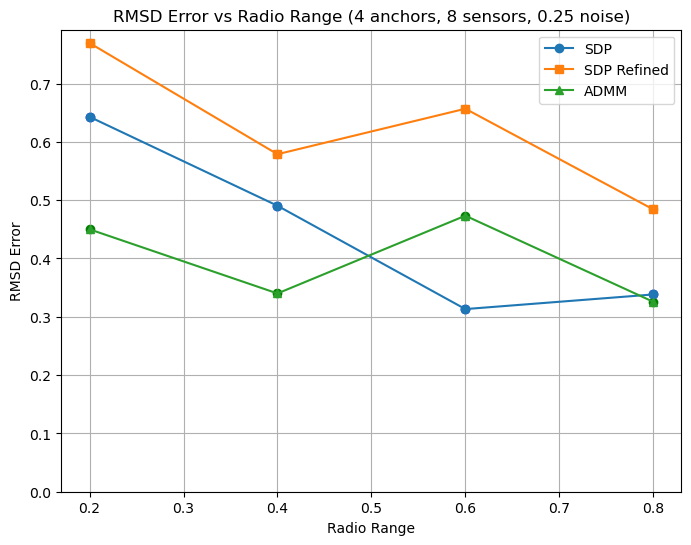

In [19]:
rr = [0.2, 0.4, 0.6, 0.8]

plt.figure(figsize=(8, 6))
plt.plot(rr, e2, label='SDP', marker='o')
plt.scatter(rr, e2, color='blue')

plt.plot(rr, f2, label="SDP Refined", marker='s')
plt.scatter(rr, f2, color='orange')

plt.plot(rr, g2, label='ADMM', marker='^')
plt.scatter(rr, g2, color='green')

plt.title("RMSD Error vs Radio Range (4 anchors, 8 sensors, 0.25 noise)")
plt.xlabel("Radio Range")
plt.ylabel("RMSD Error")

plt.grid()
plt.ylim(0)
plt.legend()

In [26]:
import csv

def save(data, filename):
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(data)

In [28]:
save(e0, 'e0.csv')
save(f0, 'f0.csv')
save(g0, 'g0.csv')
save(e1, 'e1.csv')
save(f1, 'f1.csv')
save(g1, 'g1.csv')
save(e2, 'e2.csv')
save(f2, 'f2.csv')
save(g2, 'g2.csv')

In [21]:
import time

# Define parameters
Nxl = [5, 10, 25, 50]  # Number of sensors
Na = 5  
sdp_runtime = []
projection_runtime = []
admm_runtime = []

# Perform runtime analysis
for Nx in Nxl:
    X, A, D, D_hat = get_noisy_data(Nx, Na)

    # SDP
    start_time = time.time()
    X_est_sdp = sdp_noise(Nx, Na, A, D, D_hat)
    sdp_runtime.append(time.time() - start_time)

    # Projection
    start_time = time.time()
    X_est_projection = sdp_projection(Nx, Na, A, D, D_hat)
    projection_runtime.append(time.time() - start_time)

    # ADMM
    start_time = time.time()
    X_est_admm = admm(Nx, Na, A, D, D_hat)
    admm_runtime.append(time.time() - start_time)

  0%|          | 1/1000 [00:00<02:21,  7.04it/s]

0.23950528545374428


  0%|          | 3/1000 [00:00<02:48,  5.93it/s]

0.44593610386206983
0.13970956425500886


  0%|          | 4/1000 [00:00<02:49,  5.87it/s]

0.07574036643704674


  1%|          | 6/1000 [00:01<02:53,  5.74it/s]

0.03293913246210578
0.01470021571339672


  1%|          | 8/1000 [00:01<02:44,  6.05it/s]

0.0068825930425811255
0.003405483228111572


  1%|          | 10/1000 [00:01<02:51,  5.77it/s]

0.0017632206708592668
0.000943811249765586


  1%|          | 11/1000 [00:01<02:45,  5.99it/s]

0.0005173382925006409


  1%|▏         | 13/1000 [00:02<02:54,  5.65it/s]

0.00028820393385114995
0.00016242092525067808


  1%|▏         | 14/1000 [00:02<02:48,  5.85it/s]

9.232410366866173e-05


  2%|▏         | 16/1000 [00:02<02:55,  5.61it/s]

5.276966966069607e-05
3.0262138433573282e-05


  2%|▏         | 18/1000 [00:03<02:41,  6.09it/s]

1.7425207751831095e-05
1.0057796445306355e-05


  2%|▏         | 20/1000 [00:03<02:50,  5.74it/s]

5.811617534406954e-06
3.3514771537734855e-06


  2%|▏         | 21/1000 [00:03<02:50,  5.74it/s]

1.9331395257615736e-06


  2%|▏         | 23/1000 [00:04<02:56,  5.55it/s]

1.1187504765086675e-06
6.476317876979998e-07


  2%|▏         | 24/1000 [00:04<02:48,  5.80it/s]

3.75721755097036e-07


  3%|▎         | 26/1000 [00:04<02:53,  5.62it/s]

2.1766239718945535e-07
1.2576926750051953e-07


  3%|▎         | 26/1000 [00:04<02:57,  5.50it/s]


7.391288597835555e-08


  0%|          | 1/1000 [00:00<07:20,  2.27it/s]

0.4918737418404966


  0%|          | 2/1000 [00:00<07:28,  2.23it/s]

3.347533117040513


  0%|          | 3/1000 [00:01<07:38,  2.17it/s]

0.9124711288109909


  0%|          | 4/1000 [00:01<07:36,  2.18it/s]

0.1269957423632394


  0%|          | 5/1000 [00:02<07:35,  2.19it/s]

0.033250790717013645


  1%|          | 6/1000 [00:02<07:07,  2.32it/s]

0.01272172398424054


  1%|          | 7/1000 [00:03<07:15,  2.28it/s]

0.005177600816985262


  1%|          | 8/1000 [00:03<07:31,  2.20it/s]

0.0024135362954806894


  1%|          | 9/1000 [00:04<08:07,  2.03it/s]

0.0012174838365660579


  1%|          | 10/1000 [00:04<08:01,  2.06it/s]

0.0006530472888605088


  1%|          | 11/1000 [00:05<08:06,  2.03it/s]

0.0003641442548710794


  1%|          | 12/1000 [00:05<07:41,  2.14it/s]

0.00020846095360604888


  1%|▏         | 13/1000 [00:06<07:37,  2.16it/s]

0.00012131614590704665


  1%|▏         | 14/1000 [00:06<07:25,  2.21it/s]

7.133623505017894e-05


  2%|▏         | 15/1000 [00:06<07:31,  2.18it/s]

4.2210982525214824e-05


  2%|▏         | 16/1000 [00:07<07:30,  2.18it/s]

2.507656908357081e-05


  2%|▏         | 17/1000 [00:07<07:15,  2.26it/s]

1.4939144508008262e-05


  2%|▏         | 18/1000 [00:08<07:19,  2.24it/s]

8.916947463966096e-06


  2%|▏         | 19/1000 [00:08<07:30,  2.18it/s]

5.326675243111367e-06


  2%|▏         | 20/1000 [00:09<07:29,  2.18it/s]

3.1847684153207823e-06


  2%|▏         | 21/1000 [00:09<07:33,  2.16it/s]

1.9069483735423276e-06


  2%|▏         | 22/1000 [00:10<07:46,  2.10it/s]

1.1407488321735215e-06


  2%|▏         | 23/1000 [00:10<07:22,  2.21it/s]

6.833557815166813e-07


  2%|▏         | 24/1000 [00:11<07:25,  2.19it/s]

4.0934478928722484e-07


  2%|▎         | 25/1000 [00:11<07:20,  2.21it/s]

2.4446765056751474e-07


  3%|▎         | 26/1000 [00:11<07:18,  2.22it/s]

1.459887515320446e-07


  3%|▎         | 26/1000 [00:12<07:42,  2.10it/s]

8.725577860246858e-08



  0%|          | 1/1000 [00:01<30:54,  1.86s/it]

5.047458696495514


  0%|          | 2/1000 [00:03<30:50,  1.85s/it]

14.410920096753564


  0%|          | 3/1000 [00:05<31:22,  1.89s/it]

2.082890355181533


  0%|          | 4/1000 [00:07<31:17,  1.88s/it]

0.34579496536796306


  0%|          | 5/1000 [00:09<31:59,  1.93s/it]

0.09030455043516206


  1%|          | 6/1000 [00:11<32:59,  1.99s/it]

0.025006408270003888


  1%|          | 7/1000 [00:13<32:54,  1.99s/it]

0.007443992538222588


  1%|          | 8/1000 [00:15<33:48,  2.04s/it]

0.0033885898483347887


  1%|          | 9/1000 [00:17<33:32,  2.03s/it]

0.0014398736981622307


  1%|          | 10/1000 [00:19<33:25,  2.03s/it]

0.0005467462436836712


  1%|          | 11/1000 [00:21<32:58,  2.00s/it]

0.0002759530424523149


  1%|          | 12/1000 [00:23<32:18,  1.96s/it]

0.000131553498965431


  1%|▏         | 13/1000 [00:25<32:12,  1.96s/it]

5.6843160798791814e-05


  1%|▏         | 14/1000 [00:27<32:03,  1.95s/it]

2.9078125194814675e-05


  2%|▏         | 15/1000 [00:29<31:39,  1.93s/it]

1.5600479295940772e-05


  2%|▏         | 16/1000 [00:31<32:21,  1.97s/it]

8.520368512066057e-06


  2%|▏         | 17/1000 [00:34<35:23,  2.16s/it]

5.367108718346003e-06


  2%|▏         | 18/1000 [00:35<34:08,  2.09s/it]

3.736389771802351e-06


  2%|▏         | 19/1000 [00:37<33:20,  2.04s/it]

2.821322272694715e-06


  2%|▏         | 20/1000 [00:39<33:19,  2.04s/it]

2.316913038313828e-06


  2%|▏         | 21/1000 [00:41<33:18,  2.04s/it]

1.9990417658988235e-06


  2%|▏         | 22/1000 [00:43<33:04,  2.03s/it]

1.7720909202267876e-06


  2%|▏         | 23/1000 [00:45<32:35,  2.00s/it]

1.5969409101757037e-06


  2%|▏         | 24/1000 [00:48<33:06,  2.04s/it]

1.4515870123688046e-06


  2%|▎         | 25/1000 [00:50<32:52,  2.02s/it]

1.3255338409123851e-06


  3%|▎         | 26/1000 [00:52<32:45,  2.02s/it]

1.2133899609523269e-06


  3%|▎         | 27/1000 [00:54<32:32,  2.01s/it]

1.112155711524565e-06


  3%|▎         | 28/1000 [00:55<31:53,  1.97s/it]

1.0200354108036436e-06


  3%|▎         | 29/1000 [00:57<31:20,  1.94s/it]

9.358640156165166e-07


  3%|▎         | 30/1000 [00:59<31:19,  1.94s/it]

8.587895390377298e-07


  3%|▎         | 31/1000 [01:01<31:30,  1.95s/it]

7.881311852031558e-07


  3%|▎         | 32/1000 [01:03<32:00,  1.98s/it]

7.233150078889139e-07


  3%|▎         | 33/1000 [01:05<31:38,  1.96s/it]

6.638407015202574e-07


  3%|▎         | 34/1000 [01:07<31:16,  1.94s/it]

6.09260110806531e-07


  4%|▎         | 35/1000 [01:09<30:46,  1.91s/it]

5.591668852389375e-07


  4%|▎         | 36/1000 [01:11<30:31,  1.90s/it]

5.13190402173791e-07


  4%|▎         | 37/1000 [01:13<30:47,  1.92s/it]

4.709918446366146e-07


  4%|▍         | 38/1000 [01:15<30:43,  1.92s/it]

4.3226043722199847e-07


  4%|▍         | 39/1000 [01:17<30:53,  1.93s/it]

3.967115027592172e-07


  4%|▍         | 40/1000 [01:19<31:31,  1.97s/it]

3.6408380310604116e-07


  4%|▍         | 41/1000 [01:20<30:36,  1.92s/it]

3.341375531817903e-07


  4%|▍         | 42/1000 [01:22<30:28,  1.91s/it]

3.066355773739815e-07


  4%|▍         | 43/1000 [01:24<30:24,  1.91s/it]

2.814057840083706e-07


  4%|▍         | 44/1000 [01:26<30:54,  1.94s/it]

2.5826103744464035e-07


  4%|▍         | 45/1000 [01:28<31:17,  1.97s/it]

2.3701621465477274e-07


  5%|▍         | 46/1000 [01:30<31:19,  1.97s/it]

2.175185755959319e-07


  5%|▍         | 47/1000 [01:32<31:20,  1.97s/it]

1.996238729873312e-07


  5%|▍         | 48/1000 [01:34<31:30,  1.99s/it]

1.832006386592866e-07


  5%|▍         | 49/1000 [01:36<31:43,  2.00s/it]

1.6812791159281915e-07


  5%|▌         | 50/1000 [01:38<31:24,  1.98s/it]

1.5429473876338307e-07


  5%|▌         | 51/1000 [01:40<31:32,  1.99s/it]

1.415991626174673e-07


  5%|▌         | 52/1000 [01:42<31:29,  1.99s/it]

1.2994772369268048e-07


  5%|▌         | 53/1000 [01:44<30:58,  1.96s/it]

1.192546115191817e-07


  5%|▌         | 54/1000 [01:46<30:18,  1.92s/it]

1.0944102157850466e-07


  6%|▌         | 55/1000 [01:48<29:26,  1.87s/it]

1.0043466147635627e-07


  6%|▌         | 55/1000 [01:50<31:30,  2.00s/it]

9.216921625920804e-08



  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\Hamd\anaconda3\lib\site-packages\cvxpy\problems\problem.py:155: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
  0%|          | 1/1000 [00:06<1:47:37,  6.46s/it]

6.242213892921882


  0%|          | 2/1000 [00:13<1:49:49,  6.60s/it]

46.62215958816087


  0%|          | 3/1000 [00:19<1:48:39,  6.54s/it]

46.99725271558038


  0%|          | 4/1000 [00:26<1:48:16,  6.52s/it]

21.855138297687873


  0%|          | 5/1000 [00:32<1:49:08,  6.58s/it]

2.8680242195345187


  1%|          | 6/1000 [00:39<1:47:28,  6.49s/it]

1.2436960560520465


  1%|          | 7/1000 [00:45<1:48:05,  6.53s/it]

0.862883104395813


  1%|          | 8/1000 [00:52<1:47:27,  6.50s/it]

0.5781664192669709


  1%|          | 9/1000 [00:58<1:47:04,  6.48s/it]

0.3211067008635897


  1%|          | 10/1000 [01:05<1:47:35,  6.52s/it]

0.2073120829747399


  1%|          | 11/1000 [01:11<1:46:28,  6.46s/it]

0.14237906677176682


  1%|          | 12/1000 [01:18<1:50:09,  6.69s/it]

0.08109825843816587


  1%|▏         | 13/1000 [01:25<1:48:30,  6.60s/it]

0.04334388172172865


  1%|▏         | 14/1000 [01:31<1:46:59,  6.51s/it]

0.027859140889614054


  2%|▏         | 15/1000 [01:37<1:46:38,  6.50s/it]

0.01976962644543967


  2%|▏         | 16/1000 [01:44<1:47:16,  6.54s/it]

0.012273210765817666


  2%|▏         | 17/1000 [01:51<1:46:54,  6.53s/it]

0.00670251236996755


  2%|▏         | 18/1000 [01:57<1:46:00,  6.48s/it]

0.004155896257984182


  2%|▏         | 19/1000 [02:04<1:47:22,  6.57s/it]

0.002960837284282647


  2%|▏         | 20/1000 [02:10<1:46:27,  6.52s/it]

0.0018547702747628847


  2%|▏         | 21/1000 [02:17<1:46:28,  6.53s/it]

0.0009972991670093023


  2%|▏         | 22/1000 [02:23<1:45:55,  6.50s/it]

0.0005957829927005776


  2%|▏         | 23/1000 [02:30<1:48:59,  6.69s/it]

0.00042540278561453704


  2%|▏         | 24/1000 [02:37<1:49:12,  6.71s/it]

0.0002771618994117375


  2%|▎         | 25/1000 [02:43<1:47:27,  6.61s/it]

0.00015109789593026335


  3%|▎         | 26/1000 [02:50<1:46:05,  6.54s/it]

8.71889676705706e-05


  3%|▎         | 27/1000 [02:56<1:45:11,  6.49s/it]

6.190738962175146e-05


  3%|▎         | 28/1000 [03:03<1:45:25,  6.51s/it]

4.1470562479162254e-05


  3%|▎         | 29/1000 [03:09<1:44:50,  6.48s/it]

2.283503361688588e-05


  3%|▎         | 30/1000 [03:16<1:47:01,  6.62s/it]

1.2718795199262445e-05


  3%|▎         | 31/1000 [03:23<1:47:40,  6.67s/it]

8.887523240019846e-06


  3%|▎         | 32/1000 [03:29<1:47:19,  6.65s/it]

6.141057816932971e-06


  3%|▎         | 33/1000 [03:36<1:46:05,  6.58s/it]

3.463536135228651e-06


  3%|▎         | 34/1000 [03:42<1:45:51,  6.57s/it]

1.877379123271794e-06


  4%|▎         | 35/1000 [03:49<1:45:35,  6.57s/it]

1.280644726264768e-06


  4%|▎         | 36/1000 [03:55<1:44:31,  6.51s/it]

9.082208496380417e-07


  4%|▎         | 37/1000 [04:02<1:44:46,  6.53s/it]

5.254640651486397e-07


  4%|▍         | 38/1000 [04:08<1:43:45,  6.47s/it]

2.780365306875865e-07


  4%|▍         | 39/1000 [04:15<1:44:10,  6.50s/it]

1.8328498185837816e-07


  4%|▍         | 40/1000 [04:21<1:44:14,  6.51s/it]

1.3297618473018247e-07


  4%|▍         | 40/1000 [04:28<1:47:21,  6.71s/it]

7.957209113840236e-08


NameError: name 'N' is not defined

In [41]:
print(sdp_runtime)
print(projection_runtime)
print(admm_runtime)

[0.0947117805480957, 0.3619832992553711, 5.408120393753052, 31.355819702148438]
[0.29973793029785156, 0.7422091960906982, 3.5192270278930664, 21.20093607902527]
[4.742428302764893, 12.357263088226318, 110.07922744750977, 268.4734230041504]


In [29]:
save(admm_runtime, 'admmruntime.csv')
save(projection_runtime, 'projectionruntime.csv')
save(sdp_runtime, 'sdpruntime.csv')

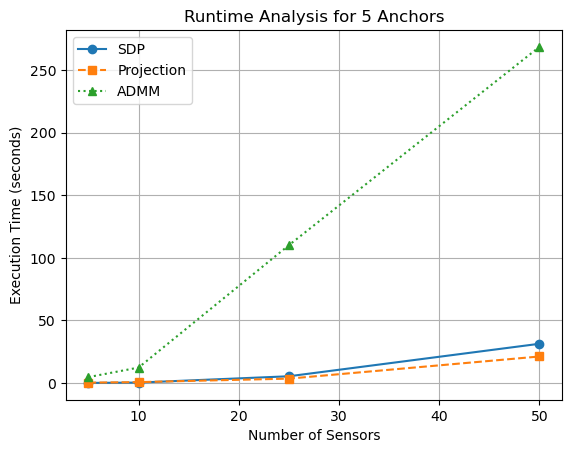

In [30]:

plt.plot(Nxl, sdp_runtime, marker='o', linestyle='-', label='SDP')
plt.plot(Nxl, projection_runtime, marker='s', linestyle='--', label='Projection')
plt.plot(Nxl, admm_runtime, marker='^', linestyle=':', label='ADMM')

# Set title and axis labels
plt.title('Runtime Analysis for 5 Anchors')
plt.xlabel('Number of Sensors')
plt.ylabel('Execution Time (seconds)')

# Customize legend
plt.legend()

# Add grid lines
plt.grid(True)

# Display the plot
plt.show()


In [36]:
Nx = 20  # Number of sensors
Nal = [5, 10, 20] 
#sdp_runtime1 = []
#projection_runtime1 = []
admm_runtime1 = []

# Perform runtime analysis
for Na in Nal:
    X, A, D, D_hat = get_noisy_data(Nx, Na)

    # SDP
    #start_time = time.time()
    #X_est_sdp = sdp_noise(Nx, Na, A, D, D_hat)
    #sdp_runtime1.append(time.time() - start_time)

    # Projection
    #start_time = time.time()
    #X_est_projection = sdp_projection(Nx, Na, A, D, D_hat)
    #projection_runtime1.append(time.time() - start_time)

    # ADMM
    start_time = time.time()
    X_est_admm = admm(Nx, Na, A, D, D_hat)
    admm_runtime1.append(time.time() - start_time)

  0%|          | 1/1000 [00:01<20:57,  1.26s/it]

0.8721608664132674


  0%|          | 2/1000 [00:02<20:27,  1.23s/it]

4.594039994802895


  0%|          | 3/1000 [00:03<20:02,  1.21s/it]

2.319486587114227


  0%|          | 4/1000 [00:04<20:40,  1.25s/it]

1.9413326461829676


  0%|          | 5/1000 [00:06<20:20,  1.23s/it]

2.4654976147184584


  1%|          | 6/1000 [00:07<20:14,  1.22s/it]

3.069051932852597


  1%|          | 7/1000 [00:08<20:55,  1.26s/it]

2.2042610388043506


  1%|          | 8/1000 [00:09<20:52,  1.26s/it]

1.3545105736193594


  1%|          | 9/1000 [00:11<20:45,  1.26s/it]

0.39589205571645003


  1%|          | 10/1000 [00:12<20:54,  1.27s/it]

0.11230707390633654


  1%|          | 11/1000 [00:13<20:17,  1.23s/it]

0.0422994092550244


  1%|          | 12/1000 [00:14<20:29,  1.24s/it]

0.017953029141457577


  1%|▏         | 13/1000 [00:16<20:03,  1.22s/it]

0.009433897172234751


  1%|▏         | 14/1000 [00:17<19:50,  1.21s/it]

0.006172834656677395


  2%|▏         | 15/1000 [00:18<20:08,  1.23s/it]

0.004792048525294135


  2%|▏         | 16/1000 [00:19<19:48,  1.21s/it]

0.0041019142104747885


  2%|▏         | 17/1000 [00:20<19:34,  1.19s/it]

0.003679520810132786


  2%|▏         | 18/1000 [00:22<20:01,  1.22s/it]

0.003371896696933163


  2%|▏         | 19/1000 [00:23<20:19,  1.24s/it]

0.0031193233518855834


  2%|▏         | 20/1000 [00:24<20:17,  1.24s/it]

0.0028979972432399137


  2%|▏         | 21/1000 [00:25<20:30,  1.26s/it]

0.002697682906559251


  2%|▏         | 22/1000 [00:27<20:01,  1.23s/it]

0.002513588124257282


  2%|▏         | 23/1000 [00:28<20:19,  1.25s/it]

0.0023432224371386923


  2%|▏         | 24/1000 [00:29<19:53,  1.22s/it]

0.0021851777655612636


  2%|▎         | 25/1000 [00:30<19:39,  1.21s/it]

0.0020383231682536973


  3%|▎         | 26/1000 [00:32<20:02,  1.23s/it]

0.0019017559476637302


  3%|▎         | 27/1000 [00:33<19:58,  1.23s/it]

0.0017747090144926148


  3%|▎         | 28/1000 [00:34<19:46,  1.22s/it]

0.0016564887043593046


  3%|▎         | 29/1000 [00:35<20:01,  1.24s/it]

0.0015464727034668613


  3%|▎         | 30/1000 [00:36<19:43,  1.22s/it]

0.0014440822568371203


  3%|▎         | 31/1000 [00:38<19:55,  1.23s/it]

0.001348778379844262


  3%|▎         | 32/1000 [00:39<20:01,  1.24s/it]

0.001260057815958504


  3%|▎         | 33/1000 [00:40<20:14,  1.26s/it]

0.0011774581572598919


  3%|▎         | 34/1000 [00:42<20:22,  1.27s/it]

0.0011005573079501119


  4%|▎         | 35/1000 [00:43<20:05,  1.25s/it]

0.0010289349845571394


  4%|▎         | 36/1000 [00:44<19:52,  1.24s/it]

0.0009622247827145713


  4%|▎         | 37/1000 [00:45<20:16,  1.26s/it]

0.0009000792467492857


  4%|▍         | 38/1000 [00:47<19:59,  1.25s/it]

0.0008421741183823883


  4%|▍         | 39/1000 [00:48<19:41,  1.23s/it]

0.0007882111241883649


  4%|▍         | 40/1000 [00:49<19:55,  1.25s/it]

0.0007379178956306021


  4%|▍         | 41/1000 [00:50<19:53,  1.24s/it]

0.0006910109605904324


  4%|▍         | 42/1000 [00:52<20:09,  1.26s/it]

0.0006472684018987707


  4%|▍         | 43/1000 [00:53<19:44,  1.24s/it]

0.0006064858536323214


  4%|▍         | 44/1000 [00:54<19:35,  1.23s/it]

0.0005684258678826382


  4%|▍         | 45/1000 [00:55<20:31,  1.29s/it]

0.0005329020783992888


  5%|▍         | 46/1000 [00:57<20:08,  1.27s/it]

0.0004997377299371664


  5%|▍         | 47/1000 [00:58<19:49,  1.25s/it]

0.000468774072967193


  5%|▍         | 48/1000 [00:59<19:56,  1.26s/it]

0.0004398522865489696


  5%|▍         | 49/1000 [01:00<19:32,  1.23s/it]

0.0004128321115377531


  5%|▌         | 50/1000 [01:01<19:42,  1.24s/it]

0.0003875816635865448


  5%|▌         | 51/1000 [01:03<19:31,  1.23s/it]

0.0003639782721442941


  5%|▌         | 52/1000 [01:04<19:23,  1.23s/it]

0.00034190790123389547


  5%|▌         | 53/1000 [01:05<19:35,  1.24s/it]

0.00032126471023552483


  5%|▌         | 54/1000 [01:06<19:21,  1.23s/it]

0.0003019515696411901


  6%|▌         | 55/1000 [01:08<19:15,  1.22s/it]

0.0002838785224064111


  6%|▌         | 56/1000 [01:09<19:29,  1.24s/it]

0.00026695992645997535


  6%|▌         | 57/1000 [01:10<19:19,  1.23s/it]

0.0002511192840213283


  6%|▌         | 58/1000 [01:11<19:52,  1.27s/it]

0.000236286130389729


  6%|▌         | 59/1000 [01:13<19:53,  1.27s/it]

0.0002223776286029988


  6%|▌         | 60/1000 [01:14<19:31,  1.25s/it]

0.0002093389877675378


  6%|▌         | 61/1000 [01:15<19:56,  1.27s/it]

0.00019712391910253757


  6%|▌         | 62/1000 [01:16<19:37,  1.25s/it]

0.00018566999536240303


  6%|▋         | 63/1000 [01:18<19:32,  1.25s/it]

0.00017494287562946909


  6%|▋         | 64/1000 [01:19<19:37,  1.26s/it]

0.00016486169832496955


  6%|▋         | 65/1000 [01:20<19:18,  1.24s/it]

0.00015540065777486234


  7%|▋         | 66/1000 [01:21<19:04,  1.23s/it]

0.00014651790898412287


  7%|▋         | 67/1000 [01:23<19:21,  1.25s/it]

0.0001381766008616836


  7%|▋         | 68/1000 [01:24<19:15,  1.24s/it]

0.0001303411974884483


  7%|▋         | 69/1000 [01:25<19:32,  1.26s/it]

0.00012297909274572305


  7%|▋         | 70/1000 [01:26<19:17,  1.24s/it]

0.00011605973402062375


  7%|▋         | 71/1000 [01:28<19:39,  1.27s/it]

0.00010955468649775923


  7%|▋         | 72/1000 [01:29<19:58,  1.29s/it]

0.00010343759968378663


  7%|▋         | 73/1000 [01:30<19:56,  1.29s/it]

9.766820228307438e-05


  7%|▋         | 74/1000 [01:32<19:37,  1.27s/it]

9.22599644734845e-05


  8%|▊         | 75/1000 [01:33<19:41,  1.28s/it]

8.716752436832564e-05


  8%|▊         | 76/1000 [01:34<19:37,  1.27s/it]

8.237365375052264e-05


  8%|▊         | 77/1000 [01:35<19:16,  1.25s/it]

7.785935756210449e-05


  8%|▊         | 78/1000 [01:37<19:29,  1.27s/it]

7.360811469325768e-05


  8%|▊         | 79/1000 [01:38<19:30,  1.27s/it]

6.960327228000551e-05


  8%|▊         | 80/1000 [01:39<19:42,  1.29s/it]

6.582951081313126e-05


  8%|▊         | 81/1000 [01:41<20:21,  1.33s/it]

6.227260928604039e-05


  8%|▊         | 82/1000 [01:42<20:40,  1.35s/it]

5.89192841911057e-05


  8%|▊         | 83/1000 [01:43<20:55,  1.37s/it]

5.575672065205595e-05


  8%|▊         | 84/1000 [01:45<20:19,  1.33s/it]

5.2772569263837e-05


  8%|▊         | 85/1000 [01:46<20:06,  1.32s/it]

4.9957210572770805e-05


  9%|▊         | 86/1000 [01:48<22:11,  1.46s/it]

4.7300573074338104e-05


  9%|▊         | 87/1000 [01:49<22:14,  1.46s/it]

4.4795778817885434e-05


  9%|▉         | 88/1000 [01:51<21:15,  1.40s/it]

4.242336042814543e-05


  9%|▉         | 89/1000 [01:52<20:48,  1.37s/it]

4.018740566458234e-05


  9%|▉         | 90/1000 [01:53<19:58,  1.32s/it]

3.807586579718247e-05


  9%|▉         | 91/1000 [01:54<19:50,  1.31s/it]

3.60812653124043e-05


  9%|▉         | 92/1000 [01:56<19:35,  1.29s/it]

3.419662080439423e-05


  9%|▉         | 93/1000 [01:57<19:15,  1.27s/it]

3.241625911343249e-05


  9%|▉         | 94/1000 [01:58<19:18,  1.28s/it]

3.073331036773652e-05


 10%|▉         | 95/1000 [01:59<19:32,  1.30s/it]

2.914197950332209e-05


 10%|▉         | 96/1000 [02:01<19:12,  1.28s/it]

2.7637011985603976e-05


 10%|▉         | 97/1000 [02:02<19:15,  1.28s/it]

2.621347977438404e-05


 10%|▉         | 98/1000 [02:03<18:55,  1.26s/it]

2.4866655445876518e-05


 10%|▉         | 99/1000 [02:04<19:11,  1.28s/it]

2.3592152494700258e-05


 10%|█         | 100/1000 [02:06<18:57,  1.26s/it]

2.2385851929485057e-05


 10%|█         | 101/1000 [02:07<18:45,  1.25s/it]

2.1243949065663514e-05


 10%|█         | 102/1000 [02:08<19:02,  1.27s/it]

2.0162899280862234e-05


 10%|█         | 103/1000 [02:09<18:53,  1.26s/it]

1.9139236263399084e-05


 10%|█         | 104/1000 [02:11<18:51,  1.26s/it]

1.8169771140108537e-05


 10%|█         | 105/1000 [02:12<19:01,  1.28s/it]

1.7251518370287044e-05


 11%|█         | 106/1000 [02:13<18:43,  1.26s/it]

1.638157360872583e-05


 11%|█         | 107/1000 [02:14<18:36,  1.25s/it]

1.555727120283734e-05


 11%|█         | 108/1000 [02:16<19:14,  1.29s/it]

1.4772153564379664e-05


 11%|█         | 109/1000 [02:17<19:04,  1.28s/it]

1.403226999485696e-05


 11%|█         | 110/1000 [02:18<19:12,  1.29s/it]

1.3330189668536718e-05


 11%|█         | 111/1000 [02:20<18:45,  1.27s/it]

1.2665678314149886e-05


 11%|█         | 112/1000 [02:21<18:33,  1.25s/it]

1.2034920329639931e-05


 11%|█▏        | 113/1000 [02:22<18:46,  1.27s/it]

1.1437183955465002e-05


 11%|█▏        | 114/1000 [02:23<18:33,  1.26s/it]

1.0869808047431206e-05


 12%|█▏        | 115/1000 [02:25<18:24,  1.25s/it]

1.0332018652192687e-05


 12%|█▏        | 116/1000 [02:26<18:34,  1.26s/it]

9.821416213640077e-06


 12%|█▏        | 117/1000 [02:27<18:15,  1.24s/it]

9.337285376886939e-06


 12%|█▏        | 118/1000 [02:28<18:32,  1.26s/it]

8.877514897420724e-06


 12%|█▏        | 119/1000 [02:30<18:13,  1.24s/it]

8.441465286779248e-06


 12%|█▏        | 120/1000 [02:31<18:21,  1.25s/it]

8.027253443287918e-06


 12%|█▏        | 121/1000 [02:32<18:54,  1.29s/it]

7.634315085880417e-06


 12%|█▏        | 122/1000 [02:34<18:32,  1.27s/it]

7.2609616701413415e-06


 12%|█▏        | 123/1000 [02:35<18:23,  1.26s/it]

6.906960459573952e-06


 12%|█▏        | 124/1000 [02:36<18:35,  1.27s/it]

6.570340017830745e-06


 12%|█▎        | 125/1000 [02:37<18:22,  1.26s/it]

6.250124371831589e-06


 13%|█▎        | 126/1000 [02:38<18:04,  1.24s/it]

5.947021053387402e-06


 13%|█▎        | 127/1000 [02:40<18:24,  1.26s/it]

5.658826074395051e-06


 13%|█▎        | 128/1000 [02:41<18:09,  1.25s/it]

5.384639107930411e-06


 13%|█▎        | 129/1000 [02:42<18:18,  1.26s/it]

5.124176023940663e-06


 13%|█▎        | 130/1000 [02:44<18:00,  1.24s/it]

4.876680183230064e-06


 13%|█▎        | 131/1000 [02:45<18:06,  1.25s/it]

4.64147078282906e-06


 13%|█▎        | 132/1000 [02:46<18:08,  1.25s/it]

4.4179134786048735e-06


 13%|█▎        | 133/1000 [02:47<18:24,  1.27s/it]

4.205406545665369e-06


 13%|█▎        | 134/1000 [02:49<18:15,  1.27s/it]

4.003385233986023e-06


 14%|█▎        | 135/1000 [02:50<18:33,  1.29s/it]

3.8113144569251745e-06


 14%|█▎        | 136/1000 [02:51<18:16,  1.27s/it]

3.628687306189704e-06


 14%|█▎        | 137/1000 [02:52<18:04,  1.26s/it]

3.455024199183754e-06


 14%|█▍        | 138/1000 [02:54<18:13,  1.27s/it]

3.289871024492186e-06


 14%|█▍        | 139/1000 [02:55<17:59,  1.25s/it]

3.1327973939454523e-06


 14%|█▍        | 140/1000 [02:56<18:16,  1.27s/it]

2.983395667399691e-06


 14%|█▍        | 141/1000 [02:57<17:58,  1.26s/it]

2.8412796684307295e-06


 14%|█▍        | 142/1000 [02:59<17:45,  1.24s/it]

2.7060855156690877e-06


 14%|█▍        | 143/1000 [03:00<17:56,  1.26s/it]

2.577465043174243e-06


 14%|█▍        | 144/1000 [03:01<17:52,  1.25s/it]

2.4550886017493667e-06


 14%|█▍        | 145/1000 [03:02<17:48,  1.25s/it]

2.338644543797841e-06


 15%|█▍        | 146/1000 [03:04<18:25,  1.29s/it]

2.227837033075275e-06


 15%|█▍        | 147/1000 [03:05<18:11,  1.28s/it]

2.1223856823127107e-06


 15%|█▍        | 148/1000 [03:06<18:20,  1.29s/it]

2.0220247609614717e-06


 15%|█▍        | 149/1000 [03:08<18:19,  1.29s/it]

1.926501939308878e-06


 15%|█▌        | 150/1000 [03:09<17:53,  1.26s/it]

1.8355778497181063e-06


 15%|█▌        | 151/1000 [03:10<17:59,  1.27s/it]

1.7490255022067913e-06


 15%|█▌        | 152/1000 [03:11<17:42,  1.25s/it]

1.6666334037296338e-06


 15%|█▌        | 153/1000 [03:13<17:30,  1.24s/it]

1.5881997423861094e-06


 15%|█▌        | 154/1000 [03:14<17:42,  1.26s/it]

1.513524033214253e-06


 16%|█▌        | 155/1000 [03:15<17:25,  1.24s/it]

1.4424322465345085e-06


 16%|█▌        | 156/1000 [03:16<17:18,  1.23s/it]

1.3747292175736447e-06


 16%|█▌        | 157/1000 [03:18<17:28,  1.24s/it]

1.3102643219298216e-06


 16%|█▌        | 158/1000 [03:19<17:26,  1.24s/it]

1.248880197479707e-06


 16%|█▌        | 159/1000 [03:20<18:04,  1.29s/it]

1.1903879926222771e-06


 16%|█▌        | 160/1000 [03:21<17:39,  1.26s/it]

1.1346743278295435e-06


 16%|█▌        | 161/1000 [03:23<17:35,  1.26s/it]

1.081609129371941e-06


 16%|█▌        | 162/1000 [03:24<17:39,  1.26s/it]

1.031062671685845e-06


 16%|█▋        | 163/1000 [03:25<17:29,  1.25s/it]

9.829129208327458e-07


 16%|█▋        | 164/1000 [03:26<17:21,  1.25s/it]

9.370456997004339e-07


 16%|█▋        | 165/1000 [03:28<17:34,  1.26s/it]

8.933505686314902e-07


 17%|█▋        | 166/1000 [03:29<17:20,  1.25s/it]

8.517225484894198e-07


 17%|█▋        | 167/1000 [03:30<17:33,  1.27s/it]

8.120620069718143e-07


 17%|█▋        | 168/1000 [03:31<17:15,  1.24s/it]

7.742741363614414e-07


 17%|█▋        | 169/1000 [03:33<17:01,  1.23s/it]

7.382689179991075e-07


 17%|█▋        | 170/1000 [03:34<17:19,  1.25s/it]

7.0396076168322e-07


 17%|█▋        | 171/1000 [03:35<17:24,  1.26s/it]

6.712681948073396e-07


 17%|█▋        | 172/1000 [03:36<17:22,  1.26s/it]

6.401138268330442e-07


 17%|█▋        | 173/1000 [03:38<17:44,  1.29s/it]

6.104240473092659e-07


 17%|█▋        | 174/1000 [03:39<17:47,  1.29s/it]

5.821288375784661e-07


 18%|█▊        | 175/1000 [03:41<18:32,  1.35s/it]

5.551615682719557e-07


 18%|█▊        | 176/1000 [03:42<19:19,  1.41s/it]

5.294589673354722e-07


 18%|█▊        | 177/1000 [03:43<18:37,  1.36s/it]

5.049607398888156e-07


 18%|█▊        | 178/1000 [03:45<18:30,  1.35s/it]

4.823917585383697e-07


 18%|█▊        | 179/1000 [03:46<17:58,  1.31s/it]

4.600601108961655e-07


 18%|█▊        | 180/1000 [03:47<17:36,  1.29s/it]

4.3881529521172524e-07


 18%|█▊        | 181/1000 [03:48<17:35,  1.29s/it]

4.1853935250912855e-07


 18%|█▊        | 182/1000 [03:50<17:19,  1.27s/it]

3.9921871319847924e-07


 18%|█▊        | 183/1000 [03:51<17:21,  1.28s/it]

3.807972639435775e-07


 18%|█▊        | 184/1000 [03:52<17:39,  1.30s/it]

3.6323582719433034e-07


 18%|█▊        | 185/1000 [03:54<17:24,  1.28s/it]

3.464923619134197e-07


 19%|█▊        | 186/1000 [03:55<17:13,  1.27s/it]

3.3052876169392675e-07


 19%|█▊        | 187/1000 [03:56<17:17,  1.28s/it]

3.153077194895104e-07


 19%|█▉        | 188/1000 [03:57<16:52,  1.25s/it]

3.007942641630734e-07


 19%|█▉        | 189/1000 [03:59<17:12,  1.27s/it]

2.869551654072211e-07


 19%|█▉        | 190/1000 [04:00<16:56,  1.26s/it]

2.7375880407021214e-07


 19%|█▉        | 191/1000 [04:01<16:52,  1.25s/it]

2.61175056692764e-07


 19%|█▉        | 192/1000 [04:02<17:08,  1.27s/it]

2.4917527419177077e-07


 19%|█▉        | 193/1000 [04:04<16:51,  1.25s/it]

2.3773091584189388e-07


 19%|█▉        | 194/1000 [04:05<16:44,  1.25s/it]

2.2681723343964677e-07


 20%|█▉        | 195/1000 [04:06<16:51,  1.26s/it]

2.164098020784877e-07


 20%|█▉        | 196/1000 [04:07<16:52,  1.26s/it]

2.0648544740708985e-07


 20%|█▉        | 197/1000 [04:09<17:02,  1.27s/it]

1.970223024727602e-07


 20%|█▉        | 198/1000 [04:10<16:46,  1.25s/it]

1.8800027135057462e-07


 20%|█▉        | 199/1000 [04:11<16:46,  1.26s/it]

1.7940185337295134e-07


 20%|██        | 200/1000 [04:12<16:52,  1.27s/it]

1.7118008521777028e-07


 20%|██        | 201/1000 [04:14<16:42,  1.25s/it]

1.6332720775835696e-07


 20%|██        | 202/1000 [04:15<16:42,  1.26s/it]

1.558389612910105e-07


 20%|██        | 203/1000 [04:16<16:53,  1.27s/it]

1.4869850062382284e-07


 20%|██        | 204/1000 [04:17<16:33,  1.25s/it]

1.4187949837207725e-07


 20%|██        | 205/1000 [04:19<16:27,  1.24s/it]

1.3537468035451639e-07


 21%|██        | 206/1000 [04:20<16:38,  1.26s/it]

1.2917370106890758e-07


 21%|██        | 207/1000 [04:21<16:22,  1.24s/it]

1.2326332132772677e-07


 21%|██        | 208/1000 [04:22<16:36,  1.26s/it]

1.1762489293687395e-07


 21%|██        | 209/1000 [04:24<16:57,  1.29s/it]

1.1224536322629319e-07


 21%|██        | 210/1000 [04:25<16:53,  1.28s/it]

1.0711280751252161e-07


 21%|██        | 211/1000 [04:26<17:04,  1.30s/it]

1.0221583401914813e-07


 21%|██        | 211/1000 [04:28<16:42,  1.27s/it]


9.754353769153568e-08


  0%|          | 1/1000 [00:01<28:03,  1.69s/it]

3.704041907091998


  0%|          | 2/1000 [00:03<27:04,  1.63s/it]

10.303693103594782


  0%|          | 3/1000 [00:04<27:21,  1.65s/it]

6.704510849430072


  0%|          | 4/1000 [00:06<27:09,  1.64s/it]

9.350876017749835


  0%|          | 5/1000 [00:08<26:50,  1.62s/it]

9.5275411974255


  1%|          | 6/1000 [00:09<27:16,  1.65s/it]

2.0937908664866343


  1%|          | 7/1000 [00:11<27:46,  1.68s/it]

0.31382227867977264


  1%|          | 8/1000 [00:13<27:45,  1.68s/it]

0.12914694291245388


  1%|          | 9/1000 [00:14<27:35,  1.67s/it]

0.03403332454493313


  1%|          | 10/1000 [00:16<27:08,  1.64s/it]

0.011499538323254566


  1%|          | 11/1000 [00:18<27:13,  1.65s/it]

0.004465915185258407


  1%|          | 12/1000 [00:19<27:07,  1.65s/it]

0.0013042874417314998


  1%|▏         | 13/1000 [00:21<27:11,  1.65s/it]

0.0004548604314345006


  1%|▏         | 14/1000 [00:23<26:52,  1.64s/it]

0.0001862732724591254


  2%|▏         | 15/1000 [00:24<27:03,  1.65s/it]

5.5589651334120305e-05


  2%|▏         | 16/1000 [00:26<27:07,  1.65s/it]

1.923099741718559e-05


  2%|▏         | 17/1000 [00:28<27:23,  1.67s/it]

8.029591412661574e-06


  2%|▏         | 18/1000 [00:29<27:16,  1.67s/it]

2.3808070417352667e-06


  2%|▏         | 19/1000 [00:31<27:14,  1.67s/it]

7.907644730131835e-07


  2%|▏         | 20/1000 [00:33<27:13,  1.67s/it]

3.470377447634121e-07


  2%|▏         | 21/1000 [00:34<26:53,  1.65s/it]

1.0668246908096535e-07


  2%|▏         | 21/1000 [00:36<28:16,  1.73s/it]


3.227741052214128e-08


  0%|          | 1/1000 [00:02<40:19,  2.42s/it]

4.246920558790222


  0%|          | 2/1000 [00:04<40:07,  2.41s/it]

23.184458362932613


  0%|          | 3/1000 [00:07<41:48,  2.52s/it]

13.793431628550952


  0%|          | 4/1000 [00:09<41:23,  2.49s/it]

12.818797446024359


  0%|          | 5/1000 [00:12<41:23,  2.50s/it]

0.746596117786257


  1%|          | 6/1000 [00:14<40:34,  2.45s/it]

0.06999674345457985


  1%|          | 7/1000 [00:17<40:43,  2.46s/it]

0.012888235164419726


  1%|          | 8/1000 [00:19<40:14,  2.43s/it]

0.00024051689329196435


  1%|          | 9/1000 [00:22<39:48,  2.41s/it]

0.001638790082017838


  1%|          | 10/1000 [00:24<40:52,  2.48s/it]

0.0007881152806521463


  1%|          | 11/1000 [00:26<40:14,  2.44s/it]

1.110464111198084e-05


  1%|          | 12/1000 [00:29<40:06,  2.44s/it]

2.7808995854972096e-05


  1%|▏         | 13/1000 [00:31<39:59,  2.43s/it]

8.955296206369923e-05


  1%|▏         | 14/1000 [00:34<39:31,  2.41s/it]

1.6414545377596568e-05


  2%|▏         | 15/1000 [00:36<40:30,  2.47s/it]

6.3092567899047935e-06


  2%|▏         | 16/1000 [00:39<42:20,  2.58s/it]

7.063955681729794e-06


  2%|▏         | 17/1000 [00:41<41:12,  2.52s/it]

3.996706658071503e-06


  2%|▏         | 18/1000 [00:44<40:52,  2.50s/it]

7.409292561710856e-07


  2%|▏         | 19/1000 [00:46<40:06,  2.45s/it]

2.113391781577434e-07


  2%|▏         | 20/1000 [00:49<39:34,  2.42s/it]

5.737908859160257e-07


  2%|▏         | 20/1000 [00:51<42:11,  2.58s/it]

1.6761933174791466e-08


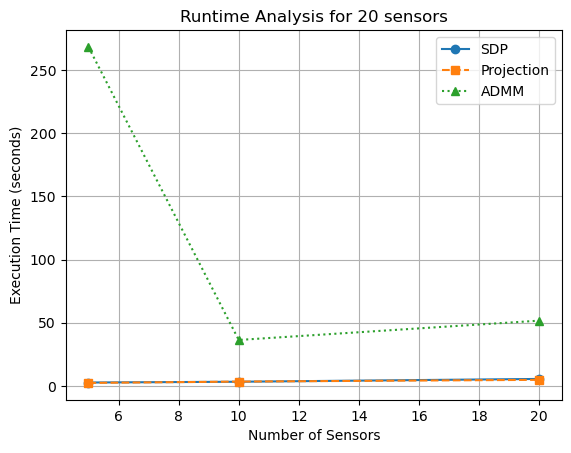

In [38]:

plt.plot(Nal, sdp_runtime1, marker='o', linestyle='-', label='SDP')
plt.plot(Nal, projection_runtime1, marker='s', linestyle='--', label='Projection')
plt.plot(Nal, admm_runtime1, marker='^', linestyle=':', label='ADMM')

# Set title and axis labels
plt.title('Runtime Analysis for 20 sensors')
plt.xlabel('Number of Sensors')
plt.ylabel('Execution Time (seconds)')

# Customize legend
plt.legend()

# Add grid lines
plt.grid(True)

# Display the plot
plt.show()


In [39]:
save(admm_runtime1, 'admmruntime1.csv')
save(projection_runtime1, 'projectionruntime1.csv')
save(sdp_runtime1, 'sdpruntime1.csv')

In [37]:
admm_runtime1

[268.1904375553131, 36.406846046447754, 51.685940980911255]